# Constructing EOS and solving TOV equations

This example notebook shows how to construct the equation of state with the metamodel and speed-of-sound extension scheme parametrization used in the paper, as well as solve the TOV equations. 

In [1]:
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)

import jax.numpy as jnp

import jesterTOV
from jesterTOV.eos.metamodel.metamodel_CSE import MetaModel_with_CSE_EOS_model
from jesterTOV.eos.metamodel.metamodel_only import MetaModel_only
from jesterTOV.eos.families import construct_family
import jesterTOV.utils as utils

W0121 12:49:59.277148  487997 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0121 12:49:59.280667  487912 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


# Equation of state

Proton fraction printed as output
Proton fraction printed as output
------------------------------
[nan, nan, nan] [0.08282044 0.05459113 0.52388039]
--- DUrca Threshold Results ---
Ye            : 0.082820
Ymu           : 0.054591
Yp (Total)    : 0.137412
n_b/n_sat     : 3.3199
------------------------------


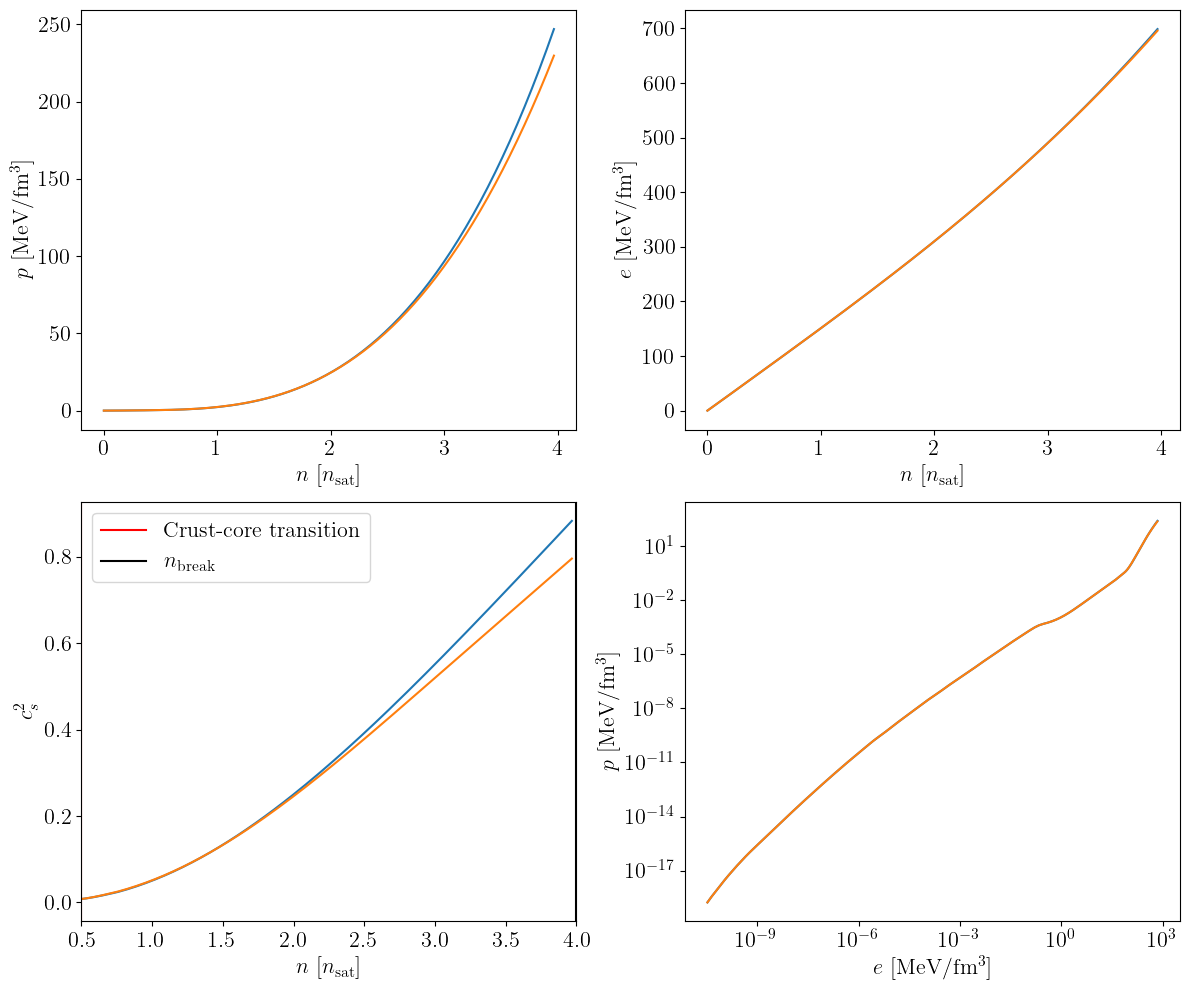

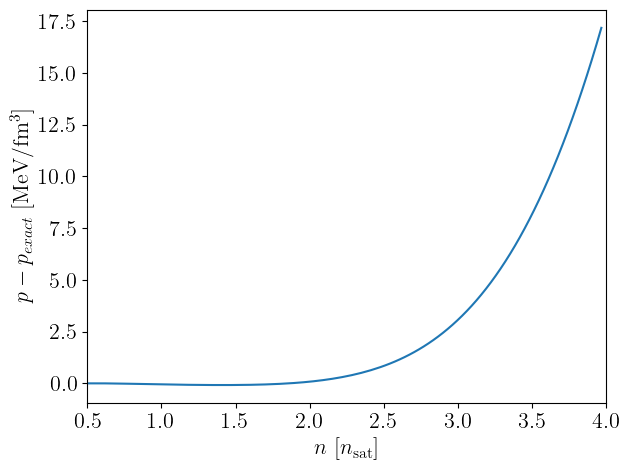

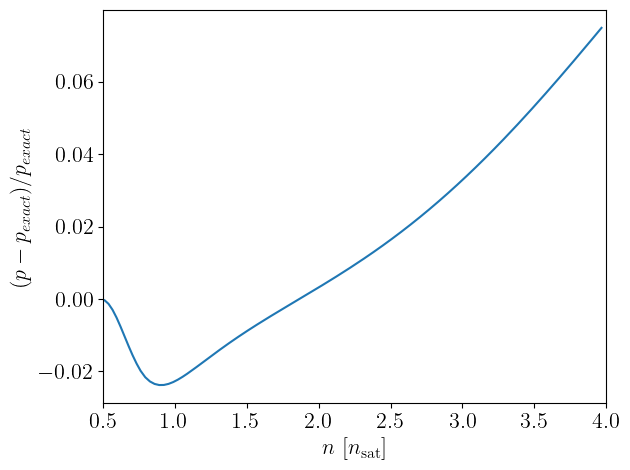

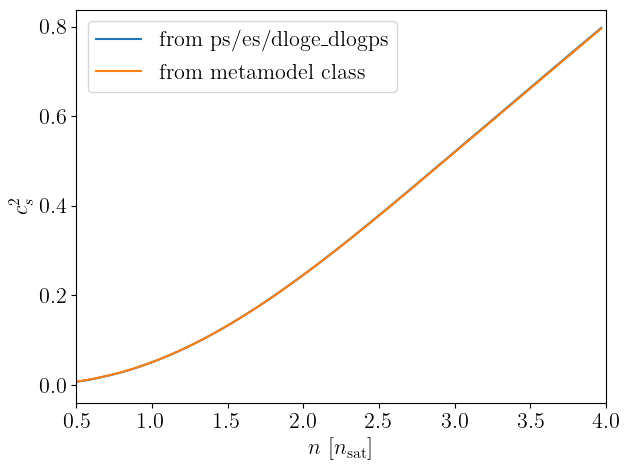

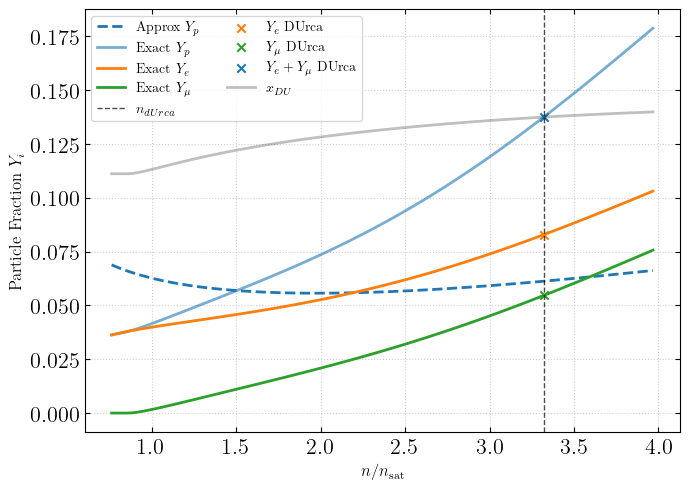

In [2]:
nsat = 0.1578 # nuclear saturation density in fm^-3

# Define the EOS object, here we focus on Metamodel with CSE
eos_exact = MetaModel_only(nmax_nsat=6.0, proton_fraction = 'exact', calculate_durca = True)
eos = MetaModel_only(nmax_nsat=6.0)

# Define the nuclear empirical parameters (NEPs) -- all in MeV
# NEP_dict = {"E_sat": -16.0, # saturation parameters
#             "K_sat": 200.0,
#             "Q_sat": 0.0,
#             "Z_sat": 0.0,
#             "E_sym": 32.0, # symmetry parameters
#             "L_sym": 70.0,
#             "K_sym": -100.0,
#             "Q_sym": 0.0,
#             "Z_sym": 0.0,
#             }

#from paper
NEP_dict = {"E_sat": -16.048, # saturation parameters
            "K_sat": 245.52,
            "Q_sat": -49.22,
            "Z_sat": -910.69,
            "E_sym": 30.0, # symmetry parameters
            "L_sym": 46.3967,
            "K_sym": -37.60,
            "Q_sym": 361.70,
            "Z_sym": -932.13,
            }
# SLy dict
# NEP_dict = {"E_sat": -15.97, # saturation parameters
#             "K_sat":  229.9,
#             "Q_sat": -145.1,
#             "Z_sat": -671,
#             "E_sym": 32.01, # symmetry parameters
#             "L_sym": 45.99,
#             "K_sym": -119.6,
#             "Q_sym": 252,
#             "Z_sym": -410,
#             }

# Esat, nsat, Ksat, Qsat, Zsat -15.97, 0.1595, 229.9, -145.1, -671
# Esym, Lsym, Ksym, Qsym, Zsym 32.01,  45.99, -119.6,  252,  -410
# NEP_dict = {"E_sat": -15.97, # saturation parameters
#             "K_sat":  230.0,
#             "Q_sat": -225.0,
#             "Z_sat": -443.0,
#             "E_sym": 32.01, # symmetry parameters
#             "L_sym": 46.00,
#             "K_sym": -120.0,
#             "Q_sym": 350.0,
#             "Z_sym": -690.0,
#             }
# # Esat, nsat, Ksat, Qsat, Zsat -15.97, 0.1595, 230.0, -225.0, -443.0
# Esym, Lsym, Ksym, Qsym, Zsym 32.01,  46.00, -120.0,  350.0, -690.0

# Define the breakdown density -- this is usually between 1-2 nsat
nbreak = 4 * nsat
NEP_dict["nbreak"] = nbreak

# Then we extend with some CSE grid points
ngrids = jnp.array([4.0, 5.0, 6.0, 7.0]) * nsat
cs2grids = jnp.array([0.5, 0.4, 0.3, 0.2]) # speed of sound squared at the grid points

# Now create the EOS -- returns a tuple with most useful EOS quantities
ns, ps, hs, es, dloge_dlogps, mu, cs2, [n_metamodel_orig, proton_fraction, e_fraction, muon_fraction, durca_density] = eos.construct_eos(NEP_dict, ngrids, cs2grids)
ns_exact, ps_exact, hs_exact, es_exact, dloge_dlogps_exact, mu_exact, cs2_exact, [n_metamodel_orig_exact, proton_fraction_exact, e_fraction_exact, muon_fraction_exact, durca_density_exact] = eos_exact.construct_eos(NEP_dict, ngrids, cs2grids)

print("-" * 30)
print(durca_density,durca_density_exact)
ye_durca, ym_durca, n_durca = durca_density_exact

print(f"--- DUrca Threshold Results ---")
print(f"Ye            : {ye_durca:.6f}")
print(f"Ymu           : {ym_durca:.6f}")
print(f"Yp (Total)    : {ye_durca + ym_durca:.6f}")
print(f"n_b/n_sat     : {n_durca/nsat:.4f}")
print("-" * 30)
plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))

# For the plot, let's make some conversions to more common units
ns_plots = ns / utils.fm_inv3_to_geometric / nsat
es_plots = es / utils.MeV_fm_inv3_to_geometric
ps_plots = ps / utils.MeV_fm_inv3_to_geometric

ns_plots_exact = ns_exact / utils.fm_inv3_to_geometric / nsat
es_plots_exact = es_exact / utils.MeV_fm_inv3_to_geometric
ps_plots_exact = ps_exact / utils.MeV_fm_inv3_to_geometric

# p(n)
plt.subplot(221)
plt.plot(ns_plots, ps_plots)
plt.plot(ns_plots_exact, ps_plots_exact)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")

# e(n)
plt.subplot(222)
plt.plot(ns_plots, es_plots)
plt.plot(ns_plots_exact, es_plots_exact)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$e$ [MeV/fm$^3$]")

# cs2(n)
plt.subplot(223)
plt.plot(ns_plots, cs2)
plt.plot(ns_plots_exact, cs2_exact)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$c_s^2$")
plt.axvline(0.5, color = "red", label = "Crust-core transition")
plt.axvline(nbreak / nsat, color = "black", label = r"$n_{\rm{break}}$")
plt.xlim(0.5,nbreak / nsat)
plt.legend()

# p(e)
plt.subplot(224)
plt.plot(es_plots, ps_plots)
plt.plot(es_plots_exact, ps_plots_exact)
plt.xlabel(r"$e$ [MeV/fm$^3$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.show()
plt.close()

# Difference
plt.plot(ns_plots, (ps-ps_exact)/ utils.MeV_fm_inv3_to_geometric)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p-p_{exact}$ [MeV/fm$^3$]")
# plt.yscale("log")
# plt.xscale("log")
plt.xlim(0.5,nbreak / nsat)
plt.tight_layout()
plt.show()
plt.close()

# Difference
plt.plot(ns_plots, (ps-ps_exact)/ ps_exact)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$(p-p_{exact})/p_{exact}$ ")
# plt.yscale("log")
# plt.xscale("log")
plt.xlim(0.5,nbreak / nsat)
plt.tight_layout()
plt.show()
plt.close()

plt.plot(ns_exact/ utils.fm_inv3_to_geometric / nsat, ps_exact / es_exact /dloge_dlogps_exact, label = "from ps/es/dloge_dlogps")
plt.plot(ns_exact/ utils.fm_inv3_to_geometric / nsat, cs2_exact, label = "from metamodel class")
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$c_s^2$ ")
# plt.yscale("log")
# plt.xscale("log")
plt.xlim(0.5,nbreak / nsat)
plt.tight_layout()
plt.legend()
plt.show()
plt.close()



plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(n_metamodel_orig / nsat, proton_fraction, 
        ls='--', lw=2, color='tab:blue', label=r"Approx $Y_p$")
ax.plot(n_metamodel_orig_exact / nsat, proton_fraction_exact, 
        ls='-', lw=2, color='tab:blue', alpha=0.6, label=r"Exact $Y_p$")

ax.plot(n_metamodel_orig_exact / nsat, e_fraction_exact, 
        ls='-', lw=2, color='tab:orange', label=r"Exact $Y_e$")
ax.plot(n_metamodel_orig_exact / nsat, muon_fraction_exact, 
        ls='-', lw=2, color='tab:green', label=r"Exact $Y_{\mu}$")

# ax.plot(n_metamodel_orig / nsat, (ye_durca + ym_durca)*n_metamodel_orig / nsat, 
#         ls='--', lw=2, color='tab:blue', label=r"$x^{DU}$")

ax.set_xlabel(r"$n/n_{\rm{sat}}$", fontsize=12)
ax.set_ylabel(r"Particle Fraction $Y_i$", fontsize=12)
ax.axvline(x=n_durca/nsat, color='black', ls='--', linewidth=1.0, alpha=0.7, label=r'$n_{dUrca}$')
ax.scatter(n_durca/nsat, ye_durca, color='tab:orange', marker='x', label=r'$Y_{e}$ DUrca')
ax.scatter(n_durca/nsat, ym_durca, color='tab:green', marker='x', label=r'$Y_{\mu}$ DUrca')
ax.scatter(n_durca/nsat, ye_durca + ym_durca, color='tab:blue', marker='x', label=r'$Y_{e} + Y_{\mu}$ DUrca')

x_e = e_fraction_exact/(e_fraction_exact+muon_fraction_exact)
x_DU = 1/(1+(1+jnp.cbrt(x_e))**3)
ax.plot(n_metamodel_orig_exact / nsat, x_DU, 
        ls='-', lw=2, color='k', alpha = 0.25, label=r"$x_{DU}$")
# Grid is mandatory for reading values!
ax.grid(True, which='major', linestyle=':', alpha=0.6)
ax.legend(frameon=True, loc='best', fontsize=10, ncol=2)
plt.tight_layout()

plt.show()
plt.close()

In [3]:
n_nsat_skryme = [0.3125, 0.3140628125625125, 0.315625625125025, 0.3171884376875375, 0.31875125025004997, 0.3203140628125625, 0.32187687537507503, 0.32343968793758754, 0.32500250050010004, 0.3265653130626125, 0.32812812562512506, 0.32969093818763756, 0.33125375075015, 0.3328165633126625, 0.334379375875175, 0.33594218843768753, 0.33750500100020003, 0.33906781356271254, 0.34063062612522504, 0.34219343868773755, 0.34375625125025006, 0.34531906381276256, 0.34688187637527507, 0.34844468893778757, 0.3500075015003001, 0.3515703140628126, 0.3531331266253251, 0.3546959391878376, 0.3562587517503501, 0.35782156431286255, 0.3593843768753751, 0.3609471894378876, 0.3625100020004001, 0.36407281456291263, 0.36563562712542513, 0.36719843968793764, 0.36876125225045014, 0.3703240648129626, 0.37188687737547516, 0.37344968993798766, 0.3750125025005001, 0.3765753150630126, 0.37813812762552507, 0.37970094018803763, 0.38126375275055013, 0.38282656531306264, 0.3843893778755752, 0.38595219043808765, 0.38751500300060016, 0.38907781556311266, 0.3906406281256251, 0.3922034406881376, 0.3937662532506501, 0.39532906581316263, 0.39689187837567513, 0.39845469093818764, 0.40001750350070014, 0.40158031606321265, 0.40314312862572516, 0.40470594118823766, 0.40626875375075017, 0.4078315663132627, 0.4093943788757752, 0.4109571914382877, 0.4125200040008002, 0.4140828165633126, 0.4156456291258252, 0.4172084416883376, 0.4187712542508501, 0.4203340668133626, 0.4218968793758752, 0.42345969193838773, 0.4250225045009001, 0.42658531706341263, 0.42814812962592524, 0.42971094218843764, 0.43127375475095014, 0.43283656731346265, 0.43439937987597516, 0.43596219243848766, 0.43752500500100017, 0.4390878175635127, 0.4406506301260252, 0.4422134426885377, 0.4437762552510502, 0.4453390678135627, 0.4469018803760752, 0.4484646929385877, 0.4500275055011002, 0.4515903180636127, 0.4531531306261252, 0.45471594318863773, 0.45627875575115023, 0.45784156831366274, 0.45940438087617524, 0.46096719343868775, 0.46253000600120026, 0.46409281856371276, 0.46565563112622527, 0.4672184436887378, 0.4687812562512503, 0.4703440688137628, 0.4719068813762753, 0.4734696939387878, 0.4750325065013003, 0.47659531906381275, 0.47815813162632526, 0.4797209441888378, 0.4812837567513503, 0.48284656931386283, 0.4844093818763753, 0.48597219443888784, 0.48753500700140034, 0.4890978195639128, 0.4906606321264253, 0.4922234446889378, 0.4937862572514503, 0.4953490698139628, 0.4969118823764753, 0.49847469493898783, 0.5000375075015003, 0.5016003200640128, 0.5031631326265253, 0.5047259451890378, 0.5062887577515504, 0.5078515703140628, 0.5094143828765754, 0.5109771954390878, 0.5125400080016003, 0.5141028205641128, 0.5156656331266253, 0.5172284456891378, 0.5187912582516503, 0.5203540708141629, 0.5219168833766754, 0.5234796959391879, 0.5250425085017003, 0.5266053210642129, 0.5281681336267253, 0.5297309461892379, 0.5312937587517503, 0.5328565713142629, 0.5344193838767753, 0.5359821964392879, 0.5375450090018004, 0.5391078215643129, 0.5406706341268254, 0.5422334466893379, 0.5437962592518504, 0.5453590718143629, 0.5469218843768754, 0.548484696939388, 0.5500475095019004, 0.551610322064413, 0.5531731346269254, 0.554735947189438, 0.5562987597519504, 0.557861572314463, 0.5594243848769754, 0.560987197439488, 0.5625500100020004, 0.564112822564513, 0.5656756351270255, 0.567238447689538, 0.5688012602520505, 0.570364072814563, 0.5719268853770755, 0.573489697939588, 0.5750525105021004, 0.5766153230646129, 0.5781781356271254, 0.5797409481896381, 0.5813037607521505, 0.582866573314663, 0.5844293858771755, 0.5859921984396881, 0.5875550110022004, 0.589117823564713, 0.5906806361272254, 0.592243448689738, 0.5938062612522504, 0.5953690738147629, 0.5969318863772755, 0.598494698939788, 0.6000575115023005, 0.601620324064813, 0.6031831366273255, 0.604745949189838, 0.6063087617523505, 0.6078715743148629, 0.6094343868773755, 0.610997199439888, 0.6125600120024005, 0.614122824564913, 0.6156856371274255, 0.617248449689938, 0.6188112622524505, 0.620374074814963, 0.6219368873774755, 0.623499699939988, 0.6250625125025006, 0.626625325065013, 0.6281881376275256, 0.629750950190038, 0.6313137627525506, 0.632876575315063, 0.6344393878775756, 0.636002200440088, 0.6375650130026006, 0.639127825565113, 0.6406906381276256, 0.6422534506901381, 0.6438162632526506, 0.6453790758151631, 0.6469418883776756, 0.6485047009401881, 0.6500675135027006, 0.6516303260652131, 0.6531931386277257, 0.6547559511902381, 0.6563187637527507, 0.6578815763152631, 0.6594443888777757, 0.6610072014402881, 0.6625700140028007, 0.6641328265653131, 0.6656956391278256, 0.6672584516903382, 0.6688212642528507, 0.670384076815363, 0.6719468893778757, 0.6735097019403881, 0.6750725145029006, 0.6766353270654131, 0.6781981396279256, 0.6797609521904382, 0.6813237647529506, 0.6828865773154631, 0.6844493898779758, 0.6860122024404881, 0.6875750150030007, 0.689137827565513, 0.6907006401280256, 0.692263452690538, 0.6938262652530506, 0.6953890778155631, 0.6969518903780757, 0.6985147029405882, 0.7000775155031007, 0.701640328065613, 0.7032031406281256, 0.7047659531906381, 0.7063287657531507, 0.7078915783156632, 0.7094543908781756, 0.7110172034406881, 0.7125800160032006, 0.7141428285657131, 0.7157056411282257, 0.7172684536907381, 0.7188312662532507, 0.7203940788157631, 0.7219568913782757, 0.7235197039407881, 0.7250825165033007, 0.7266453290658131, 0.7282081416283257, 0.7297709541908382, 0.7313337667533507, 0.7328965793158632, 0.7344593918783757, 0.7360222044408882, 0.7375850170034007, 0.7391478295659132, 0.7407106421284257, 0.7422734546909382, 0.7438362672534508, 0.7453990798159632, 0.7469618923784758, 0.7485247049409882, 0.7500875175035008, 0.7516503300660132, 0.7532131426285257, 0.7547759551910382, 0.7563387677535508, 0.7579015803160633, 0.7594643928785758, 0.7610272054410883, 0.7625900180036008, 0.7641528305661133, 0.7657156431286257, 0.7672784556911383, 0.7688412682536506, 0.7704040808161633, 0.7719668933786757, 0.7735297059411883, 0.7750925185037008, 0.7766553310662133, 0.7782181436287258, 0.7797809561912382, 0.7813437687537509, 0.7829065813162633, 0.7844693938787759, 0.7860322064412884, 0.7875950190038009, 0.7891578315663133, 0.7907206441288257, 0.7922834566913383, 0.7938462692538507, 0.7954090818163634, 0.796971894378876, 0.7985347069413884, 0.8000975195039007, 0.8016603320664133, 0.8032231446289257, 0.8047859571914383, 0.806348769753951, 0.8079115823164633, 0.8094743948789758, 0.8110372074414883, 0.8126000200040008, 0.8141628325665133, 0.8157256451290258, 0.8172884576915384, 0.8188512702540508, 0.8204140828165634, 0.8219768953790758, 0.8235397079415884, 0.8251025205041008, 0.8266653330666134, 0.8282281456291258, 0.8297909581916384, 0.8313537707541508, 0.8329165833166634, 0.8344793958791759, 0.8360422084416884, 0.8376050210042009, 0.8391678335667134, 0.8407306461292259, 0.8422934586917384, 0.8438562712542508, 0.8454190838167635, 0.8469818963792759, 0.8485447089417885, 0.8501075215043009, 0.8516703340668133, 0.8532331466293258, 0.8547959591918383, 0.8563587717543509, 0.8579215843168635, 0.859484396879376, 0.8610472094418885, 0.8626100220044008, 0.8641728345669133, 0.8657356471294259, 0.8672984596919383, 0.8688612722544509, 0.8704240848169633, 0.8719868973794759, 0.8735497099419883, 0.8751125225045009, 0.8766753350670133, 0.8782381476295259, 0.8798009601920384, 0.881363772754551, 0.8829265853170634, 0.8844893978795759, 0.8860522104420884, 0.8876150230046009, 0.8891778355671134, 0.890740648129626, 0.8923034606921384, 0.893866273254651, 0.8954290858171634, 0.896991898379676, 0.8985547109421884, 0.900117523504701, 0.9016803360672134, 0.903243148629726, 0.9048059611922384, 0.906368773754751, 0.9079315863172635, 0.909494398879776, 0.9110572114422885, 0.912620024004801, 0.9141828365673135, 0.915745649129826, 0.9173084616923385, 0.918871274254851, 0.9204340868173635, 0.9219968993798761, 0.9235597119423885, 0.9251225245049011, 0.9266853370674135, 0.9282481496299261, 0.9298109621924385, 0.9313737747549511, 0.9329365873174635, 0.9344993998799761, 0.9360622124424886, 0.9376250250050011, 0.9391878375675136, 0.9407506501300261, 0.9423134626925386, 0.9438762752550511, 0.9454390878175636, 0.9470019003800761, 0.9485647129425886, 0.9501275255051012, 0.9516903380676136, 0.9532531506301262, 0.9548159631926386, 0.9563787757551512, 0.9579415883176636, 0.9595044008801762, 0.9610672134426886, 0.9626300260052012, 0.9641928385677137, 0.965755651130226, 0.9673184636927386, 0.968881276255251, 0.9704440888177637, 0.9720069013802762, 0.9735697139427887, 0.9751325265053012, 0.9766953390678137, 0.978258151630326, 0.9798209641928386, 0.9813837767553513, 0.9829465893178637, 0.9845094018803763, 0.9860722144428886, 0.9876350270054011, 0.9891978395679136, 0.9907606521304261, 0.9923234646929386, 0.9938862772554511, 0.9954490898179638, 0.9970119023804761, 0.9985747149429887, 1.0001375275055011, 1.0017003400680136, 1.0032631526305262, 1.0048259651930387, 1.0063887777555511, 1.0079515903180636, 1.0095144028805763, 1.0110772154430887, 1.0126400280056012, 1.0142028405681136, 1.0157656531306263, 1.0173284656931387, 1.0188912782556512, 1.0204540908181636, 1.0220169033806763, 1.0235797159431888, 1.0251425285057012, 1.0267053410682137, 1.028268153630726, 1.0298309661932386, 1.0313937787557512, 1.0329565913182637, 1.0345194038807763, 1.0360822164432888, 1.0376450290058012, 1.0392078415683137, 1.0407706541308261, 1.0423334666933386, 1.043896279255851, 1.0454590918183637, 1.0470219043808764, 1.0485847169433886, 1.050147529505901, 1.0517103420684137, 1.0532731546309262, 1.0548359671934386, 1.0563987797559513, 1.0579615923184638, 1.0595244048809762, 1.0610872174434887, 1.0626500300060011, 1.0642128425685138, 1.0657756551310262, 1.0673384676935387, 1.0689012802560511, 1.0704640928185638, 1.0720269053810763, 1.0735897179435887, 1.0751525305061012, 1.0767153430686138, 1.0782781556311265, 1.0798409681936387, 1.0814037807561512, 1.0829665933186639, 1.0845294058811763, 1.0860922184436888, 1.0876550310062012, 1.0892178435687139, 1.0907806561312263, 1.0923434686937388, 1.0939062812562512, 1.095469093818764, 1.0970319063812763, 1.0985947189437888, 1.1001575315063012, 1.101720344068814, 1.1032831566313264, 1.1048459691938388, 1.1064087817563513, 1.107971594318864, 1.1095344068813764, 1.1110972194438888, 1.1126600320064013, 1.114222844568914, 1.1157856571314264, 1.1173484696939389, 1.1189112822564513, 1.120474094818964, 1.1220369073814764, 1.1235997199439887, 1.1251625325065013, 1.126725345069014, 1.1282881576315265, 1.129850970194039, 1.1314137827565514, 1.132976595319064, 1.1345394078815765, 1.136102220444089, 1.1376650330066014, 1.139227845569114, 1.1407906581316265, 1.142353470694139, 1.1439162832566514, 1.1454790958191639, 1.1470419083816763, 1.1486047209441888, 1.1501675335067014, 1.151730346069214, 1.1532931586317265, 1.154855971194239, 1.1564187837567514, 1.1579815963192641, 1.1595444088817766, 1.161107221444289, 1.1626700340068015, 1.164232846569314, 1.1657956591318264, 1.1673584716943388, 1.1689212842568515, 1.170484096819364, 1.1720469093818764, 1.1736097219443888, 1.1751725345069015, 1.1767353470694142, 1.1782981596319266, 1.179860972194439, 1.1814237847569515, 1.182986597319464, 1.1845494098819764, 1.1861122224444889, 1.1876750350070016, 1.189237847569514, 1.1908006601320265, 1.192363472694539, 1.1939262852570516, 1.195489097819564, 1.1970519103820765, 1.198614722944589, 1.2001775355071016, 1.201740348069614, 1.2033031606321265, 1.204865973194639, 1.2064287857571516, 1.207991598319664, 1.2095544108821765, 1.211117223444689, 1.2126800360072016, 1.214242848569714, 1.2158056611322265, 1.217368473694739, 1.2189312862572514, 1.220494098819764, 1.2220569113822763, 1.223619723944789, 1.2251825365073015, 1.2267453490698141, 1.2283081616323266, 1.229870974194839, 1.2314337867573517, 1.2329965993198642, 1.2345594118823766, 1.236122224444889, 1.2376850370074015, 1.239247849569914, 1.2408106621324264, 1.242373474694939, 1.2439362872574515, 1.245499099819964, 1.2470619123824764, 1.248624724944989, 1.2501875375075018, 1.2517503500700142, 1.2533131626325267, 1.2548759751950391, 1.2564387877575516, 1.258001600320064, 1.2595644128825765, 1.2611272254450892, 1.2626900380076016, 1.264252850570114, 1.2658156631326265, 1.2673784756951392, 1.2689412882576516, 1.270504100820164, 1.2720669133826765, 1.2736297259451892, 1.2751925385077016, 1.276755351070214, 1.2783181636327265, 1.2798809761952392, 1.2814437887577517, 1.2830066013202641, 1.2845694138827766, 1.2861322264452892, 1.2876950390078017, 1.2892578515703141, 1.2908206641328266, 1.2923834766953393, 1.2939462892578517, 1.2955091018203642, 1.2970719143828766, 1.2986347269453893, 1.3001975395079017, 1.3017603520704142, 1.3033231646329266, 1.3048859771954393, 1.3064487897579518, 1.3080116023204642, 1.3095744148829767, 1.3111372274454893, 1.3127000400080018, 1.3142628525705142, 1.3158256651330267, 1.3173884776955394, 1.3189512902580518, 1.320514102820564, 1.3220769153830765, 1.3236397279455892, 1.3252025405081016, 1.3267653530706143, 1.3283281656331267, 1.3298909781956394, 1.3314537907581518, 1.3330166033206643, 1.3345794158831767, 1.3361422284456892, 1.3377050410082019, 1.3392678535707143, 1.3408306661332265, 1.3423934786957392, 1.3439562912582517, 1.3455191038207641, 1.3470819163832766, 1.3486447289457892, 1.350207541508302, 1.3517703540708144, 1.3533331666333268, 1.3548959791958393, 1.356458791758352, 1.3580216043208644, 1.3595844168833766, 1.3611472294458893, 1.3627100420084017, 1.3642728545709142, 1.3658356671334266, 1.3673984796959393, 1.3689612922584518, 1.3705241048209642, 1.3720869173834767, 1.3736497299459893, 1.3752125425085016, 1.3767753550710145, 1.378338167633527, 1.3799009801960394, 1.3814637927585518, 1.3830266053210643, 1.3845894178835767, 1.3861522304460894, 1.3877150430086018, 1.3892778555711143, 1.3908406681336267, 1.3924034806961394, 1.3939662932586518, 1.395529105821164, 1.3970919183836767, 1.3986547309461892, 1.4002175435087019, 1.4017803560712143, 1.4033431686337268, 1.4049059811962394, 1.406468793758752, 1.4080316063212643, 1.4095944188837768, 1.4111572314462895, 1.412720044008802, 1.4142828565713141, 1.4158456691338268, 1.4174084816963393, 1.4189712942588517, 1.4205341068213642, 1.4220969193838768, 1.4236597319463893, 1.4252225445089017, 1.4267853570714144, 1.4283481696339269, 1.4299109821964395, 1.431473794758952, 1.4330366073214644, 1.4345994198839769, 1.4361622324464893, 1.4377250450090018, 1.4392878575715142, 1.440850670134027, 1.4424134826965394, 1.4439762952590518, 1.4455391078215643, 1.447101920384077, 1.4486647329465894, 1.450227545509102, 1.4517903580716145, 1.453353170634127, 1.4549159831966394, 1.4564787957591518, 1.4580416083216643, 1.459604420884177, 1.4611672334466894, 1.4627300460092019, 1.4642928585717143, 1.465855671134227, 1.4674184836967394, 1.468981296259252, 1.4705441088217643, 1.472106921384277, 1.4736697339467895, 1.475232546509302, 1.4767953590718144, 1.478358171634327, 1.4799209841968395, 1.481483796759352, 1.4830466093218644, 1.484609421884377, 1.4861722344468895, 1.487735047009402, 1.4892978595719144, 1.490860672134427, 1.4924234846969395, 1.493986297259452, 1.4955491098219644, 1.497111922384477, 1.4986747349469893, 1.500237547509502, 1.5018003600720145, 1.5033631726345271, 1.5049259851970396, 1.506488797759552, 1.5080516103220645, 1.5096144228845771, 1.5111772354470896, 1.512740048009602, 1.5143028605721145, 1.5158656731346272, 1.5174284856971394, 1.5189912982596518, 1.5205541108221645, 1.522116923384677, 1.5236797359471894, 1.5252425485097019, 1.5268053610722145, 1.5283681736347272, 1.5299309861972397, 1.5314937987597521, 1.5330566113222646, 1.5346194238847772, 1.5361822364472897, 1.537745049009802, 1.5393078615723146, 1.540870674134827, 1.5424334866973395, 1.543996299259852, 1.5455591118223646, 1.547121924384877, 1.5486847369473895, 1.5502475495099022, 1.5518103620724146, 1.5533731746349273, 1.5549359871974398, 1.556498799759952, 1.5580616123224647, 1.559624424884977, 1.5611872374474896, 1.562750050010002, 1.5643128625725145, 1.565875675135027, 1.5674384876975394, 1.569001300260052, 1.5705641128225645, 1.572126925385077, 1.5736897379475894, 1.575252550510102, 1.5768153630726147, 1.5783781756351274, 1.5799409881976394, 1.581503800760152, 1.5830666133226645, 1.584629425885177, 1.5861922384476894, 1.587755051010202, 1.5893178635727145, 1.590880676135227, 1.5924434886977394, 1.5940063012602521, 1.5955691138227646, 1.597131926385277, 1.5986947389477895, 1.6002575515103021, 1.6018203640728146, 1.603383176635327, 1.6049459891978395, 1.6065088017603522, 1.6080716143228646, 1.609634426885377, 1.6111972394478895, 1.6127600520104022, 1.6143228645729146, 1.615885677135427, 1.6174484896979395, 1.6190113022604522, 1.6205741148229647, 1.622136927385477, 1.6236997399479896, 1.6252625525105022, 1.6268253650730147, 1.6283881776355271, 1.6299509901980396, 1.6315138027605522, 1.6330766153230647, 1.6346394278855771, 1.6362022404480896, 1.6377650530106023, 1.6393278655731147, 1.6408906781356272, 1.6424534906981396, 1.6440163032606523, 1.6455791158231647, 1.6471419283856772, 1.6487047409481896, 1.6502675535107023, 1.6518303660732148, 1.6533931786357272, 1.6549559911982397, 1.6565188037607523, 1.6580816163232648, 1.6596444288857772, 1.6612072414482897, 1.6627700540108024, 1.6643328665733148, 1.6658956791358273, 1.6674584916983397, 1.6690213042608524, 1.6705841168233648, 1.6721469293858773, 1.6737097419483897, 1.6752725545109024, 1.6768353670734149, 1.6783981796359273, 1.6799609921984398, 1.6815238047609524, 1.6830866173234649, 1.6846494298859773, 1.6862122424484898, 1.6877750550110024, 1.689337867573515, 1.6909006801360273, 1.6924634926985398, 1.6940263052610525, 1.695589117823565, 1.6971519303860774, 1.6987147429485898, 1.7002775555111025, 1.701840368073615, 1.7034031806361274, 1.7049659931986398, 1.7065288057611525, 1.708091618323665, 1.7096544308861774, 1.7112172434486899, 1.7127800560112025, 1.714342868573715, 1.7159056811362274, 1.7174684936987399, 1.7190313062612526, 1.720594118823765, 1.7221569313862775, 1.72371974394879, 1.7252825565113026, 1.726845369073815, 1.7284081816363275, 1.72997099419884, 1.7315338067613526, 1.733096619323865, 1.7346594318863775, 1.73622224444889, 1.7377850570114026, 1.739347869573915, 1.7409106821364275, 1.74247349469894, 1.7440363072614526, 1.7455991198239647, 1.7471619323864773, 1.7487247449489898, 1.7502875575115027, 1.7518503700740151, 1.7534131826365276, 1.75497599519904, 1.7565388077615527, 1.7581016203240651, 1.7596644328865776, 1.76122724544909, 1.7627900580116027, 1.7643528705741152, 1.7659156831366274, 1.7674784956991398, 1.7690413082616523, 1.7706041208241647, 1.7721669333866774, 1.7737297459491899, 1.7752925585117023, 1.7768553710742152, 1.7784181836367277, 1.77998099619924, 1.7815438087617528, 1.7831066213242652, 1.7846694338867775, 1.78623224644929, 1.7877950590118024, 1.7893578715743148, 1.7909206841368275, 1.79248349669934, 1.7940463092618524, 1.7956091218243648, 1.7971719343868775, 1.79873474694939, 1.8002975595119028, 1.8018603720744153, 1.8034231846369277, 1.80498599719944, 1.8065488097619524, 1.8081116223244649, 1.8096744348869775, 1.81123724744949, 1.8128000600120024, 1.814362872574515, 1.8159256851370276, 1.81748849769954, 1.8190513102620525, 1.820614122824565, 1.8221769353870776, 1.82373974794959, 1.8253025605121025, 1.826865373074615, 1.8284281856371276, 1.82999099819964, 1.8315538107621525, 1.833116623324665, 1.8346794358871776, 1.83624224844969, 1.837805061012202, 1.8393678735747154, 1.8409306861372279, 1.8424934986997403, 1.844056311262253, 1.845619123824765, 1.8471819363872777, 1.8487447489497901, 1.8503075615123026, 1.851870374074815, 1.8534331866373277, 1.8549959991998402, 1.8565588117623526, 1.858121624324865, 1.8596844368873777, 1.8612472494498902, 1.8628100620124026, 1.864372874574915, 1.8659356871374277, 1.8674984996999402, 1.8690613122624526, 1.870624124824965, 1.8721869373874778, 1.8737497499499902, 1.8753125625125027, 1.876875375075015, 1.8784381876375273, 1.8800010002000398, 1.8815638127625522, 1.883126625325065, 1.8846894378875774, 1.8862522504500898, 1.8878150630126027, 1.8893778755751152, 1.8909406881376278, 1.8925035007001403, 1.8940663132626527, 1.8956291258251652, 1.8971919383876779, 1.8987547509501903, 1.9003175635127028, 1.9018803760752152, 1.9034431886377279, 1.9050060012002403, 1.9065688137627528, 1.9081316263252652, 1.909694438887778, 1.9112572514502904, 1.9128200640128028, 1.9143828765753153, 1.9159456891378275, 1.91750850170034, 1.9190713142628524, 1.920634126825365, 1.9221969393878775, 1.92375975195039, 1.9253225645129024, 1.926885377075415, 1.9284481896379275, 1.93001100220044, 1.9315738147629524, 1.933136627325465, 1.9346994398879775, 1.93626225245049, 1.9378250650130024, 1.9393878775755153, 1.940950690138028, 1.9425135027005405, 1.944076315263053, 1.9456391278255654, 1.947201940388078, 1.9487647529505905, 1.950327565513103, 1.9518903780756154, 1.953453190638128, 1.95501600320064, 1.9565788157631525, 1.9581416283256652, 1.9597044408881776, 1.96126725345069, 1.9628300660132025, 1.9643928785757152, 1.9659556911382277, 1.96751850370074, 1.9690813162632526, 1.9706441288257652, 1.9722069413882777, 1.9737697539507901, 1.9753325665133026, 1.9768953790758153, 1.9784581916383277, 1.9800210042008402, 1.9815838167633526, 1.9831466293258653, 1.9847094418883777, 1.9862722544508902, 1.987835067013403, 1.9893978795759155, 1.9909606921384282, 1.9925235047009406, 1.994086317263453, 1.9956491298259653, 1.9972119423884778, 1.9987747549509902, 2.000337567513503, 2.001900380076015, 2.003463192638528, 2.0050260052010405, 2.0065888177635527, 2.0081516303260654, 2.0097144428885776, 2.0112772554510903, 2.012840068013603, 2.014402880576115, 2.015965693138628, 2.0175285057011405, 2.0190913182636527, 2.0206541308261654, 2.0222169433886776, 2.0237797559511903, 2.025342568513703, 2.026905381076215, 2.028468193638728, 2.0300310062012406, 2.031593818763753, 2.0331566313262655, 2.0347194438887777, 2.0362822564512904, 2.037845069013803, 2.0394078815763153, 2.040970694138828, 2.0425335067013406, 2.044096319263853, 2.0456591318263655, 2.0472219443888777, 2.0487847569513904, 2.050347569513903, 2.0519103820764153, 2.053473194638928, 2.0550360072014406, 2.056598819763953, 2.0581616323264655, 2.0597244448889778, 2.0612872574514904, 2.062850070014003, 2.0644128825765153, 2.065975695139028, 2.0675385077015407, 2.069101320264053, 2.0706641328265656, 2.072226945389078, 2.0737897579515905, 2.075352570514103, 2.0769153830766154, 2.078478195639128, 2.0800410082016407, 2.0816038207641525, 2.083166633326665, 2.084729445889178, 2.08629225845169, 2.087855071014203, 2.0894178835767154, 2.090980696139228, 2.0925435087017408, 2.094106321264253, 2.0956691338267657, 2.097231946389278, 2.0987947589517906, 2.1003575715143032, 2.1019203840768155, 2.103483196639328, 2.105046009201841, 2.106608821764353, 2.1081716343268657, 2.109734446889378, 2.1112972594518906, 2.1128600720144033, 2.1144228845769155, 2.115985697139428, 2.117548509701941, 2.119111322264453, 2.1206741348269653, 2.122236947389478, 2.12379975995199, 2.125362572514503, 2.1269253850770156, 2.128488197639528, 2.1300510102020405, 2.1316138227645527, 2.1331766353270654, 2.134739447889578, 2.1363022604520903, 2.137865073014603, 2.1394278855771156, 2.1409906981396283, 2.142553510702141, 2.144116323264653, 2.145679135827166, 2.147241948389678, 2.1488047609521908, 2.1503675735147034, 2.1519303860772157, 2.1534931986397283, 2.155056011202241, 2.1566188237647532, 2.158181636327266, 2.159744448889778, 2.1613072614522904, 2.162870074014803, 2.1644328865773157, 2.165995699139828, 2.1675585117023406, 2.169121324264853, 2.1706841368273655, 2.172246949389878, 2.1738097619523904, 2.175372574514903, 2.1769353870774157, 2.178498199639928, 2.1800610122024406, 2.181623824764953, 2.1831866373274655, 2.184749449889978, 2.1863122624524904, 2.1878750750150036, 2.189437887577516, 2.1910007001400285, 2.192563512702541, 2.1941263252650534, 2.195689137827566, 2.1972519503900783, 2.198814762952591, 2.200377575515103, 2.201940388077616, 2.203503200640128, 2.2050660132026407, 2.206628825765153, 2.2081916383276656, 2.2097544508901783, 2.2113172634526905, 2.212880076015203, 2.214442888577716, 2.216005701140228, 2.2175685137027408, 2.219131326265253, 2.2206941388277657, 2.2222569513902783, 2.2238197639527906, 2.2253825765153032, 2.226945389077816, 2.228508201640328, 2.230071014202841, 2.231633826765353, 2.2331966393278653, 2.234759451890378, 2.2363222644528906, 2.237885077015403, 2.239447889577916, 2.241010702140428, 2.242573514702941, 2.244136327265453, 2.2456991398279658, 2.2472619523904784, 2.2488247649529907, 2.2503875775155033, 2.251950390078016, 2.2535132026405282, 2.255076015203041, 2.256638827765553, 2.258201640328066, 2.2597644528905785, 2.2613272654530907, 2.2628900780156034, 2.264452890578116, 2.2660157031406283, 2.267578515703141, 2.269141328265653, 2.2707041408281654, 2.272266953390678, 2.2738297659531908, 2.275392578515703, 2.2769553910782157, 2.278518203640728, 2.2800810162032406, 2.2816438287657532, 2.2832066413282655, 2.284769453890778, 2.286332266453291, 2.2878950790158035, 2.289457891578316, 2.2910207041408284, 2.292583516703341, 2.2941463292658533, 2.295709141828366, 2.2972719543908786, 2.298834766953391, 2.3003975795159035, 2.301960392078416, 2.3035232046409284, 2.305086017203441, 2.3066488297659533, 2.308211642328466, 2.3097744548909787, 2.311337267453491, 2.312900080016003, 2.314462892578516, 2.316025705141028, 2.3175885177035407, 2.3191513302660534, 2.3207141428285656, 2.3222769553910783, 2.323839767953591, 2.325402580516103, 2.326965393078616, 2.328528205641128, 2.3300910182036407, 2.3316538307661534, 2.3332166433286656, 2.3347794558911783, 2.336342268453691, 2.337905081016203, 2.3394678935787163, 2.3410307061412285, 2.342593518703741, 2.3441563312662534, 2.345719143828766, 2.347281956391279, 2.348844768953791, 2.3504075815163032, 2.351970394078816, 2.353533206641328, 2.355096019203841, 2.3566588317663535, 2.3582216443288657, 2.3597844568913784, 2.361347269453891, 2.3629100820164033, 2.364472894578916, 2.366035707141428, 2.367598519703941, 2.3691613322664535, 2.3707241448289658, 2.3722869573914784, 2.373849769953991, 2.3754125825165033, 2.376975395079016, 2.3785382076415282, 2.380101020204041, 2.3816638327665536, 2.383226645329066, 2.3847894578915785, 2.386352270454091, 2.387915083016604, 2.389477895579116, 2.3910407081416283, 2.392603520704141, 2.3941663332666536, 2.395729145829166, 2.3972919583916785, 2.398854770954191, 2.4004175835167034, 2.401980396079216, 2.4035432086417283, 2.405106021204241, 2.4066688337667537, 2.408231646329266, 2.4097944588917786, 2.4113572714542912, 2.4129200840168035, 2.414482896579316, 2.4160457091418284, 2.417608521704341, 2.4191713342668537, 2.420734146829366, 2.4222969593918786, 2.4238597719543913, 2.4254225845169035, 2.426985397079416, 2.4285482096419284, 2.430111022204441, 2.4316738347669533, 2.4332366473294655, 2.434799459891978, 2.436362272454491, 2.437925085017003, 2.4394878975795162, 2.4410507101420285, 2.442613522704541, 2.444176335267054, 2.445739147829566, 2.4473019603920787, 2.4488647729545914, 2.4504275855171036, 2.4519903980796163, 2.4535532106421285, 2.455116023204641, 2.456678835767154, 2.458241648329666, 2.4598044608921787, 2.4613672734546914, 2.4629300860172036, 2.4644928985797163, 2.4660557111422285, 2.467618523704741, 2.469181336267254, 2.4707441488297657, 2.4723069613922783, 2.473869773954791, 2.4754325865173032, 2.476995399079816, 2.4785582116423286, 2.480121024204841, 2.4816838367673535, 2.4832466493298657, 2.4848094618923784, 2.486372274454891, 2.4879350870174037, 2.4894978995799164, 2.4910607121424286, 2.4926235247049413, 2.494186337267454, 2.495749149829966, 2.497311962392479, 2.4988747749549916, 2.500437587517504, 2.5020004000800165, 2.5035632126425287, 2.5051260252050414, 2.506688837767554, 2.5082516503300663, 2.5098144628925785, 2.511377275455091, 2.5129400880176034, 2.514502900580116, 2.5160657131426287, 2.517628525705141, 2.5191913382676536, 2.520754150830166, 2.5223169633926785, 2.523879775955191, 2.5254425885177034, 2.527005401080216, 2.5285682136427288, 2.530131026205241, 2.5316938387677537, 2.533256651330266, 2.5348194638927786, 2.5363822764552912, 2.5379450890178035, 2.5395079015803166, 2.541070714142829, 2.5426335267053415, 2.544196339267854, 2.5457591518303664, 2.547321964392879, 2.5488847769553913, 2.5504475895179035, 2.552010402080416, 2.553573214642929, 2.555136027205441, 2.5566988397679538, 2.558261652330466, 2.5598244648929787, 2.5613872774554913, 2.5629500900180036, 2.5645129025805162, 2.566075715143029, 2.567638527705541, 2.569201340268054, 2.570764152830566, 2.5723269653930787, 2.5738897779555914, 2.5754525905181036, 2.5770154030806163, 2.578578215643129, 2.580141028205641, 2.581703840768154, 2.583266653330666, 2.5848294658931787, 2.586392278455691, 2.5879550910182036, 2.5895179035807163, 2.591080716143229, 2.592643528705741, 2.594206341268254, 2.595769153830766, 2.597331966393279, 2.5988947789557915, 2.6004575915183037, 2.6020204040808164, 2.603583216643329, 2.6051460292058413, 2.606708841768354, 2.608271654330866, 2.609834466893379, 2.6113972794558915, 2.6129600920184037, 2.6145229045809164, 2.616085717143429, 2.6176485297059413, 2.619211342268454, 2.620774154830966, 2.622336967393479, 2.6238997799559916, 2.625462592518504, 2.627025405081016, 2.6285882176435287, 2.630151030206041, 2.6317138427685536, 2.6332766553310663, 2.6348394678935785, 2.636402280456091, 2.637965093018604, 2.6395279055811165, 2.641090718143629, 2.6426535307061414, 2.644216343268654, 2.6457791558311663, 2.647341968393679, 2.6489047809561916, 2.650467593518704, 2.6520304060812165, 2.653593218643729, 2.6551560312062414, 2.656718843768754, 2.6582816563312663, 2.659844468893779, 2.6614072814562917, 2.662970094018804, 2.6645329065813166, 2.666095719143829, 2.667658531706341, 2.6692213442688537, 2.6707841568313664, 2.6723469693938786, 2.6739097819563913, 2.675472594518904, 2.677035407081416, 2.678598219643929, 2.680161032206441, 2.6817238447689538, 2.6832866573314664, 2.6848494698939787, 2.6864122824564913, 2.687975095019004, 2.6895379075815167, 2.6911007201440293, 2.6926635327065416, 2.6942263452690542, 2.6957891578315665, 2.697351970394079, 2.698914782956592, 2.700477595519104, 2.7020404080816167, 2.7036032206441294, 2.705166033206641, 2.706728845769154, 2.7082916583316665, 2.7098544708941787, 2.7114172834566914, 2.712980096019204, 2.7145429085817163, 2.716105721144229, 2.717668533706741, 2.719231346269254, 2.7207941588317666, 2.722356971394279, 2.7239197839567915, 2.725482596519304, 2.7270454090818164, 2.728608221644329, 2.7301710342068413, 2.731733846769354, 2.7332966593318666, 2.734859471894379, 2.7364222844568915, 2.737985097019404, 2.739547909581917, 2.7411107221444295, 2.7426735347069418, 2.744236347269454, 2.7457991598319667, 2.747361972394479, 2.7489247849569916, 2.7504875975195042, 2.7520504100820165, 2.753613222644529, 2.7551760352070414, 2.756738847769554, 2.7583016603320667, 2.759864472894579, 2.7614272854570916, 2.7629900980196043, 2.7645529105821165, 2.766115723144629, 2.7676785357071414, 2.769241348269654, 2.7708041608321667, 2.772366973394679, 2.7739297859571916, 2.7754925985197043, 2.7770554110822165, 2.778618223644729, 2.7801810362072414, 2.781743848769754, 2.783306661332267, 2.784869473894779, 2.7864322864572912, 2.7879950990198044, 2.7895579115823166, 2.7911207241448293, 2.7926835367073415, 2.794246349269854, 2.795809161832367, 2.797371974394879, 2.7989347869573917, 2.8004975995199044, 2.8020604120824166, 2.8036232246449293, 2.8051860372074415, 2.806748849769954, 2.808311662332467, 2.809874474894979, 2.8114372874574918, 2.8130001000200044, 2.8145629125825167, 2.8161257251450293, 2.8176885377075416, 2.8192513502700542, 2.820814162832567, 2.822376975395079, 2.823939787957592, 2.825502600520104, 2.8270654130826163, 2.828628225645129, 2.8301910382076416, 2.831753850770154, 2.8333166633326665, 2.834879475895179, 2.8364422884576914, 2.838005101020204, 2.8395679135827168, 2.8411307261452294, 2.8426935387077417, 2.8442563512702543, 2.845819163832767, 2.8473819763952792, 2.848944788957792, 2.8505076015203046, 2.852070414082817, 2.8536332266453295, 2.8551960392078417, 2.8567588517703544, 2.858321664332867, 2.8598844768953793, 2.861447289457892, 2.8630101020204046, 2.8645729145829164, 2.866135727145429, 2.8676985397079418, 2.869261352270454, 2.8708241648329667, 2.8723869773954793, 2.8739497899579916, 2.8755126025205042, 2.8770754150830165, 2.878638227645529, 2.880201040208042, 2.881763852770554, 2.8833266653330667, 2.8848894778955794, 2.8864522904580916, 2.8880151030206047, 2.889577915583117, 2.8911407281456296, 2.892703540708142, 2.8942663532706545, 2.895829165833167, 2.8973919783956794, 2.898954790958192, 2.9005176035207048, 2.902080416083217, 2.903643228645729, 2.905206041208242, 2.906768853770754, 2.908331666333267, 2.9098944788957795, 2.9114572914582917, 2.9130201040208044, 2.9145829165833166, 2.9161457291458293, 2.917708541708342, 2.919271354270854, 2.920834166833367, 2.9223969793958795, 2.9239597919583917, 2.9255226045209044, 2.9270854170834166, 2.9286482296459293, 2.930211042208442, 2.931773854770954, 2.933336667333467, 2.9348994798959795, 2.9364622924584918, 2.9380251050210044, 2.939587917583517, 2.94115073014603, 2.942713542708542, 2.9442763552710542, 2.945839167833567, 2.9474019803960796, 2.948964792958592, 2.9505276055211045, 2.9520904180836167, 2.9536532306461294, 2.955216043208642, 2.9567788557711543, 2.958341668333667, 2.9599044808961796, 2.961467293458692, 2.9630301060212045, 2.9645929185837168, 2.9661557311462294, 2.967718543708742, 2.9692813562712543, 2.970844168833767, 2.9724069813962797, 2.973969793958792, 2.9755326065213046, 2.977095419083817, 2.9786582316463295, 2.9802210442088417, 2.981783856771354, 2.9833466693338666, 2.9849094818963793, 2.9864722944588915, 2.9880351070214046, 2.989597919583917, 2.9911607321464295, 2.992723544708942, 2.9942863572714544, 2.995849169833967, 2.9974119823964798, 2.998974794958992, 3.0005376075215047, 3.002100420084017, 3.0036632326465296, 3.0052260452090422, 3.0067888577715545, 3.008351670334067, 3.00991448289658, 3.011477295459092, 3.0130401080216047, 3.014602920584117, 3.0161657331466296, 3.0177285457091423, 3.0192913582716545, 3.0208541708341667, 3.0224169833966794, 3.0239797959591916, 3.0255426085217043, 3.027105421084217, 3.028668233646729, 3.030231046209242, 3.031793858771754, 3.033356671334267, 3.0349194838967795, 3.0364822964592917, 3.0380451090218044, 3.039607921584317, 3.0411707341468297, 3.0427335467093424, 3.0442963592718546, 3.0458591718343673, 3.04742198439688, 3.048984796959392, 3.050547609521905, 3.052110422084417, 3.0536732346469297, 3.0552360472094424, 3.0567988597719546, 3.0583616723344673, 3.0599244848969795, 3.0614872974594918, 3.0630501100220044, 3.064612922584517, 3.0661757351470293, 3.067738547709542, 3.0693013602720542, 3.070864172834567, 3.0724269853970796, 3.073989797959592, 3.0755526105221045, 3.077115423084617, 3.0786782356471294, 3.080241048209642, 3.0818038607721543, 3.083366673334667, 3.0849294858971796, 3.086492298459692, 3.088055111022205, 3.089617923584717, 3.09118073614723, 3.0927435487097426, 3.094306361272255, 3.0958691738347675, 3.09743198639728, 3.098994798959792, 3.1005576115223046, 3.1021204240848173, 3.1036832366473295, 3.105246049209842, 3.1068088617723544, 3.108371674334867, 3.1099344868973797, 3.111497299459892, 3.1130601120224046, 3.1146229245849173, 3.1161857371474295, 3.117748549709942, 3.1193113622724544, 3.120874174834967, 3.1224369873974798, 3.123999799959992, 3.1255626125225047, 3.1271254250850173, 3.1286882376475296, 3.1302510502100422, 3.1318138627725545, 3.133376675335067, 3.13493948789758, 3.136502300460092, 3.1380651130226047, 3.1396279255851174, 3.1411907381476296, 3.1427535507101423, 3.1443163632726545, 3.145879175835167, 3.14744198839768, 3.149004800960192, 3.1505676135227048, 3.1521304260852174, 3.1536932386477297, 3.1552560512102423, 3.1568188637727546, 3.1583816763352672, 3.15994448889778, 3.161507301460292, 3.163070114022805, 3.1646329265853175, 3.1661957391478297, 3.1677585517103424, 3.1693213642728546, 3.1708841768353673, 3.17244698939788, 3.174009801960392, 3.175572614522905, 3.1771354270854175, 3.1786982396479297, 3.1802610522104424, 3.1818238647729546, 3.1833866773354673, 3.18494948989798, 3.186512302460492, 3.188075115023005, 3.1896379275855176, 3.19120074014803, 3.1927635527105425, 3.1943263652730547, 3.1958891778355674, 3.19745199039808, 3.1990148029605923, 3.200577615523105, 3.2021404280856176, 3.20370324064813, 3.2052660532106425, 3.2068288657731547, 3.2083916783356674, 3.20995449089818, 3.2115173034606923, 3.213080116023205, 3.2146429285857177, 3.21620574114823, 3.2177685537107426, 3.219331366273255, 3.2208941788357675, 3.22245699139828, 3.2240198039607924, 3.225582616523305, 3.2271454290858177, 3.22870824164833, 3.2302710542108426, 3.231833866773355, 3.2333966793358675, 3.23495949189838, 3.2365223044608924, 3.238085117023405, 3.2396479295859177, 3.24121074214843, 3.2427735547109426, 3.244336367273455, 3.2458991798359675, 3.24746199239848, 3.2490248049609924, 3.250587617523505, 3.252150430086018, 3.25371324264853, 3.2552760552110427, 3.256838867773555, 3.2584016803360676, 3.2599644928985803, 3.2615273054610925, 3.263090118023605, 3.264652930586118, 3.26621574314863, 3.2677785557111427, 3.269341368273655, 3.2709041808361676, 3.2724669933986803, 3.2740298059611925, 3.275592618523705, 3.277155431086218, 3.27871824364873, 3.280281056211242, 3.2818438687737546, 3.2834066813362672, 3.2849694938987795, 3.286532306461292, 3.2880951190238052, 3.289657931586318, 3.29122074414883, 3.292783556711343, 3.294346369273855, 3.2959091818363677, 3.2974719943988804, 3.2990348069613926, 3.3005976195239053, 3.302160432086418, 3.30372324464893, 3.305286057211443, 3.306848869773955, 3.3084116823364678, 3.3099744948989804, 3.3115373074614927, 3.3131001200240053, 3.314662932586518, 3.3162257451490302, 3.317788557711543, 3.3193513702740547, 3.320914182836568, 3.3224769953990796, 3.3240398079615927, 3.3256026205241045, 3.327165433086618, 3.32872824564913, 3.330291058211643, 3.3318538707741547, 3.333416683336668, 3.3349794958991796, 3.3365423084616928, 3.3381051210242045, 3.339667933586718, 3.34123074614923, 3.342793558711743, 3.344356371274255, 3.345919183836768, 3.3474819963992797, 3.349044808961793, 3.3506076215243046, 3.352170434086818, 3.35373324664933, 3.355296059211843, 3.356858871774355, 3.358421684336868, 3.3599844968993797, 3.3615473094618924, 3.3631101220244046, 3.3646729345869173, 3.3662357471494304, 3.367798559711942, 3.3693613722744553, 3.3709241848369675, 3.3724869973994807, 3.3740498099619924, 3.3756126225245056, 3.3771754350870173, 3.3787382476495305, 3.3803010602120422, 3.3818638727745554, 3.3834266853370676, 3.3849894978995807, 3.3865523104620925, 3.3881151230246056, 3.3896779355871174, 3.3912407481496305, 3.3928035607121423, 3.3943663732746554, 3.3959291858371676, 3.3974919983996807, 3.3990548109621925, 3.4006176235247048, 3.4021804360872174, 3.40374324864973, 3.4053060612122423, 3.406868873774755, 3.4084316863372677, 3.40999449889978, 3.4115573114622926, 3.413120124024805, 3.4146829365873184, 3.41624574914983, 3.4178085617123433, 3.419371374274855, 3.420934186837368, 3.42249699939988, 3.424059811962393, 3.425622624524905, 3.4271854370874184, 3.42874824964993, 3.4303110622124433, 3.431873874774955, 3.433436687337468, 3.43499949989998, 3.436562312462493, 3.438125125025005, 3.4396879375875176, 3.4412507501500302, 3.4428135627125425, 3.444376375275055, 3.445939187837568, 3.44750200040008, 3.4490648129625927, 3.450627625525105, 3.4521904380876176, 3.4537532506501303, 3.4553160632126425, 3.456878875775155, 3.458441688337668, 3.46000450090018, 3.4615673134626928, 3.463130126025206, 3.4646929385877177, 3.4662557511502308, 3.4678185637127426, 3.4693813762752557, 3.470944188837768, 3.472507001400281, 3.474069813962793, 3.475632626525306, 3.4771954390878177, 3.4787582516503304, 3.4803210642128426, 3.4818838767753553, 3.483446689337868, 3.48500950190038, 3.486572314462893, 3.488135127025405, 3.4896979395879177, 3.4912607521504304, 3.4928235647129426, 3.4943863772754553, 3.495949189837968, 3.49751200240048, 3.499074814962993, 3.500637627525505, 3.502200440088018, 3.5037632526505305, 3.5053260652130427, 3.5068888777755554, 3.508451690338068, 3.5100145029005803, 3.511577315463092, 3.513140128025605, 3.5147029405881187, 3.5162657531506305, 3.5178285657131427, 3.5193913782756554, 3.520954190838168, 3.5225170034006803, 3.524079815963193, 3.525642628525705, 3.527205441088218, 3.5287682536507305, 3.5303310662132428, 3.5318938787757554, 3.533456691338268, 3.5350195039007803, 3.536582316463293, 3.5381451290258052, 3.539707941588318, 3.5412707541508306, 3.542833566713343, 3.5443963792758555, 3.545959191838368, 3.5475220044008804, 3.549084816963393, 3.550647629525905, 3.552210442088418, 3.5537732546509297, 3.555336067213443, 3.5568988797759546, 3.558461692338468, 3.56002450490098, 3.561587317463493, 3.563150130026005, 3.564712942588518, 3.5662757551510307, 3.567838567713543, 3.5694013802760556, 3.5709641928385683, 3.5725270054010805, 3.574089817963593, 3.5756526305261054, 3.577215443088618, 3.5787782556511307, 3.580341068213643, 3.5819038807761556, 3.5834666933386683, 3.5850295059011805, 3.586592318463693, 3.5881551310262054, 3.589717943588717, 3.5912807561512308, 3.5928435687137426, 3.5944063812762557, 3.5959691938387675, 3.5975320064012806, 3.5990948189637924, 3.6006576315263055, 3.6022204440888173, 3.603783256651331, 3.6053460692138426, 3.6069088817763557, 3.6084716943388675, 3.6100345069013806, 3.6115973194638924, 3.6131601320264055, 3.614722944588918, 3.616285757151431, 3.617848569713943, 3.6194113822764558, 3.6209741948389684, 3.6225370074014807, 3.6240998199639933, 3.6256626325265056, 3.6272254450890182, 3.62878825765153, 3.630351070214043, 3.631913882776555, 3.6334766953390685, 3.6350395079015803, 3.6366023204640934, 3.638165133026605, 3.6397279455891183, 3.64129075815163, 3.642853570714143, 3.644416383276655, 3.6459791958391685, 3.6475420084016803, 3.6491048209641934, 3.650667633526705, 3.6522304460892183, 3.65379325865173, 3.655356071214243, 3.656918883776755, 3.6584816963392686, 3.6600445089017803, 3.6616073214642935, 3.6631701340268057, 3.6647329465893184, 3.666295759151831, 3.667858571714343, 3.669421384276856, 3.6709841968393677, 3.672547009401881, 3.6741098219643926, 3.6756726345269057, 3.6772354470894175, 3.678798259651931, 3.680361072214443, 3.681923884776956, 3.6834866973394678, 3.685049509901981, 3.6866123224644927, 3.688175135027006, 3.6897379475895176, 3.691300760152031, 3.692863572714543, 3.694426385277056, 3.695989197839568, 3.697552010402081, 3.6991148229645927, 3.700677635527106, 3.7022404480896176, 3.703803260652131, 3.705366073214643, 3.706928885777156, 3.708491698339668, 3.7100545109021805, 3.7116173234646928, 3.7131801360272054, 3.7147429485897185, 3.7163057611522303, 3.7178685737147434, 3.7194313862772552, 3.720994198839769, 3.7225570114022806, 3.7241198239647937, 3.7256826365273055, 3.7272454490898186, 3.7288082616523304, 3.7303710742148435, 3.7319338867773553, 3.733496699339869, 3.7350595119023806, 3.7366223244648937, 3.7381851370274055, 3.7397479495899186, 3.7413107621524304, 3.7428735747149435, 3.7444363872774553, 3.745999199839969, 3.7475620124024807, 3.749124824964993, 3.7506876375275056, 3.752250450090018, 3.7538132626525305, 3.755376075215043, 3.7569388877775554, 3.758501700340068, 3.7600645129025807, 3.761627325465093, 3.7631901380276056, 3.764752950590118, 3.7663157631526314, 3.767878575715143, 3.7694413882776563, 3.771004200840168, 3.772567013402681, 3.774129825965193, 3.775692638527706, 3.777255451090218, 3.7788182636527314, 3.780381076215243, 3.7819438887777563, 3.783506701340268, 3.7850695139027812, 3.786632326465293, 3.7881951390278057, 3.789757951590318, 3.7913207641528306, 3.7928835767153433, 3.7944463892778555, 3.796009201840368, 3.797572014402881, 3.799134826965393, 3.8006976395279057, 3.802260452090418, 3.8038232646529306, 3.8053860772154433, 3.8069488897779555, 3.808511702340468, 3.810074514902981, 3.811637327465493, 3.813200140028006, 3.814762952590519, 3.8163257651530307, 3.817888577715544, 3.8194513902780556, 3.821014202840569, 3.822577015403081, 3.824139827965594, 3.825702640528106, 3.827265453090618, 3.8288282656531307, 3.8303910782156434, 3.8319538907781556, 3.8335167033406683, 3.835079515903181, 3.836642328465693, 3.838205141028206, 3.839767953590718, 3.8413307661532308, 3.8428935787157434, 3.8444563912782557, 3.8460192038407683, 3.847582016403281, 3.8491448289657932, 3.850707641528306, 3.852270454090818, 3.853833266653331, 3.8553960792158435, 3.8569588917783557, 3.8585217043408684, 3.860084516903381, 3.8616473294658933, 3.8632101420284064, 3.864772954590918, 3.866335767153431, 3.8678985797159435, 3.8694613922784558, 3.8710242048409684, 3.872587017403481, 3.8741498299659933, 3.875712642528506, 3.8772754550910182, 3.878838267653531, 3.8804010802160436, 3.881963892778556, 3.8835267053410685, 3.885089517903581, 3.8866523304660934, 3.888215143028606, 3.8897779555911183, 3.891340768153631, 3.8929035807161436, 3.894466393278656, 3.8960292058411685, 3.897592018403681, 3.8991548309661934, 3.900717643528706, 3.9022804560912183, 3.903843268653731, 3.9054060812162437, 3.906968893778756, 3.9085317063412686, 3.9100945189037812, 3.911657331466293, 3.913220144028806, 3.9147829565913184, 3.916345769153831, 3.9179085817163437, 3.919471394278856, 3.9210342068413686, 3.9225970194038813, 3.9241598319663935, 3.925722644528906, 3.9272854570914184, 3.928848269653931, 3.9304110822164438, 3.931973894778956, 3.9335367073414687, 3.9350995199039813, 3.9366623324664936, 3.9382251450290062, 3.9397879575915185, 3.941350770154031, 3.942913582716544, 3.944476395279056, 3.9460392078415687, 3.9476020204040814, 3.9491648329665936, 3.9507276455291054, 3.9522904580916185, 3.9538532706541307, 3.955416083216644, 3.9569788957791556, 3.9585417083416687, 3.9601045209041805, 3.9616673334666936, 3.9632301460292054, 3.9647929585917185, 3.966355771154231, 3.967918583716744, 3.969481396279256, 3.971044208841769, 3.9726070214042815, 3.9741698339667937, 3.9757326465293064, 3.9772954590918186, 3.9788582716543313, 3.980421084216844, 3.981983896779356, 3.983546709341869, 3.9851095219043815, 3.9866723344668937, 3.9882351470294064, 3.989797959591918, 3.9913607721544313, 3.992923584716943, 3.994486397279456, 3.996049209841968, 3.9976120224044815, 3.9991748349669933, 4.0007376475295064, 4.002300460092018, 4.003863272654532, 4.005426085217043, 4.006988897779556, 4.0085517103420685, 4.010114522904582, 4.011677335467093, 4.013240148029606, 4.014802960592119, 4.016365773154631, 4.017928585717144, 4.019491398279657, 4.021054210842169, 4.022617023404681, 4.024179835967194, 4.0257426485297065, 4.027305461092219, 4.028868273654731, 4.030431086217244, 4.0319938987797554, 4.033556711342269, 4.035119523904781, 4.036682336467294, 4.038245149029806, 4.039807961592319, 4.041370774154831, 4.042933586717344, 4.044496399279856, 4.046059211842369, 4.04762202440488, 4.049184836967394, 4.050747649529906, 4.052310462092419, 4.053873274654931, 4.055436087217444, 4.0569988997799555, 4.058561712342469, 4.060124524904981, 4.061687337467494, 4.063250150030006, 4.064812962592519, 4.066375775155032, 4.067938587717544, 4.069501400280057, 4.071064212842568, 4.072627025405081, 4.074189837967594, 4.075752650530107, 4.077315463092618, 4.078878275655132, 4.080441088217643, 4.0820039007801565, 4.083566713342669, 4.085129525905182, 4.086692338467693, 4.088255151030206, 4.0898179635927185, 4.091380776155232, 4.092943588717744, 4.094506401280257, 4.096069213842768, 4.0976320264052815, 4.099194838967794, 4.100757651530307, 4.102320464092818, 4.103883276655332, 4.1054460892178435, 4.107008901780357, 4.108571714342869, 4.110134526905381, 4.111697339467893, 4.113260152030406, 4.1148229645929195, 4.116385777155431, 4.117948589717944, 4.119511402280456, 4.121074214842969, 4.122637027405481, 4.124199839967995, 4.125762652530506, 4.127325465093019, 4.128888277655531, 4.1304510902180445, 4.132013902780556, 4.133576715343069, 4.135139527905581, 4.136702340468094, 4.1382651530306065, 4.13982796559312, 4.141390778155631, 4.142953590718144, 4.144516403280656, 4.146079215843169, 4.147642028405681, 4.149204840968194, 4.150767653530706, 4.152330466093218, 4.153893278655731, 4.155456091218244, 4.157018903780756, 4.158581716343269, 4.160144528905781, 4.1617073414682935, 4.163270154030807, 4.164832966593319, 4.166395779155832, 4.167958591718344, 4.169521404280857, 4.171084216843369, 4.172647029405882, 4.174209841968394, 4.175772654530907, 4.177335467093418, 4.178898279655932, 4.180461092218444, 4.182023904780957, 4.183586717343469, 4.185149529905982, 4.1867123424684936, 4.188275155031007, 4.189837967593519, 4.191400780156031, 4.192963592718544, 4.1945264052810565, 4.196089217843569, 4.197652030406081, 4.199214842968594, 4.200777655531106, 4.2023404680936185, 4.203903280656132, 4.205466093218644, 4.207028905781156, 4.208591718343669, 4.210154530906181, 4.211717343468694, 4.213280156031207, 4.21484296859372, 4.216405781156231, 4.217968593718744, 4.219531406281257, 4.22109421884377, 4.222657031406281, 4.224219843968795, 4.225782656531306, 4.227345469093819, 4.228908281656332, 4.230471094218844, 4.232033906781356, 4.233596719343869, 4.2351595319063815, 4.236722344468894, 4.238285157031407, 4.239847969593919, 4.241410782156431, 4.242973594718944, 4.244536407281457, 4.246099219843969, 4.247662032406481, 4.249224844968994, 4.2507876575315064, 4.252350470094019, 4.253913282656532, 4.255476095219044, 4.257038907781556, 4.258601720344069, 4.260164532906581, 4.261727345469094, 4.263290158031607, 4.264852970594119, 4.266415783156631, 4.2679785957191445, 4.269541408281657, 4.271104220844169, 4.272667033406681, 4.274229845969194, 4.2757926585317065, 4.277355471094219, 4.278918283656732, 4.280481096219244, 4.282043908781756, 4.2836067213442695, 4.285169533906782, 4.286732346469294, 4.288295159031807, 4.289857971594319, 4.2914207841568315, 4.292983596719345, 4.294546409281857, 4.296109221844369, 4.297672034406881, 4.299234846969394, 4.300797659531907, 4.302360472094419, 4.303923284656932, 4.305486097219443, 4.307048909781956, 4.308611722344469, 4.310174534906982, 4.311737347469494, 4.313300160032007, 4.314862972594519, 4.316425785157032, 4.317988597719545, 4.319551410282057, 4.321114222844569, 4.322677035407081, 4.3242398479695945, 4.325802660532107, 4.327365473094619, 4.328928285657132, 4.330491098219644, 4.3320539107821565, 4.33361672334467, 4.335179535907182, 4.336742348469694, 4.338305161032207, 4.339867973594719, 4.341430786157231, 4.342993598719745, 4.344556411282256, 4.346119223844769, 4.3476820364072815, 4.349244848969795, 4.350807661532306, 4.352370474094819, 4.353933286657331, 4.355496099219844, 4.357058911782357, 4.35862172434487, 4.360184536907381, 4.361747349469894, 4.363310162032406, 4.3648729745949195, 4.366435787157432, 4.367998599719945, 4.369561412282457, 4.371124224844969, 4.3726870374074815, 4.374249849969995, 4.375812662532507, 4.377375475095019, 4.378938287657532, 4.380501100220044, 4.382063912782557, 4.383626725345069, 4.385189537907582, 4.386752350470094, 4.388315163032607, 4.389877975595119, 4.391440788157632, 4.393003600720144, 4.394566413282657, 4.3961292258451685, 4.397692038407682, 4.399254850970194, 4.400817663532707, 4.402380476095219, 4.403943288657732, 4.405506101220244, 4.407068913782757, 4.408631726345269, 4.410194538907782, 4.411757351470294, 4.4133201640328075, 4.41488297659532, 4.416445789157832, 4.418008601720345, 4.419571414282856, 4.4211342268453695, 4.422697039407882, 4.424259851970395, 4.425822664532906, 4.427385477095419, 4.4289482896579315, 4.430511102220445, 4.432073914782957, 4.43363672734547, 4.435199539907981, 4.436762352470494, 4.438325165033007, 4.43988797759552, 4.441450790158031, 4.443013602720545, 4.4445764152830565, 4.44613922784557, 4.447702040408082, 4.449264852970595, 4.450827665533106, 4.452390478095619, 4.453953290658132, 4.455516103220645, 4.457078915783157, 4.458641728345669, 4.460204540908181, 4.4617673534706945, 4.463330166033208, 4.464892978595719, 4.466455791158232, 4.468018603720744, 4.4695814162832574, 4.471144228845769, 4.472707041408282, 4.474269853970794, 4.475832666533307, 4.4773954790958195, 4.478958291658333, 4.480521104220844, 4.482083916783357, 4.483646729345869, 4.485209541908382, 4.486772354470895, 4.488335167033408, 4.489897979595919, 4.491460792158432, 4.493023604720944, 4.4945864172834575, 4.496149229845969, 4.497712042408482, 4.499274854970994, 4.5008376675335064, 4.50240048009602, 4.503963292658532, 4.505526105221044, 4.507088917783557, 4.508651730346069, 4.510214542908582, 4.511777355471095, 4.513340168033607, 4.51490298059612, 4.516465793158631, 4.518028605721145, 4.519591418283657, 4.52115423084617, 4.522717043408682, 4.524279855971195, 4.5258426685337065, 4.52740548109622, 4.528968293658732, 4.530531106221245, 4.532093918783757, 4.53365673134627, 4.535219543908782, 4.536782356471295, 4.538345169033807, 4.539907981596319, 4.5414707941588315, 4.543033606721345, 4.544596419283857, 4.546159231846369, 4.547722044408882, 4.549284856971394, 4.550847669533907, 4.55241048209642, 4.553973294658932, 4.555536107221444, 4.557098919783957, 4.5586617323464695, 4.560224544908982, 4.561787357471495, 4.563350170034007, 4.564912982596519, 4.5664757951590325, 4.568038607721545, 4.569601420284058, 4.571164232846569, 4.572727045409082, 4.5742898579715945, 4.575852670534107, 4.57741548309662, 4.578978295659132, 4.580541108221644, 4.582103920784157, 4.58366673334667, 4.585229545909182, 4.586792358471695, 4.588355171034207, 4.589917983596719, 4.591480796159232, 4.593043608721745, 4.594606421284257, 4.596169233846769, 4.597732046409282, 4.599294858971795, 4.600857671534307, 4.60242048409682, 4.603983296659332, 4.605546109221844, 4.6071089217843575, 4.60867173434687, 4.610234546909382, 4.611797359471895, 4.613360172034407, 4.6149229845969195, 4.616485797159432, 4.618048609721945, 4.619611422284457, 4.621174234846969, 4.622737047409482, 4.624299859971995, 4.625862672534507, 4.62742548509702, 4.628988297659532, 4.6305511102220445, 4.632113922784558, 4.63367673534707, 4.635239547909582, 4.636802360472095, 4.638365173034607, 4.63992798559712, 4.641490798159632, 4.643053610722145, 4.644616423284657, 4.646179235847169, 4.6477420484096825, 4.649304860972195, 4.650867673534707, 4.65243048609722, 4.653993298659732, 4.6555561112222446, 4.657118923784758, 4.65868173634727, 4.660244548909781, 4.661807361472295, 4.6633701740348075, 4.66493298659732, 4.666495799159832, 4.668058611722345, 4.669621424284857, 4.6711842368473695, 4.672747049409883, 4.674309861972395, 4.675872674534907, 4.67743548709742, 4.678998299659932, 4.680561112222445, 4.682123924784958, 4.68368673734747, 4.685249549909982, 4.686812362472495, 4.688375175035008, 4.68993798759752, 4.691500800160032, 4.693063612722545, 4.694626425285057, 4.69618923784757, 4.697752050410083, 4.699314862972594, 4.700877675535107, 4.702440488097619, 4.7040033006601325, 4.705566113222644, 4.707128925785158, 4.708691738347669, 4.710254550910182, 4.7118173634726945, 4.713380176035208, 4.71494298859772, 4.716505801160232, 4.718068613722745, 4.7196314262852574, 4.72119423884777, 4.722757051410283, 4.724319863972795, 4.725882676535307, 4.72744548909782, 4.729008301660333, 4.730571114222845, 4.732133926785358, 4.73369673934787, 4.735259551910382, 4.7368223644728955, 4.738385177035407, 4.73994798959792, 4.741510802160432, 4.743073614722945, 4.744636427285457, 4.74619923984797, 4.747762052410482, 4.749324864972995, 4.750887677535507, 4.7524504900980205, 4.754013302660532, 4.755576115223045, 4.757138927785557, 4.75870174034807, 4.760264552910582, 4.761827365473096, 4.763390178035607, 4.76495299059812, 4.766515803160632, 4.768078615723145, 4.769641428285658, 4.77120424084817, 4.772767053410683, 4.774329865973195, 4.775892678535707, 4.77745549109822, 4.779018303660733, 4.780581116223244, 4.782143928785758, 4.7837067413482695, 4.785269553910783, 4.786832366473295, 4.788395179035808, 4.789957991598319, 4.791520804160832, 4.793083616723345, 4.794646429285858, 4.79620924184837, 4.797772054410883, 4.799334866973394, 4.8008976795359075, 4.80246049209842, 4.804023304660933, 4.805586117223444, 4.807148929785958, 4.8087117423484695, 4.810274554910983, 4.811837367473495, 4.813400180036008, 4.81496299259852, 4.8165258051610325, 4.818088617723546, 4.819651430286057, 4.82121424284857, 4.822777055411082, 4.824339867973595, 4.825902680536108, 4.827465493098621, 4.829028305661132, 4.830591118223645, 4.832153930786157, 4.8337167433486705, 4.835279555911182, 4.836842368473696, 4.838405181036207, 4.83996799359872, 4.8415308061612325, 4.843093618723746, 4.844656431286257, 4.84621924384877, 4.847782056411282, 4.8493448689737955, 4.850907681536308, 4.852470494098821, 4.854033306661332, 4.855596119223844, 4.8571589317863575, 4.85872174434887, 4.860284556911382, 4.861847369473895, 4.863410182036408, 4.8649729945989195, 4.866535807161433, 4.868098619723945, 4.869661432286458, 4.87122424484897, 4.872787057411483, 4.874349869973995, 4.875912682536508, 4.87747549509902, 4.879038307661533, 4.8806011202240445, 4.8821639327865585, 4.88372674534907, 4.885289557911583, 4.886852370474095, 4.888415183036608, 4.88997799559912, 4.891540808161633, 4.893103620724145, 4.894666433286658, 4.89622924584917, 4.8977920584116825, 4.899354870974195, 4.900917683536708, 4.90248049609922, 4.904043308661732, 4.9056061212242446, 4.907168933786758, 4.90873174634927, 4.910294558911782, 4.911857371474295, 4.9134201840368075, 4.914982996599321, 4.916545809161833, 4.918108621724346, 4.919671434286857, 4.92123424684937, 4.922797059411883, 4.924359871974396, 4.925922684536908, 4.927485497099421, 4.929048309661932, 4.9306111222244455, 4.932173934786958, 4.933736747349471, 4.935299559911982, 4.936862372474495, 4.938425185037008, 4.93998799759952, 4.941550810162033, 4.943113622724545, 4.944676435287057, 4.9462392478495705, 4.947802060412083, 4.949364872974595, 4.950927685537108, 4.95249049809962, 4.9540533106621325, 4.955616123224645, 4.957178935787158, 4.95874174834967, 4.960304560912182, 4.961867373474695, 4.963430186037208, 4.96499299859972, 4.966555811162233, 4.968118623724745, 4.969681436287258, 4.971244248849771, 4.972807061412284, 4.974369873974795, 4.975932686537308, 4.97749549909982, 4.979058311662333, 4.980621124224845, 4.982183936787358, 4.98374674934987, 4.985309561912382, 4.9868723744748955, 4.988435187037408, 4.98999799959992, 4.991560812162433, 4.993123624724945, 4.9946864372874575, 4.996249249849971, 4.997812062412483, 4.999374874974995, 5.000937687537508, 5.0025005001000205, 5.004063312662533, 5.005626125225045, 5.007188937787558, 5.00875175035007, 5.0103145629125825, 5.011877375475095, 5.013440188037608, 5.01500300060012, 5.016565813162633, 5.018128625725145, 5.019691438287658, 5.021254250850171, 5.022817063412683, 5.024379875975195, 5.025942688537708, 5.0275055011002205, 5.029068313662733, 5.030631126225245, 5.032193938787758, 5.03375675135027, 5.035319563912783, 5.036882376475296, 5.038445189037808, 5.04000800160032, 5.041570814162833, 5.0431336267253455, 5.044696439287858, 5.046259251850371, 5.047822064412883, 5.049384876975395, 5.0509476895379075, 5.052510502100421, 5.054073314662932, 5.055636127225445, 5.057198939787957, 5.05876175235047, 5.060324564912983, 5.061887377475496, 5.063450190038008, 5.06501300260052, 5.066575815163033, 5.068138627725546, 5.069701440288058, 5.071264252850571, 5.072827065413083, 5.074389877975595, 5.0759526905381085, 5.077515503100621, 5.079078315663133, 5.080641128225645, 5.082203940788158, 5.0837667533506705, 5.085329565913183, 5.086892378475696, 5.088455191038208, 5.09001800360072, 5.091580816163233, 5.093143628725745, 5.094706441288258, 5.09626925385077, 5.097832066413283, 5.099394878975795, 5.100957691538309, 5.10252050410082, 5.104083316663333, 5.105646129225845, 5.107208941788358, 5.10877175435087, 5.110334566913383, 5.111897379475895, 5.113460192038408, 5.11502300460092, 5.1165858171634335, 5.118148629725946, 5.119711442288458, 5.121274254850971, 5.122837067413483, 5.1243998799759956, 5.125962692538509, 5.127525505101021, 5.129088317663532, 5.130651130226045, 5.132213942788558, 5.133776755351071, 5.135339567913583, 5.136902380476096, 5.138465193038607, 5.1400280056011205, 5.141590818163633, 5.143153630726146, 5.144716443288658, 5.146279255851171, 5.1478420684136825, 5.149404880976196, 5.150967693538708, 5.152530506101221, 5.154093318663732, 5.155656131226245, 5.157218943788758, 5.158781756351271, 5.160344568913783, 5.161907381476296, 5.1634701940388075, 5.165033006601321, 5.166595819163834, 5.168158631726345, 5.169721444288858, 5.17128425685137, 5.1728470694138835, 5.174409881976395, 5.175972694538909, 5.17753550710142, 5.179098319663933, 5.1806611322264455, 5.182223944788959, 5.18378675735147, 5.185349569913983, 5.186912382476495, 5.1884751950390084, 5.190038007601521, 5.191600820164034, 5.193163632726545, 5.194726445289058, 5.1962892578515705, 5.197852070414084, 5.199414882976595, 5.200977695539109, 5.20254050810162, 5.204103320664133, 5.205666133226646, 5.207228945789158, 5.20879175835167, 5.210354570914183, 5.211917383476695, 5.213480196039208, 5.215043008601721, 5.216605821164233, 5.218168633726746, 5.219731446289258, 5.2212942588517715, 5.222857071414283, 5.224419883976796, 5.225982696539308, 5.227545509101821, 5.229108321664333, 5.230671134226846, 5.232233946789358, 5.233796759351871, 5.235359571914383, 5.236922384476896, 5.238485197039408, 5.240048009601921, 5.241610822164433, 5.243173634726946, 5.244736447289458, 5.246299259851971, 5.247862072414483, 5.249424884976995, 5.250987697539508, 5.2525505101020205, 5.254113322664533, 5.255676135227046, 5.257238947789558, 5.25880176035207, 5.260364572914583, 5.261927385477096, 5.263490198039609, 5.265053010602121, 5.266615823164634, 5.268178635727145, 5.2697414482896585, 5.271304260852171, 5.272867073414684, 5.274429885977195, 5.275992698539709, 5.2775555111022205, 5.279118323664734, 5.280681136227246, 5.282243948789759, 5.28380676135227, 5.2853695739147835, 5.286932386477296, 5.288495199039808, 5.290058011602321, 5.291620824164833, 5.2931836367273455, 5.294746449289859, 5.296309261852371, 5.297872074414883, 5.299434886977395, 5.300997699539908, 5.302560512102421, 5.304123324664933, 5.305686137227446, 5.307248949789958, 5.30881176235247, 5.3103745749149835, 5.311937387477496, 5.313500200040008, 5.315063012602521, 5.316625825165033, 5.3181886377275465, 5.319751450290059, 5.321314262852572, 5.322877075415083, 5.324439887977595, 5.3260027005401085, 5.327565513102621, 5.329128325665133, 5.330691138227646, 5.332253950790158, 5.3338167633526705, 5.335379575915184, 5.336942388477696, 5.338505201040208, 5.340068013602721, 5.341630826165233, 5.343193638727746, 5.344756451290258, 5.346319263852771, 5.347882076415283, 5.3494448889777955, 5.351007701540309, 5.352570514102821, 5.354133326665333, 5.355696139227846, 5.357258951790358, 5.358821764352871, 5.360384576915384, 5.361947389477896, 5.363510202040408, 5.365073014602921, 5.3666358271654335, 5.368198639727946, 5.369761452290458, 5.371324264852971, 5.372887077415483, 5.3744498899779956, 5.376012702540509, 5.377575515103021, 5.379138327665533, 5.380701140228046, 5.3822639527905585, 5.383826765353071, 5.385389577915584, 5.386952390478096, 5.388515203040608, 5.390078015603121, 5.391640828165634, 5.393203640728146, 5.394766453290658, 5.396329265853171, 5.397892078415683, 5.399454890978196, 5.401017703540709, 5.402580516103221, 5.404143328665733, 5.405706141228246, 5.407268953790759, 5.408831766353271, 5.410394578915784, 5.411957391478295, 5.413520204040808, 5.4150830166033215, 5.416645829165834, 5.418208641728346, 5.419771454290858, 5.421334266853371, 5.4228970794158835, 5.424459891978396, 5.426022704540909, 5.427585517103421, 5.429148329665933, 5.430711142228446, 5.432273954790959, 5.433836767353471, 5.435399579915984, 5.436962392478496, 5.4385252050410084, 5.440088017603522, 5.441650830166034, 5.443213642728546, 5.444776455291058, 5.446339267853571, 5.447902080416083, 5.449464892978596, 5.451027705541108, 5.452590518103621, 5.454153330666133, 5.4557161432286465, 5.457278955791158, 5.458841768353671, 5.460404580916183, 5.461967393478696, 5.4635302060412085, 5.465093018603722, 5.466655831166234, 5.468218643728746, 5.469781456291258, 5.4713442688537715, 5.472907081416284, 5.474469893978796, 5.476032706541309, 5.477595519103821, 5.4791583316663335, 5.480721144228847, 5.482283956791359, 5.483846769353871, 5.485409581916384, 5.4869723944788955, 5.488535207041409, 5.490098019603921, 5.491660832166434, 5.493223644728945, 5.494786457291458, 5.496349269853971, 5.497912082416484, 5.499474894978996, 5.501037707541509, 5.5026005201040205, 5.504163332666534, 5.505726145229046, 5.507288957791559, 5.508851770354071, 5.510414582916584, 5.511977395479096, 5.513540208041609, 5.515103020604122, 5.516665833166634, 5.518228645729146, 5.5197914582916585, 5.521354270854172, 5.522917083416684, 5.524479895979196, 5.526042708541708, 5.527605521104221, 5.529168333666734, 5.530731146229247, 5.532293958791758, 5.533856771354271, 5.5354195839167835, 5.536982396479297, 5.538545209041808, 5.540108021604322, 5.541670834166833, 5.543233646729346, 5.544796459291859, 5.546359271854372, 5.547922084416883, 5.549484896979396, 5.551047709541908, 5.5526105221044215, 5.554173334666934, 5.555736147229447, 5.557298959791958, 5.558861772354471, 5.5604245849169835, 5.561987397479497, 5.563550210042008, 5.565113022604521, 5.566675835167034, 5.568238647729546, 5.569801460292059, 5.571364272854571, 5.572927085417084, 5.574489897979596, 5.576052710542109, 5.577615523104621, 5.579178335667134, 5.580741148229646, 5.582303960792159, 5.583866773354671, 5.5854295859171845, 5.586992398479696, 5.588555211042209, 5.590118023604721, 5.591680836167234, 5.593243648729746, 5.594806461292259, 5.596369273854771, 5.597932086417284, 5.599494898979796, 5.6010577115423095, 5.602620524104821, 5.604183336667334, 5.605746149229846, 5.607308961792358, 5.6088717743548715, 5.610434586917384, 5.611997399479896, 5.613560212042408, 5.615123024604922, 5.6166858371674335, 5.618248649729947, 5.619811462292459, 5.621374274854972, 5.622937087417483, 5.624499899979996, 5.626062712542509, 5.627625525105022, 5.629188337667534, 5.630751150230047, 5.6323139627925585, 5.633876775355072, 5.635439587917584, 5.637002400480097, 5.638565213042608, 5.640128025605122, 5.641690838167634, 5.643253650730147, 5.644816463292659, 5.646379275855171, 5.647942088417683, 5.6495049009801965, 5.651067713542709, 5.652630526105221, 5.654193338667734, 5.655756151230246, 5.657318963792759, 5.658881776355272, 5.660444588917784, 5.662007401480296, 5.663570214042809, 5.6651330266053215, 5.666695839167835, 5.668258651730346, 5.669821464292859, 5.671384276855371, 5.672947089417884, 5.674509901980397, 5.67607271454291, 5.677635527105421, 5.679198339667934, 5.680761152230446, 5.6823239647929595, 5.683886777355472, 5.685449589917984, 5.687012402480496, 5.6885752150430084, 5.690138027605522, 5.691700840168034, 5.693263652730546, 5.694826465293059, 5.696389277855571, 5.697952090418084, 5.699514902980597, 5.701077715543109, 5.702640528105621, 5.704203340668134, 5.7057661532306465, 5.707328965793159, 5.708891778355672, 5.710454590918184, 5.712017403480696, 5.7135802160432085, 5.7151430286057225, 5.716705841168234, 5.718268653730747, 5.719831466293259, 5.721394278855772, 5.722957091418284, 5.724519903980797, 5.726082716543309, 5.727645529105821, 5.729208341668334, 5.730771154230847, 5.732333966793359, 5.733896779355872, 5.735459591918384, 5.737022404480896, 5.738585217043409, 5.740148029605922, 5.741710842168434, 5.743273654730946, 5.744836467293459, 5.7463992798559715, 5.747962092418484, 5.749524904980997, 5.751087717543509, 5.752650530106021, 5.7542133426685345, 5.755776155231047, 5.757338967793559, 5.758901780356072, 5.760464592918583, 5.7620274054810965, 5.763590218043609, 5.765153030606122, 5.766715843168634, 5.768278655731146, 5.769841468293659, 5.771404280856172, 5.772967093418684, 5.774529905981197, 5.776092718543709, 5.777655531106221, 5.7792183436687345, 5.780781156231247, 5.782343968793759, 5.783906781356272, 5.785469593918784, 5.787032406481297, 5.788595219043809, 5.790158031606322, 5.791720844168834, 5.793283656731346, 5.7948464692938595, 5.796409281856372, 5.797972094418884, 5.799534906981396, 5.801097719543909, 5.802660532106421, 5.804223344668935, 5.805786157231446, 5.807348969793959, 5.808911782356471, 5.810474594918984, 5.812037407481496, 5.813600220044009, 5.815163032606522, 5.816725845169034, 5.8182886577315465, 5.81985147029406, 5.821414282856572, 5.822977095419084, 5.824539907981597, 5.826102720544109, 5.827665533106622, 5.829228345669135, 5.830791158231647, 5.832353970794159, 5.833916783356672, 5.8354795959191845, 5.837042408481697, 5.838605221044209, 5.840168033606722, 5.841730846169233, 5.8432936587317466, 5.844856471294259, 5.846419283856772, 5.847982096419284, 5.849544908981797, 5.851107721544309, 5.852670534106822, 5.854233346669334, 5.855796159231847, 5.857358971794358, 5.858921784356872, 5.860484596919384, 5.862047409481897, 5.863610222044409, 5.865173034606922, 5.866735847169434, 5.868298659731947, 5.86986147229446, 5.871424284856972, 5.872987097419484, 5.874549909981997, 5.87611272254451, 5.877675535107021, 5.879238347669535, 5.880801160232046, 5.882363972794559, 5.883926785357072, 5.885489597919585, 5.887052410482096, 5.888615223044609, 5.890178035607121, 5.8917408481696345, 5.893303660732147, 5.89486647329466, 5.896429285857171, 5.897992098419684, 5.8995549109821965, 5.90111772354471, 5.902680536107221, 5.904243348669735, 5.905806161232246, 5.9073689737947594, 5.908931786357272, 5.910494598919785, 5.912057411482296, 5.913620224044809, 5.915183036607322, 5.916745849169834, 5.918308661732347, 5.919871474294859, 5.921434286857372, 5.922997099419884, 5.9245599119823975, 5.926122724544909, 5.927685537107422, 5.929248349669934, 5.930811162232447, 5.932373974794959, 5.933936787357473, 5.935499599919984, 5.937062412482497, 5.938625225045009, 5.9401880376075225, 5.941750850170034, 5.943313662732547, 5.944876475295059, 5.946439287857572, 5.9480021004200845, 5.949564912982598, 5.951127725545109, 5.952690538107622, 5.954253350670134, 5.9558161632326465, 5.957378975795159, 5.958941788357672, 5.960504600920184, 5.962067413482696, 5.963630226045209, 5.965193038607722, 5.966755851170235, 5.968318663732747, 5.96988147629526, 5.9714442888577715, 5.973007101420285, 5.974569913982797, 5.97613272654531, 5.977695539107821, 5.979258351670335, 5.980821164232847, 5.98238397679536, 5.983946789357872, 5.985509601920385, 5.987072414482896, 5.9886352270454095, 5.990198039607922, 5.991760852170435, 5.993323664732947, 5.994886477295459, 5.9964492898579715, 5.998012102420485, 5.999574914982997, 6.001137727545509, 6.002700540108021, 6.0042633526705345, 6.005826165233047, 6.007388977795559, 6.008951790358072, 6.010514602920584, 6.0120774154830965, 6.01364022804561, 6.015203040608123, 6.016765853170634, 6.018328665733147, 6.019891478295659, 6.0214542908581725, 6.023017103420685, 6.024579915983198, 6.026142728545709, 6.027705541108222, 6.0292683536707345, 6.030831166233248, 6.032393978795759, 6.033956791358272, 6.035519603920784, 6.037082416483297, 6.03864522904581, 6.040208041608322, 6.041770854170834, 6.043333666733347, 6.0448964792958595, 6.046459291858372, 6.048022104420885, 6.049584916983397, 6.051147729545909, 6.0527105421084215, 6.054273354670935, 6.055836167233447, 6.057398979795959, 6.058961792358472, 6.060524604920984, 6.062087417483497, 6.06365023004601, 6.065213042608522, 6.066775855171035, 6.068338667733547, 6.0699014802960605, 6.071464292858572, 6.073027105421085, 6.074589917983597, 6.076152730546109, 6.077715543108622, 6.079278355671135, 6.080841168233647, 6.082403980796159, 6.083966793358672, 6.0855296059211845, 6.087092418483697, 6.08865523104621, 6.090218043608722, 6.091780856171234, 6.093343668733747, 6.09490648129626, 6.096469293858772, 6.098032106421285, 6.099594918983797, 6.1011577315463095, 6.102720544108822, 6.104283356671335, 6.105846169233847, 6.107408981796359, 6.108971794358872, 6.110534606921385, 6.112097419483897, 6.11366023204641, 6.115223044608922, 6.116785857171434, 6.1183486697339475, 6.11991148229646, 6.121474294858972, 6.123037107421485, 6.124599919983997, 6.12616273254651, 6.127725545109022, 6.129288357671535, 6.130851170234047, 6.132413982796559, 6.1339767953590725, 6.135539607921585, 6.137102420484097, 6.13866523304661, 6.140228045609122, 6.1417908581716345, 6.143353670734148, 6.14491648329666, 6.146479295859172, 6.148042108421685, 6.149604920984197, 6.15116773354671, 6.152730546109222, 6.154293358671735, 6.155856171234247, 6.1574189837967594, 6.158981796359273, 6.160544608921784, 6.162107421484297, 6.163670234046809, 6.165233046609322, 6.166795859171835, 6.168358671734348, 6.16992148429686, 6.171484296859372, 6.173047109421885, 6.1746099219843975, 6.17617273454691, 6.177735547109422, 6.179298359671935, 6.180861172234447, 6.1824239847969595, 6.183986797359473, 6.185549609921985, 6.187112422484497, 6.18867523504701, 6.1902380476095225, 6.191800860172035, 6.193363672734548, 6.19492648529706, 6.196489297859571, 6.198052110422085, 6.199614922984597, 6.20117773554711, 6.202740548109622, 6.204303360672135, 6.2058661732346465, 6.20742898579716, 6.208991798359672, 6.210554610922185, 6.212117423484697, 6.21368023604721, 6.2152430486097225, 6.216805861172235, 6.218368673734748, 6.21993148629726, 6.221494298859772, 6.2230571114222855, 6.224619923984798, 6.22618273654731, 6.227745549109822, 6.229308361672335, 6.2308711742348475, 6.23243398679736, 6.233996799359873, 6.235559611922384, 6.237122424484897, 6.2386852370474095, 6.240248049609923, 6.241810862172435, 6.243373674734948, 6.244936487297459, 6.246499299859972, 6.248062112422485, 6.249624924984998, 6.25118773754751, 6.252750550110022, 6.254313362672535, 6.255876175235048, 6.25743898779756, 6.259001800360073, 6.260564612922585, 6.262127425485097, 6.2636902380476105, 6.265253050610123, 6.266815863172635, 6.268378675735148, 6.26994148829766, 6.2715043008601725, 6.273067113422686, 6.274629925985198, 6.27619273854771, 6.277755551110222, 6.279318363672735, 6.280881176235248, 6.28244398879776, 6.284006801360273, 6.285569613922785, 6.2871324264852975, 6.288695239047811, 6.290258051610323, 6.291820864172835, 6.293383676735348, 6.29494648929786, 6.296509301860373, 6.298072114422886, 6.299634926985398, 6.30119773954791, 6.302760552110422, 6.3043233646729355, 6.305886177235448, 6.30744898979796, 6.309011802360473, 6.310574614922985, 6.3121374274854976, 6.313700240048011, 6.315263052610523, 6.316825865173035, 6.318388677735548, 6.3199514902980605, 6.321514302860573, 6.323077115423086, 6.324639927985596, 6.32620274054811, 6.3277655531106225, 6.329328365673136, 6.330891178235647, 6.33245399079816, 6.334016803360673, 6.335579615923185, 6.337142428485697, 6.338705241048211, 6.340268053610723, 6.341830866173235, 6.3433936787357466, 6.344956491298261, 6.346519303860773, 6.348082116423286, 6.349644928985796, 6.3512077415483095, 6.352770554110823, 6.354333366673336, 6.355896179235847, 6.357458991798359, 6.359021804360873, 6.3605846169233855, 6.362147429485897, 6.363710242048409, 6.365273054610923, 6.366835867173435, 6.368398679735948, 6.369961492298459, 6.371524304860973, 6.373087117423486, 6.374649929985998, 6.37621274254851, 6.377775555111023, 6.379338367673536, 6.380901180236048, 6.382463992798559, 6.384026805361073, 6.385589617923586, 6.387152430486098, 6.388715243048609, 6.390278055611123, 6.391840868173635, 6.3934036807361485, 6.394966493298659, 6.396529305861172, 6.398092118423686, 6.399654930986198, 6.40121774354871, 6.402780556111222, 6.404343368673736, 6.405906181236248, 6.4074689937987594, 6.409031806361272, 6.410594618923786, 6.412157431486298, 6.413720244048809, 6.4152830566113215, 6.4168458691738355, 6.418408681736349, 6.419971494298861, 6.421534306861372, 6.423097119423886, 6.424659931986398, 6.426222744548911, 6.427785557111422, 6.429348369673934, 6.430911182236448, 6.43247399479896, 6.434036807361472, 6.435599619923984, 6.437162432486498, 6.438725245049011, 6.440288057611522, 6.441850870174035, 6.443413682736549, 6.444976495299061, 6.446539307861572, 6.4481021204240845, 6.4496649329865985, 6.451227745549111, 6.452790558111622, 6.454353370674134, 6.455916183236648, 6.4574789957991605, 6.459041808361672, 6.460604620924184, 6.462167433486698, 6.463730246049211, 6.465293058611723, 6.466855871174235, 6.468418683736749, 6.469981496299261, 6.471544308861773, 6.473107121424285, 6.474669933986797, 6.476232746549311, 6.477795559111823, 6.479358371674334, 6.4809211842368475, 6.482483996799361, 6.484046809361874, 6.485609621924384, 6.487172434486897, 6.488735247049411, 6.4902980596119235, 6.491860872174435, 6.493423684736947, 6.494986497299461, 6.496549309861973, 6.498112122424485, 6.499674934986997, 6.501237747549511, 6.502800560112023, 6.5043633726745345, 6.505926185237048, 6.50748899779956, 6.509051810362074, 6.510614622924584, 6.512177435487097, 6.51374024804961, 6.515303060612124, 6.516865873174636, 6.518428685737147, 6.519991498299659, 6.521554310862173, 6.5231171234246865, 6.524679935987197, 6.52624274854971, 6.527805561112223, 6.529368373674736, 6.530931186237248, 6.53249399879976, 6.534056811362274, 6.535619623924786, 6.5371824364872975, 6.53874524904981, 6.540308061612324, 6.541870874174836, 6.543433686737347, 6.5449964992998595, 6.5465593118623735, 6.548122124424887, 6.549684936987397, 6.55124774954991, 6.552810562112422, 6.554373374674936, 6.555936187237448, 6.55749899979996, 6.559061812362472, 6.560624624924986, 6.5621874374874976, 6.56375025005001, 6.565313062612522, 6.566875875175036, 6.568438687737549, 6.57000150030006, 6.571564312862573, 6.573127125425087, 6.574689937987599, 6.57625275055011, 6.5778155631126225, 6.5793783756751365, 6.580941188237649, 6.58250400080016, 6.584066813362672, 6.585629625925186, 6.5871924384876985, 6.58875525105021, 6.590318063612722, 6.591880876175235, 6.593443688737749, 6.59500650130026, 6.596569313862773, 6.598132126425285, 6.599694938987799, 6.60125775155031, 6.602820564112823, 6.604383376675335, 6.605946189237849, 6.60750900180036, 6.609071814362872, 6.610634626925385, 6.612197439487899, 6.613760252050412, 6.615323064612922, 6.616885877175435, 6.618448689737949, 6.6200115023004615, 6.621574314862973, 6.623137127425485, 6.624699939987999, 6.626262752550511, 6.627825565113023, 6.629388377675535, 6.630951190238048, 6.632514002800561, 6.6340768153630725, 6.635639627925585, 6.637202440488098, 6.638765253050612, 6.640328065613122, 6.641890878175635, 6.643453690738148, 6.645016503300662, 6.646579315863173, 6.648142128425685, 6.649704940988197, 6.651267753550711, 6.652830566113223, 6.654393378675735, 6.655956191238248, 6.657519003800761, 6.659081816363273, 6.660644628925785, 6.662207441488298, 6.663770254050812, 6.665333066613324, 6.6668958791758355, 6.668458691738348, 6.67002150430086, 6.671584316863374, 6.673147129425885, 6.6747099419883975, 6.676272754550911, 6.677835567113424, 6.679398379675935, 6.680961192238448, 6.68252400480096, 6.684086817363474, 6.685649629925985, 6.687212442488498, 6.68877525505101, 6.690338067613524, 6.691900880176036, 6.693463692738548, 6.69502650530106, 6.696589317863574, 6.698152130426085, 6.699714942988598, 6.701277755551111, 6.702840568113624, 6.704403380676135, 6.705966193238648, 6.7075290058011605, 6.709091818363673, 6.710654630926185, 6.712217443488698, 6.71378025605121, 6.7153430686137225, 6.7169058811762365, 6.718468693738748, 6.72003150630126, 6.721594318863773, 6.723157131426287, 6.724719943988798, 6.726282756551311, 6.727845569113823, 6.729408381676337, 6.730971194238848, 6.732534006801361, 6.734096819363873, 6.735659631926387, 6.737222444488898, 6.73878525705141, 6.740348069613923, 6.741910882176437, 6.743473694738948, 6.74503650730146, 6.746599319863973, 6.7481621324264855, 6.749724944988998, 6.751287757551511, 6.752850570114023, 6.754413382676535, 6.7559761952390485, 6.757539007801561, 6.759101820364073, 6.760664632926585, 6.762227445489098, 6.7637902580516105, 6.765353070614123, 6.766915883176636, 6.76847869573915, 6.77004150830166, 6.771604320864173, 6.773167133426686, 6.7747299459892, 6.776292758551711, 6.777855571114223, 6.779418383676735, 6.780981196239249, 6.782544008801761, 6.784106821364273, 6.785669633926785, 6.787232446489298, 6.788795259051811, 6.790358071614323, 6.791920884176836, 6.793483696739348, 6.79504650930186, 6.7966093218643735, 6.798172134426886, 6.799734946989398, 6.801297759551911, 6.802860572114423, 6.8044233846769355, 6.805986197239449, 6.807549009801961, 6.809111822364473, 6.810674634926985, 6.812237447489498, 6.813800260052011, 6.815363072614523, 6.816925885177036, 6.818488697739548, 6.820051510302062, 6.821614322864574, 6.823177135427086, 6.824739947989598, 6.826302760552111, 6.827865573114623, 6.829428385677136, 6.830991198239649, 6.832554010802161, 6.834116823364673, 6.835679635927185, 6.8372424484896985, 6.838805261052211, 6.840368073614723, 6.841930886177236, 6.843493698739748, 6.845056511302261, 6.846619323864774, 6.848182136427286, 6.849744948989798, 6.851307761552311, 6.8528705741148235, 6.854433386677336, 6.855996199239849, 6.857559011802361, 6.859121824364873, 6.8606846369273855, 6.862247449489899, 6.863810262052411, 6.865373074614925, 6.866935887177436, 6.868498699739948, 6.870061512302461, 6.871624324864974, 6.873187137427486, 6.874749949989998, 6.876312762552511, 6.877875575115024, 6.879438387677536, 6.881001200240049, 6.882564012802561, 6.884126825365073, 6.885689637927586, 6.887252450490099, 6.888815263052611, 6.890378075615123, 6.891940888177636, 6.8935037007401485, 6.895066513302661, 6.896629325865174, 6.898192138427686, 6.899754950990198, 6.901317763552711, 6.902880576115224, 6.904443388677736, 6.906006201240249, 6.907569013802761, 6.9091318263652735, 6.910694638927785, 6.912257451490299, 6.913820264052811, 6.915383076615323, 6.916945889177836, 6.918508701740349, 6.920071514302861, 6.921634326865374, 6.923197139427886, 6.924759951990398, 6.9263227645529115, 6.927885577115424, 6.929448389677936, 6.931011202240449, 6.932574014802961, 6.9341368273654735, 6.935699639927986, 6.937262452490499, 6.938825265053011, 6.940388077615523, 6.9419508901780365, 6.943513702740547, 6.945076515303061, 6.946639327865574, 6.948202140428086, 6.949764952990598, 6.951327765553112, 6.952890578115624, 6.954453390678136, 6.956016203240647, 6.957579015803161, 6.959141828365674, 6.960704640928186, 6.962267453490697, 6.963830266053211, 6.965393078615723, 6.9669558911782365, 6.968518703740749, 6.970081516303261, 6.971644328865774, 6.973207141428286, 6.974769953990799, 6.976332766553312, 6.977895579115824, 6.979458391678336, 6.981021204240849, 6.9825840168033615, 6.984146829365874, 6.985709641928386, 6.987272454490899, 6.98883526705341, 6.9903980796159235, 6.991960892178437, 6.993523704740949, 6.99508651730346, 6.996649329865974, 6.998212142428486, 6.999774954990999, 7.00133776755351, 7.002900580116024, 7.004463392678536, 7.006026205241049, 7.00758901780356, 7.009151830366074, 7.010714642928586, 7.012277455491099, 7.013840268053611, 7.015403080616124, 7.016965893178637, 7.018528705741149, 7.020091518303661, 7.0216543308661725, 7.0232171434286865, 7.024779955991199, 7.026342768553712, 7.027905581116222, 7.029468393678736, 7.031031206241249, 7.032594018803762, 7.034156831366273, 7.035719643928786, 7.037282456491299, 7.0388452690538115, 7.040408081616323, 7.041970894178837, 7.043533706741349, 7.045096519303861, 7.046659331866373, 7.048222144428887, 7.049784956991399, 7.051347769553912, 7.052910582116422, 7.054473394678936, 7.0560362072414495, 7.057599019803962, 7.059161832366473, 7.060724644928986, 7.062287457491499, 7.063850270054012, 7.065413082616524, 7.066975895179035, 7.068538707741549, 7.070101520304061, 7.0716643328665745, 7.073227145429085, 7.074789957991599, 7.076352770554112, 7.077915583116624, 7.079478395679136, 7.08104120824165, 7.082604020804162, 7.084166833366674, 7.085729645929185, 7.087292458491699, 7.088855271054212, 7.090418083616724, 7.091980896179235, 7.093543708741749, 7.0951065213042614, 7.096669333866775, 7.098232146429285, 7.099794958991798, 7.101357771554312, 7.102920584116824, 7.104483396679336, 7.106046209241848, 7.107609021804362, 7.109171834366874, 7.1107346469293855, 7.112297459491898, 7.113860272054412, 7.115423084616924, 7.116985897179437, 7.1185487097419475, 7.1201115223044615, 7.121674334866975, 7.123237147429487, 7.124799959991998, 7.126362772554512, 7.1279255851170245, 7.129488397679537, 7.131051210242048, 7.132614022804562, 7.134176835367074, 7.1357396479295865, 7.137302460492098, 7.138865273054612, 7.140428085617124, 7.141990898179637, 7.143553710742148, 7.145116523304661, 7.146679335867175, 7.148242148429687, 7.149804960992198, 7.1513677735547105, 7.1529305861172245, 7.154493398679737, 7.156056211242248, 7.15761902380476, 7.159181836367274, 7.160744648929787, 7.162307461492298, 7.163870274054811, 7.165433086617324, 7.166995899179837, 7.1685587117423495, 7.170121524304861, 7.171684336867375, 7.173247149429887, 7.174809961992399, 7.176372774554911, 7.177935587117423, 7.179498399679937, 7.18106121224245, 7.18262402480496, 7.1841868373674735, 7.185749649929987, 7.1873124624925, 7.188875275055011, 7.190438087617523, 7.192000900180037, 7.19356371274255, 7.195126525305061, 7.196689337867573, 7.198252150430087, 7.199814962992599, 7.201377775555111, 7.202940588117623, 7.204503400680137, 7.20606621324265, 7.2076290258051605, 7.209191838367674, 7.210754650930187, 7.2123174634927, 7.213880276055211, 7.215443088617723, 7.217005901180237, 7.21856871374275, 7.220131526305262, 7.221694338867773, 7.2232571514302855, 7.2248199639927995, 7.226382776555313, 7.227945589117823, 7.229508401680336, 7.23107121424285, 7.232634026805362, 7.234196839367874, 7.235759651930386, 7.2373224644929, 7.238885277055412, 7.2404480896179235, 7.242010902180436, 7.24357371474295, 7.245136527305462, 7.246699339867973, 7.2482621524304855, 7.2498249649929996, 7.251387777555513, 7.252950590118023, 7.254513402680536, 7.2560762152430485, 7.2576390278055625, 7.259201840368074, 7.260764652930586, 7.262327465493098, 7.263890278055612, 7.2654530906181245, 7.267015903180636, 7.268578715743148, 7.270141528305662, 7.271704340868175, 7.273267153430686, 7.274829965993199, 7.276392778555713, 7.277955591118225, 7.279518403680736, 7.2810812162432486, 7.282644028805763, 7.284206841368275, 7.285769653930786, 7.287332466493298, 7.288895279055812, 7.290458091618325, 7.292020904180836, 7.293583716743348, 7.295146529305862, 7.296709341868375, 7.298272154430886, 7.299834966993399, 7.301397779555911, 7.302960592118425, 7.304523404680936, 7.306086217243449, 7.307649029805961, 7.309211842368475, 7.310774654930986, 7.312337467493498, 7.313900280056012, 7.315463092618525, 7.317025905181038, 7.318588717743548, 7.320151530306061, 7.321714342868575, 7.323277155431088, 7.324839967993599, 7.326402780556111, 7.327965593118625, 7.329528405681137, 7.331091218243649, 7.332654030806161, 7.334216843368675, 7.335779655931187, 7.3373424684936985, 7.338905281056212, 7.340468093618724, 7.342030906181238, 7.343593718743748, 7.3451565313062614, 7.346719343868774, 7.348282156431288, 7.349844968993799, 7.351407781556311, 7.3529705941188235, 7.3545334066813375, 7.356096219243849, 7.357659031806361, 7.359221844368874, 7.360784656931387, 7.362347469493899, 7.363910282056412, 7.365473094618924, 7.367035907181438, 7.36859871974395, 7.3701615323064615, 7.371724344868974, 7.373287157431488, 7.374849969994, 7.376412782556511, 7.377975595119024, 7.379538407681537, 7.381101220244051, 7.382664032806561, 7.384226845369074, 7.3857896579315865, 7.3873524704941005, 7.388915283056612, 7.390478095619124, 7.392040908181636, 7.39360372074415, 7.395166533306662, 7.396729345869174, 7.398292158431686, 7.3998549709942, 7.401417783556711, 7.402980596119224, 7.404543408681737, 7.406106221244251, 7.407669033806761, 7.409231846369274, 7.410794658931787, 7.412357471494301, 7.413920284056813, 7.415483096619324, 7.417045909181836, 7.418608721744349, 7.420171534306863, 7.421734346869374, 7.423297159431886, 7.424859971994399, 7.426422784556913, 7.427985597119424, 7.429548409681937, 7.431111222244449, 7.432674034806963, 7.434236847369474, 7.435799659931987, 7.437362472494499, 7.438925285057013, 7.440488097619524, 7.4420509101820365, 7.443613722744549, 7.445176535307063, 7.446739347869574, 7.448302160432086, 7.449864972994599, 7.451427785557113, 7.452990598119624, 7.454553410682137, 7.456116223244649, 7.457679035807161, 7.4592418483696745, 7.460804660932187, 7.462367473494699, 7.463930286057212, 7.465493098619725, 7.4670559111822365, 7.468618723744749, 7.470181536307262, 7.471744348869776, 7.473307161432286, 7.4748699739947995, 7.476432786557312, 7.477995599119826, 7.479558411682337, 7.481121224244849, 7.4826840368073615, 7.4842468493698755, 7.485809661932387, 7.487372474494899, 7.488935287057412, 7.490498099619925, 7.492060912182437, 7.493623724744949, 7.495186537307462, 7.496749349869974, 7.498312162432486, 7.4998749749949996, 7.501437787557512, 7.503000600120024, 7.504563412682537, 7.506126225245049, 7.507689037807562, 7.509251850370075, 7.510814662932587, 7.512377475495099, 7.513940288057612, 7.5155031006201245, 7.5170659131826385, 7.518628725745149, 7.520191538307662, 7.521754350870174, 7.523317163432688, 7.5248799759952, 7.526442788557712, 7.528005601120224, 7.529568413682738, 7.531131226245249, 7.532694038807762, 7.534256851370275, 7.535819663932787, 7.537382476495299, 7.538945289057812, 7.540508101620325, 7.542070914182837, 7.543633726745349, 7.545196539307862, 7.546759351870374, 7.548322164432887, 7.5498849769954, 7.551447789557912, 7.553010602120424, 7.554573414682937, 7.5561362272454495, 7.557699039807962, 7.559261852370475, 7.560824664932987, 7.562387477495499, 7.5639502900580124, 7.565513102620525, 7.567075915183037, 7.568638727745551, 7.570201540308062, 7.5717643528705745, 7.573327165433087, 7.5748899779956, 7.576452790558112, 7.578015603120624, 7.579578415683137, 7.58114122824565, 7.582704040808162, 7.584266853370675, 7.585829665933187, 7.587392478495699, 7.5889552910582125, 7.590518103620725, 7.592080916183237, 7.593643728745749, 7.595206541308262, 7.596769353870775, 7.598332166433287, 7.5998949789958, 7.601457791558312, 7.603020604120824, 7.6045834166833375, 7.60614622924585, 7.607709041808362, 7.609271854370875, 7.610834666933387, 7.6123974794958995, 7.613960292058411, 7.615523104620925, 7.617085917183437, 7.618648729745949, 7.620211542308462, 7.621774354870975, 7.623337167433487, 7.624899979996, 7.626462792558512, 7.6280256051210245, 7.629588417683538, 7.63115123024605, 7.632714042808562, 7.634276855371075, 7.635839667933587, 7.6374024804961, 7.638965293058613, 7.640528105621125, 7.642090918183637, 7.643653730746149, 7.6452165433086625, 7.646779355871175, 7.648342168433687, 7.6499049809962, 7.651467793558712, 7.6530306061212245, 7.654593418683738, 7.65615623124625, 7.657719043808762, 7.6592818563712735, 7.6608446689337875, 7.6624074814963, 7.663970294058813, 7.665533106621325, 7.667095919183837, 7.6686587317463495, 7.670221544308863, 7.671784356871375, 7.673347169433887, 7.6749099819964, 7.676472794558912, 7.678035607121425, 7.679598419683938, 7.68116123224645, 7.682724044808962, 7.684286857371475, 7.6858496699339875, 7.6874124824965, 7.688975295059013, 7.690538107621525, 7.6921009201840365, 7.69366373274655, 7.695226545309063, 7.696789357871575, 7.698352170434086, 7.6999149829966, 7.7014777955591125, 7.703040608121625, 7.704603420684136, 7.70616623324665, 7.707729045809162, 7.709291858371675, 7.710854670934186, 7.7124174834967, 7.713980296059213, 7.715543108621725, 7.717105921184237, 7.71866873374675, 7.720231546309263, 7.721794358871775, 7.723357171434287, 7.7249199839968, 7.726482796559313, 7.728045609121825, 7.729608421684338, 7.73117123424685, 7.732734046809362, 7.7342968593718755, 7.735859671934388, 7.737422484496899, 7.738985297059413, 7.740548109621925, 7.7421109221844375, 7.743673734746949, 7.745236547309463, 7.746799359871975, 7.748362172434487, 7.749924984996999, 7.751487797559513, 7.753050610122025, 7.754613422684538, 7.7561762352470485, 7.7577390478095625, 7.759301860372076, 7.760864672934588, 7.762427485497099, 7.763990298059613, 7.765553110622125, 7.767115923184638, 7.76867873574715, 7.770241548309661, 7.771804360872175, 7.773367173434687, 7.7749299859972005, 7.776492798559711, 7.778055611122225, 7.779618423684738, 7.78118123624725, 7.782744048809762, 7.784306861372276, 7.785869673934788, 7.7874324864973, 7.7889952990598115, 7.7905581116223255, 7.792120924184838, 7.79368373674735, 7.795246549309861, 7.796809361872375, 7.7983721744348875, 7.799934986997401, 7.801497799559911, 7.803060612122425, 7.804623424684938, 7.80618623724745, 7.807749049809962, 7.809311862372476, 7.810874674934988, 7.8124374874975, 7.814000300060013, 7.815563112622524, 7.817125925185038, 7.81868873774755, 7.820251550310063, 7.8218143628725745, 7.823377175435088, 7.824939987997601, 7.826502800560113, 7.828065613122624, 7.829628425685138, 7.8311912382476505, 7.832754050810163, 7.834316863372674, 7.835879675935188, 7.8374424884977, 7.839005301060213, 7.840568113622724, 7.842130926185238, 7.84369373874775, 7.845256551310263, 7.846819363872775, 7.848382176435287, 7.849944988997801, 7.851507801560313, 7.853070614122824, 7.854633426685337, 7.856196239247851, 7.857759051810363, 7.859321864372874, 7.860884676935386, 7.8624474894979, 7.8640103020604135, 7.865573114622926, 7.867135927185437, 7.86869873974795, 7.870261552310463, 7.8718243648729755, 7.873387177435487, 7.874949989998001, 7.876512802560513, 7.878075615123025, 7.879638427685537, 7.881201240248051, 7.882764052810563, 7.884326865373076, 7.8858896779355865, 7.8874524904981005, 7.889015303060614, 7.890578115623126, 7.892140928185637, 7.893703740748149, 7.895266553310663, 7.896829365873176, 7.898392178435687, 7.899954990998199, 7.901517803560713, 7.903080616123225, 7.904643428685737, 7.906206241248249, 7.907769053810763, 7.909331866373276, 7.910894678935787, 7.9124574914983, 7.914020304060814, 7.915583116623326, 7.917145929185838, 7.9187087417483495, 7.9202715543108635, 7.921834366873376, 7.923397179435888, 7.924959991998399, 7.9265228045609115, 7.9280856171234255, 7.929648429685939, 7.931211242248449, 7.932774054810962, 7.934336867373476, 7.935899679935988, 7.9374624924985, 7.939025305061012, 7.940588117623526, 7.942150930186038, 7.94371374274855, 7.945276555311062, 7.946839367873576, 7.948402180436088, 7.949964992998599, 7.951527805561112, 7.953090618123626, 7.954653430686139, 7.956216243248649, 7.957779055811162, 7.959341868373676, 7.9609046809361885, 7.9624674934987, 7.964030306061212, 7.965593118623726, 7.967155931186238, 7.9687187437487506, 7.970281556311262, 7.971844368873775, 7.973407181436288, 7.974969993998801, 7.976532806561312, 7.978095619123825, 7.979658431686339, 7.981221244248851, 7.982784056811362, 7.984346869373875, 7.985909681936389, 7.987472494498901, 7.989035307061412, 7.990598119623924, 7.992160932186438, 7.993723744748951, 7.995286557311462, 7.996849369873975, 7.998412182436488, 7.999974994999001, 8.001537807561512, 8.003100620124025, 8.004663432686538, 8.006226245249051, 8.007789057811562, 8.009351870374074, 8.010914682936587, 8.012477495499102, 8.014040308061611, 8.015603120624125, 8.017165933186638, 8.01872874574915, 8.020291558311664, 8.021854370874175, 8.023417183436687, 8.024979995999201, 8.026542808561713, 8.028105621124224, 8.029668433686737, 8.03123124624925, 8.032794058811763, 8.034356871374275, 8.035919683936788, 8.037482496499301, 8.039045309061814, 8.040608121624325, 8.042170934186837, 8.043733746749352, 8.045296559311863, 8.046859371874374, 8.048422184436888, 8.0499849969994, 8.051547809561914, 8.053110622124425, 8.054673434686938, 8.05623624724945, 8.057799059811964, 8.059361872374474, 8.060924684936987, 8.0624874974995, 8.064050310062013, 8.065613122624526, 8.067175935187038, 8.06873874774955, 8.070301560312064, 8.071864372874577, 8.073427185437087, 8.0749899979996, 8.076552810562113, 8.078115623124626, 8.079678435687137, 8.08124124824965, 8.082804060812164, 8.084366873374677, 8.085929685937188, 8.0874924984997, 8.089055311062213, 8.090618123624726, 8.092180936187237, 8.09374374874975, 8.095306561312263, 8.096869373874776, 8.098432186437288, 8.0999949989998, 8.101557811562312, 8.103120624124827, 8.104683436687338, 8.10624624924985, 8.107809061812363, 8.109371874374876, 8.110934686937387, 8.1124974994999, 8.114060312062412, 8.115623124624927, 8.11718593718744, 8.11874874974995, 8.120311562312462, 8.121874374874977, 8.123437187437489, 8.125]
Yp_skryme = [0.02642138957045973, 0.026517398366704588, 0.02661307380534708, 0.02670841721817851, 0.026803429843857886, 0.02689811307005584, 0.026992468144744635, 0.027086491584777838, 0.027180199017748242, 0.027273577395826584, 0.027366632521152498, 0.027459366526454688, 0.02755177976563573, 0.0276438738591969, 0.02773565008305013, 0.02782710963860154, 0.02791825398802757, 0.02800908392295241, 0.028099601091817018, 0.028189806649461385, 0.02827970181591808, 0.028369287839159367, 0.028458565995097163, 0.028547536134719845, 0.028636203249916427, 0.028724564611911772, 0.02881262351758778, 0.02890038030222058, 0.028987836502492426, 0.029074993198737506, 0.029161851676180954, 0.029248413136228925, 0.029334678687155245, 0.029420649595558644, 0.029506327034905553, 0.029591712122783068, 0.02967680618166924, 0.02976160991936922, 0.029846125030890104, 0.0299303524941206, 0.030014293305575847, 0.03009794873185456, 0.030181319899857048, 0.030264408020302655, 0.030347214108332993, 0.0304297393374145, 0.03051198480650782, 0.030593951791524892, 0.030675640981644384, 0.03075705389492213, 0.030838191499933602, 0.030919054886326194, 0.030999645153060557, 0.031079963399097327, 0.03116001068614424, 0.031239788094535474, 0.03131929672323168, 0.03139853768050671, 0.03147751185111702, 0.031556220483034844, 0.03163466454483568, 0.03171284512616695, 0.03179076326079666, 0.031868420001119384, 0.03194581634365023, 0.03202295334078372, 0.03209983205422758, 0.032176453461870556, 0.03225281859748065, 0.032328928448259825, 0.03240478418767452, 0.032480386523529886, 0.03255573671311141, 0.03263083559460937, 0.03270568428561091, 0.03278028368018567, 0.03285463479347527, 0.03292873861268163, 0.03300259608775378, 0.033076208261773, 0.033149576019495725, 0.03322270033881068, 0.03329558219760656, 0.033368222452700144, 0.03344062223099172, 0.03351278236135842, 0.03358470378443601, 0.03365638745948672, 0.03372783428989352, 0.0337990453094244, 0.03387002119794487, 0.033940763119608156, 0.03401127190329134, 0.03408154904842378, 0.0341515937075019, 0.03422140846960248, 0.034290993697941315, 0.03436034977436066, 0.034429479250684396, 0.03449838129803538, 0.03456705726683139, 0.03463550824671983, 0.03470373502001167, 0.03477173835970462, 0.03483951923437417, 0.03490707846358419, 0.03497441686689855, 0.03504153546877206, 0.035108434939756995, 0.03517511618323624, 0.0352415800280869, 0.03530782734043897, 0.03537385893054307, 0.03543967565521598, 0.035505278278142205, 0.035570667712017896, 0.03563584470190108, 0.03570081003010274, 0.03576556468382478, 0.03583010931499302, 0.03589444476179779, 0.03595857184380293, 0.036022491278126845, 0.036086203968152424, 0.03614971060305835, 0.036213012086227556, 0.03627610912546517, 0.036339002512395385, 0.03640169295482338, 0.03646418128162623, 0.036526468330994245, 0.03658855476416647, 0.03665044139139355, 0.03671212894842031, 0.03677361831068994, 0.036834909804165365, 0.036896004704758525, 0.036956903412938114, 0.03701760693453252, 0.037078115716576585, 0.03713843062520027, 0.037198552628979094, 0.03725848206318915, 0.03731821983121336, 0.03737776662223041, 0.03743712314404548, 0.03749629016034306, 0.03755526829510928, 0.03761405838653445, 0.03767266099341214, 0.03773107691667974, 0.03778930686414242, 0.03784735132008792, 0.03790521128103139, 0.03796288722194733, 0.03802037995308639, 0.038077690033242115, 0.03813481830060482, 0.03819176520220935, 0.03824853155761958, 0.03830511809326708, 0.038361525377258655, 0.03841775408945978, 0.038473804742097856, 0.03852967835962774, 0.03858537538908425, 0.03864089652895929, 0.0386962421052158, 0.03875141311436892, 0.0388064101804048, 0.03886123383417726, 0.03891588476486505, 0.03897036366164684, 0.039024670934304596, 0.03907880743965507, 0.03913277370855214, 0.039186570374295134, 0.03924019802361727, 0.0392936573829502, 0.03934694897383451, 0.03940007340162994, 0.03945303126238287, 0.03950582319870591, 0.039558449909091006, 0.0396109117474407, 0.03966320952400565, 0.03971534373238682, 0.039767315043136464, 0.039819124005734924, 0.03987077111378312, 0.03992225712165236, 0.03997358255088329, 0.04002474783454091, 0.04007575372699648, 0.040126600726507616, 0.04017728944076225, 0.040227820435538894, 0.0402781942067668, 0.04032841143198311, 0.040378472600132234, 0.04042837821412831, 0.040478128916583964, 0.040527725252322844, 0.04057716778013855, 0.040626457002945246, 0.040675593486521396, 0.04072457776870578, 0.04077341042226181, 0.0408220919710584, 0.04087062302976847, 0.04091900383587928, 0.04096723527647554, 0.04101531767984853, 0.041063251667655995, 0.041111037714872505, 0.04115867638029158, 0.04120616813190282, 0.04125351345166564, 0.04130071305204183, 0.04134776723338291, 0.04139467665925621, 0.04144144165795295, 0.04148806293495, 0.04153454089537263, 0.041580875986255705, 0.04162706879433245, 0.041673119808547196, 0.04171902952482923, 0.04176479836925864, 0.041810426963493214, 0.0418559157056734, 0.041901265091728424, 0.041946475561708205, 0.041991547758225355, 0.042036481995601206, 0.042081278832629326, 0.04212593868840485, 0.04217046197503805, 0.04221484950277954, 0.04225910132750868, 0.042303218196611835, 0.04234720032662154, 0.04239104853477328, 0.04243476302362979, 0.04247834424721076, 0.0425217927712947, 0.04256510899402201, 0.04260829334845765, 0.04265134635847062, 0.042694268338382246, 0.04273706006351859, 0.042779722511768335, 0.04282225360861048, 0.04286465646931901, 0.042906930618919426, 0.04294907650444656, 0.04299109460785984, 0.04303298520855606, 0.04307474873960018, 0.043116386157926186, 0.043157897302880874, 0.04319928274024276, 0.04324054292403161, 0.04328167831525205, 0.043322689381893716, 0.04336357646621765, 0.04340433995937928, 0.043444980357307934, 0.04348549800924957, 0.0435258934041485, 0.04356616689823567, 0.04360631893854587, 0.04364634990226478, 0.04368626022944227, 0.043726050297264, 0.04376497492560816, 0.0438028738663479, 0.0438401328186777, 0.04387686688174858, 0.04391314077011636, 0.043948997811811094, 0.04398446979702884, 0.04401958142885186, 0.044054352678799306, 0.04408880016898644, 0.044122938044934654, 0.04415677855803412, 0.04419033247140076, 0.04422360935267023, 0.044256617791354036, 0.044289365564105426, 0.04432185976296823, 0.04435410689666036, 0.04438611297179419, 0.04441788355888919, 0.04444942384666701, 0.04448073868718285, 0.04451183263370168, 0.044542709972759206, 0.04457337475151335, 0.04460383080124257, 0.04463408175766964, 0.044664131078642776, 0.04469398205960277, 0.04472363784718284, 0.04475310145122589, 0.04478237575544531, 0.04481146352692605, 0.04484036742462338, 0.0448690900069898, 0.04489763373884766, 0.044926000997597346, 0.044954194078844906, 0.04498221520151606, 0.04501006651251846, 0.045037750090998675, 0.045065267952243866, 0.04509262205126164, 0.04511981428607338, 0.04514684650075022, 0.045173720488218876, 0.04520043799285532, 0.04522700071289175, 0.045253410302651495, 0.04527966837462698, 0.045305776501416616, 0.045331736217531664, 0.04535754902108531, 0.0453832163753726, 0.04540873971035107, 0.045434120424029986, 0.04545935988377577, 0.04548445942753968, 0.0455094203650126, 0.045534243978715826, 0.04555893152502873, 0.04558348423516023, 0.045607903316067656, 0.045632189951326264, 0.04565634530195201, 0.045680370507184764, 0.04570426668522783, 0.04572803493395412, 0.045751676331574426, 0.045775191937275236, 0.04579858279182673, 0.04582184991815884, 0.045844994321915106, 0.04586801699197729, 0.045890918900969746, 0.04591370100573798, 0.045936364247810176, 0.04595890955383559, 0.045981337836005415, 0.04600364999245765, 0.046025846907661844, 0.04604792945279186, 0.04606989848608064, 0.04609175485316269, 0.04611349938740265, 0.04613513291021055, 0.04615665623134658, 0.04617807014921237, 0.046199375451132514, 0.046220572913626294, 0.046241663302668046, 0.046262647373940036, 0.04628352587307384, 0.04630429953588599, 0.04632496908860382, 0.04634553524808363, 0.046365998722022045, 0.04638636020916022, 0.0464066203994805, 0.04642677997439816, 0.046446839606945116, 0.04646679996194901, 0.04648666169620575, 0.04650642545864852, 0.04652609189050831, 0.04654566162547337, 0.046565135289839216, 0.04658451350265923, 0.046603796875887414, 0.04662298601451701, 0.046642081516716796, 0.046661083973962, 0.04667999397116219, 0.046698812086785585, 0.04671753889297864, 0.04673617495568474, 0.04675472083475647, 0.04677317708406827, 0.0467915442516229, 0.046809822879656966, 0.04682801350474332, 0.04684611665789052, 0.04686413286463925, 0.04688206264515754, 0.04689990651433204, 0.04691766498185811, 0.04693533855232727, 0.04695292772531213, 0.0469704329954501, 0.04698785485252352, 0.04700519378154013, 0.047022450262808525, 0.04703962477201574, 0.04705671778029852, 0.047073729754317055, 0.047090661156323765, 0.04710751244423334, 0.047124284071687915, 0.047140976488124244, 0.047157590138836275, 0.047174125465039206, 0.04719058290392887, 0.0472069628887429, 0.047223265848818745, 0.04723949220965095, 0.047255642392947085, 0.047271716816682456, 0.047287715895153966, 0.047303640039032674, 0.04731948965541431, 0.047335265147871425, 0.04735096691650028, 0.04736659535797165, 0.04738215086557576, 0.047397633829270466, 0.04741304463572541, 0.04742838366836758, 0.04744365130742382, 0.04745884792996476, 0.04747397390994581, 0.047489029618248135, 0.04750401542272044, 0.04751893168821715, 0.04753377877663689, 0.047548557046962626, 0.04756326685529655, 0.047577908554898234, 0.04759248249622032, 0.047606989026943346, 0.04762142849201168, 0.04763580123366549, 0.04765010759147638, 0.04766434790237854, 0.04767852250070185, 0.04769263171820368, 0.04770667588409927, 0.047720655325092634, 0.04773457036540711, 0.04774842132681393, 0.04776220852866191, 0.047775932287905803, 0.04778959291913418, 0.04780319073459723, 0.04781672604423379, 0.047830199155697084, 0.04784361037438288, 0.047856960003453436, 0.047870248343863636, 0.04788347569438562, 0.047896642351633587, 0.047909748610088, 0.04792279476211886, 0.04793578109800916, 0.04794870790597844, 0.04796157547220457, 0.0479743840808469, 0.047987134014066846, 0.04799982555205149, 0.04801245897303304, 0.048025034553310274, 0.048037552567269486, 0.04805001328740431, 0.04806241698433621, 0.04807476392683336, 0.048087054381831355, 0.04809928861445035, 0.04811146688801569, 0.04812358946407576, 0.048135656602419905, 0.04814766856109685, 0.04815962559643193, 0.048171527963045746, 0.04818337591386991, 0.04819516970016465, 0.048206909571536144, 0.04821859577595147, 0.04823022855975697, 0.048241808167692225, 0.048253334842906954, 0.04826480882697708, 0.04827623035991824, 0.04828759968020334, 0.04829891702477565, 0.04831018262906378, 0.04832139672699779, 0.04833255955102141, 0.048343671332107666, 0.04835473229977195, 0.04836574268208666, 0.04837670270569381, 0.04838761259581936, 0.04839847257628599, 0.048409282869526137, 0.048420043696594355, 0.048430755277181776, 0.04844141782962686, 0.04845203157092826, 0.04846259671675795, 0.04847311348147177, 0.04848358207812259, 0.048494002718472116, 0.04850437561300138, 0.04851470097092311, 0.04852497900019303, 0.04853520990752072, 0.048545393898380994, 0.048555531177024026, 0.048565621946487975, 0.04857566640860697, 0.048585664764024435, 0.048595617212201084, 0.04860552395142655, 0.04861538517882966, 0.04862520109038683, 0.048634971880934234, 0.04864469774417587, 0.04865437887269418, 0.048664015457958607, 0.04867360769033622, 0.04868315575910006, 0.04869265985243904, 0.04870212015746663, 0.04871153686022993, 0.04872091014571865, 0.048730240197873836, 0.0487395271995966, 0.04874877133275671, 0.04875797277820146, 0.04876713171576259, 0.04877624832426689, 0.04878532278154263, 0.04879435526442787, 0.04880334594877974, 0.04881229500948071, 0.04882120262044762, 0.04883006895463848, 0.048838894184061614, 0.04884767847978105, 0.0488564220119268, 0.04886512494969921, 0.048873787461379346, 0.0488824097143332, 0.04889099187502178, 0.04889953410900606, 0.048908036580955445, 0.04891649945465339, 0.04892492289300511, 0.04893330705804491, 0.048941652110941765, 0.04894995821200588, 0.048958225520697035, 0.04896645419562959, 0.048974644394578506, 0.04898279627448802, 0.048990909991474235, 0.04899898570083567, 0.049007023557056564, 0.04901502371381377, 0.04902298632398319, 0.04903091153964482, 0.04903879951208985, 0.04904665039182548, 0.04905446432858162, 0.04906224147131642, 0.04906998196822183, 0.049077685966728735, 0.04908535361351326, 0.04909298505450227, 0.049100580434878645, 0.049108139899086606, 0.049115663590837313, 0.04912315165311356, 0.04913060422817648, 0.049138021457568744, 0.04914540348212213, 0.04915275044195935, 0.04916006247650268, 0.04916733972447714, 0.049174582323914896, 0.04918179041216148, 0.04918896412587997, 0.049196103601055696, 0.049203208973001886, 0.049210280376362985, 0.049217317945120694, 0.049224321812597595, 0.04923129211146259, 0.0492382289737353, 0.04924513253078908, 0.04925200291335781, 0.04925884025153883, 0.04926564467479828, 0.04927241631197373, 0.04927915529128063, 0.049285861740315254, 0.04929253578605934, 0.049299177554883875, 0.04930578717255372, 0.04931236476423182, 0.04931891045448236, 0.04932542436727584, 0.04933190662599257, 0.04933835735342724, 0.04934477667179123, 0.04935116470271838, 0.049357521567268095, 0.04936384738592845, 0.04937014227862129, 0.04937640636470552, 0.049382639762979685, 0.049388842591687354, 0.04939501496851996, 0.04940115701062043, 0.04940726883458652, 0.04941335055647536, 0.049419402291805935, 0.0494254241555625, 0.04943141626219906, 0.04943737872564229, 0.04944331165929494, 0.04944921517603808, 0.049455089388237235, 0.0494609344077426, 0.049466750345894435, 0.04947253731352545, 0.04947829542096432, 0.049484024778038246, 0.049489725494077354, 0.0494953976779169, 0.04950104143790044, 0.04950665688188326, 0.04951224411723547, 0.04951780325084475, 0.04952333438911952, 0.04952883763799176, 0.04953431310292056, 0.049539760888894946, 0.04954518110043528, 0.049550573841598645, 0.0495559392159799, 0.04956127732671519, 0.04956658827648473, 0.04957187216751549, 0.049577129101583926, 0.04958235918001968, 0.04958756250370589, 0.04959273917308514, 0.04959788928815996, 0.04960301294849523, 0.04960811025322279, 0.04961318130104281, 0.04961822619022571, 0.04962324501861623, 0.049628237883635275, 0.04963320488228186, 0.04963814611113713, 0.049643061666365736, 0.04964795164371821, 0.04965281613853404, 0.049657655245744364, 0.04966246905987285, 0.04966725767503999, 0.049672021184964846, 0.04967675968296599, 0.04968147326196653, 0.04968616201449419, 0.04969082603268464, 0.049695465408283686, 0.04970008023264917, 0.04970467059675368, 0.04970923659118661, 0.04971377830615672, 0.049718295831493425, 0.04972278925664991, 0.049727258670705224, 0.049731704162365734, 0.04973612581996787, 0.04974052373148025, 0.049744897984505626, 0.04974924866628262, 0.04975357586368853, 0.04975787966324146, 0.049762160151101034, 0.049766417413072014, 0.04977065153460554, 0.04977486260080057, 0.04977905069640783, 0.04978321590582914, 0.049787358313121734, 0.0497914780019984, 0.04979557505583085, 0.049799649557650365, 0.04980370159015093, 0.0498077312356903, 0.049811738576291675, 0.04981572369364639, 0.049819686669115196, 0.049823627583729796, 0.049827546518196056, 0.0498314435528938, 0.04983531876788014, 0.04983917224289108, 0.04984300405734203, 0.049846814290331644, 0.04985060302064113, 0.0498543703267383, 0.049858116286777776, 0.049861840978602745, 0.049865544479747975, 0.049869226867439984, 0.04987288821859937, 0.04987652860984257, 0.04988014811748276, 0.04988374681753292, 0.04988732478570573, 0.049890882097416704, 0.049894418827784746, 0.04989793505163423, 0.04990143084349635, 0.049904906277611134, 0.04990836142792789, 0.0499117963681085, 0.04991521117152673, 0.0499186059112727, 0.049921980660150994, 0.04992533549068463, 0.04992867047511567, 0.04993198568540683, 0.049935281193242774, 0.049938557070032315, 0.04994181338690794, 0.04994505021472961, 0.04994826762408509, 0.049951465685291165, 0.04995464446839532, 0.049957804043177276, 0.04996094447915006, 0.049964065845561546, 0.0499671682113962, 0.04997025164537567, 0.04997331621596055, 0.049976361991352414, 0.04997938903949359, 0.04998239742806988, 0.04998538722451103, 0.049988358495992515, 0.0499913113094371, 0.04999424573151506, 0.04999716182864675, 0.0500000596670023, 0.050002939312505136, 0.050005800830831, 0.05000864428741049, 0.050011469747429836, 0.050014277275832734, 0.05001706693732022, 0.05001983879635306, 0.05002259291715319, 0.05002532936370408, 0.05002804819975193, 0.05003074948880729, 0.05003343329414618, 0.0500360996788113, 0.05003874870561285, 0.05004138043713015, 0.05004399493571236, 0.050046592263479774, 0.050049172482325266, 0.050051735653914665, 0.050054281839688936, 0.050056811100863845, 0.050059323498433214, 0.0500618190931673, 0.050064297945616405, 0.05006676011611034, 0.05006920566475993, 0.05007163465145825, 0.050074047135882094, 0.05007644317749169, 0.050078822835534, 0.05008118616904025, 0.050083533236831165, 0.05008586409751499, 0.050088178809488765, 0.050090477430941686, 0.05009276001985312, 0.0500950266339954, 0.050097277330934435, 0.05009951216803004, 0.05010173120243847, 0.050103934491112015, 0.05010612209079999, 0.05010829405805068, 0.05011045044921123, 0.05011259132042986, 0.05011471672765506, 0.05011682672663828, 0.050118921372933944, 0.05012100072190056, 0.05012306482870123, 0.050125113748305826, 0.05012714753549009, 0.0501291662448381, 0.050131169930742764, 0.05013315864740612, 0.05013513244884092, 0.050137091388870736, 0.05013903552113216, 0.05014096489907425, 0.05014287957596042, 0.05014477960486855, 0.05014666503869267, 0.0501485359301429, 0.05015039233174711, 0.05015223429585099, 0.050154061874619925, 0.05015587512003884, 0.050157674083913445, 0.05015945881787089, 0.05016122937336108, 0.05016298580165677, 0.0501647281538552, 0.05016645648087808, 0.05016817083347289, 0.05016987126221325, 0.05017155781750049, 0.0501732305495636, 0.05017488950846072, 0.05017653474407898, 0.05017816630613647, 0.050179784244182, 0.05018138860759665, 0.0501829794455935, 0.05018455680721989, 0.05018612074135651, 0.05018767129671915, 0.050189208521859874, 0.05019073246516631, 0.05019224317486351, 0.05019374069901462, 0.05019522508552077, 0.05019669638212309, 0.05019815463640208, 0.05019959989577921, 0.05020103220751764, 0.05020245161872258, 0.050203858176341355, 0.050205251927166065, 0.05020663291783172, 0.05020800119481959, 0.0502093568044552, 0.050210699792911755, 0.050212030206208166, 0.050213348090211635, 0.0502146534906375, 0.05021594645305016, 0.0502172270228638, 0.050218495245342755, 0.05021975116560149, 0.05022099482860796, 0.0502222262791804, 0.05022344556199126, 0.050224652721565725, 0.05022584780228401, 0.05022703084838009, 0.050228201903943955, 0.05022936101292163, 0.05023050821911594, 0.05023164356618658, 0.050232767097651676, 0.0502338788568875, 0.05023497888712959, 0.05023606723147318, 0.050237143932873984, 0.05023820903414882, 0.050239262577975445, 0.05024030460689433, 0.05024133516330839, 0.05024235428948405, 0.05024336202755102, 0.05024435841950453, 0.050245343507204096, 0.050246317332374967, 0.05024727993660884, 0.0502482313613638, 0.050249171647965815, 0.050250100837607836, 0.05025101897135202, 0.05025192609012954, 0.050252822234740716, 0.050253707445856104, 0.050254581764017106, 0.050255445229635834, 0.0502562978829966, 0.05025713976425591, 0.050257970913442744, 0.05025879137046007, 0.0502596011750836, 0.05026040036696486, 0.050261188985629354, 0.05026196707047786, 0.05026273466078783, 0.050263491795712746, 0.05026423851428302, 0.050264974855406645, 0.050265700857869744, 0.0502664165603368, 0.05026712200135112, 0.05026781721933574, 0.05026850225259394, 0.05026917713930863, 0.05026984191754467, 0.050270496625247685, 0.050271141300245854, 0.05027177598024896, 0.05027240070285063, 0.05027301550552709, 0.0502736204256391, 0.05027421550043147, 0.050274800767033175, 0.05027537626245983, 0.05027594202361165, 0.05027649808727553, 0.0502770444901252, 0.05027758126872069, 0.050278108459510924, 0.05027862609883149, 0.05027913422290772, 0.05027963286785267, 0.050280122069669864, 0.05028060186425191, 0.05028107228738206, 0.05028153337473447, 0.05028198516187377, 0.05028242768425655, 0.050282860977231565, 0.05028328507604011, 0.0502837000158159, 0.05028410583158619, 0.05028450255827177, 0.05028489023068827, 0.05028526888354499, 0.05028563855144719, 0.05028599926889419, 0.050286351070282766, 0.05028669398990436, 0.05028702806194847, 0.05028735332050049, 0.05028766979954377, 0.05028797753295973, 0.050288276554527896, 0.050288566897925754, 0.050288848596731404, 0.05028912168442071, 0.05028938619437082, 0.05028964215985789, 0.050289889614059564, 0.05029012859005423, 0.05029035912082161, 0.05029058123924312, 0.05029079497810285, 0.05029100037008679, 0.050291197447784285, 0.05029138624368785, 0.050291566790193705, 0.05029173911960201, 0.05029190326411775, 0.05029205925585018, 0.05029220712681381, 0.050292346908928864, 0.05029247863402194, 0.05029260233382459, 0.05029271803997631, 0.05029282578402232, 0.05029292559741672, 0.05029301751151979, 0.050293101557600535, 0.05029317776683635, 0.05029324617031367, 0.05029330679902694, 0.05029335968388111, 0.05029340485569076, 0.050293442345179885, 0.05029347218298374, 0.05029349439964794, 0.05029350902562935, 0.05029351609129617, 0.05029351562692888, 0.05029350766271931, 0.05029349222877269, 0.0502934693551065, 0.05029343907165105, 0.050293401408250914, 0.05029335639466398, 0.0502933040605619, 0.05029324443553173, 0.05029317754907429, 0.050293103430606036, 0.05029302210945856, 0.05029293361487943, 0.05029283797603203, 0.050292735221995635, 0.050292625381767236, 0.050292508484259875, 0.05029238455830428, 0.050292253632648505, 0.050292115735958556, 0.050291970896818576, 0.05029181914373193, 0.050291660505119185, 0.05029149500932131, 0.050291322684598426, 0.050291143559129906, 0.050290957661015684, 0.050290765018275195, 0.05029056565884901, 0.05029035961059861, 0.050290146901306225, 0.05028992755867596, 0.05028970161033333, 0.05028946908382581, 0.05028923000662331, 0.05028898440611841, 0.0502887323096265, 0.05028847374438601, 0.050288208737559015, 0.050287937316230616, 0.05028765950741073, 0.05028737533803311, 0.050287084834956156, 0.050286788024962975, 0.05028648493476229, 0.050286175590986734, 0.050285860020196194, 0.050285538248875425, 0.050285210303435655, 0.050284876210214734, 0.05028453599547684, 0.05028418968541319, 0.050283837306142276, 0.05028347888371004, 0.05028311444409004, 0.05028274401318402, 0.05028236761682212, 0.05028198528076191, 0.05028159703069186, 0.05028120289222686, 0.05028080289091268, 0.050280397052224444, 0.05027998540156681, 0.05027956796427469, 0.050279144765612224, 0.05027871583077579, 0.05027828118489136, 0.05027784085301592, 0.050277394860138304, 0.05027694323117813, 0.05027648599098756, 0.0502760231643497, 0.05027555477598082, 0.05027508085052919, 0.050274601412575705, 0.050274116486634525, 0.05027362609715273, 0.05027313026851025, 0.05027262902502232, 0.05027212239093571, 0.050271610390433465, 0.05027109304763146, 0.05027057038658113, 0.05027004243126746, 0.05026950920561156, 0.050268970733469635, 0.05026842703863295, 0.05026787814482829, 0.05026732407571908, 0.05026676485490414, 0.05026620050591913, 0.050265631052236484, 0.050265056517264144, 0.05026447692434867, 0.050263892296773006, 0.05026330265775751, 0.05026270803046045, 0.050262108437978084, 0.05026150390334405, 0.05026089444953121, 0.050260280099450466, 0.05025966087595102, 0.05025903680182214, 0.050258407899791066, 0.050257774192525105, 0.05025713570263054, 0.05025649245265422, 0.05025584446508217, 0.050255191762341195, 0.050254534366798144, 0.0502538723007603, 0.05025320558647604, 0.050252534246134656, 0.050251858301866535, 0.05025117777574356, 0.050250492689778985, 0.05024980306592789, 0.05024910892608773, 0.0502484102920978, 0.050247707185739565, 0.05024699962873746, 0.05024628764275812, 0.050245571249411654, 0.050244850470251325, 0.05024412532677349, 0.05024339584041813, 0.05024266203256878, 0.0502419239245527, 0.05024118153764229, 0.05024043489305217, 0.050239684011943966, 0.05023892891542209, 0.05023816962453656, 0.05023740616028163, 0.05023663854359788, 0.050235866795370766, 0.05023509093643108, 0.05023431098755555, 0.05023352696946699, 0.05023273890283386, 0.05023194680827128, 0.05023115070634065, 0.05023035061755018, 0.05022954656235493, 0.05022873856115673, 0.05022792663430452, 0.05022711080209449, 0.05022629108477109, 0.05022546750252534, 0.05022464007549694, 0.05022380882377359, 0.050222973767390496, 0.05022213492633233, 0.050221292320531075, 0.050220445969868015, 0.050219595894173304, 0.05021874211322687, 0.05021788464675626, 0.050217023514439144, 0.050216158735903293, 0.050215290330725325, 0.050214418318432666, 0.050213542718501473, 0.05021266355035923, 0.05021178083338325, 0.050210894586901436, 0.05021000483019252, 0.05020911158248556, 0.05020821486296153, 0.0502073146907515, 0.050206411084938535, 0.05020550406455683, 0.050204593648592324, 0.050203679855983396, 0.050202762705618825, 0.05020184221634091, 0.050200918406943136, 0.05019999129617278, 0.05019906090272777, 0.0501981272452603, 0.05019719034237481, 0.05019625021262862, 0.05019530687453226, 0.050194360346550206, 0.050193410647099014, 0.050192457794550116, 0.050191501807228193, 0.05019054270341215, 0.05018958050133412, 0.050188615219181165, 0.050187646875094284, 0.05018667548716964, 0.05018570107345658, 0.05018472365196133, 0.05018374324064262, 0.05018275985741651, 0.05018177352015244, 0.050180784246676144, 0.05017979205476886, 0.05017879696216664, 0.05017779898656261, 0.050176798145604225, 0.050175794456895836, 0.050174787937998795, 0.05017377860642941, 0.050172766479659944, 0.05017175157512137, 0.050170733910199626, 0.05016971350223877, 0.05016869036853825, 0.05016766452635619, 0.05016663599290687, 0.050165604785362625, 0.05016457092085296, 0.05016353441646537, 0.05016249528924543, 0.05016145355619504, 0.05016040923427611, 0.05015936234040752, 0.05015831289146681, 0.050157260904290284, 0.05015620639567224, 0.05015514938236564, 0.050154089881083046, 0.0501530279084954, 0.05015196348123246, 0.05015089661588401, 0.05014982732899817, 0.0501487556370839, 0.05014768155660769, 0.05014660510399774, 0.050145526295640855, 0.0501444451478843, 0.05014336167703564, 0.05014227589936162, 0.05014118783109053, 0.05014009748841027, 0.05013900488746942, 0.05013791004437796, 0.05013681297520571, 0.05013571369598383, 0.0501346122227045, 0.050133508571321386, 0.050132402757748266, 0.05013129479786193, 0.05013018470749956, 0.050129072502460736, 0.05012795819850589, 0.050126841811357806, 0.05012572335670114, 0.05012460285018278, 0.05012348030741194, 0.05012235574396029, 0.050121229175360986, 0.05012010061711027, 0.0501189700846675, 0.050117837593455075, 0.05011670315885618, 0.05011556679621976, 0.05011442852085557, 0.05011328834803842, 0.05011214629300521, 0.0501110023709565, 0.05010985659705672, 0.050108708986434145, 0.05010755955418056, 0.0501064083153512, 0.050105255284965323, 0.050104100478006605, 0.05010294390942441, 0.05010178559412901, 0.05010062554699791, 0.050099463782872146, 0.0500983003165571, 0.05009713516282388, 0.050095968336407344, 0.05009479985200771, 0.05009362972429032, 0.050092457967885175, 0.05009128459738857, 0.050090109627361, 0.050088933072329686, 0.050087754946785544, 0.05008657526518716, 0.050085394041957325, 0.05008421129148578, 0.0500830270281277, 0.05008184126620407, 0.050080654020002634, 0.050079465303777146, 0.05007827513174777, 0.050077083518100154, 0.05007589047698886, 0.05007469602253245, 0.050073500168818195, 0.050072302929898616, 0.05007110431979507, 0.05006990435249377, 0.05006870304195023, 0.05006750040208513, 0.05006629644678803, 0.05006509118991589, 0.0500638846452921, 0.05006267682670809, 0.05006146774792355, 0.050060257422665476, 0.05005904586462865, 0.05005783308747656, 0.05005661910483955, 0.050055403930317356, 0.05005418757747772, 0.05005297005985584, 0.05005175139095645, 0.05005053158425238, 0.050049310653184784, 0.050048088611164485, 0.050046865471569835, 0.050045641247749316, 0.050044415953019415, 0.05004318960066628, 0.05004196220394496, 0.05004073377608036, 0.050039504330265765, 0.05003827387966414, 0.050037042437408634, 0.05003581001660143, 0.05003457663031441, 0.05003334229158973, 0.05003210701343876, 0.05003087080884313, 0.050029633690754534, 0.05002839567209472, 0.05002715676575554, 0.0500259169845998, 0.05002467634145977, 0.050023434849138654, 0.050022192520409896, 0.050020949368018125, 0.05001970540467836, 0.050018460643076065, 0.050017215095868414, 0.05001596877568247, 0.0500147216951177, 0.05001347386674376, 0.050012225303100795, 0.05001097601670223, 0.050009726020031, 0.050008475325542805, 0.050007223945664134, 0.0500059718927931, 0.05000471917930014, 0.05000346581752631, 0.05000221181978573, 0.05000095719836393, 0.04999970196551787, 0.049998446133478, 0.049997189714445625, 0.04999593272059528, 0.04999467516407249, 0.04999341705699655, 0.049992158411458446, 0.04999089923952235, 0.049989639553224025, 0.04998837936457327, 0.04998711868555161, 0.049985857528113464, 0.049984595904187225, 0.04998333382567303, 0.04998207130444461, 0.04998080835234949, 0.049979544981207324, 0.04997828120281151, 0.04997701702892868, 0.0499757524712998, 0.04997448754163836, 0.049973222251631456, 0.049971956612940696, 0.04997069063720067, 0.049969424336019336, 0.04996815772098066, 0.04996689080363968, 0.049965623595528245, 0.0499643561081499, 0.04996308835298384, 0.04996182034148323, 0.049960552085075084, 0.0499592835951619, 0.049958014883118886, 0.04995674596029735, 0.04995547683802306, 0.04995420752759474, 0.04995293804028826, 0.04995166838735266, 0.04995039858001242, 0.04994912862946768, 0.049947858546891315, 0.049946588343433594, 0.049945318030219496, 0.04994404761834766, 0.04994277711889434, 0.04994150654290961, 0.04994023590141938, 0.04993896520542438, 0.04993769446590225, 0.04993642369380516, 0.0499351529000612, 0.04993388209557466, 0.04993261129122513, 0.049931340497867883, 0.04993006972633474, 0.04992879898743348, 0.04992752829194789, 0.0499262576506365, 0.04992498707423697, 0.049923716573460265, 0.04992244615899568, 0.049921175841508146, 0.04991990563163895, 0.049918635540005675, 0.04991736557720331, 0.04991609575380358, 0.04991482608035293, 0.049913556567376935, 0.04991228722537714, 0.04991101806483161, 0.04990974909619579, 0.04990848032990205, 0.0499072117763598, 0.0499059434459556, 0.049904675349053323, 0.04990340749599431, 0.049902139897096305, 0.04990087256265503, 0.04989960550294421, 0.04989833872821455, 0.04989707224869398, 0.04989580607458858, 0.049894540216081584, 0.04989327468333454, 0.049892009486486505, 0.04989074463565438, 0.04988948014093312, 0.049888216012395833, 0.04988695226009288, 0.04988568889405372, 0.0498844259242853, 0.049883163360773225, 0.049881901213480406, 0.049880639492348784, 0.049879378207299895, 0.04987811736823132, 0.04987685698502064, 0.049875597067523536, 0.04987433762557415, 0.049873078668986236, 0.049871820207551314, 0.04987056225103955, 0.04986930480920087, 0.04986804789176266, 0.04986679150843345, 0.049865535668897856, 0.04986428038282198, 0.04986302565985051, 0.04986177150960637, 0.04986051794169234, 0.0498592649656908, 0.04985801259116236, 0.049856760827648144, 0.049855509684668266, 0.04985425917172229, 0.04985300929828926, 0.04985176007382778, 0.04985051150777642, 0.04984926360955282, 0.04984801638855575, 0.04984676985416164, 0.049845524015728525, 0.0498442788825936, 0.04984303446407451, 0.04984179076946785, 0.049840547808051604, 0.04983930558908322, 0.04983806412179981, 0.04983682341541997, 0.04983558347914137, 0.04983434432214278, 0.04983310595358229, 0.04983186838259948, 0.04983063161831446, 0.049829395669826866, 0.04982816054621762, 0.04982692625654828, 0.04982569280986051, 0.049824460215177536, 0.04982322848150245, 0.04982199761781988, 0.0498207676330951, 0.04981953853627381, 0.04981831033628296, 0.04981708304203146, 0.04981585666240774, 0.04981463120628264, 0.04981340668250666, 0.04981218309991318, 0.0498109604673158, 0.04980973879350928, 0.04980851808727071, 0.049807298357357616, 0.04980607961250938, 0.049804861861446656, 0.04980364511287204, 0.04980242937546969, 0.04980121465790426, 0.04980000096882409, 0.04979878831685692, 0.04979757671061488, 0.04979636615868878, 0.04979515666965425, 0.04979394825206713, 0.049792740914465936, 0.04979153466537036, 0.049790329513283056, 0.0497891254666879, 0.04978792253405192, 0.049786720723823744, 0.04978552004443372, 0.04978432050429575, 0.04978312211180426, 0.04978192487533767, 0.049780728803256444, 0.04977953390390239, 0.04977834018560122, 0.049777147656660616, 0.049775956325370345, 0.04977476620000344, 0.04977357728881538, 0.04977238960004498, 0.0497712031419122, 0.04977001792262143, 0.04976883395035876, 0.04976765123329369, 0.049766469779579124, 0.049765289597349646, 0.049764110694724084, 0.04976293307980391, 0.04976175676067279, 0.04976058174539895, 0.049759408042032986, 0.049758235658608936, 0.04975706460314384, 0.04975589488363842, 0.049754726508076476, 0.0497535594844245, 0.04975239382063416, 0.04975122952463939, 0.049750066604357206, 0.04974890506768904, 0.04974774492252012, 0.04974658617671821, 0.049745428838135, 0.04974427291460692, 0.04974311841395338, 0.049741965343976784, 0.049740813712465026, 0.04973966352718869, 0.04973851479590302, 0.04973736752634617, 0.04973622172624113, 0.04973507740329475, 0.04973393456519778, 0.049732793219625246, 0.04973165337423567, 0.04973051503667337, 0.04972937821456467, 0.04972824291552159, 0.04972710914714073, 0.04972597691700186, 0.04972484623266971, 0.04972371710169282, 0.049722589531606215, 0.049721463529926464, 0.04972033910415681, 0.049719216261784376, 0.04971809501028037, 0.04971697535710191, 0.04971585730968907, 0.049714740875468094, 0.04971362606184935, 0.049712512876228285, 0.0497114013259845, 0.04971029141848299, 0.0497091831610736, 0.049708076561091545, 0.049706971625855474, 0.049705868362671254, 0.04970476677882747, 0.049703666881599703, 0.04970256867824711, 0.049701472176015754, 0.049700377382134876, 0.04969928430382067, 0.049698192948272976, 0.049697103322678654, 0.04969601543420863, 0.04969492929001946, 0.049693844897253245, 0.04969276226303747, 0.04969168139448506, 0.04969060229869446, 0.04968952498274933, 0.04968844945372015, 0.049687375718661136, 0.04968630378461345, 0.04968523365860305, 0.04968416534764258, 0.04968309885873003, 0.04968203419884823, 0.04968097137496757, 0.049679910394042896, 0.049678851263015605, 0.04967779398881252, 0.049676738578346716, 0.04967568503851716, 0.049674633376209094, 0.04967358359829325, 0.04967253571162701, 0.049671489723053304, 0.04967044563940218, 0.049669403467487896, 0.04966836321411335, 0.04966732488606628, 0.0496662884901205, 0.049665254033036794, 0.049664221521562364, 0.0496631909624298, 0.0496621623623593, 0.04966113572805681, 0.049660111066214985, 0.04965908838351274, 0.04965806768661562, 0.04965704898217594, 0.049656032276832164, 0.0496550175772099, 0.04965400488992081, 0.04965299422156385, 0.04965198557872471, 0.04965097896797461, 0.04964997439587343, 0.04964897186896675, 0.04964797139378667, 0.04964697297685299, 0.04964597662467197, 0.04964498234373688, 0.04964399014052848, 0.04964300002151325, 0.04964201199314606, 0.049641026061867585, 0.04964004223410697, 0.049639060516279546, 0.04963808091478741, 0.04963710343602123, 0.049636128086357416, 0.04963515487216069, 0.04963418379978248, 0.04963321487556135, 0.0496322481058241, 0.049631283496883866, 0.04963032105504105, 0.04962936078658538, 0.0496284026977912, 0.04962744679492215, 0.049626493084229596, 0.04962554157195102, 0.04962459226431253, 0.04962364516752756, 0.04962270028779698, 0.04962175763130983, 0.04962081720424197, 0.04961987901275759, 0.0496189430630088, 0.04961800936113444, 0.04961707791326232, 0.04961614872550749, 0.04961522180397287, 0.04961429715474934, 0.049613374783915115, 0.04961245469753794, 0.04961153690167151, 0.04961062140235827, 0.049609708205629675, 0.04960879731750369, 0.04960788874398703, 0.049606982491075056, 0.04960607856474989, 0.04960517697098303, 0.04960427771573336, 0.049603380804948624, 0.049602486244564745, 0.04960159404050517, 0.049600704198681796, 0.049599816724995416, 0.04959893162533504, 0.049598048905577924, 0.04959716857158905, 0.04959629062922271, 0.049595415084321276, 0.049594541942715835, 0.04959367121022578, 0.04959280289265865, 0.0495919369958104, 0.04959107352546712, 0.04959021248740226, 0.049589353887377445, 0.04958849773114375, 0.04958764402444071, 0.04958679277299671, 0.04958594398252871, 0.04958509765874244, 0.04958425380733213, 0.049583412433981525, 0.04958257354436221, 0.04958173714413539, 0.04958090323895071, 0.049580071834447376, 0.04957924293625293, 0.04957841654998384, 0.049577592681245376, 0.049576771335633076, 0.04957595251872962, 0.04957513623610825, 0.049574322493330554, 0.04957351129594728, 0.04957270264949869, 0.04957189655951374, 0.04957109303151113, 0.04957029207099716, 0.04956949368347001, 0.049568697874414876, 0.04956790464930693, 0.049567114013611184, 0.04956632597278137, 0.049565540532260345, 0.04956475769748088, 0.04956397747386516, 0.04956319986682411, 0.049562424881759035, 0.04956165252405934, 0.04956088279910592, 0.04956011571226716, 0.04955935126890268, 0.049558589474359725, 0.04955783033397716, 0.04955707385308217, 0.04955632003699164, 0.04955556889101275, 0.049554820420441854, 0.04955407463056518, 0.04955333152665842, 0.04955259111398733, 0.04955185339780706, 0.049551118383363076, 0.04955038607589041, 0.049549656480613116, 0.04954892960274693, 0.04954820544749563, 0.04954748402005395, 0.04954676532560586, 0.0495460493693259, 0.04954533615637864, 0.04954462569191788, 0.04954391798108787, 0.04954321302902297, 0.04954251084084785, 0.049541811421676185, 0.049541114776612834, 0.04954042091075269, 0.04953972982917984, 0.049539041536969836, 0.049538356039187416, 0.04953767334088791, 0.049536993447116935, 0.04953631636290999, 0.04953564209329369, 0.04953497064328391, 0.0495343020178875, 0.049533636222101045, 0.04953297326091235, 0.04953231313929916, 0.0495316558622292, 0.04953100143466087, 0.04953034986154352, 0.04952970114781618, 0.04952905529840935, 0.049528412318242766, 0.04952777221222763, 0.04952713498526551, 0.0495265006422482, 0.049525869188058194, 0.04952524062756909, 0.049524614965644545, 0.049523992207138594, 0.04952337235689688, 0.04952275541975546, 0.04952214140054052, 0.049521530304069104, 0.049520922135149185, 0.049520316898580316, 0.04951971459915089, 0.04951911524164215, 0.04951851883082466, 0.049517925371461075, 0.04951733486830391, 0.0495167473260965, 0.04951616274957453, 0.04951558114346267, 0.04951500251247832, 0.04951442686132817, 0.04951385419471167, 0.049513284517316916, 0.049512717833825694, 0.04951215414890937, 0.04951159346722987, 0.04951103579344174, 0.04951048113218918, 0.04950992948810835, 0.04950938086582637, 0.04950883526996111, 0.04950829270512255, 0.049507753175910704, 0.04950721668691751, 0.04950668324272621, 0.04950615284791085, 0.049505625507037306, 0.04950510122466206, 0.04950458000533346, 0.04950406185359063, 0.049503546773964714, 0.04950303477097777, 0.04950252584914416, 0.04950202001296734, 0.049501517266944975, 0.0495010176155641, 0.04950052106330407, 0.04950002761463611, 0.049499537274022176, 0.04949905004591613, 0.04949856593476258, 0.049498084944999465, 0.04949760708105415, 0.049497132347347275, 0.04949666074828979, 0.049496192288285466, 0.04949572697172896, 0.049495264803006506, 0.049494805786496766, 0.049494349926568704, 0.04949389722758459, 0.0494934476938973, 0.04949300132985221, 0.04949255813978596, 0.04949211812802661, 0.04949168129889472, 0.049491247656702674, 0.04949081720575448, 0.049490389950345715, 0.04948996589476407, 0.04948954504328928, 0.04948912740019249, 0.049488712969737364, 0.049488301756178806, 0.04948789376376422, 0.04948748899673315, 0.04948708745931679, 0.049486689155737784, 0.04948629409021169, 0.049485902266945735, 0.049485513690139205, 0.049485128363983354, 0.049484746292661724, 0.04948436748035013, 0.04948399193121523, 0.049483619649417755, 0.049483250639109584, 0.049482884904434477, 0.04948252244952919, 0.04948216327852143, 0.04948180739553263, 0.04948145480467539, 0.04948110551005478, 0.04948075951576806, 0.049480416825905926, 0.049480077444549395, 0.049479741375773274, 0.04947940862364366, 0.0494790791922204, 0.04947875308555419, 0.04947843030768916, 0.04947811086266109, 0.04947779475449926, 0.04947748198722329, 0.04947717256484769, 0.04947686649137809, 0.04947656377081251, 0.049476264407142166, 0.04947596840434986, 0.049475675766412, 0.04947538649729689, 0.0494751006009645, 0.049474818081369595, 0.04947453894245726, 0.049474263188166875, 0.04947399082242908, 0.049473721849168234, 0.0494734562723006, 0.049473194095735785, 0.049472935323375086, 0.04947267995911301, 0.04947242800683728, 0.04947217947042751, 0.04947193435375653, 0.04947169266068952, 0.04947145439508536, 0.04947121956079418, 0.04947098816166039, 0.04947076020152035, 0.04947053568420341, 0.049470314613531914, 0.049470096993320604, 0.04946988282737749, 0.04946967211950407, 0.04946946487349334, 0.0494692610931324, 0.04946906078220009, 0.04946886394446977, 0.049468670583706416, 0.0494684807036685, 0.04946829430810737, 0.04946811140076778, 0.049467931985386356, 0.04946775606569459, 0.049467583645415265, 0.04946741472826461, 0.04946724931795297, 0.049467087418182794, 0.049466929032649334, 0.04946677416504203, 0.04946662281904303, 0.049466474998326834, 0.04946633070656192, 0.04946618994741043, 0.04946605272452561, 0.04946591904155694, 0.04946578890214447, 0.04946566230992239, 0.049465539268518544, 0.04946541978155373, 0.04946530385264153, 0.049465191485389505, 0.049465082683398866, 0.04946497745026215, 0.049464875789567694, 0.0494647777048955, 0.04946468319981949, 0.049464592277907, 0.049464504942718604, 0.04946442119780823, 0.049464341046723224, 0.04946426449300481, 0.049464191540186414, 0.0494641221917966, 0.049464056451355674, 0.04946399432237859, 0.049463935808373695, 0.04946388091284221, 0.04946382963927917, 0.049463781991172996, 0.049463737972006254, 0.04946369758525455, 0.04946366083438623, 0.04946362772286529, 0.04946359825414697, 0.04946357243168207, 0.049463550258914045, 0.04946353173927956, 0.0494635168762096, 0.04946350567312881, 0.04946349813345555, 0.04946349426060094, 0.04946349405797105, 0.04946349752896478, 0.04946350467697528, 0.049463515505388876, 0.04946353001758636, 0.049463548216940954, 0.04946357010682103, 0.04946359569058865, 0.04946362497159849, 0.04946365795319998, 0.04946369463873674, 0.0494637350315446, 0.04946377913495512, 0.04946382695229195, 0.049463878486874356, 0.04946393374201443, 0.04946399272101771, 0.04946405542718512, 0.0494641218638097, 0.04946419203418002, 0.049464265941577545, 0.049464343589278405, 0.04946442498055182, 0.049464510118661584, 0.04946459900686526, 0.04946469164841503, 0.04946478804655624, 0.04946488820452852, 0.04946499212556528, 0.04946509981289472, 0.049465211269738345, 0.04946532649931243, 0.04946544550482613, 0.049465568289484306, 0.04946569485648474, 0.04946582520901968, 0.04946595935027526, 0.049466097283432556, 0.049466239011665504, 0.04946638453814315, 0.0494665338660287, 0.04946668699847888, 0.04946684393864555, 0.04946700468967397, 0.049467169254703174, 0.04946733763686872, 0.04946750983929771, 0.049467685865112423, 0.04946786571743077, 0.04946804939936209, 0.04946823691401328, 0.049468428264482965, 0.04946862345386544, 0.04946882248524863, 0.049469025361715116, 0.04946923208634199, 0.04946944266220008, 0.04946965709235506, 0.049469875379867335, 0.049470097527791045, 0.04947032353917437, 0.049470553417060956, 0.04947078716448815, 0.04947102478448837, 0.049471266280087425, 0.049471511654306355, 0.04947176091016057, 0.04947201405066031, 0.04947227107880891, 0.0494725319976056, 0.04947279681004381, 0.04947306551911121, 0.049473338127789854, 0.04947361463905732, 0.04947389505588394, 0.04947417938123692, 0.04947446761807556, 0.049474759769355475, 0.049475055838026485, 0.04947535582703224, 0.049475659739312325, 0.04947596757780006, 0.049476279345423764, 0.04947659504510566, 0.049476914679763555, 0.04947723825230931, 0.049477565765650065, 0.049477897222686536, 0.049478232626316, 0.049478571979428364, 0.04947891528490957, 0.04947926254563952, 0.049479613764493474, 0.0494799689443415, 0.04948032808804783, 0.049480691198471115, 0.049481058278466175, 0.04948142933088171, 0.049481804358561504, 0.04948218336434322, 0.04948256635106067, 0.04948295332154196, 0.04948334427861001, 0.04948373922508187, 0.04948413816377085, 0.049484541097484576, 0.04948494802902438, 0.04948535896118859, 0.04948577389676882, 0.049486192838551935, 0.049486615789319795, 0.049487042751849834, 0.04948747372891316, 0.04948790872327647, 0.04948834773770218, 0.04948879077494667, 0.04948923783776087, 0.04948968892889184, 0.04949014405108137, 0.049490603207065643, 0.04949106639957645, 0.049491533631340345, 0.049492004905078886, 0.049492480223508856, 0.049492959589341905, 0.049493443005284826, 0.049493930474039556, 0.049494421998303, 0.049494917580767156, 0.04949541722411866, 0.04949592093104033, 0.0494964287042094, 0.04949694054629829, 0.04949745645997395, 0.04949797644789974, 0.049498500512733745, 0.049499028657128144, 0.04949956088373206, 0.049500097195187755, 0.04950063759413472, 0.0495011820832063, 0.04950173066503147, 0.04950228334223504, 0.049502840117435366, 0.04950340099324745, 0.049503965972281606, 0.04950453505714255, 0.049505108250430425, 0.049505685554741274, 0.04950626697266635, 0.04950685250679086, 0.04950744215969734, 0.04950803593396191, 0.049508633832157194, 0.049509235856850076, 0.04950984201060375, 0.0495104522959763, 0.04951106671552098, 0.04951168527178679, 0.049512307967318245, 0.04951293480465428, 0.04951356578633014, 0.04951420091487605, 0.04951484019281798, 0.04951548362267677, 0.04951613120696905, 0.049516782948207466, 0.04951743884889876, 0.04951809891154585, 0.04951876313864685, 0.04951943153269645, 0.049520104096183445, 0.049520780831591615, 0.049521461741402505, 0.049522146828091335, 0.049522836094129, 0.049523529541983184, 0.04952422717411513, 0.04952492899298325, 0.04952563500104021, 0.049526345200735775, 0.04952705959451355, 0.049527778184814124, 0.04952850097407206, 0.04952922796472013, 0.04952995915918304, 0.049530694559884715, 0.049531434169242716, 0.0495321779896704, 0.04953292602357677, 0.04953367827336631, 0.049534434741439856, 0.04953519543019322, 0.04953596034201875, 0.04953672947930314, 0.04953750284443004, 0.04953828043977672, 0.049539062267719446, 0.04953984833062687, 0.04954063863086532, 0.04954143317079662, 0.04954223195277719, 0.04954303497916101, 0.04954384225229552, 0.04954465377452562, 0.04954546954819205, 0.0495462895756298, 0.0495471138591714, 0.04954794240114345, 0.04954877520386989, 0.049549612269668725, 0.0495504536008558, 0.04955129919974108, 0.0495521490686316, 0.049553003209829034, 0.04955386162563125, 0.049554724318333014, 0.04955559129022291, 0.049556462543587365, 0.04955733808070725, 0.049558217903860384, 0.04955910201531983, 0.04955999041735413, 0.04956088311222901, 0.0495617801022042, 0.04956268138953723, 0.049563586976480924, 0.049564496865282984, 0.04956541105818857, 0.04956632955743787, 0.049567252365267225, 0.0495681794839087, 0.04956911091559103, 0.04957004666253805, 0.04957098672697, 0.04957193111110278, 0.049572879817149286, 0.049573832847316895, 0.04957479020380998, 0.049575751888828574, 0.04957671790456863, 0.049577688253222646, 0.04957866293697871, 0.04957964195802139, 0.049580625318530365, 0.04958161302068218, 0.04958260506664899, 0.04958360145859938, 0.049584602198698056, 0.04958560728910481, 0.049586616731977506, 0.04958763052946811, 0.049588648683725374, 0.04958967119689425, 0.04959069807111654, 0.049591729308528544, 0.04959276491126369, 0.04959380488145258, 0.0495948492212189, 0.04959589793268552, 0.049596951017970466, 0.049598008479186856, 0.04959907031844622, 0.049600136537853785, 0.04960120713951312, 0.04960228212552166, 0.04960336149797535, 0.04960444525896553, 0.04960553341057864, 0.049606625954898495, 0.04960772289400594, 0.04960882422997554, 0.049609929964880436, 0.04961104010078948, 0.04961215463976641, 0.04961327358387275, 0.04961439693516647, 0.049615524695699464, 0.049616656867523076, 0.049617793452682926, 0.04961893445322109, 0.049620079871176954, 0.049621229708584944, 0.04962238396747713, 0.04962354264988009, 0.04962470575781827, 0.04962587329331199, 0.04962704525837838, 0.049628221655029135, 0.04962940248527493, 0.04963058775112076, 0.04963177745456858, 0.04963297159761686, 0.04963417018226079, 0.04963537321049134, 0.04963658068429546, 0.049637792605657635, 0.04963900897655819, 0.049640229798973944, 0.04964145507487867, 0.04964268480624041, 0.049643918995026536, 0.04964515764319906, 0.04964640075271663, 0.049647648325534185, 0.04964890036360522, 0.04965015686887628, 0.049651417843292675, 0.049652683288795324, 0.04965395320732218, 0.04965522760080763, 0.04965650647118199, 0.04965778982037252, 0.04965907765030197, 0.04966036996289226, 0.04966166676005842, 0.049662968043714645, 0.04966427381577005, 0.04966558407813114, 0.04966689883270049, 0.04966821808137728, 0.049669541826057664, 0.04967087006863362, 0.04967220281099547, 0.04967354005502773, 0.04967488180261173, 0.04967622805562719, 0.049677578815949974, 0.04967893408545091, 0.04968029386599921, 0.04968165815945913, 0.049683026967693035, 0.04968440029255881, 0.049685778135912254, 0.04968716049960397, 0.04968854738548254, 0.04968993879539276, 0.04969133473117646, 0.04969273519467116, 0.049694140187712364, 0.04969554971213112, 0.049696963769755555, 0.04969838236241076, 0.049699805491918055, 0.04970123316009525, 0.049702665368757434, 0.049704102119716695, 0.04970554341478106, 0.049706989255755424, 0.049708439644441126, 0.04970989458263727, 0.049711354072138114, 0.04971281811473659, 0.04971428671222059, 0.04971575986637587, 0.04971723757898459, 0.04971871985182539, 0.04972020668667356, 0.04972169808530223, 0.04972319404948022, 0.049724694580973644, 0.04972619968154436, 0.04972770935295273, 0.04972922359695554, 0.049730742415305104, 0.04973226580975186, 0.04973379378204185, 0.04973532633391841, 0.04973686346712319, 0.049738405183392495, 0.0497399514844607, 0.04974150237205863, 0.04974305784791353, 0.049744617913750504, 0.04974618257129089, 0.049747751822253106, 0.04974932566835139, 0.04975090411129806, 0.04975248715280354, 0.0497540747945718, 0.049755667038306105, 0.04975726388570568, 0.049758865338467545, 0.049760471398285426, 0.04976208206684776, 0.04976369734584368, 0.04976531723695612, 0.04976694174186683, 0.04976857086225334, 0.0497702045997902, 0.04977184295614986, 0.049773485933000454, 0.04977513353200794, 0.04977678575483547, 0.04977844260314207, 0.049780104078584395, 0.049781770182816265, 0.0497834409174876, 0.04978511628424679, 0.049786796284737755, 0.049788480920601556, 0.049790170193478235, 0.049791864105001686, 0.04979356265680524, 0.04979526585051753, 0.049796973687766255, 0.049798686170174335, 0.04980040329936282, 0.04980212507694768, 0.04980385150454596, 0.04980558258376741, 0.04980731831622154, 0.04980905870351375, 0.04981080374724759, 0.04981255344902251, 0.049814307810435235, 0.04981606683308072, 0.049817830518548274, 0.04981959886842795, 0.0498213718843039, 0.04982314956775859, 0.04982493192037211, 0.04982671894372003, 0.04982851063937633, 0.04983030700891306, 0.049832108053896804, 0.04983391377589198, 0.04983572417646216, 0.049837539257165435, 0.04983935901955933, 0.04984118346519667, 0.049843012595628094, 0.04984484641240164, 0.04984668491706282, 0.04984852811115194, 0.04985037599620993, 0.04985222857377323, 0.049854085845374464, 0.04985594781254572, 0.04985781447681371, 0.04985968583970436, 0.0498615619027398, 0.0498634426674398, 0.04986532813532086, 0.04986721830789732, 0.04986911318668, 0.04987101277317722, 0.04987291706889454, 0.04987482607533491, 0.04987673979399954, 0.04987865822638411, 0.04988058137398296, 0.04988250923828927, 0.04988444182079153, 0.0498863791229753, 0.04988832114632482, 0.04989026789232058, 0.04989221936244084, 0.04989417555816106, 0.04989613648095328, 0.049898102132287424, 0.04990007251363149, 0.04990204762644895, 0.04990402747220144, 0.049906012052348236, 0.04990800136834626, 0.049909995421649, 0.04991199421370593, 0.049913997745966554, 0.04991600601987735, 0.04991801903687888, 0.04992003679841327, 0.04992205930591675, 0.049924086560824824, 0.0499261185645699, 0.04992815531858132, 0.04993019682428548, 0.04993224308310688, 0.049934294096467643, 0.04993634986578605, 0.049938410392479336, 0.04994047567796023, 0.04994254572364014, 0.04994462053092792, 0.049946700101228425, 0.0499487844359459, 0.04995087353648036, 0.04995296740422964, 0.049955066040589385, 0.04995716944695286, 0.049959277624709204, 0.049961390575247816, 0.049963508299951505, 0.049965630800204074, 0.049967758077385, 0.04996989013287253, 0.04997202696803983, 0.04997416858425964, 0.04997631498290221, 0.04997846616533406, 0.049980622132919574, 0.049982782887021154, 0.04998494842899755, 0.0499871187602058, 0.04998929388200072, 0.04999147379573421, 0.049993658502754265, 0.04999584800440938, 0.04999804230204292, 0.0500002413969959, 0.050002445290608696, 0.05000465398421737, 0.050006867479156274, 0.05000908577675712, 0.05001130887834955, 0.0500135367852594, 0.05001576949881154, 0.05001800702032726, 0.050020249351126186, 0.05002249649252445, 0.05002474844583697, 0.0500270052123758, 0.05002926679344974, 0.050031533190366614, 0.050033804404429394, 0.05003608043694074, 0.05003836128920126, 0.050040646962506256, 0.050042937458151984, 0.05004523277743014, 0.0500475329216291, 0.05004983789203898, 0.05005214768994238, 0.05005446231662307, 0.05005678177336093, 0.0500591060614331, 0.05006143518211547, 0.050063769136680876, 0.050066107926399366, 0.050068451552539125, 0.050070800016366254, 0.050073153319143596, 0.050075511462132426, 0.05007787444659106, 0.050080242273775805, 0.05008261494494036, 0.050084992461335104, 0.05008737482421038, 0.050089762034811997, 0.05009215409438537, 0.050094551004170776, 0.05009695276540955, 0.0500993593793379, 0.05010177084719055, 0.05010418717020047, 0.0501066083495974, 0.050109034386609436, 0.0501114652824624, 0.05011390103837904, 0.050116341655580564, 0.05011878713528511, 0.050121237478709744, 0.05012369268706762, 0.05012615276156995, 0.050128617703426956, 0.05013108751384514, 0.05013356219402901, 0.050136041745181506, 0.050138526168502014, 0.05014101546518963, 0.050143509636438176, 0.05014600868344138, 0.050148512607391435, 0.05015102140947529, 0.05015353509088016, 0.05015605365279027, 0.05015857709638785, 0.050161105422851814, 0.050163638633359285, 0.05016617672908601, 0.05016871971120418, 0.050171267580884735, 0.05017382033929657, 0.050176377987605304, 0.050178940526974206, 0.05018150795856606, 0.050184080283539344, 0.050186657503051284, 0.050189239618257046, 0.05019182663030943, 0.05019441854035905, 0.050197015349553877, 0.05019961705903977, 0.05020222366996114, 0.05020483518345938, 0.05020745160067416, 0.050210072922742745, 0.050212699150799525, 0.05021533028597803, 0.0502179663294088, 0.0502206072822204, 0.050223253145538826, 0.05022590392048861, 0.05022855960819091, 0.05023122020976635, 0.05023388572633259, 0.05023655615900487, 0.05023923150889643, 0.05024191177711803, 0.050244596964778614, 0.05024728707298596, 0.050249982102844155, 0.05025268205545519, 0.05025538693192077, 0.05025809673333789, 0.05026081146080322, 0.05026353111541016, 0.05026625569825109, 0.0502689852104162, 0.05027171965299191, 0.05027445902706377, 0.0502772033337168, 0.050279952574030215, 0.050282706749084256, 0.050285465859955254, 0.05028822990771877, 0.05029099889344776, 0.05029377281821149, 0.050296551683080094, 0.050299335489119405, 0.050302124237393754, 0.05030491792896603, 0.050307716564895855, 0.05031052014624176, 0.05031332867405926, 0.05031614214940328, 0.05031896057332541, 0.05032178394687515, 0.05032461227110119, 0.050327445547047864, 0.05033028377575941, 0.0503331269582787, 0.050335975095643457, 0.05033882818889223, 0.050341686239060185, 0.05034454924718071, 0.05034741721428573, 0.050350290141403416, 0.05035316802956277, 0.05035605087978751, 0.050358938693101055, 0.050361831470525344, 0.05036472921307943, 0.05036763192177996, 0.050370539597642414, 0.050373452241680085, 0.050376369854903305, 0.05037929243832242, 0.05038221999294341, 0.0503851525197721, 0.05038809001981116, 0.05039103249406183, 0.050393979943523015, 0.05039693236919196, 0.0503998897720638, 0.050402852153131734, 0.05040581951338693, 0.05040879185381787, 0.05041176917541285, 0.05041475147915629, 0.050417738766031284, 0.050420731037020154, 0.05042372829310083, 0.05042673053525112, 0.050429737764446786, 0.05043274998166109, 0.05043576718786511, 0.050438789384028515, 0.05044181657111865, 0.05044484875010132, 0.0504478859219403, 0.050450928087597394, 0.05045397524803137, 0.05045702740420139, 0.05046008455706273, 0.050463146707568775, 0.05046621385667219, 0.050469286005323605, 0.05047236315446985, 0.050475445305057945, 0.050478532458032334, 0.05048162461433512, 0.050484721774906656, 0.050487823940685794, 0.0504909311126095, 0.05049404329161196, 0.0504971604786262, 0.050500282674583466, 0.05050340988041287, 0.050506542097040634, 0.05050967932539322, 0.05051282156639361, 0.05051596882096289, 0.05051912109002115, 0.0505222783744858, 0.05052544067527283, 0.05052860799329675, 0.05053178032946843, 0.050534957684699136, 0.05053814005989707, 0.05054132745596881, 0.05054451987381807, 0.05054771731434833, 0.05055091977846134, 0.050554127267054105, 0.050557339781025036, 0.05056055732127034, 0.05056377988868246, 0.05056700748415216, 0.050570240108570565, 0.05057347776282594, 0.05057672044780259, 0.050579968164386736, 0.050583220913460056, 0.05058647869590299, 0.050589741512593954, 0.05059300936441177, 0.050596282252228605, 0.050599560176920085, 0.05060284313935711, 0.05060613114040896, 0.050609424180943594, 0.05061272226182774, 0.05061602538392503, 0.050619333548097487, 0.05062264675520679, 0.050625965006110905, 0.050629288301666964, 0.05063261664273055, 0.05063595003015496, 0.05063928846479155, 0.050642631947490406, 0.0506459804790995, 0.05064933406046514, 0.050652692692431715, 0.05065605637584192, 0.050659425111537204, 0.05066279890035507, 0.050666177743134984, 0.05066956164071138, 0.050672950593918284, 0.05067634460358797, 0.05067974367055008, 0.05068314779563374, 0.05068655697966539, 0.05068997122347019, 0.050693390527871966, 0.050696814893691225, 0.050700244321747905, 0.050703678812860996, 0.050707118367845264, 0.05071056298751591, 0.05071401267268618, 0.050717467424166135, 0.050720927242765695, 0.050724392129292216, 0.05072786208455161, 0.050731337109347935, 0.0507348172044836, 0.05073830237075862, 0.05074179260897281, 0.05074528791992276, 0.05074878830440386, 0.05075229376321026, 0.05075580429713362, 0.05075931990696481, 0.05076284059349206, 0.05076636635750195, 0.050769897199779916, 0.050773433121109574, 0.05077697412227257, 0.05078052020404894, 0.05078407136721721, 0.05078762761255349, 0.050791188940833606, 0.050794755352829915, 0.05079832684931522, 0.05080190343105804, 0.050805485098827756, 0.05080907185339039, 0.05081266369551074, 0.05081626062595251, 0.05081986264547627, 0.05082346975484255, 0.05082708195480935, 0.05083069924613256, 0.050834321629567976, 0.05083794910586837, 0.05084158167578524, 0.05084521934006816, 0.05084886209946524, 0.05085250995472347, 0.05085616290658711, 0.050859820955799794, 0.05086348410310236, 0.050867152349235785, 0.050870825694937706, 0.05087450414094438, 0.05087818768799065, 0.05088187633681098, 0.05088557008813594, 0.050889268942695846, 0.050892972901219316, 0.0508966819644327, 0.050900396133061084, 0.050904115407828555, 0.05090783978945644, 0.050911569278665296, 0.05091530387617347, 0.050919043582697554, 0.05092278839895368, 0.05092653832565455, 0.05093029336351357, 0.05093405351324066, 0.050937818775544624, 0.050941589151132755, 0.05094536464071088, 0.050949145244983104, 0.05095293096465185, 0.0509567218004173, 0.05096051775297918, 0.05096431882303612, 0.05096812501128265, 0.050971936318414, 0.05097575274512277, 0.050979574292100156, 0.05098340096003704, 0.050987232749619346, 0.05099106966153544, 0.05099491169646934, 0.05099875885510498, 0.05100261113812359, 0.051006468546205205, 0.05101033108002944, 0.05101419874027211, 0.05101807152760877, 0.05102194944271464, 0.05102583248626047, 0.05102972065891778, 0.05103361396135562, 0.05103751239424171, 0.05104141595824214, 0.051045324654021014, 0.05104923848224148, 0.05105315744356511, 0.05105708153865097, 0.051061010768158825, 0.051064945132743615, 0.0510688846330617, 0.051072829269766355, 0.051076779043509456, 0.0510807339549424, 0.05108469400471283, 0.05108865919346898, 0.05109262952185642, 0.05109660499052049, 0.05110058560010233, 0.051104571351244306, 0.05110856224458594, 0.0511125582807656, 0.051116559460420076, 0.05112056578418428, 0.051124577252691775, 0.05112859386657548, 0.051132615626464685, 0.05113664253298988, 0.05114067458677705, 0.0511447117884537, 0.05114875413864323, 0.051152801637970105, 0.05115685428705412, 0.05116091208651639, 0.05116497503697486, 0.05116904313904657, 0.051173116393347484, 0.051177194800490815, 0.05118127836108974, 0.051185367075755404, 0.05118946094509618, 0.05119355996972061, 0.05119766415023559, 0.051201773487245715, 0.051205887981353906, 0.051210007633163426, 0.051214132443273795, 0.051218262412284374, 0.05122239754079269, 0.05122653782939481, 0.051230683278685456, 0.051234833889257356, 0.051238989661702136, 0.05124315059661048, 0.0512473166945706, 0.051251487956169475, 0.051255664381992895, 0.05125984597262633, 0.05126403272865039, 0.05126822465064814, 0.05127242173919836, 0.0512766239948798, 0.05128083141826944, 0.05128504400994274, 0.05128926177047432, 0.05129348470043517, 0.051297712800397625, 0.05130194607093061, 0.051306184512602965, 0.051310428125980474, 0.051314676911629074, 0.05131893087011223, 0.051323190001992904, 0.05132745430783114, 0.05133172378818715, 0.05133599844361898, 0.0513402782746819, 0.05134456328193272, 0.051348853465923945, 0.05135314882720848, 0.05135744936633753, 0.05136175508385987, 0.051366065980323186, 0.051370382056274484, 0.051374703312258574, 0.051379029748819645, 0.051383361366498896, 0.05138769816583864, 0.05139204014737759, 0.051396387311652976, 0.05140073965920239, 0.05140509719056008, 0.051409459906260994, 0.05141382780683543, 0.051418200892816394, 0.051422579164732245, 0.0514269626231111, 0.051431351268480384, 0.051435745101363506, 0.051440144122286126, 0.05144454833176988, 0.05144895773033631, 0.05145337231850398, 0.05145779209679221, 0.05146221706571705, 0.051466647225793645, 0.05147108257753721, 0.05147552312145843, 0.05147996885807078, 0.051484419787882804, 0.05148887591140267, 0.051493337229138465, 0.051497803741594614, 0.05150227544927605, 0.051506752352685585, 0.05151123445232493, 0.05151572174869368, 0.0515202142422908, 0.051524711933613625, 0.05152921482315778, 0.05153372291141835, 0.051538236198887255, 0.05154275468605817, 0.051547278373420796, 0.05155180726146344, 0.05155634135067471, 0.05156088064154067, 0.0515654251345458, 0.051569974830174156, 0.05157452972890772, 0.05157908983122769, 0.0515836551376134, 0.05158822564854202, 0.05159280136449142, 0.0515973822859372, 0.05160196841335245, 0.051606559747210186, 0.051611156287982116, 0.05161575803613734, 0.05162036499214553, 0.0516249771564724, 0.051629594529585585, 0.0516342171119486, 0.05163884490402508, 0.05164347790627643, 0.05164811611916335, 0.051652759543144564, 0.0516574081786787, 0.051662062026222054, 0.0516667210862292, 0.05167138535915386, 0.05167605484544962, 0.05168072954556647, 0.05168540945995365, 0.05169009458906068, 0.051694784933335014, 0.051699480493221595, 0.051704181269164796, 0.05170888726160794, 0.05171359847099293, 0.051718314897759805, 0.0517230365423478, 0.05172776340519468, 0.051732495486736585, 0.05173723278740956, 0.051741975307646494, 0.05174672304788048, 0.05175147600854222, 0.05175623419006206, 0.0517609975928681, 0.05176576621738705, 0.051770540064046126, 0.05177531913326869, 0.05178010342547862, 0.051784892941097366, 0.05178968768054657, 0.0517944876442443, 0.05179929283260918, 0.05180410324605777, 0.05180891888500532, 0.051813739749866604, 0.05181856584105368, 0.05182339715897821, 0.05182823370405046, 0.051833075476679626, 0.0518379224772729, 0.051842774706235856, 0.05184763216397504, 0.05185249485089339, 0.051857362767392674, 0.05186223591387478, 0.05186711429073941, 0.05187199789838406, 0.05187688673720757, 0.051881780807604964, 0.05188668010997016, 0.05189158464469807, 0.051896494412180104, 0.05190140941280656, 0.05190632964696752, 0.05191125511505027, 0.05191618581744316, 0.051921121754530605, 0.051926062926697936, 0.05193100933432669, 0.05193596097780044, 0.05194091785749893, 0.0519458799738011, 0.05195084732708499, 0.05195581991772835, 0.05196079774610507, 0.05196578081258954, 0.05197076911755567, 0.05197576266137452, 0.05198076144441629, 0.051985765467049666, 0.051990774729643474, 0.051995789232562935, 0.05200080897617445, 0.05200583396084142, 0.052010864186926915, 0.052015899654792336, 0.05202094036479745, 0.05202598631730173, 0.0520310375126628, 0.052036093951236664, 0.05204115563337908, 0.05204622255944321, 0.052051294729782746, 0.052056372144747724, 0.05206145480468968, 0.052066542709957433, 0.05207163586089758, 0.0520767342578572, 0.05208183790118089, 0.052086946791213805, 0.052092060928296845, 0.052097180312772745, 0.05210230494498133, 0.05210743482526087, 0.05211256995395075, 0.052117710331385306, 0.052122855957900865, 0.05212800683383136, 0.05213316295950966, 0.05213832433526572, 0.052143490961432004, 0.05214866283833606, 0.052153839966305675, 0.05215902234566778, 0.0521642099767478, 0.052169402859869186, 0.05217460099535533, 0.052179804383527456, 0.05218501302470591, 0.052190226919210006, 0.05219544606735741, 0.052200670469465076, 0.05220590012584845, 0.05221113503682139, 0.05221637520269646, 0.052221620623786956, 0.05222687130040168, 0.05223212723285179, 0.05223738842144277, 0.05224265486648383, 0.052247926568279986, 0.05225320352713536, 0.05225848574335237, 0.052263773217235215, 0.05226906594908249, 0.05227436393919519, 0.05227966718787064, 0.052284975695406376, 0.05229028946209832, 0.052295608488241045, 0.05230093277412837, 0.05230626232005216, 0.052311597126304045, 0.05231693719317296, 0.05232228252094829, 0.052327633109917414, 0.05233298896036627, 0.052338350072579906, 0.05234371644684239, 0.052349088083435774, 0.052354464982642325, 0.052359847144742, 0.05236523457001341, 0.052370627258733905, 0.05237602521118149, 0.052381428427630265, 0.052386836908355376, 0.05239225065362972, 0.052397669663724375, 0.052403093938909996, 0.0524085234794573, 0.05241395828563259, 0.05241939835770481, 0.052424843695937966, 0.05243029430059806, 0.05243575017194812, 0.05244121131025045, 0.05244667771576576, 0.05245214938875392, 0.05245762632947454, 0.052463108538184054, 0.05246859601513936, 0.052474088760594804, 0.05247958677480513, 0.05248509005802287, 0.052490598610499685, 0.052496112432486565, 0.05250163152423114, 0.05250715588598318, 0.05251268551798772, 0.05251822042049153, 0.05252376059373923, 0.05252930603797338, 0.05253485675343687, 0.05254041274037025, 0.05254597399901269, 0.05255154052960443, 0.05255711233238114, 0.052562689407579945, 0.05256827175543607, 0.052573859376182495, 0.05257945227005244, 0.052585050437278354, 0.05259065387808933, 0.05259626259271431, 0.0526018765813832, 0.05260749584432129, 0.052613120381754315, 0.052618750193907424, 0.052624385281004285, 0.052630025643265965, 0.05263567128091415, 0.05264132219416888, 0.05264697838324862, 0.05265263984837044, 0.05265830658975087, 0.052663978607606236, 0.0526696559021494, 0.052675338473594, 0.052681026322150895, 0.05268671944803144, 0.05269241785144459, 0.052698121532598716, 0.052703830491700666, 0.05270954472895695, 0.052715264244571985, 0.05272098903874963, 0.05272671911169177, 0.0527324544636006, 0.052738195094675804, 0.052743941005115445, 0.05274969219511916, 0.05275544866488297, 0.05276121041460201, 0.052766977444470745, 0.05277274975468264, 0.05277852734542976, 0.05278431021690347, 0.05279009836929245, 0.05279589180278636, 0.05280169051757294, 0.05280749451383766, 0.05281330379176546, 0.05281911835154225, 0.052824938193348756, 0.052830763317367725, 0.05283659372378059, 0.05284242941276575, 0.05284827038450169, 0.052854116639166004, 0.052859968176934544, 0.05286582499798187, 0.052871687102483696, 0.052877554490609505, 0.0528834271625334, 0.05288930511842441, 0.05289518835845235, 0.052901076882785274, 0.05290697069158967, 0.05291286978503206, 0.052918774163276845, 0.05292468382648781, 0.05293059877482609, 0.052936519008455266, 0.05294244452753373, 0.05294837533222041, 0.05295431142267443, 0.05296025279905174, 0.0529661994615083, 0.05297215141019861, 0.05297810864527603, 0.05298407116689212, 0.05299003897519906, 0.05299601207034603, 0.05300199045248244, 0.05300797412175555, 0.05301396307831226, 0.05301995732229803, 0.05302595685385752, 0.05303196167313305, 0.05303797178026762, 0.0530439871754019, 0.053050007858675516, 0.0530560338302277, 0.053062065090196016, 0.053068101638716746, 0.05307414347592468, 0.05308019060195472, 0.05308624301694066, 0.053092300721013334, 0.05309836371430407, 0.05310443199694264, 0.053110505569057234, 0.053116584430776444, 0.053122668582226654, 0.053128758023531814, 0.053134852754817344, 0.05314095277620584, 0.053147058087819485, 0.05315316868977912, 0.05315928458220402, 0.05316540576521323, 0.05317153223892386, 0.053177664003453036, 0.05318380105891562, 0.05318994340542548, 0.05319609104309579, 0.05320224397203902, 0.05320840219236565, 0.05321456570418562, 0.05322073450760666, 0.05322690860273711, 0.05323308798968389, 0.053239272668551274, 0.053245462639443235, 0.053251657902464056, 0.053257858457714816, 0.05326406430529682, 0.053270275445309115, 0.053276491877850905, 0.0532827136030202, 0.053288940620912564, 0.05329517293162384, 0.05330141053524823, 0.05330765343187891, 0.05331390162160713, 0.05332015510452506, 0.05332641388072168, 0.05333267795028592, 0.053338947313305664, 0.05334522196986734, 0.053351501920056436, 0.05335778716395688, 0.05336407770165172, 0.053370373533223395, 0.05337667465875339, 0.053382981078321685, 0.053389292792006465, 0.0533956097998853, 0.05340193210203546, 0.05340825969853261, 0.053414592589450714, 0.05342093077486287, 0.05342727425484234, 0.05343362302945933, 0.05343997709878449, 0.05344633646288625, 0.05345270112183301, 0.05345907107569104, 0.05346544632452709, 0.05347182686840463, 0.05347821270738774, 0.053484603841538046, 0.05349100027091839, 0.053497401995587564, 0.05350380901560549, 0.05351022133102992, 0.05351663894191846, 0.053523061848326114, 0.05352949005030761, 0.05353592354791724, 0.05354236234120763, 0.05354880643023015, 0.05355525581503498, 0.053561710495672, 0.05356817047218887, 0.05357463574463341, 0.05358110631305124, 0.05358758217748759, 0.05359406333798611, 0.053600549794589926, 0.053607041547341056, 0.05361353859627902, 0.05362004094144533, 0.05362654858287611, 0.053633061520610883, 0.05363957975468505, 0.0536461032851334, 0.05365263211199141, 0.05365916623529101, 0.053665705655064455, 0.05367225037134315, 0.053678800384156566, 0.05368535569353374, 0.053691916299501534, 0.05369848220208809, 0.05370505340131775, 0.05371162989721493, 0.05371821168980305, 0.05372479877910529, 0.05373139116514187, 0.05373798884793328, 0.05374459182749888, 0.05375120010385611, 0.053757813677022405, 0.05376443254701306, 0.053771056713843406, 0.053777686177526575, 0.05378432093807563, 0.05379096099550141, 0.05379760634981507, 0.05380425700102583, 0.05381091294914137, 0.0538175741941704, 0.053824240736117815, 0.05383091257498862, 0.05383758971078754, 0.05384427214351645, 0.05385095987317897, 0.053857652899774136, 0.05386435122330304, 0.05387105484376356, 0.05387776376115349, 0.05388447797546879, 0.053891197486705344, 0.053897922294857986, 0.05390465239991894, 0.05391138780188168, 0.053918128500736566, 0.05392487449647279, 0.05393162578908204, 0.053938382378549504, 0.05394514426486316, 0.053951911448009635, 0.05395868392797223, 0.05396546170473541, 0.0539722447782815, 0.05397903314859216, 0.053985826815647876, 0.0539926257794283, 0.05399943003991146, 0.054006239597073936, 0.054013054450893085, 0.0540198746013439, 0.05402670004839966, 0.05403353079203465, 0.0540403668322198, 0.05404720816892582, 0.054054054802123344, 0.0540609067317805, 0.05406776395786504, 0.054074626480344334, 0.05408149429918286, 0.05408836741434592, 0.0540952458257962, 0.05410212953349651, 0.054109018537408175, 0.054115912837491724, 0.054122812433705834, 0.054129717326008596, 0.0541366275143575, 0.054143542998708376, 0.05415046377901591, 0.0541573898552342, 0.054164321227316535, 0.054171257895213314, 0.054178199858876175, 0.054185147118254784, 0.05419209967329751, 0.05419905752395246, 0.054206020670164966, 0.05421298911188132, 0.05421996284904542, 0.05422694188160059, 0.05423392620948928, 0.05424091583265212, 0.05424791075103005, 0.05425491096456133, 0.05426191647318457, 0.05426892727683596, 0.054275943375451906, 0.054282964768967566, 0.05428999145731505, 0.05429702344042964, 0.05430406071824048, 0.05431110329067973, 0.05431815115767635, 0.054325204319158965, 0.05433226277505496, 0.05433932652529041, 0.05434639556979113, 0.05435346990848091, 0.054360549541282985, 0.054367634468119944, 0.054374724688912676, 0.054381820203580455, 0.054388921012044206, 0.05439602711421918, 0.054403138510024505, 0.054410255199373966, 0.05441737718218453, 0.054424504458368404, 0.05443163702783933, 0.05443877489050736, 0.054445918046284215, 0.05445306649507927, 0.05446022023680053, 0.05446737927135615, 0.05447454359865147, 0.05448171321859219, 0.05448888813108278, 0.054496068336026195, 0.05450325383332464, 0.05451044462287947, 0.054517640704590045, 0.054524842078355916, 0.054532048744074094, 0.054539260701643014, 0.05454647795095729, 0.054553700491912153, 0.05456092832440136, 0.054568161448316777, 0.054575399863551206, 0.054582643569994205, 0.05458989256753619, 0.05459714685606469, 0.05460440643546828, 0.05461167130563262, 0.054618941466442576, 0.054626216917783306, 0.05463349765953727, 0.05464078369158719, 0.05464807501381402, 0.05465537162609836, 0.05466267352831806, 0.054669980720352, 0.05467729320207636, 0.0546846109733684, 0.05469193403410148, 0.05469926238415012, 0.054706596023386234, 0.054713934951683404, 0.05472127916891025, 0.05472862867493734, 0.05473598346963297, 0.054743343552864906, 0.05475070892449884, 0.05475807958440155, 0.054765455532435975, 0.05477283676846643, 0.05478022329235455, 0.05478761510396196, 0.054795012203147864, 0.054802414589772974, 0.054809822263694505, 0.0548172352247693, 0.054824653472854, 0.05483207700780294, 0.05483950582947027, 0.05484693993770818, 0.054854379332369745, 0.054861824013305, 0.054869273980363606, 0.054876729233394636, 0.05488418977224444, 0.054891655596761346, 0.054899126706789765, 0.054906603102175246, 0.05491408478275997, 0.05492157174838658, 0.05492906399889707, 0.05493656153413115, 0.054944064353928714, 0.054951572458127436, 0.05495908584656479, 0.05496660451907633, 0.05497412847549821, 0.05498165771566321, 0.054989192239405155, 0.05499673204655592, 0.05500427713694604, 0.055011827510405516, 0.05501938316676359, 0.05502694410584775, 0.055034510327484285, 0.05504208183150001, 0.055049658617718614, 0.055057240685963744, 0.05506482803605845, 0.05507242066782366, 0.05508001858108063, 0.05508762177564778, 0.05509523025134436, 0.0551028440079873, 0.055110463045392834, 0.05511808736337696, 0.055125716961753, 0.05513335184033448, 0.05514099199893316, 0.0551486374373613, 0.05515628815542731, 0.05516394415294121, 0.055171605429710946, 0.0551792719855433, 0.055186943820243715, 0.055194620933617766, 0.05520230332546881, 0.05520999099559996, 0.05521768394381232, 0.05522538216990698, 0.055233085673683374, 0.055240794454940324, 0.055248508513474785, 0.055256227849084266, 0.05526395246156355, 0.055271682350707084, 0.05527941751630846, 0.05528715795815908, 0.05529490367605244, 0.05530265466977673, 0.05531041093912148, 0.05531817248387554, 0.05532593930382524, 0.05533371139875714, 0.05534148876845689, 0.05534927141270726, 0.05535705933129205, 0.055364852523992765, 0.05537265099059093, 0.055380454730864996, 0.05538826374459567, 0.05539607803155905, 0.0554038975915325, 0.05541172242429205, 0.055419552529611414, 0.05542738790726458, 0.05543522855702467, 0.05544307447866301, 0.05545092567194967, 0.05545878213665414, 0.05546664387254486, 0.0554745108793891, 0.0554823831569535, 0.055490260705002556, 0.05549814352330203, 0.05550603161161317, 0.055513924969699, 0.05552182359732173, 0.05552972749423933, 0.05553763666021218, 0.05554555109499776, 0.05555347079835303, 0.055561395770034334, 0.055569326009796055, 0.05557726151739285, 0.05558520229257562, 0.05559314833509753, 0.055601099644709724, 0.05560905622116077, 0.0556170180641995, 0.055624985173573616, 0.05563295754902981, 0.05564093519031371, 0.05564891809716858, 0.05565690626933941, 0.055664899706567746, 0.05567289840859505, 0.055680902375161406, 0.055688911606006634, 0.05569692610086832, 0.05570494585948396, 0.0557129708815892, 0.05572100116692017, 0.055729036715210394, 0.05573707752619177, 0.05574512359959791, 0.055753174935158696, 0.05576123153260449, 0.055769293391664324, 0.055777360512065145, 0.055785432893534735, 0.05579351053579764, 0.05580159343857957, 0.05580968160160397, 0.0558177750245931, 0.05582587370726856, 0.05583397764935117, 0.05584208685056007, 0.055850201310613246, 0.05585832102922949, 0.05586644600612378, 0.055874576241012046, 0.05588271173360933, 0.055890852483627095, 0.05589899849077858, 0.05590714975477477, 0.05591530627532582, 0.05592346805214002, 0.055931635084927316, 0.05593980737339294, 0.05594798491724367, 0.055956167716183995, 0.055964355769917325, 0.05597254907814741, 0.05598074764057597, 0.05598895145690334, 0.0559971605268293, 0.05600537485005241, 0.05601359442627038, 0.056021819255179434, 0.05603004933647607, 0.05603828466985353, 0.05604652525500639, 0.05605477109162611, 0.056063022179404606, 0.05607127851803196, 0.056079540107197824, 0.05608780694659022, 0.05609607903589571, 0.05610435637480171, 0.05611263896299183, 0.056120926800151405, 0.05612921988596328, 0.05613751822010858, 0.05614582180226916, 0.05615413063212483, 0.05616244470935355, 0.05617076403363416, 0.05617908860464384, 0.056187418422056414, 0.05619575348554808, 0.056204093794792465, 0.056212439349461664, 0.05622079014922729, 0.05622914619376025, 0.05623750748272972, 0.056245874015804234, 0.05625424579265132, 0.056262622812936855, 0.05627100507632615, 0.056279392582484225, 0.05628778533107441, 0.05629618332175748, 0.056304586554195415, 0.05631299502804879, 0.05632140874297601, 0.056329827698635114, 0.0563382518946835, 0.056346681330776985, 0.05635511600657032, 0.05636355592171718, 0.056372001075869906, 0.056380451468681585, 0.056388907099802266, 0.05639736796888119, 0.05640583407556766, 0.05641430541950857, 0.05642278200035141, 0.056431263817740836, 0.05643975087132101, 0.056448243160736475, 0.056456740685628684, 0.05646524344563923, 0.056473751440408795, 0.05648226466957573, 0.05649078313277919, 0.056499306829655656, 0.056507835759841626, 0.05651636992297189, 0.05652490931867985, 0.05653345394660033, 0.056542003806362984, 0.0565505588976009, 0.05655911921994171, 0.05656768477301548, 0.05657625555644968, 0.05658483156987203, 0.0565934128129062, 0.05660199928517884, 0.056610590986311195, 0.05661918791592808, 0.056627790073650035, 0.05663639745909632, 0.05664501007188844, 0.05665362791164292, 0.05666225097797841, 0.05667087927051012, 0.05667951278885445, 0.05668815153262499, 0.05669679550143385, 0.05670544469489427, 0.0567140991126172, 0.0567227587542118, 0.05673142361928808, 0.05674009370745355, 0.05674876901831418, 0.05675744955147683, 0.05676613530654613, 0.056774826283124726, 0.056783522480817444, 0.056792223899223226, 0.05680093053794429, 0.0568096423965796, 0.056818359474727805, 0.05682708177198646, 0.05683580928795192, 0.056844542022219, 0.056853279974382685, 0.05686202314403543, 0.056870771530770164, 0.0568795251341774, 0.056888283953847554, 0.056897047989369995, 0.056905817240332085, 0.05691459170632088, 0.056923371386922446, 0.05693215628172172, 0.056940946390302914, 0.05694974171224707, 0.05695854224713782, 0.056967347994554836, 0.05697615895407828, 0.05698497512528568, 0.05699379650775602, 0.057002623101064354, 0.05701145490478698, 0.05702029191849848, 0.057029134141770896, 0.0570379815741776, 0.057046834215289575, 0.05705569206467705, 0.05706455512190881, 0.05707342338655268, 0.05708229685817694, 0.05709117553634636, 0.05710005942062596, 0.0571089485105805, 0.05711784280577173, 0.05712674230576235, 0.05713564701011234, 0.05714455691838149, 0.05715347203012888, 0.05716239234491157, 0.05717131786228643, 0.05718024858180886, 0.057189184503032384, 0.05719812562551225, 0.05720707194879863, 0.057216023472445, 0.05722498019599992, 0.057233942119012976, 0.05724290924103228, 0.057251881561605725, 0.05726085908027835, 0.05726984179659506, 0.05727882971010019, 0.05728782282033621, 0.05729682112684556, 0.057305824629168646, 0.05731483332684534, 0.057323847219413575, 0.05733286630641215, 0.057341890587376605, 0.05735092006184314, 0.057359954729345485, 0.05736899458941677, 0.057378039641590904, 0.05738708988539775, 0.057396145320367756, 0.05740520594603087, 0.05741427176191434, 0.05742334276754576, 0.05743241896245121, 0.05744150034615474, 0.057450586918181654, 0.057459678678053565, 0.05746877562529313, 0.05747787775942017, 0.05748698507995518, 0.05749609758641697, 0.057505215278323, 0.05751433815518898, 0.05752346621653114, 0.05753259946186381, 0.05754173789070008, 0.05755088150255268, 0.05756003029693217, 0.05756918427335, 0.057578343431314384, 0.057587507770333286, 0.05759667728991429, 0.05760585198956306, 0.05761503186878424, 0.05762421692708313, 0.05763340716396078, 0.05764260257891993, 0.057651803171460986, 0.05766100894108353, 0.05767021988728615, 0.05767943600956713, 0.05768865730742203, 0.05769788378034596, 0.05770711542783487, 0.05771635224938116, 0.057725594244476, 0.057734841412612786, 0.05774409375327997, 0.057753351265966806, 0.05776261395016259, 0.0577718818053532, 0.05778115483102509, 0.057790433026661876, 0.057799716391749, 0.05780900492576763, 0.0578182986282012, 0.057827597498529726, 0.057836901536231104, 0.05784621074078661, 0.057855525111672114, 0.05786484464836416, 0.057874169350337304, 0.05788349921706726, 0.057892834248027096, 0.05790217444268762, 0.057911519800521755, 0.057920870320998255, 0.0579302260035866, 0.057939586847754534, 0.05794895285296911, 0.05795832401869554, 0.05796770034439875, 0.05797708182954318, 0.05798646847359164, 0.05799586027600433, 0.05800525723624218, 0.05801465935376575, 0.05802406662803223, 0.058033479058498816, 0.05804289664462374, 0.0580523193858597, 0.05806174728166179, 0.058071180331483105, 0.0580806185347762, 0.05809006189099155, 0.05809951039957898, 0.058108964059987014, 0.05811842287166404, 0.05812788683405703, 0.05813735594661005, 0.05814683020876988, 0.05815630961997889, 0.058165794179679285, 0.058175283887313294, 0.058184778742321, 0.05819427874414093, 0.05820378389221142, 0.058213294185970876, 0.05822280962485453, 0.05823233020829659, 0.05824185593573305, 0.058251386806595265, 0.05826092282031495, 0.05827046397632383, 0.05828001027405109, 0.058289561712925354, 0.05829911829237531, 0.05830868001182536, 0.0583182468707025, 0.05832781886843028, 0.058337396004433294, 0.058346978278132525, 0.058356565688949494, 0.05836615823630489, 0.05837575591961771, 0.058385358738304666, 0.05839496669178444, 0.05840457977947179, 0.058414198000782534, 0.058423821355129066, 0.05843344984192462, 0.058443083460581455, 0.058452722210509546, 0.05846236609111838, 0.05847201510181651, 0.05848166924201182, 0.05849132851110974, 0.0585009929085145, 0.05851066243363311, 0.05852033708586645, 0.05853001686461747, 0.0585397017692865, 0.05854939179927396, 0.05855908695397903, 0.05856878723279785, 0.058578492635129153, 0.05858820316036665, 0.05859791880790668, 0.05860763957714201, 0.05861736546746459, 0.05862709647826629, 0.058636832608936804, 0.05864657385886667, 0.05865632022744204, 0.05866607171405177, 0.05867582831808079, 0.05868559003891558, 0.05869535687593766, 0.058705128828531655, 0.05871490589607845, 0.05872468807795909, 0.05873447537355371, 0.05874426778223914, 0.058754065303394144, 0.05876386793639574, 0.05877367568061812, 0.05878348853543539, 0.05879330650022122, 0.05880312957434808, 0.05881295775718633, 0.05882279104810659, 0.05883262944647714, 0.058842472951666405, 0.05885232156304039, 0.05886217527996521, 0.05887203410180507, 0.058881898027924734, 0.058891767057686555, 0.058901641190450146, 0.05891152042557734, 0.058921404762427174, 0.058931294200357434, 0.05894118873872623, 0.058951088376888734, 0.058960993114199715, 0.0589709029500143, 0.058980817883684054, 0.05899073791456167, 0.059000663041996804, 0.05901059326534055, 0.059020528583939955, 0.05903046899714346, 0.0590404145042966, 0.059050365104746205, 0.059060320797835325, 0.0590702815829073, 0.05908024745930434, 0.05909021842636711, 0.059100194483436654, 0.0591101756298515, 0.05912016186494889, 0.059130153188065755, 0.0591401495985383, 0.05915015109570003, 0.05916015767888617, 0.05917016934742801, 0.05918018610065647, 0.05919020793790304, 0.059200234858496466, 0.059210266861764387, 0.0592203039470348, 0.05923034611363345, 0.059240393360884824, 0.05925044568811315, 0.05926050309464124, 0.059270565579790546, 0.059280633142881685, 0.05929070578323457, 0.059300783500167424, 0.0593108662929988, 0.0593209541610429, 0.059331047103615996, 0.05934114512003253, 0.059351248209605835, 0.05936135637164734, 0.0593714696054683, 0.05938158791037777, 0.05939171128568622, 0.059401839730699915, 0.05941197324472629, 0.059422111827070204, 0.059432255477037274, 0.059442404193929495, 0.059452557977051096, 0.05946271682570112, 0.059472880739180965, 0.05948304971679024, 0.05949322375782604, 0.05950340286158529, 0.05951358702736483, 0.0595237762544584, 0.059533970542160315, 0.059544169889763056, 0.059554374296558237, 0.059564583761836265, 0.05957479828488722, 0.05958501786499837, 0.05959524250145727, 0.059605472193550786, 0.059615706940563624, 0.05962594674177841, 0.05963619159648051, 0.059646441503949654, 0.05965669646346824, 0.059666956474315386, 0.059677221535769834, 0.05968749164710866, 0.059697766807608785, 0.05970804701654466, 0.05971833227319282, 0.059728622576823924, 0.05973891792671152, 0.05974921832212657, 0.05975952376233814, 0.05976983424661726, 0.05978014977422933, 0.0597904703444422, 0.0598007959565211, 0.05981112660973185, 0.05982146230333718, 0.059831803036599, 0.05984214880877898, 0.05985249961913702, 0.05986285546693415, 0.05987321635142565, 0.05988358227187058, 0.05989395322752457, 0.05990432921764143, 0.05991471024147591, 0.05992509629828063, 0.05993548738730703, 0.059945883507805685, 0.05995628465902597, 0.059966690840215935, 0.059977102050624446, 0.05998751828949534, 0.05999793955607536, 0.06000836584960757, 0.06001879716933532, 0.060029233514501366, 0.060039674884345216, 0.06005012127810682, 0.060060572695025176, 0.06007102913433757, 0.06008149059528094, 0.060091957077090516, 0.060102428578999875, 0.06011290510024295, 0.06012338664005219, 0.06013387319765713, 0.06014436477228866, 0.06015486136317637, 0.06016536296954656, 0.06017586959062841, 0.0601863812256439, 0.06019689787382112, 0.060207419534380927, 0.06021794620654703, 0.06022847788954023, 0.06023901458258128, 0.060249556284888255, 0.0602601029956805, 0.06027065471417441, 0.06028121143958525, 0.06029177317112836, 0.060302339908017984, 0.06031291164946604, 0.060323488394683544, 0.06033407014288171, 0.06034465689326991, 0.06035524864505559, 0.06036584539744749, 0.060376447149650896, 0.06038705390087082, 0.06039766565031059, 0.06040828239717284, 0.06041890414066098, 0.060429530879974644, 0.060440162614313314, 0.06045079934287573, 0.06046144106485922, 0.06047208777946064, 0.06048273948587461, 0.06049339618329484, 0.06050405787091507, 0.06051472454792744, 0.060525396213522854, 0.060536072866890674, 0.060546754507219816, 0.06055744113369842, 0.06056813274551171, 0.060578829341846614, 0.06058953092188595, 0.06060023748481428, 0.06061094902981442, 0.06062166555606522, 0.06063238706274938, 0.06064311354904302, 0.060653845014126746, 0.06066458145717511, 0.060675322877365406, 0.06068606927387052, 0.06069682064586616, 0.06070757699252286, 0.06071833831301299, 0.06072910460650569, 0.060739875872171736, 0.060750652109178044, 0.06076143331669164, 0.06077221949387902, 0.060783010639904114, 0.060793806753931465, 0.06080460783512308, 0.060815413882641334, 0.06082622489564547, 0.06083704087329609, 0.06084786181475063, 0.06085868771916597, 0.0608695185856997, 0.060880354413504666, 0.06089119520173654, 0.06090204094954776, 0.06091289165609001, 0.06092374732051432, 0.06093460794196873, 0.060945473519602535, 0.060956344052564185, 0.06096721953999845, 0.060978099981051914, 0.06098898537486711, 0.0609998757205885, 0.0610107710173575, 0.06102167126431411, 0.061032576460599494, 0.06104348660535144, 0.061054401697708045, 0.06106532173680552, 0.06107624672177929, 0.061087176651763025, 0.06109811152589091, 0.06110905134329546, 0.06111999610310663, 0.06113094580445445, 0.061141900446468, 0.06115286002827526, 0.061163824549002335, 0.061174794007775986, 0.0611857684037197, 0.061196747735956666, 0.06120773200360977, 0.06121872120580065, 0.06122971534164838, 0.061240714410272776, 0.06125171841079215, 0.06126272734232183, 0.0612737412039795, 0.0612847599948782, 0.06129578371413235, 0.06130681236085451, 0.061317845934155825, 0.06132888443314659, 0.061339927856935844, 0.061350976204632895, 0.06136202947534311, 0.061373087668173905, 0.061384150782229835, 0.06139521881661326, 0.06140629177042852, 0.061417369642776186, 0.06142845243275805, 0.061439540139472365, 0.061450632762017794, 0.0614617302994912, 0.06147283275098923, 0.061483940115606664, 0.06149505239243728, 0.0615061695805749, 0.061517291679110214, 0.06152841868713423, 0.06153955060373712, 0.06155068742800606, 0.061561829159029795, 0.061572975795894394, 0.061584127337684084, 0.061595283783483425, 0.061606445132377466, 0.061617611383444446, 0.06162878253576827, 0.06163995858842789, 0.06165113954050146, 0.06166232539106617, 0.061673516139199434, 0.061684711783976484, 0.06169591232447175, 0.06170711775975861, 0.06171832808890817, 0.0617295433109917, 0.06174076342508008, 0.061751988430241045, 0.06176321832554314, 0.061774453110053015, 0.061785692782835674, 0.06179693734295632, 0.061808186789477325, 0.06181944112146211, 0.06183070033797168, 0.06184196443806521, 0.06185323342080241, 0.06186450728524026, 0.06187578603043809, 0.06188706965544947, 0.06189835815932897, 0.061909651541131296, 0.06192094979990776, 0.06193225293471117, 0.061943560944590526, 0.061954873828595165, 0.0619661915857735, 0.06197751421517414, 0.061988841715839564, 0.06200017408681634, 0.06201151132714875, 0.06202285343587929, 0.06203420041204827, 0.06204555225469803, 0.06205690896286685, 0.0620682705355923, 0.06207963697191221, 0.062091008270862426, 0.062102384431479515, 0.06211376545279505, 0.06212515133384361, 0.062136542073655994, 0.062147937671262005, 0.06215933812569317, 0.06217074343597728, 0.06218215360114041, 0.06219356862021, 0.06220498849221128, 0.06221641321616719, 0.06222784279110149, 0.06223927721603694, 0.06225071648999243, 0.062262160611988755, 0.062273609581044706, 0.062285063396177176, 0.06229652205640276, 0.0623079855607373, 0.062319453908193885, 0.062330927097787134, 0.062342405128528386, 0.06235388799942798, 0.06236537570949637, 0.06237686825774308, 0.06238836564317416, 0.06239986786479766, 0.06241137492161845, 0.06242288681264026, 0.06243440353686769, 0.062445925093301664, 0.06245745148094433, 0.0624689826987958, 0.06248051874585412, 0.06249205962111705, 0.06250360532358283, 0.06251515585224604, 0.06252671120610098, 0.06253827138414207, 0.06254983638536131, 0.06256140620874948, 0.06257298085329717, 0.06258456031799332, 0.06259614460182586, 0.06260773370378317, 0.06261932762284893, 0.06263092635800856, 0.06264252990824686, 0.06265413827254482, 0.06266575144988569, 0.06267736943924775, 0.06268899223961188, 0.06270061984995477, 0.06271225226925516, 0.06272388949648883, 0.06273553153062943, 0.06274717837065172, 0.06275883001552855, 0.06277048646423099, 0.0627821477157304, 0.06279381376899502, 0.06280548462299444, 0.06281716027669607, 0.06282884072906463, 0.06284052597906545, 0.06285221602566417, 0.0628639108678229, 0.06287561050450259, 0.06288731493466486, 0.06289902415726892, 0.0629107381712737, 0.06292245697563686, 0.06293418056931463, 0.06294590895126048, 0.06295764212043167, 0.06296938007577911, 0.06298112281625545, 0.06299287034081198, 0.06300462264839778, 0.0630163797379624, 0.06302814160845267, 0.06303990825881525, 0.06305167968799676, 0.06306345589494024, 0.06307523687858962, 0.06308702263788722, 0.06309881317177314, 0.0631106084791884, 0.06312240855907071, 0.06313421341035984, 0.0631460230319913, 0.06315783742290108, 0.06316965658202307, 0.06318148050829071, 0.06319330920063847, 0.06320514265799503, 0.06321698087929176, 0.0632288238634575, 0.06324067160942048, 0.06325252411610792, 0.06326438138244496, 0.06327624340735732, 0.06328811018976768, 0.06329998172859887, 0.06331185802277206, 0.06332373907120892, 0.06333562487282805, 0.06334751542654644, 0.06335941073128351, 0.06337131078595243, 0.06338321558947152, 0.06339512514075218, 0.06340703943870907, 0.06341895848225156, 0.06343088227029187, 0.06344281080173986, 0.06345474407550147, 0.06346668209048653, 0.06347862484560038, 0.06349057233974902, 0.06350252457183508, 0.06351448154076278, 0.06352644324543333, 0.0635384096847478, 0.0635503808576059, 0.06356235676290602, 0.06357433739954564, 0.06358632276642182, 0.06359831286242922, 0.06361030768646266, 0.06362230723741502, 0.06363431151417819, 0.06364632051564463, 0.06365833424070202, 0.06367035268824178, 0.06368237585714911, 0.06369440374631163, 0.06370643635461527, 0.06371847368094449, 0.06373051572418316, 0.0637425624832122, 0.06375461395691438, 0.06376667014416874, 0.06377873104385505, 0.06379079665485042, 0.06380286697603324, 0.06381494200627821, 0.06382702174445945, 0.06383910618945221, 0.06385119534012772, 0.0638632891953592, 0.06387538775401513, 0.06388749101496523, 0.0638995989770777, 0.06391171163922105, 0.06392382900025931, 0.06393595105905842, 0.06394807781448313, 0.0639602092653949, 0.06397234541065602, 0.06398448624912623, 0.0639966317796664, 0.0640087820011342, 0.06402093691238772, 0.06403309651228141, 0.06404526079967267, 0.06405742977341541, 0.06406960343236101, 0.06408178177536326, 0.06409396480127151, 0.06410615250893702, 0.06411834489720643, 0.06413054196492969, 0.06414274371095209, 0.06415495013411897, 0.06416716123327537, 0.0641793770072639, 0.06419159745492775, 0.0642038225751074, 0.06421605236664207, 0.06422828682837288, 0.06424052595913503, 0.06425276975776725, 0.06426501822310553, 0.06427727135398224, 0.06428952914923343, 0.06430179160768984, 0.06431405872818433, 0.06432633050954575, 0.06433860695060456, 0.06435088805018818, 0.06436317380712442, 0.06437546422023721, 0.06438775928835445, 0.06440005901029795, 0.0644123633848921, 0.06442467241095642, 0.06443698608731313, 0.06444930441278077, 0.06446162738617861, 0.06447395500632268, 0.06448628727203184, 0.06449862418211845, 0.0645109657353983, 0.06452331193068438, 0.06453566276678736, 0.06454801824251935, 0.0645603783566899, 0.06457274310810751, 0.06458511249558098, 0.06459748651791451, 0.06460986517391654, 0.06462224846238925, 0.06463463638213528, 0.0646470289319604, 0.06465942611066228, 0.06467182791704244, 0.06468423434990028, 0.06469664540803342, 0.06470906109023915, 0.06472148139531218, 0.06473390632204802, 0.06474633586924097, 0.06475877003568148, 0.064771208820163, 0.06478365222147564, 0.06479610023840827, 0.06480855286974986, 0.06482101011428686, 0.06483347197080531, 0.06484593843809089, 0.06485840951492784, 0.06487088520009784, 0.06488336549238286, 0.06489585039056565, 0.06490833989342336, 0.06492083399973589, 0.06493333270828137, 0.0649458360178355, 0.06495834392717352, 0.06497085643506875, 0.06498337354029678, 0.06499589524162838, 0.0650084215378347, 0.06502095242768571, 0.06503348790995123, 0.065046027983398, 0.06505857264679368, 0.06507112189890289, 0.06508367573849222, 0.06509623416432324, 0.0651087971751605, 0.06512136476976334, 0.065133936946893, 0.06514651370530965, 0.06515909504377031, 0.06517168096103339, 0.0651842714558538, 0.0651968665269871, 0.06520946617318715, 0.06522207039320749, 0.0652346791857996, 0.06524729254971301, 0.06525991048369889, 0.06527253298650583, 0.065285160056881, 0.06529779169357033, 0.0653104278953208, 0.06532306866087484, 0.06533571398897677, 0.06534836387836981, 0.06536101832779244, 0.06537367733598791, 0.0653863409016923, 0.06539900902364623, 0.06541168170058428, 0.06542435893124388, 0.06543704071435893, 0.06544972704866289, 0.06546241793288941, 0.06547511336576912, 0.06548781334603443, 0.06550051787241236, 0.06551322694363197, 0.06552594055842158, 0.06553865871550596, 0.06555138141361103, 0.06556410865146053, 0.0655768404277792, 0.0655895767412864, 0.06560231759070424, 0.06561506297475303, 0.06562781289215154, 0.06564056734161715, 0.0656533263218663, 0.06566608983161495, 0.06567885786957818, 0.06569163043446839, 0.0657044075249989, 0.06571718913987949, 0.06572997527782315, 0.06574276593753609, 0.06575556111772933, 0.0657683608171089, 0.06578116503437936, 0.06579397376824814, 0.06580678701741724, 0.06581960478059111, 0.06583242705647104, 0.06584525384375735, 0.06585808514114966, 0.06587092094734766, 0.06588376126104781, 0.06589660608094812, 0.06590945540574233, 0.06592230923412544, 0.06593516756479166, 0.06594803039643221, 0.06596089772773953, 0.06597376955740204, 0.06598664588411075, 0.06599952670655322, 0.06601241202341568, 0.06602530183338452, 0.06603819613514549, 0.06605109492738043, 0.06606399820877544, 0.06607690597800876, 0.06608981823376316, 0.06610273497471887, 0.06611565619955163, 0.06612858190694239, 0.06614151209556499, 0.06615444676409665, 0.06616738591121105, 0.06618032953558085, 0.06619327763587965, 0.06620623021077787, 0.0662191872589456, 0.06623214877905376, 0.0662451147697676, 0.06625808522975578, 0.0662710601576834, 0.06628403955221679, 0.06629702341201925, 0.06631001173575318, 0.06632300452207984, 0.06633600176966215, 0.0663490034771571, 0.06636200964322551, 0.06637502026652303, 0.06638803534570797, 0.06640105487943443, 0.06641407886635785, 0.06642710730513189, 0.06644014019440835, 0.06645317753283785, 0.0664662193190706, 0.06647926555175787, 0.06649231622954603, 0.06650537135108263, 0.06651843091501401, 0.06653149491998407, 0.06654456336463827, 0.06655763624761975, 0.06657071356756906, 0.06658379532312815, 0.06659688151293583, 0.06660997213563126, 0.06662306718985235, 0.06663616667423629, 0.06664927058741765, 0.06666237892803246, 0.06667549169471147, 0.06668860888609073, 0.06670173050080039, 0.06671485653747003, 0.06672798699472983, 0.06674112187120808, 0.06675426116553168, 0.06676740487632779, 0.06678055300222005, 0.0667937055418341, 0.06680686249379282, 0.06682002385671885, 0.06683318962923185, 0.06684635980995306, 0.06685953439750222, 0.06687271339049469, 0.06688589678754915, 0.06689908458728244, 0.06691227678830691, 0.06692547338923809, 0.06693867438868854, 0.06695187978527029, 0.06696508957759381, 0.0669783037642683, 0.06699152234390268, 0.06700474531510626, 0.06701797267648356, 0.06703120442663937, 0.06704444056418027, 0.06705768108770926, 0.06707092599582859, 0.06708417528713849, 0.06709742896024228, 0.06711068701373667, 0.06712394944622119, 0.06713721625629217, 0.06715048744254767, 0.0671637630035816, 0.06717704293798835, 0.06719032724436107, 0.06720361592129209, 0.06721690896737194, 0.06723020638119304, 0.067243508161341, 0.06725681430640688, 0.06727012481497548, 0.06728343968563354, 0.06729675891696665, 0.06731008250755861, 0.06732341045599116, 0.06733674276084858, 0.06735007942070861, 0.06736342043415387, 0.06737676579976087, 0.06739011551610992, 0.0674034695817748, 0.06741682799533406, 0.06743019075536076, 0.06744355786042942, 0.06745692930911218, 0.06747030509998109, 0.06748368523160518, 0.06749706970255716, 0.06751045851140283, 0.06752385165671212, 0.0675372491370491, 0.06755065095098131, 0.06756405709707176, 0.06757746757388484, 0.06759088237998298, 0.06760430151392678, 0.06761772497427795, 0.06763115275959597, 0.06764458486843715, 0.06765802129936067, 0.06767146205092373, 0.06768490712167964, 0.06769835651018309, 0.067711810214989, 0.06772526823464685, 0.0677387305677115, 0.06775219721273054, 0.06776566816825448, 0.06777914343283072, 0.06779262300500706, 0.06780610688332973, 0.06781959506634272, 0.06783308755259285, 0.0678465843406204, 0.06786008542896989, 0.06787359081618129, 0.06788710050079436, 0.06790061448134914, 0.06791413275638443, 0.06792765532443537, 0.06794118218403883, 0.06795471333373068, 0.0679682487720444, 0.06798178849751375, 0.06799533250866914, 0.06800888080404308, 0.06802243338216567, 0.06803599024156506, 0.06804955138077022, 0.0680631167983078, 0.06807668649270471, 0.0680902604624837, 0.0681038387061707, 0.0681174212222888, 0.06813100800935881, 0.0681445990659025, 0.06815819439044056, 0.06817179398149006, 0.06818539783757083, 0.06819900595720008, 0.06821261833889244, 0.06822623498116258, 0.06823985588252726, 0.06825348104149676, 0.06826711045658414, 0.06828074412630047, 0.06829438204915432, 0.06830802422365735, 0.06832167064831533, 0.06833532132163678, 0.0683489762421272, 0.0683626354082917, 0.06837629881863341, 0.06838996647165654, 0.0684036383658617, 0.06841731449975248, 0.06843099487182606, 0.06844467948058358, 0.06845836832452139, 0.06847206140213838, 0.06848575871193, 0.0684994602523903, 0.0685131660220137, 0.0685268760192943, 0.06854059024272363, 0.06855430869079325, 0.06856803136199159, 0.0685817582548105, 0.06859548936773636, 0.06860922469925662, 0.06862296424785615, 0.06863670801202325, 0.06865045599023924, 0.06866420818098884, 0.06867796458275383, 0.06869172519401526, 0.06870549001325331, 0.06871925903894745, 0.06873303226957672, 0.06874680970361724, 0.06876059133954614, 0.06877437717583759, 0.06878816721096725, 0.06880196144340793, 0.06881575987163141, 0.06882956249411099, 0.06884336930931508, 0.0688571803157132, 0.06887099551177553, 0.06888481489596811, 0.06889863846675709, 0.06891246622260926, 0.06892629816198818, 0.0689401342833579, 0.06895397458518043, 0.06896781906591817, 0.06898166772403112, 0.06899552055797918, 0.06900937756622143, 0.06902323874721447, 0.06903710409941591, 0.06905097362128183, 0.06906484731126514, 0.06907872516782211, 0.06909260718940397, 0.06910649337446223, 0.0691203837214499, 0.06913427822881435, 0.06914817689500553, 0.06916207971847207, 0.06917598669765988, 0.06918989783101626, 0.06920381311698448, 0.06921773255401074, 0.06923165614053614, 0.06924558387500525, 0.06925951575585654, 0.06927345178153113, 0.06928739195046853, 0.06930133626110715, 0.06931528471188503, 0.0693292373012368, 0.06934319402759878, 0.069357154889406, 0.06937111988509034, 0.06938508901308517, 0.0693990622718229, 0.06941303965973232, 0.06942702117524421, 0.06944100681678715, 0.06945499658278842, 0.06946899047167526, 0.06948298848187334, 0.06949699061180638, 0.06951099685989875, 0.06952500722457458, 0.0695390217042545, 0.06955304029735984, 0.06956706300231, 0.06958108981752527, 0.06959512074142327, 0.06960915577242063, 0.06962319490893358, 0.06963723814937767, 0.06965128549216824, 0.06966533693571617, 0.06967939247843578, 0.06969345211873844, 0.06970751585503321, 0.06972158368573096, 0.06973565560923908, 0.06974973162396687, 0.06976381172831987, 0.06977789592070384, 0.06979198419952257, 0.06980607656318247, 0.06982017301008386, 0.06983427353863, 0.06984837814722185, 0.06986248683425947, 0.06987659959814041, 0.06989071643726541, 0.06990483735002871, 0.06991896233482932, 0.06993309139006047, 0.06994722451411844, 0.06996136170539496, 0.06997550296228389, 0.06998964828317493, 0.07000379766646028, 0.07001795111052884, 0.07003210861377003, 0.07004627017457181, 0.07006043579131935, 0.07007460546239931, 0.07008877918619835, 0.07010295696109783, 0.0701171387854822, 0.07013132465773349, 0.0701455145762336, 0.0701597085393625, 0.07017390654549814, 0.0701881085930202, 0.07020231468030595, 0.07021652480573161, 0.07023073896767378, 0.07024495716450567, 0.07025917939460262, 0.07027340565633514, 0.07028763594807781, 0.07030187026819998, 0.07031610861507144, 0.0703303509870635, 0.0703445973825415, 0.07035884779987454, 0.07037310223742795, 0.07038736069356805, 0.07040162316665868, 0.07041588965506221, 0.07043016015714283, 0.07044443467126292, 0.07045871319578144, 0.07047299572905928, 0.07048728226945511, 0.07050157281532632, 0.07051586736503133, 0.07053016591692511, 0.07054446846936341, 0.07055877502070051, 0.07057308556929012, 0.07058740011348383, 0.0706017186516344, 0.07061604118209075, 0.07063036770320374, 0.07064469821332238, 0.07065903271079385, 0.07067337119396641, 0.0706877136611844, 0.07070206011079443, 0.07071641054113993, 0.07073076495056457, 0.07074512333741002, 0.07075948570001835, 0.07077385203673056, 0.07078822234588568, 0.07080259662582357, 0.0708169748748803, 0.07083135709139354, 0.07084574327369975, 0.07086013342013374, 0.07087452752902947, 0.07088892559872174, 0.07090332762754159, 0.07091773361382124, 0.07093214355588852, 0.07094655745207754, 0.0709609753007144, 0.07097539710012722, 0.07098982284864379, 0.07100425254458972, 0.07101868618628919, 0.07103312377206893, 0.07104756530025025, 0.07106201076915653, 0.07107646017710871, 0.0710909135224284, 0.07110537080343445, 0.07111983201844593, 0.07113429716578196, 0.07114876624375781, 0.07116323925069058, 0.07117771618489617, 0.07119219704468806, 0.07120668182838073, 0.07122117053428592, 0.07123566316071578, 0.07125015970598018, 0.07126466016839063, 0.07127916454625555, 0.07129367283788358, 0.07130818504158097, 0.07132270115565467, 0.07133722117840975, 0.07135174510815145, 0.07136627294318354, 0.07138080468180834, 0.07139534032232828, 0.0714098798630434, 0.07142442330225611, 0.07143897063826408]

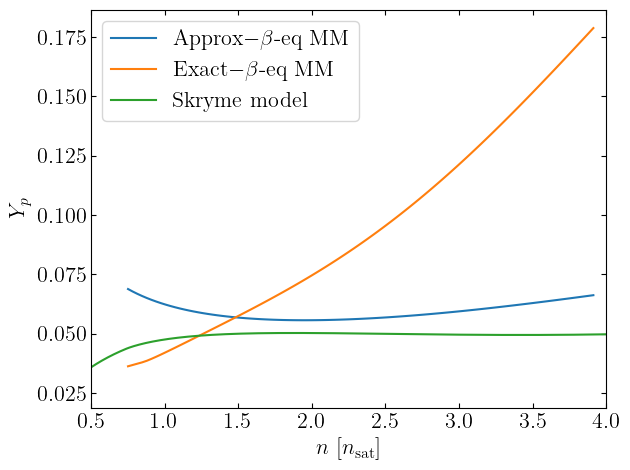

In [4]:
plt.plot(n_metamodel_orig / 0.16, proton_fraction, label = r"Approx$-\beta$-eq MM")
plt.plot(n_metamodel_orig_exact / 0.16, proton_fraction_exact, label = r"Exact$-\beta$-eq MM")
plt.plot(n_nsat_skryme, Yp_skryme, label = r"Skryme model")
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$Y_p$ ")
# plt.yscale("log")
# plt.xscale("log")
plt.xlim(0.5,nbreak / nsat)
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

In [5]:
# n_nsat_skryme = [0.3125, 0.3140628125625125, 0.315625625125025, 0.3171884376875375, 0.31875125025004997, 0.3203140628125625, 0.32187687537507503, 0.32343968793758754, 0.32500250050010004, 0.3265653130626125, 0.32812812562512506, 0.32969093818763756, 0.33125375075015, 0.3328165633126625, 0.334379375875175, 0.33594218843768753, 0.33750500100020003, 0.33906781356271254, 0.34063062612522504, 0.34219343868773755, 0.34375625125025006, 0.34531906381276256, 0.34688187637527507, 0.34844468893778757, 0.3500075015003001, 0.3515703140628126, 0.3531331266253251, 0.3546959391878376, 0.3562587517503501, 0.35782156431286255, 0.3593843768753751, 0.3609471894378876, 0.3625100020004001, 0.36407281456291263, 0.36563562712542513, 0.36719843968793764, 0.36876125225045014, 0.3703240648129626, 0.37188687737547516, 0.37344968993798766, 0.3750125025005001, 0.3765753150630126, 0.37813812762552507, 0.37970094018803763, 0.38126375275055013, 0.38282656531306264, 0.3843893778755752, 0.38595219043808765, 0.38751500300060016, 0.38907781556311266, 0.3906406281256251, 0.3922034406881376, 0.3937662532506501, 0.39532906581316263, 0.39689187837567513, 0.39845469093818764, 0.40001750350070014, 0.40158031606321265, 0.40314312862572516, 0.40470594118823766, 0.40626875375075017, 0.4078315663132627, 0.4093943788757752, 0.4109571914382877, 0.4125200040008002, 0.4140828165633126, 0.4156456291258252, 0.4172084416883376, 0.4187712542508501, 0.4203340668133626, 0.4218968793758752, 0.42345969193838773, 0.4250225045009001, 0.42658531706341263, 0.42814812962592524, 0.42971094218843764, 0.43127375475095014, 0.43283656731346265, 0.43439937987597516, 0.43596219243848766, 0.43752500500100017, 0.4390878175635127, 0.4406506301260252, 0.4422134426885377, 0.4437762552510502, 0.4453390678135627, 0.4469018803760752, 0.4484646929385877, 0.4500275055011002, 0.4515903180636127, 0.4531531306261252, 0.45471594318863773, 0.45627875575115023, 0.45784156831366274, 0.45940438087617524, 0.46096719343868775, 0.46253000600120026, 0.46409281856371276, 0.46565563112622527, 0.4672184436887378, 0.4687812562512503, 0.4703440688137628, 0.4719068813762753, 0.4734696939387878, 0.4750325065013003, 0.47659531906381275, 0.47815813162632526, 0.4797209441888378, 0.4812837567513503, 0.48284656931386283, 0.4844093818763753, 0.48597219443888784, 0.48753500700140034, 0.4890978195639128, 0.4906606321264253, 0.4922234446889378, 0.4937862572514503, 0.4953490698139628, 0.4969118823764753, 0.49847469493898783, 0.5000375075015003, 0.5016003200640128, 0.5031631326265253, 0.5047259451890378, 0.5062887577515504, 0.5078515703140628, 0.5094143828765754, 0.5109771954390878, 0.5125400080016003, 0.5141028205641128, 0.5156656331266253, 0.5172284456891378, 0.5187912582516503, 0.5203540708141629, 0.5219168833766754, 0.5234796959391879, 0.5250425085017003, 0.5266053210642129, 0.5281681336267253, 0.5297309461892379, 0.5312937587517503, 0.5328565713142629, 0.5344193838767753, 0.5359821964392879, 0.5375450090018004, 0.5391078215643129, 0.5406706341268254, 0.5422334466893379, 0.5437962592518504, 0.5453590718143629, 0.5469218843768754, 0.548484696939388, 0.5500475095019004, 0.551610322064413, 0.5531731346269254, 0.554735947189438, 0.5562987597519504, 0.557861572314463, 0.5594243848769754, 0.560987197439488, 0.5625500100020004, 0.564112822564513, 0.5656756351270255, 0.567238447689538, 0.5688012602520505, 0.570364072814563, 0.5719268853770755, 0.573489697939588, 0.5750525105021004, 0.5766153230646129, 0.5781781356271254, 0.5797409481896381, 0.5813037607521505, 0.582866573314663, 0.5844293858771755, 0.5859921984396881, 0.5875550110022004, 0.589117823564713, 0.5906806361272254, 0.592243448689738, 0.5938062612522504, 0.5953690738147629, 0.5969318863772755, 0.598494698939788, 0.6000575115023005, 0.601620324064813, 0.6031831366273255, 0.604745949189838, 0.6063087617523505, 0.6078715743148629, 0.6094343868773755, 0.610997199439888, 0.6125600120024005, 0.614122824564913, 0.6156856371274255, 0.617248449689938, 0.6188112622524505, 0.620374074814963, 0.6219368873774755, 0.623499699939988, 0.6250625125025006, 0.626625325065013, 0.6281881376275256, 0.629750950190038, 0.6313137627525506, 0.632876575315063, 0.6344393878775756, 0.636002200440088, 0.6375650130026006, 0.639127825565113, 0.6406906381276256, 0.6422534506901381, 0.6438162632526506, 0.6453790758151631, 0.6469418883776756, 0.6485047009401881, 0.6500675135027006, 0.6516303260652131, 0.6531931386277257, 0.6547559511902381, 0.6563187637527507, 0.6578815763152631, 0.6594443888777757, 0.6610072014402881, 0.6625700140028007, 0.6641328265653131, 0.6656956391278256, 0.6672584516903382, 0.6688212642528507, 0.670384076815363, 0.6719468893778757, 0.6735097019403881, 0.6750725145029006, 0.6766353270654131, 0.6781981396279256, 0.6797609521904382, 0.6813237647529506, 0.6828865773154631, 0.6844493898779758, 0.6860122024404881, 0.6875750150030007, 0.689137827565513, 0.6907006401280256, 0.692263452690538, 0.6938262652530506, 0.6953890778155631, 0.6969518903780757, 0.6985147029405882, 0.7000775155031007, 0.701640328065613, 0.7032031406281256, 0.7047659531906381, 0.7063287657531507, 0.7078915783156632, 0.7094543908781756, 0.7110172034406881, 0.7125800160032006, 0.7141428285657131, 0.7157056411282257, 0.7172684536907381, 0.7188312662532507, 0.7203940788157631, 0.7219568913782757, 0.7235197039407881, 0.7250825165033007, 0.7266453290658131, 0.7282081416283257, 0.7297709541908382, 0.7313337667533507, 0.7328965793158632, 0.7344593918783757, 0.7360222044408882, 0.7375850170034007, 0.7391478295659132, 0.7407106421284257, 0.7422734546909382, 0.7438362672534508, 0.7453990798159632, 0.7469618923784758, 0.7485247049409882, 0.7500875175035008, 0.7516503300660132, 0.7532131426285257, 0.7547759551910382, 0.7563387677535508, 0.7579015803160633, 0.7594643928785758, 0.7610272054410883, 0.7625900180036008, 0.7641528305661133, 0.7657156431286257, 0.7672784556911383, 0.7688412682536506, 0.7704040808161633, 0.7719668933786757, 0.7735297059411883, 0.7750925185037008, 0.7766553310662133, 0.7782181436287258, 0.7797809561912382, 0.7813437687537509, 0.7829065813162633, 0.7844693938787759, 0.7860322064412884, 0.7875950190038009, 0.7891578315663133, 0.7907206441288257, 0.7922834566913383, 0.7938462692538507, 0.7954090818163634, 0.796971894378876, 0.7985347069413884, 0.8000975195039007, 0.8016603320664133, 0.8032231446289257, 0.8047859571914383, 0.806348769753951, 0.8079115823164633, 0.8094743948789758, 0.8110372074414883, 0.8126000200040008, 0.8141628325665133, 0.8157256451290258, 0.8172884576915384, 0.8188512702540508, 0.8204140828165634, 0.8219768953790758, 0.8235397079415884, 0.8251025205041008, 0.8266653330666134, 0.8282281456291258, 0.8297909581916384, 0.8313537707541508, 0.8329165833166634, 0.8344793958791759, 0.8360422084416884, 0.8376050210042009, 0.8391678335667134, 0.8407306461292259, 0.8422934586917384, 0.8438562712542508, 0.8454190838167635, 0.8469818963792759, 0.8485447089417885, 0.8501075215043009, 0.8516703340668133, 0.8532331466293258, 0.8547959591918383, 0.8563587717543509, 0.8579215843168635, 0.859484396879376, 0.8610472094418885, 0.8626100220044008, 0.8641728345669133, 0.8657356471294259, 0.8672984596919383, 0.8688612722544509, 0.8704240848169633, 0.8719868973794759, 0.8735497099419883, 0.8751125225045009, 0.8766753350670133, 0.8782381476295259, 0.8798009601920384, 0.881363772754551, 0.8829265853170634, 0.8844893978795759, 0.8860522104420884, 0.8876150230046009, 0.8891778355671134, 0.890740648129626, 0.8923034606921384, 0.893866273254651, 0.8954290858171634, 0.896991898379676, 0.8985547109421884, 0.900117523504701, 0.9016803360672134, 0.903243148629726, 0.9048059611922384, 0.906368773754751, 0.9079315863172635, 0.909494398879776, 0.9110572114422885, 0.912620024004801, 0.9141828365673135, 0.915745649129826, 0.9173084616923385, 0.918871274254851, 0.9204340868173635, 0.9219968993798761, 0.9235597119423885, 0.9251225245049011, 0.9266853370674135, 0.9282481496299261, 0.9298109621924385, 0.9313737747549511, 0.9329365873174635, 0.9344993998799761, 0.9360622124424886, 0.9376250250050011, 0.9391878375675136, 0.9407506501300261, 0.9423134626925386, 0.9438762752550511, 0.9454390878175636, 0.9470019003800761, 0.9485647129425886, 0.9501275255051012, 0.9516903380676136, 0.9532531506301262, 0.9548159631926386, 0.9563787757551512, 0.9579415883176636, 0.9595044008801762, 0.9610672134426886, 0.9626300260052012, 0.9641928385677137, 0.965755651130226, 0.9673184636927386, 0.968881276255251, 0.9704440888177637, 0.9720069013802762, 0.9735697139427887, 0.9751325265053012, 0.9766953390678137, 0.978258151630326, 0.9798209641928386, 0.9813837767553513, 0.9829465893178637, 0.9845094018803763, 0.9860722144428886, 0.9876350270054011, 0.9891978395679136, 0.9907606521304261, 0.9923234646929386, 0.9938862772554511, 0.9954490898179638, 0.9970119023804761, 0.9985747149429887, 1.0001375275055011, 1.0017003400680136, 1.0032631526305262, 1.0048259651930387, 1.0063887777555511, 1.0079515903180636, 1.0095144028805763, 1.0110772154430887, 1.0126400280056012, 1.0142028405681136, 1.0157656531306263, 1.0173284656931387, 1.0188912782556512, 1.0204540908181636, 1.0220169033806763, 1.0235797159431888, 1.0251425285057012, 1.0267053410682137, 1.028268153630726, 1.0298309661932386, 1.0313937787557512, 1.0329565913182637, 1.0345194038807763, 1.0360822164432888, 1.0376450290058012, 1.0392078415683137, 1.0407706541308261, 1.0423334666933386, 1.043896279255851, 1.0454590918183637, 1.0470219043808764, 1.0485847169433886, 1.050147529505901, 1.0517103420684137, 1.0532731546309262, 1.0548359671934386, 1.0563987797559513, 1.0579615923184638, 1.0595244048809762, 1.0610872174434887, 1.0626500300060011, 1.0642128425685138, 1.0657756551310262, 1.0673384676935387, 1.0689012802560511, 1.0704640928185638, 1.0720269053810763, 1.0735897179435887, 1.0751525305061012, 1.0767153430686138, 1.0782781556311265, 1.0798409681936387, 1.0814037807561512, 1.0829665933186639, 1.0845294058811763, 1.0860922184436888, 1.0876550310062012, 1.0892178435687139, 1.0907806561312263, 1.0923434686937388, 1.0939062812562512, 1.095469093818764, 1.0970319063812763, 1.0985947189437888, 1.1001575315063012, 1.101720344068814, 1.1032831566313264, 1.1048459691938388, 1.1064087817563513, 1.107971594318864, 1.1095344068813764, 1.1110972194438888, 1.1126600320064013, 1.114222844568914, 1.1157856571314264, 1.1173484696939389, 1.1189112822564513, 1.120474094818964, 1.1220369073814764, 1.1235997199439887, 1.1251625325065013, 1.126725345069014, 1.1282881576315265, 1.129850970194039, 1.1314137827565514, 1.132976595319064, 1.1345394078815765, 1.136102220444089, 1.1376650330066014, 1.139227845569114, 1.1407906581316265, 1.142353470694139, 1.1439162832566514, 1.1454790958191639, 1.1470419083816763, 1.1486047209441888, 1.1501675335067014, 1.151730346069214, 1.1532931586317265, 1.154855971194239, 1.1564187837567514, 1.1579815963192641, 1.1595444088817766, 1.161107221444289, 1.1626700340068015, 1.164232846569314, 1.1657956591318264, 1.1673584716943388, 1.1689212842568515, 1.170484096819364, 1.1720469093818764, 1.1736097219443888, 1.1751725345069015, 1.1767353470694142, 1.1782981596319266, 1.179860972194439, 1.1814237847569515, 1.182986597319464, 1.1845494098819764, 1.1861122224444889, 1.1876750350070016, 1.189237847569514, 1.1908006601320265, 1.192363472694539, 1.1939262852570516, 1.195489097819564, 1.1970519103820765, 1.198614722944589, 1.2001775355071016, 1.201740348069614, 1.2033031606321265, 1.204865973194639, 1.2064287857571516, 1.207991598319664, 1.2095544108821765, 1.211117223444689, 1.2126800360072016, 1.214242848569714, 1.2158056611322265, 1.217368473694739, 1.2189312862572514, 1.220494098819764, 1.2220569113822763, 1.223619723944789, 1.2251825365073015, 1.2267453490698141, 1.2283081616323266, 1.229870974194839, 1.2314337867573517, 1.2329965993198642, 1.2345594118823766, 1.236122224444889, 1.2376850370074015, 1.239247849569914, 1.2408106621324264, 1.242373474694939, 1.2439362872574515, 1.245499099819964, 1.2470619123824764, 1.248624724944989, 1.2501875375075018, 1.2517503500700142, 1.2533131626325267, 1.2548759751950391, 1.2564387877575516, 1.258001600320064, 1.2595644128825765, 1.2611272254450892, 1.2626900380076016, 1.264252850570114, 1.2658156631326265, 1.2673784756951392, 1.2689412882576516, 1.270504100820164, 1.2720669133826765, 1.2736297259451892, 1.2751925385077016, 1.276755351070214, 1.2783181636327265, 1.2798809761952392, 1.2814437887577517, 1.2830066013202641, 1.2845694138827766, 1.2861322264452892, 1.2876950390078017, 1.2892578515703141, 1.2908206641328266, 1.2923834766953393, 1.2939462892578517, 1.2955091018203642, 1.2970719143828766, 1.2986347269453893, 1.3001975395079017, 1.3017603520704142, 1.3033231646329266, 1.3048859771954393, 1.3064487897579518, 1.3080116023204642, 1.3095744148829767, 1.3111372274454893, 1.3127000400080018, 1.3142628525705142, 1.3158256651330267, 1.3173884776955394, 1.3189512902580518, 1.320514102820564, 1.3220769153830765, 1.3236397279455892, 1.3252025405081016, 1.3267653530706143, 1.3283281656331267, 1.3298909781956394, 1.3314537907581518, 1.3330166033206643, 1.3345794158831767, 1.3361422284456892, 1.3377050410082019, 1.3392678535707143, 1.3408306661332265, 1.3423934786957392, 1.3439562912582517, 1.3455191038207641, 1.3470819163832766, 1.3486447289457892, 1.350207541508302, 1.3517703540708144, 1.3533331666333268, 1.3548959791958393, 1.356458791758352, 1.3580216043208644, 1.3595844168833766, 1.3611472294458893, 1.3627100420084017, 1.3642728545709142, 1.3658356671334266, 1.3673984796959393, 1.3689612922584518, 1.3705241048209642, 1.3720869173834767, 1.3736497299459893, 1.3752125425085016, 1.3767753550710145, 1.378338167633527, 1.3799009801960394, 1.3814637927585518, 1.3830266053210643, 1.3845894178835767, 1.3861522304460894, 1.3877150430086018, 1.3892778555711143, 1.3908406681336267, 1.3924034806961394, 1.3939662932586518, 1.395529105821164, 1.3970919183836767, 1.3986547309461892, 1.4002175435087019, 1.4017803560712143, 1.4033431686337268, 1.4049059811962394, 1.406468793758752, 1.4080316063212643, 1.4095944188837768, 1.4111572314462895, 1.412720044008802, 1.4142828565713141, 1.4158456691338268, 1.4174084816963393, 1.4189712942588517, 1.4205341068213642, 1.4220969193838768, 1.4236597319463893, 1.4252225445089017, 1.4267853570714144, 1.4283481696339269, 1.4299109821964395, 1.431473794758952, 1.4330366073214644, 1.4345994198839769, 1.4361622324464893, 1.4377250450090018, 1.4392878575715142, 1.440850670134027, 1.4424134826965394, 1.4439762952590518, 1.4455391078215643, 1.447101920384077, 1.4486647329465894, 1.450227545509102, 1.4517903580716145, 1.453353170634127, 1.4549159831966394, 1.4564787957591518, 1.4580416083216643, 1.459604420884177, 1.4611672334466894, 1.4627300460092019, 1.4642928585717143, 1.465855671134227, 1.4674184836967394, 1.468981296259252, 1.4705441088217643, 1.472106921384277, 1.4736697339467895, 1.475232546509302, 1.4767953590718144, 1.478358171634327, 1.4799209841968395, 1.481483796759352, 1.4830466093218644, 1.484609421884377, 1.4861722344468895, 1.487735047009402, 1.4892978595719144, 1.490860672134427, 1.4924234846969395, 1.493986297259452, 1.4955491098219644, 1.497111922384477, 1.4986747349469893, 1.500237547509502, 1.5018003600720145, 1.5033631726345271, 1.5049259851970396, 1.506488797759552, 1.5080516103220645, 1.5096144228845771, 1.5111772354470896, 1.512740048009602, 1.5143028605721145, 1.5158656731346272, 1.5174284856971394, 1.5189912982596518, 1.5205541108221645, 1.522116923384677, 1.5236797359471894, 1.5252425485097019, 1.5268053610722145, 1.5283681736347272, 1.5299309861972397, 1.5314937987597521, 1.5330566113222646, 1.5346194238847772, 1.5361822364472897, 1.537745049009802, 1.5393078615723146, 1.540870674134827, 1.5424334866973395, 1.543996299259852, 1.5455591118223646, 1.547121924384877, 1.5486847369473895, 1.5502475495099022, 1.5518103620724146, 1.5533731746349273, 1.5549359871974398, 1.556498799759952, 1.5580616123224647, 1.559624424884977, 1.5611872374474896, 1.562750050010002, 1.5643128625725145, 1.565875675135027, 1.5674384876975394, 1.569001300260052, 1.5705641128225645, 1.572126925385077, 1.5736897379475894, 1.575252550510102, 1.5768153630726147, 1.5783781756351274, 1.5799409881976394, 1.581503800760152, 1.5830666133226645, 1.584629425885177, 1.5861922384476894, 1.587755051010202, 1.5893178635727145, 1.590880676135227, 1.5924434886977394, 1.5940063012602521, 1.5955691138227646, 1.597131926385277, 1.5986947389477895, 1.6002575515103021, 1.6018203640728146, 1.603383176635327, 1.6049459891978395, 1.6065088017603522, 1.6080716143228646, 1.609634426885377, 1.6111972394478895, 1.6127600520104022, 1.6143228645729146, 1.615885677135427, 1.6174484896979395, 1.6190113022604522, 1.6205741148229647, 1.622136927385477, 1.6236997399479896, 1.6252625525105022, 1.6268253650730147, 1.6283881776355271, 1.6299509901980396, 1.6315138027605522, 1.6330766153230647, 1.6346394278855771, 1.6362022404480896, 1.6377650530106023, 1.6393278655731147, 1.6408906781356272, 1.6424534906981396, 1.6440163032606523, 1.6455791158231647, 1.6471419283856772, 1.6487047409481896, 1.6502675535107023, 1.6518303660732148, 1.6533931786357272, 1.6549559911982397, 1.6565188037607523, 1.6580816163232648, 1.6596444288857772, 1.6612072414482897, 1.6627700540108024, 1.6643328665733148, 1.6658956791358273, 1.6674584916983397, 1.6690213042608524, 1.6705841168233648, 1.6721469293858773, 1.6737097419483897, 1.6752725545109024, 1.6768353670734149, 1.6783981796359273, 1.6799609921984398, 1.6815238047609524, 1.6830866173234649, 1.6846494298859773, 1.6862122424484898, 1.6877750550110024, 1.689337867573515, 1.6909006801360273, 1.6924634926985398, 1.6940263052610525, 1.695589117823565, 1.6971519303860774, 1.6987147429485898, 1.7002775555111025, 1.701840368073615, 1.7034031806361274, 1.7049659931986398, 1.7065288057611525, 1.708091618323665, 1.7096544308861774, 1.7112172434486899, 1.7127800560112025, 1.714342868573715, 1.7159056811362274, 1.7174684936987399, 1.7190313062612526, 1.720594118823765, 1.7221569313862775, 1.72371974394879, 1.7252825565113026, 1.726845369073815, 1.7284081816363275, 1.72997099419884, 1.7315338067613526, 1.733096619323865, 1.7346594318863775, 1.73622224444889, 1.7377850570114026, 1.739347869573915, 1.7409106821364275, 1.74247349469894, 1.7440363072614526, 1.7455991198239647, 1.7471619323864773, 1.7487247449489898, 1.7502875575115027, 1.7518503700740151, 1.7534131826365276, 1.75497599519904, 1.7565388077615527, 1.7581016203240651, 1.7596644328865776, 1.76122724544909, 1.7627900580116027, 1.7643528705741152, 1.7659156831366274, 1.7674784956991398, 1.7690413082616523, 1.7706041208241647, 1.7721669333866774, 1.7737297459491899, 1.7752925585117023, 1.7768553710742152, 1.7784181836367277, 1.77998099619924, 1.7815438087617528, 1.7831066213242652, 1.7846694338867775, 1.78623224644929, 1.7877950590118024, 1.7893578715743148, 1.7909206841368275, 1.79248349669934, 1.7940463092618524, 1.7956091218243648, 1.7971719343868775, 1.79873474694939, 1.8002975595119028, 1.8018603720744153, 1.8034231846369277, 1.80498599719944, 1.8065488097619524, 1.8081116223244649, 1.8096744348869775, 1.81123724744949, 1.8128000600120024, 1.814362872574515, 1.8159256851370276, 1.81748849769954, 1.8190513102620525, 1.820614122824565, 1.8221769353870776, 1.82373974794959, 1.8253025605121025, 1.826865373074615, 1.8284281856371276, 1.82999099819964, 1.8315538107621525, 1.833116623324665, 1.8346794358871776, 1.83624224844969, 1.837805061012202, 1.8393678735747154, 1.8409306861372279, 1.8424934986997403, 1.844056311262253, 1.845619123824765, 1.8471819363872777, 1.8487447489497901, 1.8503075615123026, 1.851870374074815, 1.8534331866373277, 1.8549959991998402, 1.8565588117623526, 1.858121624324865, 1.8596844368873777, 1.8612472494498902, 1.8628100620124026, 1.864372874574915, 1.8659356871374277, 1.8674984996999402, 1.8690613122624526, 1.870624124824965, 1.8721869373874778, 1.8737497499499902, 1.8753125625125027, 1.876875375075015, 1.8784381876375273, 1.8800010002000398, 1.8815638127625522, 1.883126625325065, 1.8846894378875774, 1.8862522504500898, 1.8878150630126027, 1.8893778755751152, 1.8909406881376278, 1.8925035007001403, 1.8940663132626527, 1.8956291258251652, 1.8971919383876779, 1.8987547509501903, 1.9003175635127028, 1.9018803760752152, 1.9034431886377279, 1.9050060012002403, 1.9065688137627528, 1.9081316263252652, 1.909694438887778, 1.9112572514502904, 1.9128200640128028, 1.9143828765753153, 1.9159456891378275, 1.91750850170034, 1.9190713142628524, 1.920634126825365, 1.9221969393878775, 1.92375975195039, 1.9253225645129024, 1.926885377075415, 1.9284481896379275, 1.93001100220044, 1.9315738147629524, 1.933136627325465, 1.9346994398879775, 1.93626225245049, 1.9378250650130024, 1.9393878775755153, 1.940950690138028, 1.9425135027005405, 1.944076315263053, 1.9456391278255654, 1.947201940388078, 1.9487647529505905, 1.950327565513103, 1.9518903780756154, 1.953453190638128, 1.95501600320064, 1.9565788157631525, 1.9581416283256652, 1.9597044408881776, 1.96126725345069, 1.9628300660132025, 1.9643928785757152, 1.9659556911382277, 1.96751850370074, 1.9690813162632526, 1.9706441288257652, 1.9722069413882777, 1.9737697539507901, 1.9753325665133026, 1.9768953790758153, 1.9784581916383277, 1.9800210042008402, 1.9815838167633526, 1.9831466293258653, 1.9847094418883777, 1.9862722544508902, 1.987835067013403, 1.9893978795759155, 1.9909606921384282, 1.9925235047009406, 1.994086317263453, 1.9956491298259653, 1.9972119423884778, 1.9987747549509902, 2.000337567513503, 2.001900380076015, 2.003463192638528, 2.0050260052010405, 2.0065888177635527, 2.0081516303260654, 2.0097144428885776, 2.0112772554510903, 2.012840068013603, 2.014402880576115, 2.015965693138628, 2.0175285057011405, 2.0190913182636527, 2.0206541308261654, 2.0222169433886776, 2.0237797559511903, 2.025342568513703, 2.026905381076215, 2.028468193638728, 2.0300310062012406, 2.031593818763753, 2.0331566313262655, 2.0347194438887777, 2.0362822564512904, 2.037845069013803, 2.0394078815763153, 2.040970694138828, 2.0425335067013406, 2.044096319263853, 2.0456591318263655, 2.0472219443888777, 2.0487847569513904, 2.050347569513903, 2.0519103820764153, 2.053473194638928, 2.0550360072014406, 2.056598819763953, 2.0581616323264655, 2.0597244448889778, 2.0612872574514904, 2.062850070014003, 2.0644128825765153, 2.065975695139028, 2.0675385077015407, 2.069101320264053, 2.0706641328265656, 2.072226945389078, 2.0737897579515905, 2.075352570514103, 2.0769153830766154, 2.078478195639128, 2.0800410082016407, 2.0816038207641525, 2.083166633326665, 2.084729445889178, 2.08629225845169, 2.087855071014203, 2.0894178835767154, 2.090980696139228, 2.0925435087017408, 2.094106321264253, 2.0956691338267657, 2.097231946389278, 2.0987947589517906, 2.1003575715143032, 2.1019203840768155, 2.103483196639328, 2.105046009201841, 2.106608821764353, 2.1081716343268657, 2.109734446889378, 2.1112972594518906, 2.1128600720144033, 2.1144228845769155, 2.115985697139428, 2.117548509701941, 2.119111322264453, 2.1206741348269653, 2.122236947389478, 2.12379975995199, 2.125362572514503, 2.1269253850770156, 2.128488197639528, 2.1300510102020405, 2.1316138227645527, 2.1331766353270654, 2.134739447889578, 2.1363022604520903, 2.137865073014603, 2.1394278855771156, 2.1409906981396283, 2.142553510702141, 2.144116323264653, 2.145679135827166, 2.147241948389678, 2.1488047609521908, 2.1503675735147034, 2.1519303860772157, 2.1534931986397283, 2.155056011202241, 2.1566188237647532, 2.158181636327266, 2.159744448889778, 2.1613072614522904, 2.162870074014803, 2.1644328865773157, 2.165995699139828, 2.1675585117023406, 2.169121324264853, 2.1706841368273655, 2.172246949389878, 2.1738097619523904, 2.175372574514903, 2.1769353870774157, 2.178498199639928, 2.1800610122024406, 2.181623824764953, 2.1831866373274655, 2.184749449889978, 2.1863122624524904, 2.1878750750150036, 2.189437887577516, 2.1910007001400285, 2.192563512702541, 2.1941263252650534, 2.195689137827566, 2.1972519503900783, 2.198814762952591, 2.200377575515103, 2.201940388077616, 2.203503200640128, 2.2050660132026407, 2.206628825765153, 2.2081916383276656, 2.2097544508901783, 2.2113172634526905, 2.212880076015203, 2.214442888577716, 2.216005701140228, 2.2175685137027408, 2.219131326265253, 2.2206941388277657, 2.2222569513902783, 2.2238197639527906, 2.2253825765153032, 2.226945389077816, 2.228508201640328, 2.230071014202841, 2.231633826765353, 2.2331966393278653, 2.234759451890378, 2.2363222644528906, 2.237885077015403, 2.239447889577916, 2.241010702140428, 2.242573514702941, 2.244136327265453, 2.2456991398279658, 2.2472619523904784, 2.2488247649529907, 2.2503875775155033, 2.251950390078016, 2.2535132026405282, 2.255076015203041, 2.256638827765553, 2.258201640328066, 2.2597644528905785, 2.2613272654530907, 2.2628900780156034, 2.264452890578116, 2.2660157031406283, 2.267578515703141, 2.269141328265653, 2.2707041408281654, 2.272266953390678, 2.2738297659531908, 2.275392578515703, 2.2769553910782157, 2.278518203640728, 2.2800810162032406, 2.2816438287657532, 2.2832066413282655, 2.284769453890778, 2.286332266453291, 2.2878950790158035, 2.289457891578316, 2.2910207041408284, 2.292583516703341, 2.2941463292658533, 2.295709141828366, 2.2972719543908786, 2.298834766953391, 2.3003975795159035, 2.301960392078416, 2.3035232046409284, 2.305086017203441, 2.3066488297659533, 2.308211642328466, 2.3097744548909787, 2.311337267453491, 2.312900080016003, 2.314462892578516, 2.316025705141028, 2.3175885177035407, 2.3191513302660534, 2.3207141428285656, 2.3222769553910783, 2.323839767953591, 2.325402580516103, 2.326965393078616, 2.328528205641128, 2.3300910182036407, 2.3316538307661534, 2.3332166433286656, 2.3347794558911783, 2.336342268453691, 2.337905081016203, 2.3394678935787163, 2.3410307061412285, 2.342593518703741, 2.3441563312662534, 2.345719143828766, 2.347281956391279, 2.348844768953791, 2.3504075815163032, 2.351970394078816, 2.353533206641328, 2.355096019203841, 2.3566588317663535, 2.3582216443288657, 2.3597844568913784, 2.361347269453891, 2.3629100820164033, 2.364472894578916, 2.366035707141428, 2.367598519703941, 2.3691613322664535, 2.3707241448289658, 2.3722869573914784, 2.373849769953991, 2.3754125825165033, 2.376975395079016, 2.3785382076415282, 2.380101020204041, 2.3816638327665536, 2.383226645329066, 2.3847894578915785, 2.386352270454091, 2.387915083016604, 2.389477895579116, 2.3910407081416283, 2.392603520704141, 2.3941663332666536, 2.395729145829166, 2.3972919583916785, 2.398854770954191, 2.4004175835167034, 2.401980396079216, 2.4035432086417283, 2.405106021204241, 2.4066688337667537, 2.408231646329266, 2.4097944588917786, 2.4113572714542912, 2.4129200840168035, 2.414482896579316, 2.4160457091418284, 2.417608521704341, 2.4191713342668537, 2.420734146829366, 2.4222969593918786, 2.4238597719543913, 2.4254225845169035, 2.426985397079416, 2.4285482096419284, 2.430111022204441, 2.4316738347669533, 2.4332366473294655, 2.434799459891978, 2.436362272454491, 2.437925085017003, 2.4394878975795162, 2.4410507101420285, 2.442613522704541, 2.444176335267054, 2.445739147829566, 2.4473019603920787, 2.4488647729545914, 2.4504275855171036, 2.4519903980796163, 2.4535532106421285, 2.455116023204641, 2.456678835767154, 2.458241648329666, 2.4598044608921787, 2.4613672734546914, 2.4629300860172036, 2.4644928985797163, 2.4660557111422285, 2.467618523704741, 2.469181336267254, 2.4707441488297657, 2.4723069613922783, 2.473869773954791, 2.4754325865173032, 2.476995399079816, 2.4785582116423286, 2.480121024204841, 2.4816838367673535, 2.4832466493298657, 2.4848094618923784, 2.486372274454891, 2.4879350870174037, 2.4894978995799164, 2.4910607121424286, 2.4926235247049413, 2.494186337267454, 2.495749149829966, 2.497311962392479, 2.4988747749549916, 2.500437587517504, 2.5020004000800165, 2.5035632126425287, 2.5051260252050414, 2.506688837767554, 2.5082516503300663, 2.5098144628925785, 2.511377275455091, 2.5129400880176034, 2.514502900580116, 2.5160657131426287, 2.517628525705141, 2.5191913382676536, 2.520754150830166, 2.5223169633926785, 2.523879775955191, 2.5254425885177034, 2.527005401080216, 2.5285682136427288, 2.530131026205241, 2.5316938387677537, 2.533256651330266, 2.5348194638927786, 2.5363822764552912, 2.5379450890178035, 2.5395079015803166, 2.541070714142829, 2.5426335267053415, 2.544196339267854, 2.5457591518303664, 2.547321964392879, 2.5488847769553913, 2.5504475895179035, 2.552010402080416, 2.553573214642929, 2.555136027205441, 2.5566988397679538, 2.558261652330466, 2.5598244648929787, 2.5613872774554913, 2.5629500900180036, 2.5645129025805162, 2.566075715143029, 2.567638527705541, 2.569201340268054, 2.570764152830566, 2.5723269653930787, 2.5738897779555914, 2.5754525905181036, 2.5770154030806163, 2.578578215643129, 2.580141028205641, 2.581703840768154, 2.583266653330666, 2.5848294658931787, 2.586392278455691, 2.5879550910182036, 2.5895179035807163, 2.591080716143229, 2.592643528705741, 2.594206341268254, 2.595769153830766, 2.597331966393279, 2.5988947789557915, 2.6004575915183037, 2.6020204040808164, 2.603583216643329, 2.6051460292058413, 2.606708841768354, 2.608271654330866, 2.609834466893379, 2.6113972794558915, 2.6129600920184037, 2.6145229045809164, 2.616085717143429, 2.6176485297059413, 2.619211342268454, 2.620774154830966, 2.622336967393479, 2.6238997799559916, 2.625462592518504, 2.627025405081016, 2.6285882176435287, 2.630151030206041, 2.6317138427685536, 2.6332766553310663, 2.6348394678935785, 2.636402280456091, 2.637965093018604, 2.6395279055811165, 2.641090718143629, 2.6426535307061414, 2.644216343268654, 2.6457791558311663, 2.647341968393679, 2.6489047809561916, 2.650467593518704, 2.6520304060812165, 2.653593218643729, 2.6551560312062414, 2.656718843768754, 2.6582816563312663, 2.659844468893779, 2.6614072814562917, 2.662970094018804, 2.6645329065813166, 2.666095719143829, 2.667658531706341, 2.6692213442688537, 2.6707841568313664, 2.6723469693938786, 2.6739097819563913, 2.675472594518904, 2.677035407081416, 2.678598219643929, 2.680161032206441, 2.6817238447689538, 2.6832866573314664, 2.6848494698939787, 2.6864122824564913, 2.687975095019004, 2.6895379075815167, 2.6911007201440293, 2.6926635327065416, 2.6942263452690542, 2.6957891578315665, 2.697351970394079, 2.698914782956592, 2.700477595519104, 2.7020404080816167, 2.7036032206441294, 2.705166033206641, 2.706728845769154, 2.7082916583316665, 2.7098544708941787, 2.7114172834566914, 2.712980096019204, 2.7145429085817163, 2.716105721144229, 2.717668533706741, 2.719231346269254, 2.7207941588317666, 2.722356971394279, 2.7239197839567915, 2.725482596519304, 2.7270454090818164, 2.728608221644329, 2.7301710342068413, 2.731733846769354, 2.7332966593318666, 2.734859471894379, 2.7364222844568915, 2.737985097019404, 2.739547909581917, 2.7411107221444295, 2.7426735347069418, 2.744236347269454, 2.7457991598319667, 2.747361972394479, 2.7489247849569916, 2.7504875975195042, 2.7520504100820165, 2.753613222644529, 2.7551760352070414, 2.756738847769554, 2.7583016603320667, 2.759864472894579, 2.7614272854570916, 2.7629900980196043, 2.7645529105821165, 2.766115723144629, 2.7676785357071414, 2.769241348269654, 2.7708041608321667, 2.772366973394679, 2.7739297859571916, 2.7754925985197043, 2.7770554110822165, 2.778618223644729, 2.7801810362072414, 2.781743848769754, 2.783306661332267, 2.784869473894779, 2.7864322864572912, 2.7879950990198044, 2.7895579115823166, 2.7911207241448293, 2.7926835367073415, 2.794246349269854, 2.795809161832367, 2.797371974394879, 2.7989347869573917, 2.8004975995199044, 2.8020604120824166, 2.8036232246449293, 2.8051860372074415, 2.806748849769954, 2.808311662332467, 2.809874474894979, 2.8114372874574918, 2.8130001000200044, 2.8145629125825167, 2.8161257251450293, 2.8176885377075416, 2.8192513502700542, 2.820814162832567, 2.822376975395079, 2.823939787957592, 2.825502600520104, 2.8270654130826163, 2.828628225645129, 2.8301910382076416, 2.831753850770154, 2.8333166633326665, 2.834879475895179, 2.8364422884576914, 2.838005101020204, 2.8395679135827168, 2.8411307261452294, 2.8426935387077417, 2.8442563512702543, 2.845819163832767, 2.8473819763952792, 2.848944788957792, 2.8505076015203046, 2.852070414082817, 2.8536332266453295, 2.8551960392078417, 2.8567588517703544, 2.858321664332867, 2.8598844768953793, 2.861447289457892, 2.8630101020204046, 2.8645729145829164, 2.866135727145429, 2.8676985397079418, 2.869261352270454, 2.8708241648329667, 2.8723869773954793, 2.8739497899579916, 2.8755126025205042, 2.8770754150830165, 2.878638227645529, 2.880201040208042, 2.881763852770554, 2.8833266653330667, 2.8848894778955794, 2.8864522904580916, 2.8880151030206047, 2.889577915583117, 2.8911407281456296, 2.892703540708142, 2.8942663532706545, 2.895829165833167, 2.8973919783956794, 2.898954790958192, 2.9005176035207048, 2.902080416083217, 2.903643228645729, 2.905206041208242, 2.906768853770754, 2.908331666333267, 2.9098944788957795, 2.9114572914582917, 2.9130201040208044, 2.9145829165833166, 2.9161457291458293, 2.917708541708342, 2.919271354270854, 2.920834166833367, 2.9223969793958795, 2.9239597919583917, 2.9255226045209044, 2.9270854170834166, 2.9286482296459293, 2.930211042208442, 2.931773854770954, 2.933336667333467, 2.9348994798959795, 2.9364622924584918, 2.9380251050210044, 2.939587917583517, 2.94115073014603, 2.942713542708542, 2.9442763552710542, 2.945839167833567, 2.9474019803960796, 2.948964792958592, 2.9505276055211045, 2.9520904180836167, 2.9536532306461294, 2.955216043208642, 2.9567788557711543, 2.958341668333667, 2.9599044808961796, 2.961467293458692, 2.9630301060212045, 2.9645929185837168, 2.9661557311462294, 2.967718543708742, 2.9692813562712543, 2.970844168833767, 2.9724069813962797, 2.973969793958792, 2.9755326065213046, 2.977095419083817, 2.9786582316463295, 2.9802210442088417, 2.981783856771354, 2.9833466693338666, 2.9849094818963793, 2.9864722944588915, 2.9880351070214046, 2.989597919583917, 2.9911607321464295, 2.992723544708942, 2.9942863572714544, 2.995849169833967, 2.9974119823964798, 2.998974794958992, 3.0005376075215047, 3.002100420084017, 3.0036632326465296, 3.0052260452090422, 3.0067888577715545, 3.008351670334067, 3.00991448289658, 3.011477295459092, 3.0130401080216047, 3.014602920584117, 3.0161657331466296, 3.0177285457091423, 3.0192913582716545, 3.0208541708341667, 3.0224169833966794, 3.0239797959591916, 3.0255426085217043, 3.027105421084217, 3.028668233646729, 3.030231046209242, 3.031793858771754, 3.033356671334267, 3.0349194838967795, 3.0364822964592917, 3.0380451090218044, 3.039607921584317, 3.0411707341468297, 3.0427335467093424, 3.0442963592718546, 3.0458591718343673, 3.04742198439688, 3.048984796959392, 3.050547609521905, 3.052110422084417, 3.0536732346469297, 3.0552360472094424, 3.0567988597719546, 3.0583616723344673, 3.0599244848969795, 3.0614872974594918, 3.0630501100220044, 3.064612922584517, 3.0661757351470293, 3.067738547709542, 3.0693013602720542, 3.070864172834567, 3.0724269853970796, 3.073989797959592, 3.0755526105221045, 3.077115423084617, 3.0786782356471294, 3.080241048209642, 3.0818038607721543, 3.083366673334667, 3.0849294858971796, 3.086492298459692, 3.088055111022205, 3.089617923584717, 3.09118073614723, 3.0927435487097426, 3.094306361272255, 3.0958691738347675, 3.09743198639728, 3.098994798959792, 3.1005576115223046, 3.1021204240848173, 3.1036832366473295, 3.105246049209842, 3.1068088617723544, 3.108371674334867, 3.1099344868973797, 3.111497299459892, 3.1130601120224046, 3.1146229245849173, 3.1161857371474295, 3.117748549709942, 3.1193113622724544, 3.120874174834967, 3.1224369873974798, 3.123999799959992, 3.1255626125225047, 3.1271254250850173, 3.1286882376475296, 3.1302510502100422, 3.1318138627725545, 3.133376675335067, 3.13493948789758, 3.136502300460092, 3.1380651130226047, 3.1396279255851174, 3.1411907381476296, 3.1427535507101423, 3.1443163632726545, 3.145879175835167, 3.14744198839768, 3.149004800960192, 3.1505676135227048, 3.1521304260852174, 3.1536932386477297, 3.1552560512102423, 3.1568188637727546, 3.1583816763352672, 3.15994448889778, 3.161507301460292, 3.163070114022805, 3.1646329265853175, 3.1661957391478297, 3.1677585517103424, 3.1693213642728546, 3.1708841768353673, 3.17244698939788, 3.174009801960392, 3.175572614522905, 3.1771354270854175, 3.1786982396479297, 3.1802610522104424, 3.1818238647729546, 3.1833866773354673, 3.18494948989798, 3.186512302460492, 3.188075115023005, 3.1896379275855176, 3.19120074014803, 3.1927635527105425, 3.1943263652730547, 3.1958891778355674, 3.19745199039808, 3.1990148029605923, 3.200577615523105, 3.2021404280856176, 3.20370324064813, 3.2052660532106425, 3.2068288657731547, 3.2083916783356674, 3.20995449089818, 3.2115173034606923, 3.213080116023205, 3.2146429285857177, 3.21620574114823, 3.2177685537107426, 3.219331366273255, 3.2208941788357675, 3.22245699139828, 3.2240198039607924, 3.225582616523305, 3.2271454290858177, 3.22870824164833, 3.2302710542108426, 3.231833866773355, 3.2333966793358675, 3.23495949189838, 3.2365223044608924, 3.238085117023405, 3.2396479295859177, 3.24121074214843, 3.2427735547109426, 3.244336367273455, 3.2458991798359675, 3.24746199239848, 3.2490248049609924, 3.250587617523505, 3.252150430086018, 3.25371324264853, 3.2552760552110427, 3.256838867773555, 3.2584016803360676, 3.2599644928985803, 3.2615273054610925, 3.263090118023605, 3.264652930586118, 3.26621574314863, 3.2677785557111427, 3.269341368273655, 3.2709041808361676, 3.2724669933986803, 3.2740298059611925, 3.275592618523705, 3.277155431086218, 3.27871824364873, 3.280281056211242, 3.2818438687737546, 3.2834066813362672, 3.2849694938987795, 3.286532306461292, 3.2880951190238052, 3.289657931586318, 3.29122074414883, 3.292783556711343, 3.294346369273855, 3.2959091818363677, 3.2974719943988804, 3.2990348069613926, 3.3005976195239053, 3.302160432086418, 3.30372324464893, 3.305286057211443, 3.306848869773955, 3.3084116823364678, 3.3099744948989804, 3.3115373074614927, 3.3131001200240053, 3.314662932586518, 3.3162257451490302, 3.317788557711543, 3.3193513702740547, 3.320914182836568, 3.3224769953990796, 3.3240398079615927, 3.3256026205241045, 3.327165433086618, 3.32872824564913, 3.330291058211643, 3.3318538707741547, 3.333416683336668, 3.3349794958991796, 3.3365423084616928, 3.3381051210242045, 3.339667933586718, 3.34123074614923, 3.342793558711743, 3.344356371274255, 3.345919183836768, 3.3474819963992797, 3.349044808961793, 3.3506076215243046, 3.352170434086818, 3.35373324664933, 3.355296059211843, 3.356858871774355, 3.358421684336868, 3.3599844968993797, 3.3615473094618924, 3.3631101220244046, 3.3646729345869173, 3.3662357471494304, 3.367798559711942, 3.3693613722744553, 3.3709241848369675, 3.3724869973994807, 3.3740498099619924, 3.3756126225245056, 3.3771754350870173, 3.3787382476495305, 3.3803010602120422, 3.3818638727745554, 3.3834266853370676, 3.3849894978995807, 3.3865523104620925, 3.3881151230246056, 3.3896779355871174, 3.3912407481496305, 3.3928035607121423, 3.3943663732746554, 3.3959291858371676, 3.3974919983996807, 3.3990548109621925, 3.4006176235247048, 3.4021804360872174, 3.40374324864973, 3.4053060612122423, 3.406868873774755, 3.4084316863372677, 3.40999449889978, 3.4115573114622926, 3.413120124024805, 3.4146829365873184, 3.41624574914983, 3.4178085617123433, 3.419371374274855, 3.420934186837368, 3.42249699939988, 3.424059811962393, 3.425622624524905, 3.4271854370874184, 3.42874824964993, 3.4303110622124433, 3.431873874774955, 3.433436687337468, 3.43499949989998, 3.436562312462493, 3.438125125025005, 3.4396879375875176, 3.4412507501500302, 3.4428135627125425, 3.444376375275055, 3.445939187837568, 3.44750200040008, 3.4490648129625927, 3.450627625525105, 3.4521904380876176, 3.4537532506501303, 3.4553160632126425, 3.456878875775155, 3.458441688337668, 3.46000450090018, 3.4615673134626928, 3.463130126025206, 3.4646929385877177, 3.4662557511502308, 3.4678185637127426, 3.4693813762752557, 3.470944188837768, 3.472507001400281, 3.474069813962793, 3.475632626525306, 3.4771954390878177, 3.4787582516503304, 3.4803210642128426, 3.4818838767753553, 3.483446689337868, 3.48500950190038, 3.486572314462893, 3.488135127025405, 3.4896979395879177, 3.4912607521504304, 3.4928235647129426, 3.4943863772754553, 3.495949189837968, 3.49751200240048, 3.499074814962993, 3.500637627525505, 3.502200440088018, 3.5037632526505305, 3.5053260652130427, 3.5068888777755554, 3.508451690338068, 3.5100145029005803, 3.511577315463092, 3.513140128025605, 3.5147029405881187, 3.5162657531506305, 3.5178285657131427, 3.5193913782756554, 3.520954190838168, 3.5225170034006803, 3.524079815963193, 3.525642628525705, 3.527205441088218, 3.5287682536507305, 3.5303310662132428, 3.5318938787757554, 3.533456691338268, 3.5350195039007803, 3.536582316463293, 3.5381451290258052, 3.539707941588318, 3.5412707541508306, 3.542833566713343, 3.5443963792758555, 3.545959191838368, 3.5475220044008804, 3.549084816963393, 3.550647629525905, 3.552210442088418, 3.5537732546509297, 3.555336067213443, 3.5568988797759546, 3.558461692338468, 3.56002450490098, 3.561587317463493, 3.563150130026005, 3.564712942588518, 3.5662757551510307, 3.567838567713543, 3.5694013802760556, 3.5709641928385683, 3.5725270054010805, 3.574089817963593, 3.5756526305261054, 3.577215443088618, 3.5787782556511307, 3.580341068213643, 3.5819038807761556, 3.5834666933386683, 3.5850295059011805, 3.586592318463693, 3.5881551310262054, 3.589717943588717, 3.5912807561512308, 3.5928435687137426, 3.5944063812762557, 3.5959691938387675, 3.5975320064012806, 3.5990948189637924, 3.6006576315263055, 3.6022204440888173, 3.603783256651331, 3.6053460692138426, 3.6069088817763557, 3.6084716943388675, 3.6100345069013806, 3.6115973194638924, 3.6131601320264055, 3.614722944588918, 3.616285757151431, 3.617848569713943, 3.6194113822764558, 3.6209741948389684, 3.6225370074014807, 3.6240998199639933, 3.6256626325265056, 3.6272254450890182, 3.62878825765153, 3.630351070214043, 3.631913882776555, 3.6334766953390685, 3.6350395079015803, 3.6366023204640934, 3.638165133026605, 3.6397279455891183, 3.64129075815163, 3.642853570714143, 3.644416383276655, 3.6459791958391685, 3.6475420084016803, 3.6491048209641934, 3.650667633526705, 3.6522304460892183, 3.65379325865173, 3.655356071214243, 3.656918883776755, 3.6584816963392686, 3.6600445089017803, 3.6616073214642935, 3.6631701340268057, 3.6647329465893184, 3.666295759151831, 3.667858571714343, 3.669421384276856, 3.6709841968393677, 3.672547009401881, 3.6741098219643926, 3.6756726345269057, 3.6772354470894175, 3.678798259651931, 3.680361072214443, 3.681923884776956, 3.6834866973394678, 3.685049509901981, 3.6866123224644927, 3.688175135027006, 3.6897379475895176, 3.691300760152031, 3.692863572714543, 3.694426385277056, 3.695989197839568, 3.697552010402081, 3.6991148229645927, 3.700677635527106, 3.7022404480896176, 3.703803260652131, 3.705366073214643, 3.706928885777156, 3.708491698339668, 3.7100545109021805, 3.7116173234646928, 3.7131801360272054, 3.7147429485897185, 3.7163057611522303, 3.7178685737147434, 3.7194313862772552, 3.720994198839769, 3.7225570114022806, 3.7241198239647937, 3.7256826365273055, 3.7272454490898186, 3.7288082616523304, 3.7303710742148435, 3.7319338867773553, 3.733496699339869, 3.7350595119023806, 3.7366223244648937, 3.7381851370274055, 3.7397479495899186, 3.7413107621524304, 3.7428735747149435, 3.7444363872774553, 3.745999199839969, 3.7475620124024807, 3.749124824964993, 3.7506876375275056, 3.752250450090018, 3.7538132626525305, 3.755376075215043, 3.7569388877775554, 3.758501700340068, 3.7600645129025807, 3.761627325465093, 3.7631901380276056, 3.764752950590118, 3.7663157631526314, 3.767878575715143, 3.7694413882776563, 3.771004200840168, 3.772567013402681, 3.774129825965193, 3.775692638527706, 3.777255451090218, 3.7788182636527314, 3.780381076215243, 3.7819438887777563, 3.783506701340268, 3.7850695139027812, 3.786632326465293, 3.7881951390278057, 3.789757951590318, 3.7913207641528306, 3.7928835767153433, 3.7944463892778555, 3.796009201840368, 3.797572014402881, 3.799134826965393, 3.8006976395279057, 3.802260452090418, 3.8038232646529306, 3.8053860772154433, 3.8069488897779555, 3.808511702340468, 3.810074514902981, 3.811637327465493, 3.813200140028006, 3.814762952590519, 3.8163257651530307, 3.817888577715544, 3.8194513902780556, 3.821014202840569, 3.822577015403081, 3.824139827965594, 3.825702640528106, 3.827265453090618, 3.8288282656531307, 3.8303910782156434, 3.8319538907781556, 3.8335167033406683, 3.835079515903181, 3.836642328465693, 3.838205141028206, 3.839767953590718, 3.8413307661532308, 3.8428935787157434, 3.8444563912782557, 3.8460192038407683, 3.847582016403281, 3.8491448289657932, 3.850707641528306, 3.852270454090818, 3.853833266653331, 3.8553960792158435, 3.8569588917783557, 3.8585217043408684, 3.860084516903381, 3.8616473294658933, 3.8632101420284064, 3.864772954590918, 3.866335767153431, 3.8678985797159435, 3.8694613922784558, 3.8710242048409684, 3.872587017403481, 3.8741498299659933, 3.875712642528506, 3.8772754550910182, 3.878838267653531, 3.8804010802160436, 3.881963892778556, 3.8835267053410685, 3.885089517903581, 3.8866523304660934, 3.888215143028606, 3.8897779555911183, 3.891340768153631, 3.8929035807161436, 3.894466393278656, 3.8960292058411685, 3.897592018403681, 3.8991548309661934, 3.900717643528706, 3.9022804560912183, 3.903843268653731, 3.9054060812162437, 3.906968893778756, 3.9085317063412686, 3.9100945189037812, 3.911657331466293, 3.913220144028806, 3.9147829565913184, 3.916345769153831, 3.9179085817163437, 3.919471394278856, 3.9210342068413686, 3.9225970194038813, 3.9241598319663935, 3.925722644528906, 3.9272854570914184, 3.928848269653931, 3.9304110822164438, 3.931973894778956, 3.9335367073414687, 3.9350995199039813, 3.9366623324664936, 3.9382251450290062, 3.9397879575915185, 3.941350770154031, 3.942913582716544, 3.944476395279056, 3.9460392078415687, 3.9476020204040814, 3.9491648329665936, 3.9507276455291054, 3.9522904580916185, 3.9538532706541307, 3.955416083216644, 3.9569788957791556, 3.9585417083416687, 3.9601045209041805, 3.9616673334666936, 3.9632301460292054, 3.9647929585917185, 3.966355771154231, 3.967918583716744, 3.969481396279256, 3.971044208841769, 3.9726070214042815, 3.9741698339667937, 3.9757326465293064, 3.9772954590918186, 3.9788582716543313, 3.980421084216844, 3.981983896779356, 3.983546709341869, 3.9851095219043815, 3.9866723344668937, 3.9882351470294064, 3.989797959591918, 3.9913607721544313, 3.992923584716943, 3.994486397279456, 3.996049209841968, 3.9976120224044815, 3.9991748349669933, 4.0007376475295064, 4.002300460092018, 4.003863272654532, 4.005426085217043, 4.006988897779556, 4.0085517103420685, 4.010114522904582, 4.011677335467093, 4.013240148029606, 4.014802960592119, 4.016365773154631, 4.017928585717144, 4.019491398279657, 4.021054210842169, 4.022617023404681, 4.024179835967194, 4.0257426485297065, 4.027305461092219, 4.028868273654731, 4.030431086217244, 4.0319938987797554, 4.033556711342269, 4.035119523904781, 4.036682336467294, 4.038245149029806, 4.039807961592319, 4.041370774154831, 4.042933586717344, 4.044496399279856, 4.046059211842369, 4.04762202440488, 4.049184836967394, 4.050747649529906, 4.052310462092419, 4.053873274654931, 4.055436087217444, 4.0569988997799555, 4.058561712342469, 4.060124524904981, 4.061687337467494, 4.063250150030006, 4.064812962592519, 4.066375775155032, 4.067938587717544, 4.069501400280057, 4.071064212842568, 4.072627025405081, 4.074189837967594, 4.075752650530107, 4.077315463092618, 4.078878275655132, 4.080441088217643, 4.0820039007801565, 4.083566713342669, 4.085129525905182, 4.086692338467693, 4.088255151030206, 4.0898179635927185, 4.091380776155232, 4.092943588717744, 4.094506401280257, 4.096069213842768, 4.0976320264052815, 4.099194838967794, 4.100757651530307, 4.102320464092818, 4.103883276655332, 4.1054460892178435, 4.107008901780357, 4.108571714342869, 4.110134526905381, 4.111697339467893, 4.113260152030406, 4.1148229645929195, 4.116385777155431, 4.117948589717944, 4.119511402280456, 4.121074214842969, 4.122637027405481, 4.124199839967995, 4.125762652530506, 4.127325465093019, 4.128888277655531, 4.1304510902180445, 4.132013902780556, 4.133576715343069, 4.135139527905581, 4.136702340468094, 4.1382651530306065, 4.13982796559312, 4.141390778155631, 4.142953590718144, 4.144516403280656, 4.146079215843169, 4.147642028405681, 4.149204840968194, 4.150767653530706, 4.152330466093218, 4.153893278655731, 4.155456091218244, 4.157018903780756, 4.158581716343269, 4.160144528905781, 4.1617073414682935, 4.163270154030807, 4.164832966593319, 4.166395779155832, 4.167958591718344, 4.169521404280857, 4.171084216843369, 4.172647029405882, 4.174209841968394, 4.175772654530907, 4.177335467093418, 4.178898279655932, 4.180461092218444, 4.182023904780957, 4.183586717343469, 4.185149529905982, 4.1867123424684936, 4.188275155031007, 4.189837967593519, 4.191400780156031, 4.192963592718544, 4.1945264052810565, 4.196089217843569, 4.197652030406081, 4.199214842968594, 4.200777655531106, 4.2023404680936185, 4.203903280656132, 4.205466093218644, 4.207028905781156, 4.208591718343669, 4.210154530906181, 4.211717343468694, 4.213280156031207, 4.21484296859372, 4.216405781156231, 4.217968593718744, 4.219531406281257, 4.22109421884377, 4.222657031406281, 4.224219843968795, 4.225782656531306, 4.227345469093819, 4.228908281656332, 4.230471094218844, 4.232033906781356, 4.233596719343869, 4.2351595319063815, 4.236722344468894, 4.238285157031407, 4.239847969593919, 4.241410782156431, 4.242973594718944, 4.244536407281457, 4.246099219843969, 4.247662032406481, 4.249224844968994, 4.2507876575315064, 4.252350470094019, 4.253913282656532, 4.255476095219044, 4.257038907781556, 4.258601720344069, 4.260164532906581, 4.261727345469094, 4.263290158031607, 4.264852970594119, 4.266415783156631, 4.2679785957191445, 4.269541408281657, 4.271104220844169, 4.272667033406681, 4.274229845969194, 4.2757926585317065, 4.277355471094219, 4.278918283656732, 4.280481096219244, 4.282043908781756, 4.2836067213442695, 4.285169533906782, 4.286732346469294, 4.288295159031807, 4.289857971594319, 4.2914207841568315, 4.292983596719345, 4.294546409281857, 4.296109221844369, 4.297672034406881, 4.299234846969394, 4.300797659531907, 4.302360472094419, 4.303923284656932, 4.305486097219443, 4.307048909781956, 4.308611722344469, 4.310174534906982, 4.311737347469494, 4.313300160032007, 4.314862972594519, 4.316425785157032, 4.317988597719545, 4.319551410282057, 4.321114222844569, 4.322677035407081, 4.3242398479695945, 4.325802660532107, 4.327365473094619, 4.328928285657132, 4.330491098219644, 4.3320539107821565, 4.33361672334467, 4.335179535907182, 4.336742348469694, 4.338305161032207, 4.339867973594719, 4.341430786157231, 4.342993598719745, 4.344556411282256, 4.346119223844769, 4.3476820364072815, 4.349244848969795, 4.350807661532306, 4.352370474094819, 4.353933286657331, 4.355496099219844, 4.357058911782357, 4.35862172434487, 4.360184536907381, 4.361747349469894, 4.363310162032406, 4.3648729745949195, 4.366435787157432, 4.367998599719945, 4.369561412282457, 4.371124224844969, 4.3726870374074815, 4.374249849969995, 4.375812662532507, 4.377375475095019, 4.378938287657532, 4.380501100220044, 4.382063912782557, 4.383626725345069, 4.385189537907582, 4.386752350470094, 4.388315163032607, 4.389877975595119, 4.391440788157632, 4.393003600720144, 4.394566413282657, 4.3961292258451685, 4.397692038407682, 4.399254850970194, 4.400817663532707, 4.402380476095219, 4.403943288657732, 4.405506101220244, 4.407068913782757, 4.408631726345269, 4.410194538907782, 4.411757351470294, 4.4133201640328075, 4.41488297659532, 4.416445789157832, 4.418008601720345, 4.419571414282856, 4.4211342268453695, 4.422697039407882, 4.424259851970395, 4.425822664532906, 4.427385477095419, 4.4289482896579315, 4.430511102220445, 4.432073914782957, 4.43363672734547, 4.435199539907981, 4.436762352470494, 4.438325165033007, 4.43988797759552, 4.441450790158031, 4.443013602720545, 4.4445764152830565, 4.44613922784557, 4.447702040408082, 4.449264852970595, 4.450827665533106, 4.452390478095619, 4.453953290658132, 4.455516103220645, 4.457078915783157, 4.458641728345669, 4.460204540908181, 4.4617673534706945, 4.463330166033208, 4.464892978595719, 4.466455791158232, 4.468018603720744, 4.4695814162832574, 4.471144228845769, 4.472707041408282, 4.474269853970794, 4.475832666533307, 4.4773954790958195, 4.478958291658333, 4.480521104220844, 4.482083916783357, 4.483646729345869, 4.485209541908382, 4.486772354470895, 4.488335167033408, 4.489897979595919, 4.491460792158432, 4.493023604720944, 4.4945864172834575, 4.496149229845969, 4.497712042408482, 4.499274854970994, 4.5008376675335064, 4.50240048009602, 4.503963292658532, 4.505526105221044, 4.507088917783557, 4.508651730346069, 4.510214542908582, 4.511777355471095, 4.513340168033607, 4.51490298059612, 4.516465793158631, 4.518028605721145, 4.519591418283657, 4.52115423084617, 4.522717043408682, 4.524279855971195, 4.5258426685337065, 4.52740548109622, 4.528968293658732, 4.530531106221245, 4.532093918783757, 4.53365673134627, 4.535219543908782, 4.536782356471295, 4.538345169033807, 4.539907981596319, 4.5414707941588315, 4.543033606721345, 4.544596419283857, 4.546159231846369, 4.547722044408882, 4.549284856971394, 4.550847669533907, 4.55241048209642, 4.553973294658932, 4.555536107221444, 4.557098919783957, 4.5586617323464695, 4.560224544908982, 4.561787357471495, 4.563350170034007, 4.564912982596519, 4.5664757951590325, 4.568038607721545, 4.569601420284058, 4.571164232846569, 4.572727045409082, 4.5742898579715945, 4.575852670534107, 4.57741548309662, 4.578978295659132, 4.580541108221644, 4.582103920784157, 4.58366673334667, 4.585229545909182, 4.586792358471695, 4.588355171034207, 4.589917983596719, 4.591480796159232, 4.593043608721745, 4.594606421284257, 4.596169233846769, 4.597732046409282, 4.599294858971795, 4.600857671534307, 4.60242048409682, 4.603983296659332, 4.605546109221844, 4.6071089217843575, 4.60867173434687, 4.610234546909382, 4.611797359471895, 4.613360172034407, 4.6149229845969195, 4.616485797159432, 4.618048609721945, 4.619611422284457, 4.621174234846969, 4.622737047409482, 4.624299859971995, 4.625862672534507, 4.62742548509702, 4.628988297659532, 4.6305511102220445, 4.632113922784558, 4.63367673534707, 4.635239547909582, 4.636802360472095, 4.638365173034607, 4.63992798559712, 4.641490798159632, 4.643053610722145, 4.644616423284657, 4.646179235847169, 4.6477420484096825, 4.649304860972195, 4.650867673534707, 4.65243048609722, 4.653993298659732, 4.6555561112222446, 4.657118923784758, 4.65868173634727, 4.660244548909781, 4.661807361472295, 4.6633701740348075, 4.66493298659732, 4.666495799159832, 4.668058611722345, 4.669621424284857, 4.6711842368473695, 4.672747049409883, 4.674309861972395, 4.675872674534907, 4.67743548709742, 4.678998299659932, 4.680561112222445, 4.682123924784958, 4.68368673734747, 4.685249549909982, 4.686812362472495, 4.688375175035008, 4.68993798759752, 4.691500800160032, 4.693063612722545, 4.694626425285057, 4.69618923784757, 4.697752050410083, 4.699314862972594, 4.700877675535107, 4.702440488097619, 4.7040033006601325, 4.705566113222644, 4.707128925785158, 4.708691738347669, 4.710254550910182, 4.7118173634726945, 4.713380176035208, 4.71494298859772, 4.716505801160232, 4.718068613722745, 4.7196314262852574, 4.72119423884777, 4.722757051410283, 4.724319863972795, 4.725882676535307, 4.72744548909782, 4.729008301660333, 4.730571114222845, 4.732133926785358, 4.73369673934787, 4.735259551910382, 4.7368223644728955, 4.738385177035407, 4.73994798959792, 4.741510802160432, 4.743073614722945, 4.744636427285457, 4.74619923984797, 4.747762052410482, 4.749324864972995, 4.750887677535507, 4.7524504900980205, 4.754013302660532, 4.755576115223045, 4.757138927785557, 4.75870174034807, 4.760264552910582, 4.761827365473096, 4.763390178035607, 4.76495299059812, 4.766515803160632, 4.768078615723145, 4.769641428285658, 4.77120424084817, 4.772767053410683, 4.774329865973195, 4.775892678535707, 4.77745549109822, 4.779018303660733, 4.780581116223244, 4.782143928785758, 4.7837067413482695, 4.785269553910783, 4.786832366473295, 4.788395179035808, 4.789957991598319, 4.791520804160832, 4.793083616723345, 4.794646429285858, 4.79620924184837, 4.797772054410883, 4.799334866973394, 4.8008976795359075, 4.80246049209842, 4.804023304660933, 4.805586117223444, 4.807148929785958, 4.8087117423484695, 4.810274554910983, 4.811837367473495, 4.813400180036008, 4.81496299259852, 4.8165258051610325, 4.818088617723546, 4.819651430286057, 4.82121424284857, 4.822777055411082, 4.824339867973595, 4.825902680536108, 4.827465493098621, 4.829028305661132, 4.830591118223645, 4.832153930786157, 4.8337167433486705, 4.835279555911182, 4.836842368473696, 4.838405181036207, 4.83996799359872, 4.8415308061612325, 4.843093618723746, 4.844656431286257, 4.84621924384877, 4.847782056411282, 4.8493448689737955, 4.850907681536308, 4.852470494098821, 4.854033306661332, 4.855596119223844, 4.8571589317863575, 4.85872174434887, 4.860284556911382, 4.861847369473895, 4.863410182036408, 4.8649729945989195, 4.866535807161433, 4.868098619723945, 4.869661432286458, 4.87122424484897, 4.872787057411483, 4.874349869973995, 4.875912682536508, 4.87747549509902, 4.879038307661533, 4.8806011202240445, 4.8821639327865585, 4.88372674534907, 4.885289557911583, 4.886852370474095, 4.888415183036608, 4.88997799559912, 4.891540808161633, 4.893103620724145, 4.894666433286658, 4.89622924584917, 4.8977920584116825, 4.899354870974195, 4.900917683536708, 4.90248049609922, 4.904043308661732, 4.9056061212242446, 4.907168933786758, 4.90873174634927, 4.910294558911782, 4.911857371474295, 4.9134201840368075, 4.914982996599321, 4.916545809161833, 4.918108621724346, 4.919671434286857, 4.92123424684937, 4.922797059411883, 4.924359871974396, 4.925922684536908, 4.927485497099421, 4.929048309661932, 4.9306111222244455, 4.932173934786958, 4.933736747349471, 4.935299559911982, 4.936862372474495, 4.938425185037008, 4.93998799759952, 4.941550810162033, 4.943113622724545, 4.944676435287057, 4.9462392478495705, 4.947802060412083, 4.949364872974595, 4.950927685537108, 4.95249049809962, 4.9540533106621325, 4.955616123224645, 4.957178935787158, 4.95874174834967, 4.960304560912182, 4.961867373474695, 4.963430186037208, 4.96499299859972, 4.966555811162233, 4.968118623724745, 4.969681436287258, 4.971244248849771, 4.972807061412284, 4.974369873974795, 4.975932686537308, 4.97749549909982, 4.979058311662333, 4.980621124224845, 4.982183936787358, 4.98374674934987, 4.985309561912382, 4.9868723744748955, 4.988435187037408, 4.98999799959992, 4.991560812162433, 4.993123624724945, 4.9946864372874575, 4.996249249849971, 4.997812062412483, 4.999374874974995, 5.000937687537508, 5.0025005001000205, 5.004063312662533, 5.005626125225045, 5.007188937787558, 5.00875175035007, 5.0103145629125825, 5.011877375475095, 5.013440188037608, 5.01500300060012, 5.016565813162633, 5.018128625725145, 5.019691438287658, 5.021254250850171, 5.022817063412683, 5.024379875975195, 5.025942688537708, 5.0275055011002205, 5.029068313662733, 5.030631126225245, 5.032193938787758, 5.03375675135027, 5.035319563912783, 5.036882376475296, 5.038445189037808, 5.04000800160032, 5.041570814162833, 5.0431336267253455, 5.044696439287858, 5.046259251850371, 5.047822064412883, 5.049384876975395, 5.0509476895379075, 5.052510502100421, 5.054073314662932, 5.055636127225445, 5.057198939787957, 5.05876175235047, 5.060324564912983, 5.061887377475496, 5.063450190038008, 5.06501300260052, 5.066575815163033, 5.068138627725546, 5.069701440288058, 5.071264252850571, 5.072827065413083, 5.074389877975595, 5.0759526905381085, 5.077515503100621, 5.079078315663133, 5.080641128225645, 5.082203940788158, 5.0837667533506705, 5.085329565913183, 5.086892378475696, 5.088455191038208, 5.09001800360072, 5.091580816163233, 5.093143628725745, 5.094706441288258, 5.09626925385077, 5.097832066413283, 5.099394878975795, 5.100957691538309, 5.10252050410082, 5.104083316663333, 5.105646129225845, 5.107208941788358, 5.10877175435087, 5.110334566913383, 5.111897379475895, 5.113460192038408, 5.11502300460092, 5.1165858171634335, 5.118148629725946, 5.119711442288458, 5.121274254850971, 5.122837067413483, 5.1243998799759956, 5.125962692538509, 5.127525505101021, 5.129088317663532, 5.130651130226045, 5.132213942788558, 5.133776755351071, 5.135339567913583, 5.136902380476096, 5.138465193038607, 5.1400280056011205, 5.141590818163633, 5.143153630726146, 5.144716443288658, 5.146279255851171, 5.1478420684136825, 5.149404880976196, 5.150967693538708, 5.152530506101221, 5.154093318663732, 5.155656131226245, 5.157218943788758, 5.158781756351271, 5.160344568913783, 5.161907381476296, 5.1634701940388075, 5.165033006601321, 5.166595819163834, 5.168158631726345, 5.169721444288858, 5.17128425685137, 5.1728470694138835, 5.174409881976395, 5.175972694538909, 5.17753550710142, 5.179098319663933, 5.1806611322264455, 5.182223944788959, 5.18378675735147, 5.185349569913983, 5.186912382476495, 5.1884751950390084, 5.190038007601521, 5.191600820164034, 5.193163632726545, 5.194726445289058, 5.1962892578515705, 5.197852070414084, 5.199414882976595, 5.200977695539109, 5.20254050810162, 5.204103320664133, 5.205666133226646, 5.207228945789158, 5.20879175835167, 5.210354570914183, 5.211917383476695, 5.213480196039208, 5.215043008601721, 5.216605821164233, 5.218168633726746, 5.219731446289258, 5.2212942588517715, 5.222857071414283, 5.224419883976796, 5.225982696539308, 5.227545509101821, 5.229108321664333, 5.230671134226846, 5.232233946789358, 5.233796759351871, 5.235359571914383, 5.236922384476896, 5.238485197039408, 5.240048009601921, 5.241610822164433, 5.243173634726946, 5.244736447289458, 5.246299259851971, 5.247862072414483, 5.249424884976995, 5.250987697539508, 5.2525505101020205, 5.254113322664533, 5.255676135227046, 5.257238947789558, 5.25880176035207, 5.260364572914583, 5.261927385477096, 5.263490198039609, 5.265053010602121, 5.266615823164634, 5.268178635727145, 5.2697414482896585, 5.271304260852171, 5.272867073414684, 5.274429885977195, 5.275992698539709, 5.2775555111022205, 5.279118323664734, 5.280681136227246, 5.282243948789759, 5.28380676135227, 5.2853695739147835, 5.286932386477296, 5.288495199039808, 5.290058011602321, 5.291620824164833, 5.2931836367273455, 5.294746449289859, 5.296309261852371, 5.297872074414883, 5.299434886977395, 5.300997699539908, 5.302560512102421, 5.304123324664933, 5.305686137227446, 5.307248949789958, 5.30881176235247, 5.3103745749149835, 5.311937387477496, 5.313500200040008, 5.315063012602521, 5.316625825165033, 5.3181886377275465, 5.319751450290059, 5.321314262852572, 5.322877075415083, 5.324439887977595, 5.3260027005401085, 5.327565513102621, 5.329128325665133, 5.330691138227646, 5.332253950790158, 5.3338167633526705, 5.335379575915184, 5.336942388477696, 5.338505201040208, 5.340068013602721, 5.341630826165233, 5.343193638727746, 5.344756451290258, 5.346319263852771, 5.347882076415283, 5.3494448889777955, 5.351007701540309, 5.352570514102821, 5.354133326665333, 5.355696139227846, 5.357258951790358, 5.358821764352871, 5.360384576915384, 5.361947389477896, 5.363510202040408, 5.365073014602921, 5.3666358271654335, 5.368198639727946, 5.369761452290458, 5.371324264852971, 5.372887077415483, 5.3744498899779956, 5.376012702540509, 5.377575515103021, 5.379138327665533, 5.380701140228046, 5.3822639527905585, 5.383826765353071, 5.385389577915584, 5.386952390478096, 5.388515203040608, 5.390078015603121, 5.391640828165634, 5.393203640728146, 5.394766453290658, 5.396329265853171, 5.397892078415683, 5.399454890978196, 5.401017703540709, 5.402580516103221, 5.404143328665733, 5.405706141228246, 5.407268953790759, 5.408831766353271, 5.410394578915784, 5.411957391478295, 5.413520204040808, 5.4150830166033215, 5.416645829165834, 5.418208641728346, 5.419771454290858, 5.421334266853371, 5.4228970794158835, 5.424459891978396, 5.426022704540909, 5.427585517103421, 5.429148329665933, 5.430711142228446, 5.432273954790959, 5.433836767353471, 5.435399579915984, 5.436962392478496, 5.4385252050410084, 5.440088017603522, 5.441650830166034, 5.443213642728546, 5.444776455291058, 5.446339267853571, 5.447902080416083, 5.449464892978596, 5.451027705541108, 5.452590518103621, 5.454153330666133, 5.4557161432286465, 5.457278955791158, 5.458841768353671, 5.460404580916183, 5.461967393478696, 5.4635302060412085, 5.465093018603722, 5.466655831166234, 5.468218643728746, 5.469781456291258, 5.4713442688537715, 5.472907081416284, 5.474469893978796, 5.476032706541309, 5.477595519103821, 5.4791583316663335, 5.480721144228847, 5.482283956791359, 5.483846769353871, 5.485409581916384, 5.4869723944788955, 5.488535207041409, 5.490098019603921, 5.491660832166434, 5.493223644728945, 5.494786457291458, 5.496349269853971, 5.497912082416484, 5.499474894978996, 5.501037707541509, 5.5026005201040205, 5.504163332666534, 5.505726145229046, 5.507288957791559, 5.508851770354071, 5.510414582916584, 5.511977395479096, 5.513540208041609, 5.515103020604122, 5.516665833166634, 5.518228645729146, 5.5197914582916585, 5.521354270854172, 5.522917083416684, 5.524479895979196, 5.526042708541708, 5.527605521104221, 5.529168333666734, 5.530731146229247, 5.532293958791758, 5.533856771354271, 5.5354195839167835, 5.536982396479297, 5.538545209041808, 5.540108021604322, 5.541670834166833, 5.543233646729346, 5.544796459291859, 5.546359271854372, 5.547922084416883, 5.549484896979396, 5.551047709541908, 5.5526105221044215, 5.554173334666934, 5.555736147229447, 5.557298959791958, 5.558861772354471, 5.5604245849169835, 5.561987397479497, 5.563550210042008, 5.565113022604521, 5.566675835167034, 5.568238647729546, 5.569801460292059, 5.571364272854571, 5.572927085417084, 5.574489897979596, 5.576052710542109, 5.577615523104621, 5.579178335667134, 5.580741148229646, 5.582303960792159, 5.583866773354671, 5.5854295859171845, 5.586992398479696, 5.588555211042209, 5.590118023604721, 5.591680836167234, 5.593243648729746, 5.594806461292259, 5.596369273854771, 5.597932086417284, 5.599494898979796, 5.6010577115423095, 5.602620524104821, 5.604183336667334, 5.605746149229846, 5.607308961792358, 5.6088717743548715, 5.610434586917384, 5.611997399479896, 5.613560212042408, 5.615123024604922, 5.6166858371674335, 5.618248649729947, 5.619811462292459, 5.621374274854972, 5.622937087417483, 5.624499899979996, 5.626062712542509, 5.627625525105022, 5.629188337667534, 5.630751150230047, 5.6323139627925585, 5.633876775355072, 5.635439587917584, 5.637002400480097, 5.638565213042608, 5.640128025605122, 5.641690838167634, 5.643253650730147, 5.644816463292659, 5.646379275855171, 5.647942088417683, 5.6495049009801965, 5.651067713542709, 5.652630526105221, 5.654193338667734, 5.655756151230246, 5.657318963792759, 5.658881776355272, 5.660444588917784, 5.662007401480296, 5.663570214042809, 5.6651330266053215, 5.666695839167835, 5.668258651730346, 5.669821464292859, 5.671384276855371, 5.672947089417884, 5.674509901980397, 5.67607271454291, 5.677635527105421, 5.679198339667934, 5.680761152230446, 5.6823239647929595, 5.683886777355472, 5.685449589917984, 5.687012402480496, 5.6885752150430084, 5.690138027605522, 5.691700840168034, 5.693263652730546, 5.694826465293059, 5.696389277855571, 5.697952090418084, 5.699514902980597, 5.701077715543109, 5.702640528105621, 5.704203340668134, 5.7057661532306465, 5.707328965793159, 5.708891778355672, 5.710454590918184, 5.712017403480696, 5.7135802160432085, 5.7151430286057225, 5.716705841168234, 5.718268653730747, 5.719831466293259, 5.721394278855772, 5.722957091418284, 5.724519903980797, 5.726082716543309, 5.727645529105821, 5.729208341668334, 5.730771154230847, 5.732333966793359, 5.733896779355872, 5.735459591918384, 5.737022404480896, 5.738585217043409, 5.740148029605922, 5.741710842168434, 5.743273654730946, 5.744836467293459, 5.7463992798559715, 5.747962092418484, 5.749524904980997, 5.751087717543509, 5.752650530106021, 5.7542133426685345, 5.755776155231047, 5.757338967793559, 5.758901780356072, 5.760464592918583, 5.7620274054810965, 5.763590218043609, 5.765153030606122, 5.766715843168634, 5.768278655731146, 5.769841468293659, 5.771404280856172, 5.772967093418684, 5.774529905981197, 5.776092718543709, 5.777655531106221, 5.7792183436687345, 5.780781156231247, 5.782343968793759, 5.783906781356272, 5.785469593918784, 5.787032406481297, 5.788595219043809, 5.790158031606322, 5.791720844168834, 5.793283656731346, 5.7948464692938595, 5.796409281856372, 5.797972094418884, 5.799534906981396, 5.801097719543909, 5.802660532106421, 5.804223344668935, 5.805786157231446, 5.807348969793959, 5.808911782356471, 5.810474594918984, 5.812037407481496, 5.813600220044009, 5.815163032606522, 5.816725845169034, 5.8182886577315465, 5.81985147029406, 5.821414282856572, 5.822977095419084, 5.824539907981597, 5.826102720544109, 5.827665533106622, 5.829228345669135, 5.830791158231647, 5.832353970794159, 5.833916783356672, 5.8354795959191845, 5.837042408481697, 5.838605221044209, 5.840168033606722, 5.841730846169233, 5.8432936587317466, 5.844856471294259, 5.846419283856772, 5.847982096419284, 5.849544908981797, 5.851107721544309, 5.852670534106822, 5.854233346669334, 5.855796159231847, 5.857358971794358, 5.858921784356872, 5.860484596919384, 5.862047409481897, 5.863610222044409, 5.865173034606922, 5.866735847169434, 5.868298659731947, 5.86986147229446, 5.871424284856972, 5.872987097419484, 5.874549909981997, 5.87611272254451, 5.877675535107021, 5.879238347669535, 5.880801160232046, 5.882363972794559, 5.883926785357072, 5.885489597919585, 5.887052410482096, 5.888615223044609, 5.890178035607121, 5.8917408481696345, 5.893303660732147, 5.89486647329466, 5.896429285857171, 5.897992098419684, 5.8995549109821965, 5.90111772354471, 5.902680536107221, 5.904243348669735, 5.905806161232246, 5.9073689737947594, 5.908931786357272, 5.910494598919785, 5.912057411482296, 5.913620224044809, 5.915183036607322, 5.916745849169834, 5.918308661732347, 5.919871474294859, 5.921434286857372, 5.922997099419884, 5.9245599119823975, 5.926122724544909, 5.927685537107422, 5.929248349669934, 5.930811162232447, 5.932373974794959, 5.933936787357473, 5.935499599919984, 5.937062412482497, 5.938625225045009, 5.9401880376075225, 5.941750850170034, 5.943313662732547, 5.944876475295059, 5.946439287857572, 5.9480021004200845, 5.949564912982598, 5.951127725545109, 5.952690538107622, 5.954253350670134, 5.9558161632326465, 5.957378975795159, 5.958941788357672, 5.960504600920184, 5.962067413482696, 5.963630226045209, 5.965193038607722, 5.966755851170235, 5.968318663732747, 5.96988147629526, 5.9714442888577715, 5.973007101420285, 5.974569913982797, 5.97613272654531, 5.977695539107821, 5.979258351670335, 5.980821164232847, 5.98238397679536, 5.983946789357872, 5.985509601920385, 5.987072414482896, 5.9886352270454095, 5.990198039607922, 5.991760852170435, 5.993323664732947, 5.994886477295459, 5.9964492898579715, 5.998012102420485, 5.999574914982997, 6.001137727545509, 6.002700540108021, 6.0042633526705345, 6.005826165233047, 6.007388977795559, 6.008951790358072, 6.010514602920584, 6.0120774154830965, 6.01364022804561, 6.015203040608123, 6.016765853170634, 6.018328665733147, 6.019891478295659, 6.0214542908581725, 6.023017103420685, 6.024579915983198, 6.026142728545709, 6.027705541108222, 6.0292683536707345, 6.030831166233248, 6.032393978795759, 6.033956791358272, 6.035519603920784, 6.037082416483297, 6.03864522904581, 6.040208041608322, 6.041770854170834, 6.043333666733347, 6.0448964792958595, 6.046459291858372, 6.048022104420885, 6.049584916983397, 6.051147729545909, 6.0527105421084215, 6.054273354670935, 6.055836167233447, 6.057398979795959, 6.058961792358472, 6.060524604920984, 6.062087417483497, 6.06365023004601, 6.065213042608522, 6.066775855171035, 6.068338667733547, 6.0699014802960605, 6.071464292858572, 6.073027105421085, 6.074589917983597, 6.076152730546109, 6.077715543108622, 6.079278355671135, 6.080841168233647, 6.082403980796159, 6.083966793358672, 6.0855296059211845, 6.087092418483697, 6.08865523104621, 6.090218043608722, 6.091780856171234, 6.093343668733747, 6.09490648129626, 6.096469293858772, 6.098032106421285, 6.099594918983797, 6.1011577315463095, 6.102720544108822, 6.104283356671335, 6.105846169233847, 6.107408981796359, 6.108971794358872, 6.110534606921385, 6.112097419483897, 6.11366023204641, 6.115223044608922, 6.116785857171434, 6.1183486697339475, 6.11991148229646, 6.121474294858972, 6.123037107421485, 6.124599919983997, 6.12616273254651, 6.127725545109022, 6.129288357671535, 6.130851170234047, 6.132413982796559, 6.1339767953590725, 6.135539607921585, 6.137102420484097, 6.13866523304661, 6.140228045609122, 6.1417908581716345, 6.143353670734148, 6.14491648329666, 6.146479295859172, 6.148042108421685, 6.149604920984197, 6.15116773354671, 6.152730546109222, 6.154293358671735, 6.155856171234247, 6.1574189837967594, 6.158981796359273, 6.160544608921784, 6.162107421484297, 6.163670234046809, 6.165233046609322, 6.166795859171835, 6.168358671734348, 6.16992148429686, 6.171484296859372, 6.173047109421885, 6.1746099219843975, 6.17617273454691, 6.177735547109422, 6.179298359671935, 6.180861172234447, 6.1824239847969595, 6.183986797359473, 6.185549609921985, 6.187112422484497, 6.18867523504701, 6.1902380476095225, 6.191800860172035, 6.193363672734548, 6.19492648529706, 6.196489297859571, 6.198052110422085, 6.199614922984597, 6.20117773554711, 6.202740548109622, 6.204303360672135, 6.2058661732346465, 6.20742898579716, 6.208991798359672, 6.210554610922185, 6.212117423484697, 6.21368023604721, 6.2152430486097225, 6.216805861172235, 6.218368673734748, 6.21993148629726, 6.221494298859772, 6.2230571114222855, 6.224619923984798, 6.22618273654731, 6.227745549109822, 6.229308361672335, 6.2308711742348475, 6.23243398679736, 6.233996799359873, 6.235559611922384, 6.237122424484897, 6.2386852370474095, 6.240248049609923, 6.241810862172435, 6.243373674734948, 6.244936487297459, 6.246499299859972, 6.248062112422485, 6.249624924984998, 6.25118773754751, 6.252750550110022, 6.254313362672535, 6.255876175235048, 6.25743898779756, 6.259001800360073, 6.260564612922585, 6.262127425485097, 6.2636902380476105, 6.265253050610123, 6.266815863172635, 6.268378675735148, 6.26994148829766, 6.2715043008601725, 6.273067113422686, 6.274629925985198, 6.27619273854771, 6.277755551110222, 6.279318363672735, 6.280881176235248, 6.28244398879776, 6.284006801360273, 6.285569613922785, 6.2871324264852975, 6.288695239047811, 6.290258051610323, 6.291820864172835, 6.293383676735348, 6.29494648929786, 6.296509301860373, 6.298072114422886, 6.299634926985398, 6.30119773954791, 6.302760552110422, 6.3043233646729355, 6.305886177235448, 6.30744898979796, 6.309011802360473, 6.310574614922985, 6.3121374274854976, 6.313700240048011, 6.315263052610523, 6.316825865173035, 6.318388677735548, 6.3199514902980605, 6.321514302860573, 6.323077115423086, 6.324639927985596, 6.32620274054811, 6.3277655531106225, 6.329328365673136, 6.330891178235647, 6.33245399079816, 6.334016803360673, 6.335579615923185, 6.337142428485697, 6.338705241048211, 6.340268053610723, 6.341830866173235, 6.3433936787357466, 6.344956491298261, 6.346519303860773, 6.348082116423286, 6.349644928985796, 6.3512077415483095, 6.352770554110823, 6.354333366673336, 6.355896179235847, 6.357458991798359, 6.359021804360873, 6.3605846169233855, 6.362147429485897, 6.363710242048409, 6.365273054610923, 6.366835867173435, 6.368398679735948, 6.369961492298459, 6.371524304860973, 6.373087117423486, 6.374649929985998, 6.37621274254851, 6.377775555111023, 6.379338367673536, 6.380901180236048, 6.382463992798559, 6.384026805361073, 6.385589617923586, 6.387152430486098, 6.388715243048609, 6.390278055611123, 6.391840868173635, 6.3934036807361485, 6.394966493298659, 6.396529305861172, 6.398092118423686, 6.399654930986198, 6.40121774354871, 6.402780556111222, 6.404343368673736, 6.405906181236248, 6.4074689937987594, 6.409031806361272, 6.410594618923786, 6.412157431486298, 6.413720244048809, 6.4152830566113215, 6.4168458691738355, 6.418408681736349, 6.419971494298861, 6.421534306861372, 6.423097119423886, 6.424659931986398, 6.426222744548911, 6.427785557111422, 6.429348369673934, 6.430911182236448, 6.43247399479896, 6.434036807361472, 6.435599619923984, 6.437162432486498, 6.438725245049011, 6.440288057611522, 6.441850870174035, 6.443413682736549, 6.444976495299061, 6.446539307861572, 6.4481021204240845, 6.4496649329865985, 6.451227745549111, 6.452790558111622, 6.454353370674134, 6.455916183236648, 6.4574789957991605, 6.459041808361672, 6.460604620924184, 6.462167433486698, 6.463730246049211, 6.465293058611723, 6.466855871174235, 6.468418683736749, 6.469981496299261, 6.471544308861773, 6.473107121424285, 6.474669933986797, 6.476232746549311, 6.477795559111823, 6.479358371674334, 6.4809211842368475, 6.482483996799361, 6.484046809361874, 6.485609621924384, 6.487172434486897, 6.488735247049411, 6.4902980596119235, 6.491860872174435, 6.493423684736947, 6.494986497299461, 6.496549309861973, 6.498112122424485, 6.499674934986997, 6.501237747549511, 6.502800560112023, 6.5043633726745345, 6.505926185237048, 6.50748899779956, 6.509051810362074, 6.510614622924584, 6.512177435487097, 6.51374024804961, 6.515303060612124, 6.516865873174636, 6.518428685737147, 6.519991498299659, 6.521554310862173, 6.5231171234246865, 6.524679935987197, 6.52624274854971, 6.527805561112223, 6.529368373674736, 6.530931186237248, 6.53249399879976, 6.534056811362274, 6.535619623924786, 6.5371824364872975, 6.53874524904981, 6.540308061612324, 6.541870874174836, 6.543433686737347, 6.5449964992998595, 6.5465593118623735, 6.548122124424887, 6.549684936987397, 6.55124774954991, 6.552810562112422, 6.554373374674936, 6.555936187237448, 6.55749899979996, 6.559061812362472, 6.560624624924986, 6.5621874374874976, 6.56375025005001, 6.565313062612522, 6.566875875175036, 6.568438687737549, 6.57000150030006, 6.571564312862573, 6.573127125425087, 6.574689937987599, 6.57625275055011, 6.5778155631126225, 6.5793783756751365, 6.580941188237649, 6.58250400080016, 6.584066813362672, 6.585629625925186, 6.5871924384876985, 6.58875525105021, 6.590318063612722, 6.591880876175235, 6.593443688737749, 6.59500650130026, 6.596569313862773, 6.598132126425285, 6.599694938987799, 6.60125775155031, 6.602820564112823, 6.604383376675335, 6.605946189237849, 6.60750900180036, 6.609071814362872, 6.610634626925385, 6.612197439487899, 6.613760252050412, 6.615323064612922, 6.616885877175435, 6.618448689737949, 6.6200115023004615, 6.621574314862973, 6.623137127425485, 6.624699939987999, 6.626262752550511, 6.627825565113023, 6.629388377675535, 6.630951190238048, 6.632514002800561, 6.6340768153630725, 6.635639627925585, 6.637202440488098, 6.638765253050612, 6.640328065613122, 6.641890878175635, 6.643453690738148, 6.645016503300662, 6.646579315863173, 6.648142128425685, 6.649704940988197, 6.651267753550711, 6.652830566113223, 6.654393378675735, 6.655956191238248, 6.657519003800761, 6.659081816363273, 6.660644628925785, 6.662207441488298, 6.663770254050812, 6.665333066613324, 6.6668958791758355, 6.668458691738348, 6.67002150430086, 6.671584316863374, 6.673147129425885, 6.6747099419883975, 6.676272754550911, 6.677835567113424, 6.679398379675935, 6.680961192238448, 6.68252400480096, 6.684086817363474, 6.685649629925985, 6.687212442488498, 6.68877525505101, 6.690338067613524, 6.691900880176036, 6.693463692738548, 6.69502650530106, 6.696589317863574, 6.698152130426085, 6.699714942988598, 6.701277755551111, 6.702840568113624, 6.704403380676135, 6.705966193238648, 6.7075290058011605, 6.709091818363673, 6.710654630926185, 6.712217443488698, 6.71378025605121, 6.7153430686137225, 6.7169058811762365, 6.718468693738748, 6.72003150630126, 6.721594318863773, 6.723157131426287, 6.724719943988798, 6.726282756551311, 6.727845569113823, 6.729408381676337, 6.730971194238848, 6.732534006801361, 6.734096819363873, 6.735659631926387, 6.737222444488898, 6.73878525705141, 6.740348069613923, 6.741910882176437, 6.743473694738948, 6.74503650730146, 6.746599319863973, 6.7481621324264855, 6.749724944988998, 6.751287757551511, 6.752850570114023, 6.754413382676535, 6.7559761952390485, 6.757539007801561, 6.759101820364073, 6.760664632926585, 6.762227445489098, 6.7637902580516105, 6.765353070614123, 6.766915883176636, 6.76847869573915, 6.77004150830166, 6.771604320864173, 6.773167133426686, 6.7747299459892, 6.776292758551711, 6.777855571114223, 6.779418383676735, 6.780981196239249, 6.782544008801761, 6.784106821364273, 6.785669633926785, 6.787232446489298, 6.788795259051811, 6.790358071614323, 6.791920884176836, 6.793483696739348, 6.79504650930186, 6.7966093218643735, 6.798172134426886, 6.799734946989398, 6.801297759551911, 6.802860572114423, 6.8044233846769355, 6.805986197239449, 6.807549009801961, 6.809111822364473, 6.810674634926985, 6.812237447489498, 6.813800260052011, 6.815363072614523, 6.816925885177036, 6.818488697739548, 6.820051510302062, 6.821614322864574, 6.823177135427086, 6.824739947989598, 6.826302760552111, 6.827865573114623, 6.829428385677136, 6.830991198239649, 6.832554010802161, 6.834116823364673, 6.835679635927185, 6.8372424484896985, 6.838805261052211, 6.840368073614723, 6.841930886177236, 6.843493698739748, 6.845056511302261, 6.846619323864774, 6.848182136427286, 6.849744948989798, 6.851307761552311, 6.8528705741148235, 6.854433386677336, 6.855996199239849, 6.857559011802361, 6.859121824364873, 6.8606846369273855, 6.862247449489899, 6.863810262052411, 6.865373074614925, 6.866935887177436, 6.868498699739948, 6.870061512302461, 6.871624324864974, 6.873187137427486, 6.874749949989998, 6.876312762552511, 6.877875575115024, 6.879438387677536, 6.881001200240049, 6.882564012802561, 6.884126825365073, 6.885689637927586, 6.887252450490099, 6.888815263052611, 6.890378075615123, 6.891940888177636, 6.8935037007401485, 6.895066513302661, 6.896629325865174, 6.898192138427686, 6.899754950990198, 6.901317763552711, 6.902880576115224, 6.904443388677736, 6.906006201240249, 6.907569013802761, 6.9091318263652735, 6.910694638927785, 6.912257451490299, 6.913820264052811, 6.915383076615323, 6.916945889177836, 6.918508701740349, 6.920071514302861, 6.921634326865374, 6.923197139427886, 6.924759951990398, 6.9263227645529115, 6.927885577115424, 6.929448389677936, 6.931011202240449, 6.932574014802961, 6.9341368273654735, 6.935699639927986, 6.937262452490499, 6.938825265053011, 6.940388077615523, 6.9419508901780365, 6.943513702740547, 6.945076515303061, 6.946639327865574, 6.948202140428086, 6.949764952990598, 6.951327765553112, 6.952890578115624, 6.954453390678136, 6.956016203240647, 6.957579015803161, 6.959141828365674, 6.960704640928186, 6.962267453490697, 6.963830266053211, 6.965393078615723, 6.9669558911782365, 6.968518703740749, 6.970081516303261, 6.971644328865774, 6.973207141428286, 6.974769953990799, 6.976332766553312, 6.977895579115824, 6.979458391678336, 6.981021204240849, 6.9825840168033615, 6.984146829365874, 6.985709641928386, 6.987272454490899, 6.98883526705341, 6.9903980796159235, 6.991960892178437, 6.993523704740949, 6.99508651730346, 6.996649329865974, 6.998212142428486, 6.999774954990999, 7.00133776755351, 7.002900580116024, 7.004463392678536, 7.006026205241049, 7.00758901780356, 7.009151830366074, 7.010714642928586, 7.012277455491099, 7.013840268053611, 7.015403080616124, 7.016965893178637, 7.018528705741149, 7.020091518303661, 7.0216543308661725, 7.0232171434286865, 7.024779955991199, 7.026342768553712, 7.027905581116222, 7.029468393678736, 7.031031206241249, 7.032594018803762, 7.034156831366273, 7.035719643928786, 7.037282456491299, 7.0388452690538115, 7.040408081616323, 7.041970894178837, 7.043533706741349, 7.045096519303861, 7.046659331866373, 7.048222144428887, 7.049784956991399, 7.051347769553912, 7.052910582116422, 7.054473394678936, 7.0560362072414495, 7.057599019803962, 7.059161832366473, 7.060724644928986, 7.062287457491499, 7.063850270054012, 7.065413082616524, 7.066975895179035, 7.068538707741549, 7.070101520304061, 7.0716643328665745, 7.073227145429085, 7.074789957991599, 7.076352770554112, 7.077915583116624, 7.079478395679136, 7.08104120824165, 7.082604020804162, 7.084166833366674, 7.085729645929185, 7.087292458491699, 7.088855271054212, 7.090418083616724, 7.091980896179235, 7.093543708741749, 7.0951065213042614, 7.096669333866775, 7.098232146429285, 7.099794958991798, 7.101357771554312, 7.102920584116824, 7.104483396679336, 7.106046209241848, 7.107609021804362, 7.109171834366874, 7.1107346469293855, 7.112297459491898, 7.113860272054412, 7.115423084616924, 7.116985897179437, 7.1185487097419475, 7.1201115223044615, 7.121674334866975, 7.123237147429487, 7.124799959991998, 7.126362772554512, 7.1279255851170245, 7.129488397679537, 7.131051210242048, 7.132614022804562, 7.134176835367074, 7.1357396479295865, 7.137302460492098, 7.138865273054612, 7.140428085617124, 7.141990898179637, 7.143553710742148, 7.145116523304661, 7.146679335867175, 7.148242148429687, 7.149804960992198, 7.1513677735547105, 7.1529305861172245, 7.154493398679737, 7.156056211242248, 7.15761902380476, 7.159181836367274, 7.160744648929787, 7.162307461492298, 7.163870274054811, 7.165433086617324, 7.166995899179837, 7.1685587117423495, 7.170121524304861, 7.171684336867375, 7.173247149429887, 7.174809961992399, 7.176372774554911, 7.177935587117423, 7.179498399679937, 7.18106121224245, 7.18262402480496, 7.1841868373674735, 7.185749649929987, 7.1873124624925, 7.188875275055011, 7.190438087617523, 7.192000900180037, 7.19356371274255, 7.195126525305061, 7.196689337867573, 7.198252150430087, 7.199814962992599, 7.201377775555111, 7.202940588117623, 7.204503400680137, 7.20606621324265, 7.2076290258051605, 7.209191838367674, 7.210754650930187, 7.2123174634927, 7.213880276055211, 7.215443088617723, 7.217005901180237, 7.21856871374275, 7.220131526305262, 7.221694338867773, 7.2232571514302855, 7.2248199639927995, 7.226382776555313, 7.227945589117823, 7.229508401680336, 7.23107121424285, 7.232634026805362, 7.234196839367874, 7.235759651930386, 7.2373224644929, 7.238885277055412, 7.2404480896179235, 7.242010902180436, 7.24357371474295, 7.245136527305462, 7.246699339867973, 7.2482621524304855, 7.2498249649929996, 7.251387777555513, 7.252950590118023, 7.254513402680536, 7.2560762152430485, 7.2576390278055625, 7.259201840368074, 7.260764652930586, 7.262327465493098, 7.263890278055612, 7.2654530906181245, 7.267015903180636, 7.268578715743148, 7.270141528305662, 7.271704340868175, 7.273267153430686, 7.274829965993199, 7.276392778555713, 7.277955591118225, 7.279518403680736, 7.2810812162432486, 7.282644028805763, 7.284206841368275, 7.285769653930786, 7.287332466493298, 7.288895279055812, 7.290458091618325, 7.292020904180836, 7.293583716743348, 7.295146529305862, 7.296709341868375, 7.298272154430886, 7.299834966993399, 7.301397779555911, 7.302960592118425, 7.304523404680936, 7.306086217243449, 7.307649029805961, 7.309211842368475, 7.310774654930986, 7.312337467493498, 7.313900280056012, 7.315463092618525, 7.317025905181038, 7.318588717743548, 7.320151530306061, 7.321714342868575, 7.323277155431088, 7.324839967993599, 7.326402780556111, 7.327965593118625, 7.329528405681137, 7.331091218243649, 7.332654030806161, 7.334216843368675, 7.335779655931187, 7.3373424684936985, 7.338905281056212, 7.340468093618724, 7.342030906181238, 7.343593718743748, 7.3451565313062614, 7.346719343868774, 7.348282156431288, 7.349844968993799, 7.351407781556311, 7.3529705941188235, 7.3545334066813375, 7.356096219243849, 7.357659031806361, 7.359221844368874, 7.360784656931387, 7.362347469493899, 7.363910282056412, 7.365473094618924, 7.367035907181438, 7.36859871974395, 7.3701615323064615, 7.371724344868974, 7.373287157431488, 7.374849969994, 7.376412782556511, 7.377975595119024, 7.379538407681537, 7.381101220244051, 7.382664032806561, 7.384226845369074, 7.3857896579315865, 7.3873524704941005, 7.388915283056612, 7.390478095619124, 7.392040908181636, 7.39360372074415, 7.395166533306662, 7.396729345869174, 7.398292158431686, 7.3998549709942, 7.401417783556711, 7.402980596119224, 7.404543408681737, 7.406106221244251, 7.407669033806761, 7.409231846369274, 7.410794658931787, 7.412357471494301, 7.413920284056813, 7.415483096619324, 7.417045909181836, 7.418608721744349, 7.420171534306863, 7.421734346869374, 7.423297159431886, 7.424859971994399, 7.426422784556913, 7.427985597119424, 7.429548409681937, 7.431111222244449, 7.432674034806963, 7.434236847369474, 7.435799659931987, 7.437362472494499, 7.438925285057013, 7.440488097619524, 7.4420509101820365, 7.443613722744549, 7.445176535307063, 7.446739347869574, 7.448302160432086, 7.449864972994599, 7.451427785557113, 7.452990598119624, 7.454553410682137, 7.456116223244649, 7.457679035807161, 7.4592418483696745, 7.460804660932187, 7.462367473494699, 7.463930286057212, 7.465493098619725, 7.4670559111822365, 7.468618723744749, 7.470181536307262, 7.471744348869776, 7.473307161432286, 7.4748699739947995, 7.476432786557312, 7.477995599119826, 7.479558411682337, 7.481121224244849, 7.4826840368073615, 7.4842468493698755, 7.485809661932387, 7.487372474494899, 7.488935287057412, 7.490498099619925, 7.492060912182437, 7.493623724744949, 7.495186537307462, 7.496749349869974, 7.498312162432486, 7.4998749749949996, 7.501437787557512, 7.503000600120024, 7.504563412682537, 7.506126225245049, 7.507689037807562, 7.509251850370075, 7.510814662932587, 7.512377475495099, 7.513940288057612, 7.5155031006201245, 7.5170659131826385, 7.518628725745149, 7.520191538307662, 7.521754350870174, 7.523317163432688, 7.5248799759952, 7.526442788557712, 7.528005601120224, 7.529568413682738, 7.531131226245249, 7.532694038807762, 7.534256851370275, 7.535819663932787, 7.537382476495299, 7.538945289057812, 7.540508101620325, 7.542070914182837, 7.543633726745349, 7.545196539307862, 7.546759351870374, 7.548322164432887, 7.5498849769954, 7.551447789557912, 7.553010602120424, 7.554573414682937, 7.5561362272454495, 7.557699039807962, 7.559261852370475, 7.560824664932987, 7.562387477495499, 7.5639502900580124, 7.565513102620525, 7.567075915183037, 7.568638727745551, 7.570201540308062, 7.5717643528705745, 7.573327165433087, 7.5748899779956, 7.576452790558112, 7.578015603120624, 7.579578415683137, 7.58114122824565, 7.582704040808162, 7.584266853370675, 7.585829665933187, 7.587392478495699, 7.5889552910582125, 7.590518103620725, 7.592080916183237, 7.593643728745749, 7.595206541308262, 7.596769353870775, 7.598332166433287, 7.5998949789958, 7.601457791558312, 7.603020604120824, 7.6045834166833375, 7.60614622924585, 7.607709041808362, 7.609271854370875, 7.610834666933387, 7.6123974794958995, 7.613960292058411, 7.615523104620925, 7.617085917183437, 7.618648729745949, 7.620211542308462, 7.621774354870975, 7.623337167433487, 7.624899979996, 7.626462792558512, 7.6280256051210245, 7.629588417683538, 7.63115123024605, 7.632714042808562, 7.634276855371075, 7.635839667933587, 7.6374024804961, 7.638965293058613, 7.640528105621125, 7.642090918183637, 7.643653730746149, 7.6452165433086625, 7.646779355871175, 7.648342168433687, 7.6499049809962, 7.651467793558712, 7.6530306061212245, 7.654593418683738, 7.65615623124625, 7.657719043808762, 7.6592818563712735, 7.6608446689337875, 7.6624074814963, 7.663970294058813, 7.665533106621325, 7.667095919183837, 7.6686587317463495, 7.670221544308863, 7.671784356871375, 7.673347169433887, 7.6749099819964, 7.676472794558912, 7.678035607121425, 7.679598419683938, 7.68116123224645, 7.682724044808962, 7.684286857371475, 7.6858496699339875, 7.6874124824965, 7.688975295059013, 7.690538107621525, 7.6921009201840365, 7.69366373274655, 7.695226545309063, 7.696789357871575, 7.698352170434086, 7.6999149829966, 7.7014777955591125, 7.703040608121625, 7.704603420684136, 7.70616623324665, 7.707729045809162, 7.709291858371675, 7.710854670934186, 7.7124174834967, 7.713980296059213, 7.715543108621725, 7.717105921184237, 7.71866873374675, 7.720231546309263, 7.721794358871775, 7.723357171434287, 7.7249199839968, 7.726482796559313, 7.728045609121825, 7.729608421684338, 7.73117123424685, 7.732734046809362, 7.7342968593718755, 7.735859671934388, 7.737422484496899, 7.738985297059413, 7.740548109621925, 7.7421109221844375, 7.743673734746949, 7.745236547309463, 7.746799359871975, 7.748362172434487, 7.749924984996999, 7.751487797559513, 7.753050610122025, 7.754613422684538, 7.7561762352470485, 7.7577390478095625, 7.759301860372076, 7.760864672934588, 7.762427485497099, 7.763990298059613, 7.765553110622125, 7.767115923184638, 7.76867873574715, 7.770241548309661, 7.771804360872175, 7.773367173434687, 7.7749299859972005, 7.776492798559711, 7.778055611122225, 7.779618423684738, 7.78118123624725, 7.782744048809762, 7.784306861372276, 7.785869673934788, 7.7874324864973, 7.7889952990598115, 7.7905581116223255, 7.792120924184838, 7.79368373674735, 7.795246549309861, 7.796809361872375, 7.7983721744348875, 7.799934986997401, 7.801497799559911, 7.803060612122425, 7.804623424684938, 7.80618623724745, 7.807749049809962, 7.809311862372476, 7.810874674934988, 7.8124374874975, 7.814000300060013, 7.815563112622524, 7.817125925185038, 7.81868873774755, 7.820251550310063, 7.8218143628725745, 7.823377175435088, 7.824939987997601, 7.826502800560113, 7.828065613122624, 7.829628425685138, 7.8311912382476505, 7.832754050810163, 7.834316863372674, 7.835879675935188, 7.8374424884977, 7.839005301060213, 7.840568113622724, 7.842130926185238, 7.84369373874775, 7.845256551310263, 7.846819363872775, 7.848382176435287, 7.849944988997801, 7.851507801560313, 7.853070614122824, 7.854633426685337, 7.856196239247851, 7.857759051810363, 7.859321864372874, 7.860884676935386, 7.8624474894979, 7.8640103020604135, 7.865573114622926, 7.867135927185437, 7.86869873974795, 7.870261552310463, 7.8718243648729755, 7.873387177435487, 7.874949989998001, 7.876512802560513, 7.878075615123025, 7.879638427685537, 7.881201240248051, 7.882764052810563, 7.884326865373076, 7.8858896779355865, 7.8874524904981005, 7.889015303060614, 7.890578115623126, 7.892140928185637, 7.893703740748149, 7.895266553310663, 7.896829365873176, 7.898392178435687, 7.899954990998199, 7.901517803560713, 7.903080616123225, 7.904643428685737, 7.906206241248249, 7.907769053810763, 7.909331866373276, 7.910894678935787, 7.9124574914983, 7.914020304060814, 7.915583116623326, 7.917145929185838, 7.9187087417483495, 7.9202715543108635, 7.921834366873376, 7.923397179435888, 7.924959991998399, 7.9265228045609115, 7.9280856171234255, 7.929648429685939, 7.931211242248449, 7.932774054810962, 7.934336867373476, 7.935899679935988, 7.9374624924985, 7.939025305061012, 7.940588117623526, 7.942150930186038, 7.94371374274855, 7.945276555311062, 7.946839367873576, 7.948402180436088, 7.949964992998599, 7.951527805561112, 7.953090618123626, 7.954653430686139, 7.956216243248649, 7.957779055811162, 7.959341868373676, 7.9609046809361885, 7.9624674934987, 7.964030306061212, 7.965593118623726, 7.967155931186238, 7.9687187437487506, 7.970281556311262, 7.971844368873775, 7.973407181436288, 7.974969993998801, 7.976532806561312, 7.978095619123825, 7.979658431686339, 7.981221244248851, 7.982784056811362, 7.984346869373875, 7.985909681936389, 7.987472494498901, 7.989035307061412, 7.990598119623924, 7.992160932186438, 7.993723744748951, 7.995286557311462, 7.996849369873975, 7.998412182436488, 7.999974994999001, 8.001537807561512, 8.003100620124025, 8.004663432686538, 8.006226245249051, 8.007789057811562, 8.009351870374074, 8.010914682936587, 8.012477495499102, 8.014040308061611, 8.015603120624125, 8.017165933186638, 8.01872874574915, 8.020291558311664, 8.021854370874175, 8.023417183436687, 8.024979995999201, 8.026542808561713, 8.028105621124224, 8.029668433686737, 8.03123124624925, 8.032794058811763, 8.034356871374275, 8.035919683936788, 8.037482496499301, 8.039045309061814, 8.040608121624325, 8.042170934186837, 8.043733746749352, 8.045296559311863, 8.046859371874374, 8.048422184436888, 8.0499849969994, 8.051547809561914, 8.053110622124425, 8.054673434686938, 8.05623624724945, 8.057799059811964, 8.059361872374474, 8.060924684936987, 8.0624874974995, 8.064050310062013, 8.065613122624526, 8.067175935187038, 8.06873874774955, 8.070301560312064, 8.071864372874577, 8.073427185437087, 8.0749899979996, 8.076552810562113, 8.078115623124626, 8.079678435687137, 8.08124124824965, 8.082804060812164, 8.084366873374677, 8.085929685937188, 8.0874924984997, 8.089055311062213, 8.090618123624726, 8.092180936187237, 8.09374374874975, 8.095306561312263, 8.096869373874776, 8.098432186437288, 8.0999949989998, 8.101557811562312, 8.103120624124827, 8.104683436687338, 8.10624624924985, 8.107809061812363, 8.109371874374876, 8.110934686937387, 8.1124974994999, 8.114060312062412, 8.115623124624927, 8.11718593718744, 8.11874874974995, 8.120311562312462, 8.121874374874977, 8.123437187437489, 8.125]
# ps_plots_skryme = [0.12866911078062385, 0.12959360962483474, 0.13052401240376457, 0.13146038490926182, 0.13240279321258888, 0.13335130314439872, 0.1343059809102168, 0.13526690317736018, 0.1362341047319301, 0.13720768337654138, 0.1381876956122997, 0.13917420600755384, 0.14016728317998986, 0.14116699296678303, 0.14217340203401083, 0.14318657727480305, 0.144206585030834, 0.1452334932562503, 0.14626736795805734, 0.14730827633961488, 0.14835628549886035, 0.14941146251091983, 0.15047387442384785, 0.15154359179870083, 0.15262067269852195, 0.15370519406292293, 0.15479721813071876, 0.15589681445257839, 0.15700404964058295, 0.15811899147128344, 0.15924170723446904, 0.16037226445550518, 0.16151073092403187, 0.1626571740470354, 0.16381166149107654, 0.1649742610899978, 0.16614504015881876, 0.1673240676535511, 0.16851140993649086, 0.16970713527896722, 0.17091131192646078, 0.17212400741172804, 0.17334528965292884, 0.17457522634816208, 0.1758138857403582, 0.1770613356464594, 0.17831764409499143, 0.17958287862288458, 0.18085710842116617, 0.18214040035159157, 0.18343282282384932, 0.18473444390828575, 0.18604533164828305, 0.1873655540853179, 0.18869517936657726, 0.19003427558232214, 0.19138291076312156, 0.1927411529048021, 0.1941090706622732, 0.19548673160334087, 0.1968742041194585, 0.1982715562308756, 0.1996788561159294, 0.20109617188572299, 0.20252357181132538, 0.2039611239806119, 0.20540889643783264, 0.206866957473466, 0.20833537519006032, 0.209814217820865, 0.2113035529920531, 0.21280344979052834, 0.21431397553922457, 0.21583519887903216, 0.21736718753515716, 0.21891000993353898, 0.22046373408871772, 0.2220284280838409, 0.22360416010277234, 0.2251909979986353, 0.2267890101256039, 0.22839826450650322, 0.23001882913860858, 0.2316507724032087, 0.23329416174220405, 0.2349490655796558, 0.23661555193603356, 0.23829368874007786, 0.23998354408509637, 0.24168518558312557, 0.24339868205029894, 0.24512410058454345, 0.24686150942346566, 0.2486109743978756, 0.2503725696445086, 0.2521463570633855, 0.2539324064284649, 0.25573078744892214, 0.2575415619494609, 0.2593648039530244, 0.2612005795707585, 0.2630489558095837, 0.264910000765053, 0.26678378253853313, 0.2686703684726944, 0.27056982642643074, 0.27248222422547824, 0.2744076288871023, 0.2763461087246055, 0.27829773113809625, 0.2802625637719197, 0.2822406740903015, 0.28423212973347717, 0.28623699812425313, 0.2882553470078504, 0.2902872435116879, 0.2923327553766081, 0.2943919501617293, 0.2964648945767924, 0.2985516566135275, 0.30065230348947547, 0.30276690245388627, 0.3048955211263544, 0.3070382263372376, 0.3091950857378436, 0.3113661660710496, 0.3135515348305288, 0.3157512591281033, 0.31796540637813997, 0.3201940434551021, 0.32243723714799044, 0.32469505493692524, 0.32696756364071244, 0.3292548303449287, 0.331556921502437, 0.3338739058450278, 0.33620584804287335, 0.3385528164294244, 0.34091487671823434, 0.3432920969679623, 0.34568454339896404, 0.34809228173292095, 0.35051538039036295, 0.35295390528706294, 0.3554079232218687, 0.35787750086778974, 0.3603627046052684, 0.3628636013857618, 0.36538025716537603, 0.36791273909521355, 0.3704611132021018, 0.37302544587932607, 0.3756058044839215, 0.37820225401412033, 0.3808148617776345, 0.38344369351567903, 0.3860888160681466, 0.38875029494854824, 0.39142819742087664, 0.3941225889880474, 0.3968335355291951, 0.39956110361185315, 0.4023053592379562, 0.4050663691494484, 0.4078441976304351, 0.4106389116295791, 0.41345057686487935, 0.41627926078118516, 0.4191250275842551, 0.42198794319865995, 0.4248680739509052, 0.42776548535972847, 0.43068024289164053, 0.4336124133223875, 0.43656206120745666, 0.4395292526376508, 0.442514053156713, 0.4455165284886797, 0.4485367436181981, 0.45157476449254724, 0.4546306565977152, 0.45770448541746317, 0.46079631615317423, 0.46390621367279067, 0.4670342445312002, 0.47018047293484105, 0.47334496463847353, 0.4765277844504106, 0.4797289977446071, 0.48294867013543163, 0.4861868658489873, 0.48944365025515096, 0.49271908913749357, 0.49601324656642615, 0.4993261878888431, 0.5026579778335266, 0.5060086812974505, 0.5093783634965072, 0.5127670886406166, 0.5161749218834454, 0.5196019282593056, 0.5230481720103202, 0.5265137178470409, 0.5299986303557223, 0.5335029743736953, 0.5370268143515148, 0.5405702148402598, 0.5441332401516159, 0.5477159548122573, 0.5513184228029524, 0.55494071012096, 0.5585828791552329, 0.5622449953087584, 0.5659271223223691, 0.5696293246962393, 0.5733516664168526, 0.5770942119263109, 0.5808570255422224, 0.5846401702381168, 0.5884437112500724, 0.592267711723223, 0.5961122366459303, 0.5999773488217945, 0.6038631127063808, 0.6077695924723651, 0.6116968514442763, 0.6156449534545833, 0.619613962246488, 0.6236039419183796, 0.6276149553874065, 0.6316470668149458, 0.6357003397477122, 0.6397748380098806, 0.6438706241889115, 0.6479877627470989, 0.6521263166636744, 0.6562863496913517, 0.6604679255789342, 0.6646711056572016, 0.6688959556942375, 0.6731425372919375, 0.677410915175253, 0.6817011504161703, 0.6860133077293062, 0.690347450273649, 0.6947036404805316, 0.6990819417468805, 0.7034824172112948, 0.7079051294086517, 0.7123501421078939, 0.7168175161980298, 0.7213073112463149, 0.7258196056441582, 0.7303544456676945, 0.7349118997258862, 0.7394920304828472, 0.7440949003351498, 0.7487205728996542, 0.7533691107881476, 0.7580405732577278, 0.7627350265546143, 0.7674525323071323, 0.7721931527973279, 0.7769569502128244, 0.7817439866461035, 0.7865543249448942, 0.7913880275999401, 0.796245156380789, 0.801125773951806, 0.8060299420290421, 0.8109577231378811, 0.8159091791685349, 0.8208843724172548, 0.8258833647234672, 0.8309062182894501, 0.8359579000165022, 0.84103956872883, 0.8461487841314657, 0.8512848738849684, 0.8564474927681986, 0.8616364336950955, 0.8668515637223193, 0.8720927952124243, 0.8773600706145879, 0.8826533535590728, 0.887972623249214, 0.8933178707293812, 0.8986890962918039, 0.904086307611031, 0.9095095183630415, 0.9149587471781914, 0.9204340168312879, 0.9259353536034887, 0.9314627867723396, 0.9370163481984474, 0.9425960719865972, 0.9482019942048298, 0.9538341526495214, 0.9594925866470163, 0.9651773368850087, 0.9708884452681816, 0.9766259547935868, 0.9823899094428172, 0.988180354087657, 0.993997334407812, 0.9998408968180996, 1.0057110884041969, 1.011607956865714, 1.0175315504651523, 1.0234819179826118, 1.0294591086747549, 1.0354631722382326, 1.0414941587762823, 1.0475521187688548, 1.053637103045172, 1.0597491627588773, 1.0658883493655285, 1.0720547146015833, 1.0782483104656777, 1.084469189200967, 1.09071740327916, 1.0969930053857662, 1.1032960484063121, 1.1096265854137943, 1.1159846696569276, 1.1223703545492854, 1.1287836936592257, 1.1352247407004332, 1.141693549523296, 1.1481901741065392, 1.154714668549817, 1.1612670870664064, 1.1678474839765307, 1.1744559137012909, 1.1810924307565076, 1.1877570897473984, 1.19444994536331, 1.2011710523728172, 1.207920465619177, 1.214698240015904, 1.2215044305427922, 1.228339092241831, 1.2352022802138545, 1.2420940496147268, 1.2490144556523735, 1.2559635535835083, 1.2629413987107008, 1.269948046379599, 1.2769835519763475, 1.284047970924905, 1.2911413586847962, 1.2982637707487672, 1.3054152626406905, 1.3125958899133003, 1.3198057081464662, 1.3270447729451975, 1.3343131399377868, 1.3416108647742926, 1.3489380031246971, 1.3562946106775189, 1.363680743138152, 1.3710964562276455, 1.3785418056811494, 1.3860168472467318, 1.3935216366840577, 1.401056229763266, 1.408620682263782, 1.4162150499731945, 1.4238393886862402, 1.4314937542038004, 1.439178202331915, 1.4468927888807792, 1.454637569664, 1.4624126004976787, 1.470217937199488, 1.4780536355880398, 1.4859197514819915, 1.49381634069934, 1.5017434590568117, 1.5097011623691228, 1.5176895064482139, 1.5257085471028353, 1.5337583401378152, 1.5418389413534248, 1.5499504065449503, 1.558092791502072, 1.566266152008387, 1.5744705438408562, 1.5827060227693706, 1.5909726445561823, 1.599270464955639, 1.6075995397135314, 1.6159599245669036, 1.6243516752434024, 1.632774847461121, 1.6412294969280286, 1.649715679341751, 1.6582334503890963, 1.666782865745831, 1.6753639810763292, 1.6839768520330847, 1.6926215342567317, 1.7012980833754128, 1.7100065550047148, 1.718747004747298, 1.7275194881926574, 1.7363240609168953, 1.7451607784823946, 1.7540296964375923, 1.76293087031683, 1.7718643556400757, 1.780830207912657, 1.7898284826251079, 1.7988592352529644, 1.8079225212565304, 1.8170183960807929, 1.8261469151550271, 1.8353081338928796, 1.8445021076919537, 1.8537288919337955, 1.8629885419837158, 1.8722811131905779, 1.8816066608866917, 1.8909652403876285, 1.900356906992165, 1.9097817159820065, 1.919239722621761, 1.928730982158811, 1.9382555498231466, 1.9478134808273082, 1.957404830366095, 1.9670296536167264, 1.9766880057385638, 1.9863799418729235, 1.996105517143275, 2.005864786654778, 2.0156578054945147, 2.025484628731125, 2.035345311414903, 2.045239908577669, 2.055168475232678, 2.0651310663744673, 2.075127736978908, 2.0851585420030965, 2.095223536385147, 2.1053227750443395, 2.115456312880957, 2.1256242047761056, 2.1358265055918526, 2.1460632701710667, 2.1563345533373033, 2.1666404098949688, 2.1769808946289086, 2.187356062304744, 2.1977659676685266, 2.208210665446843, 2.2186902103467774, 2.22920465705578, 2.2397540602416193, 2.2503384745525388, 2.2609579546169534, 2.271612555043571, 2.282302330421275, 2.293027335319242, 2.303787624286708, 2.3145832518530454, 2.3254142725277283, 2.3362807408003734, 2.3471827111404826, 2.3581202379977073, 2.3690933758016413, 2.380102178961832, 2.391146701867785, 2.4022269988889238, 2.4133431243746557, 2.4244951326540978, 2.435683078036439, 2.4469070148106025, 2.458166997245366, 2.469463079589412, 2.4807953160710907, 2.4921637608986975, 2.5035684682601866, 2.515009492323465, 2.526486887236042, 2.538000707125251, 2.5495510060981794, 2.561137838241726, 2.572761257622377, 2.584421318286462, 2.596118074260091, 2.6078515795489454, 2.6196218881385502, 2.631429053994138, 2.6432731310606012, 2.6551541732626225, 2.6670722345045297, 2.6790273686704564, 2.6910196296241615, 2.7030490712091604, 2.715115747248755, 2.727219711545839, 2.7393610178831485, 2.7515397200230938, 2.763755871707799, 2.7760095266592524, 2.788300738579013, 2.8006295611484813, 2.8129960480288467, 2.8254002528609985, 2.837842229265674, 2.850322030843186, 2.8628397111739026, 2.87539532381785, 2.8879889223148254, 2.900620560184509, 2.91329029092638, 2.9259981680197287, 2.9387442449236767, 2.951528575077267, 2.964351211899307, 2.977212208788591, 2.990111619123694, 3.003049496263136, 3.0160258935454034, 3.029040864288761, 3.0420944617915944, 3.0551867393320995, 3.0683177501684584, 3.0814875475389005, 3.0946961846615157, 3.107943714734538, 3.1212301909361893, 3.1345556664246823, 3.1479201943382833, 3.1613238277953855, 3.174766619894369, 3.1882486237137972, 3.2017698923123, 3.215330478728677, 3.2289304359818387, 3.2425698170708506, 3.256248674975042, 3.2699670626537976, 3.283725033046835, 3.2975226390741517, 3.311359933635747, 3.325236969612232, 3.339153799864217, 3.3531104772327525, 3.3671070545392467, 3.3811435845853097, 3.3952201201530734, 3.4093367140049304, 3.423493418883755, 3.437690287512804, 3.4519273725957587, 3.466204726816783, 3.4805224028405015, 3.4948804533120854, 3.5092789308570898, 3.5237178880818156, 3.5381973775729443, 3.552717451897819, 3.567278163604365, 3.58187956522112, 3.5965217092572956, 3.611204648202657, 3.625928434527875, 3.6406931206840314, 3.655498759103158, 3.6703454021979516, 3.68523310236183, 3.700161911969125, 3.715131883374877, 3.7301430689149297, 3.745195520906069, 3.760289291645919, 3.7754244334130496, 3.7906009984667826, 3.805819039047529, 3.821078607376716, 3.836379755656603, 3.851722536070508, 3.8671070007828043, 3.8825332019388856, 3.8980011916652715, 3.913511022069478, 3.929062745240236, 3.94465641324741, 3.960292078141976, 3.975969791956092, 3.9916896067031074, 4.007451574377797, 4.0232557469558765, 4.039102176394627, 4.054990914632375, 4.070922013588964, 4.08689552516542, 4.102911501244416, 4.1189699936896975, 4.135071054346576, 4.151214735041717, 4.167401087583409, 4.183630163761286, 4.19990201534647, 4.216216694091751, 4.232574251731261, 4.248974739980977, 4.265418210538208, 4.28190471508212, 4.298434305273272, 4.315007032754114, 4.331622949148745, 4.34828210606284, 4.364984555083933, 4.3817303477813105, 4.398519535706042, 4.415352170390943, 4.432228303350734, 4.449147986082003, 4.46611127006313, 4.48311820675447, 4.500168847598215, 4.517263244018686, 4.534401447421925, 4.551583509196181, 4.5688094807116455, 4.586079413320522, 4.603393358357049, 4.620751367137762, 4.6381534909610105, 4.655599781107505, 4.673090288840012, 4.6906250654034745, 4.708204162025152, 4.725827629914427, 4.743495520262881, 4.761207884244536, 4.778964773015559, 4.796766237714625, 4.814612329462489, 4.832503099362514, 4.85043859850037, 4.868418877944114, 4.886443988744281, 4.904513981933794, 4.922628908528239, 4.940788819525507, 4.95899376590613, 4.977243798633187, 4.995538968652344, 5.013879326891751, 5.0322649242624, 5.050695811657752, 5.06917203995404, 5.087693660010081, 5.106260722667613, 5.12487327875081, 5.143531379066939, 5.162235074405757, 5.180984415540084, 5.199779453225453, 5.2186202382002405, 5.23750682118568, 5.256439252886008, 5.275417583988334, 5.294441865162718, 5.313512147062131, 5.33262848032263, 5.351790915563262, 5.37099950338611, 5.390254294376251, 5.409555339102019, 5.428902688114589, 5.448296391948602, 5.467736501121564, 5.487223066134312, 5.506756137470784, 5.526335765598301, 5.5459620009672, 5.565634894011344, 5.58535449514764, 5.605120854776426, 5.62493402328139, 5.644794051029597, 5.664700988371321, 5.684654885640445, 5.7046557931542985, 5.724703761213357, 5.744798840101873, 5.764941080087481, 5.7851305314212995, 5.805367244337943, 5.82565126905582, 5.84598265577664, 5.866361454685815, 5.886787715952501, 5.907261489729248, 5.927782826152513, 5.948351775342305, 5.968968387402452, 5.989632712420358, 6.010344800467364, 6.031104701598576, 6.051912465852648, 6.072768143252409, 6.093671783804273, 6.1146234374985475, 6.135623154309648, 6.156670984195705, 6.1777669770987735, 6.198911182944907, 6.220103651644161, 6.241344433090533, 6.262633577162128, 6.283971133720965, 6.30535715261317, 6.326791683668974, 6.34827477670279, 6.3698064815130016, 6.391386847882152, 6.41301592557717, 6.4346937643488555, 6.4564204139324355, 6.478195924047361, 6.50002034439716, 6.521893724669877, 6.54381611453765, 6.565787563657062, 6.5878081216689175, 6.6098778381985595, 6.631996762855512, 6.654164945233739, 6.676382434911747, 6.698649281452375, 6.720965534403072, 6.743331243295479, 6.765746457645964, 6.788211226955488, 6.810725600709242, 6.833289628377345, 6.85590335941431, 6.878566843259252, 6.901280129335967, 6.924043267052838, 6.946856305803008, 6.969719294964262, 6.992632283899106, 7.015595321954762, 7.03860845846315, 7.061671742741069, 7.084785224089989, 7.107948951796349, 7.131162975131285, 7.1544273433507835, 7.177742105695821, 7.2011073113922, 7.224523009650523, 7.24798924966648, 7.271506080620601, 7.2950735516786, 7.318691711990888, 7.3423606106931025, 7.366080296905817, 7.38985081973464, 7.413672228270321, 7.437544571588609, 7.461467898750469, 7.485442258801885, 7.50946770077416, 7.533544273683576, 7.557672026531654, 7.581851008305227, 7.6060812679762355, 7.630362854502013, 7.654695816824844, 7.679080203872604, 7.703516064558449, 7.7280034477807265, 7.752542402423265, 7.777132977355046, 7.801775221430691, 7.8264691834899835, 7.851214912358372, 7.876012456846478, 7.9008618657505725, 7.925763187852393, 7.950716471919074, 7.9757217667032645, 8.000779120943289, 8.025888583362875, 8.051050202671428, 8.076264027563774, 8.101530106720638, 8.126848488808054, 8.152219222477914, 8.177642356367745, 8.203117939100652, 8.228646019285511, 8.254226645516828, 8.279859866375192, 8.305545730426466, 8.331284286222546, 8.357075582301164, 8.382919667185789, 8.408816589385605, 8.434766397395935, 8.460769139697616, 8.486824864757644, 8.512933621028704, 8.5390954569497, 8.56531042094518, 8.591578561425768, 8.617899926788033, 8.64427456541465, 8.670702525674042, 8.697183855921057, 8.7237186044962, 8.750306819726246, 8.776948549924093, 8.803643843388466, 8.830392748404574, 8.857195313243423, 8.884051586162599, 8.910961615405311, 8.937925449201456, 8.964943135766726, 8.992014723303305, 9.019140259999574, 9.04631979403012, 9.073553373555802, 9.100841046723849, 9.128182861667668, 9.15557886650704, 9.183029109348215, 9.210533638283653, 9.238092501392313, 9.265705746739421, 9.293373422376645, 9.3210955763421, 9.348872256660526, 9.376703511342841, 9.404589388386515, 9.432529935775737, 9.460525201480852, 9.48857523345905, 9.516680079653968, 9.544839787995581, 9.573054406400852, 9.601323982773158, 9.629648565002372, 9.658028200965019, 9.686462938524544, 9.71495282553075, 9.743497909820295, 9.772098239216461, 9.800753861529264, 9.829464824555325, 9.858231176078316, 9.887052963868399, 9.915930235682593, 9.944863039264922, 9.973851422345746, 10.002895432642628, 10.03199511786004, 10.061150525688937, 10.09036170380752, 10.119628699880742, 10.14895156156033, 10.178330336485189, 10.207765072281038, 10.23725581656046, 10.266802616923185, 10.29640552095591, 10.326064576232174, 10.355779830312786, 10.385551330745301, 10.415379125064534, 10.445263260792334, 10.475203785437625, 10.505200746496412, 10.535254191451779, 10.56536416777397, 10.595530722920541, 10.625753904335905, 10.65603375945179, 10.68637033568719, 10.716763680448286, 10.747213841128398, 10.777720865108105, 10.80828479975538, 10.838905692425175, 10.869583590460143, 10.900318541189817, 10.931110591931159, 10.961959789988748, 10.992866182654131, 11.023829817206437, 11.054850740912158, 11.085929001025047, 11.117064644786304, 11.148257719424754, 11.17950827215637, 11.210816350184597, 11.242182000700765, 11.273605270883095, 11.305086207897679, 11.336624858897885, 11.36822127102487, 11.399875491407215, 11.431587567161024, 11.463357545389945, 11.495185473185195, 11.527071397625738, 11.559015365778043, 11.591017424696153, 11.623077621421798, 11.655196002984582, 11.68737261640135, 11.719607508677047, 11.751900726803843, 11.784252317762226, 11.816662328520023, 11.84913080603282, 11.881657797244, 11.914243349084748, 11.946887508474196, 11.97959032231879, 12.012351837513318, 12.045172100940174, 12.078051159469497, 12.110989059959481, 12.143985849256039, 12.177041574193009, 12.210156281592113, 12.243330018263174, 12.276562831003492, 12.309854766598916, 12.343205871822734, 12.37661619343636, 12.410085778189238, 12.443614672818931, 12.477202924050667, 12.51085057859809, 12.544557683162527, 12.578324284433565, 12.61215042908881, 12.646036163793985, 12.679981535202753, 12.713986589957068, 12.748051374686916, 12.782175936010272, 12.816360320533567, 12.850604574851221, 12.884908745545617, 12.9192728791877, 12.953697022336389, 12.988181221538813, 13.022725523330573, 13.057329974235058, 13.09199462076435, 13.12671950941846, 13.161504686685856, 13.196350199043415, 13.2312560929559, 13.266222414876891, 13.301249211247955, 13.33633652849897, 13.371484413048497, 13.406692911303223, 13.441962069658224, 13.477291934497055, 13.512682552191563, 13.548133969102109, 13.583646231577433, 13.619219385954842, 13.654853478559962, 13.69054855570688, 13.726304663698286, 13.762121848825249, 13.798000157367296, 13.833939635592818, 13.869940329758427, 13.906002286109226, 13.942125550878997, 13.978310170290303, 14.014556190553934, 14.050863657869387, 14.087232618424876, 14.123663118397246, 14.160155203951854, 14.196708921242612, 14.233324316412347, 14.27000143559251, 14.306740324902927, 14.343541030452513, 14.380403598338804, 14.417328074647836, 14.4543145054545, 14.491362936822627, 14.528473414804536, 14.565645985441328, 14.60288069476306, 14.640177588788436, 14.677536713524974, 14.714958114969175, 14.752441839106151, 14.789987931909954, 14.827596439343488, 14.865267407358491, 14.9030008818955, 14.940796908884215, 14.978655534242872, 15.016576803879053, 15.054560763688738, 15.092607459557113, 15.130716937358592, 15.168889242955911, 15.207124422201458, 15.245422520935959, 15.283783584989719, 15.322207660181588, 15.360694792319558, 15.399245027200921, 15.437858410611756, 15.476534988327032, 15.515274806111213, 15.554077909717401, 15.59294434488812, 15.631874157354787, 15.67086739283799, 15.709924097047487, 15.749044315682179, 15.78822809442982, 15.827475478967553, 15.866786514961893, 15.906161248068202, 15.94559972393114, 15.985101988184462, 16.024668086451484, 16.064298064344143, 16.10399196746413, 16.1437498414022, 16.183571731738244, 16.223457684041694, 16.263407743870953, 16.30342195677389, 16.343500368287653, 16.38364302393859, 16.42384996924256, 16.464121249704608, 16.504456910819158, 16.54485699806984, 16.585321556929877, 16.62585063286186, 16.666444271317495, 16.707102517738264, 16.747825417554598, 16.788613016186837, 16.829465359044278, 16.870382491525937, 16.911364459020348, 16.95241130690534, 16.993523080548133, 17.03469982530565, 17.07594158652411, 17.117248409539307, 17.158620339676563, 17.20005742225075, 17.241559702566246, 17.283127225916864, 17.32476003758601, 17.36645818284678, 17.408221706961815, 17.450050655183176, 17.49194507275267, 17.5339050049018, 17.5759304968511, 17.618021593811775, 17.660178340983602, 17.702400783556737, 17.744688966710505, 17.787042935614167, 17.829462735426695, 17.871948411296554, 17.91450000836205, 17.95711757175115, 17.99980114658141, 18.042550777960372, 18.08536651098494, 18.12824839074224, 18.171196462308924, 18.214210770751162, 18.257291361125212, 18.300438278476975, 18.343651567842517, 18.386931274246983, 18.430277442705936, 18.47369011822449, 18.517169345797733, 18.560715170410482, 18.604327637037414, 18.64800679064323, 18.691752676182475, 18.73556533859913, 18.779444822827738, 18.823391173792132, 18.867404436406673, 18.911484655575215, 18.955631876191553, 18.999846143139536, 19.04412750129295, 19.088475995515633, 19.13289167066105, 19.177374571573186, 19.221924743085474, 19.266542230021667, 19.311227077195465, 19.355979329410463, 19.400799031460373, 19.445686228129045, 19.490640964190163, 19.53566328440741, 19.58075323353514, 19.62591085631688, 19.67113619748686, 19.716429301769224, 19.76179021387805, 19.807218978517884, 19.85271564038316, 19.898280244158318, 19.943912834518063, 19.989613456127426, 20.035382153641383, 20.081218971705024, 20.127123954953824, 20.173097148013145, 20.219138595498745, 20.265248342016676, 20.311426432162893, 20.35767291052381, 20.403987821676022, 20.450371210186145, 20.496823120611477, 20.543343597499078, 20.58993268538676, 20.63659042880212, 20.68331687226335, 20.730112060278685, 20.77697603734704, 20.823908847957043, 20.870910536588287, 20.917981147710556, 20.965120725783432, 21.01232931525724, 21.05960696057267, 21.106953706160652, 21.15436959644283, 21.201854675830635, 21.249408988726163, 21.297032579522085, 21.344725492601135, 21.392487772336832, 21.440319463092592, 21.48822060922279, 21.536191255071987, 21.58423144497499, 21.6323412232575, 21.68052063423547, 21.728769722215056, 21.777088531493234, 21.825477106357404, 21.87393549108537, 21.92246372994548, 21.971061867196514, 22.019729947087978, 22.068468013859526, 22.11727611174179, 22.166154284955567, 22.215102577712678, 22.26412103421485, 22.313209698654667, 22.362368615215743, 22.411597828071532, 22.460897381386648, 22.510267319315727, 22.55970768600453, 22.609218525589398, 22.658799882197044, 22.708451799944797, 22.758174322941024, 22.80796749528398, 22.85783136106341, 22.907765964359488, 22.957771349242655, 23.007847559774266, 23.057994640006577, 23.108212633982372, 23.158501585734857, 23.20886153928857, 23.25929253865828, 23.309794627849463, 23.360367850858765, 23.411012251673064, 23.461727874270213, 23.512514762618885, 23.563372960678503, 23.614302512398915, 23.665303461721518, 23.716375852577627, 23.767519728889848, 23.818735134571508, 23.870022113526662, 23.921380709650496, 23.972810966828444, 24.024312928937025, 24.07588663984396, 24.12753214340752, 24.1792494834765, 24.231038703891098, 24.28289984848218, 24.334832961071513, 24.386838085471634, 24.438915265486013, 24.49106454490938, 24.54328596752671, 24.595579577114094, 24.64794541743928, 24.700383532259828, 24.75289396532495, 24.805476760374614, 24.858131961139666, 24.910859611342268, 24.963659754694827, 25.01653243490126, 25.06947769565678, 25.122495580646575, 25.17558613354785, 25.228749398028192, 25.28198541774642, 25.335294236352237, 25.388675897486713, 25.442130444781455, 25.49565792185967, 25.549258372334922, 25.602931839812484, 25.656678367888265, 25.71049800014929, 25.76439078017399, 25.818356751531542, 25.872395957782334, 25.926508442477793, 25.98069424916026, 26.03495342136374, 26.08928600261283, 26.143692036423367, 26.198171566302317, 26.252724635748333, 26.307351288250057, 26.362051567288297, 26.41682551633451, 26.471673178851724, 26.526594598293606, 26.58158981810538, 26.63665888172347, 26.691801832575198, 26.747018714079257, 26.80230956964557, 26.857674442675346, 26.91311337656075, 26.96862641468519, 27.024213600423927, 27.07987497714254, 27.135610588198443, 27.191420476940035, 27.247304686707317, 27.303263260830924, 27.35929624263358, 27.415403675428774, 27.47158560252094, 27.527842067206738, 27.58417311277349, 27.640578782499748, 27.697059119655695, 27.75361416750269, 27.81024396929343, 27.866948568271873, 27.923728007673684, 27.980582330725102, 28.03751158064445, 28.094515800641066, 28.15159503391584, 28.208749323660808, 28.265978713059404, 28.32328324528653, 28.380662963508627, 28.438117910883133, 28.495648130559324, 28.553253665677573, 28.61093455936973, 28.66869085475901, 28.726522594960493, 28.78442982307997, 28.842412582215097, 28.900470915455124, 28.95860486588032, 29.01681447656283, 29.0750997905658, 29.13346085094416, 29.191897700744516, 29.250410383004407, 29.308998940753316, 29.367663417011975, 29.426403854792447, 29.48522029709901, 29.54411278692669, 29.603081367262224, 29.662126081084264, 29.721246971362508, 29.780444081058285, 29.839717453124845, 29.89906713050655, 29.958493156139117, 30.017995572950806, 30.077574423860256, 30.137229751778516, 30.19696159960781, 30.25677001024216, 30.316655026566856, 30.376616691459056, 30.436655047787475, 30.496770138412348, 30.556962006185838, 30.617230693951235, 30.67757624454371, 30.73799870079007, 30.798498105508823, 30.859074501509706, 30.919727931594853, 30.9804584385571, 31.041266065181986, 31.102150854245906, 31.163112848517247, 31.224152090755933, 31.285268623713606, 31.34646249013411, 31.407733732751854, 31.469082394294166, 31.530508517479326, 31.592012145017087, 31.653593319609985, 31.71525208395139, 31.776988480726533, 31.838802552612634, 31.90069434227851, 31.962663892384516, 32.0247112455831, 32.08683644451835, 32.14903953182583, 32.211320550133614, 32.27367954206058, 32.336116550218094, 32.398631617208636, 32.46122478562754, 32.52389609806081, 32.58664559708681, 32.6494733252758, 32.71237932518917, 32.77536363938114, 32.83842631039706, 32.901567380774246, 32.96478689304179, 33.02808488972093, 33.09146141332418, 33.15491650635641, 33.21845021131389, 33.28206257068543, 33.34575362695113, 33.40952342258297, 33.47337200004516, 33.537299401793135, 33.601305670274975, 33.66539084793037, 33.72955497719077, 33.79379810047941, 33.85812026021183, 33.92252149879522, 33.98700185862869, 34.05156138210326, 34.11620011160202, 34.18091808949972, 34.24571535816318, 34.31059195995145, 34.37554793721509, 34.44058333229678, 34.505698187531216, 34.5708925452446, 34.63616644775622, 34.70151993737592, 34.76695305640656, 34.83246584714238, 34.89805835187015, 34.96373061286803, 35.029482672406374, 35.09531457274798, 35.16122635614694, 35.22721806484995, 35.293289741095336, 35.35944142711358, 35.42567316512728, 35.49198499735092, 35.55837696599102, 35.62484911324613, 35.69140148130704, 35.7580341123562, 35.824747048568724, 35.891540332111, 35.95841400514224, 36.02536810981306, 36.09240268826663, 36.15951778263811, 36.226713435054464, 36.293989687634955, 36.361346582491315, 36.42878416172624, 36.496302467435655, 36.563901541707345, 36.63158142662091, 36.69934216424801, 36.76718379665312, 36.83510636589169, 36.90310991401232, 36.9711944830553, 37.03936011505309, 37.10760685203058, 37.17593473600425, 37.244343808982954, 37.3128341129681, 37.381405689952636, 37.450058581922136, 37.518792830854345, 37.587608478718764, 37.65650556747749, 37.725484139084244, 37.79454423548602, 37.86368589862077, 37.93290917041936, 38.00221409280477, 38.07160070769187, 38.14106905698829, 38.210619182593135, 38.280251126398625, 38.349964930288714, 38.41976063613886, 38.48963828581827, 38.55959792118749, 38.62963958409895, 38.69976331639843, 38.76996915992273, 38.840257156502325, 38.91062734795819, 38.98107977610509, 39.05161448274923, 39.12223150968912, 39.192930898716575, 39.26371269161379, 39.33457693015699, 39.40552365611392, 39.476552911244575, 39.54766473730168, 39.61885917602943, 39.690136269165386, 39.76149605843863, 39.83293858557097, 39.90446389227599, 39.97607202026052, 40.047763011222976, 40.119536906854194, 40.19139374883787, 40.26333357884894, 40.33535643855622, 40.40746236961925, 40.47965141369123, 40.55192361241696, 40.62427900743383, 40.69671764037166, 40.76923955285269, 40.841844786491215, 40.914533382894156, 40.98730538366096, 41.06016083038301, 41.13309976464416, 41.20612222802132, 41.2792282620829, 41.352417908390414, 41.42569120849722, 41.49904820394956, 41.57248893628578, 41.64601344703684, 41.71962177772562, 41.79331396986813, 41.86709006497256, 41.94095010453919, 42.01489413006145, 42.08892218302441, 42.163034304905935, 42.237230537176494, 42.311510921299146, 42.385875498728346, 42.46032431091254, 42.53485739929148, 42.609474805298035, 42.68417657035729, 42.758962735886456, 42.83383334329599, 42.90878843398817, 42.983828049358145, 43.058952230793324, 43.13416101967383, 43.20945445737219, 43.28483258525322, 43.36029544467435, 43.43584307698585, 43.5114755235301, 43.58719282564239, 43.66299502465002, 43.738882161873136, 43.814854278624544, 43.89091141620888, 43.96705361592441, 44.04328091906088, 44.11959336690141, 44.19599100072122, 44.27247386178803, 44.34904199136246, 44.4256954306975, 44.502434221038335, 44.57925840362332, 44.656168019683115, 44.73316311044074, 44.81024371711223, 44.88740988090623, 44.96466164302305, 45.041999044656535, 45.11942212699333, 45.19693093121127, 45.27452549848233, 45.35220586997033, 45.42997208683168, 45.50782419021564, 45.58576222126406, 45.663786221110925, 45.741896230883555, 45.82009229170148, 45.898374444676904, 45.976742730914744, 46.05519719151251, 46.13373786756011, 46.21236480014057, 46.291078030329125, 46.36987759919404, 46.448763547795835, 46.527735917188025, 46.60679474841637, 46.68594008251986, 46.7651719605294, 46.84449042346948, 46.92389551235637, 47.003387268199795, 47.082965732001256, 47.16263094475589, 47.24238294745083, 47.32222178106624, 47.40214748657494, 47.482160104942, 47.56225967712609, 47.64244624407768, 47.72271984674053, 47.803080526050934, 47.88352832293772, 47.964063278322115, 48.04468543311914, 48.12539482823583, 48.206191504571784, 48.28707550301931, 48.368046864464304, 48.449105629784604, 48.53025183985059, 48.611485535525915, 48.6928067576672, 48.77421554712263, 48.855711944734495, 48.93729599133727, 49.018967727757655, 49.10072719481633, 49.18257443332544, 49.26450948409102, 49.34653238791099, 49.428643185576135, 49.51084191787068, 49.59312862557129, 49.67550334944702, 49.75796613026019, 49.84051700876547, 49.92315602571079, 50.005883221836605, 50.08869863787648, 50.17160231455634, 50.25459429259465, 50.337674612703715, 50.42084331558757, 50.50410044194409, 50.58744603246287, 50.6708801278272, 50.75440276871248, 50.83801399578773, 50.92171384971414, 51.005502371146015, 51.08937960073033, 51.17334557910696, 51.25740034690874, 51.34154394476117, 51.42577641328285, 51.51009779308482, 51.59450812477142, 51.679007448939494, 51.76359580617853, 51.8482732370718, 51.933039782194406, 52.01789548211498, 52.10284037739449, 52.187874508587356, 52.27299791624056, 52.358210640893795, 52.44351272308006, 52.52890420332456, 52.61438512214634, 52.699955520056236, 52.785615437559194, 52.87136491515171, 52.95720399332446, 53.04313271255992, 53.129151113334345, 53.21525923611608, 53.301457121367235, 53.38774480954194, 53.474122341088176, 53.560589756446234, 53.64714709604899, 53.73379440032328, 53.820531709687714, 53.907359064554825, 53.99427650532942, 54.08128407240963, 54.1683818061859, 54.25556974704254, 54.34284793535575, 54.43021641149574, 54.517675215824966, 54.60522438869903, 54.69286397046625, 54.78059400146849, 54.868414522039586, 54.95632557250747, 55.04432719319203, 55.13241942440731, 55.220602306458645, 55.30887587964622, 55.39724018426123, 55.4856952605895, 55.57424114890934, 55.662877889491284, 55.75160552259997, 55.84042408849217, 55.92933362741802, 56.018334179620695, 56.10742578533629, 56.19660848479347, 56.285882318214995, 56.37524732581507, 56.46470354780246, 56.55425102437751, 56.643889795735014, 56.73361990206135, 56.82344138353715, 56.91335428033512, 57.0033586326216, 57.093454480555685, 57.18364186428925, 57.273920823967345, 57.36429139972881, 57.45475363170453, 57.54530756001839, 57.63595322478808, 57.72669066612378, 57.81751992412872, 57.908441038899554, 57.99945405052558, 58.09055899908927, 58.181755924665964, 58.273044867324536, 58.36442586712651, 58.455898964126554, 58.547464198372175, 58.63912160990456, 58.730871238757004, 58.822713124957176, 58.91464730852446, 59.00667382947224, 59.09879272780643, 59.191004043526256, 59.28330781662408, 59.37570408708543, 59.46819289488822, 59.56077428000421, 59.653448282398266, 59.746214942027734, 59.839074298843634, 59.932026392789844, 60.02507126380282, 60.11820895181319, 60.21143949674379, 60.30476293851112, 60.39817931702416, 60.491688672185745, 60.58529104389134, 60.67898647202975, 60.772774996482504, 60.866656657124395, 60.9606314938241, 61.054699546441945, 61.148860854832904, 61.24311545884376, 61.3374633983156, 61.43190471308168, 61.52643944296864, 61.62106762779687, 61.71578930737904, 61.810604521521334, 61.90551331002303, 62.000515712677064, 62.09561176926854, 62.19080151957618, 62.286085003372065, 62.38146226042082, 62.476933330481565, 62.57249825330481, 62.668157068635196, 62.763909816210216, 62.85975653576125, 62.95569726701176, 63.05173204967938, 63.147860923473694, 63.244083928098796, 63.34040110325098, 63.43681248862039, 63.533318123889394, 63.6299180487348, 63.726612302825714, 63.82340092582447, 63.920283957387134, 64.01726143716246, 64.11433340479212, 64.21149989991189, 64.30876096215015, 64.40611663112831, 64.50356694646142, 64.60111194775713, 64.69875167461747, 64.79648616663624, 64.89431546340107, 64.99223960449297, 65.0902586294861, 65.18837257794756, 65.2865814894376, 65.3848854035104, 65.48328435971243, 65.58177839758409, 65.68036755665865, 65.77905187646238, 65.8778313965152, 65.97670615633015, 66.07567619541379, 66.17474155326506, 66.27390226937656, 66.37315838323461, 66.4725099343182, 66.57195696209978, 66.67149950604461, 66.77113760561181, 66.87087130025354, 66.97070062941553, 67.0706256325353, 67.17064634904506, 67.27076281837053, 67.37097507992944, 67.47128317313368, 67.57168713738761, 67.67218701208989, 67.7727828366314, 67.8734746503968, 67.97426249276432, 68.07514640310492, 68.17612642078282, 68.27720258515559, 68.3783749355746, 68.47964351138381, 68.5810083519205, 68.6824694965156, 68.78402698449288, 68.88568085517002, 68.98743114785762, 69.08927790185945, 69.19122115647227, 69.29326095098685, 69.39539732468701, 69.49763031684894, 69.59995996674395, 69.70238631363544, 69.80490939677973, 69.90752925542762, 70.01024592882166, 70.1130594561993, 70.21596987679091, 70.31897722981876, 70.42208155450072, 70.52528289004614, 70.62858127565833, 70.7319767505336, 70.8354693538623, 70.93905912482728, 71.04274610260566, 71.14653032636636, 71.25041183527314, 71.35439066848261, 71.45846686514383, 71.56264046440066, 71.66691150538891, 71.77128002723872, 71.875746069073, 71.9803096700086, 72.08497086915443, 72.18972970561398, 72.29458621848411, 72.39954044685352, 72.50459242980618, 72.60974220641818, 72.71498981575914, 72.82033529689213, 72.925778688874, 73.03132003075409, 73.13695936157572, 73.24269672037519, 73.3485321461821, 73.45446567802045, 73.56049735490578, 73.66662721584842, 73.77285529985173, 73.87918164591206, 73.98560629301925, 74.09212928015658, 74.19875064630106, 74.30547043042269, 74.41228867148409, 74.51920540844301, 74.62622068024875, 74.7333345258452, 74.84054698416915, 74.9478580941509, 75.05526789471364, 75.16277642477488, 75.27038372324478, 75.3780898290266, 75.48589478101796, 75.59379861810926, 75.70180137918415, 75.80990310311998, 75.91810382878735, 76.0264035950504, 76.13480244076622, 76.24330040478584, 76.35189752595335, 76.46059384310638, 76.56938939507589, 76.6782842206862, 76.78727835875486, 76.8963718480934, 77.00556472750554, 77.11485703579014, 77.2242488117384, 77.3337400941345, 77.44333092175705, 77.55302133337742, 77.66281136776075, 77.77270106366541, 77.88269045984285, 77.99277959503826, 78.10296850799095, 78.21325723743193, 78.32364582208722, 78.43413430067532, 78.54472271190899, 78.6554110944935, 78.76619948712799, 78.87708792850532, 78.9880764573108, 79.09916511222431, 79.21035393191845, 79.32164295505945, 79.43303222030642, 79.54452176631375, 79.65611163172669, 79.76780185518561, 79.87959247532376, 79.99148353076815, 80.10347506013889, 80.21556710204972, 80.3277596951078, 80.44005287791313, 80.55244668906062, 80.66494116713723, 80.77753635072362, 80.89023227839422, 81.00302898871678, 81.11592652025267, 81.22892491155677, 81.34202420117656, 81.45522442765386, 81.56852562952388, 81.68192784531492, 81.79543111354869, 81.90903547274092, 82.02274096140032, 82.13654761802869, 82.2504554811225, 82.36446458917065, 82.47857498065599, 82.59278669405391, 82.70709976783492, 82.82151424046141, 82.93603015039041, 83.05064753607138, 83.16536643594829, 83.28018688845751, 83.39510893202981, 83.51013260508893, 83.62525794605249, 83.74048499333078, 83.85581378532828, 83.97124436044302, 84.08677675706566, 84.20241101358143, 84.31814716836851, 84.43398525979836, 84.54992532623585, 84.66596740604025, 84.78211153756344, 84.89835775915073, 85.01470610914119, 85.13115662586817, 85.2477093476571, 85.3643643128275, 85.48112155969261, 85.59798112655878, 85.7149430517265, 85.83200737348854, 85.94917413013245, 86.0664433599388, 86.18381510118128, 86.30128939212747, 86.41886627103835, 86.53654577616882, 86.65432794576631, 86.7722128180728, 86.8902004313229, 87.00829082374545, 87.12648403356229, 87.24478009898901, 87.36317905823438, 87.48168094950164, 87.60028581098571, 87.71899368087755, 87.83780459735894, 87.95671859860732, 88.07573572279222, 88.19485600807732, 88.31407949262038, 88.43340621457129, 88.55283621207431, 88.67236952326768, 88.79200618628181, 88.91174623924177, 89.03158972026607, 89.15153666746617, 89.2715871189476, 89.3917411128086, 89.51199868714195, 89.63235988003343, 89.75282472956198, 89.87339327380141, 89.99406555081738, 90.11484159866988, 90.235721455413, 90.35670515909324, 90.47779274775108, 90.59898425942082, 90.72027973213044, 90.8416792039004, 90.96318271274585, 91.08479029667511, 91.20650199368946, 91.32831784178404, 91.45023787894887, 91.57226214316542, 91.69439067240923, 91.81662350465066, 91.93896067785242, 92.06140222997085, 92.18394819895643, 92.30659862275206, 92.42935353929562, 92.55221298651772, 92.67517700234261, 92.79824562468791, 92.92141889146525, 93.04469684057919, 93.16807950992879, 93.29156693740597, 93.41515916089584, 93.53885621827769, 93.66265814742471, 93.78656498620238, 93.91057677247115, 94.03469354408384, 94.15891533888802, 94.28324219472381, 94.40767414942476, 94.53221124081972, 94.65685350672845, 94.78160098496699, 94.90645371334234, 95.03141172965714, 95.1564750717067, 95.2816437772795, 95.40691788415916, 95.5322974301206, 95.65778245293393, 95.78337299036272, 95.90906908016383, 96.0348707600867, 96.16077806787625, 96.28679104126947, 96.41290971799819, 96.53913413578606, 96.66546433235199, 96.79190034540744, 96.91844221265814, 97.04508997180284, 97.1718436605342, 97.29870331653845, 97.42566897749468, 97.55274068107663, 97.67991846495147, 97.80720236677898, 97.9345924242136, 98.06208867490264, 98.18969115648774, 98.31739990660309, 98.44521496287734, 98.57313636293246, 98.7011641443838, 98.82929834484041, 98.9575390019053, 99.08588615317454, 99.21433983623801, 99.34290008867873, 99.47156694807472, 99.60034045199579, 99.72922063800631, 99.85820754366416, 99.98730120652073, 100.11650166412134, 100.24580895400388, 100.37522311370091, 100.5047441807383, 100.63437219263535, 100.7641071869049, 100.89394920105372, 101.02389827258169, 101.15395443898275, 101.28411773774414, 101.41438820634681, 101.54476588226542, 101.67525080296812, 101.80584300591654, 101.93654252856597, 102.06734940836564, 102.19826368275798, 102.32928538917895, 102.4604145650584, 102.59165124781971, 102.7229954748799, 102.85444728364999, 102.98600671153321, 103.11767379592797, 103.24944857422544, 103.38133108381041, 103.51332136206248, 103.64541944635286, 103.77762537404736, 103.90993918250588, 104.04236090908155, 104.17489059112086, 104.30752826596398, 104.44027397094419, 104.5731277433903, 104.7060896206223, 104.83915963995547, 104.97233783869835, 105.10562425415212, 105.23901892361333, 105.37252188436996, 105.50613317370598, 105.63985282889692, 105.77368088721332, 105.90761738591877, 106.04166236227077, 106.17581585351897, 106.31007789690973, 106.44444852967962, 106.57892778906148, 106.71351571228026, 106.84821233655484, 106.98301769909772, 107.11793183711549, 107.25295478780745, 107.38808658836784, 107.5233272759833, 107.65867688783501, 107.79413546109667, 107.92970303293637, 108.06537964051644, 108.20116532099145, 108.33706011151048, 108.47306404921562, 108.60917717124343, 108.74539951472366, 108.88173111677972, 109.0181720145284, 109.1547222450807, 109.29138184553995, 109.42815085300515, 109.56502930456767, 109.702017237312, 109.83911468831681, 109.97632169465584, 110.11363829339398, 110.25106452159152, 110.38860041630141, 110.52624601457086, 110.66400135344013, 110.80186646994389, 110.93984140110953, 111.07792618395854, 111.21612085550677, 111.35442545276227, 111.4928400127281, 111.63136457239959, 111.76999916876717, 111.90874383881346, 112.04759861951558, 112.18656354784444, 112.32563866076431, 112.46482399523263, 112.60411958820116, 112.74352547661537, 112.88304169741326, 113.02266828752808, 113.16240528388582, 113.3022527234057, 113.44221064300177, 113.58227907958094, 113.72245807004307, 113.86274765128313, 114.0031478601892, 114.14365873364179, 114.28428030851788, 114.42501262168545, 114.56585571000662, 114.70680961033788, 114.84787435952994, 114.98904999442495, 115.13033655186078, 115.2717340686674, 115.41324258167066, 115.55486212768714, 115.69659274352915, 115.83843446600225, 115.98038733190516, 116.1224513780308, 116.2646266411651, 116.40691315808841, 116.54931096557424, 116.69182010038934, 116.83444059929536, 116.97717249904639, 117.1200158363907, 117.26297064807011, 117.40603697082045, 117.54921484137078, 117.69250429644335, 117.83590537275565, 117.97941810701688, 118.12304253593169, 118.26677869619624, 118.41062662450277, 118.55458635753598, 118.69865793197343, 118.84284138448781, 118.98713675174487, 119.13154407040355, 119.27606337711724, 119.42069470853222, 119.56543810128905, 119.71029359202245, 119.85526121735879, 120.00034101392023, 120.14553301832112, 120.29083726717107, 120.43625379707113, 120.5817826446177, 120.72742384640088, 120.87317743900311, 121.0190434590021, 121.16502194296739, 121.31111292746472, 121.45731644905072, 121.60363254427713, 121.75006124968944, 121.89660260182676, 122.04325663722099, 122.1900233923984, 122.33690290387925, 122.48389520817707, 122.6310003417988, 122.7782183412451, 122.92554924301115, 123.07299308358427, 123.22054989944665, 123.36821972707405, 123.51600260293519, 123.663898563493, 123.811907645204, 123.96002988451845, 124.10826531787957, 124.25661398172637, 124.40507591248783, 124.55365114659094, 124.70233972045212, 124.8511416704845, 125.00005703309442, 125.14908584468043, 125.29822814163536, 125.44748396034718, 125.59685333719537, 125.74633630855502, 125.89593291079282, 126.0456431802708, 126.19546715334435, 126.34540486636152, 126.49545635566514, 126.64562165759142, 126.79590080846967, 126.94629384462365, 127.09680080237122, 127.24742171802191, 127.3981566278812, 127.549005568246, 127.69996857540917, 127.85104568565606, 128.0022369352652, 128.1535423605098, 128.30496199765636, 128.45649588296519, 128.6081440526895, 128.7599065430771, 128.91178339036915, 129.06377463080014, 129.21588030059854, 129.36810043598746, 129.52043507318146, 129.6728842483912, 129.82544799781877, 129.97812635766084, 130.1309193641094, 130.28382705334698, 130.43684946155236, 130.58998662489674, 130.74323857954516, 130.89660536165664, 131.0500870073839, 131.2036835528728, 131.35739503426305, 131.51122148768874, 131.66516294927703, 131.81921945514753, 131.97339104141645, 132.1276777441912, 132.28207959957317, 132.4365966436592, 132.5912289125378, 132.74597644229132, 132.90083926899683, 133.05581742872468, 133.21091095753889, 133.36611989149685, 133.52144426664955, 133.67688411904223, 133.83243948471323, 133.9881103996957, 134.14389690001423, 134.29979902168884, 134.45581680073363, 134.61195027315463, 134.76819947495284, 134.92456444212246, 135.0810452106517, 135.23764181652191, 135.39435429570844, 135.55118268418016, 135.70812701790038, 135.86518733282477, 136.02236366490365, 136.17965605008018, 136.33706452429286, 136.49458912347117, 136.65222988354114, 136.80998684042052, 136.96786003002137, 137.12584948824934, 137.28395525100422, 137.44217735417877, 137.60051583365973, 137.7589707253281, 137.9175420650563, 138.0762298887138, 138.23503423216144, 138.39395513125396, 138.55299262184096, 138.71214673976397, 138.8714175208601, 139.03080500095817, 139.190309215882, 139.34993020144867, 139.5096679934693, 139.66952262774808, 139.82949414008337, 139.98958256626696, 140.14978794208415, 140.31011030331445, 140.47054968573016, 140.63110612509846, 140.7917796571786, 140.95257031772567, 141.11347814248663, 141.27450316720223, 141.4356454276082, 141.59690495943258, 141.75828179839743, 141.91977598021933, 142.08138754060772, 142.24311651526529, 142.4049629398886, 142.56692685016952, 142.72900828179138, 142.89120727043343, 143.0535238517653, 143.21595806145393, 143.37850993515693, 143.5411795085281, 143.7039668172134, 143.86687189685242, 144.02989478307884, 144.19303551152035, 144.35629411779772, 144.5196706375261, 144.68316510631297, 144.84677755976134, 145.0105080334659, 145.1743565630159, 145.33832318399533, 145.50240793198034, 145.6666108425419, 145.83093195124295, 145.99537129364182, 146.15992890529026, 146.3246048217324, 146.48939907850777, 146.6543117111484, 146.81934275518043, 146.98449224612366, 147.14976021949093, 147.31514671079043, 147.48065175552205, 147.64627538918072, 147.81201764725355, 147.97787856522348, 148.14385817856538, 148.3099565227485, 148.47617363323553, 148.64250954548277, 148.8089642949403, 148.97553791705272, 149.14223044725648, 149.3090419209824, 149.47597237365733, 149.64302184069726, 149.810190357516, 149.9774779595182, 150.14488468210428, 150.31241056066682, 150.48005563059272, 150.6478199272624, 150.81570348605015, 150.9837063423238, 151.1518285314447, 151.3200700887682, 151.4884310496432, 151.6569114494115, 151.8255113234101, 151.99423070696838, 152.16306963540936, 152.33202814405107, 152.50110626820373, 152.67030404317282, 152.83962150425484, 153.0090586867431, 153.17861562592236, 153.34829235707195, 153.5180889154647, 153.688005336367, 153.85804165503927, 154.0281979067352, 154.1984741267018, 154.36887035018145, 154.53938661240767, 154.7100229486094, 154.880779394009, 155.051655983822, 155.22265275325805, 155.3937697375203, 155.565006971806, 155.7363644913047, 155.90784233120073, 156.07944052667295, 156.25115911289143, 156.4229981250223, 156.59495759822386, 156.76703756764854, 156.93923806844305, 157.1115591357467, 157.28400080469277, 157.4565631104083, 157.62924608801436, 157.8020497726262, 157.97497419935075, 158.14801940328982, 158.3211854195392, 158.49447228318823, 158.66788002931963, 158.84140869300933, 159.0150583093274, 159.18882891333786, 159.36272054009862, 159.53673322465977, 159.71086700206635, 159.88512190735668, 160.05949797556363, 160.23399524171143, 160.40861374082067, 160.58335350790324, 160.75821457796746, 160.93319698601252, 161.108300767032, 161.28352595601484, 161.4588725879413, 161.63434069778648, 161.80993032051995, 161.985641491103, 162.16147424449193, 162.33742861563582, 162.5135046394787, 162.68970235095748, 162.86602178500252, 163.0424629765372, 163.21902596048093, 163.39571077174418, 163.5725174452326, 163.74944601584485, 163.92649651847404, 164.10366898800476, 164.28096345931854, 164.45837996728878, 164.63591854678063, 164.81357923265742, 164.99136205977186, 165.16926706297298, 165.3472942771023, 165.5254437369948, 165.7037154774801, 165.88210953338066, 166.06062593951265, 166.2392647306866, 166.41802594170542, 166.5969096073672, 166.7759157624625, 166.95504444177607, 167.1342956800861, 167.31366951216472, 167.49316597277698, 167.67278509668262, 167.8525269186345, 168.03239147337928, 168.21237879565643, 168.3924889202005, 168.57272188173846, 168.7530777149915, 168.93355645467503, 169.1141581354966, 169.29488279215875, 169.47573045935727, 169.65670117178152, 169.83779496411435, 170.01901187103226, 170.20035192720596, 170.38181516729918, 170.56340162596914, 170.74511133786777, 170.92694433764035, 171.10890065992444, 171.2909803393523, 171.47318341055026, 171.6555099081374, 171.8379598667264, 172.02053332092584, 172.20323030533416, 172.3860508545468, 172.56899500315072, 172.75206278572668, 172.93525423685077, 173.11856939109092, 173.3020082830105, 173.48557094716395, 173.6692574181016, 173.8530677303668, 174.03700191849578, 174.22106001701962, 174.4052420604619, 174.58954808334104, 174.77397812016795, 174.9585322054478, 175.1432103736793, 175.32801265935447, 175.51293909696005, 175.6979897209741, 175.88316456587174, 176.06846366611845, 176.25388705617584, 176.43943477049697, 176.6251068435305, 176.81090330971733, 176.9968242034921, 177.18286955928443, 177.36903941151647, 177.5553337946041, 177.7417527429567, 177.92829629097736, 178.11496447306334, 178.30175732360547, 178.48867487698718, 178.67571716758667, 178.86288422977458, 179.05017609791682, 179.23759280637202, 179.42513438949203, 179.61280088162331, 179.80059231710445, 179.98850873027067, 180.17655015544648, 180.36471662695337, 180.5530081791055, 180.74142484621055, 180.92996666256988, 181.11863366247812, 181.30742588022514, 181.49634335009137, 181.68538610635343, 181.87455418328162, 182.06384761513792, 182.25326643617953, 182.44281068065683, 182.63248038281412, 182.82227557688836, 183.01219629711164, 183.20224257770752, 183.39241445289662, 183.58271195688928, 183.77313512389205, 183.9636839881039, 184.15435858371862, 184.34515894492174, 184.5360851058944, 184.7271371008092, 184.9183149638359, 185.10961872913387, 185.3010484308583, 185.4926041031575, 185.6842857801736, 185.87609349604267, 186.06802728489285, 186.26008718084773, 186.45227321802372, 186.64458543053115, 186.8370238524732, 187.0295885179474, 187.22227946104465, 187.4150967158502, 187.60804031644165, 187.80111029689064, 187.99430669126215, 188.18762953361662, 188.38107885800596, 188.57465469847673, 188.76835708906782, 188.9621860638141, 189.1561416567423, 189.35022390187225, 189.544432833219, 189.73876848479068, 189.9332308905888, 190.1278200846087, 190.3225361008382, 190.51737897326086, 190.71234873585246, 190.90744542258255, 191.10266906741393, 191.29801970430444, 191.49349736720356, 191.6891020900561, 191.8848339067995, 192.08069285136435, 192.27667895767732, 192.47279225965514, 192.66903279121087, 192.86540058625008, 193.0618956786725, 193.25851810236975, 193.4552678912298, 193.65214507913274, 193.84914969995145, 194.04628178755436, 194.24354137580173, 194.4409284985484, 194.63844318964246, 194.83608548292602, 195.03385541223392, 195.2317530113954, 195.4297783142339, 195.62793135456425, 195.82621216619722, 196.0246207829362, 196.22315723857804, 196.4218215669126, 196.62061380172537, 196.81953397679297, 197.0185821258893, 197.21775828277532, 197.417062481213, 197.61649475495332, 197.81605513774264, 198.01574366331954, 198.2155603654175, 198.41550527776337, 198.61557843407687, 198.81577986807227, 199.01610961345673, 199.2165677039316, 199.41715417319017, 199.61786905492306, 199.81871238281, 200.01968419052665, 200.22078451174292, 200.4220133801208, 200.62337082931631, 200.82485689297954, 201.0264716047533, 201.22821499827523, 201.4300871071749, 201.63208796507766, 201.83421760560012, 202.03647606235475, 202.23886336894546, 202.44137955897133, 202.64402466602382, 202.8467987236893, 203.0497017655458, 203.25273382516733, 203.45589493612033, 203.6591851319643, 203.8626044462526, 204.06615291253334, 204.26983056434653, 204.47363743522706, 204.6775735587019, 204.881638968293, 205.08583369751696, 205.29015777988, 205.49461124888572, 205.6991941380311, 205.9039064808024, 206.10874831068614, 206.3137196611569, 206.51882056568508, 206.72405105773447, 206.92941117076265, 207.13490093822023, 207.34052039355237, 207.54626957019698, 207.75214850158528, 207.9581572211425, 208.16429576228842, 208.3705641584338, 208.5769624429856, 208.7834906493435, 208.9901488109001, 209.19693696104272, 209.40385513315138, 209.6109033605997, 209.81808167675516, 210.02539011497885, 210.23282870862516, 210.44039749104246, 210.64809649557273, 210.85592575555103, 211.06388530430476, 211.2719751751584, 211.4801954014279, 211.68854601642184, 211.89702705344328, 212.1056385457898, 212.31438052675128, 212.5232530296109, 212.73225608764727, 212.94138973413033, 213.1506540023249, 213.36004892549005, 213.5695745368761, 213.7792308697291, 213.98901795728807, 214.19893583278403, 214.40898452944452, 214.61916408048856, 214.82947451912926, 215.03991587857212, 215.25048819201913, 215.4611914926623, 215.6720258136908, 215.88299118828417, 216.0940876496171, 216.30531523085773, 216.51667396516797, 216.72816388570223, 216.9397850256093, 217.15153741803292, 217.36342109610737, 217.57543609296133, 217.78758244171962, 217.99986017549816, 218.21226932740532, 218.42480993054662, 218.63748201801906, 218.85028562291262, 219.06322077831217, 219.2762875172948, 219.48948587293248, 219.70281587828995, 219.91627756642538, 220.12987097039087, 220.3435961232322, 220.55745305798956, 220.7714418076938, 220.98556240537158, 221.19981488404346, 221.41419927672223, 221.62871561641424, 221.8433639361212, 222.05814426883677, 222.27305664754724, 222.4881011052352, 222.70327767487433, 222.91858638943356, 223.1340272818739, 223.3496003851509, 223.56530573221352, 223.78114335600404, 223.99711328945804, 224.21321556550538, 224.42945021706805, 224.6458172770643, 224.86231677840317, 225.07894875398853, 225.2957132367171, 225.51261025948006, 225.72963985516103, 225.9468020566382, 226.16409689678375, 226.38152440846147, 226.59908462452898, 226.8167775778403, 227.03460330124005, 227.25256182756695, 227.47065318965264, 227.68887742032388, 227.90723455240212, 228.1257246186982, 228.34434765201928, 228.56310368516677, 228.78199275093317, 229.00101488210595, 229.2201701114669, 229.4394584717891, 229.65887999584098, 229.87843471638428, 230.09812266617374, 230.3179438779573, 230.53789838447796, 230.75798621847065, 230.97820741266446, 231.1985619997822, 231.41905001254034, 231.6396714836478, 231.8604264458082, 232.08131493171842, 232.3023369740685, 232.52349260554223, 232.74478185881713, 232.96620476656315, 233.1877613614454, 233.40945167612213, 233.6312757432436, 233.85323359545606, 234.07532526539734, 234.29755078569903, 234.51991018898758, 234.74240350788105, 234.96503077499256, 235.18779202292734, 235.41068728428647, 235.63371659166214, 235.85687997764092, 236.08017747480318, 236.3036091157219, 236.52717493296552, 236.75087495909384, 236.97470922666116, 237.19867776821613, 237.4227806162979, 237.64701780344373, 237.87138936218037, 238.09589532502957, 238.32053572450712, 238.5453105931224, 238.77021996337692, 238.99526386776645, 239.22044233878134, 239.4457554089031, 239.67120311060827, 239.89678547636873, 240.1225025386451, 240.34835432989664, 240.57434088257207, 240.80046222911585, 241.02671840196678, 241.25310943355305, 241.47963535630217, 241.70629620263023, 241.9330920049489, 242.16002279566314, 242.3870886071721, 242.61428947186647, 242.84162542213417, 243.0690964903525, 243.2967027088943, 243.52444411012428, 243.75232072640418, 243.98033259008565, 244.20847973351505, 244.43676218903406, 244.6651799889745, 244.89373316566432, 245.12242175142305, 245.3512457785654, 245.58020527939996, 245.80930028622552, 246.03853083133845, 246.26789694702546, 246.4973986655687, 246.72703601924394, 246.95680904031846, 247.18671776105464, 247.41676221370824, 247.64694243052844, 247.87725844375734, 248.10771028563047, 248.33829798837857, 248.56902158422318, 248.79988110538287, 249.03087658406548, 249.2620080524745, 249.49327554280785, 249.72467908725636, 249.95621871800302, 250.18789446722653, 250.41970636709556, 250.65165444977646, 250.8837387474261, 251.11595929219646, 251.34831611623216, 251.5808092516716, 251.81343873064648, 252.04620458528274, 252.2791068476981, 252.51214555000516, 252.74532072431018, 252.97863240271315, 253.2120806173046, 253.44566540017271, 253.67938678339652, 253.91324479904935, 254.14723947919794, 254.38137085590188, 254.6156389612152, 254.8500438271853, 255.0845854858523, 255.3192639692518, 255.55407930940893, 255.78903153834617, 256.02412068807746, 256.2593467906118, 256.49470987794956, 256.730209982086, 256.96584713501085, 257.2016213687028, 257.4375327151408, 257.6735812062922, 257.9097668741188, 258.14608975057735, 258.3825498676153, 258.6191472571789, 258.8558819512013, 259.09275398161304, 259.32976338033876, 259.56691017929273, 259.80419441038583, 260.0416161055227, 260.2791752965985, 260.5168720155064, 260.7547062941285, 260.9926781643421, 261.2307876580194, 261.469034807023, 261.7074196432125, 261.9459421984393, 262.18460250454666, 262.42340059337414, 262.6623364967528, 262.90141024650757, 263.1406218744585, 263.3799714124161, 263.61945889218646, 263.8590843455697, 264.0988478043572, 264.33874930033477, 264.5787888652828, 264.81896653097306, 265.05928232917233, 265.2997362916412, 265.5403284501322, 265.78105883639233, 266.0219274821611, 266.26293441917335, 266.50407967915527, 266.74536329382823, 266.9867852949055, 267.228345714094, 267.4700445830968, 267.711881933606, 267.95385779731123, 268.19597220589225, 268.43822519102554, 268.6806167843766, 268.92314701761063, 269.1658159223802, 269.4086235303347, 269.65156987311633, 269.8946549823603, 270.13787888969483, 270.38124162674376, 270.62474322512224, 270.8683837164395, 271.1121631322983, 271.35608150429465, 271.60013886401856, 271.84433524305246, 272.0886706729728, 272.3331451853507, 272.57775881174894, 272.8225115837237, 273.0674035328269, 273.3124346906008, 273.55760508858305, 273.802914758304, 274.0483637312888, 274.2939520390535, 274.5396797131099, 274.78554678496283, 275.0315532861088, 275.2776992480405, 275.5239847022422, 275.7704096801916, 276.0169742133606, 276.2636783332145, 276.51052207121234, 276.75750545880396, 277.00462852743726, 277.2518913085486, 277.4992938335726, 277.7468361339346, 277.9945182410515, 278.242340186338, 278.4903020011998, 278.7384037170349, 278.98664536523785, 279.2350269771955, 279.48354858428456, 279.7322102178807, 279.9810119093496, 280.2299536900517, 280.47903559134085, 280.7282576445631, 280.97761988105873, 281.2271223321623, 281.4767650292007, 281.72654800349386, 281.97647128635657, 282.2265349090959, 282.4767389030135, 282.7270832994026, 282.97756812955106, 283.22819342474145, 283.47895921624723, 283.7298655353369, 283.9809124132707, 284.23209988130486, 284.4834279706878, 284.73489671266043, 284.98650613845774, 285.23825627931, 285.49014716643734, 285.7421788310564, 285.9943513043746, 286.2466646175963, 286.49911880191553, 286.75171388852203, 287.0044499085985, 287.25732689332, 287.510344873857, 287.7635038813721, 288.01680394702123, 288.2702451019538, 288.52382737731364, 288.77755080423674, 289.03141541385264, 289.2854212372845, 289.53956830564965, 289.7938566500593, 290.04828630161495, 290.3028572914142, 290.55756965054906, 290.8124234101004, 291.06741860114886, 291.322555254761, 291.5778334020048, 291.83325307393505, 292.088814301603, 292.3445171160546, 292.6003615483262, 292.8563476294488, 293.1124753904473, 293.36874486233967, 293.6251560761366, 293.88170906284404, 294.13840385345907, 294.3952404789739, 294.6522189703731, 294.9093393586355, 295.166601674732, 295.42400594962794, 295.68155221428316, 295.9392404996473, 296.1970708366687, 296.4550432562844, 296.7131577894271, 296.9714144670218, 297.22981331998795, 297.48835437923753, 297.74703767567684, 298.00586324020566, 298.2648311037163, 298.52394129709336, 298.7831938512188, 299.04258879696306, 299.3021261651932, 299.56180598676946, 299.82162829254463, 300.08159311336453, 300.3417004800694, 300.60195042349346, 300.86234297446066, 301.1228781637944, 301.3835560223052, 301.6443765808023, 301.90533987008314, 302.16644592094417, 302.4276947641718, 302.6890864305449, 302.9506209508379, 303.2122983558182, 303.4741186762468, 303.73608194287664, 303.99818818645554, 304.2604374377261, 304.52282972741904, 304.7853650862647, 305.04804354498253, 305.3108651342881, 305.57382988488854, 305.83693782748435, 306.10018899277014, 306.36358341143443, 306.62712111415874, 306.89080213161594, 307.15462649447664, 307.41859423340037, 307.6827053790429, 307.94695996205104, 308.2113580130692, 308.47589956273026, 308.7405846416626, 309.0054132804888, 309.27038550982263, 309.5355013602752, 309.80076086244577, 310.06616404693096, 310.3317109443196, 310.5974015851934, 310.86323600012713, 311.12921421969094, 311.3953362744459, 311.6616021949486, 311.9280120117477, 312.19456575538436, 312.4612634563964, 312.72810514531176, 312.9950908526533, 313.26222060893576, 313.52949444467004, 313.79691239035856, 314.06447447649634, 314.3321807335731, 314.60003119207175, 314.8680258824691, 315.1361648352336, 315.40444808082884, 315.6728756497109, 315.9414475723305, 316.21016387912806, 316.4790246005417, 316.74802976700255, 317.01717940893127, 317.2864735567454, 317.55591224085447, 317.8254954916628, 318.09522333956636, 318.3650958149546, 318.635112948213, 318.90527476971596, 319.17558130983366, 319.44603259893165, 319.71662866736483, 319.9873695454851, 320.25825526363485, 320.5292858521514, 320.8004613413652, 321.0717817616, 321.34324714317313, 321.61485751639424, 321.8866129115679, 322.15851335899214, 322.43055888895424, 322.70274953174226, 322.9750853176313, 323.24756627689254, 323.52019243978947, 323.7929638365802, 324.0658804975151, 324.33894245283824, 324.6121497327873, 324.88550236759295, 325.15900038747964, 325.43264382266517, 325.7064327033601, 325.9803670597694, 326.2544469220888, 326.5286723205119, 326.8030432852213, 327.0775598463954, 327.3522220342058, 327.6270298788166, 327.9019834103851, 328.17708265906396, 328.4523276549952, 328.7277184283186, 329.0032550091658, 329.27893742765923, 329.55476571392086, 329.8307398980586, 330.1068600101775, 330.38312608037637, 330.65953813874773, 330.93609621537377, 331.2128003403341, 331.4896505437011, 331.76664685553766, 332.0437893059044, 332.321077924851, 332.5985127424222, 332.87609378865756, 333.1538210935886, 333.43169468723903, 333.7097145996278, 333.987880860767, 334.2661935006616, 334.54465254931034, 334.82325803670386, 335.1020099928279, 335.3809084476612, 335.6599534311746, 335.939144973334, 336.21848310409854, 336.49796785341846, 336.77759925123956, 337.0573773275013, 337.33730211213515, 337.61737363506535, 337.8975919262123, 338.177957015487, 338.45846893279287, 338.73912770803236, 339.0199333710948, 339.30088595186635, 339.58198548022557, 339.86323198604373, 340.1446254991883, 340.4261660495159, 340.70785366687886, 340.98968838112444, 341.27167022208954, 341.55379921960656, 341.8360754035016, 342.1184988035932, 342.401069449693, 342.68378737160606, 342.96665259913283, 343.2496651620648, 343.5328250901874, 343.81613241327943, 344.0995871611127, 344.3831893634536, 344.6669390500602, 344.9508362506857, 345.234880995075, 345.5190733129667, 345.80341323409266, 346.0879007881808, 346.37253600494796, 346.657318914107, 346.94224954536355, 347.22732792841634, 347.5125540929577, 347.7979280686737, 348.08344988524254, 348.36911957233843, 348.65493715962265, 348.9409026767598, 349.22701615339975, 349.5132776191857, 349.79968710375977, 350.0862446367542, 350.37295024779274, 350.65980396649655, 350.9468058224758, 351.23395584533785, 351.5212540646819, 351.80870051009845, 352.0962952111754, 352.3840381974899, 352.67192949861465, 352.95996914411654, 353.24815716355357, 353.5364935864775, 353.82497844243636, 354.1136117609662, 354.4023935716016, 354.6913239038688, 354.98040278728286, 355.2696302513599, 355.55900632560497, 355.8485310395165, 356.13820442258634, 356.4280265043009, 356.7179973141391, 357.0081168815736, 357.29838523606935, 357.58880240708515, 357.87936842407436, 358.17008331648316, 358.4609471137488, 358.75195984530427, 359.04312154057527, 359.3344322289806, 359.62589193993267, 359.9175007028384, 360.2092585470939, 360.50116550209543, 360.7932215972238, 361.08542686186246, 361.377781325382, 361.6702850171463, 361.9629379665164, 362.2557402028439, 362.54869175547344, 362.8417926537461, 363.1350429269925, 363.42844260453927, 363.72199171570327, 364.0156902897989, 364.30953835613104, 364.60353594399834, 364.89768308269237, 365.191979801501, 365.4864261296998, 365.7810220965636, 366.0757677313564, 366.370663063337, 366.665708121759, 366.96090293586656, 367.25624753489825, 367.55174194808745, 367.8473862046585, 368.1431803338307, 368.43912436481565, 368.7352183268187, 369.03146224904026, 369.32785616066894, 369.6244000908929, 369.9210940688908, 370.21793812383373, 370.5149322848875, 370.81207658121, 371.10937104195403, 371.4068156962635, 371.70441057328065, 372.0021557021324, 372.30005111194754, 372.59809683184403, 372.89629289093244, 373.1946393183181, 373.4931361431029, 373.7917833943742, 374.09058110121845, 374.3895292927162, 374.68862799793703, 374.9878772459469, 375.2872770658058, 375.58682748656173, 375.88652853726325, 376.18638024694843, 376.48638264464637, 376.7865357593842, 377.08683962018, 377.38729425604566, 377.6878996959851, 377.98865596899884, 378.2895631040755, 378.5906211302026, 378.89183007635665, 379.19318997151, 379.4947008446287, 379.79636272466803, 380.09817564058216, 380.4001396213149, 380.70225469580583, 381.004520892984, 381.3069382417746, 381.60950677109753, 381.9122265098629, 382.21509748697537, 382.51811973133385, 382.8212932718286, 383.12461813734603, 383.4280943567628, 383.73172195894887, 384.0355009727727, 384.3394314270885, 384.6435133507497, 384.94774677260006, 385.2521317214772, 385.5566682262132, 385.8613563156316, 386.1661960185504, 386.47118736378167, 386.77633038012976, 387.0816250963903, 387.38707154135744, 387.6926697438136, 387.9984197325372, 388.30432153629926, 388.6103751838633, 388.9165807039881, 389.22293812542335, 389.52944747691487, 389.836108787199, 390.1429220850085, 390.44988739906483, 390.7570047580868, 391.06427419078597, 391.3716957258654, 391.6792693920225, 391.98699521794924, 392.29487323232877, 392.602903463839, 392.9110859411499, 393.21942069292686, 393.52790774782534, 393.83654713449613, 394.14533888158593, 394.45428301772756, 394.76337957155573, 395.07262857169235, 395.3820300467548, 395.6915840253534, 396.0012905360932, 396.3111496075707, 396.6211612683742, 396.93132554709007, 397.24164247229436, 397.5521120725581, 397.8627343764444, 398.1735094125103, 398.4844372093051, 398.7955177953761, 399.1067511992552, 399.41813744947626, 399.72967657456184, 400.0413686030275, 400.35321356338494, 400.66521148413653, 400.9773623937812, 401.2896663208053, 401.6021232936963, 401.9147333409284, 402.22749649097256, 402.5404127722911, 402.8534822133417, 403.1667048425742, 403.4800806884312, 403.79360977935073, 404.10729214376073, 404.4211278100855, 404.7351168067406, 405.0492591621373, 405.36355490467906, 405.67800406276024, 405.9926066647706, 406.307362739097, 406.62227231410975, 406.9373354181836, 407.2525520796793, 407.56792232695267, 407.883446188354, 408.199123692227, 408.51495486690834, 408.8309397407241, 409.1470783420011, 409.46337069905275, 409.7798168401906, 410.09641679371543, 410.41317058792345, 410.7300782511073, 411.04713981154435, 411.36435529751566, 411.6817247372866, 411.9992481591224, 412.316925591277, 412.6347570620017, 412.9527425995372, 413.27088223212104, 413.5891759879802, 413.9076238953404, 414.22622598241367, 414.54498227741027, 414.863892808534, 415.18295760398087, 415.502176691937, 415.82155010058733, 416.14107785810637, 416.46075999266463, 416.7805965324218, 417.10058750553384, 417.4207329401522, 417.7410328644166, 418.06148730646385, 418.38209629442156, 418.7028598564113, 419.02377802055133, 419.3448508149482, 419.6660782677049, 419.9874604069157, 420.30899726066934, 420.6306888570492, 420.95253522412963, 421.2745363899792, 421.59669238265974, 421.9190032302252, 422.2414689607266, 422.56408960220597, 422.8868651826967, 423.2097957302267, 423.5328812728179, 423.8561218384881, 424.17951745524306, 424.50306815108434, 424.8267739540083, 425.15063489200253, 425.4746509930495, 425.7988222851216, 426.12314879619123, 426.44763055421697, 426.77226758715386, 427.0970599229513, 427.42200758955073, 427.74711061488483, 428.0723690268845, 428.39778285346716, 428.72335212255376, 429.0490768620461, 429.37495709985046, 429.70099286385806, 430.0271841819582, 430.3535310820332, 430.68003359195416, 431.0066917395928, 431.33350555280896, 431.6604750594585, 431.9876002873871, 432.3148812644369, 432.64231801844176, 432.96991057722937, 433.2976589686227, 433.6255632204355, 433.95362336047396, 434.2818394165403, 434.61021141642846, 434.93873938792694, 435.2674233588148, 435.596263356869, 435.92525940985723, 436.2544115455374, 436.58371979166475, 436.91318417598876, 437.2428047262493, 437.5725814701794, 437.90251443550835, 438.2326036499549, 438.5628491412343, 438.8932509370562, 439.2238090651176, 439.55452355311485, 439.885394428735, 440.21642171965783, 440.5476054535585, 440.87894565810353, 441.2104423609537, 441.5420955897641, 441.87390537218147, 442.20587173584573, 442.53799470839, 442.87027431744406, 443.20271059062594, 443.5353035555518, 443.8680532398277, 444.2009596710547, 444.53402287682525, 444.8672428847285, 445.20061972234197, 445.534153417244, 445.86784399699604, 446.2016914891625, 446.5356959212976, 446.8698573209457, 447.20417571564826, 447.53865113294, 447.8732836003454, 448.20807314538797, 448.54301979557965, 448.87812357842614, 449.2133845214311, 449.548802652086, 449.8843779978776, 450.22011058628726, 450.55600044478734, 450.8920476008449, 451.22825208192074, 451.5646139154689, 451.9011331289365, 452.2378097497614, 452.5746438053797, 452.91163532321644, 453.24878433069154, 453.5860908552205, 453.9235549242104, 454.26117656505915, 454.5989558051606, 454.9368926719019, 455.27498719266396, 455.61323939481855, 455.95164930573407, 456.29021695277, 456.6289423632793, 456.96782556460914, 457.3068665841, 457.64606544908514, 457.9854221868905, 458.32493682483675, 458.6646093902363, 459.0044399103969, 459.34442841261944, 459.68457492419486, 460.0248794724112, 460.3653420845484, 460.7059627878791, 461.0467416096718, 461.3876785771834, 461.72877371767146, 462.070027058379, 462.4114386265468, 462.7530084494096, 463.09473655419146, 463.43662296811567, 463.778667718392, 464.12087083222997, 464.4632323368283, 464.80575225938, 465.1484306270722, 465.4912674670843, 465.83426280659006, 466.1774166727573, 466.52072909274324, 466.86420009370323, 467.20782970278253, 467.55161794712257, 467.89556485385543, 468.2396704501084, 468.5839347630013, 468.92835781964726, 469.2729396471519, 469.61768027261667, 469.962579723136, 470.3076380257939, 470.65285520767037, 470.9982312958414, 471.3437663173698, 471.68946029931914, 472.0353132687411, 472.38132525268253, 472.72749627818376, 473.0738263722763, 473.42031556198924, 473.7669638743416, 474.1137713363482, 474.4607379750121, 474.80786381733543, 475.15514889031226, 475.50259322092904, 475.8501968361654, 476.1979597629945, 476.5458820283823, 476.89396365929144, 477.24220468267373, 477.5906051254744, 477.93916501463576, 478.28788437709153, 478.6367632397673, 478.9858016295839, 479.3349995734529, 479.6843570982838, 480.03387423097644, 480.3835509984218, 480.73338742750883, 481.08338354511676, 481.43353937812185, 481.78385495338773, 482.13433029777644, 482.4849654381404, 482.83576040132596, 483.1867152141767, 483.5378299035221, 483.8891044961936, 484.240539019008, 484.5921334987794, 484.9438879623162, 485.2958024364189, 485.64787694787947, 486.00011152348543, 486.35250619001977, 486.7050609742535, 487.0577759029554, 487.41065100288506, 487.76368630079594, 488.11688182343585, 488.47023759754666, 488.82375364985984, 489.1774300071036, 489.53126669599993, 489.88526374326113, 490.2394211755948, 490.5937390197029, 490.9482173022795, 491.3028560500096, 491.65765528957627, 492.0126150476536, 492.36773535090725, 492.72301622599974, 493.0784576995846, 493.43405979830965, 493.7898225488167, 494.145745977739, 494.5018301117031, 494.8580749773335, 495.214480601241, 495.5710470100364, 495.92777423031737, 496.28466228868143, 496.6417112117143, 496.99892102599995, 497.35629175810993, 497.7138234346132, 498.07151608207306, 498.4293697270414, 498.7873843960676, 499.145560115693, 499.50389691245164, 499.86239481287225, 500.2210538434772, 500.57987403078124, 500.9388554012907, 501.2979979815087, 501.6573017979311, 502.0167668770443, 502.3763932453299, 502.736180929267, 503.0961299553198, 503.45624034995035, 503.8165121396163, 504.17694535076544, 504.5375400098394, 504.8982961432744, 505.2592137774979, 505.62029293893136, 505.98153365399224, 506.3429359490884, 506.7044998506224, 507.06622538499107, 507.4281125785819, 507.79016145777723, 508.15237204895334, 508.51474437847895, 508.877278472717, 509.23997435802386, 509.60283206074837, 509.96585160723265, 510.3290330238139, 510.6923763368213, 511.0558815725764, 511.41954875739685, 511.78337791759225, 512.1473690794642, 512.5115222693106, 512.8758375134212, 513.2403148380772, 513.6049542695578, 513.969755834133, 514.3347195580632, 514.6998454676074, 515.0651335890146, 515.4305839485299, 515.796196572389, 516.1619714868223, 516.527908718053, 516.8940082922988, 517.2602702357711, 517.6266945746713, 517.9932813351995, 518.3600305435433, 518.7269422258917, 519.0940164084154, 519.46125311729, 519.8286523786795, 520.1962142187396, 520.5639386636217, 520.9318257394722, 521.2998754724266, 521.6680878886172, 522.0364630141694, 522.4050008751992, 522.7737014978195, 523.1425649081364, 523.5115911322455, 523.8807801962407, 524.2501321262035, 524.6196469482175, 524.9893246883524, 525.3591653726711, 525.7291690272351, 526.0993356780967, 526.4696653512992, 526.8401580728847, 527.2108138688823, 527.5816327653184, 527.9526147882134, 528.3237599635798, 528.6950683174229, 529.0665398757423, 529.4381746645308, 529.8099727097759, 530.1819340374543, 530.5540586735405, 530.9263466440029, 531.2987979747995, 531.6714126918838, 532.0441908212023, 532.4171323886957, 532.7902374202977, 533.1635059419349, 533.5369379795275, 533.9105335589906, 534.2842927062302, 534.6582154471475, 535.0323018076349, 535.4065518135832, 535.7809654908704, 536.1555428653733, 536.5302839629579, 536.9051888094868, 537.2802574308133, 537.6554898527871, 538.0308861012484, 538.406446202032, 538.7821701809668, 539.1580580638765, 539.5341098765743, 539.9103256448682, 540.286705394561, 540.6632491514506, 541.0399569413225, 541.4168287899599, 541.7938647231407, 542.171064766632, 542.5484289461991, 542.9259572875951, 543.303649816572, 543.6815065588714, 544.0595275402305, 544.4377127863796, 544.8160623230419, 545.1945761759328, 545.5732543707641, 545.9520969332407, 546.3311038890569, 546.7102752639051, 547.0896110834699, 547.4691113734259, 547.8487761594464, 548.2286054671966, 548.608599322333, 548.9887577505081, 549.3690807773634, 549.749568428541, 550.1302207296711, 550.5110377063793, 550.8920193842827, 551.2731657889943, 551.6544769461203, 552.035952881258, 552.417593620001, 552.7993991879356, 553.1813696106398, 553.5635049136893, 553.945805122646, 554.3282702630714, 554.7109003605204, 555.0936954405387, 555.476655528663, 555.8597806504328, 556.2430708313706, 556.6265260969993, 557.0101464728326, 557.3939319843771, 557.7778826571338, 558.1619985165972, 558.5462795882555, 558.9307258975892, 559.315337470074, 559.7001143311791, 560.0850565063635, 560.4701640210841, 560.8554369007896, 561.2408751709235, 561.6264788569177, 562.0122479842051, 562.398182578206, 562.7842826643365, 563.1705482680094, 563.5569794146246, 563.9435761295782, 564.330338438261, 564.717266366059, 565.1043599383464, 565.4916191804923, 565.8790441178646, 566.2666347758181, 566.6543911797045, 567.0423133548694, 567.4304013266483, 567.8186551203737, 568.2070747613716, 568.5956602749579, 568.9844116864473, 569.3733290211434, 569.7624123043465, 570.1516615613465, 570.5410768174314, 570.9306580978811, 571.3204054279663, 571.7103188329529, 572.1003983381038, 572.4906439686719, 572.8810557499023, 573.2716337070361, 573.6623778653064, 574.0532882499425, 574.4443648861636, 574.8356077991854, 575.2270170142141, 575.6185925564515, 576.0103344510949, 576.402242723329, 576.7943173983391, 577.1865585012995, 577.5789660573791, 577.971540091741, 578.3642806295384, 578.7571876959242, 579.1502613160407, 579.5435015150242, 579.9369083180031, 580.3304817501023, 580.7242218364406, 581.1181286021257, 581.5122020722634, 581.9064422719522, 582.3008492262815, 582.6954229603364, 583.0901634991969, 583.4850708679337, 583.880145091611, 584.2753861952885, 584.670794204019, 585.0663691428483, 585.462111036817, 585.8580199109558, 586.2540957902913, 586.6503386998454, 587.0467486646304, 587.4433257096555, 587.8400698599174, 588.2369811404135, 588.6340595761311, 589.0313051920502, 589.4287180131469, 589.8262980643896, 590.2240453707402, 590.6219599571538, 591.0200418485788, 591.4182910699591, 591.8167076462297, 592.2152916023213, 592.614042963157, 593.012961753653, 593.4120479987189, 593.8113017232592, 594.2107229521731, 594.6103117103493, 595.0100680226737, 595.4099919140227, 595.810083409271, 596.2103425332796, 596.6107693109116, 597.0113637670169, 597.4121259264427, 597.8130558140272, 598.2141534546037, 598.615418872998, 599.0168520940333, 599.4184531425201, 599.8202220432685, 600.2221588210765, 600.6242635007405, 601.0265361070482, 601.4289766647812, 601.8315851987148, 602.2343617336174, 602.6373062942508, 603.0404189053733, 603.44369959173, 603.84714837807, 604.2507652891252, 604.6545503496254, 605.0585035842992, 605.4626250178591, 605.8669146750199, 606.2713725804821, 606.6759987589479, 607.0807932351071, 607.4857560336452, 607.890887179241, 608.2961866965685, 608.7016546102923, 609.1072909450706, 609.5130957255599, 609.919068976406, 610.3252107222485, 610.7315209877244, 611.1379997974572, 611.5446471760717, 611.9514631481808, 612.3584477383941, 612.7656009713127, 613.1729228715328, 613.5804134636427, 613.98807277223, 614.3959008218661, 614.8038976371215, 615.2120632425637, 615.6203976627465, 616.028900922223, 616.4375730455371, 616.8464140572253, 617.2554239818221, 617.6646028438523, 618.073950667835, 618.4834674782837, 618.8931532997025, 619.3030081565933, 619.7130320734486, 620.1232250747562, 620.5335871849973, 620.9441184286453, 621.3548188301708, 621.7656884140316, 622.1767272046839, 622.5879352265808, 622.9993125041609, 623.4108590618629, 623.8225749241143, 624.2344601153396, 624.6465146599586, 625.0587385823771, 625.4711319070037, 625.8836946582344, 626.2964268604618, 626.7093285380729, 627.1223997154427, 627.5356404169486, 627.9490506669539, 628.3626304898193, 628.7763799098967, 629.1902989515378, 629.6043876390801, 630.0186459968583, 630.4330740492026, 630.8476718204316, 631.262439334867, 631.6773766168121, 632.0924836905705, 632.5077605804427, 632.9232073107142, 633.3388239056729, 633.7546103895942, 634.1705667867491, 634.5866931214043, 635.0029894178166, 635.4194557002384, 635.8360919929156, 636.25289832009, 636.6698747059924, 637.0870211748521, 637.504337750886, 637.9218244583111, 638.3394813213359, 638.7573083641604, 639.175305610981, 639.5934730859857, 640.0118108133581, 640.4303188172755, 640.8489971219058, 641.2678457514156, 641.6868647299594, 642.1060540816893, 642.5254138307517, 642.9449440012831, 643.364644617417, 643.78451570328, 644.2045572829888, 644.6247693806613, 645.0451520204006, 645.4657052263092, 645.8864290224815, 646.3073234330061, 646.7283884819647, 647.1496241934309, 647.5710305914754, 647.992607700163, 648.4143555435492, 648.8362741456829, 649.2583635306088, 649.6806237223666, 650.1030547449869, 650.5256566224933, 650.9484293789072, 651.3713730382412, 651.7944876245004, 652.2177731616857, 652.6412296737929, 653.0648571848061, 653.4886557187073, 653.9126252994735, 654.3367659510751, 654.7610776974685, 655.1855605626167, 655.6102145704648, 656.0350397449616, 656.4600361100379, 656.8852036896311, 657.3105425076644, 657.7360525880539, 658.1617339547153, 658.5875866315547, 659.0136106424711, 659.439806011357, 659.866172762102, 660.2927109185858, 660.7194205046854, 661.1463015442672, 661.573354061195, 662.0005780793254, 662.4279736225074, 662.8555407145855, 663.2832793793973, 663.7111896407737, 664.1392715225392, 664.5675250485135, 664.9959502425089, 665.4245471283313, 665.8533157297816, 666.282256070654, 666.7113681747361, 667.1406520658086, 667.5701077676459, 667.9997353040195, 668.429534698691, 668.8595059754166, 669.2896491579471, 669.7199642700266, 670.1504513353904, 670.5811103777754, 671.0119414209036, 671.4429444884948, 671.8741196042612, 672.3054667919139, 672.7369860751487, 673.1686774776616, 673.6005410231421, 674.0325767352691, 674.4647846377221, 674.8971647541692, 675.3297171082736, 675.7624417236927, 676.1953386240765, 676.628407833073, 677.0616493743188, 677.4950632714454, 677.9286495480807, 678.3624082278446, 678.7963393343504, 679.2304428912073, 679.6647189220142, 680.0991674503697, 680.5337884998604, 680.9685820940686, 681.4035482565752, 681.8386870109489, 682.2739983807526, 682.7094823895463, 683.1451390608811, 683.5809684183048, 684.0169704853549, 684.4531452855662, 684.8894928424671, 685.3260131795788, 685.7627063204138, 686.1995722884843, 686.6366111072923, 687.0738228003338, 687.511207391098, 687.9487649030723, 688.3864953597341, 688.8243987845542, 689.2624752010003, 689.7007246325308, 690.1391471026005, 690.577742634656, 691.0165112521387, 691.4554529784825, 691.8945678371218, 692.333855851473, 692.7733170449552, 693.2129514409811, 693.6527590629536, 694.092739934272, 694.5328940783273, 694.973221518506, 695.41372227819, 695.8543963807492, 696.2952438495566, 696.7362647079692, 697.1774589793463, 697.6188266870341, 698.0603678543778, 698.5020825047138, 698.9439706613736, 699.3860323476855, 699.828267586962, 700.27067640252, 700.7132588176643, 701.1560148556981, 701.5989445399118, 702.0420478935987, 702.4853249400371, 702.9287757025054, 703.3724002042719, 703.8161984686038, 704.260170518754, 704.7043163779781, 705.1486360695206, 705.593129616622, 706.037797042514, 706.4826383704257, 706.927653623577, 707.372842825185, 707.8182059984592, 708.263743166599, 708.7094543528058, 709.1553395802688, 709.6013988721721, 710.0476322516971, 710.4940397420143, 710.940621366289, 711.3873771476839, 711.8343071093557, 712.2814112744494, 712.7286896661088, 713.1761423074715, 713.623769221664, 714.071570431815, 714.5195459610403, 714.9676958324518, 715.4160200691574, 715.8645186942581, 716.3131917308441, 716.7620392020056, 717.2110611308236, 717.6602575403766, 718.1096284537327, 718.5591738939544, 719.0088938840997, 719.458788447224, 719.9088576063705, 720.3591013845772, 720.8095198048804, 721.2601128903054, 721.7108806638777, 722.1618231486076, 722.6129403675092, 723.0642323435834, 723.5156990998291, 723.967340659238, 724.4191570447945, 724.8711482794765, 725.3233143862627, 725.7756553881171, 726.2281713079987, 726.6808621688676, 727.1337279936718, 727.5867688053534, 728.0399846268521, 728.4933754810966, 728.9469413910134, 729.4006823795239, 729.8545984695387, 730.3086896839676, 730.7629560457115, 731.2173975776641, 731.6720143027164, 732.1268062437533, 732.581773423649, 733.0369158652788, 733.4922335915045, 733.9477266251884, 734.4033949891835, 734.8592387063374, 735.3152577994927, 735.7714522914815, 736.2278222051375, 736.6843675632832, 737.141088388739, 737.5979847043101, 738.0550565328091, 738.5123038970319, 738.9697268197729, 739.4273253238241, 739.885099431962, 740.3430491669674, 740.8011745516087, 741.2594756086482, 741.7179523608457, 742.1766048309546, 742.6354330417204, 743.0944370158835, 743.5536167761777, 744.0129723453331, 744.472503746072, 744.9322110011102, 745.3920941331605, 745.8521531649246, 746.3123881191034, 746.7727990183894, 747.2333858854711, 747.6941487430282, 748.1550876137366, 748.6162025202653, 749.0774934852766, 749.5389605314298, 750.0006036813772, 750.4624229577616, 750.9244183832263, 751.3865899804008, 751.8489377719173, 752.3114617803952, 752.774162028452, 753.2370385386964, 753.7000913337349, 754.1633204361663, 754.6267258685795, 755.090307653566, 755.5540658137022, 756.0180003715665, 756.4821113497254, 756.9463987707436, 757.4108626571768, 757.8755030315798, 758.3403199164952, 758.8053133344636, 759.2704833080177, 759.7358298596863, 760.2013530119922, 760.66705278745, 761.1329292085694, 761.5989822978604, 762.065212077815, 762.5316185709262, 762.9982017996855, 763.4649617865718, 763.931898554059, 764.399012124619, 764.8663025207114, 765.333769764799, 765.8014138793276, 766.2692348867467, 766.7372328094967, 767.2054076700105, 767.6737594907183, 768.1422882940411, 768.6109941023949, 769.0798769381914, 769.5489368238374, 770.0181737817312, 770.4875878342635, 770.9571790038274, 771.4269473128002, 771.8968927835592, 772.3670154384721, 772.8373152999102, 773.3077923902265, 773.7784467317741, 774.2492783469007, 774.7202872579469, 775.1914734872493, 775.6628370571374, 776.1343779899338, 776.6060963079567, 777.0779920335169, 777.5500651889221, 778.0223157964741, 778.4947438784673, 778.9673494571888, 779.4401325549221, 779.9130931939469, 780.3862313965325, 780.8595471849427, 781.3330405814438, 781.8067116082863, 782.2805602877174, 782.754586641982, 783.2287906933154, 783.7031724639497, 784.1777319761119, 784.652469252021, 785.1273843138889, 785.6024771839235, 786.0777478843307, 786.5531964373033, 787.028822865036, 787.5046271897106, 787.9806094335081, 788.4567696186019, 788.9331077671609, 789.409623901344, 789.8863180433123, 790.3631902152118, 790.8402404391907, 791.317468737388, 791.7948751319351, 792.2724596449629, 792.7502222985895, 793.2281631149331, 793.7062821161056, 794.1845793242093, 794.6630547613462, 795.1417084496068, 795.620540411083, 796.099550667851, 796.5787392419918, 797.058106155575, 797.5376514306638, 798.0173750893176, 798.4972771535918, 798.9773576455326, 799.4576165871821, 799.9380540005784, 800.41866990775, 800.8994643307234, 801.3804372915173, 801.8615888121451, 802.3429189146144, 802.8244276209278, 803.306114953085, 803.7879809330713, 804.2700255828751, 804.7522489244781, 805.234650979848, 805.717231770959, 806.1999913197695, 806.6829296482407, 807.1660467783206, 807.6493427319541, 808.1328175310834, 808.6164711976427, 809.1003037535597, 809.584315220757, 810.0685056211513, 810.552874976656, 811.037423309177, 811.5221506406145, 812.0070569928616, 812.4921423878095, 812.9774068473401, 813.462850393334, 813.9484730476597, 814.4342748321869, 814.9202557687737, 815.4064158792767, 815.8927551855469, 816.3792737094268, 816.8659714727559, 817.3528484973662, 817.839904805082, 818.3271404177312, 818.8145553571255, 819.3021496450795, 819.7899233033908, 820.2778763538664, 820.7660088182939, 821.2543207184668, 821.7428120761622, 822.2314829131581, 822.7203332512292, 823.209363112139, 823.6985725176448, 824.1879614895053, 824.6775300494684, 825.1672782192763, 825.6572060206662, 826.1473134753728, 826.6376006051198, 827.1280674316301, 827.6187139766216, 828.109540261796, 828.6005463088661, 829.0917321395275, 829.5830977754719, 830.0746432383897, 830.5663685499621, 831.0582737318641, 831.5503588057691, 832.0426237933423, 832.5350687162403, 833.0276935961203, 833.5204984546322, 834.0134833134176, 834.5066481941153, 834.999993118355, 835.4935181077656, 835.9872231839661, 836.4811083685782, 836.9751736832053, 837.4694191494555, 837.9638447889254, 838.4584506232103, 838.9532366738987, 839.4482029625727, 839.9433495108075, 840.4386763401767, 840.9341834722461, 841.4298709285781, 841.9257387307233, 842.421786900233, 842.9180154586509, 843.4144244275188, 843.9110138283671, 844.407783682723, 844.9047340121084, 845.4018648380422, 845.8991761820322, 846.396668065587, 846.894340510208, 847.3921935373832, 847.8902271686084, 848.3884414253639, 848.8868363291292, 849.3854119013779, 849.8841681635772, 850.3831051371861, 850.8822228436659, 851.381521304463, 851.8810005410259, 852.3806605747934, 852.8805014272004, 853.3805231196761, 853.8807256736449, 854.3811091105217, 854.881673451724, 855.3824187186578, 855.8833449327258, 856.384452115323, 856.8857402878397, 857.3872094716642, 857.8888596881734, 858.3906909587477, 858.8927033047495, 859.3948967475499, 859.8972713085022, 860.3998270089629, 860.9025638702767, 861.405481913789, 861.9085811608354, 862.4118616327494, 862.9153233508529, 863.4189663364705, 863.9227906109177, 864.4267961955024, 864.9309831115302, 865.4353513803005, 865.9399010231073, 866.4446320612379, 866.9495445159772, 867.4546384086017, 867.9599137603838, 868.4653705925897, 868.9710089264839, 869.4768287833225, 869.9828301843511, 870.4890131508217, 870.9953777039689, 871.5019238650327, 872.0086516552392, 872.5155610958114, 873.022652207974, 873.5299250129341, 874.037379531904, 874.545015786083, 875.0528337966717, 875.5608335848582, 876.0690151718331, 876.5773785787751, 877.0859238268628, 877.5946509372643, 878.1035599311472, 878.6126508296697, 879.1219236539865, 879.6313784252504, 880.1410151646041, 880.6508338931815, 881.1608346321246, 881.6710174025541, 882.1813822255968, 882.6919291223707, 883.2026581139856, 883.7135692215506, 884.2246624661665, 884.7359378689289, 885.2473954509294, 885.759035233255, 886.2708572369853, 886.7828614831963, 887.2950479929585, 887.8074167873355, 888.3199678873854, 888.8327013141651, 889.3456170887221, 889.8587152320999, 890.3719957653383, 890.8854587094686, 891.3991040855194, 891.9129319145136, 892.4269422174692, 892.9411350153964, 893.4555103293038, 893.9700681801936, 894.4848085890596, 894.9997315768956, 895.5148371646843, 896.0301253734112, 896.5455962240446, 897.0612497375632, 897.5770859349265, 898.0931048370952, 898.609306465022, 899.1256908396621, 899.6422579819538, 900.15900791284, 900.6759406532515, 901.1930562241156, 901.7103546463582, 902.2278359408973, 902.7455001286477, 903.2633472305135, 903.7813772673954, 904.2995902601966, 904.8179862298052, 905.3365651971103, 905.8553271829907, 906.3742722083251, 906.8934002939833, 907.4127114608336, 907.9322057297351, 908.451883121547, 908.9717436571145, 909.4917873572875, 910.0120142429023, 910.5324243348006, 911.0530176538042, 911.5737942207444, 912.0947540564366, 912.6158971816989, 913.137223617341, 913.6587333841615, 914.1804265029654, 914.7023029945423, 915.2243628796854, 915.7466061791754, 916.2690329137909, 916.7916431043078, 917.3144367714907, 917.8374139361058, 918.3605746189085, 918.8839188406556, 919.4074466220939, 919.93115798396, 920.4550529469999, 920.9791315319421, 921.5033937595144, 922.027839650439, 922.5524692254332, 923.0772825052084, 923.6022795104705, 924.1274602619263, 924.6528247802685, 925.1783730861881, 925.7041052003763, 926.2300211435085, 926.7561209362668, 927.2824045993186, 927.8088721533323, 928.3355236189695, 928.8623590168867, 929.38937836773, 929.916581692152, 930.4439690107903, 930.9715403442812, 931.4992957132557, 932.0272351383396, 932.5553586401554, 933.0836662393166, 933.6121579564341, 934.1408338121159, 934.6696938269606, 935.1987380215604, 935.7279664165134, 936.2573790323987, 936.7869758897995, 937.316757009292, 937.8467224114466, 938.3768721168291, 938.9072061459951, 939.4377245195035, 939.9684272579062, 940.4993143817452, 941.0303859115651, 941.5616418678986, 942.0930822712759, 942.6247071422227, 943.1565165012585, 943.688510368901, 944.2206887656591, 944.7530517120401, 945.2855992285394, 945.8183313356583, 946.351248053882, 946.8843494037002, 947.4176354055941, 947.9511060800354, 948.4847614474955, 949.0186015284423, 949.5526263433355, 950.0868359126283, 950.6212302567749, 951.1558093962194, 951.6905733514044, 952.2255221427625, 952.760655790727, 953.2959743157238, 953.8314777381737, 954.367166078492, 954.9030393570911, 955.4390975943776, 955.9753408107509, 956.5117690266096, 957.0483822623431, 957.5851805383394, 958.1221638749815, 958.659332292644, 959.1966858116984, 959.734224452512, 960.2719482354494, 960.8098571808641, 961.3479513091099, 961.8862306405348, 962.4246951954794, 962.9633449942838, 963.5021800572769, 964.0412004047922, 964.5804060571473, 965.1197970346608, 965.6593733576498, 966.1991350464184, 966.7390821212701, 967.2792146025077, 967.8195325104208, 968.3600358652999, 968.9007246874249, 969.4415989970818, 969.9826588145424, 970.5239041600722, 971.0653350539411, 971.6069515164036, 972.1487535677174, 972.6907412281329, 973.2329145178968, 973.7752734572443, 974.3178180664147, 974.8605483656361, 975.403464375138, 975.9465661151395, 976.4898536058563, 977.0333268675003, 977.5769859202775, 978.1208307843889, 978.6648614800348, 979.2090780274032, 979.7534804466859, 980.2980687580593, 980.8428429817051, 981.387803137797, 981.9329492465042, 982.478281327986, 983.0237994024017, 983.5695034899064, 984.1153936106499, 984.6614697847754, 985.2077320324222, 985.754180373725, 986.3008148288133, 986.8476354178124, 987.3946421608435, 987.9418350780257, 988.4892141894609, 989.0367795152608, 989.5845310755288, 990.1324688903564, 990.6805929798401, 991.2289033640652, 991.777400063112, 992.3260830970611, 992.8749524859854, 993.4240082499493, 993.9732504090229, 994.5226789832595, 995.0722939927125, 995.6220954574339, 996.1720833974691, 996.7222578328572, 997.2726187836307, 997.8231662698244, 998.3739003114608, 998.9248209285636, 999.4759281411465, 1000.0272219692192, 1000.5787024327973, 1001.1303695518718, 1001.682223346449, 1002.2342638365186, 1002.7864910420669, 1003.3389049830809, 1003.8915056795372, 1004.4442931514111, 1004.9972674186719, 1005.5504285012847, 1006.1037764192102, 1006.6573111924022, 1007.2110328408123, 1007.7649413843866, 1008.3190368430664, 1008.8733192367897, 1009.4277885854888, 1009.9824449090901, 1010.5372882275169, 1011.0923185606907, 1011.6475359285189, 1012.2029403509155, 1012.7585318477828, 1013.3143104390218, 1013.8702761445303, 1014.4264289841931, 1014.9827689778995, 1015.539296145529, 1016.0960105069611, 1016.6529120820653, 1017.2100008907114, 1017.7672769527632, 1018.324740288073, 1018.8823909165012, 1019.4402288578957, 1019.9982541320985, 1020.556466758951, 1021.1148667582894, 1021.6734541499422, 1022.2322289537399, 1022.7911911894986, 1023.3503408770396, 1023.9096780361726, 1024.4692026867103, 1025.0289148484499, 1025.5888145411925, 1026.148901784734, 1026.7091765988646, 1027.2696390033666, 1027.8302890180246, 1028.3911266626087, 1028.952151956894, 1029.513364920649, 1030.0747655736332, 1030.6363539356078, 1031.198130026325, 1031.760093865529, 1032.3222454729705, 1032.8845848683889, 1033.447112071518, 1034.0098271020827, 1034.5727299798177, 1035.1358207244461, 1035.6990993556751, 1036.2625658932275, 1036.8262203568054, 1037.3900627661124, 1037.9540931408562, 1038.5183115007208, 1039.082717865402, 1039.6473122545874, 1040.2120946879534, 1040.777065185178, 1041.3422237659377, 1041.9075704498975, 1042.4731052567183, 1043.0388282060626, 1043.6047393175854, 1044.1708386109353, 1044.737126105756, 1045.3036018216942, 1045.8702657783808, 1046.4371179954492, 1047.00415849253, 1047.5713872892468, 1048.1388044052119, 1048.7064098600474, 1049.2742036733612, 1049.842185864756, 1050.4103564538382, 1050.9787154601986, 1051.547262903435, 1052.1159988031309, 1052.6849231788747, 1053.254036050241, 1053.8233374368049, 1054.3928273581403, 1054.9625058338095, 1055.532372883376, 1056.1024285263948, 1056.672672782424, 1057.2431056710052, 1057.8137272116844, 1058.3845374240032, 1058.9555363274949, 1059.5267239416933, 1060.0981002861201, 1060.6696653803015, 1061.2414192437507, 1061.813361895984, 1062.3854933565117, 1062.9578136448354, 1063.5303227804584, 1064.1030207828742, 1064.6759076715732, 1065.2489834660475, 1065.8222481857765, 1066.3957018502392, 1066.9693444789057, 1067.543176091252]

# n_nsat_skryme = [0.3125, 0.3140628125625125, 0.315625625125025, 0.3171884376875375, 0.31875125025004997, 0.3203140628125625, 0.32187687537507503, 0.32343968793758754, 0.32500250050010004, 0.3265653130626125, 0.32812812562512506, 0.32969093818763756, 0.33125375075015, 0.3328165633126625, 0.334379375875175, 0.33594218843768753, 0.33750500100020003, 0.33906781356271254, 0.34063062612522504, 0.34219343868773755, 0.34375625125025006, 0.34531906381276256, 0.34688187637527507, 0.34844468893778757, 0.3500075015003001, 0.3515703140628126, 0.3531331266253251, 0.3546959391878376, 0.3562587517503501, 0.35782156431286255, 0.3593843768753751, 0.3609471894378876, 0.3625100020004001, 0.36407281456291263, 0.36563562712542513, 0.36719843968793764, 0.36876125225045014, 0.3703240648129626, 0.37188687737547516, 0.37344968993798766, 0.3750125025005001, 0.3765753150630126, 0.37813812762552507, 0.37970094018803763, 0.38126375275055013, 0.38282656531306264, 0.3843893778755752, 0.38595219043808765, 0.38751500300060016, 0.38907781556311266, 0.3906406281256251, 0.3922034406881376, 0.3937662532506501, 0.39532906581316263, 0.39689187837567513, 0.39845469093818764, 0.40001750350070014, 0.40158031606321265, 0.40314312862572516, 0.40470594118823766, 0.40626875375075017, 0.4078315663132627, 0.4093943788757752, 0.4109571914382877, 0.4125200040008002, 0.4140828165633126, 0.4156456291258252, 0.4172084416883376, 0.4187712542508501, 0.4203340668133626, 0.4218968793758752, 0.42345969193838773, 0.4250225045009001, 0.42658531706341263, 0.42814812962592524, 0.42971094218843764, 0.43127375475095014, 0.43283656731346265, 0.43439937987597516, 0.43596219243848766, 0.43752500500100017, 0.4390878175635127, 0.4406506301260252, 0.4422134426885377, 0.4437762552510502, 0.4453390678135627, 0.4469018803760752, 0.4484646929385877, 0.4500275055011002, 0.4515903180636127, 0.4531531306261252, 0.45471594318863773, 0.45627875575115023, 0.45784156831366274, 0.45940438087617524, 0.46096719343868775, 0.46253000600120026, 0.46409281856371276, 0.46565563112622527, 0.4672184436887378, 0.4687812562512503, 0.4703440688137628, 0.4719068813762753, 0.4734696939387878, 0.4750325065013003, 0.47659531906381275, 0.47815813162632526, 0.4797209441888378, 0.4812837567513503, 0.48284656931386283, 0.4844093818763753, 0.48597219443888784, 0.48753500700140034, 0.4890978195639128, 0.4906606321264253, 0.4922234446889378, 0.4937862572514503, 0.4953490698139628, 0.4969118823764753, 0.49847469493898783, 0.5000375075015003, 0.5016003200640128, 0.5031631326265253, 0.5047259451890378, 0.5062887577515504, 0.5078515703140628, 0.5094143828765754, 0.5109771954390878, 0.5125400080016003, 0.5141028205641128, 0.5156656331266253, 0.5172284456891378, 0.5187912582516503, 0.5203540708141629, 0.5219168833766754, 0.5234796959391879, 0.5250425085017003, 0.5266053210642129, 0.5281681336267253, 0.5297309461892379, 0.5312937587517503, 0.5328565713142629, 0.5344193838767753, 0.5359821964392879, 0.5375450090018004, 0.5391078215643129, 0.5406706341268254, 0.5422334466893379, 0.5437962592518504, 0.5453590718143629, 0.5469218843768754, 0.548484696939388, 0.5500475095019004, 0.551610322064413, 0.5531731346269254, 0.554735947189438, 0.5562987597519504, 0.557861572314463, 0.5594243848769754, 0.560987197439488, 0.5625500100020004, 0.564112822564513, 0.5656756351270255, 0.567238447689538, 0.5688012602520505, 0.570364072814563, 0.5719268853770755, 0.573489697939588, 0.5750525105021004, 0.5766153230646129, 0.5781781356271254, 0.5797409481896381, 0.5813037607521505, 0.582866573314663, 0.5844293858771755, 0.5859921984396881, 0.5875550110022004, 0.589117823564713, 0.5906806361272254, 0.592243448689738, 0.5938062612522504, 0.5953690738147629, 0.5969318863772755, 0.598494698939788, 0.6000575115023005, 0.601620324064813, 0.6031831366273255, 0.604745949189838, 0.6063087617523505, 0.6078715743148629, 0.6094343868773755, 0.610997199439888, 0.6125600120024005, 0.614122824564913, 0.6156856371274255, 0.617248449689938, 0.6188112622524505, 0.620374074814963, 0.6219368873774755, 0.623499699939988, 0.6250625125025006, 0.626625325065013, 0.6281881376275256, 0.629750950190038, 0.6313137627525506, 0.632876575315063, 0.6344393878775756, 0.636002200440088, 0.6375650130026006, 0.639127825565113, 0.6406906381276256, 0.6422534506901381, 0.6438162632526506, 0.6453790758151631, 0.6469418883776756, 0.6485047009401881, 0.6500675135027006, 0.6516303260652131, 0.6531931386277257, 0.6547559511902381, 0.6563187637527507, 0.6578815763152631, 0.6594443888777757, 0.6610072014402881, 0.6625700140028007, 0.6641328265653131, 0.6656956391278256, 0.6672584516903382, 0.6688212642528507, 0.670384076815363, 0.6719468893778757, 0.6735097019403881, 0.6750725145029006, 0.6766353270654131, 0.6781981396279256, 0.6797609521904382, 0.6813237647529506, 0.6828865773154631, 0.6844493898779758, 0.6860122024404881, 0.6875750150030007, 0.689137827565513, 0.6907006401280256, 0.692263452690538, 0.6938262652530506, 0.6953890778155631, 0.6969518903780757, 0.6985147029405882, 0.7000775155031007, 0.701640328065613, 0.7032031406281256, 0.7047659531906381, 0.7063287657531507, 0.7078915783156632, 0.7094543908781756, 0.7110172034406881, 0.7125800160032006, 0.7141428285657131, 0.7157056411282257, 0.7172684536907381, 0.7188312662532507, 0.7203940788157631, 0.7219568913782757, 0.7235197039407881, 0.7250825165033007, 0.7266453290658131, 0.7282081416283257, 0.7297709541908382, 0.7313337667533507, 0.7328965793158632, 0.7344593918783757, 0.7360222044408882, 0.7375850170034007, 0.7391478295659132, 0.7407106421284257, 0.7422734546909382, 0.7438362672534508, 0.7453990798159632, 0.7469618923784758, 0.7485247049409882, 0.7500875175035008, 0.7516503300660132, 0.7532131426285257, 0.7547759551910382, 0.7563387677535508, 0.7579015803160633, 0.7594643928785758, 0.7610272054410883, 0.7625900180036008, 0.7641528305661133, 0.7657156431286257, 0.7672784556911383, 0.7688412682536506, 0.7704040808161633, 0.7719668933786757, 0.7735297059411883, 0.7750925185037008, 0.7766553310662133, 0.7782181436287258, 0.7797809561912382, 0.7813437687537509, 0.7829065813162633, 0.7844693938787759, 0.7860322064412884, 0.7875950190038009, 0.7891578315663133, 0.7907206441288257, 0.7922834566913383, 0.7938462692538507, 0.7954090818163634, 0.796971894378876, 0.7985347069413884, 0.8000975195039007, 0.8016603320664133, 0.8032231446289257, 0.8047859571914383, 0.806348769753951, 0.8079115823164633, 0.8094743948789758, 0.8110372074414883, 0.8126000200040008, 0.8141628325665133, 0.8157256451290258, 0.8172884576915384, 0.8188512702540508, 0.8204140828165634, 0.8219768953790758, 0.8235397079415884, 0.8251025205041008, 0.8266653330666134, 0.8282281456291258, 0.8297909581916384, 0.8313537707541508, 0.8329165833166634, 0.8344793958791759, 0.8360422084416884, 0.8376050210042009, 0.8391678335667134, 0.8407306461292259, 0.8422934586917384, 0.8438562712542508, 0.8454190838167635, 0.8469818963792759, 0.8485447089417885, 0.8501075215043009, 0.8516703340668133, 0.8532331466293258, 0.8547959591918383, 0.8563587717543509, 0.8579215843168635, 0.859484396879376, 0.8610472094418885, 0.8626100220044008, 0.8641728345669133, 0.8657356471294259, 0.8672984596919383, 0.8688612722544509, 0.8704240848169633, 0.8719868973794759, 0.8735497099419883, 0.8751125225045009, 0.8766753350670133, 0.8782381476295259, 0.8798009601920384, 0.881363772754551, 0.8829265853170634, 0.8844893978795759, 0.8860522104420884, 0.8876150230046009, 0.8891778355671134, 0.890740648129626, 0.8923034606921384, 0.893866273254651, 0.8954290858171634, 0.896991898379676, 0.8985547109421884, 0.900117523504701, 0.9016803360672134, 0.903243148629726, 0.9048059611922384, 0.906368773754751, 0.9079315863172635, 0.909494398879776, 0.9110572114422885, 0.912620024004801, 0.9141828365673135, 0.915745649129826, 0.9173084616923385, 0.918871274254851, 0.9204340868173635, 0.9219968993798761, 0.9235597119423885, 0.9251225245049011, 0.9266853370674135, 0.9282481496299261, 0.9298109621924385, 0.9313737747549511, 0.9329365873174635, 0.9344993998799761, 0.9360622124424886, 0.9376250250050011, 0.9391878375675136, 0.9407506501300261, 0.9423134626925386, 0.9438762752550511, 0.9454390878175636, 0.9470019003800761, 0.9485647129425886, 0.9501275255051012, 0.9516903380676136, 0.9532531506301262, 0.9548159631926386, 0.9563787757551512, 0.9579415883176636, 0.9595044008801762, 0.9610672134426886, 0.9626300260052012, 0.9641928385677137, 0.965755651130226, 0.9673184636927386, 0.968881276255251, 0.9704440888177637, 0.9720069013802762, 0.9735697139427887, 0.9751325265053012, 0.9766953390678137, 0.978258151630326, 0.9798209641928386, 0.9813837767553513, 0.9829465893178637, 0.9845094018803763, 0.9860722144428886, 0.9876350270054011, 0.9891978395679136, 0.9907606521304261, 0.9923234646929386, 0.9938862772554511, 0.9954490898179638, 0.9970119023804761, 0.9985747149429887, 1.0001375275055011, 1.0017003400680136, 1.0032631526305262, 1.0048259651930387, 1.0063887777555511, 1.0079515903180636, 1.0095144028805763, 1.0110772154430887, 1.0126400280056012, 1.0142028405681136, 1.0157656531306263, 1.0173284656931387, 1.0188912782556512, 1.0204540908181636, 1.0220169033806763, 1.0235797159431888, 1.0251425285057012, 1.0267053410682137, 1.028268153630726, 1.0298309661932386, 1.0313937787557512, 1.0329565913182637, 1.0345194038807763, 1.0360822164432888, 1.0376450290058012, 1.0392078415683137, 1.0407706541308261, 1.0423334666933386, 1.043896279255851, 1.0454590918183637, 1.0470219043808764, 1.0485847169433886, 1.050147529505901, 1.0517103420684137, 1.0532731546309262, 1.0548359671934386, 1.0563987797559513, 1.0579615923184638, 1.0595244048809762, 1.0610872174434887, 1.0626500300060011, 1.0642128425685138, 1.0657756551310262, 1.0673384676935387, 1.0689012802560511, 1.0704640928185638, 1.0720269053810763, 1.0735897179435887, 1.0751525305061012, 1.0767153430686138, 1.0782781556311265, 1.0798409681936387, 1.0814037807561512, 1.0829665933186639, 1.0845294058811763, 1.0860922184436888, 1.0876550310062012, 1.0892178435687139, 1.0907806561312263, 1.0923434686937388, 1.0939062812562512, 1.095469093818764, 1.0970319063812763, 1.0985947189437888, 1.1001575315063012, 1.101720344068814, 1.1032831566313264, 1.1048459691938388, 1.1064087817563513, 1.107971594318864, 1.1095344068813764, 1.1110972194438888, 1.1126600320064013, 1.114222844568914, 1.1157856571314264, 1.1173484696939389, 1.1189112822564513, 1.120474094818964, 1.1220369073814764, 1.1235997199439887, 1.1251625325065013, 1.126725345069014, 1.1282881576315265, 1.129850970194039, 1.1314137827565514, 1.132976595319064, 1.1345394078815765, 1.136102220444089, 1.1376650330066014, 1.139227845569114, 1.1407906581316265, 1.142353470694139, 1.1439162832566514, 1.1454790958191639, 1.1470419083816763, 1.1486047209441888, 1.1501675335067014, 1.151730346069214, 1.1532931586317265, 1.154855971194239, 1.1564187837567514, 1.1579815963192641, 1.1595444088817766, 1.161107221444289, 1.1626700340068015, 1.164232846569314, 1.1657956591318264, 1.1673584716943388, 1.1689212842568515, 1.170484096819364, 1.1720469093818764, 1.1736097219443888, 1.1751725345069015, 1.1767353470694142, 1.1782981596319266, 1.179860972194439, 1.1814237847569515, 1.182986597319464, 1.1845494098819764, 1.1861122224444889, 1.1876750350070016, 1.189237847569514, 1.1908006601320265, 1.192363472694539, 1.1939262852570516, 1.195489097819564, 1.1970519103820765, 1.198614722944589, 1.2001775355071016, 1.201740348069614, 1.2033031606321265, 1.204865973194639, 1.2064287857571516, 1.207991598319664, 1.2095544108821765, 1.211117223444689, 1.2126800360072016, 1.214242848569714, 1.2158056611322265, 1.217368473694739, 1.2189312862572514, 1.220494098819764, 1.2220569113822763, 1.223619723944789, 1.2251825365073015, 1.2267453490698141, 1.2283081616323266, 1.229870974194839, 1.2314337867573517, 1.2329965993198642, 1.2345594118823766, 1.236122224444889, 1.2376850370074015, 1.239247849569914, 1.2408106621324264, 1.242373474694939, 1.2439362872574515, 1.245499099819964, 1.2470619123824764, 1.248624724944989, 1.2501875375075018, 1.2517503500700142, 1.2533131626325267, 1.2548759751950391, 1.2564387877575516, 1.258001600320064, 1.2595644128825765, 1.2611272254450892, 1.2626900380076016, 1.264252850570114, 1.2658156631326265, 1.2673784756951392, 1.2689412882576516, 1.270504100820164, 1.2720669133826765, 1.2736297259451892, 1.2751925385077016, 1.276755351070214, 1.2783181636327265, 1.2798809761952392, 1.2814437887577517, 1.2830066013202641, 1.2845694138827766, 1.2861322264452892, 1.2876950390078017, 1.2892578515703141, 1.2908206641328266, 1.2923834766953393, 1.2939462892578517, 1.2955091018203642, 1.2970719143828766, 1.2986347269453893, 1.3001975395079017, 1.3017603520704142, 1.3033231646329266, 1.3048859771954393, 1.3064487897579518, 1.3080116023204642, 1.3095744148829767, 1.3111372274454893, 1.3127000400080018, 1.3142628525705142, 1.3158256651330267, 1.3173884776955394, 1.3189512902580518, 1.320514102820564, 1.3220769153830765, 1.3236397279455892, 1.3252025405081016, 1.3267653530706143, 1.3283281656331267, 1.3298909781956394, 1.3314537907581518, 1.3330166033206643, 1.3345794158831767, 1.3361422284456892, 1.3377050410082019, 1.3392678535707143, 1.3408306661332265, 1.3423934786957392, 1.3439562912582517, 1.3455191038207641, 1.3470819163832766, 1.3486447289457892, 1.350207541508302, 1.3517703540708144, 1.3533331666333268, 1.3548959791958393, 1.356458791758352, 1.3580216043208644, 1.3595844168833766, 1.3611472294458893, 1.3627100420084017, 1.3642728545709142, 1.3658356671334266, 1.3673984796959393, 1.3689612922584518, 1.3705241048209642, 1.3720869173834767, 1.3736497299459893, 1.3752125425085016, 1.3767753550710145, 1.378338167633527, 1.3799009801960394, 1.3814637927585518, 1.3830266053210643, 1.3845894178835767, 1.3861522304460894, 1.3877150430086018, 1.3892778555711143, 1.3908406681336267, 1.3924034806961394, 1.3939662932586518, 1.395529105821164, 1.3970919183836767, 1.3986547309461892, 1.4002175435087019, 1.4017803560712143, 1.4033431686337268, 1.4049059811962394, 1.406468793758752, 1.4080316063212643, 1.4095944188837768, 1.4111572314462895, 1.412720044008802, 1.4142828565713141, 1.4158456691338268, 1.4174084816963393, 1.4189712942588517, 1.4205341068213642, 1.4220969193838768, 1.4236597319463893, 1.4252225445089017, 1.4267853570714144, 1.4283481696339269, 1.4299109821964395, 1.431473794758952, 1.4330366073214644, 1.4345994198839769, 1.4361622324464893, 1.4377250450090018, 1.4392878575715142, 1.440850670134027, 1.4424134826965394, 1.4439762952590518, 1.4455391078215643, 1.447101920384077, 1.4486647329465894, 1.450227545509102, 1.4517903580716145, 1.453353170634127, 1.4549159831966394, 1.4564787957591518, 1.4580416083216643, 1.459604420884177, 1.4611672334466894, 1.4627300460092019, 1.4642928585717143, 1.465855671134227, 1.4674184836967394, 1.468981296259252, 1.4705441088217643, 1.472106921384277, 1.4736697339467895, 1.475232546509302, 1.4767953590718144, 1.478358171634327, 1.4799209841968395, 1.481483796759352, 1.4830466093218644, 1.484609421884377, 1.4861722344468895, 1.487735047009402, 1.4892978595719144, 1.490860672134427, 1.4924234846969395, 1.493986297259452, 1.4955491098219644, 1.497111922384477, 1.4986747349469893, 1.500237547509502, 1.5018003600720145, 1.5033631726345271, 1.5049259851970396, 1.506488797759552, 1.5080516103220645, 1.5096144228845771, 1.5111772354470896, 1.512740048009602, 1.5143028605721145, 1.5158656731346272, 1.5174284856971394, 1.5189912982596518, 1.5205541108221645, 1.522116923384677, 1.5236797359471894, 1.5252425485097019, 1.5268053610722145, 1.5283681736347272, 1.5299309861972397, 1.5314937987597521, 1.5330566113222646, 1.5346194238847772, 1.5361822364472897, 1.537745049009802, 1.5393078615723146, 1.540870674134827, 1.5424334866973395, 1.543996299259852, 1.5455591118223646, 1.547121924384877, 1.5486847369473895, 1.5502475495099022, 1.5518103620724146, 1.5533731746349273, 1.5549359871974398, 1.556498799759952, 1.5580616123224647, 1.559624424884977, 1.5611872374474896, 1.562750050010002, 1.5643128625725145, 1.565875675135027, 1.5674384876975394, 1.569001300260052, 1.5705641128225645, 1.572126925385077, 1.5736897379475894, 1.575252550510102, 1.5768153630726147, 1.5783781756351274, 1.5799409881976394, 1.581503800760152, 1.5830666133226645, 1.584629425885177, 1.5861922384476894, 1.587755051010202, 1.5893178635727145, 1.590880676135227, 1.5924434886977394, 1.5940063012602521, 1.5955691138227646, 1.597131926385277, 1.5986947389477895, 1.6002575515103021, 1.6018203640728146, 1.603383176635327, 1.6049459891978395, 1.6065088017603522, 1.6080716143228646, 1.609634426885377, 1.6111972394478895, 1.6127600520104022, 1.6143228645729146, 1.615885677135427, 1.6174484896979395, 1.6190113022604522, 1.6205741148229647, 1.622136927385477, 1.6236997399479896, 1.6252625525105022, 1.6268253650730147, 1.6283881776355271, 1.6299509901980396, 1.6315138027605522, 1.6330766153230647, 1.6346394278855771, 1.6362022404480896, 1.6377650530106023, 1.6393278655731147, 1.6408906781356272, 1.6424534906981396, 1.6440163032606523, 1.6455791158231647, 1.6471419283856772, 1.6487047409481896, 1.6502675535107023, 1.6518303660732148, 1.6533931786357272, 1.6549559911982397, 1.6565188037607523, 1.6580816163232648, 1.6596444288857772, 1.6612072414482897, 1.6627700540108024, 1.6643328665733148, 1.6658956791358273, 1.6674584916983397, 1.6690213042608524, 1.6705841168233648, 1.6721469293858773, 1.6737097419483897, 1.6752725545109024, 1.6768353670734149, 1.6783981796359273, 1.6799609921984398, 1.6815238047609524, 1.6830866173234649, 1.6846494298859773, 1.6862122424484898, 1.6877750550110024, 1.689337867573515, 1.6909006801360273, 1.6924634926985398, 1.6940263052610525, 1.695589117823565, 1.6971519303860774, 1.6987147429485898, 1.7002775555111025, 1.701840368073615, 1.7034031806361274, 1.7049659931986398, 1.7065288057611525, 1.708091618323665, 1.7096544308861774, 1.7112172434486899, 1.7127800560112025, 1.714342868573715, 1.7159056811362274, 1.7174684936987399, 1.7190313062612526, 1.720594118823765, 1.7221569313862775, 1.72371974394879, 1.7252825565113026, 1.726845369073815, 1.7284081816363275, 1.72997099419884, 1.7315338067613526, 1.733096619323865, 1.7346594318863775, 1.73622224444889, 1.7377850570114026, 1.739347869573915, 1.7409106821364275, 1.74247349469894, 1.7440363072614526, 1.7455991198239647, 1.7471619323864773, 1.7487247449489898, 1.7502875575115027, 1.7518503700740151, 1.7534131826365276, 1.75497599519904, 1.7565388077615527, 1.7581016203240651, 1.7596644328865776, 1.76122724544909, 1.7627900580116027, 1.7643528705741152, 1.7659156831366274, 1.7674784956991398, 1.7690413082616523, 1.7706041208241647, 1.7721669333866774, 1.7737297459491899, 1.7752925585117023, 1.7768553710742152, 1.7784181836367277, 1.77998099619924, 1.7815438087617528, 1.7831066213242652, 1.7846694338867775, 1.78623224644929, 1.7877950590118024, 1.7893578715743148, 1.7909206841368275, 1.79248349669934, 1.7940463092618524, 1.7956091218243648, 1.7971719343868775, 1.79873474694939, 1.8002975595119028, 1.8018603720744153, 1.8034231846369277, 1.80498599719944, 1.8065488097619524, 1.8081116223244649, 1.8096744348869775, 1.81123724744949, 1.8128000600120024, 1.814362872574515, 1.8159256851370276, 1.81748849769954, 1.8190513102620525, 1.820614122824565, 1.8221769353870776, 1.82373974794959, 1.8253025605121025, 1.826865373074615, 1.8284281856371276, 1.82999099819964, 1.8315538107621525, 1.833116623324665, 1.8346794358871776, 1.83624224844969, 1.837805061012202, 1.8393678735747154, 1.8409306861372279, 1.8424934986997403, 1.844056311262253, 1.845619123824765, 1.8471819363872777, 1.8487447489497901, 1.8503075615123026, 1.851870374074815, 1.8534331866373277, 1.8549959991998402, 1.8565588117623526, 1.858121624324865, 1.8596844368873777, 1.8612472494498902, 1.8628100620124026, 1.864372874574915, 1.8659356871374277, 1.8674984996999402, 1.8690613122624526, 1.870624124824965, 1.8721869373874778, 1.8737497499499902, 1.8753125625125027, 1.876875375075015, 1.8784381876375273, 1.8800010002000398, 1.8815638127625522, 1.883126625325065, 1.8846894378875774, 1.8862522504500898, 1.8878150630126027, 1.8893778755751152, 1.8909406881376278, 1.8925035007001403, 1.8940663132626527, 1.8956291258251652, 1.8971919383876779, 1.8987547509501903, 1.9003175635127028, 1.9018803760752152, 1.9034431886377279, 1.9050060012002403, 1.9065688137627528, 1.9081316263252652, 1.909694438887778, 1.9112572514502904, 1.9128200640128028, 1.9143828765753153, 1.9159456891378275, 1.91750850170034, 1.9190713142628524, 1.920634126825365, 1.9221969393878775, 1.92375975195039, 1.9253225645129024, 1.926885377075415, 1.9284481896379275, 1.93001100220044, 1.9315738147629524, 1.933136627325465, 1.9346994398879775, 1.93626225245049, 1.9378250650130024, 1.9393878775755153, 1.940950690138028, 1.9425135027005405, 1.944076315263053, 1.9456391278255654, 1.947201940388078, 1.9487647529505905, 1.950327565513103, 1.9518903780756154, 1.953453190638128, 1.95501600320064, 1.9565788157631525, 1.9581416283256652, 1.9597044408881776, 1.96126725345069, 1.9628300660132025, 1.9643928785757152, 1.9659556911382277, 1.96751850370074, 1.9690813162632526, 1.9706441288257652, 1.9722069413882777, 1.9737697539507901, 1.9753325665133026, 1.9768953790758153, 1.9784581916383277, 1.9800210042008402, 1.9815838167633526, 1.9831466293258653, 1.9847094418883777, 1.9862722544508902, 1.987835067013403, 1.9893978795759155, 1.9909606921384282, 1.9925235047009406, 1.994086317263453, 1.9956491298259653, 1.9972119423884778, 1.9987747549509902, 2.000337567513503, 2.001900380076015, 2.003463192638528, 2.0050260052010405, 2.0065888177635527, 2.0081516303260654, 2.0097144428885776, 2.0112772554510903, 2.012840068013603, 2.014402880576115, 2.015965693138628, 2.0175285057011405, 2.0190913182636527, 2.0206541308261654, 2.0222169433886776, 2.0237797559511903, 2.025342568513703, 2.026905381076215, 2.028468193638728, 2.0300310062012406, 2.031593818763753, 2.0331566313262655, 2.0347194438887777, 2.0362822564512904, 2.037845069013803, 2.0394078815763153, 2.040970694138828, 2.0425335067013406, 2.044096319263853, 2.0456591318263655, 2.0472219443888777, 2.0487847569513904, 2.050347569513903, 2.0519103820764153, 2.053473194638928, 2.0550360072014406, 2.056598819763953, 2.0581616323264655, 2.0597244448889778, 2.0612872574514904, 2.062850070014003, 2.0644128825765153, 2.065975695139028, 2.0675385077015407, 2.069101320264053, 2.0706641328265656, 2.072226945389078, 2.0737897579515905, 2.075352570514103, 2.0769153830766154, 2.078478195639128, 2.0800410082016407, 2.0816038207641525, 2.083166633326665, 2.084729445889178, 2.08629225845169, 2.087855071014203, 2.0894178835767154, 2.090980696139228, 2.0925435087017408, 2.094106321264253, 2.0956691338267657, 2.097231946389278, 2.0987947589517906, 2.1003575715143032, 2.1019203840768155, 2.103483196639328, 2.105046009201841, 2.106608821764353, 2.1081716343268657, 2.109734446889378, 2.1112972594518906, 2.1128600720144033, 2.1144228845769155, 2.115985697139428, 2.117548509701941, 2.119111322264453, 2.1206741348269653, 2.122236947389478, 2.12379975995199, 2.125362572514503, 2.1269253850770156, 2.128488197639528, 2.1300510102020405, 2.1316138227645527, 2.1331766353270654, 2.134739447889578, 2.1363022604520903, 2.137865073014603, 2.1394278855771156, 2.1409906981396283, 2.142553510702141, 2.144116323264653, 2.145679135827166, 2.147241948389678, 2.1488047609521908, 2.1503675735147034, 2.1519303860772157, 2.1534931986397283, 2.155056011202241, 2.1566188237647532, 2.158181636327266, 2.159744448889778, 2.1613072614522904, 2.162870074014803, 2.1644328865773157, 2.165995699139828, 2.1675585117023406, 2.169121324264853, 2.1706841368273655, 2.172246949389878, 2.1738097619523904, 2.175372574514903, 2.1769353870774157, 2.178498199639928, 2.1800610122024406, 2.181623824764953, 2.1831866373274655, 2.184749449889978, 2.1863122624524904, 2.1878750750150036, 2.189437887577516, 2.1910007001400285, 2.192563512702541, 2.1941263252650534, 2.195689137827566, 2.1972519503900783, 2.198814762952591, 2.200377575515103, 2.201940388077616, 2.203503200640128, 2.2050660132026407, 2.206628825765153, 2.2081916383276656, 2.2097544508901783, 2.2113172634526905, 2.212880076015203, 2.214442888577716, 2.216005701140228, 2.2175685137027408, 2.219131326265253, 2.2206941388277657, 2.2222569513902783, 2.2238197639527906, 2.2253825765153032, 2.226945389077816, 2.228508201640328, 2.230071014202841, 2.231633826765353, 2.2331966393278653, 2.234759451890378, 2.2363222644528906, 2.237885077015403, 2.239447889577916, 2.241010702140428, 2.242573514702941, 2.244136327265453, 2.2456991398279658, 2.2472619523904784, 2.2488247649529907, 2.2503875775155033, 2.251950390078016, 2.2535132026405282, 2.255076015203041, 2.256638827765553, 2.258201640328066, 2.2597644528905785, 2.2613272654530907, 2.2628900780156034, 2.264452890578116, 2.2660157031406283, 2.267578515703141, 2.269141328265653, 2.2707041408281654, 2.272266953390678, 2.2738297659531908, 2.275392578515703, 2.2769553910782157, 2.278518203640728, 2.2800810162032406, 2.2816438287657532, 2.2832066413282655, 2.284769453890778, 2.286332266453291, 2.2878950790158035, 2.289457891578316, 2.2910207041408284, 2.292583516703341, 2.2941463292658533, 2.295709141828366, 2.2972719543908786, 2.298834766953391, 2.3003975795159035, 2.301960392078416, 2.3035232046409284, 2.305086017203441, 2.3066488297659533, 2.308211642328466, 2.3097744548909787, 2.311337267453491, 2.312900080016003, 2.314462892578516, 2.316025705141028, 2.3175885177035407, 2.3191513302660534, 2.3207141428285656, 2.3222769553910783, 2.323839767953591, 2.325402580516103, 2.326965393078616, 2.328528205641128, 2.3300910182036407, 2.3316538307661534, 2.3332166433286656, 2.3347794558911783, 2.336342268453691, 2.337905081016203, 2.3394678935787163, 2.3410307061412285, 2.342593518703741, 2.3441563312662534, 2.345719143828766, 2.347281956391279, 2.348844768953791, 2.3504075815163032, 2.351970394078816, 2.353533206641328, 2.355096019203841, 2.3566588317663535, 2.3582216443288657, 2.3597844568913784, 2.361347269453891, 2.3629100820164033, 2.364472894578916, 2.366035707141428, 2.367598519703941, 2.3691613322664535, 2.3707241448289658, 2.3722869573914784, 2.373849769953991, 2.3754125825165033, 2.376975395079016, 2.3785382076415282, 2.380101020204041, 2.3816638327665536, 2.383226645329066, 2.3847894578915785, 2.386352270454091, 2.387915083016604, 2.389477895579116, 2.3910407081416283, 2.392603520704141, 2.3941663332666536, 2.395729145829166, 2.3972919583916785, 2.398854770954191, 2.4004175835167034, 2.401980396079216, 2.4035432086417283, 2.405106021204241, 2.4066688337667537, 2.408231646329266, 2.4097944588917786, 2.4113572714542912, 2.4129200840168035, 2.414482896579316, 2.4160457091418284, 2.417608521704341, 2.4191713342668537, 2.420734146829366, 2.4222969593918786, 2.4238597719543913, 2.4254225845169035, 2.426985397079416, 2.4285482096419284, 2.430111022204441, 2.4316738347669533, 2.4332366473294655, 2.434799459891978, 2.436362272454491, 2.437925085017003, 2.4394878975795162, 2.4410507101420285, 2.442613522704541, 2.444176335267054, 2.445739147829566, 2.4473019603920787, 2.4488647729545914, 2.4504275855171036, 2.4519903980796163, 2.4535532106421285, 2.455116023204641, 2.456678835767154, 2.458241648329666, 2.4598044608921787, 2.4613672734546914, 2.4629300860172036, 2.4644928985797163, 2.4660557111422285, 2.467618523704741, 2.469181336267254, 2.4707441488297657, 2.4723069613922783, 2.473869773954791, 2.4754325865173032, 2.476995399079816, 2.4785582116423286, 2.480121024204841, 2.4816838367673535, 2.4832466493298657, 2.4848094618923784, 2.486372274454891, 2.4879350870174037, 2.4894978995799164, 2.4910607121424286, 2.4926235247049413, 2.494186337267454, 2.495749149829966, 2.497311962392479, 2.4988747749549916, 2.500437587517504, 2.5020004000800165, 2.5035632126425287, 2.5051260252050414, 2.506688837767554, 2.5082516503300663, 2.5098144628925785, 2.511377275455091, 2.5129400880176034, 2.514502900580116, 2.5160657131426287, 2.517628525705141, 2.5191913382676536, 2.520754150830166, 2.5223169633926785, 2.523879775955191, 2.5254425885177034, 2.527005401080216, 2.5285682136427288, 2.530131026205241, 2.5316938387677537, 2.533256651330266, 2.5348194638927786, 2.5363822764552912, 2.5379450890178035, 2.5395079015803166, 2.541070714142829, 2.5426335267053415, 2.544196339267854, 2.5457591518303664, 2.547321964392879, 2.5488847769553913, 2.5504475895179035, 2.552010402080416, 2.553573214642929, 2.555136027205441, 2.5566988397679538, 2.558261652330466, 2.5598244648929787, 2.5613872774554913, 2.5629500900180036, 2.5645129025805162, 2.566075715143029, 2.567638527705541, 2.569201340268054, 2.570764152830566, 2.5723269653930787, 2.5738897779555914, 2.5754525905181036, 2.5770154030806163, 2.578578215643129, 2.580141028205641, 2.581703840768154, 2.583266653330666, 2.5848294658931787, 2.586392278455691, 2.5879550910182036, 2.5895179035807163, 2.591080716143229, 2.592643528705741, 2.594206341268254, 2.595769153830766, 2.597331966393279, 2.5988947789557915, 2.6004575915183037, 2.6020204040808164, 2.603583216643329, 2.6051460292058413, 2.606708841768354, 2.608271654330866, 2.609834466893379, 2.6113972794558915, 2.6129600920184037, 2.6145229045809164, 2.616085717143429, 2.6176485297059413, 2.619211342268454, 2.620774154830966, 2.622336967393479, 2.6238997799559916, 2.625462592518504, 2.627025405081016, 2.6285882176435287, 2.630151030206041, 2.6317138427685536, 2.6332766553310663, 2.6348394678935785, 2.636402280456091, 2.637965093018604, 2.6395279055811165, 2.641090718143629, 2.6426535307061414, 2.644216343268654, 2.6457791558311663, 2.647341968393679, 2.6489047809561916, 2.650467593518704, 2.6520304060812165, 2.653593218643729, 2.6551560312062414, 2.656718843768754, 2.6582816563312663, 2.659844468893779, 2.6614072814562917, 2.662970094018804, 2.6645329065813166, 2.666095719143829, 2.667658531706341, 2.6692213442688537, 2.6707841568313664, 2.6723469693938786, 2.6739097819563913, 2.675472594518904, 2.677035407081416, 2.678598219643929, 2.680161032206441, 2.6817238447689538, 2.6832866573314664, 2.6848494698939787, 2.6864122824564913, 2.687975095019004, 2.6895379075815167, 2.6911007201440293, 2.6926635327065416, 2.6942263452690542, 2.6957891578315665, 2.697351970394079, 2.698914782956592, 2.700477595519104, 2.7020404080816167, 2.7036032206441294, 2.705166033206641, 2.706728845769154, 2.7082916583316665, 2.7098544708941787, 2.7114172834566914, 2.712980096019204, 2.7145429085817163, 2.716105721144229, 2.717668533706741, 2.719231346269254, 2.7207941588317666, 2.722356971394279, 2.7239197839567915, 2.725482596519304, 2.7270454090818164, 2.728608221644329, 2.7301710342068413, 2.731733846769354, 2.7332966593318666, 2.734859471894379, 2.7364222844568915, 2.737985097019404, 2.739547909581917, 2.7411107221444295, 2.7426735347069418, 2.744236347269454, 2.7457991598319667, 2.747361972394479, 2.7489247849569916, 2.7504875975195042, 2.7520504100820165, 2.753613222644529, 2.7551760352070414, 2.756738847769554, 2.7583016603320667, 2.759864472894579, 2.7614272854570916, 2.7629900980196043, 2.7645529105821165, 2.766115723144629, 2.7676785357071414, 2.769241348269654, 2.7708041608321667, 2.772366973394679, 2.7739297859571916, 2.7754925985197043, 2.7770554110822165, 2.778618223644729, 2.7801810362072414, 2.781743848769754, 2.783306661332267, 2.784869473894779, 2.7864322864572912, 2.7879950990198044, 2.7895579115823166, 2.7911207241448293, 2.7926835367073415, 2.794246349269854, 2.795809161832367, 2.797371974394879, 2.7989347869573917, 2.8004975995199044, 2.8020604120824166, 2.8036232246449293, 2.8051860372074415, 2.806748849769954, 2.808311662332467, 2.809874474894979, 2.8114372874574918, 2.8130001000200044, 2.8145629125825167, 2.8161257251450293, 2.8176885377075416, 2.8192513502700542, 2.820814162832567, 2.822376975395079, 2.823939787957592, 2.825502600520104, 2.8270654130826163, 2.828628225645129, 2.8301910382076416, 2.831753850770154, 2.8333166633326665, 2.834879475895179, 2.8364422884576914, 2.838005101020204, 2.8395679135827168, 2.8411307261452294, 2.8426935387077417, 2.8442563512702543, 2.845819163832767, 2.8473819763952792, 2.848944788957792, 2.8505076015203046, 2.852070414082817, 2.8536332266453295, 2.8551960392078417, 2.8567588517703544, 2.858321664332867, 2.8598844768953793, 2.861447289457892, 2.8630101020204046, 2.8645729145829164, 2.866135727145429, 2.8676985397079418, 2.869261352270454, 2.8708241648329667, 2.8723869773954793, 2.8739497899579916, 2.8755126025205042, 2.8770754150830165, 2.878638227645529, 2.880201040208042, 2.881763852770554, 2.8833266653330667, 2.8848894778955794, 2.8864522904580916, 2.8880151030206047, 2.889577915583117, 2.8911407281456296, 2.892703540708142, 2.8942663532706545, 2.895829165833167, 2.8973919783956794, 2.898954790958192, 2.9005176035207048, 2.902080416083217, 2.903643228645729, 2.905206041208242, 2.906768853770754, 2.908331666333267, 2.9098944788957795, 2.9114572914582917, 2.9130201040208044, 2.9145829165833166, 2.9161457291458293, 2.917708541708342, 2.919271354270854, 2.920834166833367, 2.9223969793958795, 2.9239597919583917, 2.9255226045209044, 2.9270854170834166, 2.9286482296459293, 2.930211042208442, 2.931773854770954, 2.933336667333467, 2.9348994798959795, 2.9364622924584918, 2.9380251050210044, 2.939587917583517, 2.94115073014603, 2.942713542708542, 2.9442763552710542, 2.945839167833567, 2.9474019803960796, 2.948964792958592, 2.9505276055211045, 2.9520904180836167, 2.9536532306461294, 2.955216043208642, 2.9567788557711543, 2.958341668333667, 2.9599044808961796, 2.961467293458692, 2.9630301060212045, 2.9645929185837168, 2.9661557311462294, 2.967718543708742, 2.9692813562712543, 2.970844168833767, 2.9724069813962797, 2.973969793958792, 2.9755326065213046, 2.977095419083817, 2.9786582316463295, 2.9802210442088417, 2.981783856771354, 2.9833466693338666, 2.9849094818963793, 2.9864722944588915, 2.9880351070214046, 2.989597919583917, 2.9911607321464295, 2.992723544708942, 2.9942863572714544, 2.995849169833967, 2.9974119823964798, 2.998974794958992, 3.0005376075215047, 3.002100420084017, 3.0036632326465296, 3.0052260452090422, 3.0067888577715545, 3.008351670334067, 3.00991448289658, 3.011477295459092, 3.0130401080216047, 3.014602920584117, 3.0161657331466296, 3.0177285457091423, 3.0192913582716545, 3.0208541708341667, 3.0224169833966794, 3.0239797959591916, 3.0255426085217043, 3.027105421084217, 3.028668233646729, 3.030231046209242, 3.031793858771754, 3.033356671334267, 3.0349194838967795, 3.0364822964592917, 3.0380451090218044, 3.039607921584317, 3.0411707341468297, 3.0427335467093424, 3.0442963592718546, 3.0458591718343673, 3.04742198439688, 3.048984796959392, 3.050547609521905, 3.052110422084417, 3.0536732346469297, 3.0552360472094424, 3.0567988597719546, 3.0583616723344673, 3.0599244848969795, 3.0614872974594918, 3.0630501100220044, 3.064612922584517, 3.0661757351470293, 3.067738547709542, 3.0693013602720542, 3.070864172834567, 3.0724269853970796, 3.073989797959592, 3.0755526105221045, 3.077115423084617, 3.0786782356471294, 3.080241048209642, 3.0818038607721543, 3.083366673334667, 3.0849294858971796, 3.086492298459692, 3.088055111022205, 3.089617923584717, 3.09118073614723, 3.0927435487097426, 3.094306361272255, 3.0958691738347675, 3.09743198639728, 3.098994798959792, 3.1005576115223046, 3.1021204240848173, 3.1036832366473295, 3.105246049209842, 3.1068088617723544, 3.108371674334867, 3.1099344868973797, 3.111497299459892, 3.1130601120224046, 3.1146229245849173, 3.1161857371474295, 3.117748549709942, 3.1193113622724544, 3.120874174834967, 3.1224369873974798, 3.123999799959992, 3.1255626125225047, 3.1271254250850173, 3.1286882376475296, 3.1302510502100422, 3.1318138627725545, 3.133376675335067, 3.13493948789758, 3.136502300460092, 3.1380651130226047, 3.1396279255851174, 3.1411907381476296, 3.1427535507101423, 3.1443163632726545, 3.145879175835167, 3.14744198839768, 3.149004800960192, 3.1505676135227048, 3.1521304260852174, 3.1536932386477297, 3.1552560512102423, 3.1568188637727546, 3.1583816763352672, 3.15994448889778, 3.161507301460292, 3.163070114022805, 3.1646329265853175, 3.1661957391478297, 3.1677585517103424, 3.1693213642728546, 3.1708841768353673, 3.17244698939788, 3.174009801960392, 3.175572614522905, 3.1771354270854175, 3.1786982396479297, 3.1802610522104424, 3.1818238647729546, 3.1833866773354673, 3.18494948989798, 3.186512302460492, 3.188075115023005, 3.1896379275855176, 3.19120074014803, 3.1927635527105425, 3.1943263652730547, 3.1958891778355674, 3.19745199039808, 3.1990148029605923, 3.200577615523105, 3.2021404280856176, 3.20370324064813, 3.2052660532106425, 3.2068288657731547, 3.2083916783356674, 3.20995449089818, 3.2115173034606923, 3.213080116023205, 3.2146429285857177, 3.21620574114823, 3.2177685537107426, 3.219331366273255, 3.2208941788357675, 3.22245699139828, 3.2240198039607924, 3.225582616523305, 3.2271454290858177, 3.22870824164833, 3.2302710542108426, 3.231833866773355, 3.2333966793358675, 3.23495949189838, 3.2365223044608924, 3.238085117023405, 3.2396479295859177, 3.24121074214843, 3.2427735547109426, 3.244336367273455, 3.2458991798359675, 3.24746199239848, 3.2490248049609924, 3.250587617523505, 3.252150430086018, 3.25371324264853, 3.2552760552110427, 3.256838867773555, 3.2584016803360676, 3.2599644928985803, 3.2615273054610925, 3.263090118023605, 3.264652930586118, 3.26621574314863, 3.2677785557111427, 3.269341368273655, 3.2709041808361676, 3.2724669933986803, 3.2740298059611925, 3.275592618523705, 3.277155431086218, 3.27871824364873, 3.280281056211242, 3.2818438687737546, 3.2834066813362672, 3.2849694938987795, 3.286532306461292, 3.2880951190238052, 3.289657931586318, 3.29122074414883, 3.292783556711343, 3.294346369273855, 3.2959091818363677, 3.2974719943988804, 3.2990348069613926, 3.3005976195239053, 3.302160432086418, 3.30372324464893, 3.305286057211443, 3.306848869773955, 3.3084116823364678, 3.3099744948989804, 3.3115373074614927, 3.3131001200240053, 3.314662932586518, 3.3162257451490302, 3.317788557711543, 3.3193513702740547, 3.320914182836568, 3.3224769953990796, 3.3240398079615927, 3.3256026205241045, 3.327165433086618, 3.32872824564913, 3.330291058211643, 3.3318538707741547, 3.333416683336668, 3.3349794958991796, 3.3365423084616928, 3.3381051210242045, 3.339667933586718, 3.34123074614923, 3.342793558711743, 3.344356371274255, 3.345919183836768, 3.3474819963992797, 3.349044808961793, 3.3506076215243046, 3.352170434086818, 3.35373324664933, 3.355296059211843, 3.356858871774355, 3.358421684336868, 3.3599844968993797, 3.3615473094618924, 3.3631101220244046, 3.3646729345869173, 3.3662357471494304, 3.367798559711942, 3.3693613722744553, 3.3709241848369675, 3.3724869973994807, 3.3740498099619924, 3.3756126225245056, 3.3771754350870173, 3.3787382476495305, 3.3803010602120422, 3.3818638727745554, 3.3834266853370676, 3.3849894978995807, 3.3865523104620925, 3.3881151230246056, 3.3896779355871174, 3.3912407481496305, 3.3928035607121423, 3.3943663732746554, 3.3959291858371676, 3.3974919983996807, 3.3990548109621925, 3.4006176235247048, 3.4021804360872174, 3.40374324864973, 3.4053060612122423, 3.406868873774755, 3.4084316863372677, 3.40999449889978, 3.4115573114622926, 3.413120124024805, 3.4146829365873184, 3.41624574914983, 3.4178085617123433, 3.419371374274855, 3.420934186837368, 3.42249699939988, 3.424059811962393, 3.425622624524905, 3.4271854370874184, 3.42874824964993, 3.4303110622124433, 3.431873874774955, 3.433436687337468, 3.43499949989998, 3.436562312462493, 3.438125125025005, 3.4396879375875176, 3.4412507501500302, 3.4428135627125425, 3.444376375275055, 3.445939187837568, 3.44750200040008, 3.4490648129625927, 3.450627625525105, 3.4521904380876176, 3.4537532506501303, 3.4553160632126425, 3.456878875775155, 3.458441688337668, 3.46000450090018, 3.4615673134626928, 3.463130126025206, 3.4646929385877177, 3.4662557511502308, 3.4678185637127426, 3.4693813762752557, 3.470944188837768, 3.472507001400281, 3.474069813962793, 3.475632626525306, 3.4771954390878177, 3.4787582516503304, 3.4803210642128426, 3.4818838767753553, 3.483446689337868, 3.48500950190038, 3.486572314462893, 3.488135127025405, 3.4896979395879177, 3.4912607521504304, 3.4928235647129426, 3.4943863772754553, 3.495949189837968, 3.49751200240048, 3.499074814962993, 3.500637627525505, 3.502200440088018, 3.5037632526505305, 3.5053260652130427, 3.5068888777755554, 3.508451690338068, 3.5100145029005803, 3.511577315463092, 3.513140128025605, 3.5147029405881187, 3.5162657531506305, 3.5178285657131427, 3.5193913782756554, 3.520954190838168, 3.5225170034006803, 3.524079815963193, 3.525642628525705, 3.527205441088218, 3.5287682536507305, 3.5303310662132428, 3.5318938787757554, 3.533456691338268, 3.5350195039007803, 3.536582316463293, 3.5381451290258052, 3.539707941588318, 3.5412707541508306, 3.542833566713343, 3.5443963792758555, 3.545959191838368, 3.5475220044008804, 3.549084816963393, 3.550647629525905, 3.552210442088418, 3.5537732546509297, 3.555336067213443, 3.5568988797759546, 3.558461692338468, 3.56002450490098, 3.561587317463493, 3.563150130026005, 3.564712942588518, 3.5662757551510307, 3.567838567713543, 3.5694013802760556, 3.5709641928385683, 3.5725270054010805, 3.574089817963593, 3.5756526305261054, 3.577215443088618, 3.5787782556511307, 3.580341068213643, 3.5819038807761556, 3.5834666933386683, 3.5850295059011805, 3.586592318463693, 3.5881551310262054, 3.589717943588717, 3.5912807561512308, 3.5928435687137426, 3.5944063812762557, 3.5959691938387675, 3.5975320064012806, 3.5990948189637924, 3.6006576315263055, 3.6022204440888173, 3.603783256651331, 3.6053460692138426, 3.6069088817763557, 3.6084716943388675, 3.6100345069013806, 3.6115973194638924, 3.6131601320264055, 3.614722944588918, 3.616285757151431, 3.617848569713943, 3.6194113822764558, 3.6209741948389684, 3.6225370074014807, 3.6240998199639933, 3.6256626325265056, 3.6272254450890182, 3.62878825765153, 3.630351070214043, 3.631913882776555, 3.6334766953390685, 3.6350395079015803, 3.6366023204640934, 3.638165133026605, 3.6397279455891183, 3.64129075815163, 3.642853570714143, 3.644416383276655, 3.6459791958391685, 3.6475420084016803, 3.6491048209641934, 3.650667633526705, 3.6522304460892183, 3.65379325865173, 3.655356071214243, 3.656918883776755, 3.6584816963392686, 3.6600445089017803, 3.6616073214642935, 3.6631701340268057, 3.6647329465893184, 3.666295759151831, 3.667858571714343, 3.669421384276856, 3.6709841968393677, 3.672547009401881, 3.6741098219643926, 3.6756726345269057, 3.6772354470894175, 3.678798259651931, 3.680361072214443, 3.681923884776956, 3.6834866973394678, 3.685049509901981, 3.6866123224644927, 3.688175135027006, 3.6897379475895176, 3.691300760152031, 3.692863572714543, 3.694426385277056, 3.695989197839568, 3.697552010402081, 3.6991148229645927, 3.700677635527106, 3.7022404480896176, 3.703803260652131, 3.705366073214643, 3.706928885777156, 3.708491698339668, 3.7100545109021805, 3.7116173234646928, 3.7131801360272054, 3.7147429485897185, 3.7163057611522303, 3.7178685737147434, 3.7194313862772552, 3.720994198839769, 3.7225570114022806, 3.7241198239647937, 3.7256826365273055, 3.7272454490898186, 3.7288082616523304, 3.7303710742148435, 3.7319338867773553, 3.733496699339869, 3.7350595119023806, 3.7366223244648937, 3.7381851370274055, 3.7397479495899186, 3.7413107621524304, 3.7428735747149435, 3.7444363872774553, 3.745999199839969, 3.7475620124024807, 3.749124824964993, 3.7506876375275056, 3.752250450090018, 3.7538132626525305, 3.755376075215043, 3.7569388877775554, 3.758501700340068, 3.7600645129025807, 3.761627325465093, 3.7631901380276056, 3.764752950590118, 3.7663157631526314, 3.767878575715143, 3.7694413882776563, 3.771004200840168, 3.772567013402681, 3.774129825965193, 3.775692638527706, 3.777255451090218, 3.7788182636527314, 3.780381076215243, 3.7819438887777563, 3.783506701340268, 3.7850695139027812, 3.786632326465293, 3.7881951390278057, 3.789757951590318, 3.7913207641528306, 3.7928835767153433, 3.7944463892778555, 3.796009201840368, 3.797572014402881, 3.799134826965393, 3.8006976395279057, 3.802260452090418, 3.8038232646529306, 3.8053860772154433, 3.8069488897779555, 3.808511702340468, 3.810074514902981, 3.811637327465493, 3.813200140028006, 3.814762952590519, 3.8163257651530307, 3.817888577715544, 3.8194513902780556, 3.821014202840569, 3.822577015403081, 3.824139827965594, 3.825702640528106, 3.827265453090618, 3.8288282656531307, 3.8303910782156434, 3.8319538907781556, 3.8335167033406683, 3.835079515903181, 3.836642328465693, 3.838205141028206, 3.839767953590718, 3.8413307661532308, 3.8428935787157434, 3.8444563912782557, 3.8460192038407683, 3.847582016403281, 3.8491448289657932, 3.850707641528306, 3.852270454090818, 3.853833266653331, 3.8553960792158435, 3.8569588917783557, 3.8585217043408684, 3.860084516903381, 3.8616473294658933, 3.8632101420284064, 3.864772954590918, 3.866335767153431, 3.8678985797159435, 3.8694613922784558, 3.8710242048409684, 3.872587017403481, 3.8741498299659933, 3.875712642528506, 3.8772754550910182, 3.878838267653531, 3.8804010802160436, 3.881963892778556, 3.8835267053410685, 3.885089517903581, 3.8866523304660934, 3.888215143028606, 3.8897779555911183, 3.891340768153631, 3.8929035807161436, 3.894466393278656, 3.8960292058411685, 3.897592018403681, 3.8991548309661934, 3.900717643528706, 3.9022804560912183, 3.903843268653731, 3.9054060812162437, 3.906968893778756, 3.9085317063412686, 3.9100945189037812, 3.911657331466293, 3.913220144028806, 3.9147829565913184, 3.916345769153831, 3.9179085817163437, 3.919471394278856, 3.9210342068413686, 3.9225970194038813, 3.9241598319663935, 3.925722644528906, 3.9272854570914184, 3.928848269653931, 3.9304110822164438, 3.931973894778956, 3.9335367073414687, 3.9350995199039813, 3.9366623324664936, 3.9382251450290062, 3.9397879575915185, 3.941350770154031, 3.942913582716544, 3.944476395279056, 3.9460392078415687, 3.9476020204040814, 3.9491648329665936, 3.9507276455291054, 3.9522904580916185, 3.9538532706541307, 3.955416083216644, 3.9569788957791556, 3.9585417083416687, 3.9601045209041805, 3.9616673334666936, 3.9632301460292054, 3.9647929585917185, 3.966355771154231, 3.967918583716744, 3.969481396279256, 3.971044208841769, 3.9726070214042815, 3.9741698339667937, 3.9757326465293064, 3.9772954590918186, 3.9788582716543313, 3.980421084216844, 3.981983896779356, 3.983546709341869, 3.9851095219043815, 3.9866723344668937, 3.9882351470294064, 3.989797959591918, 3.9913607721544313, 3.992923584716943, 3.994486397279456, 3.996049209841968, 3.9976120224044815, 3.9991748349669933, 4.0007376475295064, 4.002300460092018, 4.003863272654532, 4.005426085217043, 4.006988897779556, 4.0085517103420685, 4.010114522904582, 4.011677335467093, 4.013240148029606, 4.014802960592119, 4.016365773154631, 4.017928585717144, 4.019491398279657, 4.021054210842169, 4.022617023404681, 4.024179835967194, 4.0257426485297065, 4.027305461092219, 4.028868273654731, 4.030431086217244, 4.0319938987797554, 4.033556711342269, 4.035119523904781, 4.036682336467294, 4.038245149029806, 4.039807961592319, 4.041370774154831, 4.042933586717344, 4.044496399279856, 4.046059211842369, 4.04762202440488, 4.049184836967394, 4.050747649529906, 4.052310462092419, 4.053873274654931, 4.055436087217444, 4.0569988997799555, 4.058561712342469, 4.060124524904981, 4.061687337467494, 4.063250150030006, 4.064812962592519, 4.066375775155032, 4.067938587717544, 4.069501400280057, 4.071064212842568, 4.072627025405081, 4.074189837967594, 4.075752650530107, 4.077315463092618, 4.078878275655132, 4.080441088217643, 4.0820039007801565, 4.083566713342669, 4.085129525905182, 4.086692338467693, 4.088255151030206, 4.0898179635927185, 4.091380776155232, 4.092943588717744, 4.094506401280257, 4.096069213842768, 4.0976320264052815, 4.099194838967794, 4.100757651530307, 4.102320464092818, 4.103883276655332, 4.1054460892178435, 4.107008901780357, 4.108571714342869, 4.110134526905381, 4.111697339467893, 4.113260152030406, 4.1148229645929195, 4.116385777155431, 4.117948589717944, 4.119511402280456, 4.121074214842969, 4.122637027405481, 4.124199839967995, 4.125762652530506, 4.127325465093019, 4.128888277655531, 4.1304510902180445, 4.132013902780556, 4.133576715343069, 4.135139527905581, 4.136702340468094, 4.1382651530306065, 4.13982796559312, 4.141390778155631, 4.142953590718144, 4.144516403280656, 4.146079215843169, 4.147642028405681, 4.149204840968194, 4.150767653530706, 4.152330466093218, 4.153893278655731, 4.155456091218244, 4.157018903780756, 4.158581716343269, 4.160144528905781, 4.1617073414682935, 4.163270154030807, 4.164832966593319, 4.166395779155832, 4.167958591718344, 4.169521404280857, 4.171084216843369, 4.172647029405882, 4.174209841968394, 4.175772654530907, 4.177335467093418, 4.178898279655932, 4.180461092218444, 4.182023904780957, 4.183586717343469, 4.185149529905982, 4.1867123424684936, 4.188275155031007, 4.189837967593519, 4.191400780156031, 4.192963592718544, 4.1945264052810565, 4.196089217843569, 4.197652030406081, 4.199214842968594, 4.200777655531106, 4.2023404680936185, 4.203903280656132, 4.205466093218644, 4.207028905781156, 4.208591718343669, 4.210154530906181, 4.211717343468694, 4.213280156031207, 4.21484296859372, 4.216405781156231, 4.217968593718744, 4.219531406281257, 4.22109421884377, 4.222657031406281, 4.224219843968795, 4.225782656531306, 4.227345469093819, 4.228908281656332, 4.230471094218844, 4.232033906781356, 4.233596719343869, 4.2351595319063815, 4.236722344468894, 4.238285157031407, 4.239847969593919, 4.241410782156431, 4.242973594718944, 4.244536407281457, 4.246099219843969, 4.247662032406481, 4.249224844968994, 4.2507876575315064, 4.252350470094019, 4.253913282656532, 4.255476095219044, 4.257038907781556, 4.258601720344069, 4.260164532906581, 4.261727345469094, 4.263290158031607, 4.264852970594119, 4.266415783156631, 4.2679785957191445, 4.269541408281657, 4.271104220844169, 4.272667033406681, 4.274229845969194, 4.2757926585317065, 4.277355471094219, 4.278918283656732, 4.280481096219244, 4.282043908781756, 4.2836067213442695, 4.285169533906782, 4.286732346469294, 4.288295159031807, 4.289857971594319, 4.2914207841568315, 4.292983596719345, 4.294546409281857, 4.296109221844369, 4.297672034406881, 4.299234846969394, 4.300797659531907, 4.302360472094419, 4.303923284656932, 4.305486097219443, 4.307048909781956, 4.308611722344469, 4.310174534906982, 4.311737347469494, 4.313300160032007, 4.314862972594519, 4.316425785157032, 4.317988597719545, 4.319551410282057, 4.321114222844569, 4.322677035407081, 4.3242398479695945, 4.325802660532107, 4.327365473094619, 4.328928285657132, 4.330491098219644, 4.3320539107821565, 4.33361672334467, 4.335179535907182, 4.336742348469694, 4.338305161032207, 4.339867973594719, 4.341430786157231, 4.342993598719745, 4.344556411282256, 4.346119223844769, 4.3476820364072815, 4.349244848969795, 4.350807661532306, 4.352370474094819, 4.353933286657331, 4.355496099219844, 4.357058911782357, 4.35862172434487, 4.360184536907381, 4.361747349469894, 4.363310162032406, 4.3648729745949195, 4.366435787157432, 4.367998599719945, 4.369561412282457, 4.371124224844969, 4.3726870374074815, 4.374249849969995, 4.375812662532507, 4.377375475095019, 4.378938287657532, 4.380501100220044, 4.382063912782557, 4.383626725345069, 4.385189537907582, 4.386752350470094, 4.388315163032607, 4.389877975595119, 4.391440788157632, 4.393003600720144, 4.394566413282657, 4.3961292258451685, 4.397692038407682, 4.399254850970194, 4.400817663532707, 4.402380476095219, 4.403943288657732, 4.405506101220244, 4.407068913782757, 4.408631726345269, 4.410194538907782, 4.411757351470294, 4.4133201640328075, 4.41488297659532, 4.416445789157832, 4.418008601720345, 4.419571414282856, 4.4211342268453695, 4.422697039407882, 4.424259851970395, 4.425822664532906, 4.427385477095419, 4.4289482896579315, 4.430511102220445, 4.432073914782957, 4.43363672734547, 4.435199539907981, 4.436762352470494, 4.438325165033007, 4.43988797759552, 4.441450790158031, 4.443013602720545, 4.4445764152830565, 4.44613922784557, 4.447702040408082, 4.449264852970595, 4.450827665533106, 4.452390478095619, 4.453953290658132, 4.455516103220645, 4.457078915783157, 4.458641728345669, 4.460204540908181, 4.4617673534706945, 4.463330166033208, 4.464892978595719, 4.466455791158232, 4.468018603720744, 4.4695814162832574, 4.471144228845769, 4.472707041408282, 4.474269853970794, 4.475832666533307, 4.4773954790958195, 4.478958291658333, 4.480521104220844, 4.482083916783357, 4.483646729345869, 4.485209541908382, 4.486772354470895, 4.488335167033408, 4.489897979595919, 4.491460792158432, 4.493023604720944, 4.4945864172834575, 4.496149229845969, 4.497712042408482, 4.499274854970994, 4.5008376675335064, 4.50240048009602, 4.503963292658532, 4.505526105221044, 4.507088917783557, 4.508651730346069, 4.510214542908582, 4.511777355471095, 4.513340168033607, 4.51490298059612, 4.516465793158631, 4.518028605721145, 4.519591418283657, 4.52115423084617, 4.522717043408682, 4.524279855971195, 4.5258426685337065, 4.52740548109622, 4.528968293658732, 4.530531106221245, 4.532093918783757, 4.53365673134627, 4.535219543908782, 4.536782356471295, 4.538345169033807, 4.539907981596319, 4.5414707941588315, 4.543033606721345, 4.544596419283857, 4.546159231846369, 4.547722044408882, 4.549284856971394, 4.550847669533907, 4.55241048209642, 4.553973294658932, 4.555536107221444, 4.557098919783957, 4.5586617323464695, 4.560224544908982, 4.561787357471495, 4.563350170034007, 4.564912982596519, 4.5664757951590325, 4.568038607721545, 4.569601420284058, 4.571164232846569, 4.572727045409082, 4.5742898579715945, 4.575852670534107, 4.57741548309662, 4.578978295659132, 4.580541108221644, 4.582103920784157, 4.58366673334667, 4.585229545909182, 4.586792358471695, 4.588355171034207, 4.589917983596719, 4.591480796159232, 4.593043608721745, 4.594606421284257, 4.596169233846769, 4.597732046409282, 4.599294858971795, 4.600857671534307, 4.60242048409682, 4.603983296659332, 4.605546109221844, 4.6071089217843575, 4.60867173434687, 4.610234546909382, 4.611797359471895, 4.613360172034407, 4.6149229845969195, 4.616485797159432, 4.618048609721945, 4.619611422284457, 4.621174234846969, 4.622737047409482, 4.624299859971995, 4.625862672534507, 4.62742548509702, 4.628988297659532, 4.6305511102220445, 4.632113922784558, 4.63367673534707, 4.635239547909582, 4.636802360472095, 4.638365173034607, 4.63992798559712, 4.641490798159632, 4.643053610722145, 4.644616423284657, 4.646179235847169, 4.6477420484096825, 4.649304860972195, 4.650867673534707, 4.65243048609722, 4.653993298659732, 4.6555561112222446, 4.657118923784758, 4.65868173634727, 4.660244548909781, 4.661807361472295, 4.6633701740348075, 4.66493298659732, 4.666495799159832, 4.668058611722345, 4.669621424284857, 4.6711842368473695, 4.672747049409883, 4.674309861972395, 4.675872674534907, 4.67743548709742, 4.678998299659932, 4.680561112222445, 4.682123924784958, 4.68368673734747, 4.685249549909982, 4.686812362472495, 4.688375175035008, 4.68993798759752, 4.691500800160032, 4.693063612722545, 4.694626425285057, 4.69618923784757, 4.697752050410083, 4.699314862972594, 4.700877675535107, 4.702440488097619, 4.7040033006601325, 4.705566113222644, 4.707128925785158, 4.708691738347669, 4.710254550910182, 4.7118173634726945, 4.713380176035208, 4.71494298859772, 4.716505801160232, 4.718068613722745, 4.7196314262852574, 4.72119423884777, 4.722757051410283, 4.724319863972795, 4.725882676535307, 4.72744548909782, 4.729008301660333, 4.730571114222845, 4.732133926785358, 4.73369673934787, 4.735259551910382, 4.7368223644728955, 4.738385177035407, 4.73994798959792, 4.741510802160432, 4.743073614722945, 4.744636427285457, 4.74619923984797, 4.747762052410482, 4.749324864972995, 4.750887677535507, 4.7524504900980205, 4.754013302660532, 4.755576115223045, 4.757138927785557, 4.75870174034807, 4.760264552910582, 4.761827365473096, 4.763390178035607, 4.76495299059812, 4.766515803160632, 4.768078615723145, 4.769641428285658, 4.77120424084817, 4.772767053410683, 4.774329865973195, 4.775892678535707, 4.77745549109822, 4.779018303660733, 4.780581116223244, 4.782143928785758, 4.7837067413482695, 4.785269553910783, 4.786832366473295, 4.788395179035808, 4.789957991598319, 4.791520804160832, 4.793083616723345, 4.794646429285858, 4.79620924184837, 4.797772054410883, 4.799334866973394, 4.8008976795359075, 4.80246049209842, 4.804023304660933, 4.805586117223444, 4.807148929785958, 4.8087117423484695, 4.810274554910983, 4.811837367473495, 4.813400180036008, 4.81496299259852, 4.8165258051610325, 4.818088617723546, 4.819651430286057, 4.82121424284857, 4.822777055411082, 4.824339867973595, 4.825902680536108, 4.827465493098621, 4.829028305661132, 4.830591118223645, 4.832153930786157, 4.8337167433486705, 4.835279555911182, 4.836842368473696, 4.838405181036207, 4.83996799359872, 4.8415308061612325, 4.843093618723746, 4.844656431286257, 4.84621924384877, 4.847782056411282, 4.8493448689737955, 4.850907681536308, 4.852470494098821, 4.854033306661332, 4.855596119223844, 4.8571589317863575, 4.85872174434887, 4.860284556911382, 4.861847369473895, 4.863410182036408, 4.8649729945989195, 4.866535807161433, 4.868098619723945, 4.869661432286458, 4.87122424484897, 4.872787057411483, 4.874349869973995, 4.875912682536508, 4.87747549509902, 4.879038307661533, 4.8806011202240445, 4.8821639327865585, 4.88372674534907, 4.885289557911583, 4.886852370474095, 4.888415183036608, 4.88997799559912, 4.891540808161633, 4.893103620724145, 4.894666433286658, 4.89622924584917, 4.8977920584116825, 4.899354870974195, 4.900917683536708, 4.90248049609922, 4.904043308661732, 4.9056061212242446, 4.907168933786758, 4.90873174634927, 4.910294558911782, 4.911857371474295, 4.9134201840368075, 4.914982996599321, 4.916545809161833, 4.918108621724346, 4.919671434286857, 4.92123424684937, 4.922797059411883, 4.924359871974396, 4.925922684536908, 4.927485497099421, 4.929048309661932, 4.9306111222244455, 4.932173934786958, 4.933736747349471, 4.935299559911982, 4.936862372474495, 4.938425185037008, 4.93998799759952, 4.941550810162033, 4.943113622724545, 4.944676435287057, 4.9462392478495705, 4.947802060412083, 4.949364872974595, 4.950927685537108, 4.95249049809962, 4.9540533106621325, 4.955616123224645, 4.957178935787158, 4.95874174834967, 4.960304560912182, 4.961867373474695, 4.963430186037208, 4.96499299859972, 4.966555811162233, 4.968118623724745, 4.969681436287258, 4.971244248849771, 4.972807061412284, 4.974369873974795, 4.975932686537308, 4.97749549909982, 4.979058311662333, 4.980621124224845, 4.982183936787358, 4.98374674934987, 4.985309561912382, 4.9868723744748955, 4.988435187037408, 4.98999799959992, 4.991560812162433, 4.993123624724945, 4.9946864372874575, 4.996249249849971, 4.997812062412483, 4.999374874974995, 5.000937687537508, 5.0025005001000205, 5.004063312662533, 5.005626125225045, 5.007188937787558, 5.00875175035007, 5.0103145629125825, 5.011877375475095, 5.013440188037608, 5.01500300060012, 5.016565813162633, 5.018128625725145, 5.019691438287658, 5.021254250850171, 5.022817063412683, 5.024379875975195, 5.025942688537708, 5.0275055011002205, 5.029068313662733, 5.030631126225245, 5.032193938787758, 5.03375675135027, 5.035319563912783, 5.036882376475296, 5.038445189037808, 5.04000800160032, 5.041570814162833, 5.0431336267253455, 5.044696439287858, 5.046259251850371, 5.047822064412883, 5.049384876975395, 5.0509476895379075, 5.052510502100421, 5.054073314662932, 5.055636127225445, 5.057198939787957, 5.05876175235047, 5.060324564912983, 5.061887377475496, 5.063450190038008, 5.06501300260052, 5.066575815163033, 5.068138627725546, 5.069701440288058, 5.071264252850571, 5.072827065413083, 5.074389877975595, 5.0759526905381085, 5.077515503100621, 5.079078315663133, 5.080641128225645, 5.082203940788158, 5.0837667533506705, 5.085329565913183, 5.086892378475696, 5.088455191038208, 5.09001800360072, 5.091580816163233, 5.093143628725745, 5.094706441288258, 5.09626925385077, 5.097832066413283, 5.099394878975795, 5.100957691538309, 5.10252050410082, 5.104083316663333, 5.105646129225845, 5.107208941788358, 5.10877175435087, 5.110334566913383, 5.111897379475895, 5.113460192038408, 5.11502300460092, 5.1165858171634335, 5.118148629725946, 5.119711442288458, 5.121274254850971, 5.122837067413483, 5.1243998799759956, 5.125962692538509, 5.127525505101021, 5.129088317663532, 5.130651130226045, 5.132213942788558, 5.133776755351071, 5.135339567913583, 5.136902380476096, 5.138465193038607, 5.1400280056011205, 5.141590818163633, 5.143153630726146, 5.144716443288658, 5.146279255851171, 5.1478420684136825, 5.149404880976196, 5.150967693538708, 5.152530506101221, 5.154093318663732, 5.155656131226245, 5.157218943788758, 5.158781756351271, 5.160344568913783, 5.161907381476296, 5.1634701940388075, 5.165033006601321, 5.166595819163834, 5.168158631726345, 5.169721444288858, 5.17128425685137, 5.1728470694138835, 5.174409881976395, 5.175972694538909, 5.17753550710142, 5.179098319663933, 5.1806611322264455, 5.182223944788959, 5.18378675735147, 5.185349569913983, 5.186912382476495, 5.1884751950390084, 5.190038007601521, 5.191600820164034, 5.193163632726545, 5.194726445289058, 5.1962892578515705, 5.197852070414084, 5.199414882976595, 5.200977695539109, 5.20254050810162, 5.204103320664133, 5.205666133226646, 5.207228945789158, 5.20879175835167, 5.210354570914183, 5.211917383476695, 5.213480196039208, 5.215043008601721, 5.216605821164233, 5.218168633726746, 5.219731446289258, 5.2212942588517715, 5.222857071414283, 5.224419883976796, 5.225982696539308, 5.227545509101821, 5.229108321664333, 5.230671134226846, 5.232233946789358, 5.233796759351871, 5.235359571914383, 5.236922384476896, 5.238485197039408, 5.240048009601921, 5.241610822164433, 5.243173634726946, 5.244736447289458, 5.246299259851971, 5.247862072414483, 5.249424884976995, 5.250987697539508, 5.2525505101020205, 5.254113322664533, 5.255676135227046, 5.257238947789558, 5.25880176035207, 5.260364572914583, 5.261927385477096, 5.263490198039609, 5.265053010602121, 5.266615823164634, 5.268178635727145, 5.2697414482896585, 5.271304260852171, 5.272867073414684, 5.274429885977195, 5.275992698539709, 5.2775555111022205, 5.279118323664734, 5.280681136227246, 5.282243948789759, 5.28380676135227, 5.2853695739147835, 5.286932386477296, 5.288495199039808, 5.290058011602321, 5.291620824164833, 5.2931836367273455, 5.294746449289859, 5.296309261852371, 5.297872074414883, 5.299434886977395, 5.300997699539908, 5.302560512102421, 5.304123324664933, 5.305686137227446, 5.307248949789958, 5.30881176235247, 5.3103745749149835, 5.311937387477496, 5.313500200040008, 5.315063012602521, 5.316625825165033, 5.3181886377275465, 5.319751450290059, 5.321314262852572, 5.322877075415083, 5.324439887977595, 5.3260027005401085, 5.327565513102621, 5.329128325665133, 5.330691138227646, 5.332253950790158, 5.3338167633526705, 5.335379575915184, 5.336942388477696, 5.338505201040208, 5.340068013602721, 5.341630826165233, 5.343193638727746, 5.344756451290258, 5.346319263852771, 5.347882076415283, 5.3494448889777955, 5.351007701540309, 5.352570514102821, 5.354133326665333, 5.355696139227846, 5.357258951790358, 5.358821764352871, 5.360384576915384, 5.361947389477896, 5.363510202040408, 5.365073014602921, 5.3666358271654335, 5.368198639727946, 5.369761452290458, 5.371324264852971, 5.372887077415483, 5.3744498899779956, 5.376012702540509, 5.377575515103021, 5.379138327665533, 5.380701140228046, 5.3822639527905585, 5.383826765353071, 5.385389577915584, 5.386952390478096, 5.388515203040608, 5.390078015603121, 5.391640828165634, 5.393203640728146, 5.394766453290658, 5.396329265853171, 5.397892078415683, 5.399454890978196, 5.401017703540709, 5.402580516103221, 5.404143328665733, 5.405706141228246, 5.407268953790759, 5.408831766353271, 5.410394578915784, 5.411957391478295, 5.413520204040808, 5.4150830166033215, 5.416645829165834, 5.418208641728346, 5.419771454290858, 5.421334266853371, 5.4228970794158835, 5.424459891978396, 5.426022704540909, 5.427585517103421, 5.429148329665933, 5.430711142228446, 5.432273954790959, 5.433836767353471, 5.435399579915984, 5.436962392478496, 5.4385252050410084, 5.440088017603522, 5.441650830166034, 5.443213642728546, 5.444776455291058, 5.446339267853571, 5.447902080416083, 5.449464892978596, 5.451027705541108, 5.452590518103621, 5.454153330666133, 5.4557161432286465, 5.457278955791158, 5.458841768353671, 5.460404580916183, 5.461967393478696, 5.4635302060412085, 5.465093018603722, 5.466655831166234, 5.468218643728746, 5.469781456291258, 5.4713442688537715, 5.472907081416284, 5.474469893978796, 5.476032706541309, 5.477595519103821, 5.4791583316663335, 5.480721144228847, 5.482283956791359, 5.483846769353871, 5.485409581916384, 5.4869723944788955, 5.488535207041409, 5.490098019603921, 5.491660832166434, 5.493223644728945, 5.494786457291458, 5.496349269853971, 5.497912082416484, 5.499474894978996, 5.501037707541509, 5.5026005201040205, 5.504163332666534, 5.505726145229046, 5.507288957791559, 5.508851770354071, 5.510414582916584, 5.511977395479096, 5.513540208041609, 5.515103020604122, 5.516665833166634, 5.518228645729146, 5.5197914582916585, 5.521354270854172, 5.522917083416684, 5.524479895979196, 5.526042708541708, 5.527605521104221, 5.529168333666734, 5.530731146229247, 5.532293958791758, 5.533856771354271, 5.5354195839167835, 5.536982396479297, 5.538545209041808, 5.540108021604322, 5.541670834166833, 5.543233646729346, 5.544796459291859, 5.546359271854372, 5.547922084416883, 5.549484896979396, 5.551047709541908, 5.5526105221044215, 5.554173334666934, 5.555736147229447, 5.557298959791958, 5.558861772354471, 5.5604245849169835, 5.561987397479497, 5.563550210042008, 5.565113022604521, 5.566675835167034, 5.568238647729546, 5.569801460292059, 5.571364272854571, 5.572927085417084, 5.574489897979596, 5.576052710542109, 5.577615523104621, 5.579178335667134, 5.580741148229646, 5.582303960792159, 5.583866773354671, 5.5854295859171845, 5.586992398479696, 5.588555211042209, 5.590118023604721, 5.591680836167234, 5.593243648729746, 5.594806461292259, 5.596369273854771, 5.597932086417284, 5.599494898979796, 5.6010577115423095, 5.602620524104821, 5.604183336667334, 5.605746149229846, 5.607308961792358, 5.6088717743548715, 5.610434586917384, 5.611997399479896, 5.613560212042408, 5.615123024604922, 5.6166858371674335, 5.618248649729947, 5.619811462292459, 5.621374274854972, 5.622937087417483, 5.624499899979996, 5.626062712542509, 5.627625525105022, 5.629188337667534, 5.630751150230047, 5.6323139627925585, 5.633876775355072, 5.635439587917584, 5.637002400480097, 5.638565213042608, 5.640128025605122, 5.641690838167634, 5.643253650730147, 5.644816463292659, 5.646379275855171, 5.647942088417683, 5.6495049009801965, 5.651067713542709, 5.652630526105221, 5.654193338667734, 5.655756151230246, 5.657318963792759, 5.658881776355272, 5.660444588917784, 5.662007401480296, 5.663570214042809, 5.6651330266053215, 5.666695839167835, 5.668258651730346, 5.669821464292859, 5.671384276855371, 5.672947089417884, 5.674509901980397, 5.67607271454291, 5.677635527105421, 5.679198339667934, 5.680761152230446, 5.6823239647929595, 5.683886777355472, 5.685449589917984, 5.687012402480496, 5.6885752150430084, 5.690138027605522, 5.691700840168034, 5.693263652730546, 5.694826465293059, 5.696389277855571, 5.697952090418084, 5.699514902980597, 5.701077715543109, 5.702640528105621, 5.704203340668134, 5.7057661532306465, 5.707328965793159, 5.708891778355672, 5.710454590918184, 5.712017403480696, 5.7135802160432085, 5.7151430286057225, 5.716705841168234, 5.718268653730747, 5.719831466293259, 5.721394278855772, 5.722957091418284, 5.724519903980797, 5.726082716543309, 5.727645529105821, 5.729208341668334, 5.730771154230847, 5.732333966793359, 5.733896779355872, 5.735459591918384, 5.737022404480896, 5.738585217043409, 5.740148029605922, 5.741710842168434, 5.743273654730946, 5.744836467293459, 5.7463992798559715, 5.747962092418484, 5.749524904980997, 5.751087717543509, 5.752650530106021, 5.7542133426685345, 5.755776155231047, 5.757338967793559, 5.758901780356072, 5.760464592918583, 5.7620274054810965, 5.763590218043609, 5.765153030606122, 5.766715843168634, 5.768278655731146, 5.769841468293659, 5.771404280856172, 5.772967093418684, 5.774529905981197, 5.776092718543709, 5.777655531106221, 5.7792183436687345, 5.780781156231247, 5.782343968793759, 5.783906781356272, 5.785469593918784, 5.787032406481297, 5.788595219043809, 5.790158031606322, 5.791720844168834, 5.793283656731346, 5.7948464692938595, 5.796409281856372, 5.797972094418884, 5.799534906981396, 5.801097719543909, 5.802660532106421, 5.804223344668935, 5.805786157231446, 5.807348969793959, 5.808911782356471, 5.810474594918984, 5.812037407481496, 5.813600220044009, 5.815163032606522, 5.816725845169034, 5.8182886577315465, 5.81985147029406, 5.821414282856572, 5.822977095419084, 5.824539907981597, 5.826102720544109, 5.827665533106622, 5.829228345669135, 5.830791158231647, 5.832353970794159, 5.833916783356672, 5.8354795959191845, 5.837042408481697, 5.838605221044209, 5.840168033606722, 5.841730846169233, 5.8432936587317466, 5.844856471294259, 5.846419283856772, 5.847982096419284, 5.849544908981797, 5.851107721544309, 5.852670534106822, 5.854233346669334, 5.855796159231847, 5.857358971794358, 5.858921784356872, 5.860484596919384, 5.862047409481897, 5.863610222044409, 5.865173034606922, 5.866735847169434, 5.868298659731947, 5.86986147229446, 5.871424284856972, 5.872987097419484, 5.874549909981997, 5.87611272254451, 5.877675535107021, 5.879238347669535, 5.880801160232046, 5.882363972794559, 5.883926785357072, 5.885489597919585, 5.887052410482096, 5.888615223044609, 5.890178035607121, 5.8917408481696345, 5.893303660732147, 5.89486647329466, 5.896429285857171, 5.897992098419684, 5.8995549109821965, 5.90111772354471, 5.902680536107221, 5.904243348669735, 5.905806161232246, 5.9073689737947594, 5.908931786357272, 5.910494598919785, 5.912057411482296, 5.913620224044809, 5.915183036607322, 5.916745849169834, 5.918308661732347, 5.919871474294859, 5.921434286857372, 5.922997099419884, 5.9245599119823975, 5.926122724544909, 5.927685537107422, 5.929248349669934, 5.930811162232447, 5.932373974794959, 5.933936787357473, 5.935499599919984, 5.937062412482497, 5.938625225045009, 5.9401880376075225, 5.941750850170034, 5.943313662732547, 5.944876475295059, 5.946439287857572, 5.9480021004200845, 5.949564912982598, 5.951127725545109, 5.952690538107622, 5.954253350670134, 5.9558161632326465, 5.957378975795159, 5.958941788357672, 5.960504600920184, 5.962067413482696, 5.963630226045209, 5.965193038607722, 5.966755851170235, 5.968318663732747, 5.96988147629526, 5.9714442888577715, 5.973007101420285, 5.974569913982797, 5.97613272654531, 5.977695539107821, 5.979258351670335, 5.980821164232847, 5.98238397679536, 5.983946789357872, 5.985509601920385, 5.987072414482896, 5.9886352270454095, 5.990198039607922, 5.991760852170435, 5.993323664732947, 5.994886477295459, 5.9964492898579715, 5.998012102420485, 5.999574914982997, 6.001137727545509, 6.002700540108021, 6.0042633526705345, 6.005826165233047, 6.007388977795559, 6.008951790358072, 6.010514602920584, 6.0120774154830965, 6.01364022804561, 6.015203040608123, 6.016765853170634, 6.018328665733147, 6.019891478295659, 6.0214542908581725, 6.023017103420685, 6.024579915983198, 6.026142728545709, 6.027705541108222, 6.0292683536707345, 6.030831166233248, 6.032393978795759, 6.033956791358272, 6.035519603920784, 6.037082416483297, 6.03864522904581, 6.040208041608322, 6.041770854170834, 6.043333666733347, 6.0448964792958595, 6.046459291858372, 6.048022104420885, 6.049584916983397, 6.051147729545909, 6.0527105421084215, 6.054273354670935, 6.055836167233447, 6.057398979795959, 6.058961792358472, 6.060524604920984, 6.062087417483497, 6.06365023004601, 6.065213042608522, 6.066775855171035, 6.068338667733547, 6.0699014802960605, 6.071464292858572, 6.073027105421085, 6.074589917983597, 6.076152730546109, 6.077715543108622, 6.079278355671135, 6.080841168233647, 6.082403980796159, 6.083966793358672, 6.0855296059211845, 6.087092418483697, 6.08865523104621, 6.090218043608722, 6.091780856171234, 6.093343668733747, 6.09490648129626, 6.096469293858772, 6.098032106421285, 6.099594918983797, 6.1011577315463095, 6.102720544108822, 6.104283356671335, 6.105846169233847, 6.107408981796359, 6.108971794358872, 6.110534606921385, 6.112097419483897, 6.11366023204641, 6.115223044608922, 6.116785857171434, 6.1183486697339475, 6.11991148229646, 6.121474294858972, 6.123037107421485, 6.124599919983997, 6.12616273254651, 6.127725545109022, 6.129288357671535, 6.130851170234047, 6.132413982796559, 6.1339767953590725, 6.135539607921585, 6.137102420484097, 6.13866523304661, 6.140228045609122, 6.1417908581716345, 6.143353670734148, 6.14491648329666, 6.146479295859172, 6.148042108421685, 6.149604920984197, 6.15116773354671, 6.152730546109222, 6.154293358671735, 6.155856171234247, 6.1574189837967594, 6.158981796359273, 6.160544608921784, 6.162107421484297, 6.163670234046809, 6.165233046609322, 6.166795859171835, 6.168358671734348, 6.16992148429686, 6.171484296859372, 6.173047109421885, 6.1746099219843975, 6.17617273454691, 6.177735547109422, 6.179298359671935, 6.180861172234447, 6.1824239847969595, 6.183986797359473, 6.185549609921985, 6.187112422484497, 6.18867523504701, 6.1902380476095225, 6.191800860172035, 6.193363672734548, 6.19492648529706, 6.196489297859571, 6.198052110422085, 6.199614922984597, 6.20117773554711, 6.202740548109622, 6.204303360672135, 6.2058661732346465, 6.20742898579716, 6.208991798359672, 6.210554610922185, 6.212117423484697, 6.21368023604721, 6.2152430486097225, 6.216805861172235, 6.218368673734748, 6.21993148629726, 6.221494298859772, 6.2230571114222855, 6.224619923984798, 6.22618273654731, 6.227745549109822, 6.229308361672335, 6.2308711742348475, 6.23243398679736, 6.233996799359873, 6.235559611922384, 6.237122424484897, 6.2386852370474095, 6.240248049609923, 6.241810862172435, 6.243373674734948, 6.244936487297459, 6.246499299859972, 6.248062112422485, 6.249624924984998, 6.25118773754751, 6.252750550110022, 6.254313362672535, 6.255876175235048, 6.25743898779756, 6.259001800360073, 6.260564612922585, 6.262127425485097, 6.2636902380476105, 6.265253050610123, 6.266815863172635, 6.268378675735148, 6.26994148829766, 6.2715043008601725, 6.273067113422686, 6.274629925985198, 6.27619273854771, 6.277755551110222, 6.279318363672735, 6.280881176235248, 6.28244398879776, 6.284006801360273, 6.285569613922785, 6.2871324264852975, 6.288695239047811, 6.290258051610323, 6.291820864172835, 6.293383676735348, 6.29494648929786, 6.296509301860373, 6.298072114422886, 6.299634926985398, 6.30119773954791, 6.302760552110422, 6.3043233646729355, 6.305886177235448, 6.30744898979796, 6.309011802360473, 6.310574614922985, 6.3121374274854976, 6.313700240048011, 6.315263052610523, 6.316825865173035, 6.318388677735548, 6.3199514902980605, 6.321514302860573, 6.323077115423086, 6.324639927985596, 6.32620274054811, 6.3277655531106225, 6.329328365673136, 6.330891178235647, 6.33245399079816, 6.334016803360673, 6.335579615923185, 6.337142428485697, 6.338705241048211, 6.340268053610723, 6.341830866173235, 6.3433936787357466, 6.344956491298261, 6.346519303860773, 6.348082116423286, 6.349644928985796, 6.3512077415483095, 6.352770554110823, 6.354333366673336, 6.355896179235847, 6.357458991798359, 6.359021804360873, 6.3605846169233855, 6.362147429485897, 6.363710242048409, 6.365273054610923, 6.366835867173435, 6.368398679735948, 6.369961492298459, 6.371524304860973, 6.373087117423486, 6.374649929985998, 6.37621274254851, 6.377775555111023, 6.379338367673536, 6.380901180236048, 6.382463992798559, 6.384026805361073, 6.385589617923586, 6.387152430486098, 6.388715243048609, 6.390278055611123, 6.391840868173635, 6.3934036807361485, 6.394966493298659, 6.396529305861172, 6.398092118423686, 6.399654930986198, 6.40121774354871, 6.402780556111222, 6.404343368673736, 6.405906181236248, 6.4074689937987594, 6.409031806361272, 6.410594618923786, 6.412157431486298, 6.413720244048809, 6.4152830566113215, 6.4168458691738355, 6.418408681736349, 6.419971494298861, 6.421534306861372, 6.423097119423886, 6.424659931986398, 6.426222744548911, 6.427785557111422, 6.429348369673934, 6.430911182236448, 6.43247399479896, 6.434036807361472, 6.435599619923984, 6.437162432486498, 6.438725245049011, 6.440288057611522, 6.441850870174035, 6.443413682736549, 6.444976495299061, 6.446539307861572, 6.4481021204240845, 6.4496649329865985, 6.451227745549111, 6.452790558111622, 6.454353370674134, 6.455916183236648, 6.4574789957991605, 6.459041808361672, 6.460604620924184, 6.462167433486698, 6.463730246049211, 6.465293058611723, 6.466855871174235, 6.468418683736749, 6.469981496299261, 6.471544308861773, 6.473107121424285, 6.474669933986797, 6.476232746549311, 6.477795559111823, 6.479358371674334, 6.4809211842368475, 6.482483996799361, 6.484046809361874, 6.485609621924384, 6.487172434486897, 6.488735247049411, 6.4902980596119235, 6.491860872174435, 6.493423684736947, 6.494986497299461, 6.496549309861973, 6.498112122424485, 6.499674934986997, 6.501237747549511, 6.502800560112023, 6.5043633726745345, 6.505926185237048, 6.50748899779956, 6.509051810362074, 6.510614622924584, 6.512177435487097, 6.51374024804961, 6.515303060612124, 6.516865873174636, 6.518428685737147, 6.519991498299659, 6.521554310862173, 6.5231171234246865, 6.524679935987197, 6.52624274854971, 6.527805561112223, 6.529368373674736, 6.530931186237248, 6.53249399879976, 6.534056811362274, 6.535619623924786, 6.5371824364872975, 6.53874524904981, 6.540308061612324, 6.541870874174836, 6.543433686737347, 6.5449964992998595, 6.5465593118623735, 6.548122124424887, 6.549684936987397, 6.55124774954991, 6.552810562112422, 6.554373374674936, 6.555936187237448, 6.55749899979996, 6.559061812362472, 6.560624624924986, 6.5621874374874976, 6.56375025005001, 6.565313062612522, 6.566875875175036, 6.568438687737549, 6.57000150030006, 6.571564312862573, 6.573127125425087, 6.574689937987599, 6.57625275055011, 6.5778155631126225, 6.5793783756751365, 6.580941188237649, 6.58250400080016, 6.584066813362672, 6.585629625925186, 6.5871924384876985, 6.58875525105021, 6.590318063612722, 6.591880876175235, 6.593443688737749, 6.59500650130026, 6.596569313862773, 6.598132126425285, 6.599694938987799, 6.60125775155031, 6.602820564112823, 6.604383376675335, 6.605946189237849, 6.60750900180036, 6.609071814362872, 6.610634626925385, 6.612197439487899, 6.613760252050412, 6.615323064612922, 6.616885877175435, 6.618448689737949, 6.6200115023004615, 6.621574314862973, 6.623137127425485, 6.624699939987999, 6.626262752550511, 6.627825565113023, 6.629388377675535, 6.630951190238048, 6.632514002800561, 6.6340768153630725, 6.635639627925585, 6.637202440488098, 6.638765253050612, 6.640328065613122, 6.641890878175635, 6.643453690738148, 6.645016503300662, 6.646579315863173, 6.648142128425685, 6.649704940988197, 6.651267753550711, 6.652830566113223, 6.654393378675735, 6.655956191238248, 6.657519003800761, 6.659081816363273, 6.660644628925785, 6.662207441488298, 6.663770254050812, 6.665333066613324, 6.6668958791758355, 6.668458691738348, 6.67002150430086, 6.671584316863374, 6.673147129425885, 6.6747099419883975, 6.676272754550911, 6.677835567113424, 6.679398379675935, 6.680961192238448, 6.68252400480096, 6.684086817363474, 6.685649629925985, 6.687212442488498, 6.68877525505101, 6.690338067613524, 6.691900880176036, 6.693463692738548, 6.69502650530106, 6.696589317863574, 6.698152130426085, 6.699714942988598, 6.701277755551111, 6.702840568113624, 6.704403380676135, 6.705966193238648, 6.7075290058011605, 6.709091818363673, 6.710654630926185, 6.712217443488698, 6.71378025605121, 6.7153430686137225, 6.7169058811762365, 6.718468693738748, 6.72003150630126, 6.721594318863773, 6.723157131426287, 6.724719943988798, 6.726282756551311, 6.727845569113823, 6.729408381676337, 6.730971194238848, 6.732534006801361, 6.734096819363873, 6.735659631926387, 6.737222444488898, 6.73878525705141, 6.740348069613923, 6.741910882176437, 6.743473694738948, 6.74503650730146, 6.746599319863973, 6.7481621324264855, 6.749724944988998, 6.751287757551511, 6.752850570114023, 6.754413382676535, 6.7559761952390485, 6.757539007801561, 6.759101820364073, 6.760664632926585, 6.762227445489098, 6.7637902580516105, 6.765353070614123, 6.766915883176636, 6.76847869573915, 6.77004150830166, 6.771604320864173, 6.773167133426686, 6.7747299459892, 6.776292758551711, 6.777855571114223, 6.779418383676735, 6.780981196239249, 6.782544008801761, 6.784106821364273, 6.785669633926785, 6.787232446489298, 6.788795259051811, 6.790358071614323, 6.791920884176836, 6.793483696739348, 6.79504650930186, 6.7966093218643735, 6.798172134426886, 6.799734946989398, 6.801297759551911, 6.802860572114423, 6.8044233846769355, 6.805986197239449, 6.807549009801961, 6.809111822364473, 6.810674634926985, 6.812237447489498, 6.813800260052011, 6.815363072614523, 6.816925885177036, 6.818488697739548, 6.820051510302062, 6.821614322864574, 6.823177135427086, 6.824739947989598, 6.826302760552111, 6.827865573114623, 6.829428385677136, 6.830991198239649, 6.832554010802161, 6.834116823364673, 6.835679635927185, 6.8372424484896985, 6.838805261052211, 6.840368073614723, 6.841930886177236, 6.843493698739748, 6.845056511302261, 6.846619323864774, 6.848182136427286, 6.849744948989798, 6.851307761552311, 6.8528705741148235, 6.854433386677336, 6.855996199239849, 6.857559011802361, 6.859121824364873, 6.8606846369273855, 6.862247449489899, 6.863810262052411, 6.865373074614925, 6.866935887177436, 6.868498699739948, 6.870061512302461, 6.871624324864974, 6.873187137427486, 6.874749949989998, 6.876312762552511, 6.877875575115024, 6.879438387677536, 6.881001200240049, 6.882564012802561, 6.884126825365073, 6.885689637927586, 6.887252450490099, 6.888815263052611, 6.890378075615123, 6.891940888177636, 6.8935037007401485, 6.895066513302661, 6.896629325865174, 6.898192138427686, 6.899754950990198, 6.901317763552711, 6.902880576115224, 6.904443388677736, 6.906006201240249, 6.907569013802761, 6.9091318263652735, 6.910694638927785, 6.912257451490299, 6.913820264052811, 6.915383076615323, 6.916945889177836, 6.918508701740349, 6.920071514302861, 6.921634326865374, 6.923197139427886, 6.924759951990398, 6.9263227645529115, 6.927885577115424, 6.929448389677936, 6.931011202240449, 6.932574014802961, 6.9341368273654735, 6.935699639927986, 6.937262452490499, 6.938825265053011, 6.940388077615523, 6.9419508901780365, 6.943513702740547, 6.945076515303061, 6.946639327865574, 6.948202140428086, 6.949764952990598, 6.951327765553112, 6.952890578115624, 6.954453390678136, 6.956016203240647, 6.957579015803161, 6.959141828365674, 6.960704640928186, 6.962267453490697, 6.963830266053211, 6.965393078615723, 6.9669558911782365, 6.968518703740749, 6.970081516303261, 6.971644328865774, 6.973207141428286, 6.974769953990799, 6.976332766553312, 6.977895579115824, 6.979458391678336, 6.981021204240849, 6.9825840168033615, 6.984146829365874, 6.985709641928386, 6.987272454490899, 6.98883526705341, 6.9903980796159235, 6.991960892178437, 6.993523704740949, 6.99508651730346, 6.996649329865974, 6.998212142428486, 6.999774954990999, 7.00133776755351, 7.002900580116024, 7.004463392678536, 7.006026205241049, 7.00758901780356, 7.009151830366074, 7.010714642928586, 7.012277455491099, 7.013840268053611, 7.015403080616124, 7.016965893178637, 7.018528705741149, 7.020091518303661, 7.0216543308661725, 7.0232171434286865, 7.024779955991199, 7.026342768553712, 7.027905581116222, 7.029468393678736, 7.031031206241249, 7.032594018803762, 7.034156831366273, 7.035719643928786, 7.037282456491299, 7.0388452690538115, 7.040408081616323, 7.041970894178837, 7.043533706741349, 7.045096519303861, 7.046659331866373, 7.048222144428887, 7.049784956991399, 7.051347769553912, 7.052910582116422, 7.054473394678936, 7.0560362072414495, 7.057599019803962, 7.059161832366473, 7.060724644928986, 7.062287457491499, 7.063850270054012, 7.065413082616524, 7.066975895179035, 7.068538707741549, 7.070101520304061, 7.0716643328665745, 7.073227145429085, 7.074789957991599, 7.076352770554112, 7.077915583116624, 7.079478395679136, 7.08104120824165, 7.082604020804162, 7.084166833366674, 7.085729645929185, 7.087292458491699, 7.088855271054212, 7.090418083616724, 7.091980896179235, 7.093543708741749, 7.0951065213042614, 7.096669333866775, 7.098232146429285, 7.099794958991798, 7.101357771554312, 7.102920584116824, 7.104483396679336, 7.106046209241848, 7.107609021804362, 7.109171834366874, 7.1107346469293855, 7.112297459491898, 7.113860272054412, 7.115423084616924, 7.116985897179437, 7.1185487097419475, 7.1201115223044615, 7.121674334866975, 7.123237147429487, 7.124799959991998, 7.126362772554512, 7.1279255851170245, 7.129488397679537, 7.131051210242048, 7.132614022804562, 7.134176835367074, 7.1357396479295865, 7.137302460492098, 7.138865273054612, 7.140428085617124, 7.141990898179637, 7.143553710742148, 7.145116523304661, 7.146679335867175, 7.148242148429687, 7.149804960992198, 7.1513677735547105, 7.1529305861172245, 7.154493398679737, 7.156056211242248, 7.15761902380476, 7.159181836367274, 7.160744648929787, 7.162307461492298, 7.163870274054811, 7.165433086617324, 7.166995899179837, 7.1685587117423495, 7.170121524304861, 7.171684336867375, 7.173247149429887, 7.174809961992399, 7.176372774554911, 7.177935587117423, 7.179498399679937, 7.18106121224245, 7.18262402480496, 7.1841868373674735, 7.185749649929987, 7.1873124624925, 7.188875275055011, 7.190438087617523, 7.192000900180037, 7.19356371274255, 7.195126525305061, 7.196689337867573, 7.198252150430087, 7.199814962992599, 7.201377775555111, 7.202940588117623, 7.204503400680137, 7.20606621324265, 7.2076290258051605, 7.209191838367674, 7.210754650930187, 7.2123174634927, 7.213880276055211, 7.215443088617723, 7.217005901180237, 7.21856871374275, 7.220131526305262, 7.221694338867773, 7.2232571514302855, 7.2248199639927995, 7.226382776555313, 7.227945589117823, 7.229508401680336, 7.23107121424285, 7.232634026805362, 7.234196839367874, 7.235759651930386, 7.2373224644929, 7.238885277055412, 7.2404480896179235, 7.242010902180436, 7.24357371474295, 7.245136527305462, 7.246699339867973, 7.2482621524304855, 7.2498249649929996, 7.251387777555513, 7.252950590118023, 7.254513402680536, 7.2560762152430485, 7.2576390278055625, 7.259201840368074, 7.260764652930586, 7.262327465493098, 7.263890278055612, 7.2654530906181245, 7.267015903180636, 7.268578715743148, 7.270141528305662, 7.271704340868175, 7.273267153430686, 7.274829965993199, 7.276392778555713, 7.277955591118225, 7.279518403680736, 7.2810812162432486, 7.282644028805763, 7.284206841368275, 7.285769653930786, 7.287332466493298, 7.288895279055812, 7.290458091618325, 7.292020904180836, 7.293583716743348, 7.295146529305862, 7.296709341868375, 7.298272154430886, 7.299834966993399, 7.301397779555911, 7.302960592118425, 7.304523404680936, 7.306086217243449, 7.307649029805961, 7.309211842368475, 7.310774654930986, 7.312337467493498, 7.313900280056012, 7.315463092618525, 7.317025905181038, 7.318588717743548, 7.320151530306061, 7.321714342868575, 7.323277155431088, 7.324839967993599, 7.326402780556111, 7.327965593118625, 7.329528405681137, 7.331091218243649, 7.332654030806161, 7.334216843368675, 7.335779655931187, 7.3373424684936985, 7.338905281056212, 7.340468093618724, 7.342030906181238, 7.343593718743748, 7.3451565313062614, 7.346719343868774, 7.348282156431288, 7.349844968993799, 7.351407781556311, 7.3529705941188235, 7.3545334066813375, 7.356096219243849, 7.357659031806361, 7.359221844368874, 7.360784656931387, 7.362347469493899, 7.363910282056412, 7.365473094618924, 7.367035907181438, 7.36859871974395, 7.3701615323064615, 7.371724344868974, 7.373287157431488, 7.374849969994, 7.376412782556511, 7.377975595119024, 7.379538407681537, 7.381101220244051, 7.382664032806561, 7.384226845369074, 7.3857896579315865, 7.3873524704941005, 7.388915283056612, 7.390478095619124, 7.392040908181636, 7.39360372074415, 7.395166533306662, 7.396729345869174, 7.398292158431686, 7.3998549709942, 7.401417783556711, 7.402980596119224, 7.404543408681737, 7.406106221244251, 7.407669033806761, 7.409231846369274, 7.410794658931787, 7.412357471494301, 7.413920284056813, 7.415483096619324, 7.417045909181836, 7.418608721744349, 7.420171534306863, 7.421734346869374, 7.423297159431886, 7.424859971994399, 7.426422784556913, 7.427985597119424, 7.429548409681937, 7.431111222244449, 7.432674034806963, 7.434236847369474, 7.435799659931987, 7.437362472494499, 7.438925285057013, 7.440488097619524, 7.4420509101820365, 7.443613722744549, 7.445176535307063, 7.446739347869574, 7.448302160432086, 7.449864972994599, 7.451427785557113, 7.452990598119624, 7.454553410682137, 7.456116223244649, 7.457679035807161, 7.4592418483696745, 7.460804660932187, 7.462367473494699, 7.463930286057212, 7.465493098619725, 7.4670559111822365, 7.468618723744749, 7.470181536307262, 7.471744348869776, 7.473307161432286, 7.4748699739947995, 7.476432786557312, 7.477995599119826, 7.479558411682337, 7.481121224244849, 7.4826840368073615, 7.4842468493698755, 7.485809661932387, 7.487372474494899, 7.488935287057412, 7.490498099619925, 7.492060912182437, 7.493623724744949, 7.495186537307462, 7.496749349869974, 7.498312162432486, 7.4998749749949996, 7.501437787557512, 7.503000600120024, 7.504563412682537, 7.506126225245049, 7.507689037807562, 7.509251850370075, 7.510814662932587, 7.512377475495099, 7.513940288057612, 7.5155031006201245, 7.5170659131826385, 7.518628725745149, 7.520191538307662, 7.521754350870174, 7.523317163432688, 7.5248799759952, 7.526442788557712, 7.528005601120224, 7.529568413682738, 7.531131226245249, 7.532694038807762, 7.534256851370275, 7.535819663932787, 7.537382476495299, 7.538945289057812, 7.540508101620325, 7.542070914182837, 7.543633726745349, 7.545196539307862, 7.546759351870374, 7.548322164432887, 7.5498849769954, 7.551447789557912, 7.553010602120424, 7.554573414682937, 7.5561362272454495, 7.557699039807962, 7.559261852370475, 7.560824664932987, 7.562387477495499, 7.5639502900580124, 7.565513102620525, 7.567075915183037, 7.568638727745551, 7.570201540308062, 7.5717643528705745, 7.573327165433087, 7.5748899779956, 7.576452790558112, 7.578015603120624, 7.579578415683137, 7.58114122824565, 7.582704040808162, 7.584266853370675, 7.585829665933187, 7.587392478495699, 7.5889552910582125, 7.590518103620725, 7.592080916183237, 7.593643728745749, 7.595206541308262, 7.596769353870775, 7.598332166433287, 7.5998949789958, 7.601457791558312, 7.603020604120824, 7.6045834166833375, 7.60614622924585, 7.607709041808362, 7.609271854370875, 7.610834666933387, 7.6123974794958995, 7.613960292058411, 7.615523104620925, 7.617085917183437, 7.618648729745949, 7.620211542308462, 7.621774354870975, 7.623337167433487, 7.624899979996, 7.626462792558512, 7.6280256051210245, 7.629588417683538, 7.63115123024605, 7.632714042808562, 7.634276855371075, 7.635839667933587, 7.6374024804961, 7.638965293058613, 7.640528105621125, 7.642090918183637, 7.643653730746149, 7.6452165433086625, 7.646779355871175, 7.648342168433687, 7.6499049809962, 7.651467793558712, 7.6530306061212245, 7.654593418683738, 7.65615623124625, 7.657719043808762, 7.6592818563712735, 7.6608446689337875, 7.6624074814963, 7.663970294058813, 7.665533106621325, 7.667095919183837, 7.6686587317463495, 7.670221544308863, 7.671784356871375, 7.673347169433887, 7.6749099819964, 7.676472794558912, 7.678035607121425, 7.679598419683938, 7.68116123224645, 7.682724044808962, 7.684286857371475, 7.6858496699339875, 7.6874124824965, 7.688975295059013, 7.690538107621525, 7.6921009201840365, 7.69366373274655, 7.695226545309063, 7.696789357871575, 7.698352170434086, 7.6999149829966, 7.7014777955591125, 7.703040608121625, 7.704603420684136, 7.70616623324665, 7.707729045809162, 7.709291858371675, 7.710854670934186, 7.7124174834967, 7.713980296059213, 7.715543108621725, 7.717105921184237, 7.71866873374675, 7.720231546309263, 7.721794358871775, 7.723357171434287, 7.7249199839968, 7.726482796559313, 7.728045609121825, 7.729608421684338, 7.73117123424685, 7.732734046809362, 7.7342968593718755, 7.735859671934388, 7.737422484496899, 7.738985297059413, 7.740548109621925, 7.7421109221844375, 7.743673734746949, 7.745236547309463, 7.746799359871975, 7.748362172434487, 7.749924984996999, 7.751487797559513, 7.753050610122025, 7.754613422684538, 7.7561762352470485, 7.7577390478095625, 7.759301860372076, 7.760864672934588, 7.762427485497099, 7.763990298059613, 7.765553110622125, 7.767115923184638, 7.76867873574715, 7.770241548309661, 7.771804360872175, 7.773367173434687, 7.7749299859972005, 7.776492798559711, 7.778055611122225, 7.779618423684738, 7.78118123624725, 7.782744048809762, 7.784306861372276, 7.785869673934788, 7.7874324864973, 7.7889952990598115, 7.7905581116223255, 7.792120924184838, 7.79368373674735, 7.795246549309861, 7.796809361872375, 7.7983721744348875, 7.799934986997401, 7.801497799559911, 7.803060612122425, 7.804623424684938, 7.80618623724745, 7.807749049809962, 7.809311862372476, 7.810874674934988, 7.8124374874975, 7.814000300060013, 7.815563112622524, 7.817125925185038, 7.81868873774755, 7.820251550310063, 7.8218143628725745, 7.823377175435088, 7.824939987997601, 7.826502800560113, 7.828065613122624, 7.829628425685138, 7.8311912382476505, 7.832754050810163, 7.834316863372674, 7.835879675935188, 7.8374424884977, 7.839005301060213, 7.840568113622724, 7.842130926185238, 7.84369373874775, 7.845256551310263, 7.846819363872775, 7.848382176435287, 7.849944988997801, 7.851507801560313, 7.853070614122824, 7.854633426685337, 7.856196239247851, 7.857759051810363, 7.859321864372874, 7.860884676935386, 7.8624474894979, 7.8640103020604135, 7.865573114622926, 7.867135927185437, 7.86869873974795, 7.870261552310463, 7.8718243648729755, 7.873387177435487, 7.874949989998001, 7.876512802560513, 7.878075615123025, 7.879638427685537, 7.881201240248051, 7.882764052810563, 7.884326865373076, 7.8858896779355865, 7.8874524904981005, 7.889015303060614, 7.890578115623126, 7.892140928185637, 7.893703740748149, 7.895266553310663, 7.896829365873176, 7.898392178435687, 7.899954990998199, 7.901517803560713, 7.903080616123225, 7.904643428685737, 7.906206241248249, 7.907769053810763, 7.909331866373276, 7.910894678935787, 7.9124574914983, 7.914020304060814, 7.915583116623326, 7.917145929185838, 7.9187087417483495, 7.9202715543108635, 7.921834366873376, 7.923397179435888, 7.924959991998399, 7.9265228045609115, 7.9280856171234255, 7.929648429685939, 7.931211242248449, 7.932774054810962, 7.934336867373476, 7.935899679935988, 7.9374624924985, 7.939025305061012, 7.940588117623526, 7.942150930186038, 7.94371374274855, 7.945276555311062, 7.946839367873576, 7.948402180436088, 7.949964992998599, 7.951527805561112, 7.953090618123626, 7.954653430686139, 7.956216243248649, 7.957779055811162, 7.959341868373676, 7.9609046809361885, 7.9624674934987, 7.964030306061212, 7.965593118623726, 7.967155931186238, 7.9687187437487506, 7.970281556311262, 7.971844368873775, 7.973407181436288, 7.974969993998801, 7.976532806561312, 7.978095619123825, 7.979658431686339, 7.981221244248851, 7.982784056811362, 7.984346869373875, 7.985909681936389, 7.987472494498901, 7.989035307061412, 7.990598119623924, 7.992160932186438, 7.993723744748951, 7.995286557311462, 7.996849369873975, 7.998412182436488, 7.999974994999001, 8.001537807561512, 8.003100620124025, 8.004663432686538, 8.006226245249051, 8.007789057811562, 8.009351870374074, 8.010914682936587, 8.012477495499102, 8.014040308061611, 8.015603120624125, 8.017165933186638, 8.01872874574915, 8.020291558311664, 8.021854370874175, 8.023417183436687, 8.024979995999201, 8.026542808561713, 8.028105621124224, 8.029668433686737, 8.03123124624925, 8.032794058811763, 8.034356871374275, 8.035919683936788, 8.037482496499301, 8.039045309061814, 8.040608121624325, 8.042170934186837, 8.043733746749352, 8.045296559311863, 8.046859371874374, 8.048422184436888, 8.0499849969994, 8.051547809561914, 8.053110622124425, 8.054673434686938, 8.05623624724945, 8.057799059811964, 8.059361872374474, 8.060924684936987, 8.0624874974995, 8.064050310062013, 8.065613122624526, 8.067175935187038, 8.06873874774955, 8.070301560312064, 8.071864372874577, 8.073427185437087, 8.0749899979996, 8.076552810562113, 8.078115623124626, 8.079678435687137, 8.08124124824965, 8.082804060812164, 8.084366873374677, 8.085929685937188, 8.0874924984997, 8.089055311062213, 8.090618123624726, 8.092180936187237, 8.09374374874975, 8.095306561312263, 8.096869373874776, 8.098432186437288, 8.0999949989998, 8.101557811562312, 8.103120624124827, 8.104683436687338, 8.10624624924985, 8.107809061812363, 8.109371874374876, 8.110934686937387, 8.1124974994999, 8.114060312062412, 8.115623124624927, 8.11718593718744, 8.11874874974995, 8.120311562312462, 8.121874374874977, 8.123437187437489, 8.125]
# ps_plots_skryme = [0.12866911078062385, 0.12959360962483474, 0.13052401240376457, 0.13146038490926182, 0.13240279321258888, 0.13335130314439872, 0.1343059809102168, 0.13526690317736018, 0.1362341047319301, 0.13720768337654138, 0.1381876956122997, 0.13917420600755384, 0.14016728317998986, 0.14116699296678303, 0.14217340203401083, 0.14318657727480305, 0.144206585030834, 0.1452334932562503, 0.14626736795805734, 0.14730827633961488, 0.14835628549886035, 0.14941146251091983, 0.15047387442384785, 0.15154359179870083, 0.15262067269852195, 0.15370519406292293, 0.15479721813071876, 0.15589681445257839, 0.15700404964058295, 0.15811899147128344, 0.15924170723446904, 0.16037226445550518, 0.16151073092403187, 0.1626571740470354, 0.16381166149107654, 0.1649742610899978, 0.16614504015881876, 0.1673240676535511, 0.16851140993649086, 0.16970713527896722, 0.17091131192646078, 0.17212400741172804, 0.17334528965292884, 0.17457522634816208, 0.1758138857403582, 0.1770613356464594, 0.17831764409499143, 0.17958287862288458, 0.18085710842116617, 0.18214040035159157, 0.18343282282384932, 0.18473444390828575, 0.18604533164828305, 0.1873655540853179, 0.18869517936657726, 0.19003427558232214, 0.19138291076312156, 0.1927411529048021, 0.1941090706622732, 0.19548673160334087, 0.1968742041194585, 0.1982715562308756, 0.1996788561159294, 0.20109617188572299, 0.20252357181132538, 0.2039611239806119, 0.20540889643783264, 0.206866957473466, 0.20833537519006032, 0.209814217820865, 0.2113035529920531, 0.21280344979052834, 0.21431397553922457, 0.21583519887903216, 0.21736718753515716, 0.21891000993353898, 0.22046373408871772, 0.2220284280838409, 0.22360416010277234, 0.2251909979986353, 0.2267890101256039, 0.22839826450650322, 0.23001882913860858, 0.2316507724032087, 0.23329416174220405, 0.2349490655796558, 0.23661555193603356, 0.23829368874007786, 0.23998354408509637, 0.24168518558312557, 0.24339868205029894, 0.24512410058454345, 0.24686150942346566, 0.2486109743978756, 0.2503725696445086, 0.2521463570633855, 0.2539324064284649, 0.25573078744892214, 0.2575415619494609, 0.2593648039530244, 0.2612005795707585, 0.2630489558095837, 0.264910000765053, 0.26678378253853313, 0.2686703684726944, 0.27056982642643074, 0.27248222422547824, 0.2744076288871023, 0.2763461087246055, 0.27829773113809625, 0.2802625637719197, 0.2822406740903015, 0.28423212973347717, 0.28623699812425313, 0.2882553470078504, 0.2902872435116879, 0.2923327553766081, 0.2943919501617293, 0.2964648945767924, 0.2985516566135275, 0.30065230348947547, 0.30276690245388627, 0.3048955211263544, 0.3070382263372376, 0.3091950857378436, 0.3113661660710496, 0.3135515348305288, 0.3157512591281033, 0.31796540637813997, 0.3201940434551021, 0.32243723714799044, 0.32469505493692524, 0.32696756364071244, 0.3292548303449287, 0.331556921502437, 0.3338739058450278, 0.33620584804287335, 0.3385528164294244, 0.34091487671823434, 0.3432920969679623, 0.34568454339896404, 0.34809228173292095, 0.35051538039036295, 0.35295390528706294, 0.3554079232218687, 0.35787750086778974, 0.3603627046052684, 0.3628636013857618, 0.36538025716537603, 0.36791273909521355, 0.3704611132021018, 0.37302544587932607, 0.3756058044839215, 0.37820225401412033, 0.3808148617776345, 0.38344369351567903, 0.3860888160681466, 0.38875029494854824, 0.39142819742087664, 0.3941225889880474, 0.3968335355291951, 0.39956110361185315, 0.4023053592379562, 0.4050663691494484, 0.4078441976304351, 0.4106389116295791, 0.41345057686487935, 0.41627926078118516, 0.4191250275842551, 0.42198794319865995, 0.4248680739509052, 0.42776548535972847, 0.43068024289164053, 0.4336124133223875, 0.43656206120745666, 0.4395292526376508, 0.442514053156713, 0.4455165284886797, 0.4485367436181981, 0.45157476449254724, 0.4546306565977152, 0.45770448541746317, 0.46079631615317423, 0.46390621367279067, 0.4670342445312002, 0.47018047293484105, 0.47334496463847353, 0.4765277844504106, 0.4797289977446071, 0.48294867013543163, 0.4861868658489873, 0.48944365025515096, 0.49271908913749357, 0.49601324656642615, 0.4993261878888431, 0.5026579778335266, 0.5060086812974505, 0.5093783634965072, 0.5127670886406166, 0.5161749218834454, 0.5196019282593056, 0.5230481720103202, 0.5265137178470409, 0.5299986303557223, 0.5335029743736953, 0.5370268143515148, 0.5405702148402598, 0.5441332401516159, 0.5477159548122573, 0.5513184228029524, 0.55494071012096, 0.5585828791552329, 0.5622449953087584, 0.5659271223223691, 0.5696293246962393, 0.5733516664168526, 0.5770942119263109, 0.5808570255422224, 0.5846401702381168, 0.5884437112500724, 0.592267711723223, 0.5961122366459303, 0.5999773488217945, 0.6038631127063808, 0.6077695924723651, 0.6116968514442763, 0.6156449534545833, 0.619613962246488, 0.6236039419183796, 0.6276149553874065, 0.6316470668149458, 0.6357003397477122, 0.6397748380098806, 0.6438706241889115, 0.6479877627470989, 0.6521263166636744, 0.6562863496913517, 0.6604679255789342, 0.6646711056572016, 0.6688959556942375, 0.6731425372919375, 0.677410915175253, 0.6817011504161703, 0.6860133077293062, 0.690347450273649, 0.6947036404805316, 0.6990819417468805, 0.7034824172112948, 0.7079051294086517, 0.7123501421078939, 0.7168175161980298, 0.7213073112463149, 0.7258196056441582, 0.7303544456676945, 0.7349118997258862, 0.7394920304828472, 0.7440949003351498, 0.7487205728996542, 0.7533691107881476, 0.7580405732577278, 0.7627350265546143, 0.7674525323071323, 0.7721931527973279, 0.7769569502128244, 0.7817439866461035, 0.7865543249448942, 0.7913880275999401, 0.796245156380789, 0.801125773951806, 0.8060299420290421, 0.8109577231378811, 0.8159091791685349, 0.8208843724172548, 0.8258833647234672, 0.8309062182894501, 0.8359579000165022, 0.84103956872883, 0.8461487841314657, 0.8512848738849684, 0.8564474927681986, 0.8616364336950955, 0.8668515637223193, 0.8720927952124243, 0.8773600706145879, 0.8826533535590728, 0.887972623249214, 0.8933178707293812, 0.8986890962918039, 0.904086307611031, 0.9095095183630415, 0.9149587471781914, 0.9204340168312879, 0.9259353536034887, 0.9314627867723396, 0.9370163481984474, 0.9425960719865972, 0.9482019942048298, 0.9538341526495214, 0.9594925866470163, 0.9651773368850087, 0.9708884452681816, 0.9766259547935868, 0.9823899094428172, 0.988180354087657, 0.993997334407812, 0.9998408968180996, 1.0057110884041969, 1.011607956865714, 1.0175315504651523, 1.0234819179826118, 1.0294591086747549, 1.0354631722382326, 1.0414941587762823, 1.0475521187688548, 1.053637103045172, 1.0597491627588773, 1.0658883493655285, 1.0720547146015833, 1.0782483104656777, 1.084469189200967, 1.09071740327916, 1.0969930053857662, 1.1032960484063121, 1.1096265854137943, 1.1159846696569276, 1.1223703545492854, 1.1287836936592257, 1.1352247407004332, 1.141693549523296, 1.1481901741065392, 1.154714668549817, 1.1612670870664064, 1.1678474839765307, 1.1744559137012909, 1.1810924307565076, 1.1877570897473984, 1.19444994536331, 1.2011710523728172, 1.207920465619177, 1.214698240015904, 1.2215044305427922, 1.228339092241831, 1.2352022802138545, 1.2420940496147268, 1.2490144556523735, 1.2559635535835083, 1.2629413987107008, 1.269948046379599, 1.2769835519763475, 1.284047970924905, 1.2911413586847962, 1.2982637707487672, 1.3054152626406905, 1.3125958899133003, 1.3198057081464662, 1.3270447729451975, 1.3343131399377868, 1.3416108647742926, 1.3489380031246971, 1.3562946106775189, 1.363680743138152, 1.3710964562276455, 1.3785418056811494, 1.3860168472467318, 1.3935216366840577, 1.401056229763266, 1.408620682263782, 1.4162150499731945, 1.4238393886862402, 1.4314937542038004, 1.439178202331915, 1.4468927888807792, 1.454637569664, 1.4624126004976787, 1.470217937199488, 1.4780536355880398, 1.4859197514819915, 1.49381634069934, 1.5017434590568117, 1.5097011623691228, 1.5176895064482139, 1.5257085471028353, 1.5337583401378152, 1.5418389413534248, 1.5499504065449503, 1.558092791502072, 1.566266152008387, 1.5744705438408562, 1.5827060227693706, 1.5909726445561823, 1.599270464955639, 1.6075995397135314, 1.6159599245669036, 1.6243516752434024, 1.632774847461121, 1.6412294969280286, 1.649715679341751, 1.6582334503890963, 1.666782865745831, 1.6753639810763292, 1.6839768520330847, 1.6926215342567317, 1.7012980833754128, 1.7100065550047148, 1.718747004747298, 1.7275194881926574, 1.7363240609168953, 1.7451607784823946, 1.7540296964375923, 1.76293087031683, 1.7718643556400757, 1.780830207912657, 1.7898284826251079, 1.7988592352529644, 1.8079225212565304, 1.8170183960807929, 1.8261469151550271, 1.8353081338928796, 1.8445021076919537, 1.8537288919337955, 1.8629885419837158, 1.8722811131905779, 1.8816066608866917, 1.8909652403876285, 1.900356906992165, 1.9097817159820065, 1.919239722621761, 1.928730982158811, 1.9382555498231466, 1.9478134808273082, 1.957404830366095, 1.9670296536167264, 1.9766880057385638, 1.9863799418729235, 1.996105517143275, 2.005864786654778, 2.0156578054945147, 2.025484628731125, 2.035345311414903, 2.045239908577669, 2.055168475232678, 2.0651310663744673, 2.075127736978908, 2.0851585420030965, 2.095223536385147, 2.1053227750443395, 2.115456312880957, 2.1256242047761056, 2.1358265055918526, 2.1460632701710667, 2.1563345533373033, 2.1666404098949688, 2.1769808946289086, 2.187356062304744, 2.1977659676685266, 2.208210665446843, 2.2186902103467774, 2.22920465705578, 2.2397540602416193, 2.2503384745525388, 2.2609579546169534, 2.271612555043571, 2.282302330421275, 2.293027335319242, 2.303787624286708, 2.3145832518530454, 2.3254142725277283, 2.3362807408003734, 2.3471827111404826, 2.3581202379977073, 2.3690933758016413, 2.380102178961832, 2.391146701867785, 2.4022269988889238, 2.4133431243746557, 2.4244951326540978, 2.435683078036439, 2.4469070148106025, 2.458166997245366, 2.469463079589412, 2.4807953160710907, 2.4921637608986975, 2.5035684682601866, 2.515009492323465, 2.526486887236042, 2.538000707125251, 2.5495510060981794, 2.561137838241726, 2.572761257622377, 2.584421318286462, 2.596118074260091, 2.6078515795489454, 2.6196218881385502, 2.631429053994138, 2.6432731310606012, 2.6551541732626225, 2.6670722345045297, 2.6790273686704564, 2.6910196296241615, 2.7030490712091604, 2.715115747248755, 2.727219711545839, 2.7393610178831485, 2.7515397200230938, 2.763755871707799, 2.7760095266592524, 2.788300738579013, 2.8006295611484813, 2.8129960480288467, 2.8254002528609985, 2.837842229265674, 2.850322030843186, 2.8628397111739026, 2.87539532381785, 2.8879889223148254, 2.900620560184509, 2.91329029092638, 2.9259981680197287, 2.9387442449236767, 2.951528575077267, 2.964351211899307, 2.977212208788591, 2.990111619123694, 3.003049496263136, 3.0160258935454034, 3.029040864288761, 3.0420944617915944, 3.0551867393320995, 3.0683177501684584, 3.0814875475389005, 3.0946961846615157, 3.107943714734538, 3.1212301909361893, 3.1345556664246823, 3.1479201943382833, 3.1613238277953855, 3.174766619894369, 3.1882486237137972, 3.2017698923123, 3.215330478728677, 3.2289304359818387, 3.2425698170708506, 3.256248674975042, 3.2699670626537976, 3.283725033046835, 3.2975226390741517, 3.311359933635747, 3.325236969612232, 3.339153799864217, 3.3531104772327525, 3.3671070545392467, 3.3811435845853097, 3.3952201201530734, 3.4093367140049304, 3.423493418883755, 3.437690287512804, 3.4519273725957587, 3.466204726816783, 3.4805224028405015, 3.4948804533120854, 3.5092789308570898, 3.5237178880818156, 3.5381973775729443, 3.552717451897819, 3.567278163604365, 3.58187956522112, 3.5965217092572956, 3.611204648202657, 3.625928434527875, 3.6406931206840314, 3.655498759103158, 3.6703454021979516, 3.68523310236183, 3.700161911969125, 3.715131883374877, 3.7301430689149297, 3.745195520906069, 3.760289291645919, 3.7754244334130496, 3.7906009984667826, 3.805819039047529, 3.821078607376716, 3.836379755656603, 3.851722536070508, 3.8671070007828043, 3.8825332019388856, 3.8980011916652715, 3.913511022069478, 3.929062745240236, 3.94465641324741, 3.960292078141976, 3.975969791956092, 3.9916896067031074, 4.007451574377797, 4.0232557469558765, 4.039102176394627, 4.054990914632375, 4.070922013588964, 4.08689552516542, 4.102911501244416, 4.1189699936896975, 4.135071054346576, 4.151214735041717, 4.167401087583409, 4.183630163761286, 4.19990201534647, 4.216216694091751, 4.232574251731261, 4.248974739980977, 4.265418210538208, 4.28190471508212, 4.298434305273272, 4.315007032754114, 4.331622949148745, 4.34828210606284, 4.364984555083933, 4.3817303477813105, 4.398519535706042, 4.415352170390943, 4.432228303350734, 4.449147986082003, 4.46611127006313, 4.48311820675447, 4.500168847598215, 4.517263244018686, 4.534401447421925, 4.551583509196181, 4.5688094807116455, 4.586079413320522, 4.603393358357049, 4.620751367137762, 4.6381534909610105, 4.655599781107505, 4.673090288840012, 4.6906250654034745, 4.708204162025152, 4.725827629914427, 4.743495520262881, 4.761207884244536, 4.778964773015559, 4.796766237714625, 4.814612329462489, 4.832503099362514, 4.85043859850037, 4.868418877944114, 4.886443988744281, 4.904513981933794, 4.922628908528239, 4.940788819525507, 4.95899376590613, 4.977243798633187, 4.995538968652344, 5.013879326891751, 5.0322649242624, 5.050695811657752, 5.06917203995404, 5.087693660010081, 5.106260722667613, 5.12487327875081, 5.143531379066939, 5.162235074405757, 5.180984415540084, 5.199779453225453, 5.2186202382002405, 5.23750682118568, 5.256439252886008, 5.275417583988334, 5.294441865162718, 5.313512147062131, 5.33262848032263, 5.351790915563262, 5.37099950338611, 5.390254294376251, 5.409555339102019, 5.428902688114589, 5.448296391948602, 5.467736501121564, 5.487223066134312, 5.506756137470784, 5.526335765598301, 5.5459620009672, 5.565634894011344, 5.58535449514764, 5.605120854776426, 5.62493402328139, 5.644794051029597, 5.664700988371321, 5.684654885640445, 5.7046557931542985, 5.724703761213357, 5.744798840101873, 5.764941080087481, 5.7851305314212995, 5.805367244337943, 5.82565126905582, 5.84598265577664, 5.866361454685815, 5.886787715952501, 5.907261489729248, 5.927782826152513, 5.948351775342305, 5.968968387402452, 5.989632712420358, 6.010344800467364, 6.031104701598576, 6.051912465852648, 6.072768143252409, 6.093671783804273, 6.1146234374985475, 6.135623154309648, 6.156670984195705, 6.1777669770987735, 6.198911182944907, 6.220103651644161, 6.241344433090533, 6.262633577162128, 6.283971133720965, 6.30535715261317, 6.326791683668974, 6.34827477670279, 6.3698064815130016, 6.391386847882152, 6.41301592557717, 6.4346937643488555, 6.4564204139324355, 6.478195924047361, 6.50002034439716, 6.521893724669877, 6.54381611453765, 6.565787563657062, 6.5878081216689175, 6.6098778381985595, 6.631996762855512, 6.654164945233739, 6.676382434911747, 6.698649281452375, 6.720965534403072, 6.743331243295479, 6.765746457645964, 6.788211226955488, 6.810725600709242, 6.833289628377345, 6.85590335941431, 6.878566843259252, 6.901280129335967, 6.924043267052838, 6.946856305803008, 6.969719294964262, 6.992632283899106, 7.015595321954762, 7.03860845846315, 7.061671742741069, 7.084785224089989, 7.107948951796349, 7.131162975131285, 7.1544273433507835, 7.177742105695821, 7.2011073113922, 7.224523009650523, 7.24798924966648, 7.271506080620601, 7.2950735516786, 7.318691711990888, 7.3423606106931025, 7.366080296905817, 7.38985081973464, 7.413672228270321, 7.437544571588609, 7.461467898750469, 7.485442258801885, 7.50946770077416, 7.533544273683576, 7.557672026531654, 7.581851008305227, 7.6060812679762355, 7.630362854502013, 7.654695816824844, 7.679080203872604, 7.703516064558449, 7.7280034477807265, 7.752542402423265, 7.777132977355046, 7.801775221430691, 7.8264691834899835, 7.851214912358372, 7.876012456846478, 7.9008618657505725, 7.925763187852393, 7.950716471919074, 7.9757217667032645, 8.000779120943289, 8.025888583362875, 8.051050202671428, 8.076264027563774, 8.101530106720638, 8.126848488808054, 8.152219222477914, 8.177642356367745, 8.203117939100652, 8.228646019285511, 8.254226645516828, 8.279859866375192, 8.305545730426466, 8.331284286222546, 8.357075582301164, 8.382919667185789, 8.408816589385605, 8.434766397395935, 8.460769139697616, 8.486824864757644, 8.512933621028704, 8.5390954569497, 8.56531042094518, 8.591578561425768, 8.617899926788033, 8.64427456541465, 8.670702525674042, 8.697183855921057, 8.7237186044962, 8.750306819726246, 8.776948549924093, 8.803643843388466, 8.830392748404574, 8.857195313243423, 8.884051586162599, 8.910961615405311, 8.937925449201456, 8.964943135766726, 8.992014723303305, 9.019140259999574, 9.04631979403012, 9.073553373555802, 9.100841046723849, 9.128182861667668, 9.15557886650704, 9.183029109348215, 9.210533638283653, 9.238092501392313, 9.265705746739421, 9.293373422376645, 9.3210955763421, 9.348872256660526, 9.376703511342841, 9.404589388386515, 9.432529935775737, 9.460525201480852, 9.48857523345905, 9.516680079653968, 9.544839787995581, 9.573054406400852, 9.601323982773158, 9.629648565002372, 9.658028200965019, 9.686462938524544, 9.71495282553075, 9.743497909820295, 9.772098239216461, 9.800753861529264, 9.829464824555325, 9.858231176078316, 9.887052963868399, 9.915930235682593, 9.944863039264922, 9.973851422345746, 10.002895432642628, 10.03199511786004, 10.061150525688937, 10.09036170380752, 10.119628699880742, 10.14895156156033, 10.178330336485189, 10.207765072281038, 10.23725581656046, 10.266802616923185, 10.29640552095591, 10.326064576232174, 10.355779830312786, 10.385551330745301, 10.415379125064534, 10.445263260792334, 10.475203785437625, 10.505200746496412, 10.535254191451779, 10.56536416777397, 10.595530722920541, 10.625753904335905, 10.65603375945179, 10.68637033568719, 10.716763680448286, 10.747213841128398, 10.777720865108105, 10.80828479975538, 10.838905692425175, 10.869583590460143, 10.900318541189817, 10.931110591931159, 10.961959789988748, 10.992866182654131, 11.023829817206437, 11.054850740912158, 11.085929001025047, 11.117064644786304, 11.148257719424754, 11.17950827215637, 11.210816350184597, 11.242182000700765, 11.273605270883095, 11.305086207897679, 11.336624858897885, 11.36822127102487, 11.399875491407215, 11.431587567161024, 11.463357545389945, 11.495185473185195, 11.527071397625738, 11.559015365778043, 11.591017424696153, 11.623077621421798, 11.655196002984582, 11.68737261640135, 11.719607508677047, 11.751900726803843, 11.784252317762226, 11.816662328520023, 11.84913080603282, 11.881657797244, 11.914243349084748, 11.946887508474196, 11.97959032231879, 12.012351837513318, 12.045172100940174, 12.078051159469497, 12.110989059959481, 12.143985849256039, 12.177041574193009, 12.210156281592113, 12.243330018263174, 12.276562831003492, 12.309854766598916, 12.343205871822734, 12.37661619343636, 12.410085778189238, 12.443614672818931, 12.477202924050667, 12.51085057859809, 12.544557683162527, 12.578324284433565, 12.61215042908881, 12.646036163793985, 12.679981535202753, 12.713986589957068, 12.748051374686916, 12.782175936010272, 12.816360320533567, 12.850604574851221, 12.884908745545617, 12.9192728791877, 12.953697022336389, 12.988181221538813, 13.022725523330573, 13.057329974235058, 13.09199462076435, 13.12671950941846, 13.161504686685856, 13.196350199043415, 13.2312560929559, 13.266222414876891, 13.301249211247955, 13.33633652849897, 13.371484413048497, 13.406692911303223, 13.441962069658224, 13.477291934497055, 13.512682552191563, 13.548133969102109, 13.583646231577433, 13.619219385954842, 13.654853478559962, 13.69054855570688, 13.726304663698286, 13.762121848825249, 13.798000157367296, 13.833939635592818, 13.869940329758427, 13.906002286109226, 13.942125550878997, 13.978310170290303, 14.014556190553934, 14.050863657869387, 14.087232618424876, 14.123663118397246, 14.160155203951854, 14.196708921242612, 14.233324316412347, 14.27000143559251, 14.306740324902927, 14.343541030452513, 14.380403598338804, 14.417328074647836, 14.4543145054545, 14.491362936822627, 14.528473414804536, 14.565645985441328, 14.60288069476306, 14.640177588788436, 14.677536713524974, 14.714958114969175, 14.752441839106151, 14.789987931909954, 14.827596439343488, 14.865267407358491, 14.9030008818955, 14.940796908884215, 14.978655534242872, 15.016576803879053, 15.054560763688738, 15.092607459557113, 15.130716937358592, 15.168889242955911, 15.207124422201458, 15.245422520935959, 15.283783584989719, 15.322207660181588, 15.360694792319558, 15.399245027200921, 15.437858410611756, 15.476534988327032, 15.515274806111213, 15.554077909717401, 15.59294434488812, 15.631874157354787, 15.67086739283799, 15.709924097047487, 15.749044315682179, 15.78822809442982, 15.827475478967553, 15.866786514961893, 15.906161248068202, 15.94559972393114, 15.985101988184462, 16.024668086451484, 16.064298064344143, 16.10399196746413, 16.1437498414022, 16.183571731738244, 16.223457684041694, 16.263407743870953, 16.30342195677389, 16.343500368287653, 16.38364302393859, 16.42384996924256, 16.464121249704608, 16.504456910819158, 16.54485699806984, 16.585321556929877, 16.62585063286186, 16.666444271317495, 16.707102517738264, 16.747825417554598, 16.788613016186837, 16.829465359044278, 16.870382491525937, 16.911364459020348, 16.95241130690534, 16.993523080548133, 17.03469982530565, 17.07594158652411, 17.117248409539307, 17.158620339676563, 17.20005742225075, 17.241559702566246, 17.283127225916864, 17.32476003758601, 17.36645818284678, 17.408221706961815, 17.450050655183176, 17.49194507275267, 17.5339050049018, 17.5759304968511, 17.618021593811775, 17.660178340983602, 17.702400783556737, 17.744688966710505, 17.787042935614167, 17.829462735426695, 17.871948411296554, 17.91450000836205, 17.95711757175115, 17.99980114658141, 18.042550777960372, 18.08536651098494, 18.12824839074224, 18.171196462308924, 18.214210770751162, 18.257291361125212, 18.300438278476975, 18.343651567842517, 18.386931274246983, 18.430277442705936, 18.47369011822449, 18.517169345797733, 18.560715170410482, 18.604327637037414, 18.64800679064323, 18.691752676182475, 18.73556533859913, 18.779444822827738, 18.823391173792132, 18.867404436406673, 18.911484655575215, 18.955631876191553, 18.999846143139536, 19.04412750129295, 19.088475995515633, 19.13289167066105, 19.177374571573186, 19.221924743085474, 19.266542230021667, 19.311227077195465, 19.355979329410463, 19.400799031460373, 19.445686228129045, 19.490640964190163, 19.53566328440741, 19.58075323353514, 19.62591085631688, 19.67113619748686, 19.716429301769224, 19.76179021387805, 19.807218978517884, 19.85271564038316, 19.898280244158318, 19.943912834518063, 19.989613456127426, 20.035382153641383, 20.081218971705024, 20.127123954953824, 20.173097148013145, 20.219138595498745, 20.265248342016676, 20.311426432162893, 20.35767291052381, 20.403987821676022, 20.450371210186145, 20.496823120611477, 20.543343597499078, 20.58993268538676, 20.63659042880212, 20.68331687226335, 20.730112060278685, 20.77697603734704, 20.823908847957043, 20.870910536588287, 20.917981147710556, 20.965120725783432, 21.01232931525724, 21.05960696057267, 21.106953706160652, 21.15436959644283, 21.201854675830635, 21.249408988726163, 21.297032579522085, 21.344725492601135, 21.392487772336832, 21.440319463092592, 21.48822060922279, 21.536191255071987, 21.58423144497499, 21.6323412232575, 21.68052063423547, 21.728769722215056, 21.777088531493234, 21.825477106357404, 21.87393549108537, 21.92246372994548, 21.971061867196514, 22.019729947087978, 22.068468013859526, 22.11727611174179, 22.166154284955567, 22.215102577712678, 22.26412103421485, 22.313209698654667, 22.362368615215743, 22.411597828071532, 22.460897381386648, 22.510267319315727, 22.55970768600453, 22.609218525589398, 22.658799882197044, 22.708451799944797, 22.758174322941024, 22.80796749528398, 22.85783136106341, 22.907765964359488, 22.957771349242655, 23.007847559774266, 23.057994640006577, 23.108212633982372, 23.158501585734857, 23.20886153928857, 23.25929253865828, 23.309794627849463, 23.360367850858765, 23.411012251673064, 23.461727874270213, 23.512514762618885, 23.563372960678503, 23.614302512398915, 23.665303461721518, 23.716375852577627, 23.767519728889848, 23.818735134571508, 23.870022113526662, 23.921380709650496, 23.972810966828444, 24.024312928937025, 24.07588663984396, 24.12753214340752, 24.1792494834765, 24.231038703891098, 24.28289984848218, 24.334832961071513, 24.386838085471634, 24.438915265486013, 24.49106454490938, 24.54328596752671, 24.595579577114094, 24.64794541743928, 24.700383532259828, 24.75289396532495, 24.805476760374614, 24.858131961139666, 24.910859611342268, 24.963659754694827, 25.01653243490126, 25.06947769565678, 25.122495580646575, 25.17558613354785, 25.228749398028192, 25.28198541774642, 25.335294236352237, 25.388675897486713, 25.442130444781455, 25.49565792185967, 25.549258372334922, 25.602931839812484, 25.656678367888265, 25.71049800014929, 25.76439078017399, 25.818356751531542, 25.872395957782334, 25.926508442477793, 25.98069424916026, 26.03495342136374, 26.08928600261283, 26.143692036423367, 26.198171566302317, 26.252724635748333, 26.307351288250057, 26.362051567288297, 26.41682551633451, 26.471673178851724, 26.526594598293606, 26.58158981810538, 26.63665888172347, 26.691801832575198, 26.747018714079257, 26.80230956964557, 26.857674442675346, 26.91311337656075, 26.96862641468519, 27.024213600423927, 27.07987497714254, 27.135610588198443, 27.191420476940035, 27.247304686707317, 27.303263260830924, 27.35929624263358, 27.415403675428774, 27.47158560252094, 27.527842067206738, 27.58417311277349, 27.640578782499748, 27.697059119655695, 27.75361416750269, 27.81024396929343, 27.866948568271873, 27.923728007673684, 27.980582330725102, 28.03751158064445, 28.094515800641066, 28.15159503391584, 28.208749323660808, 28.265978713059404, 28.32328324528653, 28.380662963508627, 28.438117910883133, 28.495648130559324, 28.553253665677573, 28.61093455936973, 28.66869085475901, 28.726522594960493, 28.78442982307997, 28.842412582215097, 28.900470915455124, 28.95860486588032, 29.01681447656283, 29.0750997905658, 29.13346085094416, 29.191897700744516, 29.250410383004407, 29.308998940753316, 29.367663417011975, 29.426403854792447, 29.48522029709901, 29.54411278692669, 29.603081367262224, 29.662126081084264, 29.721246971362508, 29.780444081058285, 29.839717453124845, 29.89906713050655, 29.958493156139117, 30.017995572950806, 30.077574423860256, 30.137229751778516, 30.19696159960781, 30.25677001024216, 30.316655026566856, 30.376616691459056, 30.436655047787475, 30.496770138412348, 30.556962006185838, 30.617230693951235, 30.67757624454371, 30.73799870079007, 30.798498105508823, 30.859074501509706, 30.919727931594853, 30.9804584385571, 31.041266065181986, 31.102150854245906, 31.163112848517247, 31.224152090755933, 31.285268623713606, 31.34646249013411, 31.407733732751854, 31.469082394294166, 31.530508517479326, 31.592012145017087, 31.653593319609985, 31.71525208395139, 31.776988480726533, 31.838802552612634, 31.90069434227851, 31.962663892384516, 32.0247112455831, 32.08683644451835, 32.14903953182583, 32.211320550133614, 32.27367954206058, 32.336116550218094, 32.398631617208636, 32.46122478562754, 32.52389609806081, 32.58664559708681, 32.6494733252758, 32.71237932518917, 32.77536363938114, 32.83842631039706, 32.901567380774246, 32.96478689304179, 33.02808488972093, 33.09146141332418, 33.15491650635641, 33.21845021131389, 33.28206257068543, 33.34575362695113, 33.40952342258297, 33.47337200004516, 33.537299401793135, 33.601305670274975, 33.66539084793037, 33.72955497719077, 33.79379810047941, 33.85812026021183, 33.92252149879522, 33.98700185862869, 34.05156138210326, 34.11620011160202, 34.18091808949972, 34.24571535816318, 34.31059195995145, 34.37554793721509, 34.44058333229678, 34.505698187531216, 34.5708925452446, 34.63616644775622, 34.70151993737592, 34.76695305640656, 34.83246584714238, 34.89805835187015, 34.96373061286803, 35.029482672406374, 35.09531457274798, 35.16122635614694, 35.22721806484995, 35.293289741095336, 35.35944142711358, 35.42567316512728, 35.49198499735092, 35.55837696599102, 35.62484911324613, 35.69140148130704, 35.7580341123562, 35.824747048568724, 35.891540332111, 35.95841400514224, 36.02536810981306, 36.09240268826663, 36.15951778263811, 36.226713435054464, 36.293989687634955, 36.361346582491315, 36.42878416172624, 36.496302467435655, 36.563901541707345, 36.63158142662091, 36.69934216424801, 36.76718379665312, 36.83510636589169, 36.90310991401232, 36.9711944830553, 37.03936011505309, 37.10760685203058, 37.17593473600425, 37.244343808982954, 37.3128341129681, 37.381405689952636, 37.450058581922136, 37.518792830854345, 37.587608478718764, 37.65650556747749, 37.725484139084244, 37.79454423548602, 37.86368589862077, 37.93290917041936, 38.00221409280477, 38.07160070769187, 38.14106905698829, 38.210619182593135, 38.280251126398625, 38.349964930288714, 38.41976063613886, 38.48963828581827, 38.55959792118749, 38.62963958409895, 38.69976331639843, 38.76996915992273, 38.840257156502325, 38.91062734795819, 38.98107977610509, 39.05161448274923, 39.12223150968912, 39.192930898716575, 39.26371269161379, 39.33457693015699, 39.40552365611392, 39.476552911244575, 39.54766473730168, 39.61885917602943, 39.690136269165386, 39.76149605843863, 39.83293858557097, 39.90446389227599, 39.97607202026052, 40.047763011222976, 40.119536906854194, 40.19139374883787, 40.26333357884894, 40.33535643855622, 40.40746236961925, 40.47965141369123, 40.55192361241696, 40.62427900743383, 40.69671764037166, 40.76923955285269, 40.841844786491215, 40.914533382894156, 40.98730538366096, 41.06016083038301, 41.13309976464416, 41.20612222802132, 41.2792282620829, 41.352417908390414, 41.42569120849722, 41.49904820394956, 41.57248893628578, 41.64601344703684, 41.71962177772562, 41.79331396986813, 41.86709006497256, 41.94095010453919, 42.01489413006145, 42.08892218302441, 42.163034304905935, 42.237230537176494, 42.311510921299146, 42.385875498728346, 42.46032431091254, 42.53485739929148, 42.609474805298035, 42.68417657035729, 42.758962735886456, 42.83383334329599, 42.90878843398817, 42.983828049358145, 43.058952230793324, 43.13416101967383, 43.20945445737219, 43.28483258525322, 43.36029544467435, 43.43584307698585, 43.5114755235301, 43.58719282564239, 43.66299502465002, 43.738882161873136, 43.814854278624544, 43.89091141620888, 43.96705361592441, 44.04328091906088, 44.11959336690141, 44.19599100072122, 44.27247386178803, 44.34904199136246, 44.4256954306975, 44.502434221038335, 44.57925840362332, 44.656168019683115, 44.73316311044074, 44.81024371711223, 44.88740988090623, 44.96466164302305, 45.041999044656535, 45.11942212699333, 45.19693093121127, 45.27452549848233, 45.35220586997033, 45.42997208683168, 45.50782419021564, 45.58576222126406, 45.663786221110925, 45.741896230883555, 45.82009229170148, 45.898374444676904, 45.976742730914744, 46.05519719151251, 46.13373786756011, 46.21236480014057, 46.291078030329125, 46.36987759919404, 46.448763547795835, 46.527735917188025, 46.60679474841637, 46.68594008251986, 46.7651719605294, 46.84449042346948, 46.92389551235637, 47.003387268199795, 47.082965732001256, 47.16263094475589, 47.24238294745083, 47.32222178106624, 47.40214748657494, 47.482160104942, 47.56225967712609, 47.64244624407768, 47.72271984674053, 47.803080526050934, 47.88352832293772, 47.964063278322115, 48.04468543311914, 48.12539482823583, 48.206191504571784, 48.28707550301931, 48.368046864464304, 48.449105629784604, 48.53025183985059, 48.611485535525915, 48.6928067576672, 48.77421554712263, 48.855711944734495, 48.93729599133727, 49.018967727757655, 49.10072719481633, 49.18257443332544, 49.26450948409102, 49.34653238791099, 49.428643185576135, 49.51084191787068, 49.59312862557129, 49.67550334944702, 49.75796613026019, 49.84051700876547, 49.92315602571079, 50.005883221836605, 50.08869863787648, 50.17160231455634, 50.25459429259465, 50.337674612703715, 50.42084331558757, 50.50410044194409, 50.58744603246287, 50.6708801278272, 50.75440276871248, 50.83801399578773, 50.92171384971414, 51.005502371146015, 51.08937960073033, 51.17334557910696, 51.25740034690874, 51.34154394476117, 51.42577641328285, 51.51009779308482, 51.59450812477142, 51.679007448939494, 51.76359580617853, 51.8482732370718, 51.933039782194406, 52.01789548211498, 52.10284037739449, 52.187874508587356, 52.27299791624056, 52.358210640893795, 52.44351272308006, 52.52890420332456, 52.61438512214634, 52.699955520056236, 52.785615437559194, 52.87136491515171, 52.95720399332446, 53.04313271255992, 53.129151113334345, 53.21525923611608, 53.301457121367235, 53.38774480954194, 53.474122341088176, 53.560589756446234, 53.64714709604899, 53.73379440032328, 53.820531709687714, 53.907359064554825, 53.99427650532942, 54.08128407240963, 54.1683818061859, 54.25556974704254, 54.34284793535575, 54.43021641149574, 54.517675215824966, 54.60522438869903, 54.69286397046625, 54.78059400146849, 54.868414522039586, 54.95632557250747, 55.04432719319203, 55.13241942440731, 55.220602306458645, 55.30887587964622, 55.39724018426123, 55.4856952605895, 55.57424114890934, 55.662877889491284, 55.75160552259997, 55.84042408849217, 55.92933362741802, 56.018334179620695, 56.10742578533629, 56.19660848479347, 56.285882318214995, 56.37524732581507, 56.46470354780246, 56.55425102437751, 56.643889795735014, 56.73361990206135, 56.82344138353715, 56.91335428033512, 57.0033586326216, 57.093454480555685, 57.18364186428925, 57.273920823967345, 57.36429139972881, 57.45475363170453, 57.54530756001839, 57.63595322478808, 57.72669066612378, 57.81751992412872, 57.908441038899554, 57.99945405052558, 58.09055899908927, 58.181755924665964, 58.273044867324536, 58.36442586712651, 58.455898964126554, 58.547464198372175, 58.63912160990456, 58.730871238757004, 58.822713124957176, 58.91464730852446, 59.00667382947224, 59.09879272780643, 59.191004043526256, 59.28330781662408, 59.37570408708543, 59.46819289488822, 59.56077428000421, 59.653448282398266, 59.746214942027734, 59.839074298843634, 59.932026392789844, 60.02507126380282, 60.11820895181319, 60.21143949674379, 60.30476293851112, 60.39817931702416, 60.491688672185745, 60.58529104389134, 60.67898647202975, 60.772774996482504, 60.866656657124395, 60.9606314938241, 61.054699546441945, 61.148860854832904, 61.24311545884376, 61.3374633983156, 61.43190471308168, 61.52643944296864, 61.62106762779687, 61.71578930737904, 61.810604521521334, 61.90551331002303, 62.000515712677064, 62.09561176926854, 62.19080151957618, 62.286085003372065, 62.38146226042082, 62.476933330481565, 62.57249825330481, 62.668157068635196, 62.763909816210216, 62.85975653576125, 62.95569726701176, 63.05173204967938, 63.147860923473694, 63.244083928098796, 63.34040110325098, 63.43681248862039, 63.533318123889394, 63.6299180487348, 63.726612302825714, 63.82340092582447, 63.920283957387134, 64.01726143716246, 64.11433340479212, 64.21149989991189, 64.30876096215015, 64.40611663112831, 64.50356694646142, 64.60111194775713, 64.69875167461747, 64.79648616663624, 64.89431546340107, 64.99223960449297, 65.0902586294861, 65.18837257794756, 65.2865814894376, 65.3848854035104, 65.48328435971243, 65.58177839758409, 65.68036755665865, 65.77905187646238, 65.8778313965152, 65.97670615633015, 66.07567619541379, 66.17474155326506, 66.27390226937656, 66.37315838323461, 66.4725099343182, 66.57195696209978, 66.67149950604461, 66.77113760561181, 66.87087130025354, 66.97070062941553, 67.0706256325353, 67.17064634904506, 67.27076281837053, 67.37097507992944, 67.47128317313368, 67.57168713738761, 67.67218701208989, 67.7727828366314, 67.8734746503968, 67.97426249276432, 68.07514640310492, 68.17612642078282, 68.27720258515559, 68.3783749355746, 68.47964351138381, 68.5810083519205, 68.6824694965156, 68.78402698449288, 68.88568085517002, 68.98743114785762, 69.08927790185945, 69.19122115647227, 69.29326095098685, 69.39539732468701, 69.49763031684894, 69.59995996674395, 69.70238631363544, 69.80490939677973, 69.90752925542762, 70.01024592882166, 70.1130594561993, 70.21596987679091, 70.31897722981876, 70.42208155450072, 70.52528289004614, 70.62858127565833, 70.7319767505336, 70.8354693538623, 70.93905912482728, 71.04274610260566, 71.14653032636636, 71.25041183527314, 71.35439066848261, 71.45846686514383, 71.56264046440066, 71.66691150538891, 71.77128002723872, 71.875746069073, 71.9803096700086, 72.08497086915443, 72.18972970561398, 72.29458621848411, 72.39954044685352, 72.50459242980618, 72.60974220641818, 72.71498981575914, 72.82033529689213, 72.925778688874, 73.03132003075409, 73.13695936157572, 73.24269672037519, 73.3485321461821, 73.45446567802045, 73.56049735490578, 73.66662721584842, 73.77285529985173, 73.87918164591206, 73.98560629301925, 74.09212928015658, 74.19875064630106, 74.30547043042269, 74.41228867148409, 74.51920540844301, 74.62622068024875, 74.7333345258452, 74.84054698416915, 74.9478580941509, 75.05526789471364, 75.16277642477488, 75.27038372324478, 75.3780898290266, 75.48589478101796, 75.59379861810926, 75.70180137918415, 75.80990310311998, 75.91810382878735, 76.0264035950504, 76.13480244076622, 76.24330040478584, 76.35189752595335, 76.46059384310638, 76.56938939507589, 76.6782842206862, 76.78727835875486, 76.8963718480934, 77.00556472750554, 77.11485703579014, 77.2242488117384, 77.3337400941345, 77.44333092175705, 77.55302133337742, 77.66281136776075, 77.77270106366541, 77.88269045984285, 77.99277959503826, 78.10296850799095, 78.21325723743193, 78.32364582208722, 78.43413430067532, 78.54472271190899, 78.6554110944935, 78.76619948712799, 78.87708792850532, 78.9880764573108, 79.09916511222431, 79.21035393191845, 79.32164295505945, 79.43303222030642, 79.54452176631375, 79.65611163172669, 79.76780185518561, 79.87959247532376, 79.99148353076815, 80.10347506013889, 80.21556710204972, 80.3277596951078, 80.44005287791313, 80.55244668906062, 80.66494116713723, 80.77753635072362, 80.89023227839422, 81.00302898871678, 81.11592652025267, 81.22892491155677, 81.34202420117656, 81.45522442765386, 81.56852562952388, 81.68192784531492, 81.79543111354869, 81.90903547274092, 82.02274096140032, 82.13654761802869, 82.2504554811225, 82.36446458917065, 82.47857498065599, 82.59278669405391, 82.70709976783492, 82.82151424046141, 82.93603015039041, 83.05064753607138, 83.16536643594829, 83.28018688845751, 83.39510893202981, 83.51013260508893, 83.62525794605249, 83.74048499333078, 83.85581378532828, 83.97124436044302, 84.08677675706566, 84.20241101358143, 84.31814716836851, 84.43398525979836, 84.54992532623585, 84.66596740604025, 84.78211153756344, 84.89835775915073, 85.01470610914119, 85.13115662586817, 85.2477093476571, 85.3643643128275, 85.48112155969261, 85.59798112655878, 85.7149430517265, 85.83200737348854, 85.94917413013245, 86.0664433599388, 86.18381510118128, 86.30128939212747, 86.41886627103835, 86.53654577616882, 86.65432794576631, 86.7722128180728, 86.8902004313229, 87.00829082374545, 87.12648403356229, 87.24478009898901, 87.36317905823438, 87.48168094950164, 87.60028581098571, 87.71899368087755, 87.83780459735894, 87.95671859860732, 88.07573572279222, 88.19485600807732, 88.31407949262038, 88.43340621457129, 88.55283621207431, 88.67236952326768, 88.79200618628181, 88.91174623924177, 89.03158972026607, 89.15153666746617, 89.2715871189476, 89.3917411128086, 89.51199868714195, 89.63235988003343, 89.75282472956198, 89.87339327380141, 89.99406555081738, 90.11484159866988, 90.235721455413, 90.35670515909324, 90.47779274775108, 90.59898425942082, 90.72027973213044, 90.8416792039004, 90.96318271274585, 91.08479029667511, 91.20650199368946, 91.32831784178404, 91.45023787894887, 91.57226214316542, 91.69439067240923, 91.81662350465066, 91.93896067785242, 92.06140222997085, 92.18394819895643, 92.30659862275206, 92.42935353929562, 92.55221298651772, 92.67517700234261, 92.79824562468791, 92.92141889146525, 93.04469684057919, 93.16807950992879, 93.29156693740597, 93.41515916089584, 93.53885621827769, 93.66265814742471, 93.78656498620238, 93.91057677247115, 94.03469354408384, 94.15891533888802, 94.28324219472381, 94.40767414942476, 94.53221124081972, 94.65685350672845, 94.78160098496699, 94.90645371334234, 95.03141172965714, 95.1564750717067, 95.2816437772795, 95.40691788415916, 95.5322974301206, 95.65778245293393, 95.78337299036272, 95.90906908016383, 96.0348707600867, 96.16077806787625, 96.28679104126947, 96.41290971799819, 96.53913413578606, 96.66546433235199, 96.79190034540744, 96.91844221265814, 97.04508997180284, 97.1718436605342, 97.29870331653845, 97.42566897749468, 97.55274068107663, 97.67991846495147, 97.80720236677898, 97.9345924242136, 98.06208867490264, 98.18969115648774, 98.31739990660309, 98.44521496287734, 98.57313636293246, 98.7011641443838, 98.82929834484041, 98.9575390019053, 99.08588615317454, 99.21433983623801, 99.34290008867873, 99.47156694807472, 99.60034045199579, 99.72922063800631, 99.85820754366416, 99.98730120652073, 100.11650166412134, 100.24580895400388, 100.37522311370091, 100.5047441807383, 100.63437219263535, 100.7641071869049, 100.89394920105372, 101.02389827258169, 101.15395443898275, 101.28411773774414, 101.41438820634681, 101.54476588226542, 101.67525080296812, 101.80584300591654, 101.93654252856597, 102.06734940836564, 102.19826368275798, 102.32928538917895, 102.4604145650584, 102.59165124781971, 102.7229954748799, 102.85444728364999, 102.98600671153321, 103.11767379592797, 103.24944857422544, 103.38133108381041, 103.51332136206248, 103.64541944635286, 103.77762537404736, 103.90993918250588, 104.04236090908155, 104.17489059112086, 104.30752826596398, 104.44027397094419, 104.5731277433903, 104.7060896206223, 104.83915963995547, 104.97233783869835, 105.10562425415212, 105.23901892361333, 105.37252188436996, 105.50613317370598, 105.63985282889692, 105.77368088721332, 105.90761738591877, 106.04166236227077, 106.17581585351897, 106.31007789690973, 106.44444852967962, 106.57892778906148, 106.71351571228026, 106.84821233655484, 106.98301769909772, 107.11793183711549, 107.25295478780745, 107.38808658836784, 107.5233272759833, 107.65867688783501, 107.79413546109667, 107.92970303293637, 108.06537964051644, 108.20116532099145, 108.33706011151048, 108.47306404921562, 108.60917717124343, 108.74539951472366, 108.88173111677972, 109.0181720145284, 109.1547222450807, 109.29138184553995, 109.42815085300515, 109.56502930456767, 109.702017237312, 109.83911468831681, 109.97632169465584, 110.11363829339398, 110.25106452159152, 110.38860041630141, 110.52624601457086, 110.66400135344013, 110.80186646994389, 110.93984140110953, 111.07792618395854, 111.21612085550677, 111.35442545276227, 111.4928400127281, 111.63136457239959, 111.76999916876717, 111.90874383881346, 112.04759861951558, 112.18656354784444, 112.32563866076431, 112.46482399523263, 112.60411958820116, 112.74352547661537, 112.88304169741326, 113.02266828752808, 113.16240528388582, 113.3022527234057, 113.44221064300177, 113.58227907958094, 113.72245807004307, 113.86274765128313, 114.0031478601892, 114.14365873364179, 114.28428030851788, 114.42501262168545, 114.56585571000662, 114.70680961033788, 114.84787435952994, 114.98904999442495, 115.13033655186078, 115.2717340686674, 115.41324258167066, 115.55486212768714, 115.69659274352915, 115.83843446600225, 115.98038733190516, 116.1224513780308, 116.2646266411651, 116.40691315808841, 116.54931096557424, 116.69182010038934, 116.83444059929536, 116.97717249904639, 117.1200158363907, 117.26297064807011, 117.40603697082045, 117.54921484137078, 117.69250429644335, 117.83590537275565, 117.97941810701688, 118.12304253593169, 118.26677869619624, 118.41062662450277, 118.55458635753598, 118.69865793197343, 118.84284138448781, 118.98713675174487, 119.13154407040355, 119.27606337711724, 119.42069470853222, 119.56543810128905, 119.71029359202245, 119.85526121735879, 120.00034101392023, 120.14553301832112, 120.29083726717107, 120.43625379707113, 120.5817826446177, 120.72742384640088, 120.87317743900311, 121.0190434590021, 121.16502194296739, 121.31111292746472, 121.45731644905072, 121.60363254427713, 121.75006124968944, 121.89660260182676, 122.04325663722099, 122.1900233923984, 122.33690290387925, 122.48389520817707, 122.6310003417988, 122.7782183412451, 122.92554924301115, 123.07299308358427, 123.22054989944665, 123.36821972707405, 123.51600260293519, 123.663898563493, 123.811907645204, 123.96002988451845, 124.10826531787957, 124.25661398172637, 124.40507591248783, 124.55365114659094, 124.70233972045212, 124.8511416704845, 125.00005703309442, 125.14908584468043, 125.29822814163536, 125.44748396034718, 125.59685333719537, 125.74633630855502, 125.89593291079282, 126.0456431802708, 126.19546715334435, 126.34540486636152, 126.49545635566514, 126.64562165759142, 126.79590080846967, 126.94629384462365, 127.09680080237122, 127.24742171802191, 127.3981566278812, 127.549005568246, 127.69996857540917, 127.85104568565606, 128.0022369352652, 128.1535423605098, 128.30496199765636, 128.45649588296519, 128.6081440526895, 128.7599065430771, 128.91178339036915, 129.06377463080014, 129.21588030059854, 129.36810043598746, 129.52043507318146, 129.6728842483912, 129.82544799781877, 129.97812635766084, 130.1309193641094, 130.28382705334698, 130.43684946155236, 130.58998662489674, 130.74323857954516, 130.89660536165664, 131.0500870073839, 131.2036835528728, 131.35739503426305, 131.51122148768874, 131.66516294927703, 131.81921945514753, 131.97339104141645, 132.1276777441912, 132.28207959957317, 132.4365966436592, 132.5912289125378, 132.74597644229132, 132.90083926899683, 133.05581742872468, 133.21091095753889, 133.36611989149685, 133.52144426664955, 133.67688411904223, 133.83243948471323, 133.9881103996957, 134.14389690001423, 134.29979902168884, 134.45581680073363, 134.61195027315463, 134.76819947495284, 134.92456444212246, 135.0810452106517, 135.23764181652191, 135.39435429570844, 135.55118268418016, 135.70812701790038, 135.86518733282477, 136.02236366490365, 136.17965605008018, 136.33706452429286, 136.49458912347117, 136.65222988354114, 136.80998684042052, 136.96786003002137, 137.12584948824934, 137.28395525100422, 137.44217735417877, 137.60051583365973, 137.7589707253281, 137.9175420650563, 138.0762298887138, 138.23503423216144, 138.39395513125396, 138.55299262184096, 138.71214673976397, 138.8714175208601, 139.03080500095817, 139.190309215882, 139.34993020144867, 139.5096679934693, 139.66952262774808, 139.82949414008337, 139.98958256626696, 140.14978794208415, 140.31011030331445, 140.47054968573016, 140.63110612509846, 140.7917796571786, 140.95257031772567, 141.11347814248663, 141.27450316720223, 141.4356454276082, 141.59690495943258, 141.75828179839743, 141.91977598021933, 142.08138754060772, 142.24311651526529, 142.4049629398886, 142.56692685016952, 142.72900828179138, 142.89120727043343, 143.0535238517653, 143.21595806145393, 143.37850993515693, 143.5411795085281, 143.7039668172134, 143.86687189685242, 144.02989478307884, 144.19303551152035, 144.35629411779772, 144.5196706375261, 144.68316510631297, 144.84677755976134, 145.0105080334659, 145.1743565630159, 145.33832318399533, 145.50240793198034, 145.6666108425419, 145.83093195124295, 145.99537129364182, 146.15992890529026, 146.3246048217324, 146.48939907850777, 146.6543117111484, 146.81934275518043, 146.98449224612366, 147.14976021949093, 147.31514671079043, 147.48065175552205, 147.64627538918072, 147.81201764725355, 147.97787856522348, 148.14385817856538, 148.3099565227485, 148.47617363323553, 148.64250954548277, 148.8089642949403, 148.97553791705272, 149.14223044725648, 149.3090419209824, 149.47597237365733, 149.64302184069726, 149.810190357516, 149.9774779595182, 150.14488468210428, 150.31241056066682, 150.48005563059272, 150.6478199272624, 150.81570348605015, 150.9837063423238, 151.1518285314447, 151.3200700887682, 151.4884310496432, 151.6569114494115, 151.8255113234101, 151.99423070696838, 152.16306963540936, 152.33202814405107, 152.50110626820373, 152.67030404317282, 152.83962150425484, 153.0090586867431, 153.17861562592236, 153.34829235707195, 153.5180889154647, 153.688005336367, 153.85804165503927, 154.0281979067352, 154.1984741267018, 154.36887035018145, 154.53938661240767, 154.7100229486094, 154.880779394009, 155.051655983822, 155.22265275325805, 155.3937697375203, 155.565006971806, 155.7363644913047, 155.90784233120073, 156.07944052667295, 156.25115911289143, 156.4229981250223, 156.59495759822386, 156.76703756764854, 156.93923806844305, 157.1115591357467, 157.28400080469277, 157.4565631104083, 157.62924608801436, 157.8020497726262, 157.97497419935075, 158.14801940328982, 158.3211854195392, 158.49447228318823, 158.66788002931963, 158.84140869300933, 159.0150583093274, 159.18882891333786, 159.36272054009862, 159.53673322465977, 159.71086700206635, 159.88512190735668, 160.05949797556363, 160.23399524171143, 160.40861374082067, 160.58335350790324, 160.75821457796746, 160.93319698601252, 161.108300767032, 161.28352595601484, 161.4588725879413, 161.63434069778648, 161.80993032051995, 161.985641491103, 162.16147424449193, 162.33742861563582, 162.5135046394787, 162.68970235095748, 162.86602178500252, 163.0424629765372, 163.21902596048093, 163.39571077174418, 163.5725174452326, 163.74944601584485, 163.92649651847404, 164.10366898800476, 164.28096345931854, 164.45837996728878, 164.63591854678063, 164.81357923265742, 164.99136205977186, 165.16926706297298, 165.3472942771023, 165.5254437369948, 165.7037154774801, 165.88210953338066, 166.06062593951265, 166.2392647306866, 166.41802594170542, 166.5969096073672, 166.7759157624625, 166.95504444177607, 167.1342956800861, 167.31366951216472, 167.49316597277698, 167.67278509668262, 167.8525269186345, 168.03239147337928, 168.21237879565643, 168.3924889202005, 168.57272188173846, 168.7530777149915, 168.93355645467503, 169.1141581354966, 169.29488279215875, 169.47573045935727, 169.65670117178152, 169.83779496411435, 170.01901187103226, 170.20035192720596, 170.38181516729918, 170.56340162596914, 170.74511133786777, 170.92694433764035, 171.10890065992444, 171.2909803393523, 171.47318341055026, 171.6555099081374, 171.8379598667264, 172.02053332092584, 172.20323030533416, 172.3860508545468, 172.56899500315072, 172.75206278572668, 172.93525423685077, 173.11856939109092, 173.3020082830105, 173.48557094716395, 173.6692574181016, 173.8530677303668, 174.03700191849578, 174.22106001701962, 174.4052420604619, 174.58954808334104, 174.77397812016795, 174.9585322054478, 175.1432103736793, 175.32801265935447, 175.51293909696005, 175.6979897209741, 175.88316456587174, 176.06846366611845, 176.25388705617584, 176.43943477049697, 176.6251068435305, 176.81090330971733, 176.9968242034921, 177.18286955928443, 177.36903941151647, 177.5553337946041, 177.7417527429567, 177.92829629097736, 178.11496447306334, 178.30175732360547, 178.48867487698718, 178.67571716758667, 178.86288422977458, 179.05017609791682, 179.23759280637202, 179.42513438949203, 179.61280088162331, 179.80059231710445, 179.98850873027067, 180.17655015544648, 180.36471662695337, 180.5530081791055, 180.74142484621055, 180.92996666256988, 181.11863366247812, 181.30742588022514, 181.49634335009137, 181.68538610635343, 181.87455418328162, 182.06384761513792, 182.25326643617953, 182.44281068065683, 182.63248038281412, 182.82227557688836, 183.01219629711164, 183.20224257770752, 183.39241445289662, 183.58271195688928, 183.77313512389205, 183.9636839881039, 184.15435858371862, 184.34515894492174, 184.5360851058944, 184.7271371008092, 184.9183149638359, 185.10961872913387, 185.3010484308583, 185.4926041031575, 185.6842857801736, 185.87609349604267, 186.06802728489285, 186.26008718084773, 186.45227321802372, 186.64458543053115, 186.8370238524732, 187.0295885179474, 187.22227946104465, 187.4150967158502, 187.60804031644165, 187.80111029689064, 187.99430669126215, 188.18762953361662, 188.38107885800596, 188.57465469847673, 188.76835708906782, 188.9621860638141, 189.1561416567423, 189.35022390187225, 189.544432833219, 189.73876848479068, 189.9332308905888, 190.1278200846087, 190.3225361008382, 190.51737897326086, 190.71234873585246, 190.90744542258255, 191.10266906741393, 191.29801970430444, 191.49349736720356, 191.6891020900561, 191.8848339067995, 192.08069285136435, 192.27667895767732, 192.47279225965514, 192.66903279121087, 192.86540058625008, 193.0618956786725, 193.25851810236975, 193.4552678912298, 193.65214507913274, 193.84914969995145, 194.04628178755436, 194.24354137580173, 194.4409284985484, 194.63844318964246, 194.83608548292602, 195.03385541223392, 195.2317530113954, 195.4297783142339, 195.62793135456425, 195.82621216619722, 196.0246207829362, 196.22315723857804, 196.4218215669126, 196.62061380172537, 196.81953397679297, 197.0185821258893, 197.21775828277532, 197.417062481213, 197.61649475495332, 197.81605513774264, 198.01574366331954, 198.2155603654175, 198.41550527776337, 198.61557843407687, 198.81577986807227, 199.01610961345673, 199.2165677039316, 199.41715417319017, 199.61786905492306, 199.81871238281, 200.01968419052665, 200.22078451174292, 200.4220133801208, 200.62337082931631, 200.82485689297954, 201.0264716047533, 201.22821499827523, 201.4300871071749, 201.63208796507766, 201.83421760560012, 202.03647606235475, 202.23886336894546, 202.44137955897133, 202.64402466602382, 202.8467987236893, 203.0497017655458, 203.25273382516733, 203.45589493612033, 203.6591851319643, 203.8626044462526, 204.06615291253334, 204.26983056434653, 204.47363743522706, 204.6775735587019, 204.881638968293, 205.08583369751696, 205.29015777988, 205.49461124888572, 205.6991941380311, 205.9039064808024, 206.10874831068614, 206.3137196611569, 206.51882056568508, 206.72405105773447, 206.92941117076265, 207.13490093822023, 207.34052039355237, 207.54626957019698, 207.75214850158528, 207.9581572211425, 208.16429576228842, 208.3705641584338, 208.5769624429856, 208.7834906493435, 208.9901488109001, 209.19693696104272, 209.40385513315138, 209.6109033605997, 209.81808167675516, 210.02539011497885, 210.23282870862516, 210.44039749104246, 210.64809649557273, 210.85592575555103, 211.06388530430476, 211.2719751751584, 211.4801954014279, 211.68854601642184, 211.89702705344328, 212.1056385457898, 212.31438052675128, 212.5232530296109, 212.73225608764727, 212.94138973413033, 213.1506540023249, 213.36004892549005, 213.5695745368761, 213.7792308697291, 213.98901795728807, 214.19893583278403, 214.40898452944452, 214.61916408048856, 214.82947451912926, 215.03991587857212, 215.25048819201913, 215.4611914926623, 215.6720258136908, 215.88299118828417, 216.0940876496171, 216.30531523085773, 216.51667396516797, 216.72816388570223, 216.9397850256093, 217.15153741803292, 217.36342109610737, 217.57543609296133, 217.78758244171962, 217.99986017549816, 218.21226932740532, 218.42480993054662, 218.63748201801906, 218.85028562291262, 219.06322077831217, 219.2762875172948, 219.48948587293248, 219.70281587828995, 219.91627756642538, 220.12987097039087, 220.3435961232322, 220.55745305798956, 220.7714418076938, 220.98556240537158, 221.19981488404346, 221.41419927672223, 221.62871561641424, 221.8433639361212, 222.05814426883677, 222.27305664754724, 222.4881011052352, 222.70327767487433, 222.91858638943356, 223.1340272818739, 223.3496003851509, 223.56530573221352, 223.78114335600404, 223.99711328945804, 224.21321556550538, 224.42945021706805, 224.6458172770643, 224.86231677840317, 225.07894875398853, 225.2957132367171, 225.51261025948006, 225.72963985516103, 225.9468020566382, 226.16409689678375, 226.38152440846147, 226.59908462452898, 226.8167775778403, 227.03460330124005, 227.25256182756695, 227.47065318965264, 227.68887742032388, 227.90723455240212, 228.1257246186982, 228.34434765201928, 228.56310368516677, 228.78199275093317, 229.00101488210595, 229.2201701114669, 229.4394584717891, 229.65887999584098, 229.87843471638428, 230.09812266617374, 230.3179438779573, 230.53789838447796, 230.75798621847065, 230.97820741266446, 231.1985619997822, 231.41905001254034, 231.6396714836478, 231.8604264458082, 232.08131493171842, 232.3023369740685, 232.52349260554223, 232.74478185881713, 232.96620476656315, 233.1877613614454, 233.40945167612213, 233.6312757432436, 233.85323359545606, 234.07532526539734, 234.29755078569903, 234.51991018898758, 234.74240350788105, 234.96503077499256, 235.18779202292734, 235.41068728428647, 235.63371659166214, 235.85687997764092, 236.08017747480318, 236.3036091157219, 236.52717493296552, 236.75087495909384, 236.97470922666116, 237.19867776821613, 237.4227806162979, 237.64701780344373, 237.87138936218037, 238.09589532502957, 238.32053572450712, 238.5453105931224, 238.77021996337692, 238.99526386776645, 239.22044233878134, 239.4457554089031, 239.67120311060827, 239.89678547636873, 240.1225025386451, 240.34835432989664, 240.57434088257207, 240.80046222911585, 241.02671840196678, 241.25310943355305, 241.47963535630217, 241.70629620263023, 241.9330920049489, 242.16002279566314, 242.3870886071721, 242.61428947186647, 242.84162542213417, 243.0690964903525, 243.2967027088943, 243.52444411012428, 243.75232072640418, 243.98033259008565, 244.20847973351505, 244.43676218903406, 244.6651799889745, 244.89373316566432, 245.12242175142305, 245.3512457785654, 245.58020527939996, 245.80930028622552, 246.03853083133845, 246.26789694702546, 246.4973986655687, 246.72703601924394, 246.95680904031846, 247.18671776105464, 247.41676221370824, 247.64694243052844, 247.87725844375734, 248.10771028563047, 248.33829798837857, 248.56902158422318, 248.79988110538287, 249.03087658406548, 249.2620080524745, 249.49327554280785, 249.72467908725636, 249.95621871800302, 250.18789446722653, 250.41970636709556, 250.65165444977646, 250.8837387474261, 251.11595929219646, 251.34831611623216, 251.5808092516716, 251.81343873064648, 252.04620458528274, 252.2791068476981, 252.51214555000516, 252.74532072431018, 252.97863240271315, 253.2120806173046, 253.44566540017271, 253.67938678339652, 253.91324479904935, 254.14723947919794, 254.38137085590188, 254.6156389612152, 254.8500438271853, 255.0845854858523, 255.3192639692518, 255.55407930940893, 255.78903153834617, 256.02412068807746, 256.2593467906118, 256.49470987794956, 256.730209982086, 256.96584713501085, 257.2016213687028, 257.4375327151408, 257.6735812062922, 257.9097668741188, 258.14608975057735, 258.3825498676153, 258.6191472571789, 258.8558819512013, 259.09275398161304, 259.32976338033876, 259.56691017929273, 259.80419441038583, 260.0416161055227, 260.2791752965985, 260.5168720155064, 260.7547062941285, 260.9926781643421, 261.2307876580194, 261.469034807023, 261.7074196432125, 261.9459421984393, 262.18460250454666, 262.42340059337414, 262.6623364967528, 262.90141024650757, 263.1406218744585, 263.3799714124161, 263.61945889218646, 263.8590843455697, 264.0988478043572, 264.33874930033477, 264.5787888652828, 264.81896653097306, 265.05928232917233, 265.2997362916412, 265.5403284501322, 265.78105883639233, 266.0219274821611, 266.26293441917335, 266.50407967915527, 266.74536329382823, 266.9867852949055, 267.228345714094, 267.4700445830968, 267.711881933606, 267.95385779731123, 268.19597220589225, 268.43822519102554, 268.6806167843766, 268.92314701761063, 269.1658159223802, 269.4086235303347, 269.65156987311633, 269.8946549823603, 270.13787888969483, 270.38124162674376, 270.62474322512224, 270.8683837164395, 271.1121631322983, 271.35608150429465, 271.60013886401856, 271.84433524305246, 272.0886706729728, 272.3331451853507, 272.57775881174894, 272.8225115837237, 273.0674035328269, 273.3124346906008, 273.55760508858305, 273.802914758304, 274.0483637312888, 274.2939520390535, 274.5396797131099, 274.78554678496283, 275.0315532861088, 275.2776992480405, 275.5239847022422, 275.7704096801916, 276.0169742133606, 276.2636783332145, 276.51052207121234, 276.75750545880396, 277.00462852743726, 277.2518913085486, 277.4992938335726, 277.7468361339346, 277.9945182410515, 278.242340186338, 278.4903020011998, 278.7384037170349, 278.98664536523785, 279.2350269771955, 279.48354858428456, 279.7322102178807, 279.9810119093496, 280.2299536900517, 280.47903559134085, 280.7282576445631, 280.97761988105873, 281.2271223321623, 281.4767650292007, 281.72654800349386, 281.97647128635657, 282.2265349090959, 282.4767389030135, 282.7270832994026, 282.97756812955106, 283.22819342474145, 283.47895921624723, 283.7298655353369, 283.9809124132707, 284.23209988130486, 284.4834279706878, 284.73489671266043, 284.98650613845774, 285.23825627931, 285.49014716643734, 285.7421788310564, 285.9943513043746, 286.2466646175963, 286.49911880191553, 286.75171388852203, 287.0044499085985, 287.25732689332, 287.510344873857, 287.7635038813721, 288.01680394702123, 288.2702451019538, 288.52382737731364, 288.77755080423674, 289.03141541385264, 289.2854212372845, 289.53956830564965, 289.7938566500593, 290.04828630161495, 290.3028572914142, 290.55756965054906, 290.8124234101004, 291.06741860114886, 291.322555254761, 291.5778334020048, 291.83325307393505, 292.088814301603, 292.3445171160546, 292.6003615483262, 292.8563476294488, 293.1124753904473, 293.36874486233967, 293.6251560761366, 293.88170906284404, 294.13840385345907, 294.3952404789739, 294.6522189703731, 294.9093393586355, 295.166601674732, 295.42400594962794, 295.68155221428316, 295.9392404996473, 296.1970708366687, 296.4550432562844, 296.7131577894271, 296.9714144670218, 297.22981331998795, 297.48835437923753, 297.74703767567684, 298.00586324020566, 298.2648311037163, 298.52394129709336, 298.7831938512188, 299.04258879696306, 299.3021261651932, 299.56180598676946, 299.82162829254463, 300.08159311336453, 300.3417004800694, 300.60195042349346, 300.86234297446066, 301.1228781637944, 301.3835560223052, 301.6443765808023, 301.90533987008314, 302.16644592094417, 302.4276947641718, 302.6890864305449, 302.9506209508379, 303.2122983558182, 303.4741186762468, 303.73608194287664, 303.99818818645554, 304.2604374377261, 304.52282972741904, 304.7853650862647, 305.04804354498253, 305.3108651342881, 305.57382988488854, 305.83693782748435, 306.10018899277014, 306.36358341143443, 306.62712111415874, 306.89080213161594, 307.15462649447664, 307.41859423340037, 307.6827053790429, 307.94695996205104, 308.2113580130692, 308.47589956273026, 308.7405846416626, 309.0054132804888, 309.27038550982263, 309.5355013602752, 309.80076086244577, 310.06616404693096, 310.3317109443196, 310.5974015851934, 310.86323600012713, 311.12921421969094, 311.3953362744459, 311.6616021949486, 311.9280120117477, 312.19456575538436, 312.4612634563964, 312.72810514531176, 312.9950908526533, 313.26222060893576, 313.52949444467004, 313.79691239035856, 314.06447447649634, 314.3321807335731, 314.60003119207175, 314.8680258824691, 315.1361648352336, 315.40444808082884, 315.6728756497109, 315.9414475723305, 316.21016387912806, 316.4790246005417, 316.74802976700255, 317.01717940893127, 317.2864735567454, 317.55591224085447, 317.8254954916628, 318.09522333956636, 318.3650958149546, 318.635112948213, 318.90527476971596, 319.17558130983366, 319.44603259893165, 319.71662866736483, 319.9873695454851, 320.25825526363485, 320.5292858521514, 320.8004613413652, 321.0717817616, 321.34324714317313, 321.61485751639424, 321.8866129115679, 322.15851335899214, 322.43055888895424, 322.70274953174226, 322.9750853176313, 323.24756627689254, 323.52019243978947, 323.7929638365802, 324.0658804975151, 324.33894245283824, 324.6121497327873, 324.88550236759295, 325.15900038747964, 325.43264382266517, 325.7064327033601, 325.9803670597694, 326.2544469220888, 326.5286723205119, 326.8030432852213, 327.0775598463954, 327.3522220342058, 327.6270298788166, 327.9019834103851, 328.17708265906396, 328.4523276549952, 328.7277184283186, 329.0032550091658, 329.27893742765923, 329.55476571392086, 329.8307398980586, 330.1068600101775, 330.38312608037637, 330.65953813874773, 330.93609621537377, 331.2128003403341, 331.4896505437011, 331.76664685553766, 332.0437893059044, 332.321077924851, 332.5985127424222, 332.87609378865756, 333.1538210935886, 333.43169468723903, 333.7097145996278, 333.987880860767, 334.2661935006616, 334.54465254931034, 334.82325803670386, 335.1020099928279, 335.3809084476612, 335.6599534311746, 335.939144973334, 336.21848310409854, 336.49796785341846, 336.77759925123956, 337.0573773275013, 337.33730211213515, 337.61737363506535, 337.8975919262123, 338.177957015487, 338.45846893279287, 338.73912770803236, 339.0199333710948, 339.30088595186635, 339.58198548022557, 339.86323198604373, 340.1446254991883, 340.4261660495159, 340.70785366687886, 340.98968838112444, 341.27167022208954, 341.55379921960656, 341.8360754035016, 342.1184988035932, 342.401069449693, 342.68378737160606, 342.96665259913283, 343.2496651620648, 343.5328250901874, 343.81613241327943, 344.0995871611127, 344.3831893634536, 344.6669390500602, 344.9508362506857, 345.234880995075, 345.5190733129667, 345.80341323409266, 346.0879007881808, 346.37253600494796, 346.657318914107, 346.94224954536355, 347.22732792841634, 347.5125540929577, 347.7979280686737, 348.08344988524254, 348.36911957233843, 348.65493715962265, 348.9409026767598, 349.22701615339975, 349.5132776191857, 349.79968710375977, 350.0862446367542, 350.37295024779274, 350.65980396649655, 350.9468058224758, 351.23395584533785, 351.5212540646819, 351.80870051009845, 352.0962952111754, 352.3840381974899, 352.67192949861465, 352.95996914411654, 353.24815716355357, 353.5364935864775, 353.82497844243636, 354.1136117609662, 354.4023935716016, 354.6913239038688, 354.98040278728286, 355.2696302513599, 355.55900632560497, 355.8485310395165, 356.13820442258634, 356.4280265043009, 356.7179973141391, 357.0081168815736, 357.29838523606935, 357.58880240708515, 357.87936842407436, 358.17008331648316, 358.4609471137488, 358.75195984530427, 359.04312154057527, 359.3344322289806, 359.62589193993267, 359.9175007028384, 360.2092585470939, 360.50116550209543, 360.7932215972238, 361.08542686186246, 361.377781325382, 361.6702850171463, 361.9629379665164, 362.2557402028439, 362.54869175547344, 362.8417926537461, 363.1350429269925, 363.42844260453927, 363.72199171570327, 364.0156902897989, 364.30953835613104, 364.60353594399834, 364.89768308269237, 365.191979801501, 365.4864261296998, 365.7810220965636, 366.0757677313564, 366.370663063337, 366.665708121759, 366.96090293586656, 367.25624753489825, 367.55174194808745, 367.8473862046585, 368.1431803338307, 368.43912436481565, 368.7352183268187, 369.03146224904026, 369.32785616066894, 369.6244000908929, 369.9210940688908, 370.21793812383373, 370.5149322848875, 370.81207658121, 371.10937104195403, 371.4068156962635, 371.70441057328065, 372.0021557021324, 372.30005111194754, 372.59809683184403, 372.89629289093244, 373.1946393183181, 373.4931361431029, 373.7917833943742, 374.09058110121845, 374.3895292927162, 374.68862799793703, 374.9878772459469, 375.2872770658058, 375.58682748656173, 375.88652853726325, 376.18638024694843, 376.48638264464637, 376.7865357593842, 377.08683962018, 377.38729425604566, 377.6878996959851, 377.98865596899884, 378.2895631040755, 378.5906211302026, 378.89183007635665, 379.19318997151, 379.4947008446287, 379.79636272466803, 380.09817564058216, 380.4001396213149, 380.70225469580583, 381.004520892984, 381.3069382417746, 381.60950677109753, 381.9122265098629, 382.21509748697537, 382.51811973133385, 382.8212932718286, 383.12461813734603, 383.4280943567628, 383.73172195894887, 384.0355009727727, 384.3394314270885, 384.6435133507497, 384.94774677260006, 385.2521317214772, 385.5566682262132, 385.8613563156316, 386.1661960185504, 386.47118736378167, 386.77633038012976, 387.0816250963903, 387.38707154135744, 387.6926697438136, 387.9984197325372, 388.30432153629926, 388.6103751838633, 388.9165807039881, 389.22293812542335, 389.52944747691487, 389.836108787199, 390.1429220850085, 390.44988739906483, 390.7570047580868, 391.06427419078597, 391.3716957258654, 391.6792693920225, 391.98699521794924, 392.29487323232877, 392.602903463839, 392.9110859411499, 393.21942069292686, 393.52790774782534, 393.83654713449613, 394.14533888158593, 394.45428301772756, 394.76337957155573, 395.07262857169235, 395.3820300467548, 395.6915840253534, 396.0012905360932, 396.3111496075707, 396.6211612683742, 396.93132554709007, 397.24164247229436, 397.5521120725581, 397.8627343764444, 398.1735094125103, 398.4844372093051, 398.7955177953761, 399.1067511992552, 399.41813744947626, 399.72967657456184, 400.0413686030275, 400.35321356338494, 400.66521148413653, 400.9773623937812, 401.2896663208053, 401.6021232936963, 401.9147333409284, 402.22749649097256, 402.5404127722911, 402.8534822133417, 403.1667048425742, 403.4800806884312, 403.79360977935073, 404.10729214376073, 404.4211278100855, 404.7351168067406, 405.0492591621373, 405.36355490467906, 405.67800406276024, 405.9926066647706, 406.307362739097, 406.62227231410975, 406.9373354181836, 407.2525520796793, 407.56792232695267, 407.883446188354, 408.199123692227, 408.51495486690834, 408.8309397407241, 409.1470783420011, 409.46337069905275, 409.7798168401906, 410.09641679371543, 410.41317058792345, 410.7300782511073, 411.04713981154435, 411.36435529751566, 411.6817247372866, 411.9992481591224, 412.316925591277, 412.6347570620017, 412.9527425995372, 413.27088223212104, 413.5891759879802, 413.9076238953404, 414.22622598241367, 414.54498227741027, 414.863892808534, 415.18295760398087, 415.502176691937, 415.82155010058733, 416.14107785810637, 416.46075999266463, 416.7805965324218, 417.10058750553384, 417.4207329401522, 417.7410328644166, 418.06148730646385, 418.38209629442156, 418.7028598564113, 419.02377802055133, 419.3448508149482, 419.6660782677049, 419.9874604069157, 420.30899726066934, 420.6306888570492, 420.95253522412963, 421.2745363899792, 421.59669238265974, 421.9190032302252, 422.2414689607266, 422.56408960220597, 422.8868651826967, 423.2097957302267, 423.5328812728179, 423.8561218384881, 424.17951745524306, 424.50306815108434, 424.8267739540083, 425.15063489200253, 425.4746509930495, 425.7988222851216, 426.12314879619123, 426.44763055421697, 426.77226758715386, 427.0970599229513, 427.42200758955073, 427.74711061488483, 428.0723690268845, 428.39778285346716, 428.72335212255376, 429.0490768620461, 429.37495709985046, 429.70099286385806, 430.0271841819582, 430.3535310820332, 430.68003359195416, 431.0066917395928, 431.33350555280896, 431.6604750594585, 431.9876002873871, 432.3148812644369, 432.64231801844176, 432.96991057722937, 433.2976589686227, 433.6255632204355, 433.95362336047396, 434.2818394165403, 434.61021141642846, 434.93873938792694, 435.2674233588148, 435.596263356869, 435.92525940985723, 436.2544115455374, 436.58371979166475, 436.91318417598876, 437.2428047262493, 437.5725814701794, 437.90251443550835, 438.2326036499549, 438.5628491412343, 438.8932509370562, 439.2238090651176, 439.55452355311485, 439.885394428735, 440.21642171965783, 440.5476054535585, 440.87894565810353, 441.2104423609537, 441.5420955897641, 441.87390537218147, 442.20587173584573, 442.53799470839, 442.87027431744406, 443.20271059062594, 443.5353035555518, 443.8680532398277, 444.2009596710547, 444.53402287682525, 444.8672428847285, 445.20061972234197, 445.534153417244, 445.86784399699604, 446.2016914891625, 446.5356959212976, 446.8698573209457, 447.20417571564826, 447.53865113294, 447.8732836003454, 448.20807314538797, 448.54301979557965, 448.87812357842614, 449.2133845214311, 449.548802652086, 449.8843779978776, 450.22011058628726, 450.55600044478734, 450.8920476008449, 451.22825208192074, 451.5646139154689, 451.9011331289365, 452.2378097497614, 452.5746438053797, 452.91163532321644, 453.24878433069154, 453.5860908552205, 453.9235549242104, 454.26117656505915, 454.5989558051606, 454.9368926719019, 455.27498719266396, 455.61323939481855, 455.95164930573407, 456.29021695277, 456.6289423632793, 456.96782556460914, 457.3068665841, 457.64606544908514, 457.9854221868905, 458.32493682483675, 458.6646093902363, 459.0044399103969, 459.34442841261944, 459.68457492419486, 460.0248794724112, 460.3653420845484, 460.7059627878791, 461.0467416096718, 461.3876785771834, 461.72877371767146, 462.070027058379, 462.4114386265468, 462.7530084494096, 463.09473655419146, 463.43662296811567, 463.778667718392, 464.12087083222997, 464.4632323368283, 464.80575225938, 465.1484306270722, 465.4912674670843, 465.83426280659006, 466.1774166727573, 466.52072909274324, 466.86420009370323, 467.20782970278253, 467.55161794712257, 467.89556485385543, 468.2396704501084, 468.5839347630013, 468.92835781964726, 469.2729396471519, 469.61768027261667, 469.962579723136, 470.3076380257939, 470.65285520767037, 470.9982312958414, 471.3437663173698, 471.68946029931914, 472.0353132687411, 472.38132525268253, 472.72749627818376, 473.0738263722763, 473.42031556198924, 473.7669638743416, 474.1137713363482, 474.4607379750121, 474.80786381733543, 475.15514889031226, 475.50259322092904, 475.8501968361654, 476.1979597629945, 476.5458820283823, 476.89396365929144, 477.24220468267373, 477.5906051254744, 477.93916501463576, 478.28788437709153, 478.6367632397673, 478.9858016295839, 479.3349995734529, 479.6843570982838, 480.03387423097644, 480.3835509984218, 480.73338742750883, 481.08338354511676, 481.43353937812185, 481.78385495338773, 482.13433029777644, 482.4849654381404, 482.83576040132596, 483.1867152141767, 483.5378299035221, 483.8891044961936, 484.240539019008, 484.5921334987794, 484.9438879623162, 485.2958024364189, 485.64787694787947, 486.00011152348543, 486.35250619001977, 486.7050609742535, 487.0577759029554, 487.41065100288506, 487.76368630079594, 488.11688182343585, 488.47023759754666, 488.82375364985984, 489.1774300071036, 489.53126669599993, 489.88526374326113, 490.2394211755948, 490.5937390197029, 490.9482173022795, 491.3028560500096, 491.65765528957627, 492.0126150476536, 492.36773535090725, 492.72301622599974, 493.0784576995846, 493.43405979830965, 493.7898225488167, 494.145745977739, 494.5018301117031, 494.8580749773335, 495.214480601241, 495.5710470100364, 495.92777423031737, 496.28466228868143, 496.6417112117143, 496.99892102599995, 497.35629175810993, 497.7138234346132, 498.07151608207306, 498.4293697270414, 498.7873843960676, 499.145560115693, 499.50389691245164, 499.86239481287225, 500.2210538434772, 500.57987403078124, 500.9388554012907, 501.2979979815087, 501.6573017979311, 502.0167668770443, 502.3763932453299, 502.736180929267, 503.0961299553198, 503.45624034995035, 503.8165121396163, 504.17694535076544, 504.5375400098394, 504.8982961432744, 505.2592137774979, 505.62029293893136, 505.98153365399224, 506.3429359490884, 506.7044998506224, 507.06622538499107, 507.4281125785819, 507.79016145777723, 508.15237204895334, 508.51474437847895, 508.877278472717, 509.23997435802386, 509.60283206074837, 509.96585160723265, 510.3290330238139, 510.6923763368213, 511.0558815725764, 511.41954875739685, 511.78337791759225, 512.1473690794642, 512.5115222693106, 512.8758375134212, 513.2403148380772, 513.6049542695578, 513.969755834133, 514.3347195580632, 514.6998454676074, 515.0651335890146, 515.4305839485299, 515.796196572389, 516.1619714868223, 516.527908718053, 516.8940082922988, 517.2602702357711, 517.6266945746713, 517.9932813351995, 518.3600305435433, 518.7269422258917, 519.0940164084154, 519.46125311729, 519.8286523786795, 520.1962142187396, 520.5639386636217, 520.9318257394722, 521.2998754724266, 521.6680878886172, 522.0364630141694, 522.4050008751992, 522.7737014978195, 523.1425649081364, 523.5115911322455, 523.8807801962407, 524.2501321262035, 524.6196469482175, 524.9893246883524, 525.3591653726711, 525.7291690272351, 526.0993356780967, 526.4696653512992, 526.8401580728847, 527.2108138688823, 527.5816327653184, 527.9526147882134, 528.3237599635798, 528.6950683174229, 529.0665398757423, 529.4381746645308, 529.8099727097759, 530.1819340374543, 530.5540586735405, 530.9263466440029, 531.2987979747995, 531.6714126918838, 532.0441908212023, 532.4171323886957, 532.7902374202977, 533.1635059419349, 533.5369379795275, 533.9105335589906, 534.2842927062302, 534.6582154471475, 535.0323018076349, 535.4065518135832, 535.7809654908704, 536.1555428653733, 536.5302839629579, 536.9051888094868, 537.2802574308133, 537.6554898527871, 538.0308861012484, 538.406446202032, 538.7821701809668, 539.1580580638765, 539.5341098765743, 539.9103256448682, 540.286705394561, 540.6632491514506, 541.0399569413225, 541.4168287899599, 541.7938647231407, 542.171064766632, 542.5484289461991, 542.9259572875951, 543.303649816572, 543.6815065588714, 544.0595275402305, 544.4377127863796, 544.8160623230419, 545.1945761759328, 545.5732543707641, 545.9520969332407, 546.3311038890569, 546.7102752639051, 547.0896110834699, 547.4691113734259, 547.8487761594464, 548.2286054671966, 548.608599322333, 548.9887577505081, 549.3690807773634, 549.749568428541, 550.1302207296711, 550.5110377063793, 550.8920193842827, 551.2731657889943, 551.6544769461203, 552.035952881258, 552.417593620001, 552.7993991879356, 553.1813696106398, 553.5635049136893, 553.945805122646, 554.3282702630714, 554.7109003605204, 555.0936954405387, 555.476655528663, 555.8597806504328, 556.2430708313706, 556.6265260969993, 557.0101464728326, 557.3939319843771, 557.7778826571338, 558.1619985165972, 558.5462795882555, 558.9307258975892, 559.315337470074, 559.7001143311791, 560.0850565063635, 560.4701640210841, 560.8554369007896, 561.2408751709235, 561.6264788569177, 562.0122479842051, 562.398182578206, 562.7842826643365, 563.1705482680094, 563.5569794146246, 563.9435761295782, 564.330338438261, 564.717266366059, 565.1043599383464, 565.4916191804923, 565.8790441178646, 566.2666347758181, 566.6543911797045, 567.0423133548694, 567.4304013266483, 567.8186551203737, 568.2070747613716, 568.5956602749579, 568.9844116864473, 569.3733290211434, 569.7624123043465, 570.1516615613465, 570.5410768174314, 570.9306580978811, 571.3204054279663, 571.7103188329529, 572.1003983381038, 572.4906439686719, 572.8810557499023, 573.2716337070361, 573.6623778653064, 574.0532882499425, 574.4443648861636, 574.8356077991854, 575.2270170142141, 575.6185925564515, 576.0103344510949, 576.402242723329, 576.7943173983391, 577.1865585012995, 577.5789660573791, 577.971540091741, 578.3642806295384, 578.7571876959242, 579.1502613160407, 579.5435015150242, 579.9369083180031, 580.3304817501023, 580.7242218364406, 581.1181286021257, 581.5122020722634, 581.9064422719522, 582.3008492262815, 582.6954229603364, 583.0901634991969, 583.4850708679337, 583.880145091611, 584.2753861952885, 584.670794204019, 585.0663691428483, 585.462111036817, 585.8580199109558, 586.2540957902913, 586.6503386998454, 587.0467486646304, 587.4433257096555, 587.8400698599174, 588.2369811404135, 588.6340595761311, 589.0313051920502, 589.4287180131469, 589.8262980643896, 590.2240453707402, 590.6219599571538, 591.0200418485788, 591.4182910699591, 591.8167076462297, 592.2152916023213, 592.614042963157, 593.012961753653, 593.4120479987189, 593.8113017232592, 594.2107229521731, 594.6103117103493, 595.0100680226737, 595.4099919140227, 595.810083409271, 596.2103425332796, 596.6107693109116, 597.0113637670169, 597.4121259264427, 597.8130558140272, 598.2141534546037, 598.615418872998, 599.0168520940333, 599.4184531425201, 599.8202220432685, 600.2221588210765, 600.6242635007405, 601.0265361070482, 601.4289766647812, 601.8315851987148, 602.2343617336174, 602.6373062942508, 603.0404189053733, 603.44369959173, 603.84714837807, 604.2507652891252, 604.6545503496254, 605.0585035842992, 605.4626250178591, 605.8669146750199, 606.2713725804821, 606.6759987589479, 607.0807932351071, 607.4857560336452, 607.890887179241, 608.2961866965685, 608.7016546102923, 609.1072909450706, 609.5130957255599, 609.919068976406, 610.3252107222485, 610.7315209877244, 611.1379997974572, 611.5446471760717, 611.9514631481808, 612.3584477383941, 612.7656009713127, 613.1729228715328, 613.5804134636427, 613.98807277223, 614.3959008218661, 614.8038976371215, 615.2120632425637, 615.6203976627465, 616.028900922223, 616.4375730455371, 616.8464140572253, 617.2554239818221, 617.6646028438523, 618.073950667835, 618.4834674782837, 618.8931532997025, 619.3030081565933, 619.7130320734486, 620.1232250747562, 620.5335871849973, 620.9441184286453, 621.3548188301708, 621.7656884140316, 622.1767272046839, 622.5879352265808, 622.9993125041609, 623.4108590618629, 623.8225749241143, 624.2344601153396, 624.6465146599586, 625.0587385823771, 625.4711319070037, 625.8836946582344, 626.2964268604618, 626.7093285380729, 627.1223997154427, 627.5356404169486, 627.9490506669539, 628.3626304898193, 628.7763799098967, 629.1902989515378, 629.6043876390801, 630.0186459968583, 630.4330740492026, 630.8476718204316, 631.262439334867, 631.6773766168121, 632.0924836905705, 632.5077605804427, 632.9232073107142, 633.3388239056729, 633.7546103895942, 634.1705667867491, 634.5866931214043, 635.0029894178166, 635.4194557002384, 635.8360919929156, 636.25289832009, 636.6698747059924, 637.0870211748521, 637.504337750886, 637.9218244583111, 638.3394813213359, 638.7573083641604, 639.175305610981, 639.5934730859857, 640.0118108133581, 640.4303188172755, 640.8489971219058, 641.2678457514156, 641.6868647299594, 642.1060540816893, 642.5254138307517, 642.9449440012831, 643.364644617417, 643.78451570328, 644.2045572829888, 644.6247693806613, 645.0451520204006, 645.4657052263092, 645.8864290224815, 646.3073234330061, 646.7283884819647, 647.1496241934309, 647.5710305914754, 647.992607700163, 648.4143555435492, 648.8362741456829, 649.2583635306088, 649.6806237223666, 650.1030547449869, 650.5256566224933, 650.9484293789072, 651.3713730382412, 651.7944876245004, 652.2177731616857, 652.6412296737929, 653.0648571848061, 653.4886557187073, 653.9126252994735, 654.3367659510751, 654.7610776974685, 655.1855605626167, 655.6102145704648, 656.0350397449616, 656.4600361100379, 656.8852036896311, 657.3105425076644, 657.7360525880539, 658.1617339547153, 658.5875866315547, 659.0136106424711, 659.439806011357, 659.866172762102, 660.2927109185858, 660.7194205046854, 661.1463015442672, 661.573354061195, 662.0005780793254, 662.4279736225074, 662.8555407145855, 663.2832793793973, 663.7111896407737, 664.1392715225392, 664.5675250485135, 664.9959502425089, 665.4245471283313, 665.8533157297816, 666.282256070654, 666.7113681747361, 667.1406520658086, 667.5701077676459, 667.9997353040195, 668.429534698691, 668.8595059754166, 669.2896491579471, 669.7199642700266, 670.1504513353904, 670.5811103777754, 671.0119414209036, 671.4429444884948, 671.8741196042612, 672.3054667919139, 672.7369860751487, 673.1686774776616, 673.6005410231421, 674.0325767352691, 674.4647846377221, 674.8971647541692, 675.3297171082736, 675.7624417236927, 676.1953386240765, 676.628407833073, 677.0616493743188, 677.4950632714454, 677.9286495480807, 678.3624082278446, 678.7963393343504, 679.2304428912073, 679.6647189220142, 680.0991674503697, 680.5337884998604, 680.9685820940686, 681.4035482565752, 681.8386870109489, 682.2739983807526, 682.7094823895463, 683.1451390608811, 683.5809684183048, 684.0169704853549, 684.4531452855662, 684.8894928424671, 685.3260131795788, 685.7627063204138, 686.1995722884843, 686.6366111072923, 687.0738228003338, 687.511207391098, 687.9487649030723, 688.3864953597341, 688.8243987845542, 689.2624752010003, 689.7007246325308, 690.1391471026005, 690.577742634656, 691.0165112521387, 691.4554529784825, 691.8945678371218, 692.333855851473, 692.7733170449552, 693.2129514409811, 693.6527590629536, 694.092739934272, 694.5328940783273, 694.973221518506, 695.41372227819, 695.8543963807492, 696.2952438495566, 696.7362647079692, 697.1774589793463, 697.6188266870341, 698.0603678543778, 698.5020825047138, 698.9439706613736, 699.3860323476855, 699.828267586962, 700.27067640252, 700.7132588176643, 701.1560148556981, 701.5989445399118, 702.0420478935987, 702.4853249400371, 702.9287757025054, 703.3724002042719, 703.8161984686038, 704.260170518754, 704.7043163779781, 705.1486360695206, 705.593129616622, 706.037797042514, 706.4826383704257, 706.927653623577, 707.372842825185, 707.8182059984592, 708.263743166599, 708.7094543528058, 709.1553395802688, 709.6013988721721, 710.0476322516971, 710.4940397420143, 710.940621366289, 711.3873771476839, 711.8343071093557, 712.2814112744494, 712.7286896661088, 713.1761423074715, 713.623769221664, 714.071570431815, 714.5195459610403, 714.9676958324518, 715.4160200691574, 715.8645186942581, 716.3131917308441, 716.7620392020056, 717.2110611308236, 717.6602575403766, 718.1096284537327, 718.5591738939544, 719.0088938840997, 719.458788447224, 719.9088576063705, 720.3591013845772, 720.8095198048804, 721.2601128903054, 721.7108806638777, 722.1618231486076, 722.6129403675092, 723.0642323435834, 723.5156990998291, 723.967340659238, 724.4191570447945, 724.8711482794765, 725.3233143862627, 725.7756553881171, 726.2281713079987, 726.6808621688676, 727.1337279936718, 727.5867688053534, 728.0399846268521, 728.4933754810966, 728.9469413910134, 729.4006823795239, 729.8545984695387, 730.3086896839676, 730.7629560457115, 731.2173975776641, 731.6720143027164, 732.1268062437533, 732.581773423649, 733.0369158652788, 733.4922335915045, 733.9477266251884, 734.4033949891835, 734.8592387063374, 735.3152577994927, 735.7714522914815, 736.2278222051375, 736.6843675632832, 737.141088388739, 737.5979847043101, 738.0550565328091, 738.5123038970319, 738.9697268197729, 739.4273253238241, 739.885099431962, 740.3430491669674, 740.8011745516087, 741.2594756086482, 741.7179523608457, 742.1766048309546, 742.6354330417204, 743.0944370158835, 743.5536167761777, 744.0129723453331, 744.472503746072, 744.9322110011102, 745.3920941331605, 745.8521531649246, 746.3123881191034, 746.7727990183894, 747.2333858854711, 747.6941487430282, 748.1550876137366, 748.6162025202653, 749.0774934852766, 749.5389605314298, 750.0006036813772, 750.4624229577616, 750.9244183832263, 751.3865899804008, 751.8489377719173, 752.3114617803952, 752.774162028452, 753.2370385386964, 753.7000913337349, 754.1633204361663, 754.6267258685795, 755.090307653566, 755.5540658137022, 756.0180003715665, 756.4821113497254, 756.9463987707436, 757.4108626571768, 757.8755030315798, 758.3403199164952, 758.8053133344636, 759.2704833080177, 759.7358298596863, 760.2013530119922, 760.66705278745, 761.1329292085694, 761.5989822978604, 762.065212077815, 762.5316185709262, 762.9982017996855, 763.4649617865718, 763.931898554059, 764.399012124619, 764.8663025207114, 765.333769764799, 765.8014138793276, 766.2692348867467, 766.7372328094967, 767.2054076700105, 767.6737594907183, 768.1422882940411, 768.6109941023949, 769.0798769381914, 769.5489368238374, 770.0181737817312, 770.4875878342635, 770.9571790038274, 771.4269473128002, 771.8968927835592, 772.3670154384721, 772.8373152999102, 773.3077923902265, 773.7784467317741, 774.2492783469007, 774.7202872579469, 775.1914734872493, 775.6628370571374, 776.1343779899338, 776.6060963079567, 777.0779920335169, 777.5500651889221, 778.0223157964741, 778.4947438784673, 778.9673494571888, 779.4401325549221, 779.9130931939469, 780.3862313965325, 780.8595471849427, 781.3330405814438, 781.8067116082863, 782.2805602877174, 782.754586641982, 783.2287906933154, 783.7031724639497, 784.1777319761119, 784.652469252021, 785.1273843138889, 785.6024771839235, 786.0777478843307, 786.5531964373033, 787.028822865036, 787.5046271897106, 787.9806094335081, 788.4567696186019, 788.9331077671609, 789.409623901344, 789.8863180433123, 790.3631902152118, 790.8402404391907, 791.317468737388, 791.7948751319351, 792.2724596449629, 792.7502222985895, 793.2281631149331, 793.7062821161056, 794.1845793242093, 794.6630547613462, 795.1417084496068, 795.620540411083, 796.099550667851, 796.5787392419918, 797.058106155575, 797.5376514306638, 798.0173750893176, 798.4972771535918, 798.9773576455326, 799.4576165871821, 799.9380540005784, 800.41866990775, 800.8994643307234, 801.3804372915173, 801.8615888121451, 802.3429189146144, 802.8244276209278, 803.306114953085, 803.7879809330713, 804.2700255828751, 804.7522489244781, 805.234650979848, 805.717231770959, 806.1999913197695, 806.6829296482407, 807.1660467783206, 807.6493427319541, 808.1328175310834, 808.6164711976427, 809.1003037535597, 809.584315220757, 810.0685056211513, 810.552874976656, 811.037423309177, 811.5221506406145, 812.0070569928616, 812.4921423878095, 812.9774068473401, 813.462850393334, 813.9484730476597, 814.4342748321869, 814.9202557687737, 815.4064158792767, 815.8927551855469, 816.3792737094268, 816.8659714727559, 817.3528484973662, 817.839904805082, 818.3271404177312, 818.8145553571255, 819.3021496450795, 819.7899233033908, 820.2778763538664, 820.7660088182939, 821.2543207184668, 821.7428120761622, 822.2314829131581, 822.7203332512292, 823.209363112139, 823.6985725176448, 824.1879614895053, 824.6775300494684, 825.1672782192763, 825.6572060206662, 826.1473134753728, 826.6376006051198, 827.1280674316301, 827.6187139766216, 828.109540261796, 828.6005463088661, 829.0917321395275, 829.5830977754719, 830.0746432383897, 830.5663685499621, 831.0582737318641, 831.5503588057691, 832.0426237933423, 832.5350687162403, 833.0276935961203, 833.5204984546322, 834.0134833134176, 834.5066481941153, 834.999993118355, 835.4935181077656, 835.9872231839661, 836.4811083685782, 836.9751736832053, 837.4694191494555, 837.9638447889254, 838.4584506232103, 838.9532366738987, 839.4482029625727, 839.9433495108075, 840.4386763401767, 840.9341834722461, 841.4298709285781, 841.9257387307233, 842.421786900233, 842.9180154586509, 843.4144244275188, 843.9110138283671, 844.407783682723, 844.9047340121084, 845.4018648380422, 845.8991761820322, 846.396668065587, 846.894340510208, 847.3921935373832, 847.8902271686084, 848.3884414253639, 848.8868363291292, 849.3854119013779, 849.8841681635772, 850.3831051371861, 850.8822228436659, 851.381521304463, 851.8810005410259, 852.3806605747934, 852.8805014272004, 853.3805231196761, 853.8807256736449, 854.3811091105217, 854.881673451724, 855.3824187186578, 855.8833449327258, 856.384452115323, 856.8857402878397, 857.3872094716642, 857.8888596881734, 858.3906909587477, 858.8927033047495, 859.3948967475499, 859.8972713085022, 860.3998270089629, 860.9025638702767, 861.405481913789, 861.9085811608354, 862.4118616327494, 862.9153233508529, 863.4189663364705, 863.9227906109177, 864.4267961955024, 864.9309831115302, 865.4353513803005, 865.9399010231073, 866.4446320612379, 866.9495445159772, 867.4546384086017, 867.9599137603838, 868.4653705925897, 868.9710089264839, 869.4768287833225, 869.9828301843511, 870.4890131508217, 870.9953777039689, 871.5019238650327, 872.0086516552392, 872.5155610958114, 873.022652207974, 873.5299250129341, 874.037379531904, 874.545015786083, 875.0528337966717, 875.5608335848582, 876.0690151718331, 876.5773785787751, 877.0859238268628, 877.5946509372643, 878.1035599311472, 878.6126508296697, 879.1219236539865, 879.6313784252504, 880.1410151646041, 880.6508338931815, 881.1608346321246, 881.6710174025541, 882.1813822255968, 882.6919291223707, 883.2026581139856, 883.7135692215506, 884.2246624661665, 884.7359378689289, 885.2473954509294, 885.759035233255, 886.2708572369853, 886.7828614831963, 887.2950479929585, 887.8074167873355, 888.3199678873854, 888.8327013141651, 889.3456170887221, 889.8587152320999, 890.3719957653383, 890.8854587094686, 891.3991040855194, 891.9129319145136, 892.4269422174692, 892.9411350153964, 893.4555103293038, 893.9700681801936, 894.4848085890596, 894.9997315768956, 895.5148371646843, 896.0301253734112, 896.5455962240446, 897.0612497375632, 897.5770859349265, 898.0931048370952, 898.609306465022, 899.1256908396621, 899.6422579819538, 900.15900791284, 900.6759406532515, 901.1930562241156, 901.7103546463582, 902.2278359408973, 902.7455001286477, 903.2633472305135, 903.7813772673954, 904.2995902601966, 904.8179862298052, 905.3365651971103, 905.8553271829907, 906.3742722083251, 906.8934002939833, 907.4127114608336, 907.9322057297351, 908.451883121547, 908.9717436571145, 909.4917873572875, 910.0120142429023, 910.5324243348006, 911.0530176538042, 911.5737942207444, 912.0947540564366, 912.6158971816989, 913.137223617341, 913.6587333841615, 914.1804265029654, 914.7023029945423, 915.2243628796854, 915.7466061791754, 916.2690329137909, 916.7916431043078, 917.3144367714907, 917.8374139361058, 918.3605746189085, 918.8839188406556, 919.4074466220939, 919.93115798396, 920.4550529469999, 920.9791315319421, 921.5033937595144, 922.027839650439, 922.5524692254332, 923.0772825052084, 923.6022795104705, 924.1274602619263, 924.6528247802685, 925.1783730861881, 925.7041052003763, 926.2300211435085, 926.7561209362668, 927.2824045993186, 927.8088721533323, 928.3355236189695, 928.8623590168867, 929.38937836773, 929.916581692152, 930.4439690107903, 930.9715403442812, 931.4992957132557, 932.0272351383396, 932.5553586401554, 933.0836662393166, 933.6121579564341, 934.1408338121159, 934.6696938269606, 935.1987380215604, 935.7279664165134, 936.2573790323987, 936.7869758897995, 937.316757009292, 937.8467224114466, 938.3768721168291, 938.9072061459951, 939.4377245195035, 939.9684272579062, 940.4993143817452, 941.0303859115651, 941.5616418678986, 942.0930822712759, 942.6247071422227, 943.1565165012585, 943.688510368901, 944.2206887656591, 944.7530517120401, 945.2855992285394, 945.8183313356583, 946.351248053882, 946.8843494037002, 947.4176354055941, 947.9511060800354, 948.4847614474955, 949.0186015284423, 949.5526263433355, 950.0868359126283, 950.6212302567749, 951.1558093962194, 951.6905733514044, 952.2255221427625, 952.760655790727, 953.2959743157238, 953.8314777381737, 954.367166078492, 954.9030393570911, 955.4390975943776, 955.9753408107509, 956.5117690266096, 957.0483822623431, 957.5851805383394, 958.1221638749815, 958.659332292644, 959.1966858116984, 959.734224452512, 960.2719482354494, 960.8098571808641, 961.3479513091099, 961.8862306405348, 962.4246951954794, 962.9633449942838, 963.5021800572769, 964.0412004047922, 964.5804060571473, 965.1197970346608, 965.6593733576498, 966.1991350464184, 966.7390821212701, 967.2792146025077, 967.8195325104208, 968.3600358652999, 968.9007246874249, 969.4415989970818, 969.9826588145424, 970.5239041600722, 971.0653350539411, 971.6069515164036, 972.1487535677174, 972.6907412281329, 973.2329145178968, 973.7752734572443, 974.3178180664147, 974.8605483656361, 975.403464375138, 975.9465661151395, 976.4898536058563, 977.0333268675003, 977.5769859202775, 978.1208307843889, 978.6648614800348, 979.2090780274032, 979.7534804466859, 980.2980687580593, 980.8428429817051, 981.387803137797, 981.9329492465042, 982.478281327986, 983.0237994024017, 983.5695034899064, 984.1153936106499, 984.6614697847754, 985.2077320324222, 985.754180373725, 986.3008148288133, 986.8476354178124, 987.3946421608435, 987.9418350780257, 988.4892141894609, 989.0367795152608, 989.5845310755288, 990.1324688903564, 990.6805929798401, 991.2289033640652, 991.777400063112, 992.3260830970611, 992.8749524859854, 993.4240082499493, 993.9732504090229, 994.5226789832595, 995.0722939927125, 995.6220954574339, 996.1720833974691, 996.7222578328572, 997.2726187836307, 997.8231662698244, 998.3739003114608, 998.9248209285636, 999.4759281411465, 1000.0272219692192, 1000.5787024327973, 1001.1303695518718, 1001.682223346449, 1002.2342638365186, 1002.7864910420669, 1003.3389049830809, 1003.8915056795372, 1004.4442931514111, 1004.9972674186719, 1005.5504285012847, 1006.1037764192102, 1006.6573111924022, 1007.2110328408123, 1007.7649413843866, 1008.3190368430664, 1008.8733192367897, 1009.4277885854888, 1009.9824449090901, 1010.5372882275169, 1011.0923185606907, 1011.6475359285189, 1012.2029403509155, 1012.7585318477828, 1013.3143104390218, 1013.8702761445303, 1014.4264289841931, 1014.9827689778995, 1015.539296145529, 1016.0960105069611, 1016.6529120820653, 1017.2100008907114, 1017.7672769527632, 1018.324740288073, 1018.8823909165012, 1019.4402288578957, 1019.9982541320985, 1020.556466758951, 1021.1148667582894, 1021.6734541499422, 1022.2322289537399, 1022.7911911894986, 1023.3503408770396, 1023.9096780361726, 1024.4692026867103, 1025.0289148484499, 1025.5888145411925, 1026.148901784734, 1026.7091765988646, 1027.2696390033666, 1027.8302890180246, 1028.3911266626087, 1028.952151956894, 1029.513364920649, 1030.0747655736332, 1030.6363539356078, 1031.198130026325, 1031.760093865529, 1032.3222454729705, 1032.8845848683889, 1033.447112071518, 1034.0098271020827, 1034.5727299798177, 1035.1358207244461, 1035.6990993556751, 1036.2625658932275, 1036.8262203568054, 1037.3900627661124, 1037.9540931408562, 1038.5183115007208, 1039.082717865402, 1039.6473122545874, 1040.2120946879534, 1040.777065185178, 1041.3422237659377, 1041.9075704498975, 1042.4731052567183, 1043.0388282060626, 1043.6047393175854, 1044.1708386109353, 1044.737126105756, 1045.3036018216942, 1045.8702657783808, 1046.4371179954492, 1047.00415849253, 1047.5713872892468, 1048.1388044052119, 1048.7064098600474, 1049.2742036733612, 1049.842185864756, 1050.4103564538382, 1050.9787154601986, 1051.547262903435, 1052.1159988031309, 1052.6849231788747, 1053.254036050241, 1053.8233374368049, 1054.3928273581403, 1054.9625058338095, 1055.532372883376, 1056.1024285263948, 1056.672672782424, 1057.2431056710052, 1057.8137272116844, 1058.3845374240032, 1058.9555363274949, 1059.5267239416933, 1060.0981002861201, 1060.6696653803015, 1061.2414192437507, 1061.813361895984, 1062.3854933565117, 1062.9578136448354, 1063.5303227804584, 1064.1030207828742, 1064.6759076715732, 1065.2489834660475, 1065.8222481857765, 1066.3957018502392, 1066.9693444789057, 1067.543176091252]

# n_nsat_skryme = [0.3125, 0.3140628125625125, 0.315625625125025, 0.3171884376875375, 0.31875125025004997, 0.3203140628125625, 0.32187687537507503, 0.32343968793758754, 0.32500250050010004, 0.3265653130626125, 0.32812812562512506, 0.32969093818763756, 0.33125375075015, 0.3328165633126625, 0.334379375875175, 0.33594218843768753, 0.33750500100020003, 0.33906781356271254, 0.34063062612522504, 0.34219343868773755, 0.34375625125025006, 0.34531906381276256, 0.34688187637527507, 0.34844468893778757, 0.3500075015003001, 0.3515703140628126, 0.3531331266253251, 0.3546959391878376, 0.3562587517503501, 0.35782156431286255, 0.3593843768753751, 0.3609471894378876, 0.3625100020004001, 0.36407281456291263, 0.36563562712542513, 0.36719843968793764, 0.36876125225045014, 0.3703240648129626, 0.37188687737547516, 0.37344968993798766, 0.3750125025005001, 0.3765753150630126, 0.37813812762552507, 0.37970094018803763, 0.38126375275055013, 0.38282656531306264, 0.3843893778755752, 0.38595219043808765, 0.38751500300060016, 0.38907781556311266, 0.3906406281256251, 0.3922034406881376, 0.3937662532506501, 0.39532906581316263, 0.39689187837567513, 0.39845469093818764, 0.40001750350070014, 0.40158031606321265, 0.40314312862572516, 0.40470594118823766, 0.40626875375075017, 0.4078315663132627, 0.4093943788757752, 0.4109571914382877, 0.4125200040008002, 0.4140828165633126, 0.4156456291258252, 0.4172084416883376, 0.4187712542508501, 0.4203340668133626, 0.4218968793758752, 0.42345969193838773, 0.4250225045009001, 0.42658531706341263, 0.42814812962592524, 0.42971094218843764, 0.43127375475095014, 0.43283656731346265, 0.43439937987597516, 0.43596219243848766, 0.43752500500100017, 0.4390878175635127, 0.4406506301260252, 0.4422134426885377, 0.4437762552510502, 0.4453390678135627, 0.4469018803760752, 0.4484646929385877, 0.4500275055011002, 0.4515903180636127, 0.4531531306261252, 0.45471594318863773, 0.45627875575115023, 0.45784156831366274, 0.45940438087617524, 0.46096719343868775, 0.46253000600120026, 0.46409281856371276, 0.46565563112622527, 0.4672184436887378, 0.4687812562512503, 0.4703440688137628, 0.4719068813762753, 0.4734696939387878, 0.4750325065013003, 0.47659531906381275, 0.47815813162632526, 0.4797209441888378, 0.4812837567513503, 0.48284656931386283, 0.4844093818763753, 0.48597219443888784, 0.48753500700140034, 0.4890978195639128, 0.4906606321264253, 0.4922234446889378, 0.4937862572514503, 0.4953490698139628, 0.4969118823764753, 0.49847469493898783, 0.5000375075015003, 0.5016003200640128, 0.5031631326265253, 0.5047259451890378, 0.5062887577515504, 0.5078515703140628, 0.5094143828765754, 0.5109771954390878, 0.5125400080016003, 0.5141028205641128, 0.5156656331266253, 0.5172284456891378, 0.5187912582516503, 0.5203540708141629, 0.5219168833766754, 0.5234796959391879, 0.5250425085017003, 0.5266053210642129, 0.5281681336267253, 0.5297309461892379, 0.5312937587517503, 0.5328565713142629, 0.5344193838767753, 0.5359821964392879, 0.5375450090018004, 0.5391078215643129, 0.5406706341268254, 0.5422334466893379, 0.5437962592518504, 0.5453590718143629, 0.5469218843768754, 0.548484696939388, 0.5500475095019004, 0.551610322064413, 0.5531731346269254, 0.554735947189438, 0.5562987597519504, 0.557861572314463, 0.5594243848769754, 0.560987197439488, 0.5625500100020004, 0.564112822564513, 0.5656756351270255, 0.567238447689538, 0.5688012602520505, 0.570364072814563, 0.5719268853770755, 0.573489697939588, 0.5750525105021004, 0.5766153230646129, 0.5781781356271254, 0.5797409481896381, 0.5813037607521505, 0.582866573314663, 0.5844293858771755, 0.5859921984396881, 0.5875550110022004, 0.589117823564713, 0.5906806361272254, 0.592243448689738, 0.5938062612522504, 0.5953690738147629, 0.5969318863772755, 0.598494698939788, 0.6000575115023005, 0.601620324064813, 0.6031831366273255, 0.604745949189838, 0.6063087617523505, 0.6078715743148629, 0.6094343868773755, 0.610997199439888, 0.6125600120024005, 0.614122824564913, 0.6156856371274255, 0.617248449689938, 0.6188112622524505, 0.620374074814963, 0.6219368873774755, 0.623499699939988, 0.6250625125025006, 0.626625325065013, 0.6281881376275256, 0.629750950190038, 0.6313137627525506, 0.632876575315063, 0.6344393878775756, 0.636002200440088, 0.6375650130026006, 0.639127825565113, 0.6406906381276256, 0.6422534506901381, 0.6438162632526506, 0.6453790758151631, 0.6469418883776756, 0.6485047009401881, 0.6500675135027006, 0.6516303260652131, 0.6531931386277257, 0.6547559511902381, 0.6563187637527507, 0.6578815763152631, 0.6594443888777757, 0.6610072014402881, 0.6625700140028007, 0.6641328265653131, 0.6656956391278256, 0.6672584516903382, 0.6688212642528507, 0.670384076815363, 0.6719468893778757, 0.6735097019403881, 0.6750725145029006, 0.6766353270654131, 0.6781981396279256, 0.6797609521904382, 0.6813237647529506, 0.6828865773154631, 0.6844493898779758, 0.6860122024404881, 0.6875750150030007, 0.689137827565513, 0.6907006401280256, 0.692263452690538, 0.6938262652530506, 0.6953890778155631, 0.6969518903780757, 0.6985147029405882, 0.7000775155031007, 0.701640328065613, 0.7032031406281256, 0.7047659531906381, 0.7063287657531507, 0.7078915783156632, 0.7094543908781756, 0.7110172034406881, 0.7125800160032006, 0.7141428285657131, 0.7157056411282257, 0.7172684536907381, 0.7188312662532507, 0.7203940788157631, 0.7219568913782757, 0.7235197039407881, 0.7250825165033007, 0.7266453290658131, 0.7282081416283257, 0.7297709541908382, 0.7313337667533507, 0.7328965793158632, 0.7344593918783757, 0.7360222044408882, 0.7375850170034007, 0.7391478295659132, 0.7407106421284257, 0.7422734546909382, 0.7438362672534508, 0.7453990798159632, 0.7469618923784758, 0.7485247049409882, 0.7500875175035008, 0.7516503300660132, 0.7532131426285257, 0.7547759551910382, 0.7563387677535508, 0.7579015803160633, 0.7594643928785758, 0.7610272054410883, 0.7625900180036008, 0.7641528305661133, 0.7657156431286257, 0.7672784556911383, 0.7688412682536506, 0.7704040808161633, 0.7719668933786757, 0.7735297059411883, 0.7750925185037008, 0.7766553310662133, 0.7782181436287258, 0.7797809561912382, 0.7813437687537509, 0.7829065813162633, 0.7844693938787759, 0.7860322064412884, 0.7875950190038009, 0.7891578315663133, 0.7907206441288257, 0.7922834566913383, 0.7938462692538507, 0.7954090818163634, 0.796971894378876, 0.7985347069413884, 0.8000975195039007, 0.8016603320664133, 0.8032231446289257, 0.8047859571914383, 0.806348769753951, 0.8079115823164633, 0.8094743948789758, 0.8110372074414883, 0.8126000200040008, 0.8141628325665133, 0.8157256451290258, 0.8172884576915384, 0.8188512702540508, 0.8204140828165634, 0.8219768953790758, 0.8235397079415884, 0.8251025205041008, 0.8266653330666134, 0.8282281456291258, 0.8297909581916384, 0.8313537707541508, 0.8329165833166634, 0.8344793958791759, 0.8360422084416884, 0.8376050210042009, 0.8391678335667134, 0.8407306461292259, 0.8422934586917384, 0.8438562712542508, 0.8454190838167635, 0.8469818963792759, 0.8485447089417885, 0.8501075215043009, 0.8516703340668133, 0.8532331466293258, 0.8547959591918383, 0.8563587717543509, 0.8579215843168635, 0.859484396879376, 0.8610472094418885, 0.8626100220044008, 0.8641728345669133, 0.8657356471294259, 0.8672984596919383, 0.8688612722544509, 0.8704240848169633, 0.8719868973794759, 0.8735497099419883, 0.8751125225045009, 0.8766753350670133, 0.8782381476295259, 0.8798009601920384, 0.881363772754551, 0.8829265853170634, 0.8844893978795759, 0.8860522104420884, 0.8876150230046009, 0.8891778355671134, 0.890740648129626, 0.8923034606921384, 0.893866273254651, 0.8954290858171634, 0.896991898379676, 0.8985547109421884, 0.900117523504701, 0.9016803360672134, 0.903243148629726, 0.9048059611922384, 0.906368773754751, 0.9079315863172635, 0.909494398879776, 0.9110572114422885, 0.912620024004801, 0.9141828365673135, 0.915745649129826, 0.9173084616923385, 0.918871274254851, 0.9204340868173635, 0.9219968993798761, 0.9235597119423885, 0.9251225245049011, 0.9266853370674135, 0.9282481496299261, 0.9298109621924385, 0.9313737747549511, 0.9329365873174635, 0.9344993998799761, 0.9360622124424886, 0.9376250250050011, 0.9391878375675136, 0.9407506501300261, 0.9423134626925386, 0.9438762752550511, 0.9454390878175636, 0.9470019003800761, 0.9485647129425886, 0.9501275255051012, 0.9516903380676136, 0.9532531506301262, 0.9548159631926386, 0.9563787757551512, 0.9579415883176636, 0.9595044008801762, 0.9610672134426886, 0.9626300260052012, 0.9641928385677137, 0.965755651130226, 0.9673184636927386, 0.968881276255251, 0.9704440888177637, 0.9720069013802762, 0.9735697139427887, 0.9751325265053012, 0.9766953390678137, 0.978258151630326, 0.9798209641928386, 0.9813837767553513, 0.9829465893178637, 0.9845094018803763, 0.9860722144428886, 0.9876350270054011, 0.9891978395679136, 0.9907606521304261, 0.9923234646929386, 0.9938862772554511, 0.9954490898179638, 0.9970119023804761, 0.9985747149429887, 1.0001375275055011, 1.0017003400680136, 1.0032631526305262, 1.0048259651930387, 1.0063887777555511, 1.0079515903180636, 1.0095144028805763, 1.0110772154430887, 1.0126400280056012, 1.0142028405681136, 1.0157656531306263, 1.0173284656931387, 1.0188912782556512, 1.0204540908181636, 1.0220169033806763, 1.0235797159431888, 1.0251425285057012, 1.0267053410682137, 1.028268153630726, 1.0298309661932386, 1.0313937787557512, 1.0329565913182637, 1.0345194038807763, 1.0360822164432888, 1.0376450290058012, 1.0392078415683137, 1.0407706541308261, 1.0423334666933386, 1.043896279255851, 1.0454590918183637, 1.0470219043808764, 1.0485847169433886, 1.050147529505901, 1.0517103420684137, 1.0532731546309262, 1.0548359671934386, 1.0563987797559513, 1.0579615923184638, 1.0595244048809762, 1.0610872174434887, 1.0626500300060011, 1.0642128425685138, 1.0657756551310262, 1.0673384676935387, 1.0689012802560511, 1.0704640928185638, 1.0720269053810763, 1.0735897179435887, 1.0751525305061012, 1.0767153430686138, 1.0782781556311265, 1.0798409681936387, 1.0814037807561512, 1.0829665933186639, 1.0845294058811763, 1.0860922184436888, 1.0876550310062012, 1.0892178435687139, 1.0907806561312263, 1.0923434686937388, 1.0939062812562512, 1.095469093818764, 1.0970319063812763, 1.0985947189437888, 1.1001575315063012, 1.101720344068814, 1.1032831566313264, 1.1048459691938388, 1.1064087817563513, 1.107971594318864, 1.1095344068813764, 1.1110972194438888, 1.1126600320064013, 1.114222844568914, 1.1157856571314264, 1.1173484696939389, 1.1189112822564513, 1.120474094818964, 1.1220369073814764, 1.1235997199439887, 1.1251625325065013, 1.126725345069014, 1.1282881576315265, 1.129850970194039, 1.1314137827565514, 1.132976595319064, 1.1345394078815765, 1.136102220444089, 1.1376650330066014, 1.139227845569114, 1.1407906581316265, 1.142353470694139, 1.1439162832566514, 1.1454790958191639, 1.1470419083816763, 1.1486047209441888, 1.1501675335067014, 1.151730346069214, 1.1532931586317265, 1.154855971194239, 1.1564187837567514, 1.1579815963192641, 1.1595444088817766, 1.161107221444289, 1.1626700340068015, 1.164232846569314, 1.1657956591318264, 1.1673584716943388, 1.1689212842568515, 1.170484096819364, 1.1720469093818764, 1.1736097219443888, 1.1751725345069015, 1.1767353470694142, 1.1782981596319266, 1.179860972194439, 1.1814237847569515, 1.182986597319464, 1.1845494098819764, 1.1861122224444889, 1.1876750350070016, 1.189237847569514, 1.1908006601320265, 1.192363472694539, 1.1939262852570516, 1.195489097819564, 1.1970519103820765, 1.198614722944589, 1.2001775355071016, 1.201740348069614, 1.2033031606321265, 1.204865973194639, 1.2064287857571516, 1.207991598319664, 1.2095544108821765, 1.211117223444689, 1.2126800360072016, 1.214242848569714, 1.2158056611322265, 1.217368473694739, 1.2189312862572514, 1.220494098819764, 1.2220569113822763, 1.223619723944789, 1.2251825365073015, 1.2267453490698141, 1.2283081616323266, 1.229870974194839, 1.2314337867573517, 1.2329965993198642, 1.2345594118823766, 1.236122224444889, 1.2376850370074015, 1.239247849569914, 1.2408106621324264, 1.242373474694939, 1.2439362872574515, 1.245499099819964, 1.2470619123824764, 1.248624724944989, 1.2501875375075018, 1.2517503500700142, 1.2533131626325267, 1.2548759751950391, 1.2564387877575516, 1.258001600320064, 1.2595644128825765, 1.2611272254450892, 1.2626900380076016, 1.264252850570114, 1.2658156631326265, 1.2673784756951392, 1.2689412882576516, 1.270504100820164, 1.2720669133826765, 1.2736297259451892, 1.2751925385077016, 1.276755351070214, 1.2783181636327265, 1.2798809761952392, 1.2814437887577517, 1.2830066013202641, 1.2845694138827766, 1.2861322264452892, 1.2876950390078017, 1.2892578515703141, 1.2908206641328266, 1.2923834766953393, 1.2939462892578517, 1.2955091018203642, 1.2970719143828766, 1.2986347269453893, 1.3001975395079017, 1.3017603520704142, 1.3033231646329266, 1.3048859771954393, 1.3064487897579518, 1.3080116023204642, 1.3095744148829767, 1.3111372274454893, 1.3127000400080018, 1.3142628525705142, 1.3158256651330267, 1.3173884776955394, 1.3189512902580518, 1.320514102820564, 1.3220769153830765, 1.3236397279455892, 1.3252025405081016, 1.3267653530706143, 1.3283281656331267, 1.3298909781956394, 1.3314537907581518, 1.3330166033206643, 1.3345794158831767, 1.3361422284456892, 1.3377050410082019, 1.3392678535707143, 1.3408306661332265, 1.3423934786957392, 1.3439562912582517, 1.3455191038207641, 1.3470819163832766, 1.3486447289457892, 1.350207541508302, 1.3517703540708144, 1.3533331666333268, 1.3548959791958393, 1.356458791758352, 1.3580216043208644, 1.3595844168833766, 1.3611472294458893, 1.3627100420084017, 1.3642728545709142, 1.3658356671334266, 1.3673984796959393, 1.3689612922584518, 1.3705241048209642, 1.3720869173834767, 1.3736497299459893, 1.3752125425085016, 1.3767753550710145, 1.378338167633527, 1.3799009801960394, 1.3814637927585518, 1.3830266053210643, 1.3845894178835767, 1.3861522304460894, 1.3877150430086018, 1.3892778555711143, 1.3908406681336267, 1.3924034806961394, 1.3939662932586518, 1.395529105821164, 1.3970919183836767, 1.3986547309461892, 1.4002175435087019, 1.4017803560712143, 1.4033431686337268, 1.4049059811962394, 1.406468793758752, 1.4080316063212643, 1.4095944188837768, 1.4111572314462895, 1.412720044008802, 1.4142828565713141, 1.4158456691338268, 1.4174084816963393, 1.4189712942588517, 1.4205341068213642, 1.4220969193838768, 1.4236597319463893, 1.4252225445089017, 1.4267853570714144, 1.4283481696339269, 1.4299109821964395, 1.431473794758952, 1.4330366073214644, 1.4345994198839769, 1.4361622324464893, 1.4377250450090018, 1.4392878575715142, 1.440850670134027, 1.4424134826965394, 1.4439762952590518, 1.4455391078215643, 1.447101920384077, 1.4486647329465894, 1.450227545509102, 1.4517903580716145, 1.453353170634127, 1.4549159831966394, 1.4564787957591518, 1.4580416083216643, 1.459604420884177, 1.4611672334466894, 1.4627300460092019, 1.4642928585717143, 1.465855671134227, 1.4674184836967394, 1.468981296259252, 1.4705441088217643, 1.472106921384277, 1.4736697339467895, 1.475232546509302, 1.4767953590718144, 1.478358171634327, 1.4799209841968395, 1.481483796759352, 1.4830466093218644, 1.484609421884377, 1.4861722344468895, 1.487735047009402, 1.4892978595719144, 1.490860672134427, 1.4924234846969395, 1.493986297259452, 1.4955491098219644, 1.497111922384477, 1.4986747349469893, 1.500237547509502, 1.5018003600720145, 1.5033631726345271, 1.5049259851970396, 1.506488797759552, 1.5080516103220645, 1.5096144228845771, 1.5111772354470896, 1.512740048009602, 1.5143028605721145, 1.5158656731346272, 1.5174284856971394, 1.5189912982596518, 1.5205541108221645, 1.522116923384677, 1.5236797359471894, 1.5252425485097019, 1.5268053610722145, 1.5283681736347272, 1.5299309861972397, 1.5314937987597521, 1.5330566113222646, 1.5346194238847772, 1.5361822364472897, 1.537745049009802, 1.5393078615723146, 1.540870674134827, 1.5424334866973395, 1.543996299259852, 1.5455591118223646, 1.547121924384877, 1.5486847369473895, 1.5502475495099022, 1.5518103620724146, 1.5533731746349273, 1.5549359871974398, 1.556498799759952, 1.5580616123224647, 1.559624424884977, 1.5611872374474896, 1.562750050010002, 1.5643128625725145, 1.565875675135027, 1.5674384876975394, 1.569001300260052, 1.5705641128225645, 1.572126925385077, 1.5736897379475894, 1.575252550510102, 1.5768153630726147, 1.5783781756351274, 1.5799409881976394, 1.581503800760152, 1.5830666133226645, 1.584629425885177, 1.5861922384476894, 1.587755051010202, 1.5893178635727145, 1.590880676135227, 1.5924434886977394, 1.5940063012602521, 1.5955691138227646, 1.597131926385277, 1.5986947389477895, 1.6002575515103021, 1.6018203640728146, 1.603383176635327, 1.6049459891978395, 1.6065088017603522, 1.6080716143228646, 1.609634426885377, 1.6111972394478895, 1.6127600520104022, 1.6143228645729146, 1.615885677135427, 1.6174484896979395, 1.6190113022604522, 1.6205741148229647, 1.622136927385477, 1.6236997399479896, 1.6252625525105022, 1.6268253650730147, 1.6283881776355271, 1.6299509901980396, 1.6315138027605522, 1.6330766153230647, 1.6346394278855771, 1.6362022404480896, 1.6377650530106023, 1.6393278655731147, 1.6408906781356272, 1.6424534906981396, 1.6440163032606523, 1.6455791158231647, 1.6471419283856772, 1.6487047409481896, 1.6502675535107023, 1.6518303660732148, 1.6533931786357272, 1.6549559911982397, 1.6565188037607523, 1.6580816163232648, 1.6596444288857772, 1.6612072414482897, 1.6627700540108024, 1.6643328665733148, 1.6658956791358273, 1.6674584916983397, 1.6690213042608524, 1.6705841168233648, 1.6721469293858773, 1.6737097419483897, 1.6752725545109024, 1.6768353670734149, 1.6783981796359273, 1.6799609921984398, 1.6815238047609524, 1.6830866173234649, 1.6846494298859773, 1.6862122424484898, 1.6877750550110024, 1.689337867573515, 1.6909006801360273, 1.6924634926985398, 1.6940263052610525, 1.695589117823565, 1.6971519303860774, 1.6987147429485898, 1.7002775555111025, 1.701840368073615, 1.7034031806361274, 1.7049659931986398, 1.7065288057611525, 1.708091618323665, 1.7096544308861774, 1.7112172434486899, 1.7127800560112025, 1.714342868573715, 1.7159056811362274, 1.7174684936987399, 1.7190313062612526, 1.720594118823765, 1.7221569313862775, 1.72371974394879, 1.7252825565113026, 1.726845369073815, 1.7284081816363275, 1.72997099419884, 1.7315338067613526, 1.733096619323865, 1.7346594318863775, 1.73622224444889, 1.7377850570114026, 1.739347869573915, 1.7409106821364275, 1.74247349469894, 1.7440363072614526, 1.7455991198239647, 1.7471619323864773, 1.7487247449489898, 1.7502875575115027, 1.7518503700740151, 1.7534131826365276, 1.75497599519904, 1.7565388077615527, 1.7581016203240651, 1.7596644328865776, 1.76122724544909, 1.7627900580116027, 1.7643528705741152, 1.7659156831366274, 1.7674784956991398, 1.7690413082616523, 1.7706041208241647, 1.7721669333866774, 1.7737297459491899, 1.7752925585117023, 1.7768553710742152, 1.7784181836367277, 1.77998099619924, 1.7815438087617528, 1.7831066213242652, 1.7846694338867775, 1.78623224644929, 1.7877950590118024, 1.7893578715743148, 1.7909206841368275, 1.79248349669934, 1.7940463092618524, 1.7956091218243648, 1.7971719343868775, 1.79873474694939, 1.8002975595119028, 1.8018603720744153, 1.8034231846369277, 1.80498599719944, 1.8065488097619524, 1.8081116223244649, 1.8096744348869775, 1.81123724744949, 1.8128000600120024, 1.814362872574515, 1.8159256851370276, 1.81748849769954, 1.8190513102620525, 1.820614122824565, 1.8221769353870776, 1.82373974794959, 1.8253025605121025, 1.826865373074615, 1.8284281856371276, 1.82999099819964, 1.8315538107621525, 1.833116623324665, 1.8346794358871776, 1.83624224844969, 1.837805061012202, 1.8393678735747154, 1.8409306861372279, 1.8424934986997403, 1.844056311262253, 1.845619123824765, 1.8471819363872777, 1.8487447489497901, 1.8503075615123026, 1.851870374074815, 1.8534331866373277, 1.8549959991998402, 1.8565588117623526, 1.858121624324865, 1.8596844368873777, 1.8612472494498902, 1.8628100620124026, 1.864372874574915, 1.8659356871374277, 1.8674984996999402, 1.8690613122624526, 1.870624124824965, 1.8721869373874778, 1.8737497499499902, 1.8753125625125027, 1.876875375075015, 1.8784381876375273, 1.8800010002000398, 1.8815638127625522, 1.883126625325065, 1.8846894378875774, 1.8862522504500898, 1.8878150630126027, 1.8893778755751152, 1.8909406881376278, 1.8925035007001403, 1.8940663132626527, 1.8956291258251652, 1.8971919383876779, 1.8987547509501903, 1.9003175635127028, 1.9018803760752152, 1.9034431886377279, 1.9050060012002403, 1.9065688137627528, 1.9081316263252652, 1.909694438887778, 1.9112572514502904, 1.9128200640128028, 1.9143828765753153, 1.9159456891378275, 1.91750850170034, 1.9190713142628524, 1.920634126825365, 1.9221969393878775, 1.92375975195039, 1.9253225645129024, 1.926885377075415, 1.9284481896379275, 1.93001100220044, 1.9315738147629524, 1.933136627325465, 1.9346994398879775, 1.93626225245049, 1.9378250650130024, 1.9393878775755153, 1.940950690138028, 1.9425135027005405, 1.944076315263053, 1.9456391278255654, 1.947201940388078, 1.9487647529505905, 1.950327565513103, 1.9518903780756154, 1.953453190638128, 1.95501600320064, 1.9565788157631525, 1.9581416283256652, 1.9597044408881776, 1.96126725345069, 1.9628300660132025, 1.9643928785757152, 1.9659556911382277, 1.96751850370074, 1.9690813162632526, 1.9706441288257652, 1.9722069413882777, 1.9737697539507901, 1.9753325665133026, 1.9768953790758153, 1.9784581916383277, 1.9800210042008402, 1.9815838167633526, 1.9831466293258653, 1.9847094418883777, 1.9862722544508902, 1.987835067013403, 1.9893978795759155, 1.9909606921384282, 1.9925235047009406, 1.994086317263453, 1.9956491298259653, 1.9972119423884778, 1.9987747549509902, 2.000337567513503, 2.001900380076015, 2.003463192638528, 2.0050260052010405, 2.0065888177635527, 2.0081516303260654, 2.0097144428885776, 2.0112772554510903, 2.012840068013603, 2.014402880576115, 2.015965693138628, 2.0175285057011405, 2.0190913182636527, 2.0206541308261654, 2.0222169433886776, 2.0237797559511903, 2.025342568513703, 2.026905381076215, 2.028468193638728, 2.0300310062012406, 2.031593818763753, 2.0331566313262655, 2.0347194438887777, 2.0362822564512904, 2.037845069013803, 2.0394078815763153, 2.040970694138828, 2.0425335067013406, 2.044096319263853, 2.0456591318263655, 2.0472219443888777, 2.0487847569513904, 2.050347569513903, 2.0519103820764153, 2.053473194638928, 2.0550360072014406, 2.056598819763953, 2.0581616323264655, 2.0597244448889778, 2.0612872574514904, 2.062850070014003, 2.0644128825765153, 2.065975695139028, 2.0675385077015407, 2.069101320264053, 2.0706641328265656, 2.072226945389078, 2.0737897579515905, 2.075352570514103, 2.0769153830766154, 2.078478195639128, 2.0800410082016407, 2.0816038207641525, 2.083166633326665, 2.084729445889178, 2.08629225845169, 2.087855071014203, 2.0894178835767154, 2.090980696139228, 2.0925435087017408, 2.094106321264253, 2.0956691338267657, 2.097231946389278, 2.0987947589517906, 2.1003575715143032, 2.1019203840768155, 2.103483196639328, 2.105046009201841, 2.106608821764353, 2.1081716343268657, 2.109734446889378, 2.1112972594518906, 2.1128600720144033, 2.1144228845769155, 2.115985697139428, 2.117548509701941, 2.119111322264453, 2.1206741348269653, 2.122236947389478, 2.12379975995199, 2.125362572514503, 2.1269253850770156, 2.128488197639528, 2.1300510102020405, 2.1316138227645527, 2.1331766353270654, 2.134739447889578, 2.1363022604520903, 2.137865073014603, 2.1394278855771156, 2.1409906981396283, 2.142553510702141, 2.144116323264653, 2.145679135827166, 2.147241948389678, 2.1488047609521908, 2.1503675735147034, 2.1519303860772157, 2.1534931986397283, 2.155056011202241, 2.1566188237647532, 2.158181636327266, 2.159744448889778, 2.1613072614522904, 2.162870074014803, 2.1644328865773157, 2.165995699139828, 2.1675585117023406, 2.169121324264853, 2.1706841368273655, 2.172246949389878, 2.1738097619523904, 2.175372574514903, 2.1769353870774157, 2.178498199639928, 2.1800610122024406, 2.181623824764953, 2.1831866373274655, 2.184749449889978, 2.1863122624524904, 2.1878750750150036, 2.189437887577516, 2.1910007001400285, 2.192563512702541, 2.1941263252650534, 2.195689137827566, 2.1972519503900783, 2.198814762952591, 2.200377575515103, 2.201940388077616, 2.203503200640128, 2.2050660132026407, 2.206628825765153, 2.2081916383276656, 2.2097544508901783, 2.2113172634526905, 2.212880076015203, 2.214442888577716, 2.216005701140228, 2.2175685137027408, 2.219131326265253, 2.2206941388277657, 2.2222569513902783, 2.2238197639527906, 2.2253825765153032, 2.226945389077816, 2.228508201640328, 2.230071014202841, 2.231633826765353, 2.2331966393278653, 2.234759451890378, 2.2363222644528906, 2.237885077015403, 2.239447889577916, 2.241010702140428, 2.242573514702941, 2.244136327265453, 2.2456991398279658, 2.2472619523904784, 2.2488247649529907, 2.2503875775155033, 2.251950390078016, 2.2535132026405282, 2.255076015203041, 2.256638827765553, 2.258201640328066, 2.2597644528905785, 2.2613272654530907, 2.2628900780156034, 2.264452890578116, 2.2660157031406283, 2.267578515703141, 2.269141328265653, 2.2707041408281654, 2.272266953390678, 2.2738297659531908, 2.275392578515703, 2.2769553910782157, 2.278518203640728, 2.2800810162032406, 2.2816438287657532, 2.2832066413282655, 2.284769453890778, 2.286332266453291, 2.2878950790158035, 2.289457891578316, 2.2910207041408284, 2.292583516703341, 2.2941463292658533, 2.295709141828366, 2.2972719543908786, 2.298834766953391, 2.3003975795159035, 2.301960392078416, 2.3035232046409284, 2.305086017203441, 2.3066488297659533, 2.308211642328466, 2.3097744548909787, 2.311337267453491, 2.312900080016003, 2.314462892578516, 2.316025705141028, 2.3175885177035407, 2.3191513302660534, 2.3207141428285656, 2.3222769553910783, 2.323839767953591, 2.325402580516103, 2.326965393078616, 2.328528205641128, 2.3300910182036407, 2.3316538307661534, 2.3332166433286656, 2.3347794558911783, 2.336342268453691, 2.337905081016203, 2.3394678935787163, 2.3410307061412285, 2.342593518703741, 2.3441563312662534, 2.345719143828766, 2.347281956391279, 2.348844768953791, 2.3504075815163032, 2.351970394078816, 2.353533206641328, 2.355096019203841, 2.3566588317663535, 2.3582216443288657, 2.3597844568913784, 2.361347269453891, 2.3629100820164033, 2.364472894578916, 2.366035707141428, 2.367598519703941, 2.3691613322664535, 2.3707241448289658, 2.3722869573914784, 2.373849769953991, 2.3754125825165033, 2.376975395079016, 2.3785382076415282, 2.380101020204041, 2.3816638327665536, 2.383226645329066, 2.3847894578915785, 2.386352270454091, 2.387915083016604, 2.389477895579116, 2.3910407081416283, 2.392603520704141, 2.3941663332666536, 2.395729145829166, 2.3972919583916785, 2.398854770954191, 2.4004175835167034, 2.401980396079216, 2.4035432086417283, 2.405106021204241, 2.4066688337667537, 2.408231646329266, 2.4097944588917786, 2.4113572714542912, 2.4129200840168035, 2.414482896579316, 2.4160457091418284, 2.417608521704341, 2.4191713342668537, 2.420734146829366, 2.4222969593918786, 2.4238597719543913, 2.4254225845169035, 2.426985397079416, 2.4285482096419284, 2.430111022204441, 2.4316738347669533, 2.4332366473294655, 2.434799459891978, 2.436362272454491, 2.437925085017003, 2.4394878975795162, 2.4410507101420285, 2.442613522704541, 2.444176335267054, 2.445739147829566, 2.4473019603920787, 2.4488647729545914, 2.4504275855171036, 2.4519903980796163, 2.4535532106421285, 2.455116023204641, 2.456678835767154, 2.458241648329666, 2.4598044608921787, 2.4613672734546914, 2.4629300860172036, 2.4644928985797163, 2.4660557111422285, 2.467618523704741, 2.469181336267254, 2.4707441488297657, 2.4723069613922783, 2.473869773954791, 2.4754325865173032, 2.476995399079816, 2.4785582116423286, 2.480121024204841, 2.4816838367673535, 2.4832466493298657, 2.4848094618923784, 2.486372274454891, 2.4879350870174037, 2.4894978995799164, 2.4910607121424286, 2.4926235247049413, 2.494186337267454, 2.495749149829966, 2.497311962392479, 2.4988747749549916, 2.500437587517504, 2.5020004000800165, 2.5035632126425287, 2.5051260252050414, 2.506688837767554, 2.5082516503300663, 2.5098144628925785, 2.511377275455091, 2.5129400880176034, 2.514502900580116, 2.5160657131426287, 2.517628525705141, 2.5191913382676536, 2.520754150830166, 2.5223169633926785, 2.523879775955191, 2.5254425885177034, 2.527005401080216, 2.5285682136427288, 2.530131026205241, 2.5316938387677537, 2.533256651330266, 2.5348194638927786, 2.5363822764552912, 2.5379450890178035, 2.5395079015803166, 2.541070714142829, 2.5426335267053415, 2.544196339267854, 2.5457591518303664, 2.547321964392879, 2.5488847769553913, 2.5504475895179035, 2.552010402080416, 2.553573214642929, 2.555136027205441, 2.5566988397679538, 2.558261652330466, 2.5598244648929787, 2.5613872774554913, 2.5629500900180036, 2.5645129025805162, 2.566075715143029, 2.567638527705541, 2.569201340268054, 2.570764152830566, 2.5723269653930787, 2.5738897779555914, 2.5754525905181036, 2.5770154030806163, 2.578578215643129, 2.580141028205641, 2.581703840768154, 2.583266653330666, 2.5848294658931787, 2.586392278455691, 2.5879550910182036, 2.5895179035807163, 2.591080716143229, 2.592643528705741, 2.594206341268254, 2.595769153830766, 2.597331966393279, 2.5988947789557915, 2.6004575915183037, 2.6020204040808164, 2.603583216643329, 2.6051460292058413, 2.606708841768354, 2.608271654330866, 2.609834466893379, 2.6113972794558915, 2.6129600920184037, 2.6145229045809164, 2.616085717143429, 2.6176485297059413, 2.619211342268454, 2.620774154830966, 2.622336967393479, 2.6238997799559916, 2.625462592518504, 2.627025405081016, 2.6285882176435287, 2.630151030206041, 2.6317138427685536, 2.6332766553310663, 2.6348394678935785, 2.636402280456091, 2.637965093018604, 2.6395279055811165, 2.641090718143629, 2.6426535307061414, 2.644216343268654, 2.6457791558311663, 2.647341968393679, 2.6489047809561916, 2.650467593518704, 2.6520304060812165, 2.653593218643729, 2.6551560312062414, 2.656718843768754, 2.6582816563312663, 2.659844468893779, 2.6614072814562917, 2.662970094018804, 2.6645329065813166, 2.666095719143829, 2.667658531706341, 2.6692213442688537, 2.6707841568313664, 2.6723469693938786, 2.6739097819563913, 2.675472594518904, 2.677035407081416, 2.678598219643929, 2.680161032206441, 2.6817238447689538, 2.6832866573314664, 2.6848494698939787, 2.6864122824564913, 2.687975095019004, 2.6895379075815167, 2.6911007201440293, 2.6926635327065416, 2.6942263452690542, 2.6957891578315665, 2.697351970394079, 2.698914782956592, 2.700477595519104, 2.7020404080816167, 2.7036032206441294, 2.705166033206641, 2.706728845769154, 2.7082916583316665, 2.7098544708941787, 2.7114172834566914, 2.712980096019204, 2.7145429085817163, 2.716105721144229, 2.717668533706741, 2.719231346269254, 2.7207941588317666, 2.722356971394279, 2.7239197839567915, 2.725482596519304, 2.7270454090818164, 2.728608221644329, 2.7301710342068413, 2.731733846769354, 2.7332966593318666, 2.734859471894379, 2.7364222844568915, 2.737985097019404, 2.739547909581917, 2.7411107221444295, 2.7426735347069418, 2.744236347269454, 2.7457991598319667, 2.747361972394479, 2.7489247849569916, 2.7504875975195042, 2.7520504100820165, 2.753613222644529, 2.7551760352070414, 2.756738847769554, 2.7583016603320667, 2.759864472894579, 2.7614272854570916, 2.7629900980196043, 2.7645529105821165, 2.766115723144629, 2.7676785357071414, 2.769241348269654, 2.7708041608321667, 2.772366973394679, 2.7739297859571916, 2.7754925985197043, 2.7770554110822165, 2.778618223644729, 2.7801810362072414, 2.781743848769754, 2.783306661332267, 2.784869473894779, 2.7864322864572912, 2.7879950990198044, 2.7895579115823166, 2.7911207241448293, 2.7926835367073415, 2.794246349269854, 2.795809161832367, 2.797371974394879, 2.7989347869573917, 2.8004975995199044, 2.8020604120824166, 2.8036232246449293, 2.8051860372074415, 2.806748849769954, 2.808311662332467, 2.809874474894979, 2.8114372874574918, 2.8130001000200044, 2.8145629125825167, 2.8161257251450293, 2.8176885377075416, 2.8192513502700542, 2.820814162832567, 2.822376975395079, 2.823939787957592, 2.825502600520104, 2.8270654130826163, 2.828628225645129, 2.8301910382076416, 2.831753850770154, 2.8333166633326665, 2.834879475895179, 2.8364422884576914, 2.838005101020204, 2.8395679135827168, 2.8411307261452294, 2.8426935387077417, 2.8442563512702543, 2.845819163832767, 2.8473819763952792, 2.848944788957792, 2.8505076015203046, 2.852070414082817, 2.8536332266453295, 2.8551960392078417, 2.8567588517703544, 2.858321664332867, 2.8598844768953793, 2.861447289457892, 2.8630101020204046, 2.8645729145829164, 2.866135727145429, 2.8676985397079418, 2.869261352270454, 2.8708241648329667, 2.8723869773954793, 2.8739497899579916, 2.8755126025205042, 2.8770754150830165, 2.878638227645529, 2.880201040208042, 2.881763852770554, 2.8833266653330667, 2.8848894778955794, 2.8864522904580916, 2.8880151030206047, 2.889577915583117, 2.8911407281456296, 2.892703540708142, 2.8942663532706545, 2.895829165833167, 2.8973919783956794, 2.898954790958192, 2.9005176035207048, 2.902080416083217, 2.903643228645729, 2.905206041208242, 2.906768853770754, 2.908331666333267, 2.9098944788957795, 2.9114572914582917, 2.9130201040208044, 2.9145829165833166, 2.9161457291458293, 2.917708541708342, 2.919271354270854, 2.920834166833367, 2.9223969793958795, 2.9239597919583917, 2.9255226045209044, 2.9270854170834166, 2.9286482296459293, 2.930211042208442, 2.931773854770954, 2.933336667333467, 2.9348994798959795, 2.9364622924584918, 2.9380251050210044, 2.939587917583517, 2.94115073014603, 2.942713542708542, 2.9442763552710542, 2.945839167833567, 2.9474019803960796, 2.948964792958592, 2.9505276055211045, 2.9520904180836167, 2.9536532306461294, 2.955216043208642, 2.9567788557711543, 2.958341668333667, 2.9599044808961796, 2.961467293458692, 2.9630301060212045, 2.9645929185837168, 2.9661557311462294, 2.967718543708742, 2.9692813562712543, 2.970844168833767, 2.9724069813962797, 2.973969793958792, 2.9755326065213046, 2.977095419083817, 2.9786582316463295, 2.9802210442088417, 2.981783856771354, 2.9833466693338666, 2.9849094818963793, 2.9864722944588915, 2.9880351070214046, 2.989597919583917, 2.9911607321464295, 2.992723544708942, 2.9942863572714544, 2.995849169833967, 2.9974119823964798, 2.998974794958992, 3.0005376075215047, 3.002100420084017, 3.0036632326465296, 3.0052260452090422, 3.0067888577715545, 3.008351670334067, 3.00991448289658, 3.011477295459092, 3.0130401080216047, 3.014602920584117, 3.0161657331466296, 3.0177285457091423, 3.0192913582716545, 3.0208541708341667, 3.0224169833966794, 3.0239797959591916, 3.0255426085217043, 3.027105421084217, 3.028668233646729, 3.030231046209242, 3.031793858771754, 3.033356671334267, 3.0349194838967795, 3.0364822964592917, 3.0380451090218044, 3.039607921584317, 3.0411707341468297, 3.0427335467093424, 3.0442963592718546, 3.0458591718343673, 3.04742198439688, 3.048984796959392, 3.050547609521905, 3.052110422084417, 3.0536732346469297, 3.0552360472094424, 3.0567988597719546, 3.0583616723344673, 3.0599244848969795, 3.0614872974594918, 3.0630501100220044, 3.064612922584517, 3.0661757351470293, 3.067738547709542, 3.0693013602720542, 3.070864172834567, 3.0724269853970796, 3.073989797959592, 3.0755526105221045, 3.077115423084617, 3.0786782356471294, 3.080241048209642, 3.0818038607721543, 3.083366673334667, 3.0849294858971796, 3.086492298459692, 3.088055111022205, 3.089617923584717, 3.09118073614723, 3.0927435487097426, 3.094306361272255, 3.0958691738347675, 3.09743198639728, 3.098994798959792, 3.1005576115223046, 3.1021204240848173, 3.1036832366473295, 3.105246049209842, 3.1068088617723544, 3.108371674334867, 3.1099344868973797, 3.111497299459892, 3.1130601120224046, 3.1146229245849173, 3.1161857371474295, 3.117748549709942, 3.1193113622724544, 3.120874174834967, 3.1224369873974798, 3.123999799959992, 3.1255626125225047, 3.1271254250850173, 3.1286882376475296, 3.1302510502100422, 3.1318138627725545, 3.133376675335067, 3.13493948789758, 3.136502300460092, 3.1380651130226047, 3.1396279255851174, 3.1411907381476296, 3.1427535507101423, 3.1443163632726545, 3.145879175835167, 3.14744198839768, 3.149004800960192, 3.1505676135227048, 3.1521304260852174, 3.1536932386477297, 3.1552560512102423, 3.1568188637727546, 3.1583816763352672, 3.15994448889778, 3.161507301460292, 3.163070114022805, 3.1646329265853175, 3.1661957391478297, 3.1677585517103424, 3.1693213642728546, 3.1708841768353673, 3.17244698939788, 3.174009801960392, 3.175572614522905, 3.1771354270854175, 3.1786982396479297, 3.1802610522104424, 3.1818238647729546, 3.1833866773354673, 3.18494948989798, 3.186512302460492, 3.188075115023005, 3.1896379275855176, 3.19120074014803, 3.1927635527105425, 3.1943263652730547, 3.1958891778355674, 3.19745199039808, 3.1990148029605923, 3.200577615523105, 3.2021404280856176, 3.20370324064813, 3.2052660532106425, 3.2068288657731547, 3.2083916783356674, 3.20995449089818, 3.2115173034606923, 3.213080116023205, 3.2146429285857177, 3.21620574114823, 3.2177685537107426, 3.219331366273255, 3.2208941788357675, 3.22245699139828, 3.2240198039607924, 3.225582616523305, 3.2271454290858177, 3.22870824164833, 3.2302710542108426, 3.231833866773355, 3.2333966793358675, 3.23495949189838, 3.2365223044608924, 3.238085117023405, 3.2396479295859177, 3.24121074214843, 3.2427735547109426, 3.244336367273455, 3.2458991798359675, 3.24746199239848, 3.2490248049609924, 3.250587617523505, 3.252150430086018, 3.25371324264853, 3.2552760552110427, 3.256838867773555, 3.2584016803360676, 3.2599644928985803, 3.2615273054610925, 3.263090118023605, 3.264652930586118, 3.26621574314863, 3.2677785557111427, 3.269341368273655, 3.2709041808361676, 3.2724669933986803, 3.2740298059611925, 3.275592618523705, 3.277155431086218, 3.27871824364873, 3.280281056211242, 3.2818438687737546, 3.2834066813362672, 3.2849694938987795, 3.286532306461292, 3.2880951190238052, 3.289657931586318, 3.29122074414883, 3.292783556711343, 3.294346369273855, 3.2959091818363677, 3.2974719943988804, 3.2990348069613926, 3.3005976195239053, 3.302160432086418, 3.30372324464893, 3.305286057211443, 3.306848869773955, 3.3084116823364678, 3.3099744948989804, 3.3115373074614927, 3.3131001200240053, 3.314662932586518, 3.3162257451490302, 3.317788557711543, 3.3193513702740547, 3.320914182836568, 3.3224769953990796, 3.3240398079615927, 3.3256026205241045, 3.327165433086618, 3.32872824564913, 3.330291058211643, 3.3318538707741547, 3.333416683336668, 3.3349794958991796, 3.3365423084616928, 3.3381051210242045, 3.339667933586718, 3.34123074614923, 3.342793558711743, 3.344356371274255, 3.345919183836768, 3.3474819963992797, 3.349044808961793, 3.3506076215243046, 3.352170434086818, 3.35373324664933, 3.355296059211843, 3.356858871774355, 3.358421684336868, 3.3599844968993797, 3.3615473094618924, 3.3631101220244046, 3.3646729345869173, 3.3662357471494304, 3.367798559711942, 3.3693613722744553, 3.3709241848369675, 3.3724869973994807, 3.3740498099619924, 3.3756126225245056, 3.3771754350870173, 3.3787382476495305, 3.3803010602120422, 3.3818638727745554, 3.3834266853370676, 3.3849894978995807, 3.3865523104620925, 3.3881151230246056, 3.3896779355871174, 3.3912407481496305, 3.3928035607121423, 3.3943663732746554, 3.3959291858371676, 3.3974919983996807, 3.3990548109621925, 3.4006176235247048, 3.4021804360872174, 3.40374324864973, 3.4053060612122423, 3.406868873774755, 3.4084316863372677, 3.40999449889978, 3.4115573114622926, 3.413120124024805, 3.4146829365873184, 3.41624574914983, 3.4178085617123433, 3.419371374274855, 3.420934186837368, 3.42249699939988, 3.424059811962393, 3.425622624524905, 3.4271854370874184, 3.42874824964993, 3.4303110622124433, 3.431873874774955, 3.433436687337468, 3.43499949989998, 3.436562312462493, 3.438125125025005, 3.4396879375875176, 3.4412507501500302, 3.4428135627125425, 3.444376375275055, 3.445939187837568, 3.44750200040008, 3.4490648129625927, 3.450627625525105, 3.4521904380876176, 3.4537532506501303, 3.4553160632126425, 3.456878875775155, 3.458441688337668, 3.46000450090018, 3.4615673134626928, 3.463130126025206, 3.4646929385877177, 3.4662557511502308, 3.4678185637127426, 3.4693813762752557, 3.470944188837768, 3.472507001400281, 3.474069813962793, 3.475632626525306, 3.4771954390878177, 3.4787582516503304, 3.4803210642128426, 3.4818838767753553, 3.483446689337868, 3.48500950190038, 3.486572314462893, 3.488135127025405, 3.4896979395879177, 3.4912607521504304, 3.4928235647129426, 3.4943863772754553, 3.495949189837968, 3.49751200240048, 3.499074814962993, 3.500637627525505, 3.502200440088018, 3.5037632526505305, 3.5053260652130427, 3.5068888777755554, 3.508451690338068, 3.5100145029005803, 3.511577315463092, 3.513140128025605, 3.5147029405881187, 3.5162657531506305, 3.5178285657131427, 3.5193913782756554, 3.520954190838168, 3.5225170034006803, 3.524079815963193, 3.525642628525705, 3.527205441088218, 3.5287682536507305, 3.5303310662132428, 3.5318938787757554, 3.533456691338268, 3.5350195039007803, 3.536582316463293, 3.5381451290258052, 3.539707941588318, 3.5412707541508306, 3.542833566713343, 3.5443963792758555, 3.545959191838368, 3.5475220044008804, 3.549084816963393, 3.550647629525905, 3.552210442088418, 3.5537732546509297, 3.555336067213443, 3.5568988797759546, 3.558461692338468, 3.56002450490098, 3.561587317463493, 3.563150130026005, 3.564712942588518, 3.5662757551510307, 3.567838567713543, 3.5694013802760556, 3.5709641928385683, 3.5725270054010805, 3.574089817963593, 3.5756526305261054, 3.577215443088618, 3.5787782556511307, 3.580341068213643, 3.5819038807761556, 3.5834666933386683, 3.5850295059011805, 3.586592318463693, 3.5881551310262054, 3.589717943588717, 3.5912807561512308, 3.5928435687137426, 3.5944063812762557, 3.5959691938387675, 3.5975320064012806, 3.5990948189637924, 3.6006576315263055, 3.6022204440888173, 3.603783256651331, 3.6053460692138426, 3.6069088817763557, 3.6084716943388675, 3.6100345069013806, 3.6115973194638924, 3.6131601320264055, 3.614722944588918, 3.616285757151431, 3.617848569713943, 3.6194113822764558, 3.6209741948389684, 3.6225370074014807, 3.6240998199639933, 3.6256626325265056, 3.6272254450890182, 3.62878825765153, 3.630351070214043, 3.631913882776555, 3.6334766953390685, 3.6350395079015803, 3.6366023204640934, 3.638165133026605, 3.6397279455891183, 3.64129075815163, 3.642853570714143, 3.644416383276655, 3.6459791958391685, 3.6475420084016803, 3.6491048209641934, 3.650667633526705, 3.6522304460892183, 3.65379325865173, 3.655356071214243, 3.656918883776755, 3.6584816963392686, 3.6600445089017803, 3.6616073214642935, 3.6631701340268057, 3.6647329465893184, 3.666295759151831, 3.667858571714343, 3.669421384276856, 3.6709841968393677, 3.672547009401881, 3.6741098219643926, 3.6756726345269057, 3.6772354470894175, 3.678798259651931, 3.680361072214443, 3.681923884776956, 3.6834866973394678, 3.685049509901981, 3.6866123224644927, 3.688175135027006, 3.6897379475895176, 3.691300760152031, 3.692863572714543, 3.694426385277056, 3.695989197839568, 3.697552010402081, 3.6991148229645927, 3.700677635527106, 3.7022404480896176, 3.703803260652131, 3.705366073214643, 3.706928885777156, 3.708491698339668, 3.7100545109021805, 3.7116173234646928, 3.7131801360272054, 3.7147429485897185, 3.7163057611522303, 3.7178685737147434, 3.7194313862772552, 3.720994198839769, 3.7225570114022806, 3.7241198239647937, 3.7256826365273055, 3.7272454490898186, 3.7288082616523304, 3.7303710742148435, 3.7319338867773553, 3.733496699339869, 3.7350595119023806, 3.7366223244648937, 3.7381851370274055, 3.7397479495899186, 3.7413107621524304, 3.7428735747149435, 3.7444363872774553, 3.745999199839969, 3.7475620124024807, 3.749124824964993, 3.7506876375275056, 3.752250450090018, 3.7538132626525305, 3.755376075215043, 3.7569388877775554, 3.758501700340068, 3.7600645129025807, 3.761627325465093, 3.7631901380276056, 3.764752950590118, 3.7663157631526314, 3.767878575715143, 3.7694413882776563, 3.771004200840168, 3.772567013402681, 3.774129825965193, 3.775692638527706, 3.777255451090218, 3.7788182636527314, 3.780381076215243, 3.7819438887777563, 3.783506701340268, 3.7850695139027812, 3.786632326465293, 3.7881951390278057, 3.789757951590318, 3.7913207641528306, 3.7928835767153433, 3.7944463892778555, 3.796009201840368, 3.797572014402881, 3.799134826965393, 3.8006976395279057, 3.802260452090418, 3.8038232646529306, 3.8053860772154433, 3.8069488897779555, 3.808511702340468, 3.810074514902981, 3.811637327465493, 3.813200140028006, 3.814762952590519, 3.8163257651530307, 3.817888577715544, 3.8194513902780556, 3.821014202840569, 3.822577015403081, 3.824139827965594, 3.825702640528106, 3.827265453090618, 3.8288282656531307, 3.8303910782156434, 3.8319538907781556, 3.8335167033406683, 3.835079515903181, 3.836642328465693, 3.838205141028206, 3.839767953590718, 3.8413307661532308, 3.8428935787157434, 3.8444563912782557, 3.8460192038407683, 3.847582016403281, 3.8491448289657932, 3.850707641528306, 3.852270454090818, 3.853833266653331, 3.8553960792158435, 3.8569588917783557, 3.8585217043408684, 3.860084516903381, 3.8616473294658933, 3.8632101420284064, 3.864772954590918, 3.866335767153431, 3.8678985797159435, 3.8694613922784558, 3.8710242048409684, 3.872587017403481, 3.8741498299659933, 3.875712642528506, 3.8772754550910182, 3.878838267653531, 3.8804010802160436, 3.881963892778556, 3.8835267053410685, 3.885089517903581, 3.8866523304660934, 3.888215143028606, 3.8897779555911183, 3.891340768153631, 3.8929035807161436, 3.894466393278656, 3.8960292058411685, 3.897592018403681, 3.8991548309661934, 3.900717643528706, 3.9022804560912183, 3.903843268653731, 3.9054060812162437, 3.906968893778756, 3.9085317063412686, 3.9100945189037812, 3.911657331466293, 3.913220144028806, 3.9147829565913184, 3.916345769153831, 3.9179085817163437, 3.919471394278856, 3.9210342068413686, 3.9225970194038813, 3.9241598319663935, 3.925722644528906, 3.9272854570914184, 3.928848269653931, 3.9304110822164438, 3.931973894778956, 3.9335367073414687, 3.9350995199039813, 3.9366623324664936, 3.9382251450290062, 3.9397879575915185, 3.941350770154031, 3.942913582716544, 3.944476395279056, 3.9460392078415687, 3.9476020204040814, 3.9491648329665936, 3.9507276455291054, 3.9522904580916185, 3.9538532706541307, 3.955416083216644, 3.9569788957791556, 3.9585417083416687, 3.9601045209041805, 3.9616673334666936, 3.9632301460292054, 3.9647929585917185, 3.966355771154231, 3.967918583716744, 3.969481396279256, 3.971044208841769, 3.9726070214042815, 3.9741698339667937, 3.9757326465293064, 3.9772954590918186, 3.9788582716543313, 3.980421084216844, 3.981983896779356, 3.983546709341869, 3.9851095219043815, 3.9866723344668937, 3.9882351470294064, 3.989797959591918, 3.9913607721544313, 3.992923584716943, 3.994486397279456, 3.996049209841968, 3.9976120224044815, 3.9991748349669933, 4.0007376475295064, 4.002300460092018, 4.003863272654532, 4.005426085217043, 4.006988897779556, 4.0085517103420685, 4.010114522904582, 4.011677335467093, 4.013240148029606, 4.014802960592119, 4.016365773154631, 4.017928585717144, 4.019491398279657, 4.021054210842169, 4.022617023404681, 4.024179835967194, 4.0257426485297065, 4.027305461092219, 4.028868273654731, 4.030431086217244, 4.0319938987797554, 4.033556711342269, 4.035119523904781, 4.036682336467294, 4.038245149029806, 4.039807961592319, 4.041370774154831, 4.042933586717344, 4.044496399279856, 4.046059211842369, 4.04762202440488, 4.049184836967394, 4.050747649529906, 4.052310462092419, 4.053873274654931, 4.055436087217444, 4.0569988997799555, 4.058561712342469, 4.060124524904981, 4.061687337467494, 4.063250150030006, 4.064812962592519, 4.066375775155032, 4.067938587717544, 4.069501400280057, 4.071064212842568, 4.072627025405081, 4.074189837967594, 4.075752650530107, 4.077315463092618, 4.078878275655132, 4.080441088217643, 4.0820039007801565, 4.083566713342669, 4.085129525905182, 4.086692338467693, 4.088255151030206, 4.0898179635927185, 4.091380776155232, 4.092943588717744, 4.094506401280257, 4.096069213842768, 4.0976320264052815, 4.099194838967794, 4.100757651530307, 4.102320464092818, 4.103883276655332, 4.1054460892178435, 4.107008901780357, 4.108571714342869, 4.110134526905381, 4.111697339467893, 4.113260152030406, 4.1148229645929195, 4.116385777155431, 4.117948589717944, 4.119511402280456, 4.121074214842969, 4.122637027405481, 4.124199839967995, 4.125762652530506, 4.127325465093019, 4.128888277655531, 4.1304510902180445, 4.132013902780556, 4.133576715343069, 4.135139527905581, 4.136702340468094, 4.1382651530306065, 4.13982796559312, 4.141390778155631, 4.142953590718144, 4.144516403280656, 4.146079215843169, 4.147642028405681, 4.149204840968194, 4.150767653530706, 4.152330466093218, 4.153893278655731, 4.155456091218244, 4.157018903780756, 4.158581716343269, 4.160144528905781, 4.1617073414682935, 4.163270154030807, 4.164832966593319, 4.166395779155832, 4.167958591718344, 4.169521404280857, 4.171084216843369, 4.172647029405882, 4.174209841968394, 4.175772654530907, 4.177335467093418, 4.178898279655932, 4.180461092218444, 4.182023904780957, 4.183586717343469, 4.185149529905982, 4.1867123424684936, 4.188275155031007, 4.189837967593519, 4.191400780156031, 4.192963592718544, 4.1945264052810565, 4.196089217843569, 4.197652030406081, 4.199214842968594, 4.200777655531106, 4.2023404680936185, 4.203903280656132, 4.205466093218644, 4.207028905781156, 4.208591718343669, 4.210154530906181, 4.211717343468694, 4.213280156031207, 4.21484296859372, 4.216405781156231, 4.217968593718744, 4.219531406281257, 4.22109421884377, 4.222657031406281, 4.224219843968795, 4.225782656531306, 4.227345469093819, 4.228908281656332, 4.230471094218844, 4.232033906781356, 4.233596719343869, 4.2351595319063815, 4.236722344468894, 4.238285157031407, 4.239847969593919, 4.241410782156431, 4.242973594718944, 4.244536407281457, 4.246099219843969, 4.247662032406481, 4.249224844968994, 4.2507876575315064, 4.252350470094019, 4.253913282656532, 4.255476095219044, 4.257038907781556, 4.258601720344069, 4.260164532906581, 4.261727345469094, 4.263290158031607, 4.264852970594119, 4.266415783156631, 4.2679785957191445, 4.269541408281657, 4.271104220844169, 4.272667033406681, 4.274229845969194, 4.2757926585317065, 4.277355471094219, 4.278918283656732, 4.280481096219244, 4.282043908781756, 4.2836067213442695, 4.285169533906782, 4.286732346469294, 4.288295159031807, 4.289857971594319, 4.2914207841568315, 4.292983596719345, 4.294546409281857, 4.296109221844369, 4.297672034406881, 4.299234846969394, 4.300797659531907, 4.302360472094419, 4.303923284656932, 4.305486097219443, 4.307048909781956, 4.308611722344469, 4.310174534906982, 4.311737347469494, 4.313300160032007, 4.314862972594519, 4.316425785157032, 4.317988597719545, 4.319551410282057, 4.321114222844569, 4.322677035407081, 4.3242398479695945, 4.325802660532107, 4.327365473094619, 4.328928285657132, 4.330491098219644, 4.3320539107821565, 4.33361672334467, 4.335179535907182, 4.336742348469694, 4.338305161032207, 4.339867973594719, 4.341430786157231, 4.342993598719745, 4.344556411282256, 4.346119223844769, 4.3476820364072815, 4.349244848969795, 4.350807661532306, 4.352370474094819, 4.353933286657331, 4.355496099219844, 4.357058911782357, 4.35862172434487, 4.360184536907381, 4.361747349469894, 4.363310162032406, 4.3648729745949195, 4.366435787157432, 4.367998599719945, 4.369561412282457, 4.371124224844969, 4.3726870374074815, 4.374249849969995, 4.375812662532507, 4.377375475095019, 4.378938287657532, 4.380501100220044, 4.382063912782557, 4.383626725345069, 4.385189537907582, 4.386752350470094, 4.388315163032607, 4.389877975595119, 4.391440788157632, 4.393003600720144, 4.394566413282657, 4.3961292258451685, 4.397692038407682, 4.399254850970194, 4.400817663532707, 4.402380476095219, 4.403943288657732, 4.405506101220244, 4.407068913782757, 4.408631726345269, 4.410194538907782, 4.411757351470294, 4.4133201640328075, 4.41488297659532, 4.416445789157832, 4.418008601720345, 4.419571414282856, 4.4211342268453695, 4.422697039407882, 4.424259851970395, 4.425822664532906, 4.427385477095419, 4.4289482896579315, 4.430511102220445, 4.432073914782957, 4.43363672734547, 4.435199539907981, 4.436762352470494, 4.438325165033007, 4.43988797759552, 4.441450790158031, 4.443013602720545, 4.4445764152830565, 4.44613922784557, 4.447702040408082, 4.449264852970595, 4.450827665533106, 4.452390478095619, 4.453953290658132, 4.455516103220645, 4.457078915783157, 4.458641728345669, 4.460204540908181, 4.4617673534706945, 4.463330166033208, 4.464892978595719, 4.466455791158232, 4.468018603720744, 4.4695814162832574, 4.471144228845769, 4.472707041408282, 4.474269853970794, 4.475832666533307, 4.4773954790958195, 4.478958291658333, 4.480521104220844, 4.482083916783357, 4.483646729345869, 4.485209541908382, 4.486772354470895, 4.488335167033408, 4.489897979595919, 4.491460792158432, 4.493023604720944, 4.4945864172834575, 4.496149229845969, 4.497712042408482, 4.499274854970994, 4.5008376675335064, 4.50240048009602, 4.503963292658532, 4.505526105221044, 4.507088917783557, 4.508651730346069, 4.510214542908582, 4.511777355471095, 4.513340168033607, 4.51490298059612, 4.516465793158631, 4.518028605721145, 4.519591418283657, 4.52115423084617, 4.522717043408682, 4.524279855971195, 4.5258426685337065, 4.52740548109622, 4.528968293658732, 4.530531106221245, 4.532093918783757, 4.53365673134627, 4.535219543908782, 4.536782356471295, 4.538345169033807, 4.539907981596319, 4.5414707941588315, 4.543033606721345, 4.544596419283857, 4.546159231846369, 4.547722044408882, 4.549284856971394, 4.550847669533907, 4.55241048209642, 4.553973294658932, 4.555536107221444, 4.557098919783957, 4.5586617323464695, 4.560224544908982, 4.561787357471495, 4.563350170034007, 4.564912982596519, 4.5664757951590325, 4.568038607721545, 4.569601420284058, 4.571164232846569, 4.572727045409082, 4.5742898579715945, 4.575852670534107, 4.57741548309662, 4.578978295659132, 4.580541108221644, 4.582103920784157, 4.58366673334667, 4.585229545909182, 4.586792358471695, 4.588355171034207, 4.589917983596719, 4.591480796159232, 4.593043608721745, 4.594606421284257, 4.596169233846769, 4.597732046409282, 4.599294858971795, 4.600857671534307, 4.60242048409682, 4.603983296659332, 4.605546109221844, 4.6071089217843575, 4.60867173434687, 4.610234546909382, 4.611797359471895, 4.613360172034407, 4.6149229845969195, 4.616485797159432, 4.618048609721945, 4.619611422284457, 4.621174234846969, 4.622737047409482, 4.624299859971995, 4.625862672534507, 4.62742548509702, 4.628988297659532, 4.6305511102220445, 4.632113922784558, 4.63367673534707, 4.635239547909582, 4.636802360472095, 4.638365173034607, 4.63992798559712, 4.641490798159632, 4.643053610722145, 4.644616423284657, 4.646179235847169, 4.6477420484096825, 4.649304860972195, 4.650867673534707, 4.65243048609722, 4.653993298659732, 4.6555561112222446, 4.657118923784758, 4.65868173634727, 4.660244548909781, 4.661807361472295, 4.6633701740348075, 4.66493298659732, 4.666495799159832, 4.668058611722345, 4.669621424284857, 4.6711842368473695, 4.672747049409883, 4.674309861972395, 4.675872674534907, 4.67743548709742, 4.678998299659932, 4.680561112222445, 4.682123924784958, 4.68368673734747, 4.685249549909982, 4.686812362472495, 4.688375175035008, 4.68993798759752, 4.691500800160032, 4.693063612722545, 4.694626425285057, 4.69618923784757, 4.697752050410083, 4.699314862972594, 4.700877675535107, 4.702440488097619, 4.7040033006601325, 4.705566113222644, 4.707128925785158, 4.708691738347669, 4.710254550910182, 4.7118173634726945, 4.713380176035208, 4.71494298859772, 4.716505801160232, 4.718068613722745, 4.7196314262852574, 4.72119423884777, 4.722757051410283, 4.724319863972795, 4.725882676535307, 4.72744548909782, 4.729008301660333, 4.730571114222845, 4.732133926785358, 4.73369673934787, 4.735259551910382, 4.7368223644728955, 4.738385177035407, 4.73994798959792, 4.741510802160432, 4.743073614722945, 4.744636427285457, 4.74619923984797, 4.747762052410482, 4.749324864972995, 4.750887677535507, 4.7524504900980205, 4.754013302660532, 4.755576115223045, 4.757138927785557, 4.75870174034807, 4.760264552910582, 4.761827365473096, 4.763390178035607, 4.76495299059812, 4.766515803160632, 4.768078615723145, 4.769641428285658, 4.77120424084817, 4.772767053410683, 4.774329865973195, 4.775892678535707, 4.77745549109822, 4.779018303660733, 4.780581116223244, 4.782143928785758, 4.7837067413482695, 4.785269553910783, 4.786832366473295, 4.788395179035808, 4.789957991598319, 4.791520804160832, 4.793083616723345, 4.794646429285858, 4.79620924184837, 4.797772054410883, 4.799334866973394, 4.8008976795359075, 4.80246049209842, 4.804023304660933, 4.805586117223444, 4.807148929785958, 4.8087117423484695, 4.810274554910983, 4.811837367473495, 4.813400180036008, 4.81496299259852, 4.8165258051610325, 4.818088617723546, 4.819651430286057, 4.82121424284857, 4.822777055411082, 4.824339867973595, 4.825902680536108, 4.827465493098621, 4.829028305661132, 4.830591118223645, 4.832153930786157, 4.8337167433486705, 4.835279555911182, 4.836842368473696, 4.838405181036207, 4.83996799359872, 4.8415308061612325, 4.843093618723746, 4.844656431286257, 4.84621924384877, 4.847782056411282, 4.8493448689737955, 4.850907681536308, 4.852470494098821, 4.854033306661332, 4.855596119223844, 4.8571589317863575, 4.85872174434887, 4.860284556911382, 4.861847369473895, 4.863410182036408, 4.8649729945989195, 4.866535807161433, 4.868098619723945, 4.869661432286458, 4.87122424484897, 4.872787057411483, 4.874349869973995, 4.875912682536508, 4.87747549509902, 4.879038307661533, 4.8806011202240445, 4.8821639327865585, 4.88372674534907, 4.885289557911583, 4.886852370474095, 4.888415183036608, 4.88997799559912, 4.891540808161633, 4.893103620724145, 4.894666433286658, 4.89622924584917, 4.8977920584116825, 4.899354870974195, 4.900917683536708, 4.90248049609922, 4.904043308661732, 4.9056061212242446, 4.907168933786758, 4.90873174634927, 4.910294558911782, 4.911857371474295, 4.9134201840368075, 4.914982996599321, 4.916545809161833, 4.918108621724346, 4.919671434286857, 4.92123424684937, 4.922797059411883, 4.924359871974396, 4.925922684536908, 4.927485497099421, 4.929048309661932, 4.9306111222244455, 4.932173934786958, 4.933736747349471, 4.935299559911982, 4.936862372474495, 4.938425185037008, 4.93998799759952, 4.941550810162033, 4.943113622724545, 4.944676435287057, 4.9462392478495705, 4.947802060412083, 4.949364872974595, 4.950927685537108, 4.95249049809962, 4.9540533106621325, 4.955616123224645, 4.957178935787158, 4.95874174834967, 4.960304560912182, 4.961867373474695, 4.963430186037208, 4.96499299859972, 4.966555811162233, 4.968118623724745, 4.969681436287258, 4.971244248849771, 4.972807061412284, 4.974369873974795, 4.975932686537308, 4.97749549909982, 4.979058311662333, 4.980621124224845, 4.982183936787358, 4.98374674934987, 4.985309561912382, 4.9868723744748955, 4.988435187037408, 4.98999799959992, 4.991560812162433, 4.993123624724945, 4.9946864372874575, 4.996249249849971, 4.997812062412483, 4.999374874974995, 5.000937687537508, 5.0025005001000205, 5.004063312662533, 5.005626125225045, 5.007188937787558, 5.00875175035007, 5.0103145629125825, 5.011877375475095, 5.013440188037608, 5.01500300060012, 5.016565813162633, 5.018128625725145, 5.019691438287658, 5.021254250850171, 5.022817063412683, 5.024379875975195, 5.025942688537708, 5.0275055011002205, 5.029068313662733, 5.030631126225245, 5.032193938787758, 5.03375675135027, 5.035319563912783, 5.036882376475296, 5.038445189037808, 5.04000800160032, 5.041570814162833, 5.0431336267253455, 5.044696439287858, 5.046259251850371, 5.047822064412883, 5.049384876975395, 5.0509476895379075, 5.052510502100421, 5.054073314662932, 5.055636127225445, 5.057198939787957, 5.05876175235047, 5.060324564912983, 5.061887377475496, 5.063450190038008, 5.06501300260052, 5.066575815163033, 5.068138627725546, 5.069701440288058, 5.071264252850571, 5.072827065413083, 5.074389877975595, 5.0759526905381085, 5.077515503100621, 5.079078315663133, 5.080641128225645, 5.082203940788158, 5.0837667533506705, 5.085329565913183, 5.086892378475696, 5.088455191038208, 5.09001800360072, 5.091580816163233, 5.093143628725745, 5.094706441288258, 5.09626925385077, 5.097832066413283, 5.099394878975795, 5.100957691538309, 5.10252050410082, 5.104083316663333, 5.105646129225845, 5.107208941788358, 5.10877175435087, 5.110334566913383, 5.111897379475895, 5.113460192038408, 5.11502300460092, 5.1165858171634335, 5.118148629725946, 5.119711442288458, 5.121274254850971, 5.122837067413483, 5.1243998799759956, 5.125962692538509, 5.127525505101021, 5.129088317663532, 5.130651130226045, 5.132213942788558, 5.133776755351071, 5.135339567913583, 5.136902380476096, 5.138465193038607, 5.1400280056011205, 5.141590818163633, 5.143153630726146, 5.144716443288658, 5.146279255851171, 5.1478420684136825, 5.149404880976196, 5.150967693538708, 5.152530506101221, 5.154093318663732, 5.155656131226245, 5.157218943788758, 5.158781756351271, 5.160344568913783, 5.161907381476296, 5.1634701940388075, 5.165033006601321, 5.166595819163834, 5.168158631726345, 5.169721444288858, 5.17128425685137, 5.1728470694138835, 5.174409881976395, 5.175972694538909, 5.17753550710142, 5.179098319663933, 5.1806611322264455, 5.182223944788959, 5.18378675735147, 5.185349569913983, 5.186912382476495, 5.1884751950390084, 5.190038007601521, 5.191600820164034, 5.193163632726545, 5.194726445289058, 5.1962892578515705, 5.197852070414084, 5.199414882976595, 5.200977695539109, 5.20254050810162, 5.204103320664133, 5.205666133226646, 5.207228945789158, 5.20879175835167, 5.210354570914183, 5.211917383476695, 5.213480196039208, 5.215043008601721, 5.216605821164233, 5.218168633726746, 5.219731446289258, 5.2212942588517715, 5.222857071414283, 5.224419883976796, 5.225982696539308, 5.227545509101821, 5.229108321664333, 5.230671134226846, 5.232233946789358, 5.233796759351871, 5.235359571914383, 5.236922384476896, 5.238485197039408, 5.240048009601921, 5.241610822164433, 5.243173634726946, 5.244736447289458, 5.246299259851971, 5.247862072414483, 5.249424884976995, 5.250987697539508, 5.2525505101020205, 5.254113322664533, 5.255676135227046, 5.257238947789558, 5.25880176035207, 5.260364572914583, 5.261927385477096, 5.263490198039609, 5.265053010602121, 5.266615823164634, 5.268178635727145, 5.2697414482896585, 5.271304260852171, 5.272867073414684, 5.274429885977195, 5.275992698539709, 5.2775555111022205, 5.279118323664734, 5.280681136227246, 5.282243948789759, 5.28380676135227, 5.2853695739147835, 5.286932386477296, 5.288495199039808, 5.290058011602321, 5.291620824164833, 5.2931836367273455, 5.294746449289859, 5.296309261852371, 5.297872074414883, 5.299434886977395, 5.300997699539908, 5.302560512102421, 5.304123324664933, 5.305686137227446, 5.307248949789958, 5.30881176235247, 5.3103745749149835, 5.311937387477496, 5.313500200040008, 5.315063012602521, 5.316625825165033, 5.3181886377275465, 5.319751450290059, 5.321314262852572, 5.322877075415083, 5.324439887977595, 5.3260027005401085, 5.327565513102621, 5.329128325665133, 5.330691138227646, 5.332253950790158, 5.3338167633526705, 5.335379575915184, 5.336942388477696, 5.338505201040208, 5.340068013602721, 5.341630826165233, 5.343193638727746, 5.344756451290258, 5.346319263852771, 5.347882076415283, 5.3494448889777955, 5.351007701540309, 5.352570514102821, 5.354133326665333, 5.355696139227846, 5.357258951790358, 5.358821764352871, 5.360384576915384, 5.361947389477896, 5.363510202040408, 5.365073014602921, 5.3666358271654335, 5.368198639727946, 5.369761452290458, 5.371324264852971, 5.372887077415483, 5.3744498899779956, 5.376012702540509, 5.377575515103021, 5.379138327665533, 5.380701140228046, 5.3822639527905585, 5.383826765353071, 5.385389577915584, 5.386952390478096, 5.388515203040608, 5.390078015603121, 5.391640828165634, 5.393203640728146, 5.394766453290658, 5.396329265853171, 5.397892078415683, 5.399454890978196, 5.401017703540709, 5.402580516103221, 5.404143328665733, 5.405706141228246, 5.407268953790759, 5.408831766353271, 5.410394578915784, 5.411957391478295, 5.413520204040808, 5.4150830166033215, 5.416645829165834, 5.418208641728346, 5.419771454290858, 5.421334266853371, 5.4228970794158835, 5.424459891978396, 5.426022704540909, 5.427585517103421, 5.429148329665933, 5.430711142228446, 5.432273954790959, 5.433836767353471, 5.435399579915984, 5.436962392478496, 5.4385252050410084, 5.440088017603522, 5.441650830166034, 5.443213642728546, 5.444776455291058, 5.446339267853571, 5.447902080416083, 5.449464892978596, 5.451027705541108, 5.452590518103621, 5.454153330666133, 5.4557161432286465, 5.457278955791158, 5.458841768353671, 5.460404580916183, 5.461967393478696, 5.4635302060412085, 5.465093018603722, 5.466655831166234, 5.468218643728746, 5.469781456291258, 5.4713442688537715, 5.472907081416284, 5.474469893978796, 5.476032706541309, 5.477595519103821, 5.4791583316663335, 5.480721144228847, 5.482283956791359, 5.483846769353871, 5.485409581916384, 5.4869723944788955, 5.488535207041409, 5.490098019603921, 5.491660832166434, 5.493223644728945, 5.494786457291458, 5.496349269853971, 5.497912082416484, 5.499474894978996, 5.501037707541509, 5.5026005201040205, 5.504163332666534, 5.505726145229046, 5.507288957791559, 5.508851770354071, 5.510414582916584, 5.511977395479096, 5.513540208041609, 5.515103020604122, 5.516665833166634, 5.518228645729146, 5.5197914582916585, 5.521354270854172, 5.522917083416684, 5.524479895979196, 5.526042708541708, 5.527605521104221, 5.529168333666734, 5.530731146229247, 5.532293958791758, 5.533856771354271, 5.5354195839167835, 5.536982396479297, 5.538545209041808, 5.540108021604322, 5.541670834166833, 5.543233646729346, 5.544796459291859, 5.546359271854372, 5.547922084416883, 5.549484896979396, 5.551047709541908, 5.5526105221044215, 5.554173334666934, 5.555736147229447, 5.557298959791958, 5.558861772354471, 5.5604245849169835, 5.561987397479497, 5.563550210042008, 5.565113022604521, 5.566675835167034, 5.568238647729546, 5.569801460292059, 5.571364272854571, 5.572927085417084, 5.574489897979596, 5.576052710542109, 5.577615523104621, 5.579178335667134, 5.580741148229646, 5.582303960792159, 5.583866773354671, 5.5854295859171845, 5.586992398479696, 5.588555211042209, 5.590118023604721, 5.591680836167234, 5.593243648729746, 5.594806461292259, 5.596369273854771, 5.597932086417284, 5.599494898979796, 5.6010577115423095, 5.602620524104821, 5.604183336667334, 5.605746149229846, 5.607308961792358, 5.6088717743548715, 5.610434586917384, 5.611997399479896, 5.613560212042408, 5.615123024604922, 5.6166858371674335, 5.618248649729947, 5.619811462292459, 5.621374274854972, 5.622937087417483, 5.624499899979996, 5.626062712542509, 5.627625525105022, 5.629188337667534, 5.630751150230047, 5.6323139627925585, 5.633876775355072, 5.635439587917584, 5.637002400480097, 5.638565213042608, 5.640128025605122, 5.641690838167634, 5.643253650730147, 5.644816463292659, 5.646379275855171, 5.647942088417683, 5.6495049009801965, 5.651067713542709, 5.652630526105221, 5.654193338667734, 5.655756151230246, 5.657318963792759, 5.658881776355272, 5.660444588917784, 5.662007401480296, 5.663570214042809, 5.6651330266053215, 5.666695839167835, 5.668258651730346, 5.669821464292859, 5.671384276855371, 5.672947089417884, 5.674509901980397, 5.67607271454291, 5.677635527105421, 5.679198339667934, 5.680761152230446, 5.6823239647929595, 5.683886777355472, 5.685449589917984, 5.687012402480496, 5.6885752150430084, 5.690138027605522, 5.691700840168034, 5.693263652730546, 5.694826465293059, 5.696389277855571, 5.697952090418084, 5.699514902980597, 5.701077715543109, 5.702640528105621, 5.704203340668134, 5.7057661532306465, 5.707328965793159, 5.708891778355672, 5.710454590918184, 5.712017403480696, 5.7135802160432085, 5.7151430286057225, 5.716705841168234, 5.718268653730747, 5.719831466293259, 5.721394278855772, 5.722957091418284, 5.724519903980797, 5.726082716543309, 5.727645529105821, 5.729208341668334, 5.730771154230847, 5.732333966793359, 5.733896779355872, 5.735459591918384, 5.737022404480896, 5.738585217043409, 5.740148029605922, 5.741710842168434, 5.743273654730946, 5.744836467293459, 5.7463992798559715, 5.747962092418484, 5.749524904980997, 5.751087717543509, 5.752650530106021, 5.7542133426685345, 5.755776155231047, 5.757338967793559, 5.758901780356072, 5.760464592918583, 5.7620274054810965, 5.763590218043609, 5.765153030606122, 5.766715843168634, 5.768278655731146, 5.769841468293659, 5.771404280856172, 5.772967093418684, 5.774529905981197, 5.776092718543709, 5.777655531106221, 5.7792183436687345, 5.780781156231247, 5.782343968793759, 5.783906781356272, 5.785469593918784, 5.787032406481297, 5.788595219043809, 5.790158031606322, 5.791720844168834, 5.793283656731346, 5.7948464692938595, 5.796409281856372, 5.797972094418884, 5.799534906981396, 5.801097719543909, 5.802660532106421, 5.804223344668935, 5.805786157231446, 5.807348969793959, 5.808911782356471, 5.810474594918984, 5.812037407481496, 5.813600220044009, 5.815163032606522, 5.816725845169034, 5.8182886577315465, 5.81985147029406, 5.821414282856572, 5.822977095419084, 5.824539907981597, 5.826102720544109, 5.827665533106622, 5.829228345669135, 5.830791158231647, 5.832353970794159, 5.833916783356672, 5.8354795959191845, 5.837042408481697, 5.838605221044209, 5.840168033606722, 5.841730846169233, 5.8432936587317466, 5.844856471294259, 5.846419283856772, 5.847982096419284, 5.849544908981797, 5.851107721544309, 5.852670534106822, 5.854233346669334, 5.855796159231847, 5.857358971794358, 5.858921784356872, 5.860484596919384, 5.862047409481897, 5.863610222044409, 5.865173034606922, 5.866735847169434, 5.868298659731947, 5.86986147229446, 5.871424284856972, 5.872987097419484, 5.874549909981997, 5.87611272254451, 5.877675535107021, 5.879238347669535, 5.880801160232046, 5.882363972794559, 5.883926785357072, 5.885489597919585, 5.887052410482096, 5.888615223044609, 5.890178035607121, 5.8917408481696345, 5.893303660732147, 5.89486647329466, 5.896429285857171, 5.897992098419684, 5.8995549109821965, 5.90111772354471, 5.902680536107221, 5.904243348669735, 5.905806161232246, 5.9073689737947594, 5.908931786357272, 5.910494598919785, 5.912057411482296, 5.913620224044809, 5.915183036607322, 5.916745849169834, 5.918308661732347, 5.919871474294859, 5.921434286857372, 5.922997099419884, 5.9245599119823975, 5.926122724544909, 5.927685537107422, 5.929248349669934, 5.930811162232447, 5.932373974794959, 5.933936787357473, 5.935499599919984, 5.937062412482497, 5.938625225045009, 5.9401880376075225, 5.941750850170034, 5.943313662732547, 5.944876475295059, 5.946439287857572, 5.9480021004200845, 5.949564912982598, 5.951127725545109, 5.952690538107622, 5.954253350670134, 5.9558161632326465, 5.957378975795159, 5.958941788357672, 5.960504600920184, 5.962067413482696, 5.963630226045209, 5.965193038607722, 5.966755851170235, 5.968318663732747, 5.96988147629526, 5.9714442888577715, 5.973007101420285, 5.974569913982797, 5.97613272654531, 5.977695539107821, 5.979258351670335, 5.980821164232847, 5.98238397679536, 5.983946789357872, 5.985509601920385, 5.987072414482896, 5.9886352270454095, 5.990198039607922, 5.991760852170435, 5.993323664732947, 5.994886477295459, 5.9964492898579715, 5.998012102420485, 5.999574914982997, 6.001137727545509, 6.002700540108021, 6.0042633526705345, 6.005826165233047, 6.007388977795559, 6.008951790358072, 6.010514602920584, 6.0120774154830965, 6.01364022804561, 6.015203040608123, 6.016765853170634, 6.018328665733147, 6.019891478295659, 6.0214542908581725, 6.023017103420685, 6.024579915983198, 6.026142728545709, 6.027705541108222, 6.0292683536707345, 6.030831166233248, 6.032393978795759, 6.033956791358272, 6.035519603920784, 6.037082416483297, 6.03864522904581, 6.040208041608322, 6.041770854170834, 6.043333666733347, 6.0448964792958595, 6.046459291858372, 6.048022104420885, 6.049584916983397, 6.051147729545909, 6.0527105421084215, 6.054273354670935, 6.055836167233447, 6.057398979795959, 6.058961792358472, 6.060524604920984, 6.062087417483497, 6.06365023004601, 6.065213042608522, 6.066775855171035, 6.068338667733547, 6.0699014802960605, 6.071464292858572, 6.073027105421085, 6.074589917983597, 6.076152730546109, 6.077715543108622, 6.079278355671135, 6.080841168233647, 6.082403980796159, 6.083966793358672, 6.0855296059211845, 6.087092418483697, 6.08865523104621, 6.090218043608722, 6.091780856171234, 6.093343668733747, 6.09490648129626, 6.096469293858772, 6.098032106421285, 6.099594918983797, 6.1011577315463095, 6.102720544108822, 6.104283356671335, 6.105846169233847, 6.107408981796359, 6.108971794358872, 6.110534606921385, 6.112097419483897, 6.11366023204641, 6.115223044608922, 6.116785857171434, 6.1183486697339475, 6.11991148229646, 6.121474294858972, 6.123037107421485, 6.124599919983997, 6.12616273254651, 6.127725545109022, 6.129288357671535, 6.130851170234047, 6.132413982796559, 6.1339767953590725, 6.135539607921585, 6.137102420484097, 6.13866523304661, 6.140228045609122, 6.1417908581716345, 6.143353670734148, 6.14491648329666, 6.146479295859172, 6.148042108421685, 6.149604920984197, 6.15116773354671, 6.152730546109222, 6.154293358671735, 6.155856171234247, 6.1574189837967594, 6.158981796359273, 6.160544608921784, 6.162107421484297, 6.163670234046809, 6.165233046609322, 6.166795859171835, 6.168358671734348, 6.16992148429686, 6.171484296859372, 6.173047109421885, 6.1746099219843975, 6.17617273454691, 6.177735547109422, 6.179298359671935, 6.180861172234447, 6.1824239847969595, 6.183986797359473, 6.185549609921985, 6.187112422484497, 6.18867523504701, 6.1902380476095225, 6.191800860172035, 6.193363672734548, 6.19492648529706, 6.196489297859571, 6.198052110422085, 6.199614922984597, 6.20117773554711, 6.202740548109622, 6.204303360672135, 6.2058661732346465, 6.20742898579716, 6.208991798359672, 6.210554610922185, 6.212117423484697, 6.21368023604721, 6.2152430486097225, 6.216805861172235, 6.218368673734748, 6.21993148629726, 6.221494298859772, 6.2230571114222855, 6.224619923984798, 6.22618273654731, 6.227745549109822, 6.229308361672335, 6.2308711742348475, 6.23243398679736, 6.233996799359873, 6.235559611922384, 6.237122424484897, 6.2386852370474095, 6.240248049609923, 6.241810862172435, 6.243373674734948, 6.244936487297459, 6.246499299859972, 6.248062112422485, 6.249624924984998, 6.25118773754751, 6.252750550110022, 6.254313362672535, 6.255876175235048, 6.25743898779756, 6.259001800360073, 6.260564612922585, 6.262127425485097, 6.2636902380476105, 6.265253050610123, 6.266815863172635, 6.268378675735148, 6.26994148829766, 6.2715043008601725, 6.273067113422686, 6.274629925985198, 6.27619273854771, 6.277755551110222, 6.279318363672735, 6.280881176235248, 6.28244398879776, 6.284006801360273, 6.285569613922785, 6.2871324264852975, 6.288695239047811, 6.290258051610323, 6.291820864172835, 6.293383676735348, 6.29494648929786, 6.296509301860373, 6.298072114422886, 6.299634926985398, 6.30119773954791, 6.302760552110422, 6.3043233646729355, 6.305886177235448, 6.30744898979796, 6.309011802360473, 6.310574614922985, 6.3121374274854976, 6.313700240048011, 6.315263052610523, 6.316825865173035, 6.318388677735548, 6.3199514902980605, 6.321514302860573, 6.323077115423086, 6.324639927985596, 6.32620274054811, 6.3277655531106225, 6.329328365673136, 6.330891178235647, 6.33245399079816, 6.334016803360673, 6.335579615923185, 6.337142428485697, 6.338705241048211, 6.340268053610723, 6.341830866173235, 6.3433936787357466, 6.344956491298261, 6.346519303860773, 6.348082116423286, 6.349644928985796, 6.3512077415483095, 6.352770554110823, 6.354333366673336, 6.355896179235847, 6.357458991798359, 6.359021804360873, 6.3605846169233855, 6.362147429485897, 6.363710242048409, 6.365273054610923, 6.366835867173435, 6.368398679735948, 6.369961492298459, 6.371524304860973, 6.373087117423486, 6.374649929985998, 6.37621274254851, 6.377775555111023, 6.379338367673536, 6.380901180236048, 6.382463992798559, 6.384026805361073, 6.385589617923586, 6.387152430486098, 6.388715243048609, 6.390278055611123, 6.391840868173635, 6.3934036807361485, 6.394966493298659, 6.396529305861172, 6.398092118423686, 6.399654930986198, 6.40121774354871, 6.402780556111222, 6.404343368673736, 6.405906181236248, 6.4074689937987594, 6.409031806361272, 6.410594618923786, 6.412157431486298, 6.413720244048809, 6.4152830566113215, 6.4168458691738355, 6.418408681736349, 6.419971494298861, 6.421534306861372, 6.423097119423886, 6.424659931986398, 6.426222744548911, 6.427785557111422, 6.429348369673934, 6.430911182236448, 6.43247399479896, 6.434036807361472, 6.435599619923984, 6.437162432486498, 6.438725245049011, 6.440288057611522, 6.441850870174035, 6.443413682736549, 6.444976495299061, 6.446539307861572, 6.4481021204240845, 6.4496649329865985, 6.451227745549111, 6.452790558111622, 6.454353370674134, 6.455916183236648, 6.4574789957991605, 6.459041808361672, 6.460604620924184, 6.462167433486698, 6.463730246049211, 6.465293058611723, 6.466855871174235, 6.468418683736749, 6.469981496299261, 6.471544308861773, 6.473107121424285, 6.474669933986797, 6.476232746549311, 6.477795559111823, 6.479358371674334, 6.4809211842368475, 6.482483996799361, 6.484046809361874, 6.485609621924384, 6.487172434486897, 6.488735247049411, 6.4902980596119235, 6.491860872174435, 6.493423684736947, 6.494986497299461, 6.496549309861973, 6.498112122424485, 6.499674934986997, 6.501237747549511, 6.502800560112023, 6.5043633726745345, 6.505926185237048, 6.50748899779956, 6.509051810362074, 6.510614622924584, 6.512177435487097, 6.51374024804961, 6.515303060612124, 6.516865873174636, 6.518428685737147, 6.519991498299659, 6.521554310862173, 6.5231171234246865, 6.524679935987197, 6.52624274854971, 6.527805561112223, 6.529368373674736, 6.530931186237248, 6.53249399879976, 6.534056811362274, 6.535619623924786, 6.5371824364872975, 6.53874524904981, 6.540308061612324, 6.541870874174836, 6.543433686737347, 6.5449964992998595, 6.5465593118623735, 6.548122124424887, 6.549684936987397, 6.55124774954991, 6.552810562112422, 6.554373374674936, 6.555936187237448, 6.55749899979996, 6.559061812362472, 6.560624624924986, 6.5621874374874976, 6.56375025005001, 6.565313062612522, 6.566875875175036, 6.568438687737549, 6.57000150030006, 6.571564312862573, 6.573127125425087, 6.574689937987599, 6.57625275055011, 6.5778155631126225, 6.5793783756751365, 6.580941188237649, 6.58250400080016, 6.584066813362672, 6.585629625925186, 6.5871924384876985, 6.58875525105021, 6.590318063612722, 6.591880876175235, 6.593443688737749, 6.59500650130026, 6.596569313862773, 6.598132126425285, 6.599694938987799, 6.60125775155031, 6.602820564112823, 6.604383376675335, 6.605946189237849, 6.60750900180036, 6.609071814362872, 6.610634626925385, 6.612197439487899, 6.613760252050412, 6.615323064612922, 6.616885877175435, 6.618448689737949, 6.6200115023004615, 6.621574314862973, 6.623137127425485, 6.624699939987999, 6.626262752550511, 6.627825565113023, 6.629388377675535, 6.630951190238048, 6.632514002800561, 6.6340768153630725, 6.635639627925585, 6.637202440488098, 6.638765253050612, 6.640328065613122, 6.641890878175635, 6.643453690738148, 6.645016503300662, 6.646579315863173, 6.648142128425685, 6.649704940988197, 6.651267753550711, 6.652830566113223, 6.654393378675735, 6.655956191238248, 6.657519003800761, 6.659081816363273, 6.660644628925785, 6.662207441488298, 6.663770254050812, 6.665333066613324, 6.6668958791758355, 6.668458691738348, 6.67002150430086, 6.671584316863374, 6.673147129425885, 6.6747099419883975, 6.676272754550911, 6.677835567113424, 6.679398379675935, 6.680961192238448, 6.68252400480096, 6.684086817363474, 6.685649629925985, 6.687212442488498, 6.68877525505101, 6.690338067613524, 6.691900880176036, 6.693463692738548, 6.69502650530106, 6.696589317863574, 6.698152130426085, 6.699714942988598, 6.701277755551111, 6.702840568113624, 6.704403380676135, 6.705966193238648, 6.7075290058011605, 6.709091818363673, 6.710654630926185, 6.712217443488698, 6.71378025605121, 6.7153430686137225, 6.7169058811762365, 6.718468693738748, 6.72003150630126, 6.721594318863773, 6.723157131426287, 6.724719943988798, 6.726282756551311, 6.727845569113823, 6.729408381676337, 6.730971194238848, 6.732534006801361, 6.734096819363873, 6.735659631926387, 6.737222444488898, 6.73878525705141, 6.740348069613923, 6.741910882176437, 6.743473694738948, 6.74503650730146, 6.746599319863973, 6.7481621324264855, 6.749724944988998, 6.751287757551511, 6.752850570114023, 6.754413382676535, 6.7559761952390485, 6.757539007801561, 6.759101820364073, 6.760664632926585, 6.762227445489098, 6.7637902580516105, 6.765353070614123, 6.766915883176636, 6.76847869573915, 6.77004150830166, 6.771604320864173, 6.773167133426686, 6.7747299459892, 6.776292758551711, 6.777855571114223, 6.779418383676735, 6.780981196239249, 6.782544008801761, 6.784106821364273, 6.785669633926785, 6.787232446489298, 6.788795259051811, 6.790358071614323, 6.791920884176836, 6.793483696739348, 6.79504650930186, 6.7966093218643735, 6.798172134426886, 6.799734946989398, 6.801297759551911, 6.802860572114423, 6.8044233846769355, 6.805986197239449, 6.807549009801961, 6.809111822364473, 6.810674634926985, 6.812237447489498, 6.813800260052011, 6.815363072614523, 6.816925885177036, 6.818488697739548, 6.820051510302062, 6.821614322864574, 6.823177135427086, 6.824739947989598, 6.826302760552111, 6.827865573114623, 6.829428385677136, 6.830991198239649, 6.832554010802161, 6.834116823364673, 6.835679635927185, 6.8372424484896985, 6.838805261052211, 6.840368073614723, 6.841930886177236, 6.843493698739748, 6.845056511302261, 6.846619323864774, 6.848182136427286, 6.849744948989798, 6.851307761552311, 6.8528705741148235, 6.854433386677336, 6.855996199239849, 6.857559011802361, 6.859121824364873, 6.8606846369273855, 6.862247449489899, 6.863810262052411, 6.865373074614925, 6.866935887177436, 6.868498699739948, 6.870061512302461, 6.871624324864974, 6.873187137427486, 6.874749949989998, 6.876312762552511, 6.877875575115024, 6.879438387677536, 6.881001200240049, 6.882564012802561, 6.884126825365073, 6.885689637927586, 6.887252450490099, 6.888815263052611, 6.890378075615123, 6.891940888177636, 6.8935037007401485, 6.895066513302661, 6.896629325865174, 6.898192138427686, 6.899754950990198, 6.901317763552711, 6.902880576115224, 6.904443388677736, 6.906006201240249, 6.907569013802761, 6.9091318263652735, 6.910694638927785, 6.912257451490299, 6.913820264052811, 6.915383076615323, 6.916945889177836, 6.918508701740349, 6.920071514302861, 6.921634326865374, 6.923197139427886, 6.924759951990398, 6.9263227645529115, 6.927885577115424, 6.929448389677936, 6.931011202240449, 6.932574014802961, 6.9341368273654735, 6.935699639927986, 6.937262452490499, 6.938825265053011, 6.940388077615523, 6.9419508901780365, 6.943513702740547, 6.945076515303061, 6.946639327865574, 6.948202140428086, 6.949764952990598, 6.951327765553112, 6.952890578115624, 6.954453390678136, 6.956016203240647, 6.957579015803161, 6.959141828365674, 6.960704640928186, 6.962267453490697, 6.963830266053211, 6.965393078615723, 6.9669558911782365, 6.968518703740749, 6.970081516303261, 6.971644328865774, 6.973207141428286, 6.974769953990799, 6.976332766553312, 6.977895579115824, 6.979458391678336, 6.981021204240849, 6.9825840168033615, 6.984146829365874, 6.985709641928386, 6.987272454490899, 6.98883526705341, 6.9903980796159235, 6.991960892178437, 6.993523704740949, 6.99508651730346, 6.996649329865974, 6.998212142428486, 6.999774954990999, 7.00133776755351, 7.002900580116024, 7.004463392678536, 7.006026205241049, 7.00758901780356, 7.009151830366074, 7.010714642928586, 7.012277455491099, 7.013840268053611, 7.015403080616124, 7.016965893178637, 7.018528705741149, 7.020091518303661, 7.0216543308661725, 7.0232171434286865, 7.024779955991199, 7.026342768553712, 7.027905581116222, 7.029468393678736, 7.031031206241249, 7.032594018803762, 7.034156831366273, 7.035719643928786, 7.037282456491299, 7.0388452690538115, 7.040408081616323, 7.041970894178837, 7.043533706741349, 7.045096519303861, 7.046659331866373, 7.048222144428887, 7.049784956991399, 7.051347769553912, 7.052910582116422, 7.054473394678936, 7.0560362072414495, 7.057599019803962, 7.059161832366473, 7.060724644928986, 7.062287457491499, 7.063850270054012, 7.065413082616524, 7.066975895179035, 7.068538707741549, 7.070101520304061, 7.0716643328665745, 7.073227145429085, 7.074789957991599, 7.076352770554112, 7.077915583116624, 7.079478395679136, 7.08104120824165, 7.082604020804162, 7.084166833366674, 7.085729645929185, 7.087292458491699, 7.088855271054212, 7.090418083616724, 7.091980896179235, 7.093543708741749, 7.0951065213042614, 7.096669333866775, 7.098232146429285, 7.099794958991798, 7.101357771554312, 7.102920584116824, 7.104483396679336, 7.106046209241848, 7.107609021804362, 7.109171834366874, 7.1107346469293855, 7.112297459491898, 7.113860272054412, 7.115423084616924, 7.116985897179437, 7.1185487097419475, 7.1201115223044615, 7.121674334866975, 7.123237147429487, 7.124799959991998, 7.126362772554512, 7.1279255851170245, 7.129488397679537, 7.131051210242048, 7.132614022804562, 7.134176835367074, 7.1357396479295865, 7.137302460492098, 7.138865273054612, 7.140428085617124, 7.141990898179637, 7.143553710742148, 7.145116523304661, 7.146679335867175, 7.148242148429687, 7.149804960992198, 7.1513677735547105, 7.1529305861172245, 7.154493398679737, 7.156056211242248, 7.15761902380476, 7.159181836367274, 7.160744648929787, 7.162307461492298, 7.163870274054811, 7.165433086617324, 7.166995899179837, 7.1685587117423495, 7.170121524304861, 7.171684336867375, 7.173247149429887, 7.174809961992399, 7.176372774554911, 7.177935587117423, 7.179498399679937, 7.18106121224245, 7.18262402480496, 7.1841868373674735, 7.185749649929987, 7.1873124624925, 7.188875275055011, 7.190438087617523, 7.192000900180037, 7.19356371274255, 7.195126525305061, 7.196689337867573, 7.198252150430087, 7.199814962992599, 7.201377775555111, 7.202940588117623, 7.204503400680137, 7.20606621324265, 7.2076290258051605, 7.209191838367674, 7.210754650930187, 7.2123174634927, 7.213880276055211, 7.215443088617723, 7.217005901180237, 7.21856871374275, 7.220131526305262, 7.221694338867773, 7.2232571514302855, 7.2248199639927995, 7.226382776555313, 7.227945589117823, 7.229508401680336, 7.23107121424285, 7.232634026805362, 7.234196839367874, 7.235759651930386, 7.2373224644929, 7.238885277055412, 7.2404480896179235, 7.242010902180436, 7.24357371474295, 7.245136527305462, 7.246699339867973, 7.2482621524304855, 7.2498249649929996, 7.251387777555513, 7.252950590118023, 7.254513402680536, 7.2560762152430485, 7.2576390278055625, 7.259201840368074, 7.260764652930586, 7.262327465493098, 7.263890278055612, 7.2654530906181245, 7.267015903180636, 7.268578715743148, 7.270141528305662, 7.271704340868175, 7.273267153430686, 7.274829965993199, 7.276392778555713, 7.277955591118225, 7.279518403680736, 7.2810812162432486, 7.282644028805763, 7.284206841368275, 7.285769653930786, 7.287332466493298, 7.288895279055812, 7.290458091618325, 7.292020904180836, 7.293583716743348, 7.295146529305862, 7.296709341868375, 7.298272154430886, 7.299834966993399, 7.301397779555911, 7.302960592118425, 7.304523404680936, 7.306086217243449, 7.307649029805961, 7.309211842368475, 7.310774654930986, 7.312337467493498, 7.313900280056012, 7.315463092618525, 7.317025905181038, 7.318588717743548, 7.320151530306061, 7.321714342868575, 7.323277155431088, 7.324839967993599, 7.326402780556111, 7.327965593118625, 7.329528405681137, 7.331091218243649, 7.332654030806161, 7.334216843368675, 7.335779655931187, 7.3373424684936985, 7.338905281056212, 7.340468093618724, 7.342030906181238, 7.343593718743748, 7.3451565313062614, 7.346719343868774, 7.348282156431288, 7.349844968993799, 7.351407781556311, 7.3529705941188235, 7.3545334066813375, 7.356096219243849, 7.357659031806361, 7.359221844368874, 7.360784656931387, 7.362347469493899, 7.363910282056412, 7.365473094618924, 7.367035907181438, 7.36859871974395, 7.3701615323064615, 7.371724344868974, 7.373287157431488, 7.374849969994, 7.376412782556511, 7.377975595119024, 7.379538407681537, 7.381101220244051, 7.382664032806561, 7.384226845369074, 7.3857896579315865, 7.3873524704941005, 7.388915283056612, 7.390478095619124, 7.392040908181636, 7.39360372074415, 7.395166533306662, 7.396729345869174, 7.398292158431686, 7.3998549709942, 7.401417783556711, 7.402980596119224, 7.404543408681737, 7.406106221244251, 7.407669033806761, 7.409231846369274, 7.410794658931787, 7.412357471494301, 7.413920284056813, 7.415483096619324, 7.417045909181836, 7.418608721744349, 7.420171534306863, 7.421734346869374, 7.423297159431886, 7.424859971994399, 7.426422784556913, 7.427985597119424, 7.429548409681937, 7.431111222244449, 7.432674034806963, 7.434236847369474, 7.435799659931987, 7.437362472494499, 7.438925285057013, 7.440488097619524, 7.4420509101820365, 7.443613722744549, 7.445176535307063, 7.446739347869574, 7.448302160432086, 7.449864972994599, 7.451427785557113, 7.452990598119624, 7.454553410682137, 7.456116223244649, 7.457679035807161, 7.4592418483696745, 7.460804660932187, 7.462367473494699, 7.463930286057212, 7.465493098619725, 7.4670559111822365, 7.468618723744749, 7.470181536307262, 7.471744348869776, 7.473307161432286, 7.4748699739947995, 7.476432786557312, 7.477995599119826, 7.479558411682337, 7.481121224244849, 7.4826840368073615, 7.4842468493698755, 7.485809661932387, 7.487372474494899, 7.488935287057412, 7.490498099619925, 7.492060912182437, 7.493623724744949, 7.495186537307462, 7.496749349869974, 7.498312162432486, 7.4998749749949996, 7.501437787557512, 7.503000600120024, 7.504563412682537, 7.506126225245049, 7.507689037807562, 7.509251850370075, 7.510814662932587, 7.512377475495099, 7.513940288057612, 7.5155031006201245, 7.5170659131826385, 7.518628725745149, 7.520191538307662, 7.521754350870174, 7.523317163432688, 7.5248799759952, 7.526442788557712, 7.528005601120224, 7.529568413682738, 7.531131226245249, 7.532694038807762, 7.534256851370275, 7.535819663932787, 7.537382476495299, 7.538945289057812, 7.540508101620325, 7.542070914182837, 7.543633726745349, 7.545196539307862, 7.546759351870374, 7.548322164432887, 7.5498849769954, 7.551447789557912, 7.553010602120424, 7.554573414682937, 7.5561362272454495, 7.557699039807962, 7.559261852370475, 7.560824664932987, 7.562387477495499, 7.5639502900580124, 7.565513102620525, 7.567075915183037, 7.568638727745551, 7.570201540308062, 7.5717643528705745, 7.573327165433087, 7.5748899779956, 7.576452790558112, 7.578015603120624, 7.579578415683137, 7.58114122824565, 7.582704040808162, 7.584266853370675, 7.585829665933187, 7.587392478495699, 7.5889552910582125, 7.590518103620725, 7.592080916183237, 7.593643728745749, 7.595206541308262, 7.596769353870775, 7.598332166433287, 7.5998949789958, 7.601457791558312, 7.603020604120824, 7.6045834166833375, 7.60614622924585, 7.607709041808362, 7.609271854370875, 7.610834666933387, 7.6123974794958995, 7.613960292058411, 7.615523104620925, 7.617085917183437, 7.618648729745949, 7.620211542308462, 7.621774354870975, 7.623337167433487, 7.624899979996, 7.626462792558512, 7.6280256051210245, 7.629588417683538, 7.63115123024605, 7.632714042808562, 7.634276855371075, 7.635839667933587, 7.6374024804961, 7.638965293058613, 7.640528105621125, 7.642090918183637, 7.643653730746149, 7.6452165433086625, 7.646779355871175, 7.648342168433687, 7.6499049809962, 7.651467793558712, 7.6530306061212245, 7.654593418683738, 7.65615623124625, 7.657719043808762, 7.6592818563712735, 7.6608446689337875, 7.6624074814963, 7.663970294058813, 7.665533106621325, 7.667095919183837, 7.6686587317463495, 7.670221544308863, 7.671784356871375, 7.673347169433887, 7.6749099819964, 7.676472794558912, 7.678035607121425, 7.679598419683938, 7.68116123224645, 7.682724044808962, 7.684286857371475, 7.6858496699339875, 7.6874124824965, 7.688975295059013, 7.690538107621525, 7.6921009201840365, 7.69366373274655, 7.695226545309063, 7.696789357871575, 7.698352170434086, 7.6999149829966, 7.7014777955591125, 7.703040608121625, 7.704603420684136, 7.70616623324665, 7.707729045809162, 7.709291858371675, 7.710854670934186, 7.7124174834967, 7.713980296059213, 7.715543108621725, 7.717105921184237, 7.71866873374675, 7.720231546309263, 7.721794358871775, 7.723357171434287, 7.7249199839968, 7.726482796559313, 7.728045609121825, 7.729608421684338, 7.73117123424685, 7.732734046809362, 7.7342968593718755, 7.735859671934388, 7.737422484496899, 7.738985297059413, 7.740548109621925, 7.7421109221844375, 7.743673734746949, 7.745236547309463, 7.746799359871975, 7.748362172434487, 7.749924984996999, 7.751487797559513, 7.753050610122025, 7.754613422684538, 7.7561762352470485, 7.7577390478095625, 7.759301860372076, 7.760864672934588, 7.762427485497099, 7.763990298059613, 7.765553110622125, 7.767115923184638, 7.76867873574715, 7.770241548309661, 7.771804360872175, 7.773367173434687, 7.7749299859972005, 7.776492798559711, 7.778055611122225, 7.779618423684738, 7.78118123624725, 7.782744048809762, 7.784306861372276, 7.785869673934788, 7.7874324864973, 7.7889952990598115, 7.7905581116223255, 7.792120924184838, 7.79368373674735, 7.795246549309861, 7.796809361872375, 7.7983721744348875, 7.799934986997401, 7.801497799559911, 7.803060612122425, 7.804623424684938, 7.80618623724745, 7.807749049809962, 7.809311862372476, 7.810874674934988, 7.8124374874975, 7.814000300060013, 7.815563112622524, 7.817125925185038, 7.81868873774755, 7.820251550310063, 7.8218143628725745, 7.823377175435088, 7.824939987997601, 7.826502800560113, 7.828065613122624, 7.829628425685138, 7.8311912382476505, 7.832754050810163, 7.834316863372674, 7.835879675935188, 7.8374424884977, 7.839005301060213, 7.840568113622724, 7.842130926185238, 7.84369373874775, 7.845256551310263, 7.846819363872775, 7.848382176435287, 7.849944988997801, 7.851507801560313, 7.853070614122824, 7.854633426685337, 7.856196239247851, 7.857759051810363, 7.859321864372874, 7.860884676935386, 7.8624474894979, 7.8640103020604135, 7.865573114622926, 7.867135927185437, 7.86869873974795, 7.870261552310463, 7.8718243648729755, 7.873387177435487, 7.874949989998001, 7.876512802560513, 7.878075615123025, 7.879638427685537, 7.881201240248051, 7.882764052810563, 7.884326865373076, 7.8858896779355865, 7.8874524904981005, 7.889015303060614, 7.890578115623126, 7.892140928185637, 7.893703740748149, 7.895266553310663, 7.896829365873176, 7.898392178435687, 7.899954990998199, 7.901517803560713, 7.903080616123225, 7.904643428685737, 7.906206241248249, 7.907769053810763, 7.909331866373276, 7.910894678935787, 7.9124574914983, 7.914020304060814, 7.915583116623326, 7.917145929185838, 7.9187087417483495, 7.9202715543108635, 7.921834366873376, 7.923397179435888, 7.924959991998399, 7.9265228045609115, 7.9280856171234255, 7.929648429685939, 7.931211242248449, 7.932774054810962, 7.934336867373476, 7.935899679935988, 7.9374624924985, 7.939025305061012, 7.940588117623526, 7.942150930186038, 7.94371374274855, 7.945276555311062, 7.946839367873576, 7.948402180436088, 7.949964992998599, 7.951527805561112, 7.953090618123626, 7.954653430686139, 7.956216243248649, 7.957779055811162, 7.959341868373676, 7.9609046809361885, 7.9624674934987, 7.964030306061212, 7.965593118623726, 7.967155931186238, 7.9687187437487506, 7.970281556311262, 7.971844368873775, 7.973407181436288, 7.974969993998801, 7.976532806561312, 7.978095619123825, 7.979658431686339, 7.981221244248851, 7.982784056811362, 7.984346869373875, 7.985909681936389, 7.987472494498901, 7.989035307061412, 7.990598119623924, 7.992160932186438, 7.993723744748951, 7.995286557311462, 7.996849369873975, 7.998412182436488, 7.999974994999001, 8.001537807561512, 8.003100620124025, 8.004663432686538, 8.006226245249051, 8.007789057811562, 8.009351870374074, 8.010914682936587, 8.012477495499102, 8.014040308061611, 8.015603120624125, 8.017165933186638, 8.01872874574915, 8.020291558311664, 8.021854370874175, 8.023417183436687, 8.024979995999201, 8.026542808561713, 8.028105621124224, 8.029668433686737, 8.03123124624925, 8.032794058811763, 8.034356871374275, 8.035919683936788, 8.037482496499301, 8.039045309061814, 8.040608121624325, 8.042170934186837, 8.043733746749352, 8.045296559311863, 8.046859371874374, 8.048422184436888, 8.0499849969994, 8.051547809561914, 8.053110622124425, 8.054673434686938, 8.05623624724945, 8.057799059811964, 8.059361872374474, 8.060924684936987, 8.0624874974995, 8.064050310062013, 8.065613122624526, 8.067175935187038, 8.06873874774955, 8.070301560312064, 8.071864372874577, 8.073427185437087, 8.0749899979996, 8.076552810562113, 8.078115623124626, 8.079678435687137, 8.08124124824965, 8.082804060812164, 8.084366873374677, 8.085929685937188, 8.0874924984997, 8.089055311062213, 8.090618123624726, 8.092180936187237, 8.09374374874975, 8.095306561312263, 8.096869373874776, 8.098432186437288, 8.0999949989998, 8.101557811562312, 8.103120624124827, 8.104683436687338, 8.10624624924985, 8.107809061812363, 8.109371874374876, 8.110934686937387, 8.1124974994999, 8.114060312062412, 8.115623124624927, 8.11718593718744, 8.11874874974995, 8.120311562312462, 8.121874374874977, 8.123437187437489, 8.125]
# ps_plots_skryme = [0.15079032973409862, 0.1519704210632697, 0.1531578484518511, 0.15435267538045755, 0.15555496549309877, 0.15676478235462, 0.15798218973570868, 0.15920725628316007, 0.16044003127664608, 0.16168059321094494, 0.1629290014798142, 0.16418531924373841, 0.16544961156066346, 0.16672194222998546, 0.16800237545925584, 0.16929097558504108, 0.1705878067139556, 0.17189293371706377, 0.17320642059246555, 0.17452833190994488, 0.17585873221160825, 0.17719768604932484, 0.1785452579822388, 0.17990151419428652, 0.1812665151749731, 0.18264033005894365, 0.18402302128080153, 0.1854146546302653, 0.18681529457210228, 0.18822500611719528, 0.1896438540694892, 0.19107190335437257, 0.19250921903074508, 0.19395586599679843, 0.1954119092811108, 0.19687741399991662, 0.19835244504611113, 0.19983706806547566, 0.20133134754165366, 0.20283534883136456, 0.20434913728843693, 0.20587277795415676, 0.20740633605219835, 0.20894987671532483, 0.21050346532889935, 0.21206716709380838, 0.21364104731271244, 0.21522517107423655, 0.21681960421393087, 0.21842441152926834, 0.2200396585161989, 0.2216654105232329, 0.2233017328910414, 0.22494869096332423, 0.22660635013435765, 0.22827477577607982, 0.22995403323660363, 0.23164418785106267, 0.23334530524928915, 0.23505745057984212, 0.23678068935836216, 0.23851508693670143, 0.240260708737433, 0.24201762015362838, 0.2437858866490119, 0.2455655736059156, 0.2473567463868572, 0.249159470461975, 0.2509738112171922, 0.2527998340943796, 0.2546376042666777, 0.25648718754703925, 0.2583486489708711, 0.2602220541496125, 0.26210746828999665, 0.2640049569026197, 0.2659145853142466, 0.2678364188779437, 0.2697705229866778, 0.2717169628847711, 0.2736758040305829, 0.2756471117330279, 0.27763095128491855, 0.27962738814070914, 0.28163648734102853, 0.2836583143476261, 0.28569293444076915, 0.2877404128547802, 0.2898008148888516, 0.29187420562733657, 0.2939606506682875, 0.296060214860006, 0.2981729635361149, 0.30029896098559894, 0.3024382750674647, 0.3045909683618172, 0.3067571068324303, 0.3089367564041573, 0.31112997960917343, 0.31333684420695584, 0.3155574145516339, 0.3177917553740216, 0.3200399318621707, 0.3223020091967762, 0.32457805222478864, 0.326868126004077, 0.3291722955683069, 0.33149062559688947, 0.3338231813110286, 0.3361700275326903, 0.3385312291773276, 0.3409068510733048, 0.3432969581129347, 0.34570161508541675, 0.348120886905374, 0.35055483821479927, 0.35300353390383243, 0.3554670387740138, 0.3579454172571097, 0.36043873431393936, 0.36294705456683407, 0.3654704426396077, 0.36800896329956734, 0.37056268097012723, 0.373131660407098, 0.3757159659726945, 0.37831566233137714, 0.38093081397474504, 0.3835614855080007, 0.38620774129760604, 0.3888696456616503, 0.3915472631933741, 0.394240658196799, 0.3969498950737942, 0.39967503794966186, 0.4024161518828924, 0.40517330023101145, 0.40794654785902995, 0.41073595853122247, 0.4135415969695626, 0.41636352712034497, 0.4192018127105976, 0.42205651856794785, 0.42492770847076305, 0.4278154465477412, 0.4307197968610411, 0.43364082333785603, 0.4365785901254968, 0.439533160947484, 0.4425046000031859, 0.4454929710155874, 0.44849833784322923, 0.45152076472361924, 0.4545603149141769, 0.4576170526015697, 0.46069104131700384, 0.4637823450246383, 0.46689102713252667, 0.4700171517459952, 0.473160782237772, 0.4763219821185819, 0.47950081516295406, 0.48269734489974936, 0.4859116351416043, 0.4891437486902272, 0.492393749410437, 0.49566170065276327, 0.49894766644836525, 0.5022517095048591, 0.5055738932079739, 0.5089142810886893, 0.512272936336277, 0.515649922103002, 0.5190453020501817, 0.5224591389313669, 0.5258914960998107, 0.5293424366726861, 0.5328120238226226, 0.5363003204101128, 0.5398073896636457, 0.5433332946104248, 0.54687809825986, 0.5504418634920633, 0.5540246530379789, 0.5576265302820277, 0.5612475576582634, 0.5648877981988274, 0.5685473145433004, 0.5722261695384405, 0.5759244261085317, 0.5796421466118263, 0.5833793938417626, 0.5871362307370687, 0.590912719543532, 0.5947089229930211, 0.5985249035565536, 0.6023607237540074, 0.6062164462128681, 0.6100921331483649, 0.6139878471285868, 0.6179036506567885, 0.6218396059086553, 0.6257957752258037, 0.6297722208836338, 0.6337690052378117, 0.6377861904753199, 0.6418238388046782, 0.6458820123235995, 0.6499607731956991, 0.654060183354962, 0.6581803054994593, 0.6623212009103019, 0.6664829320191572, 0.6706655605959906, 0.6748691486866996, 0.6790937581207641, 0.683339450885484, 0.6876062889018654, 0.6918943335557584, 0.6962036470857829, 0.7005342909082759, 0.7048863271295089, 0.7092598169992856, 0.7136548223831445, 0.7180714050195344, 0.7225096263043439, 0.7269695478098753, 0.7314512310561474, 0.7359547376802893, 0.7404801288512006, 0.7450274661936369, 0.749596811079964, 0.7541882249696166, 0.7588017688346695, 0.7634375043402304, 0.76809549257065, 0.772775794885045, 0.7774784726222077, 0.7822035861900601, 0.7869511976532227, 0.7917213674859844, 0.796514157321276, 0.8013296273989725, 0.8061678393110254, 0.8110288540453581, 0.8159127322988771, 0.8208195351124341, 0.825749323411388, 0.8307021578770173, 0.8356780996333449, 0.8406772087110929, 0.8456995446333195, 0.8507451739132117, 0.8558141510856001, 0.8609065389096487, 0.8660223979866719, 0.8711617888004963, 0.8763247722686458, 0.8815114089170868, 0.8867217580137059, 0.8919558813927637, 0.8972138391616392, 0.9024956916513771, 0.9078014991400742, 0.9131313218526895, 0.9184852202735918, 0.9238632547369262, 0.9292654852937523, 0.9346919723050853, 0.9401427757659075, 0.9456179559492397, 0.9511175728771895, 0.9566416867018541, 0.9621903573901138, 0.9677636450227658, 0.9733633933200427, 0.9789900554416207, 0.9846427767249443, 0.9903213471400205, 0.996025676191102, 1.0017557239388781, 1.007511477617176, 1.0132929410845213, 1.019100129251331, 1.0249330648156287, 1.03079177620546, 1.0366762962082667, 1.042586661017599, 1.0485229095466284, 1.0544850829195627, 1.0604732240855765, 1.066487377520063, 1.0725275889888317, 1.0785939053596318, 1.0846863744492001, 1.09080504489778, 1.0969499660649513, 1.1031211879425205, 1.109318761080813, 1.115542736526025, 1.1217931657665614, 1.1280701006865779, 1.1343735935259, 1.140703696844712, 1.1470604634930026, 1.1534439465832824, 1.1598541994665625, 1.166291275711144, 1.1727552290834025, 1.1792461135309418, 1.1857639831670925, 1.1923088922573126, 1.1988808952065255, 1.2054800465480204, 1.2121064009330564, 1.218760013121511, 1.2254409379735223, 1.2321492304414008, 1.2388849455627515, 1.245648138453685, 1.2524388643028586, 1.2592571783659303, 1.2661031359602863, 1.2729767924603619, 1.2798782032931708, 1.2868074239342058, 1.293764509903642, 1.30074951676272, 1.3077625001105664, 1.3148035155808995, 1.3218726188393632, 1.328969865580658, 1.3360953115260141, 1.3432490124210088, 1.350431024033067, 1.3576414021495626, 1.3648802025757778, 1.372147481133036, 1.3794432936570185, 1.3867676959960282, 1.3941207440095678, 1.4015024935666485, 1.4089130005447217, 1.4163523208280056, 1.423820510306557, 1.4313176248749322, 1.438843720431073, 1.4463988528752771, 1.4539830781092564, 1.46159645203503, 1.4692390305541547, 1.4769108695668116, 1.4846120249710517, 1.4923425526618173, 1.5001025085304487, 1.507891948463849, 1.5157109283437502, 1.523559504046257, 1.5314377314410237, 1.5393456663908398, 1.5472833647508977, 1.5552508823684676, 1.5632482750821877, 1.5712755987217006, 1.5793329091071162, 1.5874202620486324, 1.5955377133460737, 1.6036853187884477, 1.6118631341535994, 1.620071215207838, 1.628309617705562, 1.6365783973888426, 1.6448776099872429, 1.6532073112174408, 1.6615675567828303, 1.6699584023733882, 1.678379903665261, 1.6868321163205247, 1.695315095987028, 1.7038288982980734, 1.7123735788720786, 1.7209491933125491, 1.7295557972077449, 1.738193446130414, 1.7468621956377208, 1.755562101270976, 1.7642932185554931, 1.7730556030003584, 1.7818493100983135, 1.7906743953254813, 1.799530914141401, 1.8084189219886486, 1.8173384742929297, 1.8262896264626853, 1.8352724338891928, 1.8442869519462453, 1.8533332359901684, 1.8624113413595786, 1.871521323375383, 1.8806632373406456, 1.8898371385403099, 1.8990430822414242, 1.9082811236927044, 1.917551318124667, 1.9268537207494338, 1.9361883867606857, 1.945555371333596, 1.9549547296246872, 1.9643865167717554, 1.9738507878938902, 1.9833475980913438, 1.992877002445422, 2.002439056018467, 2.0120338138538045, 2.0216613309756366, 2.0313216623891033, 2.0410148630800027, 2.0507409880150105, 2.0605000921413845, 2.07029223038707, 2.0801174576606356, 2.0899758288511743, 2.099867398828308, 2.1097922224421093, 2.119750354523142, 2.1297418498822984, 2.1397667633108517, 2.1498251495804457, 2.1599170634429985, 2.170042559630753, 2.180201692856059, 2.1903945178116313, 2.2006210891703466, 2.210881461585142, 2.2211756896892916, 2.2315038280960113, 2.241865931398781, 2.252262054171043, 2.2626922509663663, 2.2731565763183994, 2.283655084740832, 2.294187830727318, 2.3047548687515893, 2.3153562532674026, 2.3259920387084048, 2.3366622794883254, 2.3473670300008846, 2.3581063446196597, 2.3688802776982834, 2.3796888835703376, 2.390532216549285, 2.4014103309286914, 2.412323280981858, 2.423271120962209, 2.4342539051029912, 2.4452716876174265, 2.4563245226987176, 2.467412464519963, 2.4785355672341485, 2.489693884974342, 2.5008874718534435, 2.5121163819643315, 2.523380669379794, 2.5346803881526774, 2.5460155923156926, 2.5573863358815316, 2.568792672842859, 2.5802346571723924, 2.5917123428226807, 2.6032257837263946, 2.614775033796158, 2.6263601469245814, 2.637981176984309, 2.6496381778279967, 2.6613312032884133, 2.6730603071781913, 2.6848255432902177, 2.696626965397325, 2.708464627252433, 2.7203385825886333, 2.7322488851189637, 2.7441955885367246, 2.7561787465152072, 2.768198412708014, 2.7802546407487294, 2.792347484251162, 2.8044769968093064, 2.8166432319974075, 2.8288462433697656, 2.8410860844610126, 2.8533628087860614, 2.86567646983993, 2.8780271210980164, 2.890414816015991, 2.9028396080297685, 2.915301550555643, 2.9278006969901775, 2.9403371007103667, 2.9529108150734773, 2.9655218934172023, 2.978170389059694, 2.990856355299396, 3.003579845415298, 3.0163409126667933, 3.029139610293721, 3.0419759915165394, 3.0548501095360425, 3.067762017533643, 3.0807117686713297, 3.0936994160916007, 3.106725012917614, 3.1197886122529304, 3.1328902671820074, 3.1460300307698077, 3.1592079560619264, 3.1724240960847196, 3.185678503845219, 3.1989712323311625, 3.2123023345110235, 3.225671863334107, 3.239079871730408, 3.2525264126108357, 3.266011538867028, 3.2795353033715093, 3.2930977589777357, 3.3066989585199043, 3.320338954813308, 3.3340178006540397, 3.347735548819156, 3.3614922520667725, 3.375287963135864, 3.389122734746567, 3.40299661960002, 3.4169096703783857, 3.430861939744908, 3.444853480344003, 3.4588843448011195, 3.4729545857229396, 3.4870642556972733, 3.5012134072931627, 3.515402093060833, 3.52963036553174, 3.5438982772186867, 3.5582058806156094, 3.5725532281978802, 3.5869403724222417, 3.6013673657265377, 3.6158342605303364, 3.63034110923431, 3.64488796422069, 3.65947487785318, 3.674101902476816, 3.6887690904182735, 3.703476493985634, 3.7182241654685817, 3.733012157138336, 3.7478405212476695, 3.762709310030994, 3.7776185757043264, 3.7925683704653874, 3.8075587464934317, 3.82258975594962, 3.837661450976662, 3.8527738836990877, 3.867927106223173, 3.8831211706369855, 3.898356129010437, 3.913632033395162, 3.9289489358248915, 3.9443068883149253, 3.9597059428627173, 3.975146151447562, 3.9906275660306605, 4.00615023855532, 4.021714220946741, 4.0373195651121225, 4.0529663229408, 4.068654546304139, 4.084384287055656, 4.1001555970308114, 4.1159685280473575, 4.131823131905261, 4.1477194603865275, 4.1636575652554235, 4.179637498258477, 4.195659311124443, 4.211723055564405, 4.2278287832716615, 4.243976545921924, 4.26016639517326, 4.276398382666045, 4.2926725600230595, 4.308988978849488, 4.325347690733149, 4.341748747244015, 4.358192199934845, 4.3746781003406525, 4.3912064999791856, 4.407777450350588, 4.424391002937874, 4.441047209206339, 4.457746120604064, 4.474487788561707, 4.491272264492755, 4.508099599793265, 4.524969845841997, 4.541883054000604, 4.558839275613286, 4.575838562007313, 4.592880964492503, 4.609966534361752, 4.62709532289056, 4.644267381337538, 4.661482760944165, 4.678741512934707, 4.69604368851651, 4.713389338879885, 4.730778515198149, 4.7482112686275695, 4.765687650307542, 4.783207711360539, 4.800771502892041, 4.818379075990716, 4.836030481728287, 4.853725771159806, 4.87146499532327, 4.8892482052400865, 4.90707545191482, 4.924946786335253, 4.942862259472418, 4.9608219222808465, 4.97882582569809, 4.996874020645275, 5.014966558026783, 5.033103488730385, 5.051284863627359, 5.069510733572326, 5.087781149403292, 5.106096161941918, 5.124455821993204, 5.142860180345857, 5.161309287771866, 5.179803195027023, 5.198341952850622, 5.216925611965545, 5.235554223078338, 5.254227836879135, 5.272946504041922, 5.291710275224183, 5.310519201067229, 5.329373332196108, 5.348272719219652, 5.367217412730344, 5.386207463304712, 5.405242921502927, 5.4243238378691165, 5.443450262931177, 5.462622247201098, 5.481839841174492, 5.501103095331243, 5.520412060134888, 5.539766786033216, 5.559167323457899, 5.578613722824619, 5.598106034533088, 5.6176443089672, 5.637228596494873, 5.656858947468157, 5.67653541222317, 5.696258041080278, 5.716026884344008, 5.735841992303078, 5.755703415230357, 5.775611203383136, 5.795565407002701, 5.8155660763149495, 5.835613261529811, 5.855707012841695, 5.875847380429252, 5.896034414455677, 5.916268165068321, 5.936548682399213, 5.9568760165645624, 5.977250217665158, 5.997671335786274, 6.018139420997707, 6.038654523353601, 6.059216692892841, 6.079825979638891, 6.100482433599505, 6.121186104767334, 6.141937043119547, 6.162735298617921, 6.183580921208862, 6.204473960823687, 6.225414467378143, 6.246402490772802, 6.267438080893095, 6.28852128760897, 6.3096521607753955, 6.330830750232005, 6.352057105803375, 6.373331277298756, 6.394653314512455, 6.416023267223645, 6.437441185196162, 6.458907118179112, 6.480421115906298, 6.501983228096517, 6.523593504453768, 6.545251994666864, 6.566958748409646, 6.588713815341037, 6.610517245105067, 6.632369087330788, 6.654269391632454, 6.676218207609325, 6.698215584845846, 6.720261572911657, 6.742356221361655, 6.7644995797358, 6.786691697559278, 6.808932624342743, 6.831222409581802, 6.85356110275755, 6.875948753336388, 6.898385410769864, 6.9208711244951004, 6.943405943934391, 6.9659899184955325, 6.988623097571612, 7.0113055305413114, 7.034037266768556, 7.056818355602767, 7.079648846378966, 7.1025287884175565, 7.125458231024613, 7.148437223491441, 7.171465815095136, 7.1945440550984205, 7.217671992749301, 7.24084967728175, 7.264077157915178, 7.287354483854638, 7.310681704290907, 7.334058868400372, 7.3574860253452234, 7.380963224273329, 7.404490514318304, 7.428067944599508, 7.451695564222032, 7.475373422276863, 7.49910156784069, 7.522880049976188, 7.546708917731756, 7.570588220141654, 7.594518006226157, 7.618498324991374, 7.64252922542923, 7.666610756517747, 7.6907429672208, 7.714925906488453, 7.739159623256475, 7.763444166446866, 7.787779584967557, 7.812165927712528, 7.836603243561889, 7.861091581381749, 7.885630990024428, 7.910221518328266, 7.9348632151178995, 7.959556129203942, 7.984300309383235, 8.009095804438923, 8.033942663140232, 8.058840934242768, 8.08379066648807, 8.108791908604253, 8.13384470930568, 8.158949117292886, 8.184105181252864, 8.209312949858727, 8.234572471770203, 8.259883795633149, 8.285246970080054, 8.31066204372954, 8.336129065186856, 8.361648083043665, 8.387219145877994, 8.412842302254344, 8.438517600723841, 8.464245089823976, 8.490024818078869, 8.515856833999006, 8.541741186081738, 8.567677922810649, 8.593667092656148, 8.619708744075213, 8.64580292551134, 8.67194968539475, 8.698149072142218, 8.72440113415755, 8.750705919830757, 8.777063477538814, 8.803473855645471, 8.829937102501146, 8.856453266442896, 8.883022395794843, 8.909644538867552, 8.93631974395867, 8.963048059352454, 8.989829533320302, 9.016664214120171, 9.04355214999702, 9.070493389182651, 9.097487979895908, 9.124535970342274, 9.151637408714578, 9.178792343192212, 9.206000821941748, 9.233262893116782, 9.260578604857637, 9.28794800529203, 9.315371142534369, 9.342848064686544, 9.370378819836963, 9.397963456061616, 9.425602021423181, 9.453294563971722, 9.481041131744387, 9.508841772765422, 9.53669653504623, 9.564605466585467, 9.592568615368851, 9.62058602936936, 9.648657756547312, 9.676783844850123, 9.70496434221258, 9.733199296556617, 9.76148875579147, 9.789832767813712, 9.818231380507395, 9.84668464174363, 9.87519259938094, 9.903755301265432, 9.93237279523024, 9.961045129096195, 9.989772350671442, 10.018554507751324, 10.04739164811902, 10.076283819544988, 10.105231069787035, 10.13423344659047, 10.16329099768837, 10.192403770801025, 10.221571813636427, 10.250795173890033, 10.28007389924488, 10.309408037371457, 10.338797635928142, 10.368242742560648, 10.39774340490237, 10.42729967057456, 10.456911587185626, 10.486579202332033, 10.51630256359796, 10.546081718554927, 10.575916714762506, 10.605807599767857, 10.635754421105744, 10.665757226298929, 10.69581606285781, 10.725930978280473, 10.756102020052957, 10.78632923564911, 10.816612672530416, 10.846952378146458, 10.877348399934371, 10.90780078531937, 10.938309581714497, 10.968874836520694, 10.999496597126786, 11.030174910909485, 11.06090982523346, 11.091701387451504, 11.122549644904062, 11.153454644919691, 11.18441643481502, 11.215435061894656, 11.246510573451145, 11.27764301676508, 11.308832439105242, 11.340078887728184, 11.371382409878947, 11.402743052790235, 11.43416086368298, 11.465635889766505, 11.497168178237883, 11.52875777628256, 11.56040473107412, 11.592109089774189, 11.623870899532607, 11.655690207487627, 11.687567060765424, 11.719501506480414, 11.751493591735668, 11.783543363621924, 11.81565086921855, 11.847816155592966, 11.880039269801147, 11.912320258887249, 11.944659169883723, 11.977056049811313, 12.009510945679107, 12.042023904484692, 12.074594973213909, 12.107224198840944, 12.139911628328415, 12.172657308627564, 12.205461286677632, 12.238323609406713, 12.271244323730867, 12.30422347655522, 12.33726111477299, 12.370357285265891, 12.403512034904177, 12.436725410546655, 12.469997459040808, 12.503328227222182, 12.53671776191539, 12.570166109933403, 12.60367331807766, 12.637239433138392, 12.670864501894284, 12.704548571112667, 12.7382916875495, 12.772093897949562, 12.805955249045832, 12.839875787560576, 12.873855560204207, 12.907894613676003, 12.941992994663977, 12.976150749844997, 13.010367925884298, 13.044644569436263, 13.078980727143664, 13.113376445638254, 13.147831771540517, 13.182346751459761, 13.216921431993946, 13.251555859730034, 13.286250081243736, 13.321004143099442, 13.35581809185071, 13.390691974039793, 13.42562583619761, 13.460619724844339, 13.495673686488843, 13.530787767628876, 13.56596201475138, 13.601196474331761, 13.63649119283484, 13.67184621671403, 13.707261592411914, 13.742737366360169, 13.778273584979052, 13.813870294678312, 13.849527541856391, 13.885245372900714, 13.921023834188084, 13.956862972084096, 13.992762832943438, 14.028723463109944, 14.064744908916426, 14.100827216684879, 14.136970432726367, 14.173174603341186, 14.209439774818634, 14.245765993437137, 14.282153305464401, 14.318601757157174, 14.355111394761346, 14.391682264512323, 14.428314412634407, 14.465007885341056, 14.501762728835082, 14.538578989308721, 14.575456712943115, 14.61239594590876, 14.64939673436555, 14.686459124462644, 14.723583162338386, 14.760768894120327, 14.798016365925594, 14.835325623860575, 14.872696714020703, 14.91012968249115, 14.947624575346342, 14.985181438649876, 15.02280031845484, 15.060481260803908, 15.09822431172889, 15.136029517251028, 15.17389692338115, 15.211826576119385, 15.249818521455316, 15.287872805368135, 15.325989473826297, 15.364168572787838, 15.402410148200262, 15.440714246000566, 15.47908091211516, 15.51751019246026, 15.55600213294125, 15.594556779453484, 15.63317417788135, 15.671854374099063, 15.710597413970698, 15.749403343349275, 15.788272208078096, 15.82720405398942, 15.8661989269057, 15.905256872638567, 15.94437793698942, 15.983562165749552, 16.02280960469968, 16.062120299610026, 16.10149429624092, 16.140931640341943, 16.18043237765271, 16.219996553902348, 16.259624214809758, 16.29931540608363, 16.339070173422396, 16.378888562513957, 16.418770619036202, 16.458716388657006, 16.498725917033692, 16.538799249813483, 16.5789364326333, 16.61913751112023, 16.659402530890567, 16.699731537550974, 16.74012457669778, 16.78058169391703, 16.821102934784907, 16.861688344867183, 16.902337969719657, 16.943051854888026, 16.983830045907762, 17.024672588304448, 17.06557952759344, 17.106550909280056, 17.14758677885942, 17.188687181816817, 17.229852163627505, 17.271081769756428, 17.31237604565889, 17.353735036779735, 17.39515878855428, 17.436647346407412, 17.478200755754273, 17.519819062000124, 17.561502310540103, 17.603250546759305, 17.645063816033115, 17.686942163726755, 17.728885635195642, 17.770894275785256, 17.812968130831216, 17.85510724565921, 17.89731166558493, 17.939581435914235, 17.981916601943226, 18.02431720895813, 18.06678330223516, 18.109314927040817, 18.15191212863189, 18.194574952254737, 18.237303443146953, 18.280097646535285, 18.32295760763738, 18.365883371660654, 18.40887498380298, 18.451932489252524, 18.495055933187476, 18.53824536077644, 18.581500817178224, 18.624822347541784, 18.6682099970066, 18.71166381070208, 18.755183833748386, 18.798770111255777, 18.84242268832456, 18.88614161004567, 18.92992692150024, 18.973778667760122, 19.01769689388677, 19.061681644932612, 19.105732965940163, 19.14985090194245, 19.194035497962776, 19.23828679901484, 19.282604850102885, 19.32698969622157, 19.371441382355492, 19.41595995348036, 19.460545454561704, 19.505197930556122, 19.54991742641022, 19.59470398706109, 19.639557657436413, 19.684478482454313, 19.729466507023513, 19.77452177604288, 19.819644334402348, 19.86483422698179, 19.910091498651955, 19.95541619427404, 20.00080835869968, 20.046268036771128, 20.09179527332131, 20.137390113173502, 20.18305260114149, 20.228782782030265, 20.274580700634502, 20.32044640174008, 20.366379930123337, 20.41238133055103, 20.45845064778091, 20.504587926561147, 20.550793211630378, 20.59706654771808, 20.64340797954452, 20.689817551820436, 20.73629530924718, 20.78284129651701, 20.829455558312574, 20.876138139307407, 20.92288908416586, 20.969708437542685, 21.01659624408359, 21.063552548424976, 21.110577395193758, 21.15767082900804, 21.204832894476183, 21.252063636197807, 21.2993630987628, 21.346731326752153, 21.394168364737393, 21.44167425728122, 21.48924904893655, 21.536892784247748, 21.584605507749867, 21.632387263968255, 21.680238097419483, 21.728158052610976, 21.776147174040904, 21.824205506198634, 21.8723330935638, 21.920529980607185, 21.96879621179065, 22.017131831566587, 22.065536884378673, 22.114011414660954, 22.162555466838917, 22.211169085328727, 22.259852314537266, 22.3086051988628, 22.35742778269431, 22.40632011041148, 22.455282226385282, 22.50431417497758, 22.553416000541127, 22.6025877474197, 22.651829459947983, 22.701141182451842, 22.750522959247785, 22.79997483464376, 22.84949685293835, 22.899089058421637, 22.94875149537408, 22.998484208067463, 23.04828724076506, 23.09816063772046, 23.148104443178887, 23.198118701376032, 23.248203456539187, 23.2983587528867, 23.34858463462774, 23.39888114596255, 23.44924833108289, 23.499686234170852, 23.550194899400502, 23.600774370936758, 23.651424692935308, 23.702145909543162, 23.752938064898743, 23.803801203131417, 23.854735368361442, 23.905740604700867, 23.956816956252418, 24.007964467109993, 24.059183181359096, 24.110473143075925, 24.161834396328114, 24.213266985174556, 24.264770953665323, 24.316346345841406, 24.367993205735765, 24.419711577371732, 24.47150150476437, 24.523363031919914, 24.575296202835776, 24.62730106150094, 24.679377651895077, 24.731526017989395, 24.783746203746755, 24.83603825312097, 24.888402210056867, 24.94083811849108, 24.993346022351375, 25.045925965556837, 25.09857799201778, 25.15130214563586, 25.204098470304466, 25.256967009907633, 25.309907808320972, 25.36292090941217, 25.416006357039166, 25.469164195051995, 25.52239446729185, 25.57569721759126, 25.629072489774494, 25.682520327656494, 25.736040775044145, 25.789633875736044, 25.843299673521212, 25.897038212181094, 25.950849535487954, 26.00473368720572, 26.058690711089618, 26.112720650886665, 26.166823550334847, 26.220999453164172, 26.275248403095407, 26.329570443841487, 26.38396561910637, 26.43843397258558, 26.49297554796644, 26.547590388927446, 26.60227853913873, 26.657040042261876, 26.711874941949798, 26.766783281847506, 26.82176510559099, 26.876820456807902, 26.931949379117455, 26.98715191613096, 27.042428111450093, 27.097778008669167, 27.153201651373493, 27.208699083140427, 27.264270347538325, 27.319915488127524, 27.375634548459985, 27.43142757207896, 27.487294602519484, 27.543235683308225, 27.599250857963543, 27.655340169995156, 27.711503662904466, 27.767741380185075, 27.824053365321344, 27.880439661789865, 27.9369003130586, 27.993435362587558, 28.05004485382774, 28.106728830222643, 28.163487335206952, 28.22032041220666, 28.27722810464043, 28.334210455917944, 28.391267509440542, 28.448399308601555, 28.505605896785934, 28.562887317370322, 28.620243613723034, 28.677674829204495, 28.735181007166076, 28.79276219095164, 28.85041842389646, 28.908149749327748, 28.96595621056423, 29.02383785091647, 29.08179471368684, 29.13982684216968, 29.197934279650674, 29.256117069407782, 29.31437525471039, 29.372708878819815, 29.43111798498905, 29.4896026164634, 29.548162816479252, 29.606798628265217, 29.665510095041896, 29.72429726002131, 29.78316016640771, 29.84209885739676, 29.901113376176262, 29.960203765926078, 30.019370069817406, 30.07861233101375, 30.137930592670237, 30.19732489793371, 30.25679528994361, 30.316341811830494, 30.37596450671702, 30.435663417718104, 30.49543858794013, 30.55529006048145, 30.61521787843273, 30.67522208487611, 30.735302722885486, 30.795459835527623, 30.855693465860064, 30.91600365693314, 30.97639045178871, 31.036853893460815, 31.097394024975127, 31.158010889349555, 31.218704529593932, 31.27947498870998, 31.340322309691715, 31.40124653552465, 31.46224770918655, 31.523325873647167, 31.584481071868332, 31.645713346803454, 31.70702274139872, 31.768409298591376, 31.829873061311726, 31.891414072481307, 31.95303237501399, 32.01472801181557, 32.0765010257839, 32.138351459809385, 32.20027935677339, 32.262284759550525, 32.32436771100673, 32.386528253999764, 32.44876643138053, 32.51108228599113, 32.57347586066586, 32.63594719823138, 32.69849634150631, 32.76112333330113, 32.8238282164188, 32.88661103365426, 32.949471827794284, 33.01241064161848, 33.07542751789765, 33.13852249939542, 33.20169562886689, 33.26494694906033, 33.32827650271507, 33.39168433256313, 33.45517048132877, 33.518734991727754, 33.582377906468984, 33.64609926825287, 33.709899119772125, 33.773777503711585, 33.83773446274857, 33.90177003955202, 33.96588427678359, 34.03007721709668, 34.09434890313754, 34.1586993775441, 34.22312868294648, 34.28763686196736, 34.35222395722104, 34.41689001131475, 34.48163506684771, 34.5464591664112, 34.61136235258866, 34.67634466795615, 34.74140615508175, 34.806546856525756, 34.871766814840726, 34.937066072571646, 35.002444672255486, 35.06790265642159, 35.13344006759191, 35.19905694828023, 35.26475334099278, 35.33052928822816, 35.39638483247677, 35.46232001622246, 35.52833488193998, 35.594429472097374, 35.66060382915447, 35.72685799556388, 35.79319201377001, 35.859605926209724, 35.92609977531271, 35.99267360350024, 36.059327453186555, 36.126061366777826, 36.19287538667272, 36.25976955526233, 36.32674391492999, 36.39379850805138, 36.46093337699454, 36.52814856412004, 36.5954441117805, 36.66282006232147, 36.730276458080134, 36.797813341386814, 36.86543075456354, 36.93312873992523, 37.00090733977913, 37.068766596424595, 37.13670655215358, 37.20472724925088, 37.272828729992526, 37.34101103664811, 37.40927421147943, 37.477618296740374, 37.546043334677236, 37.61454936752944, 37.68313643752769, 37.751804586896185, 37.82055385785108, 37.88938429260106, 37.95829593334753, 38.02728882228383, 38.09636300159595, 38.165518513462764, 38.23475540005501, 38.30407370353634, 38.37347346606292, 38.44295472978296, 38.51251753683759, 38.58216192935988, 38.65188794947645, 38.72169563930524, 38.791585040957365, 38.86155619653641, 38.9316091481381, 39.00174393785127, 39.071960607756566, 39.14225919992798, 39.2126397564316, 39.2831023193253, 39.35364693066103, 39.42427363248237, 39.4949824668251, 39.565773475718636, 39.63664670118374, 39.70760218523513, 39.77863996987836, 39.84976009711305, 39.92096260893055, 39.99224754731488, 40.0636149542436, 40.13506487168497, 40.2065973416016, 40.2782124059479, 40.34991010667084, 40.42169048571042, 40.493553584998416, 40.565499446460244, 40.63752811201316, 40.70963962356745, 40.78183402302543, 40.85411135228304, 40.92647165322803, 40.99891496774089, 41.07144133769526, 41.14405080495636, 41.21674341138349, 41.28951919882708, 41.36237820913143, 41.435320484132774, 41.50834606566023, 41.58145499553562, 41.65464731557349, 41.72792306758073, 41.80128229335715, 41.87472503469538, 41.94825133338027, 42.02186123118943, 42.095554769893845, 42.169331991256236, 42.243192937032774, 42.31713764897172, 42.391166168814536, 42.46527853829507, 42.539474799140045, 42.61375499306842, 42.688119161792585, 42.76256734701735, 42.83709959043997, 42.91171593375103, 42.98641641863316, 43.06120108676199, 43.13606997980605, 43.211023139426786, 43.28606060727728, 43.3611824250049, 43.43638863424861, 43.51167927664077, 43.58705439380625, 43.6625140273623, 43.73805821891974, 43.81368701008143, 43.88940044244346, 43.96519855759437, 44.04108139711579, 44.117049002581965, 44.19310141555974, 44.269238677608826, 44.34546083028209, 44.421767915124754, 44.49815997367525, 44.574637047464286, 44.65119917801569, 44.72784640684625, 44.80457877546481, 44.881396325374176, 44.95829909806889, 45.03528713503714, 45.11236047775947, 45.18951916770923, 45.26676324635293, 45.344092755149724, 45.421507735551224, 45.499008229002534, 45.57659427694126, 45.65426592079769, 45.73202320199539, 45.8098661619508, 45.8877948420723, 45.96580928376209, 46.04390952841542, 46.12209561741901, 46.20036759215399, 46.278725493993576, 46.357169364303914, 46.435699244444194, 46.5143151757665, 46.59301719961531, 46.67180535732872, 46.75067969023727, 46.82964023966449, 46.90868704692686, 46.98782015333369, 47.06703960018701, 47.14634542878221, 47.22573768040716, 47.30521639634298, 47.38478161786338, 47.46443338623531, 47.54417174271817, 47.62399672856493, 47.70390838502071, 47.78390675332447, 47.8639918747072, 47.94416379039366, 48.024422541600586, 48.104768169538644, 48.18520071541075, 48.265720220413115, 48.34632672573488, 48.42702027255765, 48.50780090205694, 48.58866865540031, 48.66962357374885, 48.75066569825647, 48.83179507006983, 48.91301173032832, 48.994315720165304, 49.07570708070647, 49.15718585307031, 49.238752078368265, 49.32040579770566, 49.40214705217997, 49.4839758828815, 49.56589233089408, 49.64789643729477, 49.72998824315241, 49.81216778953025, 49.89443511748395, 49.976790268061656, 50.05923328230574, 50.141764201250325, 50.22438306592361, 50.307089917346005, 50.389884796530986, 50.47276774448576, 50.555738802210186, 50.6387980106968, 50.72194541093164, 50.80518104389331, 50.888504950554015, 50.97191717187863, 51.055417748825455, 51.13900672234537, 51.22268413338208, 51.30645002287333, 51.390304431748866, 51.47424740093256, 51.558278971340194, 51.642399183881516, 51.726608079458614, 51.81090569896748, 51.8952920832965, 51.97976727332741, 52.0643313099349, 52.14898423398676, 52.23372608634402, 52.318556907860604, 52.40347673938378, 52.4884856217535, 52.57358359580328, 52.658770702359355, 52.74404698224087, 52.829412476260984, 52.91486722522494, 53.00041126993173, 53.086044651172976, 53.17176740973393, 53.257579586392694, 53.343481221920285, 53.42947235708133, 53.515553032632816, 53.60172328932589, 53.687983167903695, 53.77433270910371, 53.86077195365524, 53.94730094228198, 54.03391971569966, 54.12062831461807, 54.207426779739286, 54.2943151517594, 54.381293471366774, 54.46836177924385, 54.555520116065594, 54.64276852249985, 54.73010703920862, 54.817535706845895, 54.90505456605988, 54.992663657491256, 55.08036302177428, 55.168152699535746, 55.256032731396544, 55.34400315796971, 55.4320640198625, 55.520215357674665, 55.60845721199935, 55.69678962342261, 55.78521263252432, 55.873726279876536, 55.962330606045654, 56.051025651590265, 56.13981145706331, 56.22868806300932, 56.31765550996786, 56.40671383846971, 56.49586308904062, 56.58510330219892, 56.674434518455485, 56.763856778315514, 56.85337012227653, 56.94297459082969, 57.03267022445941, 57.12245706364324, 57.21233514885155, 57.302304520549015, 57.392365219191994, 57.48251728523166, 57.572760759110935, 57.663095681267464, 57.7535220921307, 57.84404003212456, 57.93464954166528, 58.02535066116292, 58.11614343102059, 58.20702789163434, 58.298004083393636, 58.38907204668201, 58.48023182187519, 58.57148344934218, 58.66282696944602, 58.7542624225424, 58.84578984898036, 58.93740928910254, 59.02912078324447, 59.1209243717351, 59.212820094896415, 59.304807993044186, 59.39688810648707, 59.48906047552707, 59.58132514045928, 59.67368214157264, 59.76613151914849, 59.85867331346272, 59.951307564783164, 60.0440343133719, 60.13685359948372, 60.22976546336695, 60.32276994526334, 60.41586708540795, 60.50905692402847, 60.60233950134666, 60.69571485757761, 60.78918303292911, 60.88274406760283, 60.97639800179352, 61.07014487568873, 61.16398472947042, 61.25791760331294, 61.351943537384535, 61.446062571846156, 61.54027474685284, 61.63458010255244, 61.72897867908638, 61.823470516589026, 61.91805565518823, 62.01273413500592, 62.10750599615592, 62.20237127874691, 62.29733002287957, 62.392382268649136, 62.487528056143205, 62.58276742544299, 62.678100416623614, 62.773527069752795, 62.86904742489188, 62.96466152209558, 63.060369401412466, 63.15617110288349, 63.25206666654343, 63.34805613242062, 63.444139540536206, 63.54031693090598, 63.636588343537376, 63.73295381843213, 63.82941339558511, 63.925967114985205, 64.02261501661367, 64.11935714044607, 64.21619352645018, 64.31312421458851, 64.41014924481593, 64.5072686570814, 64.6044824913263, 64.70179078748669, 64.79919358549108, 64.89669092526151, 64.99428284671384, 65.09196938975695, 65.18975059429278, 65.28762650021754, 65.38559714742037, 65.48366257578357, 65.58182282518327, 65.68007793548844, 65.77842794656266, 65.87687289826145, 65.97541283043438, 66.07404778292461, 66.17277779556866, 66.27160290819619, 66.37052316063019, 66.46953859268784, 66.56864924417879, 66.66785515490679, 66.76715636466874, 66.86655291325467, 66.96604484044853, 67.06563218602753, 67.16531498976266, 67.26509329141749, 67.36496713074939, 67.46493654750974, 67.56500158144273, 67.66516227228627, 67.76541865977123, 67.86577078362255, 67.96621868355845, 68.0667623992909, 68.16740197052383, 68.26813743695614, 68.36896883828037, 68.4698962141813, 68.57091960433809, 68.67203904842252, 68.77325458610093, 68.87456625703203, 68.97597410086857, 69.077478157257, 69.17907846583675, 69.28077506624072, 69.38256799809531, 69.48445730102094, 69.58644301463083, 69.68852517853173, 69.79070383232421, 69.89297901560192, 69.99535076795256, 70.097819128957, 70.20038413818945, 70.30304583521732, 70.40580425960225, 70.50865945089906, 70.61161144865524, 70.71466029241348, 70.81780602170886, 70.9210486760695, 71.02438829501827, 71.12782491806992, 71.23135858473432, 71.3349893345145, 71.43871720690551, 71.54254224139825, 71.64646447747528, 71.75048395461329, 71.85460071228223, 71.9588147899462, 72.06312622706209, 72.16753506308116, 72.27204133744674, 72.37664508959716, 72.48134635896379, 72.58614518497068, 72.6910416070368, 72.79603566457334, 72.90112739698597, 73.00631684367339, 73.11160404402831, 73.21698903743582, 73.32247186327571, 73.42805256092132, 73.53373116973809, 73.63950772908687, 73.74538227832085, 73.8513548567869, 73.9574255038256, 74.06359425877145, 74.16986116095161, 74.2762262496875, 74.38268956429361, 74.48925114407801, 74.5959110283433, 74.70266925638381, 74.80952586748889, 74.91648090094108, 75.02353439601612, 75.13068639198343, 75.23793692810604, 75.34528604364088, 75.4527337778381, 75.5602801699407, 75.66792525918689, 75.77566908480668, 75.88351168602487, 75.99145310205935, 76.09949337212166, 76.20763253541645, 76.3158706311429, 76.42420769849298, 76.532643776652, 76.64117890479977, 76.74981312210909, 76.8585464677462, 76.96737898087122, 77.07631070063772, 77.18534166619295, 77.2944719166774, 77.40370149122555, 77.51303042896521, 77.62245876901791, 77.7319865504987, 77.84161381251616, 77.95134059417228, 78.06116693456319, 78.17109287277749, 78.281118447899, 78.39124369900414, 78.50146866516239, 78.61179338543803, 78.72221789888809, 78.83274224456366, 78.94336646150921, 79.05409058876252, 79.16491466535521, 79.2758387303133, 79.3868628226546, 79.4979869813922, 79.60921124553178, 79.7205356540735, 79.83196024601023, 79.94348506032883, 80.05511013601014, 80.16683551202757, 80.27866122734935, 80.39058732093652, 80.50261383174399, 80.61474079871974, 80.7269682608072, 80.83929625694081, 80.95172482605035, 81.06425400705866, 81.17688383888249, 81.28961436043193, 81.40244561061078, 81.51537762831654, 81.6284104524397, 81.7415441218658, 81.85477867547267, 81.96811415213199, 82.08155059070938, 82.19508803006399, 82.30872650904873, 82.42246606651024, 82.53630674128789, 82.65024857221565, 82.76429159812095, 82.87843585782457, 82.99268139014089, 83.10702823387842, 83.22147642783887, 83.33602601081718, 83.45067702160323, 83.5654294989794, 83.68028348172226, 83.79523900860106, 83.91029611838042, 84.02545484981691, 84.14071524166201, 84.25607733265977, 84.37154116154889, 84.48710676706075, 84.6027741879212, 84.71854346284925, 84.83441463055806, 84.95038772975354, 85.06646279913599, 85.18263987739944, 85.29891900323075, 85.41530021531145, 85.53178355231634, 85.64836905291351, 85.76505675576473, 85.88184669952635, 85.99873892284744, 86.11573346437073, 86.2328303627329, 86.35002965656504, 86.46733138449046, 86.58473558512685, 86.70224229708569, 86.81985155897179, 86.93756340938427, 87.0553778869147, 87.1732950301496, 87.29131487766868, 87.40943746804497, 87.5276628398455, 87.64599103163098, 87.76442208195608, 87.88295602936829, 88.00159291240976, 88.12033276961546, 88.23917563951477, 88.3581215606302, 88.47717057147824, 88.5963227105687, 88.71557801640603, 88.83493652748658, 88.9543982823028, 89.07396331933826, 89.19363167707232, 89.31340339397651, 89.43327850851684, 89.55325705915341, 89.67333908433878, 89.79352462251991, 89.913813712138, 90.03420639162655, 90.1547026994139, 90.27530267392203, 90.39600635356601, 90.51681377675509, 90.63772498189151, 90.7587400073722, 90.87985889158718, 91.00108167291985, 91.12240838974871, 91.24383908044418, 91.36537378337123, 91.48701253688904, 91.60875537934949, 91.73060234909852, 91.85255348447603, 91.97460882381587, 92.09676840544445, 92.21903226768309, 92.34140044884641, 92.4638729872422, 92.58644992117223, 92.70913128893336, 92.83191712881403, 92.95480747909697, 93.07780237805987, 93.2009018639729, 93.32410597510007, 93.44741474969969, 93.57082822602266, 93.69434644231502, 93.81796943681572, 93.94169724775749, 94.06552991336663, 94.1894674718636, 94.31350996146192, 94.43765742036985, 94.56190988678863, 94.68626739891283, 94.81072999493145, 94.93529771302748, 95.0599705913764, 95.18474866814881, 95.30963198150783, 95.4346205696116, 95.5597144706108, 95.68491372264984, 95.81021836386856, 95.93562843239783, 96.06114396636505, 96.1867650038887, 96.31249158308302, 96.43832374205516, 96.56426151890555, 96.69030495172997, 96.81645407861562, 96.9427089376451, 97.06906956689457, 97.19553600443373, 97.32210828832493, 97.44878645662622, 97.57557054738788, 97.70246059865522, 97.82945664846545, 97.95655873485127, 98.0837668958381, 98.21108116944573, 98.3385015936872, 98.46602820656956, 98.59366104609369, 98.72140015025337, 98.84924555703728, 98.97719730442768, 99.10525543039955, 99.23341997292279, 99.3616909699602, 99.49006845946917, 99.6185524793998, 99.74714306769675, 99.87584026229824, 100.00464410113597, 100.13355462213552, 100.2625718632166, 100.39169586229214, 100.520926657269, 100.65026428604743, 100.77970878652276, 100.90926019658231, 101.03891855410811, 101.16868389697585, 101.29855626305489, 101.42853569020872, 101.55862221629353, 101.68881587916034, 101.81911671665362, 101.94952476661148, 102.08004006686569, 102.21066265524213, 102.34139256955994, 102.47222984763248, 102.60317452726657, 102.73422664626293, 102.86538624241606, 102.99665335351423, 103.12802801733928, 103.25951027166681, 103.39110015426671, 103.52279770290201, 103.65460295532957, 103.78651594930022, 103.91853672255857, 104.0506653128429, 104.18290175788577, 104.31524609541205, 104.44769836314197, 104.58025859878862, 104.71292684005896, 104.84570312465485, 104.97858749026993, 105.11157997459263, 105.2446806153056, 105.37788945008487, 105.51120651660001, 105.64463185251442, 105.77816549548476, 105.91180748316339, 106.04555785319398, 106.17941664321572, 106.31338389086109, 106.44745963375549, 106.5816439095198, 106.71593675576645, 106.85033821010407, 106.984848310133, 107.11946709344873, 107.25419459763995, 107.38903086028944, 107.52397591897225, 107.65902981126034, 107.79419257471602, 107.92946424689801, 108.06484486535732, 108.20033446763902, 108.33593309128197, 108.4716407738193, 108.60745755277696, 108.743383465676, 108.87941855003007, 109.0155628433475, 109.15181638312922, 109.28817920687084, 109.42465135206223, 109.56123285618577, 109.69792375671842, 109.83472409113035, 109.97163389688635, 110.10865321144452, 110.24578207225682, 110.38302051676875, 110.5203685824201, 110.65782630664322, 110.79539372686627, 110.9330708805099, 111.07085780498807, 111.20875453770904, 111.34676111607637, 111.48487757748482, 111.62310395932477, 111.7614402989794, 111.89988663382628, 112.03844300123623, 112.17710943857458, 112.31588598319958, 112.45477267246372, 112.59376954371396, 112.73287663428971, 112.87209398152542, 113.01142162274809, 113.15085959527985, 113.29040793643529, 113.43006668352353, 113.56983587384775, 113.70971554470455, 113.84970573338394, 113.98980647717029, 114.13001781334198, 114.27033977916994, 114.41077241192056, 114.55131574885311, 114.69196982722025, 114.83273468426961, 114.97361035724185, 115.11459688337074, 115.25569429988526, 115.39690264400772, 115.53822195295292, 115.67965226393243, 115.8211936141488, 115.96284604079898, 116.10460958107444, 116.24648427216093, 116.38847015123592, 116.53056725547266, 116.67277562203667, 116.81509528808954, 116.95752629078366, 117.10006866726741, 117.24272245468246, 117.38548769016388, 117.52836441084102, 117.67135265383644, 117.81445245626726, 117.9576638552439, 118.10098688787018, 118.24442159124494, 118.38796800245969, 118.53162615860015, 118.67539609674583, 118.81927785397038, 118.96327146734083, 119.10737697391754, 119.25159441075627, 119.39592381490465, 119.54036522340583, 119.68491867329475, 119.8295842016025, 119.97436184535277, 120.11925164156231, 120.26425362724312, 120.40936783940039, 120.55459431503266, 120.69993309113313, 120.84538420468795, 120.99094769267774, 121.13662359207743, 121.28241193985376, 121.42831277296938, 121.57432612837928, 121.7204520430339, 121.86669055387522, 122.01304169784073, 122.15950551186181, 122.30608203286228, 122.45277129776139, 122.59957334347035, 122.74648820689677, 122.89351592493927, 123.04065653449172, 123.18791007244185, 123.33527657567129, 123.48275608105446, 123.63034862546037, 123.77805424575214, 123.92587297878637, 124.07380486141312, 124.22184993047638, 124.37000822281486, 124.51827977525939, 124.666664624636, 124.81516280776431, 124.96377436145711, 125.11249932252159, 125.26133772775852, 125.41028961396273, 125.55935501792204, 125.70853397642028, 125.85782652623138, 126.00723270412736, 126.15675254686991, 126.30638609121756, 126.45613337392213, 126.60599443172785, 126.75596930137341, 126.90605801959269, 127.05626062311131, 127.20657714865062, 127.3570076329237, 127.50755211263913, 127.658210624499, 127.80898320519822, 127.95986989142658, 128.11087071986745, 128.2619857271974, 128.41321495008762, 128.56455842520356, 128.71601618920243, 128.86758827873763, 129.019274730454, 129.17107558099264, 129.32299086698714, 129.4750206250645, 129.62716489184652, 129.77942370394845, 129.93179709797946, 130.08428511054177, 130.23688777823241, 130.3896051376418, 130.54243722535398, 130.69538407794698, 130.8484457319936, 131.0016222240584, 131.15491359070202, 131.3083198684768, 131.46184109392962, 131.6154773036031, 131.76922853403028, 131.92309482174073, 132.07707620325658, 132.23117271509395, 132.385384393763, 132.53971127576781, 132.6941533976058, 132.84871079576817, 133.00338350674096, 133.1581715670031, 133.31307501302635, 133.46809388127912, 133.62322820822115, 133.77847803030633, 133.93384338398414, 134.0893243056959, 134.24492083187687, 134.4006329989572, 134.55646084336047, 134.712404401504, 134.86846370979873, 135.02463880464933, 135.18092972245475, 135.33733649960735, 135.4938591724943, 135.65049777749442, 135.80725235098208, 135.96412292932595, 136.12110954888666, 136.27821224602, 136.4354310570751, 136.5927660183953, 136.75021716631713, 136.90778453717132, 137.06546816728226, 137.2232680929689, 137.3811843505427, 137.53921697630992, 137.69736600656978, 137.855631477617, 138.01401342573752, 138.17251188721374, 138.33112689832018, 138.4898584953256, 138.64870671449265, 138.80767159207812, 138.9667531643321, 139.1259514674986, 139.2852665378162, 139.44469841151488, 139.60424712482197, 139.76391271395616, 139.92369521513035, 140.08359466455232, 140.24361109842198, 140.40374455293485, 140.5639950642785, 140.72436266863548, 140.8848474021818, 141.04544930108764, 141.20616840151644, 141.3670047396258, 141.52795835156712, 141.68902927348526, 141.85021754151953, 142.01152319180215, 142.17294626046035, 142.33448678361358, 142.49614479737724, 142.65792033785883, 142.81981344115962, 142.9818241433762, 143.1439524805975, 143.30619848890657, 143.46856220438124, 143.6310436630922, 143.79364290110368, 143.95635995447387, 144.11919485925625, 144.2821476514962, 144.44521836723487, 144.60840704250415, 144.77171371333327, 144.93513841574227, 145.09868118574758, 145.26234205935785, 145.42612107257554, 145.59001826139743, 145.75403366181428, 145.91816730981017, 146.0824192413637, 146.2467894924459, 146.41127809902355, 146.57588509705514, 146.74061052249394, 146.9054544112881, 147.070416799378, 147.23549772269905, 147.40069721717873, 147.5660153187401, 147.73145206329974, 147.89700748676677, 148.06268162504574, 148.22847451403408, 148.39438618962316, 148.56041668769848, 148.72656604413842, 148.89283429481708, 149.05922147560028, 149.225727622349, 149.39235277091666, 149.5590969571525, 149.72596021689793, 149.89294258598883, 150.06004410025471, 150.2272647955188, 150.39460470759823, 150.5620638723048, 150.72964232544237, 150.89734010280915, 151.06515724019968, 151.23309377339768, 151.4011497381849, 151.56932517033403, 151.73762010561364, 151.90603457978463, 152.07456862860238, 152.24322228781594, 152.41199559316826, 152.58088858039608, 152.74990128522975, 152.9190337433938, 153.08828599060647, 153.25765806257886, 153.42714999501763, 153.59676182362182, 153.76649358408434, 153.93634531209318, 154.1063170433287, 154.2764088134666, 154.4466206581738, 154.6169526131141, 154.78740471394303, 154.95797699631072, 155.1286694958609, 155.29948224823104, 155.4704152890528, 155.64146865395128, 155.81264237854492, 155.98393649844783, 156.15535104926522, 156.326886066598, 156.4985415860406, 156.67031764318068, 156.84221427360023, 157.01423151287497, 157.18636939657466, 157.35862796026154, 157.53100723949294, 157.7035072698207, 157.87612808678804, 158.04886972593434, 158.22173222279136, 158.3947156128852, 158.5678199317361, 158.7410452148573, 158.9143914977561, 159.0878588159336, 159.26144720488514, 159.43515670010035, 159.6089873370607, 159.7829391512427, 159.95701217811688, 160.13120645314754, 160.30552201179253, 160.47995888950294, 160.6545171217242, 160.82919674389584, 161.00399779145135, 161.17892029981664, 161.3539643044126, 161.5291298406536, 161.7044169439487, 161.87982564969843, 162.05535599329983, 162.23100801014138, 162.40678173560806, 162.58267720507598, 162.7586944539157, 162.9348335174933, 163.11109443116626, 163.28747723028712, 163.463981950203, 163.6406086262528, 163.8173572937707, 163.9942279880837, 164.1712207445139, 164.34833559837642, 164.52557258498004, 164.7029317396266, 164.88041309761408, 165.05801669423178, 165.23574256476425, 165.41359074448914, 165.59156126867876, 165.76965417259703, 165.9478694915049, 166.12620726065532, 166.30466751529323, 166.48325029066174, 166.6619556219936, 166.84078354451793, 167.01973409345652, 167.1988073040247, 167.3780032114327, 167.55732185088362, 167.7367632575744, 167.9163274666966, 168.09601451343403, 168.2758244329661, 168.45575726046474, 168.63581303109612, 168.81599178002008, 168.9962935423905, 169.17671835335423, 169.35726624805318, 169.53793726162223, 169.7187314291904, 169.89964878587958, 170.08068936680684, 170.2618532070819, 170.44314034180877, 170.6245508060858, 170.80608463500369, 170.98774186364813, 171.16952252709834, 171.35142666042722, 171.5334542987012, 171.71560547698058, 171.89788023032, 172.0802785937672, 172.26280060236357, 172.44544629114537, 172.6282156951424, 172.8111088493767, 172.99412578886532, 173.1772665486194, 173.36053116364303, 173.54391966893402, 173.72743209948618, 173.91106849028336, 174.09482887630654, 174.2787132925283, 174.46272177391526, 174.64685435542935, 174.83111107202467, 175.01549195865073, 175.19999705024827, 175.38462638175417, 175.5693799880983, 175.75425790420363, 175.9392601649882, 176.1243868053625, 176.30963786023216, 176.49501336449526, 176.68051335304446, 176.866137860766, 177.05188692253955, 177.23776057323968, 177.4237588477324, 177.60988178088084, 177.79612940753879, 177.9825017625561, 178.16899888077438, 178.35562079703084, 178.5423675461552, 178.7292391629709, 178.91623568229664, 179.1033571389437, 179.2906035677172, 179.47797500341596, 179.6654714808326, 179.85309303475407, 180.04083969996103, 180.22871151122683, 180.4167085033198, 180.6048307110007, 180.79307816902585, 180.98145091214437, 181.1699489750987, 181.35857239262606, 181.54732119945587, 181.73619543031444, 181.92519511991736, 182.11432030297746, 182.30357101420026, 182.49294728828502, 182.68244915992474, 182.8720766638059, 183.0618298346103, 183.25170870701047, 183.44171331567523, 183.63184369526715, 183.82209988044076, 184.01248190584587, 184.20298980612563, 184.3936236159171, 184.58438336985037, 184.77526910255062, 184.96628084863468, 185.15741864271655, 185.34868251940017, 185.54007251328574, 185.73158865896596, 185.92323099102865, 186.1149995440534, 186.3068943526155, 186.49891545128193, 186.6910628746169, 186.88333665717434, 187.07573683350424, 187.26826343814972, 187.46091650564793, 187.65369607053006, 187.8466021673195, 188.03963483053525, 188.23279409468924, 188.42607999428745, 188.61949256382883, 188.81303183780688, 189.00669785070852, 189.20049063701518, 189.39441023120082, 189.58845666773345, 189.78262998107468, 189.9769302056817, 190.1713573760032, 190.36591152648273, 190.5605926915563, 190.75540090565602, 190.950336203206, 191.14539861862355, 191.34058818632138, 191.5359049407054, 191.73134891617494, 191.92692014712344, 192.1226186679369, 192.31844451299713, 192.51439771667833, 192.71047831334863, 192.9066863373695, 193.10302182309763, 193.29948480488142, 193.4960753170648, 193.69279339398437, 193.8896390699701, 194.0866123793481, 194.2837133564348, 194.48094203554288, 194.67829845097788, 194.87578263703946, 195.0733946280194, 195.27113445820598, 195.46900216187962, 195.6669977733137, 195.86512132677743, 196.0633728565317, 196.2617523968324, 196.46025998192863, 196.65889564606366, 196.85765942347365, 197.0565513483893, 197.25557145503558, 197.45471977762907, 197.65399635038236, 197.85340120750084, 198.05293438318336, 198.2525959116221, 198.45238582700492, 198.65230416351082, 198.85235095531644, 199.05252623658544, 199.25283004148264, 199.45326240416205, 199.6538233587732, 199.85451293945795, 200.0553311803531, 200.2562781155891, 200.45735377928938, 200.6585582055719, 200.8598914285478, 201.06135348232246, 201.26294440099343, 201.4646642186555, 201.66651296939298, 201.86849068728608, 202.07059740640935, 202.27283316082966, 202.475197984608, 202.67769191179954, 202.88031497645235, 203.08306721260936, 203.28594865430568, 203.48895933557228, 203.69209929043149, 203.89536855290166, 204.0987671569927, 204.30229513670986, 204.5059525260508, 204.70973935900832, 204.91365566956702, 205.11770149170755, 205.32187685940303, 205.52618180661997, 205.7306163673188, 205.93518057545467, 206.13987446497504, 206.3446980698222, 206.54965142393058, 206.75473456122992, 206.95994751564464, 207.16529032108883, 207.37076301147425, 207.57636562070607, 207.78209818267888, 207.98796073128764, 208.1939533004156, 208.40007592394178, 208.60632863573892, 208.81271146967356, 209.01922445960537, 209.2258676393888, 209.43264104287115, 209.6395447038931, 209.84657865628952, 210.05374293388996, 210.2610375705151, 210.46846259998182, 210.67601805610002, 210.88370397267255, 211.09152038349717, 211.29946732236434, 211.50754482305845, 211.7157529193577, 211.92409164503414, 212.1325610338532, 212.34116111957437, 212.549891935951, 212.7587535167295, 212.96774589564896, 213.17686910644548, 213.3861231828468, 213.5955081585735, 213.8050240673407, 214.01467094285815, 214.22444881882808, 214.4343577289462, 214.64439770690356, 214.85456878638294, 215.064871001062, 215.2753043846127, 215.48586897069856, 215.69656479297882, 215.9073918851058, 216.11835028072412, 216.32944001347482, 216.54066111699075, 216.75201362489884, 216.96349757081862, 217.1751129883662, 217.38685991114784, 217.5987383727671, 217.81074840681796, 218.02289004688987, 218.23516332656564, 218.44756827942214, 218.66010493902874, 218.87277333894943, 219.0855735127432, 219.2985054939597, 219.51156931614324, 219.7247650128342, 219.93809261756437, 220.15155216385796, 220.36514368523657, 220.5788672152134, 220.79272278729468, 221.0067104349817, 221.22083019176813, 221.43508209114256, 221.64946616658665, 221.86398245157542, 222.07863097957807, 222.29341178405753, 222.50832489847133, 222.72337035626776, 222.93854819089103, 223.15385843577945, 223.36930112436355, 223.5848762900677, 223.80058396631168, 224.01642418650735, 224.23239698405928, 224.4485023923686, 224.66474044482752, 224.8811111748237, 225.09761461573703, 225.31425080094195, 225.53101976380654, 225.74792153769232, 225.96495615595424, 226.18212365194157, 226.39942405899592, 226.61685741045528, 226.83442373964854, 227.0521230798995, 227.26995546452505, 227.4879209268366, 227.7060195001381, 227.92425121772825, 228.14261611289982, 228.36111421893733, 228.5797455691193, 228.79851019672068, 229.01740813500723, 229.23643941723898, 229.45560407666886, 229.67490214654512, 229.89433366011087, 230.11389865059868, 230.33359715123763, 230.553429195251, 230.77339481585355, 230.99349404625497, 231.21372691965936, 231.4340934692624, 231.65459372825504, 231.87522772982186, 232.09599550714046, 232.31689709338173, 232.53793252171187, 232.75910182528904, 232.98040503726568, 233.2018421907882, 233.42341331899658, 233.64511845502358, 233.8669576319967, 234.08893088303682, 234.3110382412581, 234.53327973976857, 234.7556554116702, 234.9781652900574, 235.20080940801995, 235.4235877986408, 235.64650049499517, 235.8695475301543, 236.09272893718114, 236.31604474913252, 236.53949499906034, 236.76307972000814, 236.98679894501464, 237.21065270711088, 237.4346410393238, 237.65876397467161, 237.88302154616707, 238.10741378681672, 238.33194072962, 238.5566024075718, 238.78139885365857, 239.00633010086142, 239.2313961821558, 239.45659713050796, 239.68193297888223, 239.90740376023265, 240.13300950750835, 240.3587502536526, 240.58462603160243, 240.8106368742871, 241.03678281463027, 241.26306388555028, 241.48948011995677, 241.7160315507546, 241.9427182108439, 242.1695401331139, 242.39649735045242, 242.62358989573698, 242.85081780184086, 243.0781811016319, 243.30567982796742, 243.5333140137041, 243.7610836916875, 243.9889888947587, 244.21702965575236, 244.4452060074973, 244.67351798281408, 244.90196561452063, 245.13054893542437, 245.35926797832832, 245.58812277602763, 245.8171133613145, 246.04623976697113, 246.27550202577467, 246.5049001704976, 246.73443423390276, 246.96410424874918, 247.19391024778764, 247.42385226376422, 247.65393032941887, 247.88414447748207, 248.11449474068186, 248.34498115173682, 248.57560374336106, 248.80636254826237, 249.0372575991403, 249.2682889286896, 249.49945656959838, 249.73076055454848, 249.9622009162147, 250.1937776872653, 250.42549090036405, 250.65734058816554, 250.88932678332154, 251.1214495184732, 251.35370882625745, 251.5861047393057, 251.81863729024258, 252.05130651168477, 252.28411243624498, 252.51705509652587, 252.75013452512803, 252.98335075464257, 253.21670381765588, 253.45019374674715, 253.6838205744894, 253.91758433344916, 254.1514850561872, 254.3855227752564, 254.61969752320437, 254.8540093325727, 255.0884582358968, 255.32304426570263, 255.55776745451413, 255.792627834846, 256.0276254392075, 256.26276030010126, 256.4980324500232, 256.7334419214634, 256.9689887469056, 257.2046729588266, 257.4404945896985, 257.6764536719832, 257.91255023814, 258.1487843206198, 258.3851559518688, 258.6216651643244, 258.8583119904194, 259.0950964625808, 259.332018613225, 259.5690784747686, 259.8062760796169, 260.0436114601695, 260.28108464882115, 260.5186956779577, 260.7564445799635, 260.99433138721025, 261.2323561320671, 261.47051884689716, 261.70881956405367, 261.94725831588636, 262.18583513473885, 262.42455005294556, 262.6634031028388, 262.9023943167402, 263.14152372696657, 263.3807913658295, 263.62019726563165, 263.85974145867243, 264.09942397724313, 264.3392448536272, 264.57920412010446, 264.8193018089462, 265.059537952418, 265.29991258278034, 265.54042573228463, 265.78107743317764, 266.02186771770056, 266.2627966180857, 266.5038641665602, 266.7450703953457, 266.9864153366555, 267.2278990226979, 267.46952148567505, 267.7112827577814, 267.9531828712059, 268.19522185812997, 268.43739975073066, 268.6797165811764, 268.92217238163107, 269.1647671842503, 269.40750102118386, 269.6503739245773, 269.89338592656577, 270.13653705928186, 270.37982735484843, 270.62325684538513, 270.8668255630009, 271.11053353980435, 271.35438080789163, 271.5983673993559, 271.84249334628316, 272.0867586807525, 272.3311634348363, 272.57570764060245, 272.82039133011057, 273.06521453541416, 273.3101772885606, 273.5552796215905, 273.80052156653875, 274.0459031554325, 274.2914244202933, 274.5370853931375, 274.7828861059729, 275.0288265908013, 275.2749068796199, 275.52112700441666, 275.7674869971749, 276.01398688987086, 276.2606267144757, 276.5074065029513, 276.75432628725594, 277.0013860993406, 277.2485859711483, 277.4959259346182, 277.7434060216813, 277.99102626426196, 278.2387866942791, 278.4866873436451, 278.73472824426585, 278.98290942803874, 279.2312309268589, 279.47969277261024, 279.72829499717494, 279.977037632426, 280.22592071022825, 280.47494426244435, 280.724108320928, 280.97341291752537, 281.22285808407946, 281.47244385242544, 281.7221702543886, 281.97203732179315, 282.22204508645376, 282.4721935801795, 282.7224828347734, 282.97291288203064, 283.2234837537407, 283.4741954816875, 283.72504809764735, 283.97604163338985, 284.2271761206794, 284.4784515912731, 284.72986807692223, 284.9814256093703, 285.23312422035536, 285.48496394161015, 285.7369448048585, 285.9890668418196, 286.24133008420415, 286.4937345637193, 286.74628031206413, 286.99896736093075, 287.2517957420051, 287.5047654869687, 287.7578766274931, 288.0111291952462, 288.26452322188726, 288.518058739072, 288.77173577844644, 289.02555437165216, 289.27951455032394, 289.53361634608893, 289.7878597905698, 290.04224491538173, 290.2967717521329, 290.5514403324254, 290.80625068785577, 291.06120285001293, 291.31629685047915, 291.5715327208309, 291.8269104926385, 292.08243019746646, 292.3380918668697, 292.59389553239953, 292.84984122560127, 293.1059289780098, 293.3621588211594, 293.61853078657083, 293.87504490576595, 294.13170121025394, 294.38849973154026, 294.6454405011253, 294.9025235505, 295.15974891114996, 295.41711661455486, 295.67462669218764, 295.93227917551394, 296.19007409599476, 296.44801148508253, 296.70609137422474, 296.9643137948614, 297.22267877842694, 297.48118635634796, 297.73983656004555, 297.9986294209355, 298.25756497042346, 298.5166432399139, 298.7758642608001, 299.0352280644712, 299.2947346823086, 299.55438414568835, 299.81417648597915, 300.0741117345441, 300.33418992273994, 300.59441108191595, 300.854775243414, 301.1152824385733, 301.3759326987215, 301.6367260551833, 301.89766253927655, 302.15874218231176, 302.41996501559254, 302.68133107041706, 302.9428403780776, 303.2044929698563, 303.46628887703486, 303.72822813088214, 303.99031076266596, 304.2525368036422, 304.5149062850663, 304.77741923818326, 305.040075694231, 305.30287568444305, 305.5658192400459, 305.82890639226, 306.0921371722975, 306.35551161136584, 306.61902974066714, 306.88269159139196, 307.1464971947304, 307.41044658186195, 307.67453978396213, 307.9387768321983, 308.2031577577313, 308.4676825917161, 308.7323513653017, 308.99716410963026, 309.2621208558354, 309.52722163504853, 309.7924664783901, 310.0578554169771, 310.32338848191733, 310.58906570431657, 310.85488711526915, 311.1208527458648, 311.38696262718787, 311.6532167903137, 311.91961526631536, 312.18615808625407, 312.45284528118833, 312.7196768821693, 312.98665292024094, 313.25377342644043, 313.52103843180026, 313.78844796734427, 314.0560020640917, 314.3237007530539, 314.59154406523527, 314.85953203163643, 315.1276646832485, 315.39594205105766, 315.664364166042, 315.93293105917587, 316.2016427614253, 316.47049930374897, 316.73950071710055, 317.0086470324266, 317.27793828066825, 317.54737449275785, 317.8169556996233, 318.08668193218506, 318.35655322135835, 318.626569598048, 318.896731093157, 319.16703773758104, 319.4374895622059, 319.7080865979139, 319.97882887557984, 320.2497164260733, 320.5207492802553, 320.791927468981, 321.06325102310126, 321.3347199734562, 321.6063343508817, 321.87809418620924, 322.14999951025965, 322.42205035385086, 322.6942467477915, 322.96658872288526, 323.2390763099288, 323.5117095397125, 323.7844884430203, 324.0574130506285, 324.33048339330855, 324.6036995018254, 324.8770614069334, 325.1505691393877, 325.4242227299307, 325.698022209301, 325.97196760822936, 326.2460589574416, 326.5202962876558, 326.79467962958375, 327.0692090139311, 327.34388447139634, 327.6187060326722, 327.89367372844464, 328.16878758939254, 328.44404764618923, 328.719453929499, 328.9950064699842, 329.270705298296, 329.5465504450818, 329.822541940982, 330.0986798166298, 330.37496410265175, 330.6513948296696, 330.9279720282949, 331.2046957291369, 331.4815659627967, 331.75858275986656, 332.03574615093817, 332.31305616658926, 332.59051283739507, 332.8681161939243, 333.1458662667399, 333.4237630863942, 333.7018066834373, 333.97999708841206, 334.2583343318521, 334.53681844428866, 334.81544945624233, 335.0942273982287, 335.37315230075853, 335.65222419433434, 335.93144310945115, 336.2108090765992, 336.49032212626224, 336.7699822889166, 337.04978959503273, 337.32974407507305, 337.60984575949516, 337.89009467874985, 338.17049086327995, 338.4510343435236, 338.7317251499122, 339.0125633128684, 339.2935488628105, 339.57468183015044, 339.8559622452926, 340.1373901386338, 340.41896554056746, 340.7006884814776, 340.9825589917407, 341.2645771017324, 341.54674284181533, 341.8290562423492, 342.111517333686, 342.39412614617055, 342.6768827101441, 342.9597870559371, 343.24283921387587, 343.5260392142815, 343.8093870874652, 344.09288286373356, 344.3765265733869, 344.66031824671836, 344.94425791401403, 345.2283456055535, 345.51258135161214, 345.7969651824562, 346.081497128346, 346.3661772195354, 346.6510054862714, 346.93598195879554, 347.2211066673413, 347.50637964213735, 347.791800913404, 348.07737051135564, 348.36308846619977, 348.64895480814016, 348.93496956736965, 349.2211327740771, 349.50744445844424, 349.7939046506461, 350.08051338085136, 350.3672706792225, 350.6541765759142, 350.94123110107745, 351.22843428485015, 351.5157861573738, 351.8032867487752, 352.0909360891746, 352.3787342086911, 352.6666811374344, 352.95477690550547, 353.24302154300295, 353.5314150800145, 353.81995754662506, 354.1086489729116, 354.3974893889426, 354.6864788247836, 354.97561731048995, 355.2649048761125, 355.55434155169627, 355.84392736727756, 356.13366235288663, 356.42354653855, 356.7135799542823, 357.0037626300968, 357.2940945959986, 357.58457588198166, 357.87520651804107, 358.165986534161, 358.45691596031907, 358.7479948264864, 359.0392231626288, 359.3306009987047, 359.6221283646663, 359.9138052904583, 360.2056318060192, 360.49760794128224, 360.78973372617367, 361.0820091906106, 361.37443436450644, 361.667009277767, 361.95973396029143, 362.25260844197265, 362.5456327526981, 362.8388069223445, 363.1321309807888, 363.42560495789286, 363.7192288835208, 364.0130027875244, 364.3069266997486, 364.60100065003576, 364.8952246682186, 365.18959878412323, 365.48412302757237, 365.7787974283781, 366.0736220163487, 366.36859682128295, 366.663721872977, 366.95899720121787, 367.2544228357861, 367.54999880645556, 367.8457251429963, 368.14160187516626, 368.43762903272267, 368.73380664541213, 369.03013474297614, 369.3266133551508, 369.62324251166336, 369.9200222422352, 370.2169525765826, 370.51403354441317, 370.8112651754292, 371.10864749932585, 371.40618054579164, 371.7038643445105, 372.0016989251547, 372.29968431739593, 372.59782055089664, 372.8961076553118, 373.19454566029117, 373.49313459547665, 373.7918744905051, 374.0907653750047, 374.389807278602, 374.6890002309084, 374.98834426153695, 375.2878394000904, 375.58748567616396, 375.8872831193476, 376.18723175922827, 376.4873316253781, 376.7875827473687, 377.08798515476565, 377.38853887712384, 377.6892439439945, 377.99010038492304, 378.29110822944284, 378.59226750708825, 378.8935782473829, 379.19504047984174, 379.49665423397767, 379.7984195392947, 380.1003364252908, 380.40240492145597, 380.70462505727704, 381.00699686222896, 381.3095203657855, 381.61219559740977, 381.9150225865606, 382.21800136269087, 382.5211319552424, 382.82441439365647, 383.1278487073636, 383.4314349257905, 383.7351730783532, 384.03906319446435, 384.3431053035309, 384.64729943495036, 384.9516456181151, 385.25614388241127, 385.5607942572169, 385.8655967719062, 386.17055145584357, 386.47565833838695, 386.7809174488927, 387.0863288167032, 387.39189247115996, 387.69760844159515, 388.0034767573346, 388.30949744769885, 388.61567054200003, 388.92199606954466, 389.2284740596336, 389.53510454155986, 389.841887544608, 390.14882309806126, 390.45591123119084, 390.7631519732645, 391.0705453535424, 391.3780914012774, 391.6857901457176, 391.9936416161023, 392.3016458416667, 392.6098028516369, 392.91811267523536, 393.2265753416734, 393.5351908801597, 393.8439593198958, 394.1528806900749, 394.46195501988444, 394.77118233850683, 395.0805626751153, 395.39009605887844, 395.69978251895645, 396.0096220845055, 396.3196147846717, 396.62976064859663, 396.94005970541764, 397.25051198425865, 397.5611175142453, 397.8718763244907, 398.1827884441032, 398.4938539021846, 398.80507272783115, 399.1164449501308, 399.42797059816337, 399.73964970100684, 400.05148228772896, 400.36346838739246, 400.67560802905234, 400.98790124175747, 401.3003480545493, 401.61294849646714, 401.9257025965351, 402.23861038377925, 402.55167188721447, 402.86488713584885, 403.1782561586865, 403.49177898472243, 403.8054556429482, 404.1192861623428, 404.4332705718868, 404.7474089005471, 405.06170117728766, 405.376147431064, 405.6907476908268, 406.0055019855193, 406.32041034407735, 406.6354727954323, 406.95068936850566, 407.26606009221524, 407.58158499547034, 407.8972641071757, 408.2130974562289, 408.529085071518, 408.8452269819268, 409.16152321633615, 409.47797380361044, 409.79457877261865, 410.1113381522159, 410.4282519712523, 410.7453202585726, 411.0625430430149, 411.3799203534107, 411.69745221858057, 412.0151386673462, 412.3329797285156, 412.65097543089564, 412.96912580328177, 413.2874308744654, 413.6058906732342, 413.92450522836094, 414.24327456862187, 414.5621987227777, 414.88127771958926, 415.200511587806, 415.5199003561747, 415.83944405343186, 416.1591427083107, 416.47899634953416, 416.79900500582386, 417.11916870588783, 417.4394874784324, 417.7599613521574, 418.0805903557553, 418.4013745179083, 418.72231386729794, 419.0434084325951, 419.3646582424667, 419.68606332556914, 420.0076237105552, 420.3293394260729, 420.65121050075885, 420.9732369632468, 421.2954188421613, 421.6177561661211, 421.9402489637415, 422.2628972636263, 422.5857010943758, 422.90866048458156, 423.23177546282983, 423.5550460577015, 423.87847229776844, 424.2020542115969, 424.52579182774656, 424.84968517476904, 425.1737342812133, 425.4979391756193, 425.8222998865185, 426.14681644243694, 426.4714888718947, 426.79631720340774, 427.12130146548026, 427.4464416866122, 427.7717378952983, 428.09719012002483, 428.4227983892728, 428.74856273151335, 429.0744831752175, 429.40055974884274, 429.7267924808431, 430.0531813996668, 430.3797265337544, 430.70642791153773, 431.03328556144686, 431.36029951189846, 431.6874697913128, 432.01479642809113, 432.34227945063924, 432.66991888734776, 432.99771476660567, 433.325667116795, 433.6537759662867, 433.98204134345207, 434.3104632766511, 434.6390417942395, 434.96777692456294, 435.2966686959638, 435.625717136776, 435.9549222753276, 436.2842841399418, 436.6138027589327, 436.94347816060707, 437.2733103732676, 437.6032994252087, 437.93344534471976, 438.2637481600804, 438.5942078995684, 438.9248245914524, 439.25559826399115, 439.586528945441, 439.91761666405245, 440.24886144806646, 440.58026332571734, 440.9118223252356, 441.24353847484144, 441.5754118027514, 441.9074423371766, 442.2396301063157, 442.57197513836655, 442.9044774615179, 443.2371371039514, 443.5699540938438, 443.9029284593637, 444.2360602286737, 444.5693494299309, 444.90279609128424, 445.2364002408757, 445.57016190684055, 445.9040811173109, 446.23815790040715, 446.5723922842478, 446.90678429694145, 447.2413339665916, 447.57604132129336, 447.9109063891385, 448.24592919820736, 448.58110977658094, 448.9164481523237, 449.25194435350284, 449.5875984081756, 449.9234103443894, 450.25938019018884, 450.59550797361175, 450.93179372268594, 451.26823746543806, 451.6048392298836, 451.94159904403165, 452.2785169358893, 452.6155929334515, 452.9528270647088, 453.29021935764615, 453.6277698402397, 453.9654785404602, 454.30334548627246, 454.6413707056343, 454.979554226497, 455.31789607680236, 455.65639628449054, 455.9950548774909, 456.33387188372745, 456.67284733112007, 457.0119812475802, 457.3512736610101, 457.69072459930817, 458.0303340903661, 458.37010216206943, 458.71002884229443, 459.05011415891437, 459.3903581397934, 459.73076081278947, 460.0713222057544, 460.412042346534, 460.7529212629662, 461.09395898288216, 461.4351555341077, 461.7765109444603, 462.1180252417532, 462.4596984537923, 462.8015306083742, 463.14352173329223, 463.48567185633175, 463.82798100527106, 464.1704492078842, 464.51307649193376, 464.85586288518294, 465.1988084153807, 465.54191311027347, 465.885176997602, 466.22860010509623, 466.57218246048546, 466.9159240914856, 467.2598250258122, 467.6038852911701, 467.9481049152586, 468.29248392577125, 468.63702235039364, 468.9817202168059, 469.3265775526824, 469.6715943856868, 470.016770743481, 470.3621066537169, 470.7076021440427, 471.05325724209706, 471.3990719755141, 471.7450463719205, 472.0911804589363, 472.437474264174, 472.7839278152421, 473.13054113974215, 473.4773142652651, 473.8242472193982, 474.17134002972466, 474.51859272381455, 474.86600532923876, 475.2135778735564, 475.5613103843216, 475.9092028890823, 476.2572554153775, 476.6054679907438, 476.9538406427081, 477.30237339879255, 477.6510662865083, 477.9999193333651, 478.34893256686485, 478.69810601450183, 479.04743970376387, 479.3969336621319, 479.74658791708003, 480.09640249607895, 480.44637742658864, 480.79651273606254, 481.14680845195124, 481.4972646016967, 481.8478812127329, 482.19865831248904, 482.5495959283852, 482.9006940878394, 483.2519528182599, 483.6033721470464, 483.95495210159646, 484.306692709298, 484.65859399753606, 485.010655993683, 485.3628787251098, 485.7152622191777, 486.0678065032421, 486.4205116046553, 486.77337755075615, 487.126404368885, 487.4795920863678, 487.83294073052787, 488.1864503286828, 488.54012090814234, 488.8939524962079, 489.2479451201762, 489.60209880733976, 489.95641358497903, 490.3108894803723, 490.66552652078866, 491.0203247334912, 491.37528414573745, 491.73040478477895, 492.08568667785676, 492.4411298522091, 492.7967343350676, 493.1525001536545, 493.5084273351874, 493.86451590687807, 494.2207658959306, 494.5771773295402, 494.9337502348999, 495.29048463919395, 495.6473805695983, 496.0044380532855, 496.3616571174195, 496.7190377891584, 497.0765800956543, 497.434284064051, 497.7921497214853, 498.1501770950924, 498.50836621199346, 498.86671709930994, 499.22522978415003, 499.583904293622, 499.9427406548223, 500.30173889484547, 500.660899040774, 501.02022111968756, 501.37970515866044, 501.7393511847553, 502.0991592250327, 502.4591293065446, 502.81926145633633, 503.17955570144767, 503.540012068912, 503.90063058575527, 504.261411278995, 504.62235417564546, 504.983459302714, 505.3447266871981, 505.70615635609073, 506.06774833638246, 506.42950265504885, 506.7914193390635, 507.1534984153955, 507.5157399110041, 507.8781438528427, 508.240710267859, 508.6034391829921, 508.9663306251752, 509.32938462133745, 509.6926011983986, 510.05598038327287, 510.4195222028689, 510.78322668408623, 511.147093853819, 511.51112373895546, 511.87531636637635, 512.2396717629566, 512.6041899555646, 512.9688709710613, 513.333714836301, 513.6987215781331, 514.063891223399, 514.4292237989323, 514.794719331563, 515.1603778481132, 515.5261993753965, 515.8921839402235, 516.2583315693961, 516.6246422897082, 516.9911161279513, 517.357753110908, 517.7245532653511, 518.0915166180524, 518.4586431957734, 518.8259330252719, 519.193386133296, 519.5610025465892, 519.9287822918873, 520.2967253959207, 520.6648318854136, 521.0331017870805, 521.401535127634, 521.7701319337748, 522.1388922322049, 522.5078160496079, 522.8769034126723, 523.2461543480753, 523.6155688824855, 523.9851470425675, 524.3548888549808, 524.7247943463741, 525.0948635433928, 525.4650964726756, 525.8354931608516, 526.2060536345471, 526.5767779203812, 526.9476660449634, 527.3187180349006, 527.6899339167877, 528.0613137172217, 528.4328574627858, 528.8045651800563, 529.1764368956084, 529.5484726360078, 529.9206724278114, 530.2930362975746, 530.6655642718406, 531.0382563771492, 531.4111126400343, 531.7841330870224, 532.1573177446322, 532.5306666393774, 532.9041797977644, 533.2778572462945, 533.6516990114582, 534.0257051197437, 534.3998755976338, 534.7742104715999, 535.1487097681095, 535.5233735136231, 535.8982017345957, 536.2731944574746, 536.6483517087005, 537.0236735147078, 537.3991599019254, 537.7748108967737, 538.150626525668, 538.5266068150146, 538.9027517912187, 539.2790614806725, 539.6555359097669, 540.0321751048821, 540.408979092395, 540.7859478986734, 541.1630815500811, 541.5403800729725, 541.9178434936972, 542.2954718385979, 542.6732651340133, 543.0512234062705, 543.4293466816922, 543.8076349865955, 544.1860883472931, 544.5647067900848, 544.9434903412682, 545.3224390271358, 545.7015528739694, 546.0808319080489, 546.4602761556417, 546.8398856430149, 547.2196603964244, 547.599600442122, 547.9797058063529, 548.3599765153548, 548.740412595358, 549.121014072589, 549.5017809732673, 549.8827133236022, 550.2638111498009, 550.6450744780624, 551.0265033345765, 551.4080977455313, 551.7898577371069, 552.1717833354745, 552.5538745668016, 552.9361314572446, 553.3185540329605, 553.7011423200945, 554.0838963447871, 554.4668161331704, 554.8499017113725, 555.2331531055144, 555.6165703417084, 556.0001534460633, 556.3839024446806, 556.767817363653, 557.1518982290715, 557.5361450670131, 557.9205579035544, 558.3051367647652, 558.6898816767066, 559.0747926654302, 559.459869756991, 559.8451129774265, 560.2305223527749, 560.6160979090648, 561.0018396723183, 561.3877476685515, 561.7738219237743, 562.1600624639899, 562.5464693151941, 562.9330425033781, 563.3197820545263, 563.7066879946128, 564.0937603496101, 564.4809991454821, 564.8684044081875, 565.2559761636737, 565.643714437889, 566.0316192567687, 566.4196906462447, 566.807928632245, 567.1963332406849, 567.584904497476, 567.9736424285243, 568.3625470597314, 568.7516184169867, 569.1408565261751, 569.5302614131796, 569.9198331038707, 570.3095716241153, 570.6994769997747, 571.0895492566997, 571.4797884207385, 571.8701945177323, 572.2607675735128, 572.65150761391, 573.042414664743, 573.4334887518278, 573.8247299009696, 574.216138137972, 574.6077134886306, 574.9994559787315, 575.391365634056, 575.7834424803827, 576.1756865434802, 576.568097849109, 576.9606764230257, 577.3534222909791, 577.7463354787138, 578.1394160119651, 578.5326639164638, 578.9260792179318, 579.3196619420867, 579.7134121146411, 580.1073297612953, 580.5014149077506, 580.8956675796966, 581.2900878028177, 581.6846756027927, 582.0794310052904, 582.4743540359794, 582.8694447205175, 583.2647030845569, 583.6601291537411, 584.055722953711, 584.4514845101008, 584.847413848534, 585.2435109946318, 585.6397759740086, 586.036208812269, 586.4328095350141, 586.8295781678395, 587.2265147363312, 587.6236192660692, 588.020891782629, 588.4183323115786, 588.8159408784796, 589.2137175088884, 589.6116622283511, 590.00977506241, 590.4080560366024, 590.8065051764563, 591.2051225074965, 591.6039080552356, 592.0028618451861, 592.4019839028512, 592.8012742537263, 593.2007329233031, 593.6003599370657, 594.0001553204916, 594.4001190990513, 594.8002512982088, 595.2005519434236, 595.6010210601463, 596.001658673823, 596.4024648098925, 596.8034394937864, 597.20458275093, 597.6058946067433, 598.0073750866406, 598.4090242160266, 598.8108420203027, 599.2128285248606, 599.6149837550905, 600.0173077363689, 600.4198004940744, 600.8224620535725, 601.2252924402258, 601.6282916793876, 602.031459796407, 602.4347968166254, 602.8383027653811, 603.2419776680001, 603.6458215498078, 604.0498344361179, 604.4540163522421, 604.8583673234832, 605.2628873751385, 605.6675765324985, 606.072434820847, 606.4774622654611, 606.8826588916144, 607.2880247245674, 607.6935597895846, 608.099264111913, 608.5051377167979, 608.9111806294828, 609.3173928751959, 609.7237744791671, 610.1303254666119, 610.5370458627481, 610.9439356927803, 611.3509949819096, 611.7582237553297, 612.16562203823, 612.57318985579, 612.9809272331834, 613.3888341955814, 613.7969107681453, 614.2051569760293, 614.613572844386, 615.0221583983539, 615.4309136630726, 615.8398386636702, 616.2489334252714, 616.6581979729921, 617.0676323319436, 617.4772365272293, 617.8870105839515, 618.2969545271968, 618.7070683820504, 619.1173521735948, 619.527805926899, 619.9384296670303, 620.349223419048, 620.7601872080033, 621.1713210589455, 621.5826249969142, 621.9940990469433, 622.4057432340611, 622.8175575832863, 623.2295421196357, 623.6416968681165, 624.054021853731, 624.4665171014752, 624.8791826363373, 625.2920184833022, 625.7050246673425, 626.118201213429, 626.5315481465293, 626.9450654915966, 627.3587532735839, 627.7726115174336, 628.1866402480845, 628.6008394904708, 629.0152092695126, 629.4297496101333, 629.8444605372429, 630.2593420757486, 630.6743942505516, 631.0896170865414, 631.5050106086094, 631.9205748416337, 632.3363098104885, 632.7522155400408, 633.1682920551557, 633.5845393806852, 634.0009575414783, 634.4175465623791, 634.8343064682206, 635.2512372838382, 635.6683390340494, 636.0856117436717, 636.50305543752, 636.9206701403934, 637.3384558770939, 637.7564126724105, 638.1745405511285, 638.5928395380284, 639.0113096578807, 639.4299509354516, 639.848763395501, 640.2677470627842, 640.6869019620458, 641.1062281180288, 641.5257255554636, 641.9453942990813, 642.3652343736036, 642.7852458037441, 643.2054286142129, 643.6257828297115, 644.046308474937, 644.4670055745798, 644.8878741533217, 645.3089142358425, 645.7301258468102, 646.15150901089, 646.5730637527417, 646.9947900970153, 647.416688068357, 647.8387576914072, 648.2609989907953, 648.6834119911526, 649.1059967170953, 649.5287531932389, 649.9516814441911, 650.374781494553, 650.7980533689197, 651.2214970918775, 651.6451126880102, 652.0689001818953, 652.4928595981012, 652.9169909611896, 653.3412942957182, 653.7657696262389, 654.1904169772955, 654.6152363734241, 655.0402278391587, 655.4653913990244, 655.8907270775389, 656.3162348992157, 656.741914888563, 657.1677670700775, 657.5937914682534, 658.0199881075802, 658.4463570125406, 658.8728982076032, 659.2996117172434, 659.7264975659182, 660.1535557780891, 660.5807863781986, 661.0081893906963, 661.4357648400178, 661.8635127505906, 662.2914331468427, 662.7195260531923, 663.1477914940501, 663.5762294938205, 664.004840076905, 664.433623267695, 664.8625790905792, 665.2917075699355, 665.7210087301398, 666.15048259556, 666.5801291905568, 667.0099485394862, 667.4399406666973, 667.8701055965323, 668.3004433533272, 668.7309539614132, 669.1616374451138, 669.592493828746, 670.0235231366221, 670.4547253930474, 670.8861006223208, 671.3176488487339, 671.7493700965723, 672.1812643901184, 672.6133317536446, 673.0455722114184, 673.4779857877011, 673.9105725067478, 674.3433323928047, 674.776265470119, 675.2093717629239, 675.6426512954495, 676.0761040919185, 676.5097301765529, 676.9435295735587, 677.3775023071424, 677.811648401504, 678.2459678808327, 678.6804607693182, 679.115127091139, 679.5499668704684, 679.984980131474, 680.4201668983159, 680.8555271951519, 681.2910610461291, 681.7267684753886, 682.1626495070682, 682.5987041652979, 683.0349324742004, 683.4713344578951, 683.9079101404903, 684.3446595460944, 684.7815826988034, 685.2186796227093, 685.6559503419024, 686.093394880461, 686.5310132624572, 686.9688055119606, 687.4067716530312, 687.8449117097263, 688.2832257060926, 688.7217136661736, 689.1603756140073, 689.5992115736237, 690.0382215690443, 690.4774056242899, 690.9167637633717, 691.3562960102944, 691.7960023890558, 692.2358829236523, 692.6759376380697, 693.1161665562872, 693.5565697022813, 693.9971471000188, 694.4378987734628, 694.8788247465684, 695.319925043285, 695.7611996875551, 696.2026487033208, 696.6442721145071, 697.0860699450409, 697.5280422188429, 697.9701889598239, 698.4125101918911, 698.8550059389435, 699.2976762248751, 699.7405210735756, 700.1835405089226, 700.6267345547966, 701.0701032350621, 701.5136465735859, 701.9573645942216, 702.4012573208216, 702.8453247772301, 703.289566987285, 703.7339839748222, 704.1785757636615, 704.6233423776263, 705.0682838405286, 705.5134001761787, 705.9586914083737, 706.4041575609135, 706.8497986575834, 707.2956147221681, 707.7416057784428, 708.1877718501811, 708.6341129611424, 709.0806291350885, 709.5273203957705, 709.974186766935, 710.4212282723198, 710.8684449356604, 711.3158367806826, 711.7634038311095, 712.2111461106565, 712.659063643029, 713.1071564519339, 713.5554245610664, 714.0038679941163, 714.4524867747704, 714.9012809267048, 715.3502504735903, 715.7993954390951, 716.2487158468808, 716.6982117205982, 717.1478830838961, 717.5977299604169, 718.0477523737925, 718.4979503476565, 718.9483239056295, 719.3988730713284, 719.8495978683658, 720.3004983203472, 720.7515744508678, 721.202826283522, 721.6542538418955, 722.1058571495712, 722.5576362301215, 723.009591107113, 723.4617218041083, 723.9140283446665, 724.366510752335, 724.819169050656, 725.2720032631694, 725.7250134134044, 726.1781995248903, 726.6315616211411, 727.0850997256745, 727.538813861995, 727.9927040536048, 728.446770323999, 728.9010126966655, 729.3554311950852, 729.8100258427402, 730.2647966630974, 730.7197436796188, 731.1748669157676, 731.6301663949943, 732.0856421407442, 732.5412941764595, 732.9971225255715, 733.4531272115094, 733.9093082576968, 734.365665687547, 734.8221995244718, 735.2789097918744, 735.7357965131511, 736.1928597116944, 736.6500994108912, 737.107515634118, 737.5651084047519, 738.022877746156, 738.4808236816948, 738.9389462347227, 739.3972454285887, 739.8557212866369, 740.314373832201, 740.7732030886154, 741.2322090792045, 741.6913918272893, 742.1507513561761, 742.6102876891786, 743.0700008495934, 743.5298908607158, 743.9899577458385, 744.4502015282385, 744.9106222311972, 745.3712198779834, 745.83199449186, 746.2929460960867, 746.7540747139171, 747.215380368597, 747.6768630833669, 748.1385228814604, 748.6003597861074, 749.0623738205302, 749.5245650079439, 749.9869333715611, 750.4494789345831, 750.9122017202101, 751.3751017516339, 751.8381790520423, 752.3014336446141, 752.7648655525244, 753.2284747989411, 753.6922614070254, 754.1562253999352, 754.620366800822, 755.0846856328267, 755.5491819190916, 756.0138556827442, 756.4787069469153, 756.9437357347226, 757.4089420692816, 757.8743259736993, 758.33988747108, 758.8056265845207, 759.2715433371078, 759.7376377519307, 760.2039098520634, 760.6703596605817, 761.1369872005497, 761.6037924950293, 762.0707755670738, 762.5379364397347, 763.0052751360521, 763.4727916790633, 763.9404860917981, 764.408358397282, 764.8764086185344, 765.3446367785665, 765.8130429003847, 766.2816270069953, 766.7503891213867, 767.219329266548, 767.688447465467, 768.1577437411186, 768.6272181164722, 769.0968706144964, 769.5667012581458, 770.0367100703791, 770.5068970741377, 770.9772622923665, 771.4478057480013, 771.9185274639701, 772.3894274631987, 772.8605057686026, 773.3317624030931, 773.8031973895767, 774.274810750955, 774.7466025101209, 775.2185726899596, 775.6907213133588, 776.1630484031901, 776.6355539823253, 777.1082380736259, 777.5811006999573, 778.0541418841668, 778.5273616491012, 779.0007600176018, 779.4743370125029, 779.9480926566349, 780.4220269728205, 780.8961399838759, 781.3704317126122, 781.8449021818337, 782.3195514143409, 782.7943794329288, 783.2693862603842, 783.7445719194874, 784.2199364330145, 784.6954798237373, 785.171202114418, 785.6471033278123, 786.1231834866791, 786.5994426137606, 787.0758807317965, 787.5524978635231, 788.0292940316677, 788.5062692589543, 788.983423568101, 789.4607569818186, 789.9382695228104, 790.4159612137753, 790.8938320774106, 791.3718821363999, 791.8501114134289, 792.3285199311705, 792.807107712296, 793.2858747794696, 793.7648211553507, 794.2439468625886, 794.7232519238345, 795.2027363617248, 795.6824001988975, 796.1622434579821, 796.642266161599, 797.1224683323694, 797.6028499929008, 798.0834111658012, 798.5641518736714, 799.0450721391034, 799.5261719846881, 800.0074514330051, 800.4889105066353, 800.9705492281438, 801.4523676201002, 801.9343657050628, 802.416543505583, 802.8989010442089, 803.381438343484, 803.8641554259427, 804.3470523141151, 804.8301290305272, 805.3133855976954, 805.7968220381339, 806.2804383743487, 806.7642346288409, 807.2482108241054, 807.7323669826319, 808.2167031269072, 808.7012192794039, 809.1859154625969, 809.6707916989549, 810.155848010932, 810.641084420989, 811.1265009515711, 811.6120976251251, 812.0978744640855, 812.5838314908833, 813.0699687279466, 813.5562861976953, 814.0427839225429, 814.5294619248974, 815.016320227161, 815.5033588517326, 815.9905778210033, 816.4779771573579, 816.9655568831752, 817.4533170208306, 817.941257592691, 818.4293786211216, 818.9176801284755, 819.4061621371065, 819.8948246693569, 820.3836677475676, 820.8726913940736, 821.3618956312013, 821.8512804812735, 822.3408459666064, 822.8305921095075, 823.320518932288, 823.8106264572428, 824.3009147066699, 824.7913837028498, 825.2820334680723, 825.7728640246077, 826.2638753947319, 826.755067600705, 827.246440664787, 827.7379946092351, 828.2297294562945, 828.7216452282049, 829.2137419472065, 829.7060196355292, 830.1984783153969, 830.6911180090277, 831.1839387386382, 831.6769405264331, 832.1701233946164, 832.6634873653869, 833.1570324609274, 833.6507587034309, 834.144666115074, 834.6387547180287, 835.1330245344657, 835.6274755865463, 836.1221078964256, 836.616921486257, 837.1119163781854, 837.607092594347, 838.1024501568787, 838.5979890879094, 839.0937094095605, 839.5896111439494, 840.0856943131852, 840.5819589393755, 841.0784050446179, 841.575032651013, 842.0718417806422, 842.5688324555922, 843.0660046979378, 843.5633585297526, 844.0608939731023, 844.5586110500475, 845.0565097826405, 845.5545901929329, 846.0528523029677, 846.5512961347844, 847.0499217104107, 847.5487290518751, 848.047718181198, 848.5468891203979, 849.0462418914816, 849.545776516453, 850.0454930173099, 850.5453914160479, 851.0454717346504, 851.5457339951018, 852.0461782193795, 852.5468044294469, 853.0476126472754, 853.5486028948205, 854.049775194037, 854.5511295668733, 855.0526660352717, 855.5543846211658, 856.0562853464917, 856.5583682331701, 857.0606333031236, 857.5630805782658, 858.0657100805053, 858.568521831745, 859.0715158538832, 859.5746921688087, 860.0780507984123, 860.581591764573, 861.085315089167, 861.5892207940625, 862.0933089011222, 862.5975794322078, 863.1020324091683, 863.6066678538566, 864.1114857881079, 864.6164862337648, 865.1216692126533, 865.6270347466011, 866.1325828574253, 866.6383135669424, 867.1442268969597, 867.6503228692819, 868.156601505702, 868.6630628280159, 869.1697068580098, 869.6765336174622, 870.1835431281493, 870.6907354118409, 871.1981104903014, 871.7056683852883, 872.2134091185561, 872.7213327118513, 873.2294391869162, 873.7377285654863, 874.2462008692956, 874.7548561200691, 875.263694339522, 875.7727155493748, 876.2819197713309, 876.7913070270993, 877.3008773383741, 877.810630726847, 878.3205672142105, 878.83068682214, 879.3409895723156, 879.8514754864043, 880.3621445860744, 880.8729968929808, 881.3840324287822, 881.895251215124, 882.4066532736516, 882.9182386260002, 883.4300072938037, 883.9419592986872, 884.4540946622712, 884.9664134061752, 885.4789155520075, 885.9916011213681, 886.5044701358647, 887.0175226170835, 887.5307585866168, 888.0441780660476, 888.5577810769511, 889.071567640901, 889.5855377794629, 890.0996915141974, 890.6140288666601, 891.1285498584024, 891.6432545109683, 892.1581428458975, 892.6732148847244, 893.1884706489762, 893.7039101601748, 894.2195334398401, 894.7353405094829, 895.2513313906098, 895.7675061047232, 896.2838646733173, 896.8004071178834, 897.3171334599065, 897.834043720867, 898.3511379222371, 898.8684160854871, 899.3858782320814, 899.903524383475, 900.4213545611229, 900.9393687864698, 901.4575670809617, 901.9759494660278, 902.4945159631078, 903.0132665936218, 903.5322013789907, 904.0513203406277, 904.570623499948, 905.09011087835, 905.6097824972362, 906.1296383779969, 906.649678542019, 907.1699030106877, 907.69031180538, 908.21090494747, 908.73168245832, 909.2526443592899, 909.7737906717408, 910.2951214170193, 910.8166366164728, 911.3383362914379, 911.860220463251, 912.3822891532398, 912.9045423827296, 913.4269801730371, 913.9496025454783, 914.472409521356, 914.995401121976, 915.5185773686317, 916.041938282621, 916.5654838852223, 917.0892141977228, 917.6131292413936, 918.1372290375086, 918.6615136073335, 919.1859829721219, 919.7106371531343, 920.2354761716149, 920.7605000488123, 921.2857088059617, 921.8111024642961, 922.3366810450461, 922.8624445694302, 923.3883930586687, 923.914526533971, 924.4408450165474, 924.9673485275982, 925.4940370883137, 926.0209107198925, 926.5479694435164, 927.075213280366, 927.6026422516159, 928.1302563784363, 928.6580556819904, 929.1860401834365, 929.7142099039334, 930.2425648646251, 930.7711050866546, 931.2998305911643, 931.8287413992811, 932.3578375321379, 932.8871190108529, 933.4165858565453, 933.9462380903273, 934.4760757333054, 935.0060988065765, 935.5363073312425, 936.066701328391, 936.597280819108, 937.1280458244742, 937.6589963655642, 938.1901324634497, 938.7214541391932, 939.2529614138543, 939.7846543084895, 940.3165328441457, 940.8485970418635, 941.3808469226888, 941.9132825076484, 942.4459038177733, 942.9787108740874, 943.5117036976079, 944.0448823093478, 944.5782467303098, 945.1117969814993, 945.6455330839149, 946.1794550585449, 946.7135629263801, 947.2478567083989, 947.7823364255777, 948.3170020988877, 948.8518537492936, 949.3868913977586, 949.9221150652365, 950.4575247726797, 950.9931205410278, 951.5289023912272, 952.0648703442073, 952.6010244209016, 953.1373646422353, 953.6738910291241, 954.2106036024828, 954.7475023832228, 955.2845873922469, 955.8218586504512, 956.3593161787328, 956.8969599979787, 957.4347901290736, 957.9728065928925, 958.5110094103105, 959.0493986021958, 959.5879741894106, 960.1267361928119, 960.665684633253, 961.2048195315822, 961.7441409086393, 962.283648785264, 962.8233431822858, 963.3632241205336, 963.9032916208301, 964.4435457039901, 964.983986390825, 965.5246137021412, 966.0654276587431, 966.6064282814234, 967.1476155909747, 967.688989608184, 968.2305503538305, 968.7722978486923, 969.3142321135372, 969.8563531691362, 970.3986610362451, 970.94115573562, 971.4838372880154, 972.0267057141727, 972.5697610348326, 973.1130032707346, 973.6564324426048, 974.2000485711706, 974.743851677148, 975.2878417812587, 975.832018904211, 976.3763830667058, 976.9209342894485, 977.4656725931288, 978.0105979984398, 978.5557105260664, 979.1010101966903, 979.6464970309811, 980.1921710496122, 980.7380322732462, 981.2840807225463, 981.8303164181651, 982.3767393807523, 982.9233496309525, 983.4701471894053, 984.0171320767446, 984.5643043136031, 985.1116639206014, 985.6592109183637, 986.2069453274985, 986.7548671686192, 987.3029764623316, 987.851273229236, 988.399757489923, 988.9484292649831, 989.4972885750026, 990.0463354405616, 990.5955698822339, 991.1449919205891, 991.694601576192, 992.2443988696018, 992.7943838213737, 993.3445564520583, 993.8949167822038, 994.4454648323414, 994.9962006230114, 995.5471241747462, 996.0982355080654, 996.6495346434938, 997.2010216015449, 997.7526964027267, 998.3045590675473, 998.8566096165073, 999.4088480700981, 999.9612744488165, 1000.5138887731434, 1001.0666910635582, 1001.6196813405394, 1002.1728596245584, 1002.7262259360804, 1003.2797802955639, 1003.8335227234687, 1004.3874532402432, 1004.9415718663358, 1005.4958786221853, 1006.0503735282261, 1006.6050566048982, 1007.1599278726171, 1007.7149873518129, 1008.2702350628994, 1008.8256710262863, 1009.3812952623841, 1009.937107791593, 1010.4931086343108, 1011.0492978109299, 1011.6056753418382, 1012.1622412474181, 1012.7189955480462, 1013.2759382640958, 1013.8330694159348, 1014.3903890239261, 1014.947897108429, 1015.5055936897966, 1016.0634787883766, 1016.6215524245129, 1017.1798146185473, 1017.7382653908074, 1018.2969047616275, 1018.8557327513298, 1019.4147493802345, 1019.9739546686588, 1020.5333486369072, 1021.0929313052875, 1021.652702694098, 1022.2126628236368, 1022.7728117141918, 1023.3331493860509, 1023.8936758594954, 1024.4543911547958, 1025.0152952922294, 1025.5763882920617, 1026.1376701745517, 1026.6991409599573, 1027.2608006685316, 1027.8226493205193, 1028.3846869361669, 1028.9469135357067, 1029.5093291393755, 1030.0719337673986, 1030.6347274400039, 1031.1977101774035, 1031.7608819998136, 1032.3242429274446, 1032.8877929805008, 1033.4515321791787, 1034.0154605436771, 1034.57957809418, 1035.1438848508756, 1035.7083808339457, 1036.2730660635627, 1036.837940559901, 1037.4030043431255, 1037.9682574333922, 1038.5336998508644, 1039.0993316156932, 1039.6651527480244, 1040.2311632679941, 1040.7973631957486, 1041.3637525514216, 1041.9303313551313, 1042.4970996270113, 1043.0640573871735, 1043.6312046557325, 1044.1985414528053, 1044.7660677984857, 1045.333783712879, 1045.9016892160823, 1046.4697843281804, 1047.0380690692605, 1047.606543459408, 1048.1752075186955, 1048.7440612671926, 1049.3131047249694, 1049.8823379120886, 1050.451760848606, 1051.0213735545728, 1051.5911760500428, 1052.1611683550534, 1052.7313504896445, 1053.3017224738533, 1053.8722843277087, 1054.4430360712297, 1055.0139777244435, 1055.5851093073636, 1056.1564308399977, 1056.7279423423574, 1057.2996438344376, 1057.871535336241, 1058.4436168677555, 1059.0158884489729, 1059.588350099872, 1060.1610018404313, 1060.7338436906277, 1061.3068756704272, 1061.8800977997957, 1062.453510098691, 1063.0271125870731, 1063.6009052848865, 1064.1748882120785, 1064.7490613885925, 1065.3234248343635, 1065.8979785693264, 1066.4727226134034, 1067.047656986522, 1067.6227817085958, 1068.1980967995412, 1068.7736022792687, 1069.3492981676795, 1069.9251844846767, 1070.501261250153, 1071.077528483998, 1071.6539862061024, 1072.2306344363444, 1072.8074731946015, 1073.3845025007417, 1073.9617223746393]

n_nsat_skryme = [0.3125, 0.3140628125625125, 0.315625625125025, 0.3171884376875375, 0.31875125025004997, 0.3203140628125625, 0.32187687537507503, 0.32343968793758754, 0.32500250050010004, 0.3265653130626125, 0.32812812562512506, 0.32969093818763756, 0.33125375075015, 0.3328165633126625, 0.334379375875175, 0.33594218843768753, 0.33750500100020003, 0.33906781356271254, 0.34063062612522504, 0.34219343868773755, 0.34375625125025006, 0.34531906381276256, 0.34688187637527507, 0.34844468893778757, 0.3500075015003001, 0.3515703140628126, 0.3531331266253251, 0.3546959391878376, 0.3562587517503501, 0.35782156431286255, 0.3593843768753751, 0.3609471894378876, 0.3625100020004001, 0.36407281456291263, 0.36563562712542513, 0.36719843968793764, 0.36876125225045014, 0.3703240648129626, 0.37188687737547516, 0.37344968993798766, 0.3750125025005001, 0.3765753150630126, 0.37813812762552507, 0.37970094018803763, 0.38126375275055013, 0.38282656531306264, 0.3843893778755752, 0.38595219043808765, 0.38751500300060016, 0.38907781556311266, 0.3906406281256251, 0.3922034406881376, 0.3937662532506501, 0.39532906581316263, 0.39689187837567513, 0.39845469093818764, 0.40001750350070014, 0.40158031606321265, 0.40314312862572516, 0.40470594118823766, 0.40626875375075017, 0.4078315663132627, 0.4093943788757752, 0.4109571914382877, 0.4125200040008002, 0.4140828165633126, 0.4156456291258252, 0.4172084416883376, 0.4187712542508501, 0.4203340668133626, 0.4218968793758752, 0.42345969193838773, 0.4250225045009001, 0.42658531706341263, 0.42814812962592524, 0.42971094218843764, 0.43127375475095014, 0.43283656731346265, 0.43439937987597516, 0.43596219243848766, 0.43752500500100017, 0.4390878175635127, 0.4406506301260252, 0.4422134426885377, 0.4437762552510502, 0.4453390678135627, 0.4469018803760752, 0.4484646929385877, 0.4500275055011002, 0.4515903180636127, 0.4531531306261252, 0.45471594318863773, 0.45627875575115023, 0.45784156831366274, 0.45940438087617524, 0.46096719343868775, 0.46253000600120026, 0.46409281856371276, 0.46565563112622527, 0.4672184436887378, 0.4687812562512503, 0.4703440688137628, 0.4719068813762753, 0.4734696939387878, 0.4750325065013003, 0.47659531906381275, 0.47815813162632526, 0.4797209441888378, 0.4812837567513503, 0.48284656931386283, 0.4844093818763753, 0.48597219443888784, 0.48753500700140034, 0.4890978195639128, 0.4906606321264253, 0.4922234446889378, 0.4937862572514503, 0.4953490698139628, 0.4969118823764753, 0.49847469493898783, 0.5000375075015003, 0.5016003200640128, 0.5031631326265253, 0.5047259451890378, 0.5062887577515504, 0.5078515703140628, 0.5094143828765754, 0.5109771954390878, 0.5125400080016003, 0.5141028205641128, 0.5156656331266253, 0.5172284456891378, 0.5187912582516503, 0.5203540708141629, 0.5219168833766754, 0.5234796959391879, 0.5250425085017003, 0.5266053210642129, 0.5281681336267253, 0.5297309461892379, 0.5312937587517503, 0.5328565713142629, 0.5344193838767753, 0.5359821964392879, 0.5375450090018004, 0.5391078215643129, 0.5406706341268254, 0.5422334466893379, 0.5437962592518504, 0.5453590718143629, 0.5469218843768754, 0.548484696939388, 0.5500475095019004, 0.551610322064413, 0.5531731346269254, 0.554735947189438, 0.5562987597519504, 0.557861572314463, 0.5594243848769754, 0.560987197439488, 0.5625500100020004, 0.564112822564513, 0.5656756351270255, 0.567238447689538, 0.5688012602520505, 0.570364072814563, 0.5719268853770755, 0.573489697939588, 0.5750525105021004, 0.5766153230646129, 0.5781781356271254, 0.5797409481896381, 0.5813037607521505, 0.582866573314663, 0.5844293858771755, 0.5859921984396881, 0.5875550110022004, 0.589117823564713, 0.5906806361272254, 0.592243448689738, 0.5938062612522504, 0.5953690738147629, 0.5969318863772755, 0.598494698939788, 0.6000575115023005, 0.601620324064813, 0.6031831366273255, 0.604745949189838, 0.6063087617523505, 0.6078715743148629, 0.6094343868773755, 0.610997199439888, 0.6125600120024005, 0.614122824564913, 0.6156856371274255, 0.617248449689938, 0.6188112622524505, 0.620374074814963, 0.6219368873774755, 0.623499699939988, 0.6250625125025006, 0.626625325065013, 0.6281881376275256, 0.629750950190038, 0.6313137627525506, 0.632876575315063, 0.6344393878775756, 0.636002200440088, 0.6375650130026006, 0.639127825565113, 0.6406906381276256, 0.6422534506901381, 0.6438162632526506, 0.6453790758151631, 0.6469418883776756, 0.6485047009401881, 0.6500675135027006, 0.6516303260652131, 0.6531931386277257, 0.6547559511902381, 0.6563187637527507, 0.6578815763152631, 0.6594443888777757, 0.6610072014402881, 0.6625700140028007, 0.6641328265653131, 0.6656956391278256, 0.6672584516903382, 0.6688212642528507, 0.670384076815363, 0.6719468893778757, 0.6735097019403881, 0.6750725145029006, 0.6766353270654131, 0.6781981396279256, 0.6797609521904382, 0.6813237647529506, 0.6828865773154631, 0.6844493898779758, 0.6860122024404881, 0.6875750150030007, 0.689137827565513, 0.6907006401280256, 0.692263452690538, 0.6938262652530506, 0.6953890778155631, 0.6969518903780757, 0.6985147029405882, 0.7000775155031007, 0.701640328065613, 0.7032031406281256, 0.7047659531906381, 0.7063287657531507, 0.7078915783156632, 0.7094543908781756, 0.7110172034406881, 0.7125800160032006, 0.7141428285657131, 0.7157056411282257, 0.7172684536907381, 0.7188312662532507, 0.7203940788157631, 0.7219568913782757, 0.7235197039407881, 0.7250825165033007, 0.7266453290658131, 0.7282081416283257, 0.7297709541908382, 0.7313337667533507, 0.7328965793158632, 0.7344593918783757, 0.7360222044408882, 0.7375850170034007, 0.7391478295659132, 0.7407106421284257, 0.7422734546909382, 0.7438362672534508, 0.7453990798159632, 0.7469618923784758, 0.7485247049409882, 0.7500875175035008, 0.7516503300660132, 0.7532131426285257, 0.7547759551910382, 0.7563387677535508, 0.7579015803160633, 0.7594643928785758, 0.7610272054410883, 0.7625900180036008, 0.7641528305661133, 0.7657156431286257, 0.7672784556911383, 0.7688412682536506, 0.7704040808161633, 0.7719668933786757, 0.7735297059411883, 0.7750925185037008, 0.7766553310662133, 0.7782181436287258, 0.7797809561912382, 0.7813437687537509, 0.7829065813162633, 0.7844693938787759, 0.7860322064412884, 0.7875950190038009, 0.7891578315663133, 0.7907206441288257, 0.7922834566913383, 0.7938462692538507, 0.7954090818163634, 0.796971894378876, 0.7985347069413884, 0.8000975195039007, 0.8016603320664133, 0.8032231446289257, 0.8047859571914383, 0.806348769753951, 0.8079115823164633, 0.8094743948789758, 0.8110372074414883, 0.8126000200040008, 0.8141628325665133, 0.8157256451290258, 0.8172884576915384, 0.8188512702540508, 0.8204140828165634, 0.8219768953790758, 0.8235397079415884, 0.8251025205041008, 0.8266653330666134, 0.8282281456291258, 0.8297909581916384, 0.8313537707541508, 0.8329165833166634, 0.8344793958791759, 0.8360422084416884, 0.8376050210042009, 0.8391678335667134, 0.8407306461292259, 0.8422934586917384, 0.8438562712542508, 0.8454190838167635, 0.8469818963792759, 0.8485447089417885, 0.8501075215043009, 0.8516703340668133, 0.8532331466293258, 0.8547959591918383, 0.8563587717543509, 0.8579215843168635, 0.859484396879376, 0.8610472094418885, 0.8626100220044008, 0.8641728345669133, 0.8657356471294259, 0.8672984596919383, 0.8688612722544509, 0.8704240848169633, 0.8719868973794759, 0.8735497099419883, 0.8751125225045009, 0.8766753350670133, 0.8782381476295259, 0.8798009601920384, 0.881363772754551, 0.8829265853170634, 0.8844893978795759, 0.8860522104420884, 0.8876150230046009, 0.8891778355671134, 0.890740648129626, 0.8923034606921384, 0.893866273254651, 0.8954290858171634, 0.896991898379676, 0.8985547109421884, 0.900117523504701, 0.9016803360672134, 0.903243148629726, 0.9048059611922384, 0.906368773754751, 0.9079315863172635, 0.909494398879776, 0.9110572114422885, 0.912620024004801, 0.9141828365673135, 0.915745649129826, 0.9173084616923385, 0.918871274254851, 0.9204340868173635, 0.9219968993798761, 0.9235597119423885, 0.9251225245049011, 0.9266853370674135, 0.9282481496299261, 0.9298109621924385, 0.9313737747549511, 0.9329365873174635, 0.9344993998799761, 0.9360622124424886, 0.9376250250050011, 0.9391878375675136, 0.9407506501300261, 0.9423134626925386, 0.9438762752550511, 0.9454390878175636, 0.9470019003800761, 0.9485647129425886, 0.9501275255051012, 0.9516903380676136, 0.9532531506301262, 0.9548159631926386, 0.9563787757551512, 0.9579415883176636, 0.9595044008801762, 0.9610672134426886, 0.9626300260052012, 0.9641928385677137, 0.965755651130226, 0.9673184636927386, 0.968881276255251, 0.9704440888177637, 0.9720069013802762, 0.9735697139427887, 0.9751325265053012, 0.9766953390678137, 0.978258151630326, 0.9798209641928386, 0.9813837767553513, 0.9829465893178637, 0.9845094018803763, 0.9860722144428886, 0.9876350270054011, 0.9891978395679136, 0.9907606521304261, 0.9923234646929386, 0.9938862772554511, 0.9954490898179638, 0.9970119023804761, 0.9985747149429887, 1.0001375275055011, 1.0017003400680136, 1.0032631526305262, 1.0048259651930387, 1.0063887777555511, 1.0079515903180636, 1.0095144028805763, 1.0110772154430887, 1.0126400280056012, 1.0142028405681136, 1.0157656531306263, 1.0173284656931387, 1.0188912782556512, 1.0204540908181636, 1.0220169033806763, 1.0235797159431888, 1.0251425285057012, 1.0267053410682137, 1.028268153630726, 1.0298309661932386, 1.0313937787557512, 1.0329565913182637, 1.0345194038807763, 1.0360822164432888, 1.0376450290058012, 1.0392078415683137, 1.0407706541308261, 1.0423334666933386, 1.043896279255851, 1.0454590918183637, 1.0470219043808764, 1.0485847169433886, 1.050147529505901, 1.0517103420684137, 1.0532731546309262, 1.0548359671934386, 1.0563987797559513, 1.0579615923184638, 1.0595244048809762, 1.0610872174434887, 1.0626500300060011, 1.0642128425685138, 1.0657756551310262, 1.0673384676935387, 1.0689012802560511, 1.0704640928185638, 1.0720269053810763, 1.0735897179435887, 1.0751525305061012, 1.0767153430686138, 1.0782781556311265, 1.0798409681936387, 1.0814037807561512, 1.0829665933186639, 1.0845294058811763, 1.0860922184436888, 1.0876550310062012, 1.0892178435687139, 1.0907806561312263, 1.0923434686937388, 1.0939062812562512, 1.095469093818764, 1.0970319063812763, 1.0985947189437888, 1.1001575315063012, 1.101720344068814, 1.1032831566313264, 1.1048459691938388, 1.1064087817563513, 1.107971594318864, 1.1095344068813764, 1.1110972194438888, 1.1126600320064013, 1.114222844568914, 1.1157856571314264, 1.1173484696939389, 1.1189112822564513, 1.120474094818964, 1.1220369073814764, 1.1235997199439887, 1.1251625325065013, 1.126725345069014, 1.1282881576315265, 1.129850970194039, 1.1314137827565514, 1.132976595319064, 1.1345394078815765, 1.136102220444089, 1.1376650330066014, 1.139227845569114, 1.1407906581316265, 1.142353470694139, 1.1439162832566514, 1.1454790958191639, 1.1470419083816763, 1.1486047209441888, 1.1501675335067014, 1.151730346069214, 1.1532931586317265, 1.154855971194239, 1.1564187837567514, 1.1579815963192641, 1.1595444088817766, 1.161107221444289, 1.1626700340068015, 1.164232846569314, 1.1657956591318264, 1.1673584716943388, 1.1689212842568515, 1.170484096819364, 1.1720469093818764, 1.1736097219443888, 1.1751725345069015, 1.1767353470694142, 1.1782981596319266, 1.179860972194439, 1.1814237847569515, 1.182986597319464, 1.1845494098819764, 1.1861122224444889, 1.1876750350070016, 1.189237847569514, 1.1908006601320265, 1.192363472694539, 1.1939262852570516, 1.195489097819564, 1.1970519103820765, 1.198614722944589, 1.2001775355071016, 1.201740348069614, 1.2033031606321265, 1.204865973194639, 1.2064287857571516, 1.207991598319664, 1.2095544108821765, 1.211117223444689, 1.2126800360072016, 1.214242848569714, 1.2158056611322265, 1.217368473694739, 1.2189312862572514, 1.220494098819764, 1.2220569113822763, 1.223619723944789, 1.2251825365073015, 1.2267453490698141, 1.2283081616323266, 1.229870974194839, 1.2314337867573517, 1.2329965993198642, 1.2345594118823766, 1.236122224444889, 1.2376850370074015, 1.239247849569914, 1.2408106621324264, 1.242373474694939, 1.2439362872574515, 1.245499099819964, 1.2470619123824764, 1.248624724944989, 1.2501875375075018, 1.2517503500700142, 1.2533131626325267, 1.2548759751950391, 1.2564387877575516, 1.258001600320064, 1.2595644128825765, 1.2611272254450892, 1.2626900380076016, 1.264252850570114, 1.2658156631326265, 1.2673784756951392, 1.2689412882576516, 1.270504100820164, 1.2720669133826765, 1.2736297259451892, 1.2751925385077016, 1.276755351070214, 1.2783181636327265, 1.2798809761952392, 1.2814437887577517, 1.2830066013202641, 1.2845694138827766, 1.2861322264452892, 1.2876950390078017, 1.2892578515703141, 1.2908206641328266, 1.2923834766953393, 1.2939462892578517, 1.2955091018203642, 1.2970719143828766, 1.2986347269453893, 1.3001975395079017, 1.3017603520704142, 1.3033231646329266, 1.3048859771954393, 1.3064487897579518, 1.3080116023204642, 1.3095744148829767, 1.3111372274454893, 1.3127000400080018, 1.3142628525705142, 1.3158256651330267, 1.3173884776955394, 1.3189512902580518, 1.320514102820564, 1.3220769153830765, 1.3236397279455892, 1.3252025405081016, 1.3267653530706143, 1.3283281656331267, 1.3298909781956394, 1.3314537907581518, 1.3330166033206643, 1.3345794158831767, 1.3361422284456892, 1.3377050410082019, 1.3392678535707143, 1.3408306661332265, 1.3423934786957392, 1.3439562912582517, 1.3455191038207641, 1.3470819163832766, 1.3486447289457892, 1.350207541508302, 1.3517703540708144, 1.3533331666333268, 1.3548959791958393, 1.356458791758352, 1.3580216043208644, 1.3595844168833766, 1.3611472294458893, 1.3627100420084017, 1.3642728545709142, 1.3658356671334266, 1.3673984796959393, 1.3689612922584518, 1.3705241048209642, 1.3720869173834767, 1.3736497299459893, 1.3752125425085016, 1.3767753550710145, 1.378338167633527, 1.3799009801960394, 1.3814637927585518, 1.3830266053210643, 1.3845894178835767, 1.3861522304460894, 1.3877150430086018, 1.3892778555711143, 1.3908406681336267, 1.3924034806961394, 1.3939662932586518, 1.395529105821164, 1.3970919183836767, 1.3986547309461892, 1.4002175435087019, 1.4017803560712143, 1.4033431686337268, 1.4049059811962394, 1.406468793758752, 1.4080316063212643, 1.4095944188837768, 1.4111572314462895, 1.412720044008802, 1.4142828565713141, 1.4158456691338268, 1.4174084816963393, 1.4189712942588517, 1.4205341068213642, 1.4220969193838768, 1.4236597319463893, 1.4252225445089017, 1.4267853570714144, 1.4283481696339269, 1.4299109821964395, 1.431473794758952, 1.4330366073214644, 1.4345994198839769, 1.4361622324464893, 1.4377250450090018, 1.4392878575715142, 1.440850670134027, 1.4424134826965394, 1.4439762952590518, 1.4455391078215643, 1.447101920384077, 1.4486647329465894, 1.450227545509102, 1.4517903580716145, 1.453353170634127, 1.4549159831966394, 1.4564787957591518, 1.4580416083216643, 1.459604420884177, 1.4611672334466894, 1.4627300460092019, 1.4642928585717143, 1.465855671134227, 1.4674184836967394, 1.468981296259252, 1.4705441088217643, 1.472106921384277, 1.4736697339467895, 1.475232546509302, 1.4767953590718144, 1.478358171634327, 1.4799209841968395, 1.481483796759352, 1.4830466093218644, 1.484609421884377, 1.4861722344468895, 1.487735047009402, 1.4892978595719144, 1.490860672134427, 1.4924234846969395, 1.493986297259452, 1.4955491098219644, 1.497111922384477, 1.4986747349469893, 1.500237547509502, 1.5018003600720145, 1.5033631726345271, 1.5049259851970396, 1.506488797759552, 1.5080516103220645, 1.5096144228845771, 1.5111772354470896, 1.512740048009602, 1.5143028605721145, 1.5158656731346272, 1.5174284856971394, 1.5189912982596518, 1.5205541108221645, 1.522116923384677, 1.5236797359471894, 1.5252425485097019, 1.5268053610722145, 1.5283681736347272, 1.5299309861972397, 1.5314937987597521, 1.5330566113222646, 1.5346194238847772, 1.5361822364472897, 1.537745049009802, 1.5393078615723146, 1.540870674134827, 1.5424334866973395, 1.543996299259852, 1.5455591118223646, 1.547121924384877, 1.5486847369473895, 1.5502475495099022, 1.5518103620724146, 1.5533731746349273, 1.5549359871974398, 1.556498799759952, 1.5580616123224647, 1.559624424884977, 1.5611872374474896, 1.562750050010002, 1.5643128625725145, 1.565875675135027, 1.5674384876975394, 1.569001300260052, 1.5705641128225645, 1.572126925385077, 1.5736897379475894, 1.575252550510102, 1.5768153630726147, 1.5783781756351274, 1.5799409881976394, 1.581503800760152, 1.5830666133226645, 1.584629425885177, 1.5861922384476894, 1.587755051010202, 1.5893178635727145, 1.590880676135227, 1.5924434886977394, 1.5940063012602521, 1.5955691138227646, 1.597131926385277, 1.5986947389477895, 1.6002575515103021, 1.6018203640728146, 1.603383176635327, 1.6049459891978395, 1.6065088017603522, 1.6080716143228646, 1.609634426885377, 1.6111972394478895, 1.6127600520104022, 1.6143228645729146, 1.615885677135427, 1.6174484896979395, 1.6190113022604522, 1.6205741148229647, 1.622136927385477, 1.6236997399479896, 1.6252625525105022, 1.6268253650730147, 1.6283881776355271, 1.6299509901980396, 1.6315138027605522, 1.6330766153230647, 1.6346394278855771, 1.6362022404480896, 1.6377650530106023, 1.6393278655731147, 1.6408906781356272, 1.6424534906981396, 1.6440163032606523, 1.6455791158231647, 1.6471419283856772, 1.6487047409481896, 1.6502675535107023, 1.6518303660732148, 1.6533931786357272, 1.6549559911982397, 1.6565188037607523, 1.6580816163232648, 1.6596444288857772, 1.6612072414482897, 1.6627700540108024, 1.6643328665733148, 1.6658956791358273, 1.6674584916983397, 1.6690213042608524, 1.6705841168233648, 1.6721469293858773, 1.6737097419483897, 1.6752725545109024, 1.6768353670734149, 1.6783981796359273, 1.6799609921984398, 1.6815238047609524, 1.6830866173234649, 1.6846494298859773, 1.6862122424484898, 1.6877750550110024, 1.689337867573515, 1.6909006801360273, 1.6924634926985398, 1.6940263052610525, 1.695589117823565, 1.6971519303860774, 1.6987147429485898, 1.7002775555111025, 1.701840368073615, 1.7034031806361274, 1.7049659931986398, 1.7065288057611525, 1.708091618323665, 1.7096544308861774, 1.7112172434486899, 1.7127800560112025, 1.714342868573715, 1.7159056811362274, 1.7174684936987399, 1.7190313062612526, 1.720594118823765, 1.7221569313862775, 1.72371974394879, 1.7252825565113026, 1.726845369073815, 1.7284081816363275, 1.72997099419884, 1.7315338067613526, 1.733096619323865, 1.7346594318863775, 1.73622224444889, 1.7377850570114026, 1.739347869573915, 1.7409106821364275, 1.74247349469894, 1.7440363072614526, 1.7455991198239647, 1.7471619323864773, 1.7487247449489898, 1.7502875575115027, 1.7518503700740151, 1.7534131826365276, 1.75497599519904, 1.7565388077615527, 1.7581016203240651, 1.7596644328865776, 1.76122724544909, 1.7627900580116027, 1.7643528705741152, 1.7659156831366274, 1.7674784956991398, 1.7690413082616523, 1.7706041208241647, 1.7721669333866774, 1.7737297459491899, 1.7752925585117023, 1.7768553710742152, 1.7784181836367277, 1.77998099619924, 1.7815438087617528, 1.7831066213242652, 1.7846694338867775, 1.78623224644929, 1.7877950590118024, 1.7893578715743148, 1.7909206841368275, 1.79248349669934, 1.7940463092618524, 1.7956091218243648, 1.7971719343868775, 1.79873474694939, 1.8002975595119028, 1.8018603720744153, 1.8034231846369277, 1.80498599719944, 1.8065488097619524, 1.8081116223244649, 1.8096744348869775, 1.81123724744949, 1.8128000600120024, 1.814362872574515, 1.8159256851370276, 1.81748849769954, 1.8190513102620525, 1.820614122824565, 1.8221769353870776, 1.82373974794959, 1.8253025605121025, 1.826865373074615, 1.8284281856371276, 1.82999099819964, 1.8315538107621525, 1.833116623324665, 1.8346794358871776, 1.83624224844969, 1.837805061012202, 1.8393678735747154, 1.8409306861372279, 1.8424934986997403, 1.844056311262253, 1.845619123824765, 1.8471819363872777, 1.8487447489497901, 1.8503075615123026, 1.851870374074815, 1.8534331866373277, 1.8549959991998402, 1.8565588117623526, 1.858121624324865, 1.8596844368873777, 1.8612472494498902, 1.8628100620124026, 1.864372874574915, 1.8659356871374277, 1.8674984996999402, 1.8690613122624526, 1.870624124824965, 1.8721869373874778, 1.8737497499499902, 1.8753125625125027, 1.876875375075015, 1.8784381876375273, 1.8800010002000398, 1.8815638127625522, 1.883126625325065, 1.8846894378875774, 1.8862522504500898, 1.8878150630126027, 1.8893778755751152, 1.8909406881376278, 1.8925035007001403, 1.8940663132626527, 1.8956291258251652, 1.8971919383876779, 1.8987547509501903, 1.9003175635127028, 1.9018803760752152, 1.9034431886377279, 1.9050060012002403, 1.9065688137627528, 1.9081316263252652, 1.909694438887778, 1.9112572514502904, 1.9128200640128028, 1.9143828765753153, 1.9159456891378275, 1.91750850170034, 1.9190713142628524, 1.920634126825365, 1.9221969393878775, 1.92375975195039, 1.9253225645129024, 1.926885377075415, 1.9284481896379275, 1.93001100220044, 1.9315738147629524, 1.933136627325465, 1.9346994398879775, 1.93626225245049, 1.9378250650130024, 1.9393878775755153, 1.940950690138028, 1.9425135027005405, 1.944076315263053, 1.9456391278255654, 1.947201940388078, 1.9487647529505905, 1.950327565513103, 1.9518903780756154, 1.953453190638128, 1.95501600320064, 1.9565788157631525, 1.9581416283256652, 1.9597044408881776, 1.96126725345069, 1.9628300660132025, 1.9643928785757152, 1.9659556911382277, 1.96751850370074, 1.9690813162632526, 1.9706441288257652, 1.9722069413882777, 1.9737697539507901, 1.9753325665133026, 1.9768953790758153, 1.9784581916383277, 1.9800210042008402, 1.9815838167633526, 1.9831466293258653, 1.9847094418883777, 1.9862722544508902, 1.987835067013403, 1.9893978795759155, 1.9909606921384282, 1.9925235047009406, 1.994086317263453, 1.9956491298259653, 1.9972119423884778, 1.9987747549509902, 2.000337567513503, 2.001900380076015, 2.003463192638528, 2.0050260052010405, 2.0065888177635527, 2.0081516303260654, 2.0097144428885776, 2.0112772554510903, 2.012840068013603, 2.014402880576115, 2.015965693138628, 2.0175285057011405, 2.0190913182636527, 2.0206541308261654, 2.0222169433886776, 2.0237797559511903, 2.025342568513703, 2.026905381076215, 2.028468193638728, 2.0300310062012406, 2.031593818763753, 2.0331566313262655, 2.0347194438887777, 2.0362822564512904, 2.037845069013803, 2.0394078815763153, 2.040970694138828, 2.0425335067013406, 2.044096319263853, 2.0456591318263655, 2.0472219443888777, 2.0487847569513904, 2.050347569513903, 2.0519103820764153, 2.053473194638928, 2.0550360072014406, 2.056598819763953, 2.0581616323264655, 2.0597244448889778, 2.0612872574514904, 2.062850070014003, 2.0644128825765153, 2.065975695139028, 2.0675385077015407, 2.069101320264053, 2.0706641328265656, 2.072226945389078, 2.0737897579515905, 2.075352570514103, 2.0769153830766154, 2.078478195639128, 2.0800410082016407, 2.0816038207641525, 2.083166633326665, 2.084729445889178, 2.08629225845169, 2.087855071014203, 2.0894178835767154, 2.090980696139228, 2.0925435087017408, 2.094106321264253, 2.0956691338267657, 2.097231946389278, 2.0987947589517906, 2.1003575715143032, 2.1019203840768155, 2.103483196639328, 2.105046009201841, 2.106608821764353, 2.1081716343268657, 2.109734446889378, 2.1112972594518906, 2.1128600720144033, 2.1144228845769155, 2.115985697139428, 2.117548509701941, 2.119111322264453, 2.1206741348269653, 2.122236947389478, 2.12379975995199, 2.125362572514503, 2.1269253850770156, 2.128488197639528, 2.1300510102020405, 2.1316138227645527, 2.1331766353270654, 2.134739447889578, 2.1363022604520903, 2.137865073014603, 2.1394278855771156, 2.1409906981396283, 2.142553510702141, 2.144116323264653, 2.145679135827166, 2.147241948389678, 2.1488047609521908, 2.1503675735147034, 2.1519303860772157, 2.1534931986397283, 2.155056011202241, 2.1566188237647532, 2.158181636327266, 2.159744448889778, 2.1613072614522904, 2.162870074014803, 2.1644328865773157, 2.165995699139828, 2.1675585117023406, 2.169121324264853, 2.1706841368273655, 2.172246949389878, 2.1738097619523904, 2.175372574514903, 2.1769353870774157, 2.178498199639928, 2.1800610122024406, 2.181623824764953, 2.1831866373274655, 2.184749449889978, 2.1863122624524904, 2.1878750750150036, 2.189437887577516, 2.1910007001400285, 2.192563512702541, 2.1941263252650534, 2.195689137827566, 2.1972519503900783, 2.198814762952591, 2.200377575515103, 2.201940388077616, 2.203503200640128, 2.2050660132026407, 2.206628825765153, 2.2081916383276656, 2.2097544508901783, 2.2113172634526905, 2.212880076015203, 2.214442888577716, 2.216005701140228, 2.2175685137027408, 2.219131326265253, 2.2206941388277657, 2.2222569513902783, 2.2238197639527906, 2.2253825765153032, 2.226945389077816, 2.228508201640328, 2.230071014202841, 2.231633826765353, 2.2331966393278653, 2.234759451890378, 2.2363222644528906, 2.237885077015403, 2.239447889577916, 2.241010702140428, 2.242573514702941, 2.244136327265453, 2.2456991398279658, 2.2472619523904784, 2.2488247649529907, 2.2503875775155033, 2.251950390078016, 2.2535132026405282, 2.255076015203041, 2.256638827765553, 2.258201640328066, 2.2597644528905785, 2.2613272654530907, 2.2628900780156034, 2.264452890578116, 2.2660157031406283, 2.267578515703141, 2.269141328265653, 2.2707041408281654, 2.272266953390678, 2.2738297659531908, 2.275392578515703, 2.2769553910782157, 2.278518203640728, 2.2800810162032406, 2.2816438287657532, 2.2832066413282655, 2.284769453890778, 2.286332266453291, 2.2878950790158035, 2.289457891578316, 2.2910207041408284, 2.292583516703341, 2.2941463292658533, 2.295709141828366, 2.2972719543908786, 2.298834766953391, 2.3003975795159035, 2.301960392078416, 2.3035232046409284, 2.305086017203441, 2.3066488297659533, 2.308211642328466, 2.3097744548909787, 2.311337267453491, 2.312900080016003, 2.314462892578516, 2.316025705141028, 2.3175885177035407, 2.3191513302660534, 2.3207141428285656, 2.3222769553910783, 2.323839767953591, 2.325402580516103, 2.326965393078616, 2.328528205641128, 2.3300910182036407, 2.3316538307661534, 2.3332166433286656, 2.3347794558911783, 2.336342268453691, 2.337905081016203, 2.3394678935787163, 2.3410307061412285, 2.342593518703741, 2.3441563312662534, 2.345719143828766, 2.347281956391279, 2.348844768953791, 2.3504075815163032, 2.351970394078816, 2.353533206641328, 2.355096019203841, 2.3566588317663535, 2.3582216443288657, 2.3597844568913784, 2.361347269453891, 2.3629100820164033, 2.364472894578916, 2.366035707141428, 2.367598519703941, 2.3691613322664535, 2.3707241448289658, 2.3722869573914784, 2.373849769953991, 2.3754125825165033, 2.376975395079016, 2.3785382076415282, 2.380101020204041, 2.3816638327665536, 2.383226645329066, 2.3847894578915785, 2.386352270454091, 2.387915083016604, 2.389477895579116, 2.3910407081416283, 2.392603520704141, 2.3941663332666536, 2.395729145829166, 2.3972919583916785, 2.398854770954191, 2.4004175835167034, 2.401980396079216, 2.4035432086417283, 2.405106021204241, 2.4066688337667537, 2.408231646329266, 2.4097944588917786, 2.4113572714542912, 2.4129200840168035, 2.414482896579316, 2.4160457091418284, 2.417608521704341, 2.4191713342668537, 2.420734146829366, 2.4222969593918786, 2.4238597719543913, 2.4254225845169035, 2.426985397079416, 2.4285482096419284, 2.430111022204441, 2.4316738347669533, 2.4332366473294655, 2.434799459891978, 2.436362272454491, 2.437925085017003, 2.4394878975795162, 2.4410507101420285, 2.442613522704541, 2.444176335267054, 2.445739147829566, 2.4473019603920787, 2.4488647729545914, 2.4504275855171036, 2.4519903980796163, 2.4535532106421285, 2.455116023204641, 2.456678835767154, 2.458241648329666, 2.4598044608921787, 2.4613672734546914, 2.4629300860172036, 2.4644928985797163, 2.4660557111422285, 2.467618523704741, 2.469181336267254, 2.4707441488297657, 2.4723069613922783, 2.473869773954791, 2.4754325865173032, 2.476995399079816, 2.4785582116423286, 2.480121024204841, 2.4816838367673535, 2.4832466493298657, 2.4848094618923784, 2.486372274454891, 2.4879350870174037, 2.4894978995799164, 2.4910607121424286, 2.4926235247049413, 2.494186337267454, 2.495749149829966, 2.497311962392479, 2.4988747749549916, 2.500437587517504, 2.5020004000800165, 2.5035632126425287, 2.5051260252050414, 2.506688837767554, 2.5082516503300663, 2.5098144628925785, 2.511377275455091, 2.5129400880176034, 2.514502900580116, 2.5160657131426287, 2.517628525705141, 2.5191913382676536, 2.520754150830166, 2.5223169633926785, 2.523879775955191, 2.5254425885177034, 2.527005401080216, 2.5285682136427288, 2.530131026205241, 2.5316938387677537, 2.533256651330266, 2.5348194638927786, 2.5363822764552912, 2.5379450890178035, 2.5395079015803166, 2.541070714142829, 2.5426335267053415, 2.544196339267854, 2.5457591518303664, 2.547321964392879, 2.5488847769553913, 2.5504475895179035, 2.552010402080416, 2.553573214642929, 2.555136027205441, 2.5566988397679538, 2.558261652330466, 2.5598244648929787, 2.5613872774554913, 2.5629500900180036, 2.5645129025805162, 2.566075715143029, 2.567638527705541, 2.569201340268054, 2.570764152830566, 2.5723269653930787, 2.5738897779555914, 2.5754525905181036, 2.5770154030806163, 2.578578215643129, 2.580141028205641, 2.581703840768154, 2.583266653330666, 2.5848294658931787, 2.586392278455691, 2.5879550910182036, 2.5895179035807163, 2.591080716143229, 2.592643528705741, 2.594206341268254, 2.595769153830766, 2.597331966393279, 2.5988947789557915, 2.6004575915183037, 2.6020204040808164, 2.603583216643329, 2.6051460292058413, 2.606708841768354, 2.608271654330866, 2.609834466893379, 2.6113972794558915, 2.6129600920184037, 2.6145229045809164, 2.616085717143429, 2.6176485297059413, 2.619211342268454, 2.620774154830966, 2.622336967393479, 2.6238997799559916, 2.625462592518504, 2.627025405081016, 2.6285882176435287, 2.630151030206041, 2.6317138427685536, 2.6332766553310663, 2.6348394678935785, 2.636402280456091, 2.637965093018604, 2.6395279055811165, 2.641090718143629, 2.6426535307061414, 2.644216343268654, 2.6457791558311663, 2.647341968393679, 2.6489047809561916, 2.650467593518704, 2.6520304060812165, 2.653593218643729, 2.6551560312062414, 2.656718843768754, 2.6582816563312663, 2.659844468893779, 2.6614072814562917, 2.662970094018804, 2.6645329065813166, 2.666095719143829, 2.667658531706341, 2.6692213442688537, 2.6707841568313664, 2.6723469693938786, 2.6739097819563913, 2.675472594518904, 2.677035407081416, 2.678598219643929, 2.680161032206441, 2.6817238447689538, 2.6832866573314664, 2.6848494698939787, 2.6864122824564913, 2.687975095019004, 2.6895379075815167, 2.6911007201440293, 2.6926635327065416, 2.6942263452690542, 2.6957891578315665, 2.697351970394079, 2.698914782956592, 2.700477595519104, 2.7020404080816167, 2.7036032206441294, 2.705166033206641, 2.706728845769154, 2.7082916583316665, 2.7098544708941787, 2.7114172834566914, 2.712980096019204, 2.7145429085817163, 2.716105721144229, 2.717668533706741, 2.719231346269254, 2.7207941588317666, 2.722356971394279, 2.7239197839567915, 2.725482596519304, 2.7270454090818164, 2.728608221644329, 2.7301710342068413, 2.731733846769354, 2.7332966593318666, 2.734859471894379, 2.7364222844568915, 2.737985097019404, 2.739547909581917, 2.7411107221444295, 2.7426735347069418, 2.744236347269454, 2.7457991598319667, 2.747361972394479, 2.7489247849569916, 2.7504875975195042, 2.7520504100820165, 2.753613222644529, 2.7551760352070414, 2.756738847769554, 2.7583016603320667, 2.759864472894579, 2.7614272854570916, 2.7629900980196043, 2.7645529105821165, 2.766115723144629, 2.7676785357071414, 2.769241348269654, 2.7708041608321667, 2.772366973394679, 2.7739297859571916, 2.7754925985197043, 2.7770554110822165, 2.778618223644729, 2.7801810362072414, 2.781743848769754, 2.783306661332267, 2.784869473894779, 2.7864322864572912, 2.7879950990198044, 2.7895579115823166, 2.7911207241448293, 2.7926835367073415, 2.794246349269854, 2.795809161832367, 2.797371974394879, 2.7989347869573917, 2.8004975995199044, 2.8020604120824166, 2.8036232246449293, 2.8051860372074415, 2.806748849769954, 2.808311662332467, 2.809874474894979, 2.8114372874574918, 2.8130001000200044, 2.8145629125825167, 2.8161257251450293, 2.8176885377075416, 2.8192513502700542, 2.820814162832567, 2.822376975395079, 2.823939787957592, 2.825502600520104, 2.8270654130826163, 2.828628225645129, 2.8301910382076416, 2.831753850770154, 2.8333166633326665, 2.834879475895179, 2.8364422884576914, 2.838005101020204, 2.8395679135827168, 2.8411307261452294, 2.8426935387077417, 2.8442563512702543, 2.845819163832767, 2.8473819763952792, 2.848944788957792, 2.8505076015203046, 2.852070414082817, 2.8536332266453295, 2.8551960392078417, 2.8567588517703544, 2.858321664332867, 2.8598844768953793, 2.861447289457892, 2.8630101020204046, 2.8645729145829164, 2.866135727145429, 2.8676985397079418, 2.869261352270454, 2.8708241648329667, 2.8723869773954793, 2.8739497899579916, 2.8755126025205042, 2.8770754150830165, 2.878638227645529, 2.880201040208042, 2.881763852770554, 2.8833266653330667, 2.8848894778955794, 2.8864522904580916, 2.8880151030206047, 2.889577915583117, 2.8911407281456296, 2.892703540708142, 2.8942663532706545, 2.895829165833167, 2.8973919783956794, 2.898954790958192, 2.9005176035207048, 2.902080416083217, 2.903643228645729, 2.905206041208242, 2.906768853770754, 2.908331666333267, 2.9098944788957795, 2.9114572914582917, 2.9130201040208044, 2.9145829165833166, 2.9161457291458293, 2.917708541708342, 2.919271354270854, 2.920834166833367, 2.9223969793958795, 2.9239597919583917, 2.9255226045209044, 2.9270854170834166, 2.9286482296459293, 2.930211042208442, 2.931773854770954, 2.933336667333467, 2.9348994798959795, 2.9364622924584918, 2.9380251050210044, 2.939587917583517, 2.94115073014603, 2.942713542708542, 2.9442763552710542, 2.945839167833567, 2.9474019803960796, 2.948964792958592, 2.9505276055211045, 2.9520904180836167, 2.9536532306461294, 2.955216043208642, 2.9567788557711543, 2.958341668333667, 2.9599044808961796, 2.961467293458692, 2.9630301060212045, 2.9645929185837168, 2.9661557311462294, 2.967718543708742, 2.9692813562712543, 2.970844168833767, 2.9724069813962797, 2.973969793958792, 2.9755326065213046, 2.977095419083817, 2.9786582316463295, 2.9802210442088417, 2.981783856771354, 2.9833466693338666, 2.9849094818963793, 2.9864722944588915, 2.9880351070214046, 2.989597919583917, 2.9911607321464295, 2.992723544708942, 2.9942863572714544, 2.995849169833967, 2.9974119823964798, 2.998974794958992, 3.0005376075215047, 3.002100420084017, 3.0036632326465296, 3.0052260452090422, 3.0067888577715545, 3.008351670334067, 3.00991448289658, 3.011477295459092, 3.0130401080216047, 3.014602920584117, 3.0161657331466296, 3.0177285457091423, 3.0192913582716545, 3.0208541708341667, 3.0224169833966794, 3.0239797959591916, 3.0255426085217043, 3.027105421084217, 3.028668233646729, 3.030231046209242, 3.031793858771754, 3.033356671334267, 3.0349194838967795, 3.0364822964592917, 3.0380451090218044, 3.039607921584317, 3.0411707341468297, 3.0427335467093424, 3.0442963592718546, 3.0458591718343673, 3.04742198439688, 3.048984796959392, 3.050547609521905, 3.052110422084417, 3.0536732346469297, 3.0552360472094424, 3.0567988597719546, 3.0583616723344673, 3.0599244848969795, 3.0614872974594918, 3.0630501100220044, 3.064612922584517, 3.0661757351470293, 3.067738547709542, 3.0693013602720542, 3.070864172834567, 3.0724269853970796, 3.073989797959592, 3.0755526105221045, 3.077115423084617, 3.0786782356471294, 3.080241048209642, 3.0818038607721543, 3.083366673334667, 3.0849294858971796, 3.086492298459692, 3.088055111022205, 3.089617923584717, 3.09118073614723, 3.0927435487097426, 3.094306361272255, 3.0958691738347675, 3.09743198639728, 3.098994798959792, 3.1005576115223046, 3.1021204240848173, 3.1036832366473295, 3.105246049209842, 3.1068088617723544, 3.108371674334867, 3.1099344868973797, 3.111497299459892, 3.1130601120224046, 3.1146229245849173, 3.1161857371474295, 3.117748549709942, 3.1193113622724544, 3.120874174834967, 3.1224369873974798, 3.123999799959992, 3.1255626125225047, 3.1271254250850173, 3.1286882376475296, 3.1302510502100422, 3.1318138627725545, 3.133376675335067, 3.13493948789758, 3.136502300460092, 3.1380651130226047, 3.1396279255851174, 3.1411907381476296, 3.1427535507101423, 3.1443163632726545, 3.145879175835167, 3.14744198839768, 3.149004800960192, 3.1505676135227048, 3.1521304260852174, 3.1536932386477297, 3.1552560512102423, 3.1568188637727546, 3.1583816763352672, 3.15994448889778, 3.161507301460292, 3.163070114022805, 3.1646329265853175, 3.1661957391478297, 3.1677585517103424, 3.1693213642728546, 3.1708841768353673, 3.17244698939788, 3.174009801960392, 3.175572614522905, 3.1771354270854175, 3.1786982396479297, 3.1802610522104424, 3.1818238647729546, 3.1833866773354673, 3.18494948989798, 3.186512302460492, 3.188075115023005, 3.1896379275855176, 3.19120074014803, 3.1927635527105425, 3.1943263652730547, 3.1958891778355674, 3.19745199039808, 3.1990148029605923, 3.200577615523105, 3.2021404280856176, 3.20370324064813, 3.2052660532106425, 3.2068288657731547, 3.2083916783356674, 3.20995449089818, 3.2115173034606923, 3.213080116023205, 3.2146429285857177, 3.21620574114823, 3.2177685537107426, 3.219331366273255, 3.2208941788357675, 3.22245699139828, 3.2240198039607924, 3.225582616523305, 3.2271454290858177, 3.22870824164833, 3.2302710542108426, 3.231833866773355, 3.2333966793358675, 3.23495949189838, 3.2365223044608924, 3.238085117023405, 3.2396479295859177, 3.24121074214843, 3.2427735547109426, 3.244336367273455, 3.2458991798359675, 3.24746199239848, 3.2490248049609924, 3.250587617523505, 3.252150430086018, 3.25371324264853, 3.2552760552110427, 3.256838867773555, 3.2584016803360676, 3.2599644928985803, 3.2615273054610925, 3.263090118023605, 3.264652930586118, 3.26621574314863, 3.2677785557111427, 3.269341368273655, 3.2709041808361676, 3.2724669933986803, 3.2740298059611925, 3.275592618523705, 3.277155431086218, 3.27871824364873, 3.280281056211242, 3.2818438687737546, 3.2834066813362672, 3.2849694938987795, 3.286532306461292, 3.2880951190238052, 3.289657931586318, 3.29122074414883, 3.292783556711343, 3.294346369273855, 3.2959091818363677, 3.2974719943988804, 3.2990348069613926, 3.3005976195239053, 3.302160432086418, 3.30372324464893, 3.305286057211443, 3.306848869773955, 3.3084116823364678, 3.3099744948989804, 3.3115373074614927, 3.3131001200240053, 3.314662932586518, 3.3162257451490302, 3.317788557711543, 3.3193513702740547, 3.320914182836568, 3.3224769953990796, 3.3240398079615927, 3.3256026205241045, 3.327165433086618, 3.32872824564913, 3.330291058211643, 3.3318538707741547, 3.333416683336668, 3.3349794958991796, 3.3365423084616928, 3.3381051210242045, 3.339667933586718, 3.34123074614923, 3.342793558711743, 3.344356371274255, 3.345919183836768, 3.3474819963992797, 3.349044808961793, 3.3506076215243046, 3.352170434086818, 3.35373324664933, 3.355296059211843, 3.356858871774355, 3.358421684336868, 3.3599844968993797, 3.3615473094618924, 3.3631101220244046, 3.3646729345869173, 3.3662357471494304, 3.367798559711942, 3.3693613722744553, 3.3709241848369675, 3.3724869973994807, 3.3740498099619924, 3.3756126225245056, 3.3771754350870173, 3.3787382476495305, 3.3803010602120422, 3.3818638727745554, 3.3834266853370676, 3.3849894978995807, 3.3865523104620925, 3.3881151230246056, 3.3896779355871174, 3.3912407481496305, 3.3928035607121423, 3.3943663732746554, 3.3959291858371676, 3.3974919983996807, 3.3990548109621925, 3.4006176235247048, 3.4021804360872174, 3.40374324864973, 3.4053060612122423, 3.406868873774755, 3.4084316863372677, 3.40999449889978, 3.4115573114622926, 3.413120124024805, 3.4146829365873184, 3.41624574914983, 3.4178085617123433, 3.419371374274855, 3.420934186837368, 3.42249699939988, 3.424059811962393, 3.425622624524905, 3.4271854370874184, 3.42874824964993, 3.4303110622124433, 3.431873874774955, 3.433436687337468, 3.43499949989998, 3.436562312462493, 3.438125125025005, 3.4396879375875176, 3.4412507501500302, 3.4428135627125425, 3.444376375275055, 3.445939187837568, 3.44750200040008, 3.4490648129625927, 3.450627625525105, 3.4521904380876176, 3.4537532506501303, 3.4553160632126425, 3.456878875775155, 3.458441688337668, 3.46000450090018, 3.4615673134626928, 3.463130126025206, 3.4646929385877177, 3.4662557511502308, 3.4678185637127426, 3.4693813762752557, 3.470944188837768, 3.472507001400281, 3.474069813962793, 3.475632626525306, 3.4771954390878177, 3.4787582516503304, 3.4803210642128426, 3.4818838767753553, 3.483446689337868, 3.48500950190038, 3.486572314462893, 3.488135127025405, 3.4896979395879177, 3.4912607521504304, 3.4928235647129426, 3.4943863772754553, 3.495949189837968, 3.49751200240048, 3.499074814962993, 3.500637627525505, 3.502200440088018, 3.5037632526505305, 3.5053260652130427, 3.5068888777755554, 3.508451690338068, 3.5100145029005803, 3.511577315463092, 3.513140128025605, 3.5147029405881187, 3.5162657531506305, 3.5178285657131427, 3.5193913782756554, 3.520954190838168, 3.5225170034006803, 3.524079815963193, 3.525642628525705, 3.527205441088218, 3.5287682536507305, 3.5303310662132428, 3.5318938787757554, 3.533456691338268, 3.5350195039007803, 3.536582316463293, 3.5381451290258052, 3.539707941588318, 3.5412707541508306, 3.542833566713343, 3.5443963792758555, 3.545959191838368, 3.5475220044008804, 3.549084816963393, 3.550647629525905, 3.552210442088418, 3.5537732546509297, 3.555336067213443, 3.5568988797759546, 3.558461692338468, 3.56002450490098, 3.561587317463493, 3.563150130026005, 3.564712942588518, 3.5662757551510307, 3.567838567713543, 3.5694013802760556, 3.5709641928385683, 3.5725270054010805, 3.574089817963593, 3.5756526305261054, 3.577215443088618, 3.5787782556511307, 3.580341068213643, 3.5819038807761556, 3.5834666933386683, 3.5850295059011805, 3.586592318463693, 3.5881551310262054, 3.589717943588717, 3.5912807561512308, 3.5928435687137426, 3.5944063812762557, 3.5959691938387675, 3.5975320064012806, 3.5990948189637924, 3.6006576315263055, 3.6022204440888173, 3.603783256651331, 3.6053460692138426, 3.6069088817763557, 3.6084716943388675, 3.6100345069013806, 3.6115973194638924, 3.6131601320264055, 3.614722944588918, 3.616285757151431, 3.617848569713943, 3.6194113822764558, 3.6209741948389684, 3.6225370074014807, 3.6240998199639933, 3.6256626325265056, 3.6272254450890182, 3.62878825765153, 3.630351070214043, 3.631913882776555, 3.6334766953390685, 3.6350395079015803, 3.6366023204640934, 3.638165133026605, 3.6397279455891183, 3.64129075815163, 3.642853570714143, 3.644416383276655, 3.6459791958391685, 3.6475420084016803, 3.6491048209641934, 3.650667633526705, 3.6522304460892183, 3.65379325865173, 3.655356071214243, 3.656918883776755, 3.6584816963392686, 3.6600445089017803, 3.6616073214642935, 3.6631701340268057, 3.6647329465893184, 3.666295759151831, 3.667858571714343, 3.669421384276856, 3.6709841968393677, 3.672547009401881, 3.6741098219643926, 3.6756726345269057, 3.6772354470894175, 3.678798259651931, 3.680361072214443, 3.681923884776956, 3.6834866973394678, 3.685049509901981, 3.6866123224644927, 3.688175135027006, 3.6897379475895176, 3.691300760152031, 3.692863572714543, 3.694426385277056, 3.695989197839568, 3.697552010402081, 3.6991148229645927, 3.700677635527106, 3.7022404480896176, 3.703803260652131, 3.705366073214643, 3.706928885777156, 3.708491698339668, 3.7100545109021805, 3.7116173234646928, 3.7131801360272054, 3.7147429485897185, 3.7163057611522303, 3.7178685737147434, 3.7194313862772552, 3.720994198839769, 3.7225570114022806, 3.7241198239647937, 3.7256826365273055, 3.7272454490898186, 3.7288082616523304, 3.7303710742148435, 3.7319338867773553, 3.733496699339869, 3.7350595119023806, 3.7366223244648937, 3.7381851370274055, 3.7397479495899186, 3.7413107621524304, 3.7428735747149435, 3.7444363872774553, 3.745999199839969, 3.7475620124024807, 3.749124824964993, 3.7506876375275056, 3.752250450090018, 3.7538132626525305, 3.755376075215043, 3.7569388877775554, 3.758501700340068, 3.7600645129025807, 3.761627325465093, 3.7631901380276056, 3.764752950590118, 3.7663157631526314, 3.767878575715143, 3.7694413882776563, 3.771004200840168, 3.772567013402681, 3.774129825965193, 3.775692638527706, 3.777255451090218, 3.7788182636527314, 3.780381076215243, 3.7819438887777563, 3.783506701340268, 3.7850695139027812, 3.786632326465293, 3.7881951390278057, 3.789757951590318, 3.7913207641528306, 3.7928835767153433, 3.7944463892778555, 3.796009201840368, 3.797572014402881, 3.799134826965393, 3.8006976395279057, 3.802260452090418, 3.8038232646529306, 3.8053860772154433, 3.8069488897779555, 3.808511702340468, 3.810074514902981, 3.811637327465493, 3.813200140028006, 3.814762952590519, 3.8163257651530307, 3.817888577715544, 3.8194513902780556, 3.821014202840569, 3.822577015403081, 3.824139827965594, 3.825702640528106, 3.827265453090618, 3.8288282656531307, 3.8303910782156434, 3.8319538907781556, 3.8335167033406683, 3.835079515903181, 3.836642328465693, 3.838205141028206, 3.839767953590718, 3.8413307661532308, 3.8428935787157434, 3.8444563912782557, 3.8460192038407683, 3.847582016403281, 3.8491448289657932, 3.850707641528306, 3.852270454090818, 3.853833266653331, 3.8553960792158435, 3.8569588917783557, 3.8585217043408684, 3.860084516903381, 3.8616473294658933, 3.8632101420284064, 3.864772954590918, 3.866335767153431, 3.8678985797159435, 3.8694613922784558, 3.8710242048409684, 3.872587017403481, 3.8741498299659933, 3.875712642528506, 3.8772754550910182, 3.878838267653531, 3.8804010802160436, 3.881963892778556, 3.8835267053410685, 3.885089517903581, 3.8866523304660934, 3.888215143028606, 3.8897779555911183, 3.891340768153631, 3.8929035807161436, 3.894466393278656, 3.8960292058411685, 3.897592018403681, 3.8991548309661934, 3.900717643528706, 3.9022804560912183, 3.903843268653731, 3.9054060812162437, 3.906968893778756, 3.9085317063412686, 3.9100945189037812, 3.911657331466293, 3.913220144028806, 3.9147829565913184, 3.916345769153831, 3.9179085817163437, 3.919471394278856, 3.9210342068413686, 3.9225970194038813, 3.9241598319663935, 3.925722644528906, 3.9272854570914184, 3.928848269653931, 3.9304110822164438, 3.931973894778956, 3.9335367073414687, 3.9350995199039813, 3.9366623324664936, 3.9382251450290062, 3.9397879575915185, 3.941350770154031, 3.942913582716544, 3.944476395279056, 3.9460392078415687, 3.9476020204040814, 3.9491648329665936, 3.9507276455291054, 3.9522904580916185, 3.9538532706541307, 3.955416083216644, 3.9569788957791556, 3.9585417083416687, 3.9601045209041805, 3.9616673334666936, 3.9632301460292054, 3.9647929585917185, 3.966355771154231, 3.967918583716744, 3.969481396279256, 3.971044208841769, 3.9726070214042815, 3.9741698339667937, 3.9757326465293064, 3.9772954590918186, 3.9788582716543313, 3.980421084216844, 3.981983896779356, 3.983546709341869, 3.9851095219043815, 3.9866723344668937, 3.9882351470294064, 3.989797959591918, 3.9913607721544313, 3.992923584716943, 3.994486397279456, 3.996049209841968, 3.9976120224044815, 3.9991748349669933, 4.0007376475295064, 4.002300460092018, 4.003863272654532, 4.005426085217043, 4.006988897779556, 4.0085517103420685, 4.010114522904582, 4.011677335467093, 4.013240148029606, 4.014802960592119, 4.016365773154631, 4.017928585717144, 4.019491398279657, 4.021054210842169, 4.022617023404681, 4.024179835967194, 4.0257426485297065, 4.027305461092219, 4.028868273654731, 4.030431086217244, 4.0319938987797554, 4.033556711342269, 4.035119523904781, 4.036682336467294, 4.038245149029806, 4.039807961592319, 4.041370774154831, 4.042933586717344, 4.044496399279856, 4.046059211842369, 4.04762202440488, 4.049184836967394, 4.050747649529906, 4.052310462092419, 4.053873274654931, 4.055436087217444, 4.0569988997799555, 4.058561712342469, 4.060124524904981, 4.061687337467494, 4.063250150030006, 4.064812962592519, 4.066375775155032, 4.067938587717544, 4.069501400280057, 4.071064212842568, 4.072627025405081, 4.074189837967594, 4.075752650530107, 4.077315463092618, 4.078878275655132, 4.080441088217643, 4.0820039007801565, 4.083566713342669, 4.085129525905182, 4.086692338467693, 4.088255151030206, 4.0898179635927185, 4.091380776155232, 4.092943588717744, 4.094506401280257, 4.096069213842768, 4.0976320264052815, 4.099194838967794, 4.100757651530307, 4.102320464092818, 4.103883276655332, 4.1054460892178435, 4.107008901780357, 4.108571714342869, 4.110134526905381, 4.111697339467893, 4.113260152030406, 4.1148229645929195, 4.116385777155431, 4.117948589717944, 4.119511402280456, 4.121074214842969, 4.122637027405481, 4.124199839967995, 4.125762652530506, 4.127325465093019, 4.128888277655531, 4.1304510902180445, 4.132013902780556, 4.133576715343069, 4.135139527905581, 4.136702340468094, 4.1382651530306065, 4.13982796559312, 4.141390778155631, 4.142953590718144, 4.144516403280656, 4.146079215843169, 4.147642028405681, 4.149204840968194, 4.150767653530706, 4.152330466093218, 4.153893278655731, 4.155456091218244, 4.157018903780756, 4.158581716343269, 4.160144528905781, 4.1617073414682935, 4.163270154030807, 4.164832966593319, 4.166395779155832, 4.167958591718344, 4.169521404280857, 4.171084216843369, 4.172647029405882, 4.174209841968394, 4.175772654530907, 4.177335467093418, 4.178898279655932, 4.180461092218444, 4.182023904780957, 4.183586717343469, 4.185149529905982, 4.1867123424684936, 4.188275155031007, 4.189837967593519, 4.191400780156031, 4.192963592718544, 4.1945264052810565, 4.196089217843569, 4.197652030406081, 4.199214842968594, 4.200777655531106, 4.2023404680936185, 4.203903280656132, 4.205466093218644, 4.207028905781156, 4.208591718343669, 4.210154530906181, 4.211717343468694, 4.213280156031207, 4.21484296859372, 4.216405781156231, 4.217968593718744, 4.219531406281257, 4.22109421884377, 4.222657031406281, 4.224219843968795, 4.225782656531306, 4.227345469093819, 4.228908281656332, 4.230471094218844, 4.232033906781356, 4.233596719343869, 4.2351595319063815, 4.236722344468894, 4.238285157031407, 4.239847969593919, 4.241410782156431, 4.242973594718944, 4.244536407281457, 4.246099219843969, 4.247662032406481, 4.249224844968994, 4.2507876575315064, 4.252350470094019, 4.253913282656532, 4.255476095219044, 4.257038907781556, 4.258601720344069, 4.260164532906581, 4.261727345469094, 4.263290158031607, 4.264852970594119, 4.266415783156631, 4.2679785957191445, 4.269541408281657, 4.271104220844169, 4.272667033406681, 4.274229845969194, 4.2757926585317065, 4.277355471094219, 4.278918283656732, 4.280481096219244, 4.282043908781756, 4.2836067213442695, 4.285169533906782, 4.286732346469294, 4.288295159031807, 4.289857971594319, 4.2914207841568315, 4.292983596719345, 4.294546409281857, 4.296109221844369, 4.297672034406881, 4.299234846969394, 4.300797659531907, 4.302360472094419, 4.303923284656932, 4.305486097219443, 4.307048909781956, 4.308611722344469, 4.310174534906982, 4.311737347469494, 4.313300160032007, 4.314862972594519, 4.316425785157032, 4.317988597719545, 4.319551410282057, 4.321114222844569, 4.322677035407081, 4.3242398479695945, 4.325802660532107, 4.327365473094619, 4.328928285657132, 4.330491098219644, 4.3320539107821565, 4.33361672334467, 4.335179535907182, 4.336742348469694, 4.338305161032207, 4.339867973594719, 4.341430786157231, 4.342993598719745, 4.344556411282256, 4.346119223844769, 4.3476820364072815, 4.349244848969795, 4.350807661532306, 4.352370474094819, 4.353933286657331, 4.355496099219844, 4.357058911782357, 4.35862172434487, 4.360184536907381, 4.361747349469894, 4.363310162032406, 4.3648729745949195, 4.366435787157432, 4.367998599719945, 4.369561412282457, 4.371124224844969, 4.3726870374074815, 4.374249849969995, 4.375812662532507, 4.377375475095019, 4.378938287657532, 4.380501100220044, 4.382063912782557, 4.383626725345069, 4.385189537907582, 4.386752350470094, 4.388315163032607, 4.389877975595119, 4.391440788157632, 4.393003600720144, 4.394566413282657, 4.3961292258451685, 4.397692038407682, 4.399254850970194, 4.400817663532707, 4.402380476095219, 4.403943288657732, 4.405506101220244, 4.407068913782757, 4.408631726345269, 4.410194538907782, 4.411757351470294, 4.4133201640328075, 4.41488297659532, 4.416445789157832, 4.418008601720345, 4.419571414282856, 4.4211342268453695, 4.422697039407882, 4.424259851970395, 4.425822664532906, 4.427385477095419, 4.4289482896579315, 4.430511102220445, 4.432073914782957, 4.43363672734547, 4.435199539907981, 4.436762352470494, 4.438325165033007, 4.43988797759552, 4.441450790158031, 4.443013602720545, 4.4445764152830565, 4.44613922784557, 4.447702040408082, 4.449264852970595, 4.450827665533106, 4.452390478095619, 4.453953290658132, 4.455516103220645, 4.457078915783157, 4.458641728345669, 4.460204540908181, 4.4617673534706945, 4.463330166033208, 4.464892978595719, 4.466455791158232, 4.468018603720744, 4.4695814162832574, 4.471144228845769, 4.472707041408282, 4.474269853970794, 4.475832666533307, 4.4773954790958195, 4.478958291658333, 4.480521104220844, 4.482083916783357, 4.483646729345869, 4.485209541908382, 4.486772354470895, 4.488335167033408, 4.489897979595919, 4.491460792158432, 4.493023604720944, 4.4945864172834575, 4.496149229845969, 4.497712042408482, 4.499274854970994, 4.5008376675335064, 4.50240048009602, 4.503963292658532, 4.505526105221044, 4.507088917783557, 4.508651730346069, 4.510214542908582, 4.511777355471095, 4.513340168033607, 4.51490298059612, 4.516465793158631, 4.518028605721145, 4.519591418283657, 4.52115423084617, 4.522717043408682, 4.524279855971195, 4.5258426685337065, 4.52740548109622, 4.528968293658732, 4.530531106221245, 4.532093918783757, 4.53365673134627, 4.535219543908782, 4.536782356471295, 4.538345169033807, 4.539907981596319, 4.5414707941588315, 4.543033606721345, 4.544596419283857, 4.546159231846369, 4.547722044408882, 4.549284856971394, 4.550847669533907, 4.55241048209642, 4.553973294658932, 4.555536107221444, 4.557098919783957, 4.5586617323464695, 4.560224544908982, 4.561787357471495, 4.563350170034007, 4.564912982596519, 4.5664757951590325, 4.568038607721545, 4.569601420284058, 4.571164232846569, 4.572727045409082, 4.5742898579715945, 4.575852670534107, 4.57741548309662, 4.578978295659132, 4.580541108221644, 4.582103920784157, 4.58366673334667, 4.585229545909182, 4.586792358471695, 4.588355171034207, 4.589917983596719, 4.591480796159232, 4.593043608721745, 4.594606421284257, 4.596169233846769, 4.597732046409282, 4.599294858971795, 4.600857671534307, 4.60242048409682, 4.603983296659332, 4.605546109221844, 4.6071089217843575, 4.60867173434687, 4.610234546909382, 4.611797359471895, 4.613360172034407, 4.6149229845969195, 4.616485797159432, 4.618048609721945, 4.619611422284457, 4.621174234846969, 4.622737047409482, 4.624299859971995, 4.625862672534507, 4.62742548509702, 4.628988297659532, 4.6305511102220445, 4.632113922784558, 4.63367673534707, 4.635239547909582, 4.636802360472095, 4.638365173034607, 4.63992798559712, 4.641490798159632, 4.643053610722145, 4.644616423284657, 4.646179235847169, 4.6477420484096825, 4.649304860972195, 4.650867673534707, 4.65243048609722, 4.653993298659732, 4.6555561112222446, 4.657118923784758, 4.65868173634727, 4.660244548909781, 4.661807361472295, 4.6633701740348075, 4.66493298659732, 4.666495799159832, 4.668058611722345, 4.669621424284857, 4.6711842368473695, 4.672747049409883, 4.674309861972395, 4.675872674534907, 4.67743548709742, 4.678998299659932, 4.680561112222445, 4.682123924784958, 4.68368673734747, 4.685249549909982, 4.686812362472495, 4.688375175035008, 4.68993798759752, 4.691500800160032, 4.693063612722545, 4.694626425285057, 4.69618923784757, 4.697752050410083, 4.699314862972594, 4.700877675535107, 4.702440488097619, 4.7040033006601325, 4.705566113222644, 4.707128925785158, 4.708691738347669, 4.710254550910182, 4.7118173634726945, 4.713380176035208, 4.71494298859772, 4.716505801160232, 4.718068613722745, 4.7196314262852574, 4.72119423884777, 4.722757051410283, 4.724319863972795, 4.725882676535307, 4.72744548909782, 4.729008301660333, 4.730571114222845, 4.732133926785358, 4.73369673934787, 4.735259551910382, 4.7368223644728955, 4.738385177035407, 4.73994798959792, 4.741510802160432, 4.743073614722945, 4.744636427285457, 4.74619923984797, 4.747762052410482, 4.749324864972995, 4.750887677535507, 4.7524504900980205, 4.754013302660532, 4.755576115223045, 4.757138927785557, 4.75870174034807, 4.760264552910582, 4.761827365473096, 4.763390178035607, 4.76495299059812, 4.766515803160632, 4.768078615723145, 4.769641428285658, 4.77120424084817, 4.772767053410683, 4.774329865973195, 4.775892678535707, 4.77745549109822, 4.779018303660733, 4.780581116223244, 4.782143928785758, 4.7837067413482695, 4.785269553910783, 4.786832366473295, 4.788395179035808, 4.789957991598319, 4.791520804160832, 4.793083616723345, 4.794646429285858, 4.79620924184837, 4.797772054410883, 4.799334866973394, 4.8008976795359075, 4.80246049209842, 4.804023304660933, 4.805586117223444, 4.807148929785958, 4.8087117423484695, 4.810274554910983, 4.811837367473495, 4.813400180036008, 4.81496299259852, 4.8165258051610325, 4.818088617723546, 4.819651430286057, 4.82121424284857, 4.822777055411082, 4.824339867973595, 4.825902680536108, 4.827465493098621, 4.829028305661132, 4.830591118223645, 4.832153930786157, 4.8337167433486705, 4.835279555911182, 4.836842368473696, 4.838405181036207, 4.83996799359872, 4.8415308061612325, 4.843093618723746, 4.844656431286257, 4.84621924384877, 4.847782056411282, 4.8493448689737955, 4.850907681536308, 4.852470494098821, 4.854033306661332, 4.855596119223844, 4.8571589317863575, 4.85872174434887, 4.860284556911382, 4.861847369473895, 4.863410182036408, 4.8649729945989195, 4.866535807161433, 4.868098619723945, 4.869661432286458, 4.87122424484897, 4.872787057411483, 4.874349869973995, 4.875912682536508, 4.87747549509902, 4.879038307661533, 4.8806011202240445, 4.8821639327865585, 4.88372674534907, 4.885289557911583, 4.886852370474095, 4.888415183036608, 4.88997799559912, 4.891540808161633, 4.893103620724145, 4.894666433286658, 4.89622924584917, 4.8977920584116825, 4.899354870974195, 4.900917683536708, 4.90248049609922, 4.904043308661732, 4.9056061212242446, 4.907168933786758, 4.90873174634927, 4.910294558911782, 4.911857371474295, 4.9134201840368075, 4.914982996599321, 4.916545809161833, 4.918108621724346, 4.919671434286857, 4.92123424684937, 4.922797059411883, 4.924359871974396, 4.925922684536908, 4.927485497099421, 4.929048309661932, 4.9306111222244455, 4.932173934786958, 4.933736747349471, 4.935299559911982, 4.936862372474495, 4.938425185037008, 4.93998799759952, 4.941550810162033, 4.943113622724545, 4.944676435287057, 4.9462392478495705, 4.947802060412083, 4.949364872974595, 4.950927685537108, 4.95249049809962, 4.9540533106621325, 4.955616123224645, 4.957178935787158, 4.95874174834967, 4.960304560912182, 4.961867373474695, 4.963430186037208, 4.96499299859972, 4.966555811162233, 4.968118623724745, 4.969681436287258, 4.971244248849771, 4.972807061412284, 4.974369873974795, 4.975932686537308, 4.97749549909982, 4.979058311662333, 4.980621124224845, 4.982183936787358, 4.98374674934987, 4.985309561912382, 4.9868723744748955, 4.988435187037408, 4.98999799959992, 4.991560812162433, 4.993123624724945, 4.9946864372874575, 4.996249249849971, 4.997812062412483, 4.999374874974995, 5.000937687537508, 5.0025005001000205, 5.004063312662533, 5.005626125225045, 5.007188937787558, 5.00875175035007, 5.0103145629125825, 5.011877375475095, 5.013440188037608, 5.01500300060012, 5.016565813162633, 5.018128625725145, 5.019691438287658, 5.021254250850171, 5.022817063412683, 5.024379875975195, 5.025942688537708, 5.0275055011002205, 5.029068313662733, 5.030631126225245, 5.032193938787758, 5.03375675135027, 5.035319563912783, 5.036882376475296, 5.038445189037808, 5.04000800160032, 5.041570814162833, 5.0431336267253455, 5.044696439287858, 5.046259251850371, 5.047822064412883, 5.049384876975395, 5.0509476895379075, 5.052510502100421, 5.054073314662932, 5.055636127225445, 5.057198939787957, 5.05876175235047, 5.060324564912983, 5.061887377475496, 5.063450190038008, 5.06501300260052, 5.066575815163033, 5.068138627725546, 5.069701440288058, 5.071264252850571, 5.072827065413083, 5.074389877975595, 5.0759526905381085, 5.077515503100621, 5.079078315663133, 5.080641128225645, 5.082203940788158, 5.0837667533506705, 5.085329565913183, 5.086892378475696, 5.088455191038208, 5.09001800360072, 5.091580816163233, 5.093143628725745, 5.094706441288258, 5.09626925385077, 5.097832066413283, 5.099394878975795, 5.100957691538309, 5.10252050410082, 5.104083316663333, 5.105646129225845, 5.107208941788358, 5.10877175435087, 5.110334566913383, 5.111897379475895, 5.113460192038408, 5.11502300460092, 5.1165858171634335, 5.118148629725946, 5.119711442288458, 5.121274254850971, 5.122837067413483, 5.1243998799759956, 5.125962692538509, 5.127525505101021, 5.129088317663532, 5.130651130226045, 5.132213942788558, 5.133776755351071, 5.135339567913583, 5.136902380476096, 5.138465193038607, 5.1400280056011205, 5.141590818163633, 5.143153630726146, 5.144716443288658, 5.146279255851171, 5.1478420684136825, 5.149404880976196, 5.150967693538708, 5.152530506101221, 5.154093318663732, 5.155656131226245, 5.157218943788758, 5.158781756351271, 5.160344568913783, 5.161907381476296, 5.1634701940388075, 5.165033006601321, 5.166595819163834, 5.168158631726345, 5.169721444288858, 5.17128425685137, 5.1728470694138835, 5.174409881976395, 5.175972694538909, 5.17753550710142, 5.179098319663933, 5.1806611322264455, 5.182223944788959, 5.18378675735147, 5.185349569913983, 5.186912382476495, 5.1884751950390084, 5.190038007601521, 5.191600820164034, 5.193163632726545, 5.194726445289058, 5.1962892578515705, 5.197852070414084, 5.199414882976595, 5.200977695539109, 5.20254050810162, 5.204103320664133, 5.205666133226646, 5.207228945789158, 5.20879175835167, 5.210354570914183, 5.211917383476695, 5.213480196039208, 5.215043008601721, 5.216605821164233, 5.218168633726746, 5.219731446289258, 5.2212942588517715, 5.222857071414283, 5.224419883976796, 5.225982696539308, 5.227545509101821, 5.229108321664333, 5.230671134226846, 5.232233946789358, 5.233796759351871, 5.235359571914383, 5.236922384476896, 5.238485197039408, 5.240048009601921, 5.241610822164433, 5.243173634726946, 5.244736447289458, 5.246299259851971, 5.247862072414483, 5.249424884976995, 5.250987697539508, 5.2525505101020205, 5.254113322664533, 5.255676135227046, 5.257238947789558, 5.25880176035207, 5.260364572914583, 5.261927385477096, 5.263490198039609, 5.265053010602121, 5.266615823164634, 5.268178635727145, 5.2697414482896585, 5.271304260852171, 5.272867073414684, 5.274429885977195, 5.275992698539709, 5.2775555111022205, 5.279118323664734, 5.280681136227246, 5.282243948789759, 5.28380676135227, 5.2853695739147835, 5.286932386477296, 5.288495199039808, 5.290058011602321, 5.291620824164833, 5.2931836367273455, 5.294746449289859, 5.296309261852371, 5.297872074414883, 5.299434886977395, 5.300997699539908, 5.302560512102421, 5.304123324664933, 5.305686137227446, 5.307248949789958, 5.30881176235247, 5.3103745749149835, 5.311937387477496, 5.313500200040008, 5.315063012602521, 5.316625825165033, 5.3181886377275465, 5.319751450290059, 5.321314262852572, 5.322877075415083, 5.324439887977595, 5.3260027005401085, 5.327565513102621, 5.329128325665133, 5.330691138227646, 5.332253950790158, 5.3338167633526705, 5.335379575915184, 5.336942388477696, 5.338505201040208, 5.340068013602721, 5.341630826165233, 5.343193638727746, 5.344756451290258, 5.346319263852771, 5.347882076415283, 5.3494448889777955, 5.351007701540309, 5.352570514102821, 5.354133326665333, 5.355696139227846, 5.357258951790358, 5.358821764352871, 5.360384576915384, 5.361947389477896, 5.363510202040408, 5.365073014602921, 5.3666358271654335, 5.368198639727946, 5.369761452290458, 5.371324264852971, 5.372887077415483, 5.3744498899779956, 5.376012702540509, 5.377575515103021, 5.379138327665533, 5.380701140228046, 5.3822639527905585, 5.383826765353071, 5.385389577915584, 5.386952390478096, 5.388515203040608, 5.390078015603121, 5.391640828165634, 5.393203640728146, 5.394766453290658, 5.396329265853171, 5.397892078415683, 5.399454890978196, 5.401017703540709, 5.402580516103221, 5.404143328665733, 5.405706141228246, 5.407268953790759, 5.408831766353271, 5.410394578915784, 5.411957391478295, 5.413520204040808, 5.4150830166033215, 5.416645829165834, 5.418208641728346, 5.419771454290858, 5.421334266853371, 5.4228970794158835, 5.424459891978396, 5.426022704540909, 5.427585517103421, 5.429148329665933, 5.430711142228446, 5.432273954790959, 5.433836767353471, 5.435399579915984, 5.436962392478496, 5.4385252050410084, 5.440088017603522, 5.441650830166034, 5.443213642728546, 5.444776455291058, 5.446339267853571, 5.447902080416083, 5.449464892978596, 5.451027705541108, 5.452590518103621, 5.454153330666133, 5.4557161432286465, 5.457278955791158, 5.458841768353671, 5.460404580916183, 5.461967393478696, 5.4635302060412085, 5.465093018603722, 5.466655831166234, 5.468218643728746, 5.469781456291258, 5.4713442688537715, 5.472907081416284, 5.474469893978796, 5.476032706541309, 5.477595519103821, 5.4791583316663335, 5.480721144228847, 5.482283956791359, 5.483846769353871, 5.485409581916384, 5.4869723944788955, 5.488535207041409, 5.490098019603921, 5.491660832166434, 5.493223644728945, 5.494786457291458, 5.496349269853971, 5.497912082416484, 5.499474894978996, 5.501037707541509, 5.5026005201040205, 5.504163332666534, 5.505726145229046, 5.507288957791559, 5.508851770354071, 5.510414582916584, 5.511977395479096, 5.513540208041609, 5.515103020604122, 5.516665833166634, 5.518228645729146, 5.5197914582916585, 5.521354270854172, 5.522917083416684, 5.524479895979196, 5.526042708541708, 5.527605521104221, 5.529168333666734, 5.530731146229247, 5.532293958791758, 5.533856771354271, 5.5354195839167835, 5.536982396479297, 5.538545209041808, 5.540108021604322, 5.541670834166833, 5.543233646729346, 5.544796459291859, 5.546359271854372, 5.547922084416883, 5.549484896979396, 5.551047709541908, 5.5526105221044215, 5.554173334666934, 5.555736147229447, 5.557298959791958, 5.558861772354471, 5.5604245849169835, 5.561987397479497, 5.563550210042008, 5.565113022604521, 5.566675835167034, 5.568238647729546, 5.569801460292059, 5.571364272854571, 5.572927085417084, 5.574489897979596, 5.576052710542109, 5.577615523104621, 5.579178335667134, 5.580741148229646, 5.582303960792159, 5.583866773354671, 5.5854295859171845, 5.586992398479696, 5.588555211042209, 5.590118023604721, 5.591680836167234, 5.593243648729746, 5.594806461292259, 5.596369273854771, 5.597932086417284, 5.599494898979796, 5.6010577115423095, 5.602620524104821, 5.604183336667334, 5.605746149229846, 5.607308961792358, 5.6088717743548715, 5.610434586917384, 5.611997399479896, 5.613560212042408, 5.615123024604922, 5.6166858371674335, 5.618248649729947, 5.619811462292459, 5.621374274854972, 5.622937087417483, 5.624499899979996, 5.626062712542509, 5.627625525105022, 5.629188337667534, 5.630751150230047, 5.6323139627925585, 5.633876775355072, 5.635439587917584, 5.637002400480097, 5.638565213042608, 5.640128025605122, 5.641690838167634, 5.643253650730147, 5.644816463292659, 5.646379275855171, 5.647942088417683, 5.6495049009801965, 5.651067713542709, 5.652630526105221, 5.654193338667734, 5.655756151230246, 5.657318963792759, 5.658881776355272, 5.660444588917784, 5.662007401480296, 5.663570214042809, 5.6651330266053215, 5.666695839167835, 5.668258651730346, 5.669821464292859, 5.671384276855371, 5.672947089417884, 5.674509901980397, 5.67607271454291, 5.677635527105421, 5.679198339667934, 5.680761152230446, 5.6823239647929595, 5.683886777355472, 5.685449589917984, 5.687012402480496, 5.6885752150430084, 5.690138027605522, 5.691700840168034, 5.693263652730546, 5.694826465293059, 5.696389277855571, 5.697952090418084, 5.699514902980597, 5.701077715543109, 5.702640528105621, 5.704203340668134, 5.7057661532306465, 5.707328965793159, 5.708891778355672, 5.710454590918184, 5.712017403480696, 5.7135802160432085, 5.7151430286057225, 5.716705841168234, 5.718268653730747, 5.719831466293259, 5.721394278855772, 5.722957091418284, 5.724519903980797, 5.726082716543309, 5.727645529105821, 5.729208341668334, 5.730771154230847, 5.732333966793359, 5.733896779355872, 5.735459591918384, 5.737022404480896, 5.738585217043409, 5.740148029605922, 5.741710842168434, 5.743273654730946, 5.744836467293459, 5.7463992798559715, 5.747962092418484, 5.749524904980997, 5.751087717543509, 5.752650530106021, 5.7542133426685345, 5.755776155231047, 5.757338967793559, 5.758901780356072, 5.760464592918583, 5.7620274054810965, 5.763590218043609, 5.765153030606122, 5.766715843168634, 5.768278655731146, 5.769841468293659, 5.771404280856172, 5.772967093418684, 5.774529905981197, 5.776092718543709, 5.777655531106221, 5.7792183436687345, 5.780781156231247, 5.782343968793759, 5.783906781356272, 5.785469593918784, 5.787032406481297, 5.788595219043809, 5.790158031606322, 5.791720844168834, 5.793283656731346, 5.7948464692938595, 5.796409281856372, 5.797972094418884, 5.799534906981396, 5.801097719543909, 5.802660532106421, 5.804223344668935, 5.805786157231446, 5.807348969793959, 5.808911782356471, 5.810474594918984, 5.812037407481496, 5.813600220044009, 5.815163032606522, 5.816725845169034, 5.8182886577315465, 5.81985147029406, 5.821414282856572, 5.822977095419084, 5.824539907981597, 5.826102720544109, 5.827665533106622, 5.829228345669135, 5.830791158231647, 5.832353970794159, 5.833916783356672, 5.8354795959191845, 5.837042408481697, 5.838605221044209, 5.840168033606722, 5.841730846169233, 5.8432936587317466, 5.844856471294259, 5.846419283856772, 5.847982096419284, 5.849544908981797, 5.851107721544309, 5.852670534106822, 5.854233346669334, 5.855796159231847, 5.857358971794358, 5.858921784356872, 5.860484596919384, 5.862047409481897, 5.863610222044409, 5.865173034606922, 5.866735847169434, 5.868298659731947, 5.86986147229446, 5.871424284856972, 5.872987097419484, 5.874549909981997, 5.87611272254451, 5.877675535107021, 5.879238347669535, 5.880801160232046, 5.882363972794559, 5.883926785357072, 5.885489597919585, 5.887052410482096, 5.888615223044609, 5.890178035607121, 5.8917408481696345, 5.893303660732147, 5.89486647329466, 5.896429285857171, 5.897992098419684, 5.8995549109821965, 5.90111772354471, 5.902680536107221, 5.904243348669735, 5.905806161232246, 5.9073689737947594, 5.908931786357272, 5.910494598919785, 5.912057411482296, 5.913620224044809, 5.915183036607322, 5.916745849169834, 5.918308661732347, 5.919871474294859, 5.921434286857372, 5.922997099419884, 5.9245599119823975, 5.926122724544909, 5.927685537107422, 5.929248349669934, 5.930811162232447, 5.932373974794959, 5.933936787357473, 5.935499599919984, 5.937062412482497, 5.938625225045009, 5.9401880376075225, 5.941750850170034, 5.943313662732547, 5.944876475295059, 5.946439287857572, 5.9480021004200845, 5.949564912982598, 5.951127725545109, 5.952690538107622, 5.954253350670134, 5.9558161632326465, 5.957378975795159, 5.958941788357672, 5.960504600920184, 5.962067413482696, 5.963630226045209, 5.965193038607722, 5.966755851170235, 5.968318663732747, 5.96988147629526, 5.9714442888577715, 5.973007101420285, 5.974569913982797, 5.97613272654531, 5.977695539107821, 5.979258351670335, 5.980821164232847, 5.98238397679536, 5.983946789357872, 5.985509601920385, 5.987072414482896, 5.9886352270454095, 5.990198039607922, 5.991760852170435, 5.993323664732947, 5.994886477295459, 5.9964492898579715, 5.998012102420485, 5.999574914982997, 6.001137727545509, 6.002700540108021, 6.0042633526705345, 6.005826165233047, 6.007388977795559, 6.008951790358072, 6.010514602920584, 6.0120774154830965, 6.01364022804561, 6.015203040608123, 6.016765853170634, 6.018328665733147, 6.019891478295659, 6.0214542908581725, 6.023017103420685, 6.024579915983198, 6.026142728545709, 6.027705541108222, 6.0292683536707345, 6.030831166233248, 6.032393978795759, 6.033956791358272, 6.035519603920784, 6.037082416483297, 6.03864522904581, 6.040208041608322, 6.041770854170834, 6.043333666733347, 6.0448964792958595, 6.046459291858372, 6.048022104420885, 6.049584916983397, 6.051147729545909, 6.0527105421084215, 6.054273354670935, 6.055836167233447, 6.057398979795959, 6.058961792358472, 6.060524604920984, 6.062087417483497, 6.06365023004601, 6.065213042608522, 6.066775855171035, 6.068338667733547, 6.0699014802960605, 6.071464292858572, 6.073027105421085, 6.074589917983597, 6.076152730546109, 6.077715543108622, 6.079278355671135, 6.080841168233647, 6.082403980796159, 6.083966793358672, 6.0855296059211845, 6.087092418483697, 6.08865523104621, 6.090218043608722, 6.091780856171234, 6.093343668733747, 6.09490648129626, 6.096469293858772, 6.098032106421285, 6.099594918983797, 6.1011577315463095, 6.102720544108822, 6.104283356671335, 6.105846169233847, 6.107408981796359, 6.108971794358872, 6.110534606921385, 6.112097419483897, 6.11366023204641, 6.115223044608922, 6.116785857171434, 6.1183486697339475, 6.11991148229646, 6.121474294858972, 6.123037107421485, 6.124599919983997, 6.12616273254651, 6.127725545109022, 6.129288357671535, 6.130851170234047, 6.132413982796559, 6.1339767953590725, 6.135539607921585, 6.137102420484097, 6.13866523304661, 6.140228045609122, 6.1417908581716345, 6.143353670734148, 6.14491648329666, 6.146479295859172, 6.148042108421685, 6.149604920984197, 6.15116773354671, 6.152730546109222, 6.154293358671735, 6.155856171234247, 6.1574189837967594, 6.158981796359273, 6.160544608921784, 6.162107421484297, 6.163670234046809, 6.165233046609322, 6.166795859171835, 6.168358671734348, 6.16992148429686, 6.171484296859372, 6.173047109421885, 6.1746099219843975, 6.17617273454691, 6.177735547109422, 6.179298359671935, 6.180861172234447, 6.1824239847969595, 6.183986797359473, 6.185549609921985, 6.187112422484497, 6.18867523504701, 6.1902380476095225, 6.191800860172035, 6.193363672734548, 6.19492648529706, 6.196489297859571, 6.198052110422085, 6.199614922984597, 6.20117773554711, 6.202740548109622, 6.204303360672135, 6.2058661732346465, 6.20742898579716, 6.208991798359672, 6.210554610922185, 6.212117423484697, 6.21368023604721, 6.2152430486097225, 6.216805861172235, 6.218368673734748, 6.21993148629726, 6.221494298859772, 6.2230571114222855, 6.224619923984798, 6.22618273654731, 6.227745549109822, 6.229308361672335, 6.2308711742348475, 6.23243398679736, 6.233996799359873, 6.235559611922384, 6.237122424484897, 6.2386852370474095, 6.240248049609923, 6.241810862172435, 6.243373674734948, 6.244936487297459, 6.246499299859972, 6.248062112422485, 6.249624924984998, 6.25118773754751, 6.252750550110022, 6.254313362672535, 6.255876175235048, 6.25743898779756, 6.259001800360073, 6.260564612922585, 6.262127425485097, 6.2636902380476105, 6.265253050610123, 6.266815863172635, 6.268378675735148, 6.26994148829766, 6.2715043008601725, 6.273067113422686, 6.274629925985198, 6.27619273854771, 6.277755551110222, 6.279318363672735, 6.280881176235248, 6.28244398879776, 6.284006801360273, 6.285569613922785, 6.2871324264852975, 6.288695239047811, 6.290258051610323, 6.291820864172835, 6.293383676735348, 6.29494648929786, 6.296509301860373, 6.298072114422886, 6.299634926985398, 6.30119773954791, 6.302760552110422, 6.3043233646729355, 6.305886177235448, 6.30744898979796, 6.309011802360473, 6.310574614922985, 6.3121374274854976, 6.313700240048011, 6.315263052610523, 6.316825865173035, 6.318388677735548, 6.3199514902980605, 6.321514302860573, 6.323077115423086, 6.324639927985596, 6.32620274054811, 6.3277655531106225, 6.329328365673136, 6.330891178235647, 6.33245399079816, 6.334016803360673, 6.335579615923185, 6.337142428485697, 6.338705241048211, 6.340268053610723, 6.341830866173235, 6.3433936787357466, 6.344956491298261, 6.346519303860773, 6.348082116423286, 6.349644928985796, 6.3512077415483095, 6.352770554110823, 6.354333366673336, 6.355896179235847, 6.357458991798359, 6.359021804360873, 6.3605846169233855, 6.362147429485897, 6.363710242048409, 6.365273054610923, 6.366835867173435, 6.368398679735948, 6.369961492298459, 6.371524304860973, 6.373087117423486, 6.374649929985998, 6.37621274254851, 6.377775555111023, 6.379338367673536, 6.380901180236048, 6.382463992798559, 6.384026805361073, 6.385589617923586, 6.387152430486098, 6.388715243048609, 6.390278055611123, 6.391840868173635, 6.3934036807361485, 6.394966493298659, 6.396529305861172, 6.398092118423686, 6.399654930986198, 6.40121774354871, 6.402780556111222, 6.404343368673736, 6.405906181236248, 6.4074689937987594, 6.409031806361272, 6.410594618923786, 6.412157431486298, 6.413720244048809, 6.4152830566113215, 6.4168458691738355, 6.418408681736349, 6.419971494298861, 6.421534306861372, 6.423097119423886, 6.424659931986398, 6.426222744548911, 6.427785557111422, 6.429348369673934, 6.430911182236448, 6.43247399479896, 6.434036807361472, 6.435599619923984, 6.437162432486498, 6.438725245049011, 6.440288057611522, 6.441850870174035, 6.443413682736549, 6.444976495299061, 6.446539307861572, 6.4481021204240845, 6.4496649329865985, 6.451227745549111, 6.452790558111622, 6.454353370674134, 6.455916183236648, 6.4574789957991605, 6.459041808361672, 6.460604620924184, 6.462167433486698, 6.463730246049211, 6.465293058611723, 6.466855871174235, 6.468418683736749, 6.469981496299261, 6.471544308861773, 6.473107121424285, 6.474669933986797, 6.476232746549311, 6.477795559111823, 6.479358371674334, 6.4809211842368475, 6.482483996799361, 6.484046809361874, 6.485609621924384, 6.487172434486897, 6.488735247049411, 6.4902980596119235, 6.491860872174435, 6.493423684736947, 6.494986497299461, 6.496549309861973, 6.498112122424485, 6.499674934986997, 6.501237747549511, 6.502800560112023, 6.5043633726745345, 6.505926185237048, 6.50748899779956, 6.509051810362074, 6.510614622924584, 6.512177435487097, 6.51374024804961, 6.515303060612124, 6.516865873174636, 6.518428685737147, 6.519991498299659, 6.521554310862173, 6.5231171234246865, 6.524679935987197, 6.52624274854971, 6.527805561112223, 6.529368373674736, 6.530931186237248, 6.53249399879976, 6.534056811362274, 6.535619623924786, 6.5371824364872975, 6.53874524904981, 6.540308061612324, 6.541870874174836, 6.543433686737347, 6.5449964992998595, 6.5465593118623735, 6.548122124424887, 6.549684936987397, 6.55124774954991, 6.552810562112422, 6.554373374674936, 6.555936187237448, 6.55749899979996, 6.559061812362472, 6.560624624924986, 6.5621874374874976, 6.56375025005001, 6.565313062612522, 6.566875875175036, 6.568438687737549, 6.57000150030006, 6.571564312862573, 6.573127125425087, 6.574689937987599, 6.57625275055011, 6.5778155631126225, 6.5793783756751365, 6.580941188237649, 6.58250400080016, 6.584066813362672, 6.585629625925186, 6.5871924384876985, 6.58875525105021, 6.590318063612722, 6.591880876175235, 6.593443688737749, 6.59500650130026, 6.596569313862773, 6.598132126425285, 6.599694938987799, 6.60125775155031, 6.602820564112823, 6.604383376675335, 6.605946189237849, 6.60750900180036, 6.609071814362872, 6.610634626925385, 6.612197439487899, 6.613760252050412, 6.615323064612922, 6.616885877175435, 6.618448689737949, 6.6200115023004615, 6.621574314862973, 6.623137127425485, 6.624699939987999, 6.626262752550511, 6.627825565113023, 6.629388377675535, 6.630951190238048, 6.632514002800561, 6.6340768153630725, 6.635639627925585, 6.637202440488098, 6.638765253050612, 6.640328065613122, 6.641890878175635, 6.643453690738148, 6.645016503300662, 6.646579315863173, 6.648142128425685, 6.649704940988197, 6.651267753550711, 6.652830566113223, 6.654393378675735, 6.655956191238248, 6.657519003800761, 6.659081816363273, 6.660644628925785, 6.662207441488298, 6.663770254050812, 6.665333066613324, 6.6668958791758355, 6.668458691738348, 6.67002150430086, 6.671584316863374, 6.673147129425885, 6.6747099419883975, 6.676272754550911, 6.677835567113424, 6.679398379675935, 6.680961192238448, 6.68252400480096, 6.684086817363474, 6.685649629925985, 6.687212442488498, 6.68877525505101, 6.690338067613524, 6.691900880176036, 6.693463692738548, 6.69502650530106, 6.696589317863574, 6.698152130426085, 6.699714942988598, 6.701277755551111, 6.702840568113624, 6.704403380676135, 6.705966193238648, 6.7075290058011605, 6.709091818363673, 6.710654630926185, 6.712217443488698, 6.71378025605121, 6.7153430686137225, 6.7169058811762365, 6.718468693738748, 6.72003150630126, 6.721594318863773, 6.723157131426287, 6.724719943988798, 6.726282756551311, 6.727845569113823, 6.729408381676337, 6.730971194238848, 6.732534006801361, 6.734096819363873, 6.735659631926387, 6.737222444488898, 6.73878525705141, 6.740348069613923, 6.741910882176437, 6.743473694738948, 6.74503650730146, 6.746599319863973, 6.7481621324264855, 6.749724944988998, 6.751287757551511, 6.752850570114023, 6.754413382676535, 6.7559761952390485, 6.757539007801561, 6.759101820364073, 6.760664632926585, 6.762227445489098, 6.7637902580516105, 6.765353070614123, 6.766915883176636, 6.76847869573915, 6.77004150830166, 6.771604320864173, 6.773167133426686, 6.7747299459892, 6.776292758551711, 6.777855571114223, 6.779418383676735, 6.780981196239249, 6.782544008801761, 6.784106821364273, 6.785669633926785, 6.787232446489298, 6.788795259051811, 6.790358071614323, 6.791920884176836, 6.793483696739348, 6.79504650930186, 6.7966093218643735, 6.798172134426886, 6.799734946989398, 6.801297759551911, 6.802860572114423, 6.8044233846769355, 6.805986197239449, 6.807549009801961, 6.809111822364473, 6.810674634926985, 6.812237447489498, 6.813800260052011, 6.815363072614523, 6.816925885177036, 6.818488697739548, 6.820051510302062, 6.821614322864574, 6.823177135427086, 6.824739947989598, 6.826302760552111, 6.827865573114623, 6.829428385677136, 6.830991198239649, 6.832554010802161, 6.834116823364673, 6.835679635927185, 6.8372424484896985, 6.838805261052211, 6.840368073614723, 6.841930886177236, 6.843493698739748, 6.845056511302261, 6.846619323864774, 6.848182136427286, 6.849744948989798, 6.851307761552311, 6.8528705741148235, 6.854433386677336, 6.855996199239849, 6.857559011802361, 6.859121824364873, 6.8606846369273855, 6.862247449489899, 6.863810262052411, 6.865373074614925, 6.866935887177436, 6.868498699739948, 6.870061512302461, 6.871624324864974, 6.873187137427486, 6.874749949989998, 6.876312762552511, 6.877875575115024, 6.879438387677536, 6.881001200240049, 6.882564012802561, 6.884126825365073, 6.885689637927586, 6.887252450490099, 6.888815263052611, 6.890378075615123, 6.891940888177636, 6.8935037007401485, 6.895066513302661, 6.896629325865174, 6.898192138427686, 6.899754950990198, 6.901317763552711, 6.902880576115224, 6.904443388677736, 6.906006201240249, 6.907569013802761, 6.9091318263652735, 6.910694638927785, 6.912257451490299, 6.913820264052811, 6.915383076615323, 6.916945889177836, 6.918508701740349, 6.920071514302861, 6.921634326865374, 6.923197139427886, 6.924759951990398, 6.9263227645529115, 6.927885577115424, 6.929448389677936, 6.931011202240449, 6.932574014802961, 6.9341368273654735, 6.935699639927986, 6.937262452490499, 6.938825265053011, 6.940388077615523, 6.9419508901780365, 6.943513702740547, 6.945076515303061, 6.946639327865574, 6.948202140428086, 6.949764952990598, 6.951327765553112, 6.952890578115624, 6.954453390678136, 6.956016203240647, 6.957579015803161, 6.959141828365674, 6.960704640928186, 6.962267453490697, 6.963830266053211, 6.965393078615723, 6.9669558911782365, 6.968518703740749, 6.970081516303261, 6.971644328865774, 6.973207141428286, 6.974769953990799, 6.976332766553312, 6.977895579115824, 6.979458391678336, 6.981021204240849, 6.9825840168033615, 6.984146829365874, 6.985709641928386, 6.987272454490899, 6.98883526705341, 6.9903980796159235, 6.991960892178437, 6.993523704740949, 6.99508651730346, 6.996649329865974, 6.998212142428486, 6.999774954990999, 7.00133776755351, 7.002900580116024, 7.004463392678536, 7.006026205241049, 7.00758901780356, 7.009151830366074, 7.010714642928586, 7.012277455491099, 7.013840268053611, 7.015403080616124, 7.016965893178637, 7.018528705741149, 7.020091518303661, 7.0216543308661725, 7.0232171434286865, 7.024779955991199, 7.026342768553712, 7.027905581116222, 7.029468393678736, 7.031031206241249, 7.032594018803762, 7.034156831366273, 7.035719643928786, 7.037282456491299, 7.0388452690538115, 7.040408081616323, 7.041970894178837, 7.043533706741349, 7.045096519303861, 7.046659331866373, 7.048222144428887, 7.049784956991399, 7.051347769553912, 7.052910582116422, 7.054473394678936, 7.0560362072414495, 7.057599019803962, 7.059161832366473, 7.060724644928986, 7.062287457491499, 7.063850270054012, 7.065413082616524, 7.066975895179035, 7.068538707741549, 7.070101520304061, 7.0716643328665745, 7.073227145429085, 7.074789957991599, 7.076352770554112, 7.077915583116624, 7.079478395679136, 7.08104120824165, 7.082604020804162, 7.084166833366674, 7.085729645929185, 7.087292458491699, 7.088855271054212, 7.090418083616724, 7.091980896179235, 7.093543708741749, 7.0951065213042614, 7.096669333866775, 7.098232146429285, 7.099794958991798, 7.101357771554312, 7.102920584116824, 7.104483396679336, 7.106046209241848, 7.107609021804362, 7.109171834366874, 7.1107346469293855, 7.112297459491898, 7.113860272054412, 7.115423084616924, 7.116985897179437, 7.1185487097419475, 7.1201115223044615, 7.121674334866975, 7.123237147429487, 7.124799959991998, 7.126362772554512, 7.1279255851170245, 7.129488397679537, 7.131051210242048, 7.132614022804562, 7.134176835367074, 7.1357396479295865, 7.137302460492098, 7.138865273054612, 7.140428085617124, 7.141990898179637, 7.143553710742148, 7.145116523304661, 7.146679335867175, 7.148242148429687, 7.149804960992198, 7.1513677735547105, 7.1529305861172245, 7.154493398679737, 7.156056211242248, 7.15761902380476, 7.159181836367274, 7.160744648929787, 7.162307461492298, 7.163870274054811, 7.165433086617324, 7.166995899179837, 7.1685587117423495, 7.170121524304861, 7.171684336867375, 7.173247149429887, 7.174809961992399, 7.176372774554911, 7.177935587117423, 7.179498399679937, 7.18106121224245, 7.18262402480496, 7.1841868373674735, 7.185749649929987, 7.1873124624925, 7.188875275055011, 7.190438087617523, 7.192000900180037, 7.19356371274255, 7.195126525305061, 7.196689337867573, 7.198252150430087, 7.199814962992599, 7.201377775555111, 7.202940588117623, 7.204503400680137, 7.20606621324265, 7.2076290258051605, 7.209191838367674, 7.210754650930187, 7.2123174634927, 7.213880276055211, 7.215443088617723, 7.217005901180237, 7.21856871374275, 7.220131526305262, 7.221694338867773, 7.2232571514302855, 7.2248199639927995, 7.226382776555313, 7.227945589117823, 7.229508401680336, 7.23107121424285, 7.232634026805362, 7.234196839367874, 7.235759651930386, 7.2373224644929, 7.238885277055412, 7.2404480896179235, 7.242010902180436, 7.24357371474295, 7.245136527305462, 7.246699339867973, 7.2482621524304855, 7.2498249649929996, 7.251387777555513, 7.252950590118023, 7.254513402680536, 7.2560762152430485, 7.2576390278055625, 7.259201840368074, 7.260764652930586, 7.262327465493098, 7.263890278055612, 7.2654530906181245, 7.267015903180636, 7.268578715743148, 7.270141528305662, 7.271704340868175, 7.273267153430686, 7.274829965993199, 7.276392778555713, 7.277955591118225, 7.279518403680736, 7.2810812162432486, 7.282644028805763, 7.284206841368275, 7.285769653930786, 7.287332466493298, 7.288895279055812, 7.290458091618325, 7.292020904180836, 7.293583716743348, 7.295146529305862, 7.296709341868375, 7.298272154430886, 7.299834966993399, 7.301397779555911, 7.302960592118425, 7.304523404680936, 7.306086217243449, 7.307649029805961, 7.309211842368475, 7.310774654930986, 7.312337467493498, 7.313900280056012, 7.315463092618525, 7.317025905181038, 7.318588717743548, 7.320151530306061, 7.321714342868575, 7.323277155431088, 7.324839967993599, 7.326402780556111, 7.327965593118625, 7.329528405681137, 7.331091218243649, 7.332654030806161, 7.334216843368675, 7.335779655931187, 7.3373424684936985, 7.338905281056212, 7.340468093618724, 7.342030906181238, 7.343593718743748, 7.3451565313062614, 7.346719343868774, 7.348282156431288, 7.349844968993799, 7.351407781556311, 7.3529705941188235, 7.3545334066813375, 7.356096219243849, 7.357659031806361, 7.359221844368874, 7.360784656931387, 7.362347469493899, 7.363910282056412, 7.365473094618924, 7.367035907181438, 7.36859871974395, 7.3701615323064615, 7.371724344868974, 7.373287157431488, 7.374849969994, 7.376412782556511, 7.377975595119024, 7.379538407681537, 7.381101220244051, 7.382664032806561, 7.384226845369074, 7.3857896579315865, 7.3873524704941005, 7.388915283056612, 7.390478095619124, 7.392040908181636, 7.39360372074415, 7.395166533306662, 7.396729345869174, 7.398292158431686, 7.3998549709942, 7.401417783556711, 7.402980596119224, 7.404543408681737, 7.406106221244251, 7.407669033806761, 7.409231846369274, 7.410794658931787, 7.412357471494301, 7.413920284056813, 7.415483096619324, 7.417045909181836, 7.418608721744349, 7.420171534306863, 7.421734346869374, 7.423297159431886, 7.424859971994399, 7.426422784556913, 7.427985597119424, 7.429548409681937, 7.431111222244449, 7.432674034806963, 7.434236847369474, 7.435799659931987, 7.437362472494499, 7.438925285057013, 7.440488097619524, 7.4420509101820365, 7.443613722744549, 7.445176535307063, 7.446739347869574, 7.448302160432086, 7.449864972994599, 7.451427785557113, 7.452990598119624, 7.454553410682137, 7.456116223244649, 7.457679035807161, 7.4592418483696745, 7.460804660932187, 7.462367473494699, 7.463930286057212, 7.465493098619725, 7.4670559111822365, 7.468618723744749, 7.470181536307262, 7.471744348869776, 7.473307161432286, 7.4748699739947995, 7.476432786557312, 7.477995599119826, 7.479558411682337, 7.481121224244849, 7.4826840368073615, 7.4842468493698755, 7.485809661932387, 7.487372474494899, 7.488935287057412, 7.490498099619925, 7.492060912182437, 7.493623724744949, 7.495186537307462, 7.496749349869974, 7.498312162432486, 7.4998749749949996, 7.501437787557512, 7.503000600120024, 7.504563412682537, 7.506126225245049, 7.507689037807562, 7.509251850370075, 7.510814662932587, 7.512377475495099, 7.513940288057612, 7.5155031006201245, 7.5170659131826385, 7.518628725745149, 7.520191538307662, 7.521754350870174, 7.523317163432688, 7.5248799759952, 7.526442788557712, 7.528005601120224, 7.529568413682738, 7.531131226245249, 7.532694038807762, 7.534256851370275, 7.535819663932787, 7.537382476495299, 7.538945289057812, 7.540508101620325, 7.542070914182837, 7.543633726745349, 7.545196539307862, 7.546759351870374, 7.548322164432887, 7.5498849769954, 7.551447789557912, 7.553010602120424, 7.554573414682937, 7.5561362272454495, 7.557699039807962, 7.559261852370475, 7.560824664932987, 7.562387477495499, 7.5639502900580124, 7.565513102620525, 7.567075915183037, 7.568638727745551, 7.570201540308062, 7.5717643528705745, 7.573327165433087, 7.5748899779956, 7.576452790558112, 7.578015603120624, 7.579578415683137, 7.58114122824565, 7.582704040808162, 7.584266853370675, 7.585829665933187, 7.587392478495699, 7.5889552910582125, 7.590518103620725, 7.592080916183237, 7.593643728745749, 7.595206541308262, 7.596769353870775, 7.598332166433287, 7.5998949789958, 7.601457791558312, 7.603020604120824, 7.6045834166833375, 7.60614622924585, 7.607709041808362, 7.609271854370875, 7.610834666933387, 7.6123974794958995, 7.613960292058411, 7.615523104620925, 7.617085917183437, 7.618648729745949, 7.620211542308462, 7.621774354870975, 7.623337167433487, 7.624899979996, 7.626462792558512, 7.6280256051210245, 7.629588417683538, 7.63115123024605, 7.632714042808562, 7.634276855371075, 7.635839667933587, 7.6374024804961, 7.638965293058613, 7.640528105621125, 7.642090918183637, 7.643653730746149, 7.6452165433086625, 7.646779355871175, 7.648342168433687, 7.6499049809962, 7.651467793558712, 7.6530306061212245, 7.654593418683738, 7.65615623124625, 7.657719043808762, 7.6592818563712735, 7.6608446689337875, 7.6624074814963, 7.663970294058813, 7.665533106621325, 7.667095919183837, 7.6686587317463495, 7.670221544308863, 7.671784356871375, 7.673347169433887, 7.6749099819964, 7.676472794558912, 7.678035607121425, 7.679598419683938, 7.68116123224645, 7.682724044808962, 7.684286857371475, 7.6858496699339875, 7.6874124824965, 7.688975295059013, 7.690538107621525, 7.6921009201840365, 7.69366373274655, 7.695226545309063, 7.696789357871575, 7.698352170434086, 7.6999149829966, 7.7014777955591125, 7.703040608121625, 7.704603420684136, 7.70616623324665, 7.707729045809162, 7.709291858371675, 7.710854670934186, 7.7124174834967, 7.713980296059213, 7.715543108621725, 7.717105921184237, 7.71866873374675, 7.720231546309263, 7.721794358871775, 7.723357171434287, 7.7249199839968, 7.726482796559313, 7.728045609121825, 7.729608421684338, 7.73117123424685, 7.732734046809362, 7.7342968593718755, 7.735859671934388, 7.737422484496899, 7.738985297059413, 7.740548109621925, 7.7421109221844375, 7.743673734746949, 7.745236547309463, 7.746799359871975, 7.748362172434487, 7.749924984996999, 7.751487797559513, 7.753050610122025, 7.754613422684538, 7.7561762352470485, 7.7577390478095625, 7.759301860372076, 7.760864672934588, 7.762427485497099, 7.763990298059613, 7.765553110622125, 7.767115923184638, 7.76867873574715, 7.770241548309661, 7.771804360872175, 7.773367173434687, 7.7749299859972005, 7.776492798559711, 7.778055611122225, 7.779618423684738, 7.78118123624725, 7.782744048809762, 7.784306861372276, 7.785869673934788, 7.7874324864973, 7.7889952990598115, 7.7905581116223255, 7.792120924184838, 7.79368373674735, 7.795246549309861, 7.796809361872375, 7.7983721744348875, 7.799934986997401, 7.801497799559911, 7.803060612122425, 7.804623424684938, 7.80618623724745, 7.807749049809962, 7.809311862372476, 7.810874674934988, 7.8124374874975, 7.814000300060013, 7.815563112622524, 7.817125925185038, 7.81868873774755, 7.820251550310063, 7.8218143628725745, 7.823377175435088, 7.824939987997601, 7.826502800560113, 7.828065613122624, 7.829628425685138, 7.8311912382476505, 7.832754050810163, 7.834316863372674, 7.835879675935188, 7.8374424884977, 7.839005301060213, 7.840568113622724, 7.842130926185238, 7.84369373874775, 7.845256551310263, 7.846819363872775, 7.848382176435287, 7.849944988997801, 7.851507801560313, 7.853070614122824, 7.854633426685337, 7.856196239247851, 7.857759051810363, 7.859321864372874, 7.860884676935386, 7.8624474894979, 7.8640103020604135, 7.865573114622926, 7.867135927185437, 7.86869873974795, 7.870261552310463, 7.8718243648729755, 7.873387177435487, 7.874949989998001, 7.876512802560513, 7.878075615123025, 7.879638427685537, 7.881201240248051, 7.882764052810563, 7.884326865373076, 7.8858896779355865, 7.8874524904981005, 7.889015303060614, 7.890578115623126, 7.892140928185637, 7.893703740748149, 7.895266553310663, 7.896829365873176, 7.898392178435687, 7.899954990998199, 7.901517803560713, 7.903080616123225, 7.904643428685737, 7.906206241248249, 7.907769053810763, 7.909331866373276, 7.910894678935787, 7.9124574914983, 7.914020304060814, 7.915583116623326, 7.917145929185838, 7.9187087417483495, 7.9202715543108635, 7.921834366873376, 7.923397179435888, 7.924959991998399, 7.9265228045609115, 7.9280856171234255, 7.929648429685939, 7.931211242248449, 7.932774054810962, 7.934336867373476, 7.935899679935988, 7.9374624924985, 7.939025305061012, 7.940588117623526, 7.942150930186038, 7.94371374274855, 7.945276555311062, 7.946839367873576, 7.948402180436088, 7.949964992998599, 7.951527805561112, 7.953090618123626, 7.954653430686139, 7.956216243248649, 7.957779055811162, 7.959341868373676, 7.9609046809361885, 7.9624674934987, 7.964030306061212, 7.965593118623726, 7.967155931186238, 7.9687187437487506, 7.970281556311262, 7.971844368873775, 7.973407181436288, 7.974969993998801, 7.976532806561312, 7.978095619123825, 7.979658431686339, 7.981221244248851, 7.982784056811362, 7.984346869373875, 7.985909681936389, 7.987472494498901, 7.989035307061412, 7.990598119623924, 7.992160932186438, 7.993723744748951, 7.995286557311462, 7.996849369873975, 7.998412182436488, 7.999974994999001, 8.001537807561512, 8.003100620124025, 8.004663432686538, 8.006226245249051, 8.007789057811562, 8.009351870374074, 8.010914682936587, 8.012477495499102, 8.014040308061611, 8.015603120624125, 8.017165933186638, 8.01872874574915, 8.020291558311664, 8.021854370874175, 8.023417183436687, 8.024979995999201, 8.026542808561713, 8.028105621124224, 8.029668433686737, 8.03123124624925, 8.032794058811763, 8.034356871374275, 8.035919683936788, 8.037482496499301, 8.039045309061814, 8.040608121624325, 8.042170934186837, 8.043733746749352, 8.045296559311863, 8.046859371874374, 8.048422184436888, 8.0499849969994, 8.051547809561914, 8.053110622124425, 8.054673434686938, 8.05623624724945, 8.057799059811964, 8.059361872374474, 8.060924684936987, 8.0624874974995, 8.064050310062013, 8.065613122624526, 8.067175935187038, 8.06873874774955, 8.070301560312064, 8.071864372874577, 8.073427185437087, 8.0749899979996, 8.076552810562113, 8.078115623124626, 8.079678435687137, 8.08124124824965, 8.082804060812164, 8.084366873374677, 8.085929685937188, 8.0874924984997, 8.089055311062213, 8.090618123624726, 8.092180936187237, 8.09374374874975, 8.095306561312263, 8.096869373874776, 8.098432186437288, 8.0999949989998, 8.101557811562312, 8.103120624124827, 8.104683436687338, 8.10624624924985, 8.107809061812363, 8.109371874374876, 8.110934686937387, 8.1124974994999, 8.114060312062412, 8.115623124624927, 8.11718593718744, 8.11874874974995, 8.120311562312462, 8.121874374874977, 8.123437187437489, 8.125]
ps_plots_skryme = [0.15079032973409862, 0.1519704210632697, 0.1531578484518511, 0.15435267538045755, 0.15555496549309877, 0.15676478235462, 0.15798218973570868, 0.15920725628316007, 0.16044003127664608, 0.16168059321094494, 0.1629290014798142, 0.16418531924373841, 0.16544961156066346, 0.16672194222998546, 0.16800237545925584, 0.16929097558504108, 0.1705878067139556, 0.17189293371706377, 0.17320642059246555, 0.17452833190994488, 0.17585873221160825, 0.17719768604932484, 0.1785452579822388, 0.17990151419428652, 0.1812665151749731, 0.18264033005894365, 0.18402302128080153, 0.1854146546302653, 0.18681529457210228, 0.18822500611719528, 0.1896438540694892, 0.19107190335437257, 0.19250921903074508, 0.19395586599679843, 0.1954119092811108, 0.19687741399991662, 0.19835244504611113, 0.19983706806547566, 0.20133134754165366, 0.20283534883136456, 0.20434913728843693, 0.20587277795415676, 0.20740633605219835, 0.20894987671532483, 0.21050346532889935, 0.21206716709380838, 0.21364104731271244, 0.21522517107423655, 0.21681960421393087, 0.21842441152926834, 0.2200396585161989, 0.2216654105232329, 0.2233017328910414, 0.22494869096332423, 0.22660635013435765, 0.22827477577607982, 0.22995403323660363, 0.23164418785106267, 0.23334530524928915, 0.23505745057984212, 0.23678068935836216, 0.23851508693670143, 0.240260708737433, 0.24201762015362838, 0.2437858866490119, 0.2455655736059156, 0.2473567463868572, 0.249159470461975, 0.2509738112171922, 0.2527998340943796, 0.2546376042666777, 0.25648718754703925, 0.2583486489708711, 0.2602220541496125, 0.26210746828999665, 0.2640049569026197, 0.2659145853142466, 0.2678364188779437, 0.2697705229866778, 0.2717169628847711, 0.2736758040305829, 0.2756471117330279, 0.27763095128491855, 0.27962738814070914, 0.28163648734102853, 0.2836583143476261, 0.28569293444076915, 0.2877404128547802, 0.2898008148888516, 0.29187420562733657, 0.2939606506682875, 0.296060214860006, 0.2981729635361149, 0.30029896098559894, 0.3024382750674647, 0.3045909683618172, 0.3067571068324303, 0.3089367564041573, 0.31112997960917343, 0.31333684420695584, 0.3155574145516339, 0.3177917553740216, 0.3200399318621707, 0.3223020091967762, 0.32457805222478864, 0.326868126004077, 0.3291722955683069, 0.33149062559688947, 0.3338231813110286, 0.3361700275326903, 0.3385312291773276, 0.3409068510733048, 0.3432969581129347, 0.34570161508541675, 0.348120886905374, 0.35055483821479927, 0.35300353390383243, 0.3554670387740138, 0.3579454172571097, 0.36043873431393936, 0.36294705456683407, 0.3654704426396077, 0.36800896329956734, 0.37056268097012723, 0.373131660407098, 0.3757159659726945, 0.37831566233137714, 0.38093081397474504, 0.3835614855080007, 0.38620774129760604, 0.3888696456616503, 0.3915472631933741, 0.394240658196799, 0.3969498950737942, 0.39967503794966186, 0.4024161518828924, 0.40517330023101145, 0.40794654785902995, 0.41073595853122247, 0.4135415969695626, 0.41636352712034497, 0.4192018127105976, 0.42205651856794785, 0.42492770847076305, 0.4278154465477412, 0.4307197968610411, 0.43364082333785603, 0.4365785901254968, 0.439533160947484, 0.4425046000031859, 0.4454929710155874, 0.44849833784322923, 0.45152076472361924, 0.4545603149141769, 0.4576170526015697, 0.46069104131700384, 0.4637823450246383, 0.46689102713252667, 0.4700171517459952, 0.473160782237772, 0.4763219821185819, 0.47950081516295406, 0.48269734489974936, 0.4859116351416043, 0.4891437486902272, 0.492393749410437, 0.49566170065276327, 0.49894766644836525, 0.5022517095048591, 0.5055738932079739, 0.5089142810886893, 0.512272936336277, 0.515649922103002, 0.5190453020501817, 0.5224591389313669, 0.5258914960998107, 0.5293424366726861, 0.5328120238226226, 0.5363003204101128, 0.5398073896636457, 0.5433332946104248, 0.54687809825986, 0.5504418634920633, 0.5540246530379789, 0.5576265302820277, 0.5612475576582634, 0.5648877981988274, 0.5685473145433004, 0.5722261695384405, 0.5759244261085317, 0.5796421466118263, 0.5833793938417626, 0.5871362307370687, 0.590912719543532, 0.5947089229930211, 0.5985249035565536, 0.6023607237540074, 0.6062164462128681, 0.6100921331483649, 0.6139878471285868, 0.6179036506567885, 0.6218396059086553, 0.6257957752258037, 0.6297722208836338, 0.6337690052378117, 0.6377861904753199, 0.6418238388046782, 0.6458820123235995, 0.6499607731956991, 0.654060183354962, 0.6581803054994593, 0.6623212009103019, 0.6664829320191572, 0.6706655605959906, 0.6748691486866996, 0.6790937581207641, 0.683339450885484, 0.6876062889018654, 0.6918943335557584, 0.6962036470857829, 0.7005342909082759, 0.7048863271295089, 0.7092598169992856, 0.7136548223831445, 0.7180714050195344, 0.7225096263043439, 0.7269695478098753, 0.7314512310561474, 0.7359547376802893, 0.7404801288512006, 0.7450274661936369, 0.749596811079964, 0.7541882249696166, 0.7588017688346695, 0.7634375043402304, 0.76809549257065, 0.772775794885045, 0.7774784726222077, 0.7822035861900601, 0.7869511976532227, 0.7917213674859844, 0.796514157321276, 0.8013296273989725, 0.8061678393110254, 0.8110288540453581, 0.8159127322988771, 0.8208195351124341, 0.825749323411388, 0.8307021578770173, 0.8356780996333449, 0.8406772087110929, 0.8456995446333195, 0.8507451739132117, 0.8558141510856001, 0.8609065389096487, 0.8660223979866719, 0.8711617888004963, 0.8763247722686458, 0.8815114089170868, 0.8867217580137059, 0.8919558813927637, 0.8972138391616392, 0.9024956916513771, 0.9078014991400742, 0.9131313218526895, 0.9184852202735918, 0.9238632547369262, 0.9292654852937523, 0.9346919723050853, 0.9401427757659075, 0.9456179559492397, 0.9511175728771895, 0.9566416867018541, 0.9621903573901138, 0.9677636450227658, 0.9733561955502703, 0.9789668928343933, 0.984598587538982, 0.990252168349573, 0.9959281591642412, 1.0016269292123214, 1.0073487643674257, 1.0130938993529082, 1.0188625347751787, 1.0246548471117143, 1.0304709950139224, 1.036311123510653, 1.0421753669349114, 1.0480638510338316, 1.0539766945340903, 1.0599140103310076, 1.0658759064109133, 1.071862486578773, 1.0778738510414785, 1.083910096881386, 1.0899713184456385, 1.096057607669373, 1.102169054346888, 1.1083057463609975, 1.114467769878339, 1.1206552095173414, 1.1268681484931167, 1.133106668743546, 1.1393708510394163, 1.1456607750812915, 1.1519765195848348, 1.1583181623566643, 1.1646857803617565, 1.1710794497836896, 1.1774992460787792, 1.1839452440246387, 1.1904175177641676, 1.1969161408452673, 1.2034411862570817, 1.2099927264626877, 1.2165708334292658, 1.223175578655597, 1.2298070331970847, 1.2364652676890897, 1.2431503523681657, 1.2498623570917942, 1.2566013513565286, 1.2633674043148941, 1.2701605847910287, 1.276980961295224, 1.2838286020374619, 1.2907035749399887, 1.2976059476491788, 1.3045357875464991, 1.3114931617588246, 1.3184781371681085, 1.325490780420545, 1.3325311579348842, 1.339599335910747, 1.3466953803359591, 1.3538193569937937, 1.3609713314696252, 1.3681513691574025, 1.3753595352655705, 1.382595894822766, 1.3898605126833323, 1.3971534535321934, 1.4044747818900778, 1.4118245621177608, 1.4192028584207328, 1.4266097348532578, 1.4340452553223486, 1.4415094835915914, 1.4490024832848007, 1.4565243178894207, 1.4640750507598246, 1.4716547451205124, 1.4792634640691067, 1.4869012705792084, 1.4945682275032497, 1.5022643975750438, 1.5099898434123817, 1.517744627519527, 1.5255288122893726, 1.533342460005969, 1.541185632846409, 1.5490583928830628, 1.5569608020855692, 1.5648929223227082, 1.5728548153642792, 1.5808465428829552, 1.5888681664558324, 1.5969197475662762, 1.6050013476054432, 1.6131130278737604, 1.621254849582627, 1.6294268738555973, 1.6376291617299112, 1.6458617741579453, 1.6541247720082586, 1.6624182160671164, 1.670742167039546, 1.6790966855505682, 1.6874818321463807, 1.6958976672954553, 1.7043442513895233, 1.7128216447448215, 1.7213299076028847, 1.729869100131694, 1.7384392824265311, 1.7470405145109515, 1.7556728563377342, 1.7643363677896486, 1.7730311086804802, 1.7817571387555502, 1.7905145176929205, 1.7993033051038747, 1.8081235605338222, 1.8169753434629965, 1.8258587133072204, 1.8347737294185409, 1.8437204510859766, 1.8526989375361644, 1.8617092479340833, 1.8707514413835904, 1.8798255769280643, 1.8889317135510584, 1.8980699101768794, 1.907240225671149, 1.916442718841354, 1.9256774484374812, 1.934944473152427, 1.9442438516226854, 1.9535756424286852, 1.9629399040954307, 1.972336695092921, 1.9817660738367144, 1.9912280986882989, 2.000722827955607, 2.0102503198934847, 2.019810632704061, 2.0294038245372947, 2.039029953491332, 2.0486890776128313, 2.0583812548975953, 2.0681065432907344, 2.077865000687265, 2.087656684932303, 2.0974816538215757, 2.1073399651017173, 2.1172316764707197, 2.127156845578156, 2.137115530025652, 2.1471077873671502, 2.157133675109271, 2.167193250711699, 2.1772865715873304, 2.1874136951028733, 2.197574678578822, 2.2077695792901584, 2.217998454466203, 2.2282613612913797, 2.238558356905067, 2.2488894984022108, 2.2592548428334664, 2.2696544472055002, 2.280088368481249, 2.290556663580196, 2.3010593893786373, 2.311596602709976, 2.3221683603648984, 2.3327747190916925, 2.34341573559648, 2.354091466543474, 2.364801968555123, 2.3755472982124832, 2.386327512055445, 2.3971426665828184, 2.407992818252696, 2.418878023482624, 2.4297983386498254, 2.4407538200914494, 2.4517445241047326, 2.4627705069471766, 2.4738318248369984, 2.484928533952915, 2.4960606904347475, 2.5072283503833916, 2.518431569861058, 2.529670404891547, 2.5409449114603064, 2.5522551455147156, 2.5636011629642903, 2.57498301968073, 2.5864007714983037, 2.597854474213819, 2.60934418358699, 2.6208699553404418, 2.632431845159969, 2.6440299086947716, 2.655664201557485, 2.667334779324428, 2.6790416975357214, 2.6907850116955228, 2.702564777272193, 2.7143810496982725, 2.726233884370892, 2.7381233366517064, 2.7500494618672846, 2.7620123153090046, 2.774011952233332, 2.7860484278620135, 2.7981217973822146, 2.810232115946451, 2.8223794386731003, 2.8345638206461894, 2.846785316915785, 2.8590439824979628, 2.871339872375128, 2.8836730414958938, 2.8960435447754853, 2.908451437095742, 2.9208967733051696, 2.9333796082192496, 2.945899996620413, 2.958457993258315, 2.971053652849791, 2.983687030079148, 2.996358179598134, 3.0090671560261963, 3.0218140139505367, 3.0345988079261925, 3.0474215924763115, 3.0602824220920137, 3.0731813512327975, 3.086118434326444, 3.0990937257691313, 3.1121072799257883, 3.1251591511299446, 3.1382493936839024, 3.1513780618589142, 3.164545209895314, 3.1777508920024546, 3.1909951623590267, 3.2042780751131152, 3.217599684382096, 3.2309600442530773, 3.244359208782693, 3.257797231997493, 3.2712741678937496, 3.284790070437803, 3.298344993566062, 3.3119389911850385, 3.325572117171636, 3.3392444253730504, 3.3529559696068882, 3.3667068036614616, 3.38049698129569, 3.3943265562391525, 3.4081955821924423, 3.42210411282699, 3.436052201785289, 3.450039902680938, 3.4640672690987713, 3.4781343545950363, 3.4922412126972042, 3.5063878969043483, 3.520574460687096, 3.5348009574877777, 3.5490674407203904, 3.56337396377093, 3.577720579997073, 3.592107342728841, 3.6065343052680277, 3.621001520888825, 3.6355090428376595, 3.6500569243331906, 3.6646452185666414, 3.6792739787016653, 3.6939432578746323, 3.708653109194465, 3.723403585742895, 3.7381947405744143, 3.753026626716599, 3.7678992971698895, 3.782812804907798, 3.7977672028770515, 3.8127625439975485, 3.8277988811625443, 3.842876267238673, 3.857994755065945, 3.873154397458002, 3.888355247202063, 3.9035973570589615, 3.9188807797633327, 3.934205568023713, 3.949571774522402, 3.9649794519157098, 3.980428652834134, 3.9959194298820764, 4.011451835638207, 4.027025922655546, 4.042641743461331, 4.058299350557151, 4.073998796419261, 4.089740133498155, 4.105523414219221, 4.121348690982384, 4.1372160161623155, 4.153125442108449, 4.169077021145111, 4.185070805571699, 4.201106847662398, 4.217185199666661, 4.233305913808894, 4.249469042288857, 4.265674637281515, 4.281922750937145, 4.298213435381461, 4.3145467427155, 4.330922725016092, 4.347341434335315, 4.363802922701156, 4.380307242117132, 4.396854444562675, 4.413444581992953, 4.430077706339089, 4.446753869507974, 4.463473123382786, 4.480235519822615, 4.497041110662643, 4.513889947714343, 4.530782082765407, 4.547717567579815, 4.564696453897923, 4.58171879343655, 4.598784637888939, 4.615894038924853, 4.633047048190782, 4.650243717309689, 4.667484097881439, 4.684768241482511, 4.702096199666292, 4.719468023962982, 4.7368837658797975, 4.754343476900896, 4.771847208487509, 4.7893950120778666, 4.806986939087528, 4.824623040909118, 4.842303368912608, 4.860027974445179, 4.877796908831562, 4.895610223373683, 4.913467969351098, 4.931370198020943, 4.949316960617805, 4.9673083083538785, 4.9853442924190965, 5.00342496398126, 5.021550374185749, 5.039720574155913, 5.05793561499287, 5.076195547775868, 5.094500423561965, 5.112850293386387, 5.1312452082623, 5.149685219181141, 5.168170377112601, 5.186700733004331, 5.205276337782575, 5.223897242351752, 5.242563497594677, 5.261275154372674, 5.28003226352549, 5.2988348758713615, 5.317683042207186, 5.336576813308453, 5.355516239929355, 5.374501372802677, 5.393532262640175, 5.412608960132252, 5.4317315159483055, 5.450899980736439, 5.47011440512394, 5.4893748397169535, 5.5086813351007065, 5.5280339418394675, 5.547432710476746, 5.566877691535174, 5.586368935516578, 5.605906492902102, 5.6254904141521, 5.6451207497065035, 5.664797549984414, 5.684520865384542, 5.704290746284965, 5.7241072430434095, 5.743970405997065, 5.76388028546285, 5.783836931737237, 5.803840395096597, 5.823890725796733, 5.84398797407356, 5.86413219014265, 5.88432342419952, 5.904561726419568, 5.924847146958217, 5.945179735950744, 5.965559543512586, 5.985986619739313, 6.00646101470653, 6.026982778470006, 6.047551961065812, 6.068168612510148, 6.088832782799585, 6.109544521910943, 6.130303879801582, 6.151110906409035, 6.171965651651531, 6.192868165427517, 6.213818497616319, 6.2348166980775, 6.255862816651351, 6.276956903158906, 6.298099007401721, 6.319289179162275, 6.34052746820355, 6.36181392426961, 6.383148597085154, 6.404531536355833, 6.425962791768301, 6.44744241299003, 6.468970449669444, 6.490546951436231, 6.512171967901028, 6.533845548655405, 6.555567743272392, 6.577338601305921, 6.599158172291328, 6.621026505745091, 6.642943651165103, 6.664909658030396, 6.686924575801507, 6.708988453920419, 6.731101341810389, 6.753263288876209, 6.7754743445042855, 6.797734558062444, 6.8200439789000695, 6.842402656348364, 6.864810639719907, 6.887267978309172, 6.9097747213922585, 6.932330918227046, 6.954936618053134, 6.9775918700921205, 7.0002967235473585, 7.023051227604015, 7.0458554314292465, 7.068709384172295, 7.091613134964323, 7.114566732918381, 7.137570227129726, 7.160623666675791, 7.183727100615907, 7.206880577991839, 7.230084147827413, 7.253337859128617, 7.276641760883898, 7.299995902063692, 7.32340033162125, 7.346855098491672, 7.37036025159281, 7.393915839824834, 7.417521912070315, 7.441178517194441, 7.464885704044771, 7.488643521451596, 7.512452018227734, 7.536311243168479, 7.560221245052114, 7.584182072639322, 7.60819377467357, 7.632256399881055, 7.656369996970947, 7.6805346146349995, 7.7047503015479695, 7.7290171063672615, 7.753335077733567, 7.777704264270103, 7.8021247145833375, 7.826596477262617, 7.851119600880326, 7.875694133992058, 7.900320125136178, 7.924997622834531, 7.949726675591807, 7.974507331896147, 7.999339640218724, 8.024223649013953, 8.049159406719633, 8.074146961756794, 8.099186362529744, 8.124277657426267, 8.149420894817506, 8.174616123057918, 8.199863390485529, 8.225162745421791, 8.250514236171659, 8.275917911023653, 8.301373818249731, 8.326882006105743, 8.352442522830895, 8.378055416647971, 8.403720735763747, 8.42943852836842, 8.455208842636099, 8.481031726724517, 8.506907228775352, 8.532835396913978, 8.558816279249651, 8.584849923875575, 8.610936378868738, 8.637075692290015, 8.663267912184493, 8.689513086580995, 8.71581126349236, 8.742162490915755, 8.76856681683202, 8.795024289206438, 8.82153495598803, 8.848098865110423, 8.874716064491004, 8.901386602031621, 8.928110525618193, 8.954887883121147, 8.981718722394788, 9.008603091277992, 9.035541037594035, 9.062532609150422, 9.089577853738943, 9.116676819136067, 9.143829553102478, 9.171036103383456, 9.198296517708759, 9.225610843792365, 9.252979129333347, 9.280401422014943, 9.30787776950505, 9.335408219456237, 9.362992819505763, 9.390631617275403, 9.41832466037169, 9.446071996386062, 9.473873672894428, 9.501729737457502, 9.52964023762105, 9.55760522091536, 9.585624734855687, 9.613698826942121, 9.641827544659757, 9.670010935478464, 9.698249046853043, 9.726541926223506, 9.754889621014469, 9.783292178635932, 9.811749646482657, 9.840262071934621, 9.8688295023569, 9.897451985099584, 9.926129567497945, 9.954862296872374, 9.983650220528563, 10.012493385757281, 10.041391839834645, 10.070345630021862, 10.09935480356553, 10.128419407697496, 10.157539489635072, 10.186715096580715, 10.215946275722413, 10.245233074233361, 10.274575539272307, 10.303973717983483, 10.333427657496483, 10.362937404926358, 10.39250300737382, 10.422124511924943, 10.45180196565139, 10.48153541561051, 10.511324908845136, 10.541170492383777, 10.571072213240475, 10.601030118415018, 10.631044254893098, 10.661114669645677, 10.691241409629724, 10.721424521787949, 10.751664053048774, 10.781960050326429, 10.812312560521002, 10.842721630518309, 10.873187307190221, 10.903709637394295, 10.934288667974148, 10.964924445759205, 10.995617017564905, 11.026366430192498, 11.057172730429627, 11.088035965049533, 11.11895618081156, 11.149933424461345, 11.180967742730358, 11.212059182336178, 11.243207789982765, 11.2744136123599, 11.305676696143545, 11.336997087996188, 11.368374834566012, 11.399809982487795, 11.43130257838239, 11.462852668857074, 11.494460300505162, 11.526125519906465, 11.557848373627067, 11.589628908219286, 11.62146717022199, 11.653363206160272, 11.685317062545685, 11.717328785876314, 11.749398422636538, 11.781526019297234, 11.813711622315754, 11.845955278135996, 11.878257033188321, 11.910616933889825, 11.943035026643768, 11.975511357840361, 12.008045973856362, 12.04063892105496, 12.073290245786144, 12.105999994386467, 12.138768213179349, 12.171594948474688, 12.204480246569176, 12.237424153746165, 12.270426716275999, 12.303487980415643, 12.33660799240867, 12.369786798485777, 12.403024444864446, 12.436320977748771, 12.469676443329968, 12.50309088778593, 12.536564357281675, 12.570096897968995, 12.603688555986704, 12.637339377460522, 12.671049408503105, 12.70481869521426, 12.738647283680832, 12.772535219976206, 12.806482550161553, 12.840489320284776, 12.874555576380455, 12.908681364471102, 12.94286673056581, 12.977111720660861, 13.011416380739895, 13.045780756773484, 13.080204894719547, 13.11468884052322, 13.149232640116983, 13.183836339420182, 13.218499984339733, 13.253223620770003, 13.288007294592067, 13.322851051674988, 13.357754937874827, 13.39271899903497, 13.42774328098615, 13.462827829546786, 13.497972690522445, 13.533177909706087, 13.568443532878298, 13.60376960580702, 13.639156174247585, 13.674603283942957, 13.710110980623684, 13.745679310007565, 13.781308317800235, 13.816998049694652, 13.852748551371336, 13.888559868498664, 13.924432046732438, 13.960365131716173, 13.996359169080845, 14.032414204445201, 14.068530283415825, 14.104707451586759, 14.140945754539775, 14.17724523784458, 14.213605947058323, 14.250027927726196, 14.286511225380893, 14.32305588554309, 14.359661953721258, 14.396329475411672, 14.433058496098273, 14.469849061253033, 14.506701216335932, 14.543615006794447, 14.58059047806423, 14.617627675568908, 14.65472664471984, 14.691887430916415, 14.729110079545967, 14.766394635983804, 14.803741145593321, 14.84114965372587, 14.878620205720742, 14.9161528469055, 14.953747622595369, 14.991404578094041, 15.029123758693185, 15.066905209672507, 15.1047489762997, 15.142655103830853, 15.180623637510072, 15.218654622569746, 15.256748104230176, 15.294904127700141, 15.333122738176469, 15.371403980844267, 15.409747900876981, 15.448154543435933, 15.486623953671177, 15.525156176720786, 15.563751257711278, 15.602409241757172, 15.641130173961773, 15.679914099416367, 15.71876106320077, 15.757671110383107, 15.796644286020012, 15.835680635156184, 15.874780202825182, 15.913943034048412, 15.953169173836585, 15.992458667188082, 16.031811559090105, 16.071227894518135, 16.110707718436398, 16.150251075797524, 16.18985801154266, 16.22952857060155, 16.269262797892345, 16.309060738322078, 16.348922436785895, 16.3888479381678, 16.42883728734066, 16.468890529165506, 16.509007708492327, 16.549188870159632, 16.58943405899466, 16.629743319813137, 16.670116697419708, 16.710554236607695, 16.75105598215898, 16.791621978844482, 16.832252271423528, 16.87294690464428, 16.913705923243974, 16.9545293719483, 16.995417295471906, 17.036369738518033, 17.077386745779123, 17.118468361936095, 17.159614631659082, 17.20082559960676, 17.242101310426815, 17.283441808755864, 17.324847139219226, 17.36631734643155, 17.407852474996012, 17.449452569504874, 17.49111767453941, 17.53284783467002, 17.574643094455546, 17.61650349844438, 17.65842909117357, 17.70041991716966, 17.742476020947482, 17.78459744701154, 17.826784239855265, 17.869036443960887, 17.91135410380005, 17.953737263833276, 17.99618596851053, 18.0387002622703, 18.08128018954082, 18.12392579473907, 18.166637122271368, 18.20941421653326, 18.252257121909203, 18.295165882773134, 18.33814054348809, 18.38118114840637, 18.424287741869318, 18.467460368207934, 18.51069907174195, 18.554003896780856, 18.59737488762303, 18.640812088556242, 18.68431554385772, 18.72788529779418, 18.771521394620954, 18.815223878583407, 18.858992793916045, 18.90282818484254, 18.946730095576367, 18.990698570319832, 19.03473365326521, 19.078835388593593, 19.12300382047608, 19.16723899307291, 19.211540950533646, 19.25590973699758, 19.30034539659335, 19.34484797343901, 19.389417511642122, 19.434054055299814, 19.47875764849897, 19.523528335315373, 19.5683661598148, 19.613271166052552, 19.65824339807341, 19.703282899911702, 19.748389715591326, 19.79356388912591, 19.83880546451847, 19.884114485761792, 19.92949099683837, 19.974935041720087, 20.020446664368475, 20.066025908735195, 20.11167281876089, 20.157387438376468, 20.203169811502228, 20.24901998204809, 20.294937993913816, 20.34092389098908, 20.386977717153, 20.433099516274545, 20.47928933221251, 20.52554720881525, 20.57187318992117, 20.618267319358214, 20.664729640944255, 20.711260198487015, 20.75785903578399, 20.804526196622483, 20.85126172477944, 20.89806566402204, 20.94493805810726, 20.99187895078152, 21.038888385781632, 21.08596640683414, 21.133113057655205, 21.180328381951337, 21.22761242341895, 21.274965225743866, 21.322386832602323, 21.3698772876604, 21.41743663457417, 21.465064916989455, 21.512762178542268, 21.56052846285903, 21.60836381355522, 21.656268274236982, 21.704241888500217, 21.752284699931174, 21.800396752105865, 21.848578088590415, 21.896828752941012, 21.94514878870404, 21.993538239415575, 22.041997148602423, 22.090525559780822, 22.139123516457772, 22.187791062129776, 22.236528240283846, 22.285335094396935, 22.33421166793645, 22.383158004359608, 22.432174147113766, 22.48126013963705, 22.53041602535701, 22.579641847691875, 22.628937650049977, 22.678303475829715, 22.72773936841977, 22.777245371199392, 22.826821527537447, 22.876467880793886, 22.926184474317836, 22.975971351449736, 23.0258285555196, 23.07575612984821, 23.12575411774651, 23.175822562515254, 23.225961507446325, 23.276170995821445, 23.326451070912782, 23.376801775982774, 23.42722315428431, 23.477715249060726, 23.528278103545354, 23.5789117609624, 23.62961626452608, 23.680391657441287, 23.731237982902986, 23.782155284096774, 23.83314360419895, 23.88420298637574, 23.935333473783963, 23.986535109571165, 24.037807936874824, 24.089151998823503, 24.14056733853588, 24.19205399912085, 24.243612023678466, 24.295241455299074, 24.346942337063037, 24.398714712041627, 24.45055862329709, 24.50247411388116, 24.554461226836835, 24.6065200051979, 24.658650491987903, 24.71085273022153, 24.763126762903937, 24.815472633031032, 24.86789038358872, 24.920380057554087, 24.972941697894733, 25.025575347568644, 25.078281049524875, 25.131058846702444, 25.18390878203175, 25.236830898433467, 25.289825238818615, 25.342891846089678, 25.39603076313909, 25.44924203285013, 25.502525698097475, 25.55588180174523, 25.609310386649376, 25.66281149565596, 25.716385171601893, 25.77003145731498, 25.82375039561351, 25.877542029306756, 25.931406401194543, 25.98534355406772, 26.039353530707558, 26.09343637388655, 26.147592126367368, 26.20182083090439, 26.256122530241623, 26.310497267115153, 26.36494508425067, 26.419466024365654, 26.47406013016776, 26.528727444356004, 26.583468009619942, 26.63828186864005, 26.693169064087567, 26.748129638624768, 26.80316363490489, 26.85827109557157, 26.913452063259935, 26.96870658059592, 27.024034690195755, 27.07943643466748, 27.134911856609428, 27.190460998611144, 27.246083903252877, 27.301780613106057, 27.357551170733156, 27.41339561868722, 27.469313999512515, 27.525306355744224, 27.581372729908747, 27.637513164523007, 27.693727702095245, 27.750016385124816, 27.806379256101867, 27.862816357507228, 27.91932773181358, 27.975913421484137, 28.03257346897293, 28.08930791672551, 28.146116807178533, 28.203000182758892, 28.25995808588569, 28.31699055896818, 28.37409764440701, 28.431279384594397, 28.488535821912787, 28.545866998736404, 28.60327295743022, 28.660753740350458, 28.718309389844443, 28.77593994825059, 28.83364545789866, 28.89142596110925, 28.94928150019428, 29.007212117456856, 29.065217855190962, 29.1232987556824, 29.181454861207037, 29.239686214033377, 29.29799285641977, 29.356374830616648, 29.41483217886514, 29.473364943397947, 29.53197316643879, 29.59065689020254, 29.64941615689555, 29.708251008715088, 29.767161487849776, 29.826147636479938, 29.88520949677613, 29.944347110901465, 30.003560521009085, 30.06284976924431, 30.122214897743397, 30.181655948633612, 30.241172964034238, 30.30076598605496, 30.360435056797375, 30.42018021835448, 30.480001512810063, 30.539898982239524, 30.599872668709853, 30.65992261427889, 30.720048860996062, 30.78025145090214, 30.840530426029105, 30.900885828400703, 30.96131770003181, 31.021826082928293, 31.082411019087917, 31.143072550499625, 31.203810719143885, 31.264625566992336, 31.325517136008223, 31.386485468146056, 31.44753060535172, 31.508652589563027, 31.569851462708428, 31.631127266708333, 31.692480043474433, 31.75390983490969, 31.815416682908968, 31.877000629358307, 31.938661716135194, 32.00039998510836, 32.0622154781387, 32.124108237077905, 32.18607830376934, 32.248125720048165, 32.310250527740486, 32.37245276866427, 32.43473248462901, 32.49708971743573, 32.55952450887682, 32.62203690073619, 32.68462693478942, 32.74729465280347, 32.81004009653697, 32.87286330774003, 32.93576432815423, 32.99874319951309, 33.06179996354115, 33.124934661954946, 33.18814733646203, 33.25143802876249, 33.3148067805471, 33.378253633498545, 33.441778629291214, 33.50538180959087, 33.56906321605501, 33.632822890333, 33.69666087406542, 33.760577208884605, 33.82457193641447, 33.888645098270615, 33.95279673606028, 34.017026891382436, 34.081335605827604, 34.145722920977995, 34.210188878407415, 34.274733519681455, 34.33935688635721, 34.40405901998319, 34.46883996210064, 34.5336997542415, 34.59863843792934, 34.663656054680246, 34.728752646001254, 34.7939282533914, 34.85918291834136, 34.92451668233377, 34.98992958684252, 35.05542167333365, 35.12099298326461, 35.186643558085116, 35.25237343923574, 35.318182668149646, 35.384071286251164, 35.450039334956976, 35.516086855674885, 35.58221388980471, 35.64842047873822, 35.714706663858756, 35.78107248654156, 35.84751798815336, 35.91404321005327, 35.98064819359155, 36.047332980110305, 36.11409761094446, 36.18094212741907, 36.24786657085236, 36.31487098255398, 36.3819554038249, 36.44911987595881, 36.51636444024033, 36.5836891379468, 36.651094010346654, 36.71857909870003, 36.78614444426016, 36.853790088270856, 36.921516071968554, 36.989322436580686, 37.05720922332761, 37.12517647342064, 37.19322422806395, 37.261352528452534, 37.329561415773675, 37.3978509312071, 37.46622111592371, 37.534672011086286, 37.60320365785053, 37.671816097362296, 37.7405093707611, 37.80928351917734, 37.87813858373348, 37.94707460554434, 38.01609162571629, 38.08518968534759, 38.15436882552858, 38.22362908734162, 38.29297051186115, 38.362393140152875, 38.431897013275155, 38.50148217227792, 38.57114865820331, 38.640896512085355, 38.71072577494999, 38.78063648781515, 38.85062869169082, 38.92070242757879, 38.99085773647317, 39.06109465935936, 39.13141323721594, 39.201813511012574, 39.27229552171046, 39.342859310264515, 39.413504917620266, 39.48423238471518, 39.555041752479646, 39.625933061835745, 39.6969063536974, 39.767961668970266, 39.83909904855282, 39.91031853333502, 39.98162016419875, 40.053003982018986, 40.12447002766096, 40.19601834198377, 40.26764896583751, 40.33936194006432, 40.41115730549918, 40.48303510296841, 40.5549953732906, 40.62703815727637, 40.69916349572897, 40.771371429442624, 40.843661999204976, 40.916035245794596, 40.98849120998276, 41.061029932533074, 41.133651454200304, 41.20635581573272, 41.27914305786885, 41.3520132213416, 41.42496634687391, 41.49800247518194, 41.57112164697402, 41.64432390295015, 41.717609283802645, 41.79097783021608, 41.86442958286706, 41.93796458242435, 42.01158286954878, 42.085284484893606, 42.1590694691037, 42.2329378628169, 42.30688970666232, 42.38092504126203, 42.45504390722952, 42.52924634517128, 42.6035323956851, 42.67790209936187, 42.752355496783515, 42.826892628525584, 42.901513535154564, 42.97621825722965, 43.05100683530223, 43.125879309916044, 43.200835721606694, 43.27587611090205, 43.35100051832245, 43.42620898438018, 43.50150154957996, 43.57687825441866, 43.652339139385326, 43.727884244960975, 43.80351361161948, 43.87922727982617, 43.95502529003956, 44.030907682709575, 44.106874498278614, 44.18292577718154, 44.25906155984517, 44.33528188668852, 44.411586798123636, 44.48797633455391, 44.56445053637539, 44.64100944397635, 44.71765309773732, 44.794381538030734, 44.87119480522216, 44.94809293966884, 45.025075981720214, 45.10214397171844, 45.17929694999757, 45.25653495688414, 45.33385803269707, 45.41126621774715, 45.488759552337925, 45.56633807676495, 45.64400183131641, 45.721750856272564, 45.79958519190609, 45.87750487848163, 45.95550995625664, 46.033600465480504, 46.11177644639535, 46.190037939235204, 46.26838498422665, 46.34681762158875, 46.42533589153257, 46.503939834261416, 46.58262948997116, 46.66140489885052, 46.740266101079776, 46.81921313683181, 46.898246046271886, 46.97736486955763, 47.056569646838966, 47.13586041825875, 47.21523722395078, 47.294700104042924, 47.37424909865439, 47.4538842478965, 47.53360559187419, 47.613413170683415, 47.69330702441351, 47.77328719314562, 47.85335371695344, 47.9335066359032, 48.01374599005318, 48.09407181945455, 48.17448416415017, 48.25498306417599, 48.33556855956021, 48.41624069032263, 48.496999496476874, 48.57784501802782, 48.65877729497366, 48.73979636730372, 48.82090227500109, 48.90209505804038, 48.98337475638915, 49.06474141000743, 49.14619505884671, 49.227735742852396, 49.30936350196118, 49.39107837610269, 49.47288040519866, 49.55476962916341, 49.63674608790433, 49.71880982132019, 49.80096086930274, 49.883199271736345, 49.96552506849734, 50.0479382994549, 50.13043900447045, 50.213027223398406, 50.29570299608463, 50.37846636236801, 50.46131736208052, 50.5442560350454, 50.62728242107932, 50.71039655999091, 50.79359849158115, 50.87688825564401, 50.96026589196572, 51.04373144032492, 51.127284940492956, 51.21092643223284, 51.29465595530139, 51.378473549446916, 51.46237925441068, 51.54637310992608, 51.6304551557195, 51.7146254315091, 51.79888397700633, 51.88323083191498, 51.967666035930684, 52.05218962874243, 52.13680165003116, 52.2215021394707, 52.30629113672699, 52.3911686814587, 52.47613481331716, 52.56118957194637, 52.64633299698187, 52.73156512805272, 52.81688600478061, 52.90229566677883, 52.987794153653965, 53.07338150500469, 53.159057760422634, 53.24482295949159, 53.330677141788456, 53.41662034688164, 53.50265261433301, 53.58877398369701, 53.67498449451954, 53.761284186340255, 53.847673098691295, 53.93415127109637, 54.020718743072635, 54.10737555412921, 54.194121743768584, 54.28095735148502, 54.36788241676546, 54.454896979089895, 54.54200107793037, 54.62919475275176, 54.71647804301157, 54.80385098815945, 54.89131362763818, 54.97886600088254, 55.06650814732071, 55.15424010637237, 55.242061917450954, 55.329973619961216, 55.417975253301876, 55.50606685686283, 55.5942484700278, 55.682520132171994, 55.77088188266458, 55.85933376086584, 55.94787580612939, 56.03650805780161, 56.12523055522134, 56.21404333771937, 56.30294644462022, 56.39193991524004, 56.48102378888802, 56.57019810486655, 56.65946290246916, 56.74881822098337, 56.83826409968845, 56.92780057785693, 57.017427694753195, 57.10714548963502, 57.196954001752296, 57.286853270348054, 57.37684333465729, 57.466924233907974, 57.557096007320546, 57.64735869410815, 57.73771233347695, 57.828156964625265, 57.91869262674393, 58.0093193590169, 58.100037200620484, 58.190846190723384, 58.28174636848726, 58.372737773066675, 58.463820443608476, 58.554994419251685, 58.6462597391293, 58.73761644236565, 58.82906456807791, 58.92060415537665, 59.01223524336472, 59.10395787113737, 59.195772077782195, 59.28767790238088, 59.3796753840063, 59.47176456172444, 59.563945474593666, 59.65621816166598, 59.74858266198513, 59.841039014587906, 59.93358725850363, 60.02622743275391, 60.11895957635373, 60.21178372831055, 60.3046999276243, 60.39770821328789, 60.490808624286096, 60.58400119959743, 60.67728597819238, 60.77066299903424, 60.864132301079366, 60.95769392327631, 61.05134790456653, 61.14509428388407, 61.23893310015572, 61.33286439230111, 61.426888199232046, 61.521004559853765, 61.61521351306345, 61.709515097751506, 61.80390935280083, 61.89839631708699, 61.992976029478136, 62.087648528835444, 62.182413854012374, 62.277272043855604, 62.37222313720388, 62.4672671728892, 62.56240418973563, 62.657634226560944, 62.75295732217464, 62.84837351537938, 62.943882844970375, 63.03948534973568, 63.13518106845579, 63.2309700399043, 63.3268523028473, 63.422827896043614, 63.51889685824478, 63.61505922819477, 63.71131504463072, 63.80766434628238, 63.904107171871814, 64.00064356011451, 64.09727354971831, 64.19399717938332, 64.29081448780286, 64.3877255136633, 64.48473029564296, 64.58182887241341, 64.67902128263873, 64.77630756497574, 64.87368775807396, 64.97116190057622, 65.06873003111671, 65.16639218832401, 65.26414841081801, 65.36199873721216, 65.45994320611241, 65.55798185611755, 65.65611472581895, 65.75434185380054, 65.85266327863958, 65.95107903890558, 66.04958917316053, 66.14819371996026, 66.24689271785194, 66.34568620537645, 66.4445742210671, 66.54355680344995, 66.64263399104378, 66.74180582236002, 66.84107233590316, 66.94043357017003, 67.03988956365059, 67.13944035482751, 67.23908598217555, 67.33882648416309, 67.43866189925077, 67.53859226589236, 67.63861762253393, 67.73873800761453, 67.83895345956572, 67.93926401681205, 68.03966971777163, 68.14017060085342, 68.24076670446044, 68.34145806698875, 68.44224472682633, 68.5431267223541, 68.64410409194598, 68.74517687396846, 68.84634510678114, 68.94760882873587, 69.04896807817758, 69.15042289344409, 69.25197331286537, 69.35361937476485, 69.45536111745837, 69.55719857925446, 69.65913179845462, 69.76116081335326, 69.86328566223695, 69.9655063833857, 70.06782301507216, 70.17023559556145, 70.27274416311145, 70.37534875597319, 70.47804941238992, 70.58084617059811, 70.68373906882688, 70.78672814529871, 70.88981343822748, 70.99299498582103, 71.09627282627902, 71.19964699779509, 71.30311753855509, 71.40668448673662, 71.51034788051167, 71.6141077580446, 71.71796415749186, 71.82191711700298, 71.9259666747203, 72.03011286877967, 72.13435573730834, 72.23869531842752, 72.34313165025048, 72.4476647708837, 72.5522947184262, 72.65702153096996, 72.76184524659955, 72.86676590339222, 72.97178353941847, 73.0768981927414, 73.18210990141648, 73.28741870349218, 73.39282463701063, 73.49832774000498, 73.60392805050267, 73.70962560652359, 73.81542044607983, 73.92131260717693, 74.02730212781299, 74.13338904597896, 74.23957339965783, 74.34585522682708, 74.45223456545507, 74.55871145350424, 74.66528592892918, 74.77195802967762, 74.87872779369016, 74.9855952588996, 75.09256046323208, 75.19962344460646, 75.30678424093398, 75.4140428901195, 75.5213994300594, 75.62885389864434, 75.73640633375675, 75.84405677327216, 75.95180525505874, 76.05965181697776, 76.1675964968832, 76.27563933262171, 76.38378036203233, 76.49201962294802, 76.60035715319337, 76.70879299058649, 76.81732717293823, 76.92595973805179, 77.03469072372323, 77.14352016774187, 77.25244810788924, 77.36147458194053, 77.47059962766306, 77.57982328281676, 77.6891455851549, 77.79856657242371, 77.90808628236101, 78.01770475269858, 78.12742202116068, 78.23723812546415, 78.3471531033196, 78.45716699242868, 78.5672798304873, 78.67749165518381, 78.78780250419878, 78.89821241520683, 79.00872142587355, 79.11932957385895, 79.23003689681538, 79.34084343238759, 79.45174921821354, 79.562754291924, 79.67385869114179, 79.78506245348386, 79.89636561655908, 80.00776821796916, 80.11927029530841, 80.23087188616502, 80.34257302811868, 80.45437375874269, 80.56627411560213, 80.67827413625682, 80.79037385825741, 80.90257331914836, 81.01487255646673, 81.12727160774232, 81.23977051049806, 81.35236930224873, 81.46506802050355, 81.57786670276215, 81.69076538652018, 81.80376410926293, 81.91686290847049, 82.03006182161471, 82.1433608861608, 82.25676013956718, 82.37025961928367, 82.48385936275403, 82.59755940741461, 82.71135979069457, 82.8252605500155, 82.93926172279232, 83.05336334643276, 83.16756545833624, 83.28186809589674, 83.39627129649944, 83.5107750975236, 83.62537953634045, 83.74008465031399, 83.85489047680176, 83.96979705315326, 84.08480441671178, 84.19991260481201, 84.31512165478294, 84.4304316039453, 84.54584248961282, 84.66135434909245, 84.77696721968383, 84.89268113867918, 85.00849614336303, 85.12441227101357, 85.24042955890226, 85.35654804429134, 85.47276776443815, 85.58908875659135, 85.70551105799251, 85.82203470587669, 85.93865973747162, 86.05538618999718, 86.17221410066625, 86.2891435066854, 86.40617444525277, 86.52330695356017, 86.64054106879153, 86.7578768281243, 86.87531426872802, 86.99285342776548, 87.11049434239231, 87.22823704975681, 87.34608158699936, 87.46402799125477, 87.582076299649, 87.70022654930207, 87.81847877732594, 87.93683302082538, 88.05528931689852, 88.17384770263627, 88.29250821512156, 88.41127089143063, 88.53013576863282, 88.64910288378998, 88.76817227395645, 88.88734397617928, 89.00661802749981, 89.1259944649499, 89.24547332555582, 89.36505464633564, 89.48473846430181, 89.60452481645757, 89.72441373979997, 89.8444052713192, 89.96449944799733, 90.08469630680972, 90.20499588472491, 90.32539821870316, 90.44590334569871, 90.5665113026578, 90.6872221265195, 90.80803585421634, 90.92895252267265, 91.0499721688067, 91.1710948295283, 91.29232054174088, 91.41364934234083, 91.53508126821578, 91.65661635624865, 91.77825464331305, 91.89999616627617, 92.02184096199811, 92.14378906733134, 92.2658405191221, 92.38799535420777, 92.51025360941975, 92.63261532158214, 92.75508052751081, 92.87764926401552, 93.00032156789905, 93.12309747595567, 93.24597702497397, 93.36896025173316, 93.49204719300742, 93.61523788556269, 93.73853236615797, 93.86193067154503, 93.9854328384676, 94.10903890366367, 94.2327489038625, 94.35656287578755, 94.48048085615385, 94.60450288167033, 94.72862898903709, 94.85285921494904, 94.97719359609219, 95.10163216914619, 95.22617497078288, 95.35082203766785, 95.47557340645825, 95.60042911380457, 95.72538919635072, 95.85045369073202, 95.97562263357807, 96.10089606150937, 96.22627401114129, 96.35175651908051, 96.47734362192669, 96.60303535627295, 96.72883175870459, 96.85473286579956, 96.98073871412913, 97.10684934025723, 97.23306478073962, 97.35938507212587, 97.4858102509582, 97.61234035377169, 97.73897541709324, 97.86571547744309, 97.99256057133486, 98.11951073527419, 98.24656600575932, 98.37372641928253, 98.50099201232655, 98.6283628213696, 98.75583888288035, 98.88342023332196, 99.01110690914884, 99.13889894680929, 99.26679638274396, 99.3947992533859, 99.52290759516202, 99.65112144449044, 99.77944083778345, 99.90786581144486, 100.0363964018723, 100.16503264545571, 100.29377457857763, 100.42262223761364, 100.5515756589316, 100.6806348788925, 100.80979993385012, 100.93907086015126, 101.06844769413456, 101.19793047213169, 101.32751923046821, 101.45721400546088, 101.58701483342017, 101.71692175064861, 101.84693479344196, 101.97705399808896, 102.10727940087037, 102.23761103805984, 102.36804894592461, 102.49859316072362, 102.62924371870882, 102.76000065612511, 102.89086400921013, 103.02183381419442, 103.15291010730057, 103.28409292474477, 103.41538230273507, 103.54677827747294, 103.67828088515206, 103.80989016195942, 103.94160614407434, 104.07342886766943, 104.20535836890903, 104.33739468395046, 104.46953784894477, 104.60178790003475, 104.7341448733561, 104.86660880503746, 104.99917973120002, 105.13185768795722, 105.26464271141747, 105.39753483767818, 105.53053410283259, 105.66364054296506, 105.79685419415347, 105.93017509246835, 106.0636032739721, 106.19713877472077, 106.33078163076287, 106.4645318781395, 106.59838955288451, 106.73235469102508, 106.86642732857962, 107.00060750156062, 107.13489524597253, 107.26929059781347, 107.40379359307259, 107.5384042677337, 107.67312265777203, 107.80794879915587, 107.94288272784632, 108.07792447979688, 108.21307409095371, 108.34833159725659, 108.48369703463676, 108.61917043901919, 108.75475184632121, 108.89044129245241, 109.02623881331523, 109.16214444480539, 109.29815822281064, 109.43428018321208, 109.57051036188217, 109.70684879468854, 109.84329551748866, 109.97985056613491, 110.11651397647105, 110.25328578433398, 110.39016602555404, 110.5271547359522, 110.66425195134416, 110.80145770753792, 110.93877204033322, 111.07619498552289, 111.21372657889356, 111.35136685622281, 111.48911585328219, 111.62697360583529, 111.76494014963878, 111.90301552044154, 112.04119975398547, 112.17949288600455, 112.31789495222692, 112.45640598837203, 112.59502603015213, 112.73375511327284, 112.87259327343158, 113.0115405463194, 113.15059696761955, 113.28976257300735, 113.42903739815169, 113.56842147871438, 113.70791485034812, 113.84751754870047, 113.98722960941039, 114.12705106810952, 114.26698196042304, 114.40702232196782, 114.54717218835354, 114.68743159518374, 114.82780057805262, 114.96827917254815, 115.10886741425135, 115.24956533873522, 115.39037298156515, 115.5312903783008, 115.67231756449252, 115.81345457568429, 115.95470144741273, 116.09605821520692, 116.23752491458869, 116.37910158107223, 116.52078825016478, 116.66258495736673, 116.80449173816932, 116.94650862805827, 117.08863566251058, 117.2308728769979, 117.37322030698257, 117.51567798791947, 117.65824595525791, 117.80092424443836, 117.94371289089398, 118.0866119300513, 118.22962139732942, 118.37274132813904, 118.51597175788511, 118.65931272196369, 118.80276425576449, 118.94632639466872, 119.08999917405258, 119.23378262928165, 119.37767679571695, 119.52168170871005, 119.66579740360676, 119.81002391574464, 119.95436128045407, 120.09880953305775, 120.24336870887133, 120.38803884320356, 120.53281997135495, 120.67771212861912, 120.82271535028185, 120.96782967162208, 121.11305512791107, 121.25839175441321, 121.40383958638402, 121.54939865907376, 121.6950690077232, 121.84085066756752, 121.98674367383347, 122.13274806174059, 122.27886386650104, 122.42509112331932, 122.5714298673938, 122.71788013391402, 122.86444195806185, 123.0111153750135, 123.15790041993675, 123.30479712799155, 123.45180553433089, 123.59892567410044, 123.74615758243898, 123.8935012944769, 124.04095684533712, 124.1885242701364, 124.33620360398331, 124.48399488197815, 124.63189813921542, 124.77991341078099, 124.92804073175466, 125.07628013720682, 125.22463166220275, 125.37309534179792, 125.52167121104262, 125.67035930497755, 125.81915965863868, 125.96807230705144, 126.1170972852364, 126.26623462820521, 126.41548437096297, 126.5648465485066, 126.7143211958261, 126.86390834790392, 127.01360803971578, 127.16342030622793, 127.31334518240129, 127.46338270318905, 127.61353290353443, 127.76379581837797, 127.9141714826483, 128.06465993126892, 128.21526119915467, 128.3659753212152, 128.51680233234958, 128.66774226745224, 128.81879516140717, 128.96996104909468, 129.12123996538446, 129.27263194513992, 129.4241370232173, 129.57575523446556, 129.72748661372498, 129.87933119582902, 130.03128901560444, 130.1833601078699, 130.33554450743594, 130.48784224910676, 130.64025336767926, 130.79277789794122, 130.94541587467464, 131.09816733265313, 131.25103230664303, 131.40401083140404, 131.55710294168694, 131.71030867223573, 131.86362805778774, 132.0170611330713, 132.1706079328084, 132.32426849171347, 132.47804284449242, 132.6319310258451, 132.78593307046287, 132.9400490130306, 133.09427888822407, 133.24862273071324, 133.40308057515995, 133.5576524562181, 133.7123384085349, 133.86713846674945, 134.0220526654934, 134.17708103939154, 134.33222362306043, 134.4874804511098, 134.64285155814164, 134.79833697874986, 134.95393674752148, 135.1096508990358, 135.2654794678651, 135.42142248857314, 135.5774799957174, 135.73365202384772, 135.8899386075044, 136.04633978122342, 136.20285557953076, 136.35948603694658, 136.51623118798162, 136.67309106714129, 136.83006570892172, 136.9871551478125, 137.14435941829535, 137.30167855484544, 137.4591125919281, 137.616661564003, 137.7743255055225, 137.9321044509306, 138.08999843466327, 138.24800749115101, 138.4061316548143, 138.56437096006792, 138.7227254413183, 138.88119513296374, 139.0397800693972, 139.19848028500115, 139.35729581415322, 139.51622669122196, 139.67527295056854, 139.83443462654742, 139.99371175350404, 140.15310436577815, 140.3126124977, 140.472236183594, 140.63197545777626, 140.79183035455486, 140.95180090823146, 141.11188715309896, 141.2720891234438, 141.43240685354405, 141.59284037767134, 141.7533897300875, 141.9140549450499, 142.0748360568052, 142.23573309959534, 142.3967461076526, 142.5578751152027, 142.71912015646362, 142.8804812656457, 143.04195847695166, 143.20355182457726, 143.36526134270926, 143.5270870655289, 143.68902902720694, 143.8510872619101, 144.01326180379513, 144.17555268701258, 144.337959945703, 144.50048361400246, 144.66312372603747, 144.82588031592806, 144.9887534177849, 145.15174306571404, 145.314849293811, 145.4780721361652, 145.64141162685914, 145.80486779996534, 145.96844068955025, 146.13213032967485, 146.29593675438747, 146.4598599977332, 146.62390009374835, 146.7880570764605, 146.95233097989166, 147.11672183805305, 147.2812296849522, 147.44585455458656, 147.6105964809461, 147.77545549801354, 147.9404316397649, 148.1055249401671, 148.27073543318076, 148.43606315275716, 148.6015081328421, 148.76707040737205, 148.9327500102766, 149.09854697547823, 149.26446133689072, 149.43049312842064, 149.59664238396704, 149.76290913742176, 149.9292934226683, 150.0957952735826, 150.26241472403376, 150.42915180788228, 150.59600655898126, 150.76297901117658, 150.9300691983064, 151.09727715420095, 151.26460291268205, 151.4320465075668, 151.59960797266055, 151.76728734176464, 151.93508464867037, 152.10299992716222, 152.27103321101802, 152.4391845340061, 152.60745392988798, 152.77584143241816, 152.94434707534236, 153.11297089239997, 153.28171291732093, 153.45057318382882, 153.61955172564012, 153.7886485764619, 153.95786376999527, 154.1271973399317, 154.2966493199575, 154.4662197437491, 154.63590864497718, 154.8057160573025, 154.97564201438016, 155.14568654985632, 155.3158496973708, 155.4861314905537, 155.65653196302966, 155.8270511484144, 155.99768908031618, 156.16844579233515, 156.33932131806515, 156.51031569108994, 156.68142894498882, 156.85266111333047, 157.0240122296777, 157.19548232758433, 157.367071440598, 157.53877960225645, 157.7106068460932, 157.88255320562968, 158.05461871438368, 158.22680340586228, 158.39910731356684, 158.57153047098984, 158.74407291161668, 158.91673466892465, 159.08951577638436, 159.26241626745664, 159.43543617559703, 159.6085755342512, 159.78183437685877, 159.95521273685077, 160.12871064765068, 160.30232814267436, 160.47606525532984, 160.6499220190181, 160.82389846713093, 160.9979946330531, 161.17221055016236, 161.34654625182822, 161.52100177141216, 161.6955771422688, 161.8702723977435, 162.0450875711752, 162.22002269589495, 162.3950778052253, 162.57025293248265, 162.74554811097317, 162.92096337399744, 163.0964987548482, 163.27215428680825, 163.44793000315616, 163.62382593715907, 163.79984212207913, 163.97597859116982, 164.15223537767577, 164.32861251483604, 164.5051100358798, 164.68172797403008, 164.85846636250108, 165.03532523450014, 165.212304623226, 165.38940456186913, 165.56662508361498, 165.74396622163889, 165.92142800910702, 166.09901047918143, 166.2767136650149, 166.4545375997505, 166.63248231652653, 166.81054784847169, 166.98873422870778, 167.16704149034734, 167.3454696664979, 167.52401879025638, 167.70268889471248, 167.88148001295008, 168.0603921780431, 168.2394254230585, 168.41857978105583, 168.59785528508593, 168.77725196819256, 168.95676986341107, 169.1364090037705, 169.31616942229024, 169.49605115198227, 169.67605422585208, 169.85617867689567, 170.03642453810244, 170.2167918424532, 170.39728062292167, 170.57789091247307, 170.75862274406535, 170.9394761506482, 171.12045116516387, 171.30154782054657, 171.48276614972352, 171.664106185612, 171.84556796112332, 172.02715150916114, 172.20885686262014, 172.3906840543875, 172.57263311734337, 172.75470408435874, 172.93689698829846, 173.1192118620174, 173.30164873836452, 173.48420765018014, 173.66688863029708, 173.8496917115394, 174.03261692672385, 174.2156643086597, 174.39883389014884, 174.5821257039843, 174.76553978295067, 174.94907615982683, 175.13273486738217, 175.31651593837816, 175.50041940556974, 175.6844453017027, 175.86859365951474, 176.05286451173782, 176.23725789109395, 176.4217738302978, 176.60641236205635, 176.79117351906947, 176.97605733402668, 177.1610638396134, 177.34619306850317, 177.5314450533655, 177.71681982685897, 177.90231742163581, 178.08793787033974, 178.27368120560683, 178.45954746006663, 178.6455366663379, 178.83164885703425, 179.01788406475947, 179.20424232211033, 179.39072366167616, 179.5773281160386, 179.76405571776922, 179.95090649943376, 180.13788049358976, 180.3249777327867, 180.51219824956573, 180.69954207646077, 180.88700924599706, 181.07459979069267, 181.26231374305746, 181.45015113559384, 181.63811200079547, 181.82619637114877, 182.0144042791316, 182.202735757215, 182.39119083786014, 182.5797695535238, 182.7684719366502, 182.9572980196793, 183.14624783504206, 183.33532141516082, 183.52451879245052, 183.71383999931896, 183.90328506816456, 184.09285403137835, 184.28254692134388, 184.47236377043623, 184.66230461102305, 184.8523694754638, 185.04255839611065, 185.23287140530593, 185.42330853538576, 185.613869818678, 185.80455528750244, 185.9953649741702, 186.18629891098652, 186.3773571302463, 186.56853966423787, 186.75984654524092, 186.95127780552775, 187.142833477363, 187.33451359300165, 187.52631818469308, 187.71824728467735, 187.91030092518648, 188.10247913844483, 188.2947819566687, 188.48720941206625, 188.679761536839, 188.87243836317845, 189.06523992326953, 189.2581662492884, 189.45121737340375, 189.6443933277767, 189.8376941445593, 190.0311198558964, 190.22467049392495, 190.4183460907727, 190.6121466785615, 190.80607228940295, 191.0001229554027, 191.19429870865693, 191.38859958125497, 191.58302560527645, 191.77757681279544, 191.97225323587602, 192.16705490657532, 192.36198185694178, 192.55703411901578, 192.7522117248314, 192.94751470641265, 193.1429430957762, 193.3384969249301, 193.53417622587733, 193.72998103060812, 193.9259113711087, 194.1219672793557, 194.31814878731745, 194.51445592695455, 194.71088873021972, 194.9074472290585, 195.10413145540633, 195.3009414411922, 195.49787721833752, 195.69493881875374, 195.89212627434605, 196.08943961701036, 196.28687887863595, 196.48444409110246, 196.68213528628314, 196.87995249604185, 197.0778957522353, 197.27596508671155, 197.47416053131042, 197.67248211786492, 197.8709298781988, 198.06950384412804, 198.26820404746152, 198.46703051999805, 198.6659832935307, 198.86506239984308, 199.06426787071098, 199.26359973790179, 199.46305803317642, 199.66264278828532, 199.8623540349734, 200.0621918049747, 200.262156130018, 200.4622470418226, 200.66246457209883, 200.8628087525519, 201.06327961487582, 201.2638771907571, 201.46460151187654, 201.66545260990387, 201.86643051650316, 202.06753526332787, 202.26876688202546, 202.47012540423572, 202.6716108615874, 202.87322328570406, 203.07496270820008, 203.27682916068204, 203.4788226747481, 203.6809432819879, 203.88319101398378, 204.0855659023103, 204.28806797853267, 204.49069727420914, 204.69345382088903, 204.89633765011436, 205.09934879341824, 205.30248728232664, 205.50575314835635, 205.7091464230162, 205.91266713780757, 206.1163153242234, 206.32009101375002, 206.5239942378616, 206.7280250280276, 206.9321834157102, 207.13646943235898, 207.34088310942045, 207.54542447832972, 207.7500935705145, 207.95489041739575, 208.1598150503841, 208.36486750088395, 208.57004780028984, 208.7753559799903, 208.98079207136405, 209.1863561057816, 209.39204811460718, 209.5978681291933, 209.80381618088907, 210.0098923010318, 210.21609652095188, 210.4224288719718, 210.62888938540593, 210.8354780925594, 211.04219502473052, 211.24904021320862, 211.4560136892751, 211.66311548420276, 211.8703456292588, 212.07770415569792, 212.28519109476963, 212.49280647771474, 212.70055033576674, 212.90842270014826, 213.11642360207603, 213.32455307275842, 213.53281114339507, 213.7411978451776, 213.9497132092887, 214.15835726690514, 214.36713004919272, 214.5760315873114, 214.78506191241127, 214.99422105563454, 215.2035090481168, 215.41292592098287, 215.62247170535173, 215.83214643233347, 216.04195013302837, 216.2518828385305, 216.46194457992604, 216.67213538829043, 216.8824552946934, 217.09290433019572, 217.30348252584886, 217.5141899126987, 217.72502652178017, 217.93599238412042, 218.1470875307404, 218.35831199265118, 218.56966580085614, 218.78114898634814, 218.99276158011708, 219.2045036131403, 219.4163751163872, 219.62837612082097, 219.8405066573954, 220.05276675705548, 220.26515645073897, 220.4776757693759, 220.69032474388572, 220.90310340518272, 221.11601178417044, 221.3290499117452, 221.5422178187955, 221.75551553620107, 221.96894309483372, 222.1825005255558, 222.39618785922298, 222.61000512668278, 222.8239523587728, 223.0380295863245, 223.25223684015845, 223.4665741510901, 223.68104154992403, 223.8956390674583, 224.1103667344813, 224.32522458177453, 224.54021264010973, 224.75533094025272, 224.9705795129589, 225.1859583889753, 225.40146759904212, 225.6171071738908, 225.832877144244, 226.04877754081667, 226.26480839431517, 226.48096973543826, 226.69726159487507, 226.91368400330762, 227.1302369914089, 227.34692058984444, 227.56373482927185, 227.78067974033758, 227.99775535368437, 228.2149616999421, 228.432298809736, 228.64976671367995, 228.86736544238187, 229.08509502644134, 229.30295549644714, 229.52094688298268, 229.73906921662217, 229.95732252793078, 230.175706847465, 230.3942222057756, 230.61286863340104, 230.83164616087652, 231.05055481872375, 231.26959463745928, 231.48876564759132, 231.70806787961862, 231.92750136403126, 232.14706613131287, 232.36676221193724, 232.58658963637072, 232.80654843506966, 233.02663863848468, 233.24686027705604, 233.46721338121702, 233.6876979813915, 233.90831410799544, 234.1290617914354, 234.3499410621126, 234.57095195041762, 234.79209448673166, 235.01336870143072, 235.23477462488054, 235.45631228743736, 235.67798171945262, 235.89978295126534, 236.12171601320878, 236.34378093560775, 236.56597774877827, 236.7883064830264, 237.01076716865293, 237.23335983594794, 237.45608451519448, 237.67894123666636, 237.90193003062848, 238.12505092734028, 238.348303957049, 238.5716891499964, 238.79520653641526, 239.01885614652835, 239.24263801055193, 239.4665521586928, 239.69059862115012, 239.91477742811577, 240.13908860976963, 240.36353219628697, 240.58810821783212, 240.81281670456207, 241.0376576866279, 241.26263119416703, 241.48773725731255, 241.71297590618744, 241.93834717090732, 242.16385108157883, 242.38948766829986, 242.6152569611612, 242.8411589902435, 243.06719378562016, 243.29336137735652, 243.51966179550794, 243.74609507012323, 243.9726612312418, 244.19936030889542, 244.4261923331048, 244.65315733388596, 244.8802553412451, 245.10748638517876, 245.33485049567648, 245.56234770271953, 245.78997803627917, 246.01774152632026, 246.24563820279704, 246.4736680956576, 246.70183123484077, 246.93012765027643, 247.15855737188593, 247.38712042958338, 247.6158168532732, 247.8446466728522, 248.07360991820826, 248.30270661922134, 248.53193680576214, 248.76130050769564, 248.99079775487274, 249.22042857714163, 249.45019300433876, 249.68009106629367, 249.91012279282774, 250.14028821375194, 250.37058735887064, 250.60102025797872, 250.83158694086293, 251.06228743730279, 251.29312177706677, 251.52408998991734, 251.75519210560748, 251.98642815388112, 252.21779816447523, 252.4493021671166, 252.68094019152502, 252.9127122674114, 253.14461842447758, 253.37665869241783, 253.608833100916, 253.8411416796513, 254.07358445829124, 254.30616146649479, 254.53887273391445, 254.77171829019238, 255.00469816496525, 255.23781238785642, 255.47106098848502, 255.70444399645945, 255.93796144138085, 256.17161335284106, 256.40539976042396, 256.6393206937047, 256.87337618224984, 257.1075662556167, 257.3418909433567, 257.5763502750101, 257.81094428010954, 258.04567298817994, 258.2805364287353, 258.51553463128477, 258.7506676253262, 258.98593544035003, 259.22133810583733, 259.45687565126207, 259.6925481060889, 259.928355499774, 260.1642978617649, 260.40037522150175, 260.6365876084131, 260.87293505192264, 261.1094175814443, 261.34603522638184, 261.58278801613335, 261.81967598008555, 262.05669914761916, 262.29385754810494, 262.53115121090474, 262.7685801653733, 263.006144440856, 263.2438440666895, 263.481679072203, 263.71964948671496, 263.9577553395378, 264.19599665997526, 264.43437347731896, 264.6728858208568, 264.91153371986536, 265.15031720361344, 265.38923630136065, 265.6282910423592, 265.86748145585216, 266.10680757107326, 266.34626941724895, 266.58586702359736, 266.8256004193262, 267.06546963363616, 267.3054746957194, 267.54561563475795, 267.78589247992824, 268.0263052603948, 268.2668540053154, 268.5075387438399, 268.7483595051078, 268.9893163182511, 269.2304092123932, 269.47163821664935, 269.7130033601236, 269.9545046719168, 270.19614218111457, 270.4379159167994, 270.6798259080433, 270.9218721839089, 271.1640547734498, 271.40637370571386, 271.64882900973845, 271.8914207145514, 272.1341488491741, 272.37701344261745, 272.62001452388546, 272.863152121972, 273.1064262658633, 273.34983698453703, 273.5933843069623, 273.83706826209874, 274.0808888788989, 274.32484618630485, 274.5689402132522, 274.81317098866504, 275.05753854146235, 275.3020429005509, 275.54668409483304, 275.7914621531992, 276.03637710453177, 276.28142897770476, 276.5266178015859, 276.77194360502995, 277.01740641688554, 277.2630062659937, 277.5087431811854, 277.75461719128145, 278.00062832509786, 278.2467766114389, 278.4930620791013, 278.7394847568747, 278.98604467353607, 279.2327418578574, 279.47957633860216, 279.72654814452216, 279.9736573043628, 280.2209038468612, 280.46828780074276, 280.7158091947299, 280.96346805752984, 281.2112644178466, 281.45919830437407, 281.707269745794, 281.95547877078326, 282.2038254080097, 282.45230968613276, 282.7009316337997, 282.9496912796543, 283.1985886523277, 283.4476237804461, 283.69679669262166, 283.94610741746243, 284.1955559835681, 284.44514241952646, 284.6948667539182, 284.9447290153163, 285.1947292322828, 285.44486743337427, 285.6951436471358, 285.9455579021044, 286.19611022681033, 286.44680064977166, 286.69762919950205, 286.94859590450193, 287.1997007932687, 287.4509438942838, 287.7023252360275, 287.95384484696535, 288.2055027555589, 288.45729899025713, 288.7092335795041, 288.96130655173056, 289.21351793536394, 289.4658677588188, 289.71835605050234, 289.97098283881354, 290.223748152143, 290.4766520188702, 290.7296944673705, 290.98287552600584, 291.2361952231322, 291.489653587097, 291.7432506462351, 291.9969864288793, 292.25086096334746, 292.50487427795264, 292.75902640099673, 293.0133173607755, 293.2677471855744, 293.5223159036692, 293.7770235433302, 294.03187013281456, 294.2868557003746, 294.5419802742519, 294.79724388268096, 295.0526465538857, 295.30818831608156, 295.5638691974769, 295.8196892262692, 296.0756484306493, 296.33174683879724, 296.58798447888745, 296.84436137908165, 297.10087756753575, 297.35753307239617, 297.6143279218, 297.87126214387627, 298.12833576674495, 298.38554881851746, 298.64290132729593, 298.9003933211757, 299.15802482824057, 299.4157958765671, 299.6737064942242, 299.93175670926945, 300.18994654975404, 300.4482760437183, 300.7067452191967, 300.96535410421166, 301.22410272677956, 301.4829911149065, 301.7420192965905, 302.0011872998203, 302.260495152576, 302.5199428828304, 302.77953051854445, 303.0392580876739, 303.2991256181631, 303.55913313794883, 303.81928067495863, 304.0795682571124, 304.3399959123195, 304.60056366848124, 304.8612715534911, 305.1221195952345, 305.3831078215836, 305.6442362604073, 305.9055049395614, 306.1669138868967, 306.42846313025296, 306.6901526974615, 306.95198261634346, 307.21395291471475, 307.47606362038, 307.73831476113423, 308.0007063647671, 308.2632384590562, 308.525911071772, 308.78872423067463, 309.0516779635178, 309.31477229804557, 309.5780072619911, 309.8413828830821, 310.1048991890346, 310.3685562075589, 310.632353966353, 310.8962924931091, 311.1603718155081, 311.42459196122434, 311.68895295792197, 311.95345483325826, 312.21809761487776, 312.4828813304217, 312.7478060075166, 313.0128716737846, 313.27807835683717, 313.5434260842774, 313.8089148837005, 314.07454478268966, 314.34031580882294, 314.60622798966983, 314.8722813527858, 315.1384759257239, 315.40481173602393, 315.6712888112193, 315.937907178834, 316.20466686638224, 316.47156790137075, 316.7386103112979, 317.0057941236492, 317.2731193659073, 317.540586065542, 317.8081942500157, 318.075943946781, 318.34383518328275, 318.61186798695707, 318.880042385231, 319.14835840552064, 319.4168160752374, 319.68541542178, 319.95415647254003, 320.2230392549021, 320.49206379623865, 320.76123012391486, 321.0305382652869, 321.2999882477015, 321.56958009849853, 321.8393138450065, 322.10918951454704, 322.3792071344317, 322.6493667319637, 322.91966833443786, 323.1901119691388, 323.46069766334523, 323.7314254443227, 324.002295339331, 324.2733073756197, 324.54446158043226, 324.8157579809985, 325.0871966045432, 325.35877747828107, 325.6305006294173, 325.9023660851506, 326.17437387266796, 326.44652401914914, 326.71881655176367, 326.99125149767406, 327.2638288840334, 327.53654873798536, 327.809411086664, 328.0824159571962, 328.3555633767011, 328.6288533722838, 328.9022859710469, 329.17586120007877, 329.4495790864632, 329.72343965727237, 329.99744293957036, 330.2715889604132, 330.54587774684654, 330.8203093259075, 331.0948837246253, 331.3696009700208, 331.6444610891033, 331.91946410887505, 332.1946100563311, 332.4698989584528, 332.7453308422185, 333.02090573459304, 333.2966236625341, 333.5724846529907, 333.8484887329034, 334.124635929203, 334.40092626881096, 334.6773597786407, 334.9539364855968, 335.23065641657536, 335.50751959846235, 335.7845260581359, 336.0616758224634, 336.3389689183061, 336.6164053725151, 336.89398521193266, 337.1717084633903, 337.449575153715, 337.7275853097206, 338.00573895821464, 338.28403612599294, 338.56247683984594, 338.8410611265527, 339.1197890128855, 339.39866052560535, 339.6776756914656, 339.95683453720994, 340.2361370895748, 340.5155833752855, 340.7951734210615, 341.07490725360947, 341.354784899629, 341.63480638581245, 341.9149717388418, 342.19528098538757, 342.4757341521177, 342.756331265684, 343.0370723527344, 343.3179574399047, 343.5989865538258, 343.88015972111606, 344.1614769683862, 344.4429383222362, 344.72454380926126, 345.00629345604494, 345.2881872891594, 345.5702253351748, 345.85240762064626, 346.1347341721212, 346.4172050161392, 346.6998201792306, 346.9825796879185, 347.26548356871285, 347.548531848119, 347.83172455263, 348.11506170873304, 348.3985433429032, 348.68216948160995, 348.9659401513114, 349.2498553784569, 349.5339151894889, 349.81811961083946, 350.10246866893004, 350.38696239017474, 350.67160080098176, 350.9563839277434, 351.2413117968508, 351.52638443467987, 351.8116018676015, 352.0969641219747, 352.382471224154, 352.6681232004794, 352.9539200772846, 353.23986188089594, 353.5259486376268, 353.8121803737877, 354.0985571156734, 354.38507888957525, 354.6717457217712, 354.95855763853393, 355.2455146661248, 355.53261683079745, 355.819864158795, 356.10725667635336, 356.39479440970075, 356.6824773850515, 356.97030562861534, 357.25827916659165, 357.54639802517113, 357.8346622305352, 358.1230718088565, 358.4116267862981, 358.7003271890163, 358.9891730431549, 359.27816437485063, 359.56730121023367, 359.8565835754201, 360.1460114965201, 360.43558499963615, 360.72530411085904, 361.01516885627217, 361.30517926194904, 361.5953353539539, 361.8856371583466, 362.1760847011679, 362.46667800846126, 362.75741710625357, 363.0483020205644, 363.33933277740744, 363.63050940278225, 363.9218319226836, 364.2133003630937, 364.50491474999137, 364.7966751093399, 365.0885814670976, 365.380633849212, 365.67283228162427, 365.96517679026266, 366.2576674010512, 366.55030413989954, 366.8430870327128, 367.1360161053848, 367.4290913838012, 367.7223128938385, 368.01568066136383, 368.3091947122365, 368.60285507230515, 368.8966617674115, 369.19061482338503, 369.48471426605107, 369.77896012121965, 370.0733524146981, 370.3678911722823, 370.6625764197577, 370.95740818290136, 371.2523864874828, 371.54751135926153, 371.842782823987, 372.1382009074037, 372.433765635242, 372.7294770332255, 373.0253351270701, 373.32133994247937, 373.6174915051523, 373.913789840776, 374.2102349750283, 374.50682693357857, 374.8035657420876, 375.10045142621, 375.3974840115842, 375.6946635238459, 375.99198998861965, 376.2894634315206, 376.5870838781558, 376.88485135412265, 377.18276588500976, 377.4808274963974, 377.7790362138553, 378.0773920629457, 378.37589506922046, 378.6745452582236, 378.9733426554907, 379.2722872865455, 379.5713791769048, 379.8706183520783, 380.1700048375613, 380.46953865884586, 380.7692198414118, 381.0690484107301, 381.3690243922639, 381.6691478114657, 381.9694186937812, 382.26983706464466, 382.57040294948297, 382.8711163737149, 383.17197736274704, 383.472985941979, 383.77414213680095, 384.07544597259505, 384.3768974747336, 384.678496668579, 384.9802435794869, 385.2821382328013, 385.584180653859, 385.8863708679871, 386.1887089005039, 386.491194776718, 386.7938285219299, 387.09661016143116, 387.39953972050256, 387.7026172244185, 388.0058426984434, 388.30921616783036, 388.6127376578275, 388.9164071936707, 389.22022480058723, 389.5241905037968, 389.82830432850943, 390.1325662999254, 390.4369764432374, 390.7415347836272, 391.0462413462694, 391.3510961563273, 391.65609923895886, 391.96125061930985, 392.26655032251585, 392.57199837370706, 392.8775947980049, 393.183339620517, 393.4892328663475, 393.7952745605856, 394.1014647283164, 394.4078033946151, 394.714290584546, 395.0209263231652, 395.3277106355217, 395.6346435466518, 395.94172508158437, 396.248955265342, 396.5563341229349, 396.86386167936394, 397.1715379596224, 397.47936298869547, 397.78733679155624, 398.09545939317377, 398.40373081850134, 398.71215109248914, 399.0207202400752, 399.3294382861899, 399.6383052557526, 399.9473211736765, 400.2564860648633, 400.56579995420714, 400.8752628665911, 401.1848748268925, 401.4946358599759, 401.80454599070225, 402.1146052439157, 402.42481364445905, 402.73517121715986, 403.0456779868398, 403.35633397831134, 403.66713921638024, 403.97809372583674, 404.28919753146783, 404.60045065804866, 404.9118531303468, 405.22340497311933, 405.5351062111177, 405.8469568690776, 406.15895697173175, 406.4711065438031, 406.7834056100026, 407.0958541950335, 407.4084523235922, 407.7212000203624, 408.03409731002137, 408.34714421723675, 408.66034076666745, 408.973686982959, 409.2871828907575, 409.60082851468906, 409.91462387937867, 410.22856900943776, 410.5426639294715, 410.8569086640741, 411.1713032378315, 411.48584767532145, 411.8005420011101, 412.1153862397584, 412.43038041581457, 412.7455245538188, 413.0608186783033, 413.3762628137904, 413.6918569847936, 414.00760121581794, 414.32349553135765, 414.63953995589884, 414.9557345139211, 415.2720792298903, 415.58857412826603, 415.90521923349814, 416.22201457002865, 416.5389601622882, 416.85605603469986, 417.17330221167737, 417.49069871762765, 417.8082455769437, 418.1259428140139, 418.443790453214, 418.76178851891314, 419.0799370354724, 419.39823602724005, 419.7166855185594, 420.0352855337602, 420.354036097168, 420.6729372330965, 420.9919889658496, 421.31119131972406, 421.63054431900696, 421.95004798797527, 422.269702350899, 422.5895074320394, 422.90946325564363, 423.2295698459555, 423.5498272272064, 423.8702354236213, 424.19079445941384, 424.5115043587891, 424.832365145945, 425.1533768450675, 425.47453948033416, 425.79585307591447, 426.11731765597096, 426.4389332446518, 426.76069986609946, 427.08261754444766, 427.4046863038208, 427.7269061683316, 428.0492771620882, 428.37179930918336, 428.6944726337082, 429.0172971597404, 429.3402729113503, 429.66339991259645, 429.98667818753125, 430.31010776019616, 430.6336886546252, 430.9574208948414, 431.2813045048617, 431.6053395086909, 431.9295259303262, 432.25386379375516, 432.57835312295595, 432.902993941899, 433.22778627454596, 433.55273014484766, 433.87782557674586, 434.2030725941757, 434.5284712210607, 434.85402148131584, 435.1797233988465, 435.50557699755296, 435.83158230132085, 436.1577393340306, 436.4840481195506, 436.8105086817431, 437.13712104446097, 437.46388523154417, 437.7908012668291, 438.11786917413855, 438.44508897728986, 438.77246070008965, 439.09998436633344, 439.4276599998124, 439.75548762430327, 440.0834672635774, 440.4115989413971, 440.73988268151317, 441.0683185076688, 441.396906443599, 441.72564651302764, 442.05453873967235, 442.3835831472387, 442.7127797594239, 443.04212859991736, 443.37162969240035, 443.7012830605412, 444.03108872800306, 444.3610467184374, 444.69115705548774, 445.0214197627887, 445.3518348639659, 445.6824023826351, 446.01312234240356, 446.34399476686997, 446.6750196796224, 447.006197104241, 447.3375270642985, 447.66900958335316, 448.0006446849616, 448.3324323926662, 448.664372729999, 448.99646572049056, 449.32871138765336, 449.66110975499805, 449.99366084602036, 450.32636468421026, 450.6592212930487, 450.9922306960073, 451.3253929165478, 451.65870797812397, 451.9921759041777, 452.32579671814625, 452.65957044345566, 452.9934971035199, 453.32757672175103, 453.6618093215455, 453.9961949262937, 454.3307335593747, 454.66542524416127, 455.00027000401604, 455.33526786229305, 455.670418842336, 456.00572296748027, 456.3411802610519, 456.67679074636965, 457.0125544467394, 457.3484713854632, 457.68454158582847, 458.02076507111724, 458.3571418646022, 458.6936719895446, 459.0303554692006, 459.3671923268127, 459.704182585618, 460.04132626884274, 460.37862339970434, 460.71607400141403, 461.05367809716637, 461.39143571015666, 461.7293468635639, 462.06741158056025, 462.4056298843109, 462.7440017979676, 463.0825273446784, 463.42120654757593, 463.76003942979185, 464.09902601444105, 464.4381663246331, 464.7774603834677, 465.1169082140379, 465.45650983942284, 465.7962652826967, 466.13617456692384, 466.47623771515737, 466.81645475044337, 467.1568256958209, 467.4973505743143, 467.83802940894395, 468.1788622227191, 468.51984903864, 468.86098987969666, 469.20228476887365, 469.54373372914483, 469.8853367834718, 470.22709395481195, 470.56900526611076, 470.91107074030424, 471.2532904003241, 471.59566426908367, 471.9381923694975, 472.2808747244652, 472.62371135687954, 472.9667022896209, 473.30984754556664, 473.65314714758034, 473.99660111851585, 474.34020948122173, 474.68397225853613, 475.0278894732856, 475.37196114829294, 475.7161873063656, 476.06056797030624, 476.4051031629082, 476.7497929069541, 477.0946372252188, 477.43963614046675, 477.7847896754559, 478.1300978529323, 478.47556069563643, 478.8211782262944, 479.16695046762794, 479.5128774423492, 479.8589591731595, 480.2051956827515, 480.5515869938092, 480.8981331290089, 481.24483411101653, 481.5916899624898, 481.9387007060739, 482.2858663644096, 482.63318696012897, 482.9806625158478, 483.32829305418204, 483.6760785977336, 484.0240191690971, 484.3721147908555, 484.7203654855871, 485.06877127585574, 485.41733218422166, 485.7660482332325, 486.1149194454272, 486.46394584333746, 486.8131274494856, 487.16246428638397, 487.5119563765354, 487.8616037424342, 488.21140640656733, 488.5613643914105, 488.91147771943184, 489.2617464130895, 489.6121704948334, 489.96274998710214, 490.3134849123313, 490.6643752929407, 491.0154211513418, 491.36662250994493, 491.7179793911398, 492.0694918173143, 492.4211598108479, 492.7729833941081, 493.12496258945293, 493.47709741923546, 493.82938790579436, 494.1818340714634, 494.53443593856633, 494.887193529417, 495.24010686632005, 495.59317597157394, 495.94640086746324, 496.29978157626874, 496.65331812025937, 497.0070105216941, 497.3608588028259, 497.7148629858963, 498.0690230931385, 498.4233391467785, 498.7778111690295, 499.1324391820996, 499.4872232081854, 499.84216326947563, 500.1972593881483, 500.55251158637543, 500.9079198863184, 501.2634843101298, 501.6192048799503, 501.9750816179198, 502.3311145461577, 502.68730368678365, 503.0436490619059, 503.40015069362056, 503.7568086040186, 504.11362281518154, 504.4705933491782, 504.8277202280724, 505.1850034739187, 505.54244310876, 505.9000391546329, 506.25779163356634, 506.61570056757307, 506.973765978664, 507.3319878888402, 507.69036632009056, 508.0489012943974, 508.4075928337335, 508.7664409600628, 509.12544569533986, 509.4846070615107, 509.8439250805115, 510.2033997742706, 510.5630311647079, 510.92281927373176, 511.2827641232445, 511.6428657351361, 512.0031241312929, 512.3635393335852, 512.7241113638804, 513.084840244035, 513.445725995895, 513.806768641299, 514.1679682020756, 514.5293247000463, 514.8908381570219, 515.2525085948052, 515.6143360351879, 515.976320499957, 516.338462010886, 516.7007605897421, 517.0632162582839, 517.425829038258, 517.7885989514066, 518.1515260194575, 518.5146102641346, 518.8778517071503, 519.2412503702087, 519.6048062750039, 519.9685194432236, 520.332389896542, 520.696417656629, 521.0606027451452, 521.4249451837379, 521.7894449940502, 522.1541021977141, 522.5189168163531, 522.8838888715808, 523.2490183850019, 523.6143053782168, 523.9797498728102, 524.3453518903609, 524.7111114524395, 525.0770285806072, 525.4431032964145, 525.8093356214056, 526.1757255771133, 526.542273185063, 526.9089784667726, 527.2758414437487, 527.6428621374886, 528.0100405694825, 528.3773767612104, 528.7448707341446, 529.1125225097466, 529.480332109471, 529.8482995547628, 530.2164248670581, 530.5847080677837, 530.9531491783567, 531.3217482201869, 531.6905052146753, 532.0594201832134, 532.4284931471815, 532.7977241279551, 533.1671131468976, 533.5366602253661, 533.906365384706, 534.2762286462556, 534.6462500313436, 535.0164295612923, 535.3867672574107, 535.7572631410007, 536.1279172333577, 536.498729555764, 536.8697001294968, 537.2408289758223, 537.612116115999, 537.9835615712744, 538.3551653628895, 538.726927512075, 539.0988480400521, 539.4709269680383, 539.8431643172333, 540.2155601088336, 540.5881143640294, 540.9608271039929, 541.3336983498988, 541.7067281229021, 542.0799164441579, 542.4532633348069, 542.8267688159813, 543.2004329088091, 543.5742556344022, 543.9482370138686, 544.3223770683088, 544.6966758188087, 545.0711332864488, 545.4457494923014, 545.8205244574291, 546.1954582028844, 546.5705507497124, 546.9458021189495, 547.3212123316229, 547.6967814087504, 548.0725093713397, 548.4483962403935, 548.8244420369035, 549.2006467818512, 549.5770104962106, 549.953533200946, 550.3302149170148, 550.7070556653655, 551.0840554669326, 551.4612143426492, 551.8385323134348, 552.2160094002029, 552.593645623853, 552.9714410052815, 553.3493955653755, 553.7275093250092, 554.105782305051, 554.4842145263596, 554.862806009785, 555.2415567761705, 555.6204668463457, 555.9995362411339, 556.3787649813532, 556.7581530878051, 557.1377005812913, 557.517407482596, 557.8972738125013, 558.2772995917775, 558.6574848411842, 559.0378295814775, 559.4183338333986, 559.7989976176864, 560.1798209550639, 560.5608038662511, 560.9419463719552, 561.3232484928768, 561.7047102497098, 562.0863316631331, 562.4681127538213, 562.85005354244, 563.2321540496462, 563.6144142960856, 563.9968343023941, 564.3794140892076, 564.7621536771428, 565.1450530868126, 565.5281123388196, 565.9113314537608, 566.2947104522198, 566.6782493547743, 567.0619481819903, 567.4458069544293, 567.8298256926423, 568.2140044171705, 568.5983431485458, 568.9828419072944, 569.3675007139295, 569.7523195889603, 570.137298552881, 570.5224376261856, 570.9077368293516, 571.2931961828504, 571.6788157071467, 572.064595422691, 572.4505353499321, 572.8366355093053, 573.2228959212376, 573.6093166061492, 573.9958975844488, 574.382638876541, 574.7695405028147, 575.1566024836553, 575.5438248394404, 575.9312075905334, 576.3187507572935, 576.7064543600687, 577.0943184192002, 577.4823429550187, 577.870527987849, 578.2588735380015, 578.6473796257842, 579.0360462714931, 579.4248734954151, 579.81386131783, 580.2030097590105, 580.5923188392137, 580.9817885786941, 581.3714189976985, 581.7612101164599, 582.1511619552045, 582.5412745341516, 582.93154787351, 583.3219819934802, 583.7125769142549, 584.1033326560156, 584.4942492389386, 584.8853266831879, 585.2765650089208, 585.667964236288, 586.059524385424, 586.4512454764642, 586.8431275295299, 587.2351705647322, 587.6273746021793, 588.0197396619649, 588.4122657641781, 588.8049529288969, 589.1978011761903, 589.5908105261204, 589.983980998739, 590.377312614093, 590.7708053922138, 591.16445935313, 591.5582745168591, 591.9522509034093, 592.3463885327842, 592.7406874249727, 593.1351475999603, 593.5297690777184, 593.9245518782166, 594.3194960214091, 594.7146015272461, 595.1098684156666, 595.505296706603, 595.9008864199751, 596.2966375757001, 596.6925501936805, 597.0886242938155, 597.4848598959908, 597.881257020087, 598.2778156859742, 598.6745359135135, 599.0714177225608, 599.4684611329573, 599.8656661645425, 600.2630328371428, 600.6605611705752, 601.0582511846511, 601.456102899172, 601.8541163339322, 602.2522915087138, 602.650628443291, 603.0491271574361, 603.4477876709021, 603.8466100034418, 604.2455941747961, 604.6447402046975, 605.0440481128684, 605.4435179190259, 605.8431496428744, 606.2429433041144, 606.6428989224349, 607.0430165175163, 607.4432961090303, 607.8437377166416, 608.2443413600054, 608.645107058767, 609.0460348325643, 609.4471247010279, 609.8483766837763, 610.2497908004246, 610.6513670705758, 611.0531055138217, 611.4550061497513, 611.857068997943, 612.2592940779637, 612.6616814093751, 613.0642310117307, 613.4669429045715, 613.8698171074335, 614.2728536398442, 614.676052521319, 615.079413771368, 615.482937409493, 615.886623455186, 616.290471927929, 616.6944828471982, 617.0986562324597, 617.5029921031704, 617.9074904787816, 618.3121513787328, 618.7169748224563, 619.1219608293762, 619.5271094189072, 619.9324206104566, 620.3378944234212, 620.7435308771932, 621.1493299911496, 621.5552917846662, 621.9614162771068, 622.3677034878247, 622.7741534361669, 623.1807661414757, 623.5875416230773, 623.9944799002931, 624.4015809924388, 624.8088449188144, 625.21627169872, 625.6238613514411, 626.0316138962552, 626.439529352435, 626.8476077392412, 627.2558490759279, 627.6642533817375, 628.0728206759087, 628.4815509776697, 628.8904443062385, 629.2995006808268, 629.7087201206347, 630.1181026448598, 630.5276482726842, 630.9373570232883, 631.3472289158368, 631.7572639694931, 632.1674622034072, 632.5778236367212, 632.988348288571, 633.3990361780818, 633.8098873243729, 634.2209017465535, 634.6320794637214, 635.0434204949717, 635.4549248593877, 635.8665925760454, 636.2784236640086, 636.6904181423394, 637.1025760300868, 637.5148973462926, 637.927382109988, 638.3400303402013, 638.7528420559466, 639.1658172762329, 639.5789560200573, 639.9922583064123, 640.4057241542823, 640.8193535826393, 641.2331466104512, 641.6471032566707, 642.0612235402523, 642.4755074801334, 642.8899550952482, 643.3045664045187, 643.7193414268613, 644.134280181183, 644.5493826863791, 644.9646489613443, 645.3800790249585, 645.7956728960944, 646.211430593618, 646.6273521363845, 647.0434375432435, 647.4596868330362, 647.8761000245905, 648.2926771367318, 648.7094181882735, 649.1263231980226, 649.5433921847773, 649.9606251673273, 650.3780221644538, 650.7955831949279, 651.2133082775166, 651.6311974309742, 652.0492506740497, 652.4674680254832, 652.885849504002, 653.3043951283345, 653.7231049171905, 654.1419788892777, 654.5610170632938, 654.9802194579289, 655.3995860918619, 655.8191169837694, 656.238812152312, 656.6586716161469, 657.0786953939232, 657.4988835042774, 657.9192359658442, 658.3397527972431, 658.7604340170925, 659.1812796439932, 659.6022896965482, 660.0234641933447, 660.4448031529633, 660.8663065939784, 661.2879745349547, 661.7098069944481, 662.1318039910053, 662.5539655431681, 662.9762916694668, 663.3987823884264, 663.8214377185597, 664.2442576783736, 664.6672422863677, 665.0903915610324, 665.5137055208481, 665.9371841842883, 666.3608275698215, 666.7846356958995, 667.2086085809742, 667.6327462434867, 668.057048701868, 668.481515974543, 668.9061480799273, 669.3309450364274, 669.7559068624441, 670.1810335763664, 670.6063251965794, 671.0317817414563, 671.4574032293635, 671.8831896786602, 672.3091411076967, 672.7352575348119, 673.1615389783418, 673.5879854566107, 674.0145969879364, 674.4413735906252, 674.8683152829806, 675.2954220832943, 675.7226940098495, 676.1501310809233, 676.5777333147829, 677.0055007296892, 677.4334333438906, 677.8615311756324, 678.2897942431523, 678.7182225646707, 679.1468161584119, 679.5755750425825, 680.0044992353883, 680.4335887550209, 680.8628436196674, 681.2922638475059, 681.7218494567048, 682.1516004654258, 682.5815168918233, 683.0115987540422, 683.4418460702191, 683.8722588584822, 684.3028371369521, 684.7335809237426, 685.1644902369615, 685.5955650946967, 686.0268055150424, 686.4582115160777, 686.8897831158737, 687.3215203324944, 687.7534231839948, 688.185491688424, 688.6177258638207, 689.0501257282154, 689.4826912996317, 689.915422596086, 690.3483196355834, 690.7813824361242, 691.2146110156973, 691.6480053922871, 692.081565583869, 692.5152916084065, 692.9491834838593, 693.3832412281781, 693.8174648593052, 694.2518543951745, 694.6864098537126, 695.1211312528358, 695.5560186104564, 695.9910719444753, 696.4262912727854, 696.8616766132734, 697.2972279838164, 697.7329454022845, 698.1688288865392, 698.6048784544347, 699.0410941238144, 699.4774759125175, 699.9140238383729, 700.3507379192029, 700.7876181728192, 701.2246646170277, 701.6618772696272, 702.0992561484022, 702.5368012711407, 702.97451265561, 703.4123903195791, 703.8504342808045, 704.2886445570338, 704.7270211660074, 705.1655641254634, 705.6042734531204, 706.0431491667002, 706.4821912839121, 706.9213998224558, 707.3607748000219, 707.8003162342994, 708.2400241429649, 708.6798985436862, 709.119939454126, 709.5601468919373, 710.0005208747655, 710.4410614202458, 710.8817685460109, 711.3226422696815, 711.7636826088673, 712.2048895811815, 712.6462632042155, 713.0878034955597, 713.5295104727973, 713.9713841535013, 714.4134245552382, 714.8556316955651, 715.2980055920302, 715.7405462621825, 716.1832537235507, 716.6261279936589, 717.0691690900293, 717.5123770301676, 717.9557518315846, 718.3992935117677, 718.8430020882087, 719.28687757838, 719.7309199997586, 720.1751293698027, 720.6195057059699, 721.064049025708, 721.5087593464544, 721.9536366856421, 722.398681060693, 722.8438924890235, 723.289270988043, 723.7348165751488, 724.1805292677369, 724.6264090831847, 725.0724560388758, 725.5186701521745, 725.9650514404425, 726.4115999210331, 726.8583156112902, 727.3051985285506, 727.7522486901462, 728.1994661133956, 728.6468508156131, 729.0944028141059, 729.5421221261707, 729.9900087690967, 730.4380627601686, 730.886284116659, 731.3346728558369, 731.7832289949575, 732.2319525512744, 732.6808435420295, 733.1299019844618, 733.579127895795, 734.0285212932499, 734.4780821940384, 734.9278106153666, 735.3777065744313, 735.8277700884169, 736.2780011745092, 736.7283998498807, 737.1789661316936, 737.6297000371089, 738.0806015832752, 738.5316707873358, 738.9829076664233, 739.4343122376658, 739.8858845181827, 740.3376245250828, 740.789532275472, 741.2416077864458, 741.6938510750899, 742.1462621584869, 742.5988410537078, 743.0515877778207, 743.5045023478765, 743.9575847809325, 744.4108350940237, 744.8642533041866, 745.3178394284475, 745.7715934838255, 746.2255154873313, 746.6796054559668, 747.1338634067276, 747.588289356604, 748.0428833225728, 748.4976453216085, 748.9525753706753, 749.4076734867293, 749.8629396867233, 750.3183739875965, 750.7739764062803, 751.2297469597071, 751.685685664793, 752.141792538448, 752.5980675975756, 753.0545108590726, 753.5111223398285, 753.967902056721, 754.4248500266237, 754.881966266405, 755.3392507929196, 755.7967036230172, 756.2543247735421, 756.7121142613281, 757.1700721032038, 757.6281983159861, 758.0864929164879, 758.544955921517, 759.0035873478673, 759.4623872123268, 759.9213555316795, 760.3804923226983, 760.8397976021502, 761.2992713867934, 761.7589136933807, 762.2187245386517, 762.6787039393492, 763.1388519121986, 763.5991684739183, 764.0596536412259, 764.5203074308255, 764.981129859415, 765.442120943687, 765.9032807003229, 766.3646091459992, 766.8261062973868, 767.287772171141, 767.7496067839182, 768.2116101523666, 768.6737822931202, 769.1361232228099, 769.5986329580619, 770.061311515489, 770.5241589116993, 770.9871751632959, 771.4503602868704, 771.9137142990078, 772.377237216287, 772.8409290552783, 773.3047898325452, 773.7688195646451, 774.2330182681227, 774.6973859595225, 775.1619226553743, 775.6266283722068, 776.0915031265356, 776.5565469348747, 777.0217598137256, 777.4871417795846, 777.9526928489404, 778.4184130382747, 778.88430236406, 779.3503608427638, 779.8165884908459, 780.2829853247554, 780.7495513609372, 781.2162866158282, 781.6831911058558, 782.1502648474474, 782.6175078570095, 783.0849201509558, 783.5525017456819, 784.0202526575804, 784.4881729030369, 784.9562624984296, 785.424521460127, 785.8929498044946, 786.3615475478856, 786.830314706647, 787.2992512971188, 787.7683573356377, 788.2376328385271, 788.707077822106, 789.1766923026851, 789.6464762965692, 790.1164298200531, 790.5865528894283, 791.0568455209736, 791.527307730967, 791.9979395356727, 792.4687409513534, 792.9397119942579, 793.4108526806336, 793.8821630267178, 794.3536430487427, 794.8252927629279, 795.2971121854926, 795.7691013326453, 796.2412602205872, 796.7135888655088, 797.1860872836013, 797.6587554910446, 798.131593504009, 798.6046013386582, 799.0777790111515, 799.5511265376405, 800.0246439342656, 800.4983312171647, 800.9721884024666, 801.4462155062936, 801.9204125447568, 802.3947795339652, 802.8693164900201, 803.3440234290106, 803.8189003670255, 804.2939473201388, 804.7691643044244, 805.2445513359464, 805.7201084307601, 806.1958356049142, 806.6717328744496, 807.1478002554047, 807.6240377638042, 808.1004454156722, 808.5770232270153, 809.0537712138462, 809.5306893921625, 810.0077777779518, 810.4850363872017, 810.9624652358906, 811.4400643399885, 811.9178337154564, 812.3957733782522, 812.8738833443233, 813.3521636296127, 813.8306142500549, 814.3092352215738, 814.7880265600955, 815.266988281527, 815.7461204017822, 816.2254229367524, 816.704895902332, 817.184539314405, 817.6643531888539, 818.1443375415406, 818.6244923883356, 819.1048177450914, 819.5853136276587, 820.0659800518789, 820.5468170335877, 821.0278245886121, 821.5090027327742, 821.9903514818872, 822.4718708517552, 822.9535608581834, 823.4354215169612, 823.9174528438734, 824.3996548547005, 824.8820275652122, 825.3645709911737, 825.8472851483407, 826.3301700524695, 826.8132257192973, 827.2964521645625, 827.7798494039929, 828.2634174533144, 828.7471563282397, 829.2310660444767, 829.7151466177279, 830.1993980636856, 830.6838203980418, 831.1684136364711, 831.653177794651, 832.1381128882465, 832.6232189329156, 833.1084959443123, 833.5939439380835, 834.0795629298644, 834.5653529352867, 835.0513139699785, 835.5374460495545, 836.0237491896256, 836.5102234057966, 836.9968687136629, 837.483685128815, 837.9706726668376, 838.4578313433053, 838.9451611737848, 839.4326621738426, 839.9203343590325, 840.4081777449013, 840.8961923469919, 841.384378180837, 841.8727352619693, 842.3612636059021, 842.8499632281565, 843.338834144235, 843.8278763696404, 844.3170899198636, 844.8064748103928, 845.2960310567083, 845.7857586742804, 846.2756576785762, 846.7657280850532, 847.2559699091678, 847.7463831663604, 848.2369678720721, 848.727724041736, 849.2186516907744, 849.7097508346058, 850.2010214886413, 850.6924636682871, 851.1840773889381, 851.6758626659872, 852.1678195148179, 852.6599479508052, 853.1522479893223, 853.6447196457326, 854.1373629353916, 854.6301778736508, 855.1231644758539, 855.6163227573331, 856.1096527334252, 856.603154419445, 857.096827830716, 857.5906729825432, 858.0846898902319, 858.5788785690772, 859.0732390343672, 859.5677713013856, 860.062475385409, 860.5573513017059, 861.0523990655378, 861.5476186921642, 862.0430101968253, 862.5385735947721, 863.0343089012384, 863.5302161314494, 864.0262953006313, 864.5225464239958, 865.018969516754, 865.5155645941101, 866.0123316712544, 866.5092707633804, 867.0063818856676, 867.5036650532918, 868.0011202814217, 868.4987475852207, 868.9965469798427, 869.4945184804387, 869.9926621021489, 870.4909778601102, 870.9894657694493, 871.4881258452918, 871.9869581027524, 872.4859625569361, 872.985139222952, 873.484488115894, 873.9840092508475, 874.4837026429011, 874.9835683071248, 875.4836062585923, 875.9838165123675, 876.4841990835031, 876.9847539870514, 877.4854812380535, 877.9863808515488, 878.4874528425652, 878.9886972261285, 879.4901140172525, 879.991703230951, 880.4934648822266, 880.9953989860752, 881.4975055574881, 881.9997846114532, 882.5022361629448, 883.0048602269339, 883.507656818389, 884.0106259522647, 884.5137676435123, 885.0170819070818, 885.5205687579087, 886.0242282109226, 886.5280602810548, 887.0320649832234, 887.5362423323369, 888.0405923433082, 888.5451150310302, 889.0498104104036, 889.5546784963095, 890.0597193036335, 890.5649328472457, 891.0703191420151, 891.5758782028031, 892.0816100444669, 892.5875146818487, 893.0935921297988, 893.5998424031465, 894.1062655167219, 894.612861485348, 895.1196303238428, 895.6265720470153, 896.1336866696715, 896.6409742066018, 897.148434672604, 897.6560680824593, 898.1638744509462, 898.6718537928368, 899.1800061228951, 899.6883314558819, 900.1968298065475, 900.7055011896421, 901.2143456199005, 901.7233631120591, 902.2325536808445, 902.7419173409767, 903.2514541071739, 903.761163994141, 904.2710470165789, 904.7811031891866, 905.291332526652, 905.8017350436583, 906.312310754881, 906.8230596749912, 907.3339818186512, 907.8450772005231, 908.3563458352571, 908.8677877374952, 909.3794029218811, 909.8911914030424, 910.4031531956093, 910.9152883142037, 911.4275967734338, 911.9400785879127, 912.4527337722369, 912.9655623410072, 913.4785643088112, 913.9917396902265, 914.5050884998369, 915.0186107522093, 915.532306461907, 916.0461756434895, 916.5602183115091, 917.07443448051, 917.5888241650318, 918.1033873796108, 918.6181241387676, 919.1330344570299, 919.6481183489075, 920.1633758289092, 920.6788069115423, 921.1944116112978, 921.7101899426666, 922.2261419201352, 922.7422675581781, 923.2585668712692, 923.7750398738746, 924.2916865804492, 924.8085070054527, 925.3255011633269, 925.8426690685156, 926.3600107354544, 926.8775261785697, 927.3952154122833, 927.9130784510146, 928.4311153091759, 928.949326001167, 929.4677105413881, 929.9862689442322, 930.5050012240866, 931.0239073953277, 931.5429874723324, 932.0622414694676, 932.5816694010964, 933.1012712815761, 933.6210471252534, 934.140996946474, 934.661120759575, 935.1814185788901, 935.7018904187432, 936.2225362934561, 936.7433562173406, 937.264350204705, 937.7855182698511, 938.306860427072, 938.828376690666, 939.3500670749098, 939.8719315940837, 940.3939702624576, 940.9161830943, 941.4385701038709, 941.9611313054208, 942.4838667132009, 943.0067763414539, 943.5298602044132, 944.0531183163122, 944.5765506913735, 945.1001573438144, 945.6239382878499, 946.1478935376857, 946.67202310752, 947.1963270115526, 947.7208052639673, 948.245457878951, 948.7702848706787, 949.295286253321, 949.8204620410455, 950.3458122480101, 950.871336888368, 951.3970359762661, 951.9229095258496, 952.4489575512496, 952.9751800666029, 953.501577086028, 954.0281486236454, 954.5548946935679, 955.0818153099013, 955.6089104867482, 956.1361802382023, 956.6636245783524, 957.1912435212855, 957.7190370810763, 958.247005271796, 958.775148107513, 959.3034656022847, 959.831957770169, 960.360624625212, 960.8894661814602, 961.418482452948, 961.9476734537076, 962.4770391977628, 963.0065796991362, 963.5362949718418, 964.0661850298861, 964.5962498872739, 965.126489558003, 965.656904056061, 966.1874933954351, 966.7182575901061, 967.2491966540492, 967.7803106012292, 968.3115994456115, 968.8430632011533, 969.3747018818036, 969.9065155015113, 970.4385040742129, 970.9706676138446, 971.5030061343352, 972.0355196496065, 972.5682081735774, 973.101071720158, 973.634110303256, 974.1673239367703, 974.7007126345934, 975.2342764106198, 975.7680152787309, 976.3019292528024, 976.8360183467088, 977.3702825743142, 977.9047219494811, 978.4393364860657, 978.9741261979183, 979.5090910988793, 980.0442312027907, 980.5795465234858, 981.1150370747906, 981.650702870525, 982.1865439245091, 982.7225602505541, 983.2587518624607, 983.7951187740329, 984.3316609990616, 984.8683785513387, 985.4052714446443, 985.9423396927549, 986.4795833094471, 987.0170023084833, 987.5545967036265, 988.0923665086327, 988.6303117372512, 989.1684324032227, 989.7067285202927, 990.2452001021898, 990.7838471626416, 991.3226697153762, 991.861667774106, 992.4008413525448, 992.9401904643958, 993.4797151233604, 994.0194153431354, 994.5592911374115, 995.0993425198704, 995.6395695041907, 996.1799721040488, 996.7205503331129, 997.2613042050427, 997.8022337334955, 998.3433389321254, 998.8846198145761, 999.4260763944918, 999.9677086855044, 1000.5095167012496, 1001.0515004553474, 1001.5936599614172, 1002.1359952330752, 1002.6785062839311, 1003.2211931275846, 1003.7640557776367, 1004.3070942476786, 1004.8503085513004, 1005.3936987020812, 1005.9372647135983, 1006.4810065994224, 1007.0249243731216, 1007.5690180482527, 1008.1132876383767, 1008.6577331570375, 1009.2023546177853, 1009.7471520341585, 1010.2921254196876, 1010.8372747879046, 1011.3826001523337, 1011.9281015264929, 1012.4737789238939, 1013.0196323580437, 1013.5656618424483, 1014.1118673906004, 1014.6582490159979, 1015.2048067321209, 1015.7515405524581, 1016.2984504904798, 1016.8455365596623, 1017.3927987734669, 1017.9402371453577, 1018.4878516887868, 1019.0356424172076, 1019.5836093440639, 1020.1317524827963, 1020.6800718468379, 1021.2285674496238, 1021.77723930457, 1022.3260874250977, 1022.8751118246273, 1023.4243125165609, 1023.9736895143044, 1024.523242831256, 1025.0729724808111, 1025.6228784763562, 1026.1729608312746, 1026.723219558944, 1027.2736546727372, 1027.8242661860256, 1028.3750541121651, 1028.9260184645175, 1029.4771592564357, 1030.0284765012666, 1030.57997021235, 1031.1316404030265, 1031.6834870866262, 1032.2355102764757, 1032.7877099859002, 1033.3400862282133, 1033.892639016727, 1034.4453683647498, 1034.9982742855805, 1035.5513567925213, 1036.1046158988574, 1036.658051617881, 1037.2116639628691, 1037.7654529471006, 1038.3194185838454, 1038.873560886376, 1039.4278798679477, 1039.9823755418188, 1040.5370479212418, 1041.0918970194616, 1041.6469228497212, 1042.2021254252547, 1042.7575047592982, 1043.3130608650747, 1043.8687937558086, 1044.4247034447149, 1044.9807899450057, 1045.5370532698887, 1046.0934934325653, 1046.6501104462327, 1047.2069043240813, 1047.7638750793021, 1048.3210227250715, 1048.8783472745743, 1049.4358487409795, 1049.993527137453, 1050.5513824771576, 1051.109414773256, 1051.667624038893, 1052.2260102872244, 1052.7845735313877, 1053.3433137845248, 1053.9022310597672, 1054.4613253702446, 1055.020596729079, 1055.580045149394, 1056.1396706442968, 1056.6994732269002]

In [6]:
#From PP EoS
import numpy as np
import requests
from jesterTOV.eos import Interpolate_EOS_model

def fetch_bilby_eos(path):
    # Check if path is a URL or local file
    if path.startswith("http://") or path.startswith("https://"):
        response = requests.get(path)
        response.raise_for_status()  # Raise error if download failed
        lines = response.text.strip().splitlines()
    else:
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
        with open(path, "r") as f:
            lines = f.read().strip().splitlines()

    p_geo, e_geo = [], []
    for line in lines:
        line = line.strip()
        if line.startswith("#") or not line:
            continue
        vals = line.split()
        if len(vals) < 2:
            continue
        try:
            first_val = float(vals[0])
            second_val = float(vals[1])
            if first_val == 0.0:
                continue
            p_geo.append(first_val)
            e_geo.append(second_val)
        except ValueError:
            continue

    # Convert to JAX arrays
    p_geo_jax = jnp.array(p_geo)
    e_geo_jax = jnp.array(e_geo)

    # Calculate rest mass density in geometric units
    n_geo = utils.calculate_rest_mass_density(e_geo_jax, p_geo_jax)

    # Convert to MeV/fm³
    n_MeV = np.array(n_geo) * utils.geometric_to_MeV_fm_inv3 / utils.m
    p_MeV = np.array(p_geo_jax) * utils.geometric_to_MeV_fm_inv3
    e_MeV = np.array(e_geo_jax) * utils.geometric_to_MeV_fm_inv3

    return n_MeV, p_MeV, e_MeV

# --- Usage ---
eos_url = "https://raw.githubusercontent.com/bilby-dev/bilby/main/bilby/gw/eos/eos_tables/LALSimNeutronStarEOS_SLY.dat"
# eos_url = "https://raw.githubusercontent.com/diodaberjalan/I-Love-Curvature-paper-data/refs/heads/main/SLy_poly.dat"
n, p, e = fetch_bilby_eos(eos_url)

# integrate with Jester
eos = Interpolate_EOS_model()
ns, ps, hs, es, dloge_dlogps = eos.interpolate_eos(n, p, e)

ns_PP = ns / utils.fm_inv3_to_geometric / 0.16
es_plots_PP = es / utils.MeV_fm_inv3_to_geometric
ps_plots_PP = ps / utils.MeV_fm_inv3_to_geometric

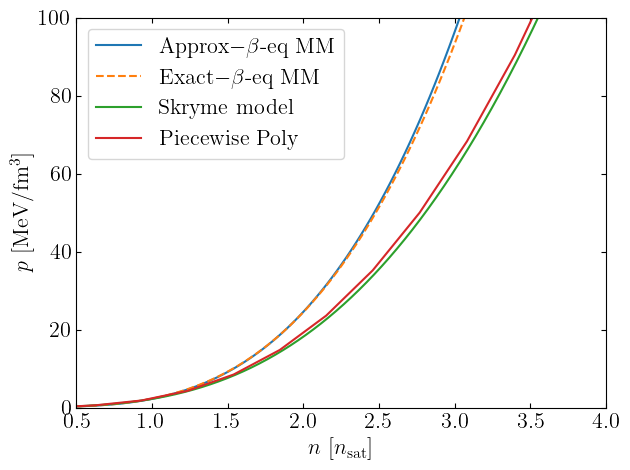

In [7]:
plt.plot(ns_plots, ps_plots, label = r"Approx$-\beta$-eq MM")
plt.plot(ns_plots_exact, ps_plots_exact, label = r"Exact$-\beta$-eq MM", ls = "--")
plt.plot(jnp.array(n_nsat_skryme), ps_plots_skryme, label = r"Skryme model")
plt.plot(jnp.array(ns_PP), ps_plots_PP, label = r"Piecewise Poly")
plt.xlim(0.5,nbreak / nsat)
plt.ylim(0,100)
plt.xlabel(r"$n$ [$n_{\rm{sat}}$]")
plt.ylabel(r"$p$ [MeV/fm$^3$]")
# plt.yscale("log")
# plt.xscale("log")
plt.tight_layout()
plt.legend()
plt.show()
plt.close()

# Neutron stars

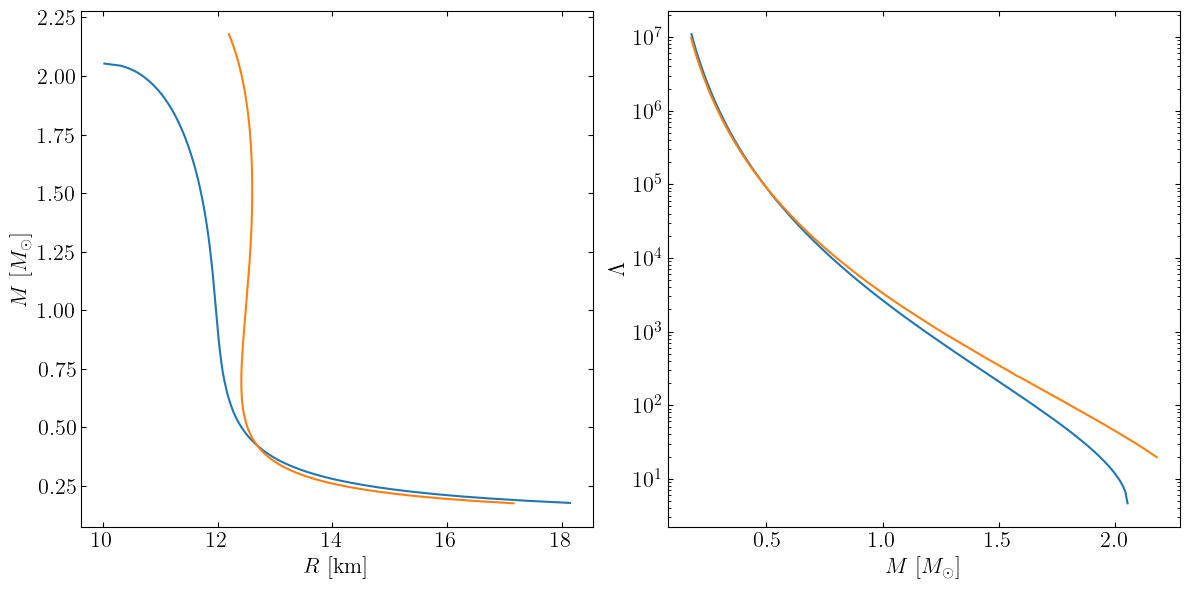

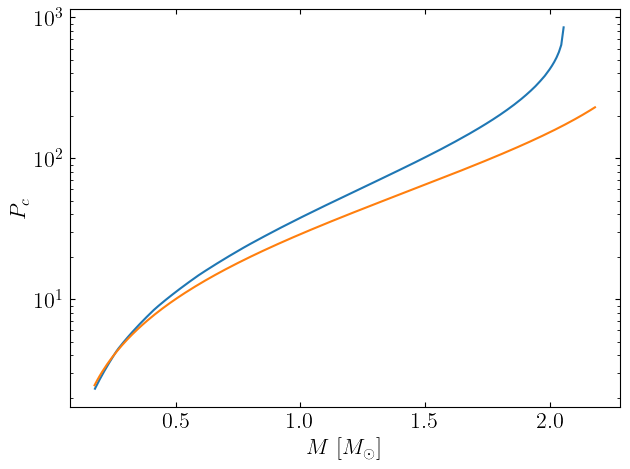

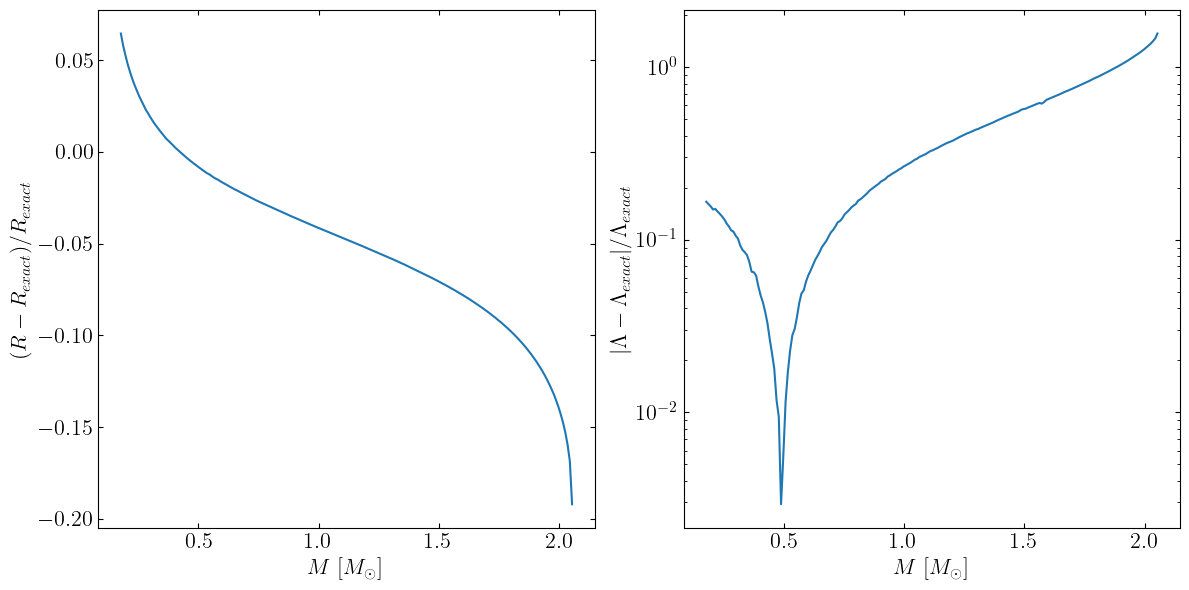

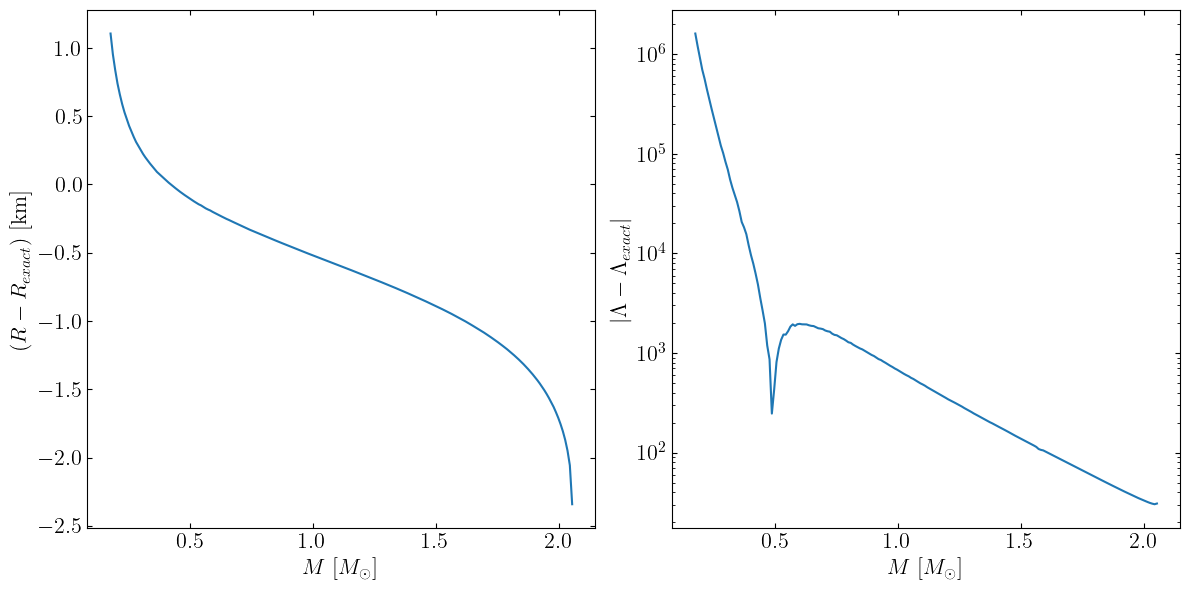

In [8]:
from scipy.interpolate import interp1d
# Solve TOV equations:
eos_tuple = (ns, ps, hs, es, dloge_dlogps, cs2)
logpc, masses, radii, Lambdas = construct_family(eos_tuple, ndat = 200, min_nsat = 1.0)

eos_tuple_exact = (ns_exact, ps_exact, hs_exact, es_exact, dloge_dlogps_exact, cs2_exact)
logpc_exact, masses_exact, radii_exact, Lambdas_exact = construct_family(eos_tuple_exact, ndat = 200, min_nsat = 1.0)

pc_max = ps_exact[jesterTOV.eos.locate_lowest_non_causal_point(cs2_exact)]
# print(jnp.exp(logpc_exact)/ utils.MeV_fm_inv3_to_geometric)
# print(pc_max/ utils.MeV_fm_inv3_to_geometric)
f_exact = interp1d(masses_exact, radii_exact, kind='cubic', bounds_error=False)
f_exact_lam = interp1d(masses_exact, Lambdas_exact, kind='cubic', bounds_error=False)
radii_exact_interp = f_exact(masses)
Lambdas_exact_interp = f_exact_lam(masses)
radius_diff = radii - radii_exact_interp
Lambdas_diff = Lambdas - Lambdas_exact_interp
# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

# Limit masses to be above certain mass to make plot prettier
# m_min = 0.5
# mask = masses > m_min
# masses = masses[mask]
# radii = radii[mask]
# Lambdas = Lambdas[mask]

# M(R) plot
plt.subplot(121)
plt.plot(radii, masses)
plt.plot(radii_exact, masses_exact)
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.plot(masses, Lambdas)
plt.plot(masses_exact, Lambdas_exact)
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

# Pressure - M  plot
plt.plot(masses, jnp.exp(logpc)/utils.MeV_fm_inv3_to_geometric )
plt.plot(masses_exact, jnp.exp(logpc_exact)/ utils.MeV_fm_inv3_to_geometric )
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$P_c$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plt.subplot(121)
plt.plot(masses, radius_diff/radii_exact)
plt.ylabel(r"$(R-R_{exact})/R_{exact}$")
plt.xlabel(r"$M$ [$M_\odot$]")


plt.subplot(122)
plt.plot(masses, jnp.abs(Lambdas_diff/Lambdas_exact))
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$|\Lambda-\Lambda_{exact}| /\Lambda_{exact}$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

# Make a plot
plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
# M(R) plot
plt.subplot(121)
plt.plot(masses, radius_diff)
plt.ylabel(r"$(R-R_{exact})$ [km]")
plt.xlabel(r"$M$ [$M_\odot$]")

# Lambda(R) plot
plt.subplot(122)
plt.plot(masses, jnp.abs(Lambdas_diff))
plt.xlabel(r"$M$ [$M_\odot$]")
plt.ylabel(r"$|\Lambda-\Lambda_{exact}|$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()